In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

C:\Users\asus\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\asus\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
C:\Users\asus\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


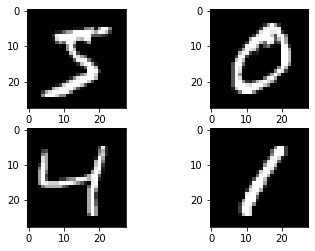

In [2]:
%matplotlib inline

# Plot ad hoc mnist instances
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

# load (download if needed) the MNIST dataset
mnist_train = MNIST(".", train=True, download=True)

# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(mnist_train.train_data[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(mnist_train.train_data[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(mnist_train.train_data[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(mnist_train.train_data[3], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

In [3]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

# load data
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)
print(trainset)
print(testset)

# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

# build the model
model = BaselineModel(784, 784, 10)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )


60000 = 127 * 469 + 437

10000 = 127 * 79 - 33 

In [ ]:
import torchbearer
from torchbearer import callbacks

train_loss0 = np.zeros(128)
test_loss0 = np.zeros(128)
train_acc0 = np.zeros(128)
test_acc0 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss0[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss0[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc0[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc0[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

    
# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

# Construct a trial object with the model, optimiser and loss.
# Also specify metrics we wish to compute.
trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()

trial.run(epochs=128)

# results = trial.evaluate(data_key=torchbearer.TEST_DATA)
# print(results)

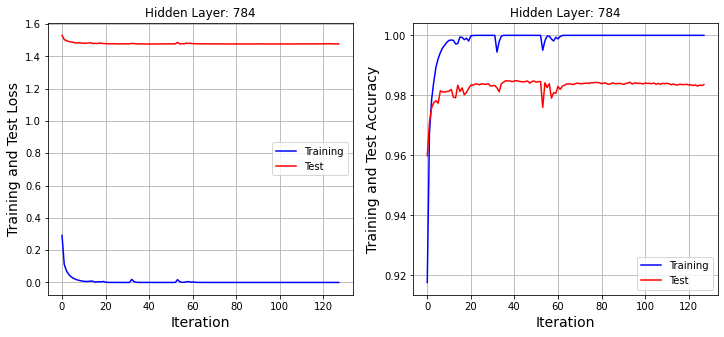

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss0, 'b', label = "Training")
ax[0].plot(range(128), test_loss0, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 784')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc0, 'b', label = "Training")
ax[1].plot(range(128), test_acc0, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 784')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 784.png")

In [9]:
model = BaselineModel(784,10,10)

train_loss1 = np.zeros(128)
test_loss1 = np.zeros(128)
train_acc1 = np.zeros(128)
test_acc1 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss1[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss1[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc1[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc1[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)



0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.4546814262866974, 'running_acc': 0.8753125071525574, 'loss': 0.8603432178497314, 'acc': 0.7553666830062866, 'val_loss': 1.6776621341705322, 'val_acc': 0.8828999996185303}
Epoch: 1
Training Loss: 0.8603432178497314
Training Accuracy: 0.7553666830062866
Test Loss: 1.6776621341705322
Test Accuracy: 0.8828999996185303


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.35523948073387146, 'running_acc': 0.9009374976158142, 'loss': 0.3812432885169983, 'acc': 0.8943333625793457, 'val_loss': 1.6202647686004639, 'val_acc': 0.9062999486923218}
Epoch: 2
Training Loss: 0.3812432885169983
Training Accuracy: 0.8943333625793457
Test Loss: 1.6202647686004639
Test Accuracy: 0.9062999486923218


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2968357801437378, 'running_acc': 0.9157811999320984, 'loss': 0.32842400670051575, 'acc': 0.9079999923706055, 'val_loss': 1.6014480590820312, 'val_acc': 0.9145999550819397}
Epoch: 3
Training Loss: 0.32842400670051575
Training Accuracy: 0.9079999923706055
Test Loss: 1.6014480590820312
Test Accuracy: 0.9145999550819397


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2892046868801117, 'running_acc': 0.9168750047683716, 'loss': 0.3049814701080322, 'acc': 0.9148333668708801, 'val_loss': 1.5959017276763916, 'val_acc': 0.917199969291687}
Epoch: 4
Training Loss: 0.3049814701080322
Training Accuracy: 0.9148333668708801
Test Loss: 1.5959017276763916
Test Accuracy: 0.917199969291687


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2828977406024933, 'running_acc': 0.9245312213897705, 'loss': 0.2924301028251648, 'acc': 0.9179333448410034, 'val_loss': 1.590073585510254, 'val_acc': 0.9188999533653259}
Epoch: 5
Training Loss: 0.2924301028251648
Training Accuracy: 0.9179333448410034
Test Loss: 1.590073585510254
Test Accuracy: 0.9188999533653259


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2893875539302826, 'running_acc': 0.9160937070846558, 'loss': 0.28310903906822205, 'acc': 0.9208500385284424, 'val_loss': 1.5872691869735718, 'val_acc': 0.9205999970436096}
Epoch: 6
Training Loss: 0.28310903906822205
Training Accuracy: 0.9208500385284424
Test Loss: 1.5872691869735718
Test Accuracy: 0.9205999970436096


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.30694079399108887, 'running_acc': 0.9149999618530273, 'loss': 0.276235431432724, 'acc': 0.9224666953086853, 'val_loss': 1.5822242498397827, 'val_acc': 0.9222999811172485}
Epoch: 7
Training Loss: 0.276235431432724
Training Accuracy: 0.9224666953086853
Test Loss: 1.5822242498397827
Test Accuracy: 0.9222999811172485


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.274742990732193, 'running_acc': 0.9196874499320984, 'loss': 0.2703109681606293, 'acc': 0.9244500398635864, 'val_loss': 1.5809446573257446, 'val_acc': 0.9217999577522278}
Epoch: 8
Training Loss: 0.2703109681606293
Training Accuracy: 0.9244500398635864
Test Loss: 1.5809446573257446
Test Accuracy: 0.9217999577522278


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24277517199516296, 'running_acc': 0.9337499737739563, 'loss': 0.26625633239746094, 'acc': 0.9252499938011169, 'val_loss': 1.5772932767868042, 'val_acc': 0.9222999811172485}
Epoch: 9
Training Loss: 0.26625633239746094
Training Accuracy: 0.9252499938011169
Test Loss: 1.5772932767868042
Test Accuracy: 0.9222999811172485


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.251810222864151, 'running_acc': 0.9290624856948853, 'loss': 0.2618039846420288, 'acc': 0.9275000095367432, 'val_loss': 1.576694369316101, 'val_acc': 0.9240999817848206}
Epoch: 10
Training Loss: 0.2618039846420288
Training Accuracy: 0.9275000095367432
Test Loss: 1.576694369316101
Test Accuracy: 0.9240999817848206


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.25286930799484253, 'running_acc': 0.9307812452316284, 'loss': 0.25898873805999756, 'acc': 0.9280333518981934, 'val_loss': 1.5772267580032349, 'val_acc': 0.9236999750137329}
Epoch: 11
Training Loss: 0.25898873805999756
Training Accuracy: 0.9280333518981934
Test Loss: 1.5772267580032349
Test Accuracy: 0.9236999750137329


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.25873884558677673, 'running_acc': 0.9289062023162842, 'loss': 0.2560139000415802, 'acc': 0.9291999936103821, 'val_loss': 1.575515866279602, 'val_acc': 0.9232999682426453}
Epoch: 12
Training Loss: 0.2560139000415802
Training Accuracy: 0.9291999936103821
Test Loss: 1.575515866279602
Test Accuracy: 0.9232999682426453


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2515093982219696, 'running_acc': 0.93031245470047, 'loss': 0.25325989723205566, 'acc': 0.928683340549469, 'val_loss': 1.5734484195709229, 'val_acc': 0.9250999689102173}
Epoch: 13
Training Loss: 0.25325989723205566
Training Accuracy: 0.928683340549469
Test Loss: 1.5734484195709229
Test Accuracy: 0.9250999689102173


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24840787053108215, 'running_acc': 0.9289062023162842, 'loss': 0.2506028711795807, 'acc': 0.9303833246231079, 'val_loss': 1.5733789205551147, 'val_acc': 0.9257999658584595}
Epoch: 14
Training Loss: 0.2506028711795807
Training Accuracy: 0.9303833246231079
Test Loss: 1.5733789205551147
Test Accuracy: 0.9257999658584595


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.25331631302833557, 'running_acc': 0.9314061999320984, 'loss': 0.24778275191783905, 'acc': 0.9308000206947327, 'val_loss': 1.5719971656799316, 'val_acc': 0.9248999953269958}
Epoch: 15
Training Loss: 0.24778275191783905
Training Accuracy: 0.9308000206947327
Test Loss: 1.5719971656799316
Test Accuracy: 0.9248999953269958


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2357979714870453, 'running_acc': 0.9339062571525574, 'loss': 0.24596263468265533, 'acc': 0.9318000078201294, 'val_loss': 1.5719586610794067, 'val_acc': 0.9258999824523926}
Epoch: 16
Training Loss: 0.24596263468265533
Training Accuracy: 0.9318000078201294
Test Loss: 1.5719586610794067
Test Accuracy: 0.9258999824523926


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2530004382133484, 'running_acc': 0.9287499785423279, 'loss': 0.24418409168720245, 'acc': 0.9316166639328003, 'val_loss': 1.5706496238708496, 'val_acc': 0.9259999990463257}
Epoch: 17
Training Loss: 0.24418409168720245
Training Accuracy: 0.9316166639328003
Test Loss: 1.5706496238708496
Test Accuracy: 0.9259999990463257


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23992949724197388, 'running_acc': 0.9293749928474426, 'loss': 0.24190588295459747, 'acc': 0.9326666593551636, 'val_loss': 1.5705318450927734, 'val_acc': 0.926099956035614}
Epoch: 18
Training Loss: 0.24190588295459747
Training Accuracy: 0.9326666593551636
Test Loss: 1.5705318450927734
Test Accuracy: 0.926099956035614


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22795513272285461, 'running_acc': 0.9359374642372131, 'loss': 0.2407669872045517, 'acc': 0.9319999814033508, 'val_loss': 1.5690356492996216, 'val_acc': 0.9268999695777893}
Epoch: 19
Training Loss: 0.2407669872045517
Training Accuracy: 0.9319999814033508
Test Loss: 1.5690356492996216
Test Accuracy: 0.9268999695777893


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24489934742450714, 'running_acc': 0.9320312142372131, 'loss': 0.2383757382631302, 'acc': 0.9330000281333923, 'val_loss': 1.5694321393966675, 'val_acc': 0.9254999756813049}
Epoch: 20
Training Loss: 0.2383757382631302
Training Accuracy: 0.9330000281333923
Test Loss: 1.5694321393966675
Test Accuracy: 0.9254999756813049


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2468872368335724, 'running_acc': 0.9290624856948853, 'loss': 0.23690803349018097, 'acc': 0.9329000115394592, 'val_loss': 1.5676207542419434, 'val_acc': 0.9281999468803406}
Epoch: 21
Training Loss: 0.23690803349018097
Training Accuracy: 0.9329000115394592
Test Loss: 1.5676207542419434
Test Accuracy: 0.9281999468803406


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21866723895072937, 'running_acc': 0.9376562237739563, 'loss': 0.23517639935016632, 'acc': 0.9341999888420105, 'val_loss': 1.5663549900054932, 'val_acc': 0.9297999739646912}
Epoch: 22
Training Loss: 0.23517639935016632
Training Accuracy: 0.9341999888420105
Test Loss: 1.5663549900054932
Test Accuracy: 0.9297999739646912


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22512362897396088, 'running_acc': 0.9379687309265137, 'loss': 0.23352010548114777, 'acc': 0.934249997138977, 'val_loss': 1.5672361850738525, 'val_acc': 0.9267999529838562}
Epoch: 23
Training Loss: 0.23352010548114777
Training Accuracy: 0.934249997138977
Test Loss: 1.5672361850738525
Test Accuracy: 0.9267999529838562


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2361150085926056, 'running_acc': 0.9326562285423279, 'loss': 0.23288407921791077, 'acc': 0.9347000122070312, 'val_loss': 1.5687400102615356, 'val_acc': 0.9289000034332275}
Epoch: 24
Training Loss: 0.23288407921791077
Training Accuracy: 0.9347000122070312
Test Loss: 1.5687400102615356
Test Accuracy: 0.9289000034332275


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2229815125465393, 'running_acc': 0.93421870470047, 'loss': 0.23147132992744446, 'acc': 0.9345666766166687, 'val_loss': 1.5668613910675049, 'val_acc': 0.9264999628067017}
Epoch: 25
Training Loss: 0.23147132992744446
Training Accuracy: 0.9345666766166687
Test Loss: 1.5668613910675049
Test Accuracy: 0.9264999628067017


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2212989330291748, 'running_acc': 0.9364062547683716, 'loss': 0.22994950413703918, 'acc': 0.935200035572052, 'val_loss': 1.5669982433319092, 'val_acc': 0.9284999966621399}
Epoch: 26
Training Loss: 0.22994950413703918
Training Accuracy: 0.935200035572052
Test Loss: 1.5669982433319092
Test Accuracy: 0.9284999966621399


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23378127813339233, 'running_acc': 0.9371874928474426, 'loss': 0.22865517437458038, 'acc': 0.9362666606903076, 'val_loss': 1.5666261911392212, 'val_acc': 0.9274999499320984}
Epoch: 27
Training Loss: 0.22865517437458038
Training Accuracy: 0.9362666606903076
Test Loss: 1.5666261911392212
Test Accuracy: 0.9274999499320984


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22330135107040405, 'running_acc': 0.9359374642372131, 'loss': 0.22776378691196442, 'acc': 0.9359000325202942, 'val_loss': 1.5647298097610474, 'val_acc': 0.9298999905586243}
Epoch: 28
Training Loss: 0.22776378691196442
Training Accuracy: 0.9359000325202942
Test Loss: 1.5647298097610474
Test Accuracy: 0.9298999905586243


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23382507264614105, 'running_acc': 0.9356249570846558, 'loss': 0.2265431135892868, 'acc': 0.9361000061035156, 'val_loss': 1.5655125379562378, 'val_acc': 0.9296000003814697}
Epoch: 29
Training Loss: 0.2265431135892868
Training Accuracy: 0.9361000061035156
Test Loss: 1.5655125379562378
Test Accuracy: 0.9296000003814697


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22988463938236237, 'running_acc': 0.9364062547683716, 'loss': 0.22569215297698975, 'acc': 0.9361833333969116, 'val_loss': 1.564217448234558, 'val_acc': 0.9297999739646912}
Epoch: 30
Training Loss: 0.22569215297698975
Training Accuracy: 0.9361833333969116
Test Loss: 1.564217448234558
Test Accuracy: 0.9297999739646912


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2195667028427124, 'running_acc': 0.9396874904632568, 'loss': 0.22457145154476166, 'acc': 0.9359666705131531, 'val_loss': 1.5642516613006592, 'val_acc': 0.9301999807357788}
Epoch: 31
Training Loss: 0.22457145154476166
Training Accuracy: 0.9359666705131531
Test Loss: 1.5642516613006592
Test Accuracy: 0.9301999807357788


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.230340376496315, 'running_acc': 0.93359375, 'loss': 0.2238963097333908, 'acc': 0.9371833205223083, 'val_loss': 1.5646803379058838, 'val_acc': 0.9293999671936035}
Epoch: 32
Training Loss: 0.2238963097333908
Training Accuracy: 0.9371833205223083
Test Loss: 1.5646803379058838
Test Accuracy: 0.9293999671936035


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23501914739608765, 'running_acc': 0.9351562261581421, 'loss': 0.22285160422325134, 'acc': 0.9369833469390869, 'val_loss': 1.5646201372146606, 'val_acc': 0.9280999898910522}
Epoch: 33
Training Loss: 0.22285160422325134
Training Accuracy: 0.9369833469390869
Test Loss: 1.5646201372146606
Test Accuracy: 0.9280999898910522


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20969295501708984, 'running_acc': 0.938281238079071, 'loss': 0.2222803384065628, 'acc': 0.937416672706604, 'val_loss': 1.5646642446517944, 'val_acc': 0.927299976348877}
Epoch: 34
Training Loss: 0.2222803384065628
Training Accuracy: 0.937416672706604
Test Loss: 1.5646642446517944
Test Accuracy: 0.927299976348877


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21587231755256653, 'running_acc': 0.9387499690055847, 'loss': 0.22111350297927856, 'acc': 0.9376500248908997, 'val_loss': 1.5626882314682007, 'val_acc': 0.9289999604225159}
Epoch: 35
Training Loss: 0.22111350297927856
Training Accuracy: 0.9376500248908997
Test Loss: 1.5626882314682007
Test Accuracy: 0.9289999604225159


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23442263901233673, 'running_acc': 0.9326562285423279, 'loss': 0.22037789225578308, 'acc': 0.9381166696548462, 'val_loss': 1.5619330406188965, 'val_acc': 0.9297999739646912}
Epoch: 36
Training Loss: 0.22037789225578308
Training Accuracy: 0.9381166696548462
Test Loss: 1.5619330406188965
Test Accuracy: 0.9297999739646912


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22609162330627441, 'running_acc': 0.9367187023162842, 'loss': 0.22011934220790863, 'acc': 0.9377333521842957, 'val_loss': 1.5623983144760132, 'val_acc': 0.9301999807357788}
Epoch: 37
Training Loss: 0.22011934220790863
Training Accuracy: 0.9377333521842957
Test Loss: 1.5623983144760132
Test Accuracy: 0.9301999807357788


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2090034782886505, 'running_acc': 0.9398437142372131, 'loss': 0.21913602948188782, 'acc': 0.9381499886512756, 'val_loss': 1.564863920211792, 'val_acc': 0.9293999671936035}
Epoch: 38
Training Loss: 0.21913602948188782
Training Accuracy: 0.9381499886512756
Test Loss: 1.564863920211792
Test Accuracy: 0.9293999671936035


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2181086242198944, 'running_acc': 0.94140625, 'loss': 0.21859709918498993, 'acc': 0.9382333159446716, 'val_loss': 1.5618113279342651, 'val_acc': 0.9297999739646912}
Epoch: 39
Training Loss: 0.21859709918498993
Training Accuracy: 0.9382333159446716
Test Loss: 1.5618113279342651
Test Accuracy: 0.9297999739646912


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2206539362668991, 'running_acc': 0.9379687309265137, 'loss': 0.21770797669887543, 'acc': 0.9388166666030884, 'val_loss': 1.5621274709701538, 'val_acc': 0.9303999543190002}
Epoch: 40
Training Loss: 0.21770797669887543
Training Accuracy: 0.9388166666030884
Test Loss: 1.5621274709701538
Test Accuracy: 0.9303999543190002


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22549575567245483, 'running_acc': 0.9346874952316284, 'loss': 0.21655721962451935, 'acc': 0.939050018787384, 'val_loss': 1.5634480714797974, 'val_acc': 0.9274999499320984}
Epoch: 41
Training Loss: 0.21655721962451935
Training Accuracy: 0.939050018787384
Test Loss: 1.5634480714797974
Test Accuracy: 0.9274999499320984


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2212393879890442, 'running_acc': 0.9393749833106995, 'loss': 0.2162061482667923, 'acc': 0.9388333559036255, 'val_loss': 1.5616462230682373, 'val_acc': 0.9297999739646912}
Epoch: 42
Training Loss: 0.2162061482667923
Training Accuracy: 0.9388333559036255
Test Loss: 1.5616462230682373
Test Accuracy: 0.9297999739646912


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21030133962631226, 'running_acc': 0.9443749785423279, 'loss': 0.21591460704803467, 'acc': 0.9392833709716797, 'val_loss': 1.563422441482544, 'val_acc': 0.9297999739646912}
Epoch: 43
Training Loss: 0.21591460704803467
Training Accuracy: 0.9392833709716797
Test Loss: 1.563422441482544
Test Accuracy: 0.9297999739646912


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2114926427602768, 'running_acc': 0.94140625, 'loss': 0.2155015617609024, 'acc': 0.9390166997909546, 'val_loss': 1.5624022483825684, 'val_acc': 0.9265999794006348}
Epoch: 44
Training Loss: 0.2155015617609024
Training Accuracy: 0.9390166997909546
Test Loss: 1.5624022483825684
Test Accuracy: 0.9265999794006348


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22605597972869873, 'running_acc': 0.9357812404632568, 'loss': 0.21506239473819733, 'acc': 0.9393333196640015, 'val_loss': 1.5603415966033936, 'val_acc': 0.9310999512672424}
Epoch: 45
Training Loss: 0.21506239473819733
Training Accuracy: 0.9393333196640015
Test Loss: 1.5603415966033936
Test Accuracy: 0.9310999512672424


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23169933259487152, 'running_acc': 0.9373437166213989, 'loss': 0.21402688324451447, 'acc': 0.9391000270843506, 'val_loss': 1.5607349872589111, 'val_acc': 0.9299999475479126}
Epoch: 46
Training Loss: 0.21402688324451447
Training Accuracy: 0.9391000270843506
Test Loss: 1.5607349872589111
Test Accuracy: 0.9299999475479126


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21489198505878448, 'running_acc': 0.9396874904632568, 'loss': 0.21332934498786926, 'acc': 0.9399666786193848, 'val_loss': 1.561718463897705, 'val_acc': 0.9282999634742737}
Epoch: 47
Training Loss: 0.21332934498786926
Training Accuracy: 0.9399666786193848
Test Loss: 1.561718463897705
Test Accuracy: 0.9282999634742737


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2179221361875534, 'running_acc': 0.9354687333106995, 'loss': 0.21302135288715363, 'acc': 0.9394833445549011, 'val_loss': 1.562750220298767, 'val_acc': 0.9293999671936035}
Epoch: 48
Training Loss: 0.21302135288715363
Training Accuracy: 0.9394833445549011
Test Loss: 1.562750220298767
Test Accuracy: 0.9293999671936035


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21654893457889557, 'running_acc': 0.9385937452316284, 'loss': 0.21275626122951508, 'acc': 0.9393500089645386, 'val_loss': 1.562048316001892, 'val_acc': 0.9289000034332275}
Epoch: 49
Training Loss: 0.21275626122951508
Training Accuracy: 0.9393500089645386
Test Loss: 1.562048316001892
Test Accuracy: 0.9289000034332275


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21157653629779816, 'running_acc': 0.9434374570846558, 'loss': 0.21236568689346313, 'acc': 0.9397500157356262, 'val_loss': 1.5604023933410645, 'val_acc': 0.929099977016449}
Epoch: 50
Training Loss: 0.21236568689346313
Training Accuracy: 0.9397500157356262
Test Loss: 1.5604023933410645
Test Accuracy: 0.929099977016449


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21553388237953186, 'running_acc': 0.9393749833106995, 'loss': 0.21176326274871826, 'acc': 0.9400166869163513, 'val_loss': 1.5626651048660278, 'val_acc': 0.9287999868392944}
Epoch: 51
Training Loss: 0.21176326274871826
Training Accuracy: 0.9400166869163513
Test Loss: 1.5626651048660278
Test Accuracy: 0.9287999868392944


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22064559161663055, 'running_acc': 0.93812495470047, 'loss': 0.21085578203201294, 'acc': 0.940250039100647, 'val_loss': 1.560314655303955, 'val_acc': 0.9300999641418457}
Epoch: 52
Training Loss: 0.21085578203201294
Training Accuracy: 0.940250039100647
Test Loss: 1.560314655303955
Test Accuracy: 0.9300999641418457


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2215549796819687, 'running_acc': 0.9368749856948853, 'loss': 0.21077203750610352, 'acc': 0.9398833513259888, 'val_loss': 1.56019926071167, 'val_acc': 0.9298999905586243}
Epoch: 53
Training Loss: 0.21077203750610352
Training Accuracy: 0.9398833513259888
Test Loss: 1.56019926071167
Test Accuracy: 0.9298999905586243


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22264836728572845, 'running_acc': 0.9351562261581421, 'loss': 0.21025826036930084, 'acc': 0.9398333430290222, 'val_loss': 1.562713861465454, 'val_acc': 0.9271999597549438}
Epoch: 54
Training Loss: 0.21025826036930084
Training Accuracy: 0.9398333430290222
Test Loss: 1.562713861465454
Test Accuracy: 0.9271999597549438


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2066987156867981, 'running_acc': 0.94140625, 'loss': 0.2101372629404068, 'acc': 0.9402666687965393, 'val_loss': 1.560895562171936, 'val_acc': 0.9296999573707581}
Epoch: 55
Training Loss: 0.2101372629404068
Training Accuracy: 0.9402666687965393
Test Loss: 1.560895562171936
Test Accuracy: 0.9296999573707581


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20547355711460114, 'running_acc': 0.9440624713897705, 'loss': 0.20938213169574738, 'acc': 0.9400666952133179, 'val_loss': 1.5606344938278198, 'val_acc': 0.9297999739646912}
Epoch: 56
Training Loss: 0.20938213169574738
Training Accuracy: 0.9400666952133179
Test Loss: 1.5606344938278198
Test Accuracy: 0.9297999739646912


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21474316716194153, 'running_acc': 0.9373437166213989, 'loss': 0.20890134572982788, 'acc': 0.9406999945640564, 'val_loss': 1.5600864887237549, 'val_acc': 0.9299999475479126}
Epoch: 57
Training Loss: 0.20890134572982788
Training Accuracy: 0.9406999945640564
Test Loss: 1.5600864887237549
Test Accuracy: 0.9299999475479126


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1981552094221115, 'running_acc': 0.9464062452316284, 'loss': 0.20842808485031128, 'acc': 0.9408666491508484, 'val_loss': 1.5614606142044067, 'val_acc': 0.9304999709129333}
Epoch: 58
Training Loss: 0.20842808485031128
Training Accuracy: 0.9408666491508484
Test Loss: 1.5614606142044067
Test Accuracy: 0.9304999709129333


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20119184255599976, 'running_acc': 0.9389062523841858, 'loss': 0.20807276666164398, 'acc': 0.9405666589736938, 'val_loss': 1.5591617822647095, 'val_acc': 0.929099977016449}
Epoch: 59
Training Loss: 0.20807276666164398
Training Accuracy: 0.9405666589736938
Test Loss: 1.5591617822647095
Test Accuracy: 0.929099977016449


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19574257731437683, 'running_acc': 0.9428125023841858, 'loss': 0.2076760232448578, 'acc': 0.940500020980835, 'val_loss': 1.5606430768966675, 'val_acc': 0.9282999634742737}
Epoch: 60
Training Loss: 0.2076760232448578
Training Accuracy: 0.940500020980835
Test Loss: 1.5606430768966675
Test Accuracy: 0.9282999634742737


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19753552973270416, 'running_acc': 0.9439062476158142, 'loss': 0.20735599100589752, 'acc': 0.9409500360488892, 'val_loss': 1.5592020750045776, 'val_acc': 0.9279999732971191}
Epoch: 61
Training Loss: 0.20735599100589752
Training Accuracy: 0.9409500360488892
Test Loss: 1.5592020750045776
Test Accuracy: 0.9279999732971191


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20989789068698883, 'running_acc': 0.9395312070846558, 'loss': 0.20640668272972107, 'acc': 0.9412333369255066, 'val_loss': 1.559240698814392, 'val_acc': 0.9297999739646912}
Epoch: 62
Training Loss: 0.20640668272972107
Training Accuracy: 0.9412333369255066
Test Loss: 1.559240698814392
Test Accuracy: 0.9297999739646912


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22830303013324738, 'running_acc': 0.9393749833106995, 'loss': 0.20655590295791626, 'acc': 0.9406333565711975, 'val_loss': 1.559843897819519, 'val_acc': 0.9311999678611755}
Epoch: 63
Training Loss: 0.20655590295791626
Training Accuracy: 0.9406333565711975
Test Loss: 1.559843897819519
Test Accuracy: 0.9311999678611755


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2163168489933014, 'running_acc': 0.9376562237739563, 'loss': 0.20545992255210876, 'acc': 0.9415667057037354, 'val_loss': 1.5605368614196777, 'val_acc': 0.9294999837875366}
Epoch: 64
Training Loss: 0.20545992255210876
Training Accuracy: 0.9415667057037354
Test Loss: 1.5605368614196777
Test Accuracy: 0.9294999837875366


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20903873443603516, 'running_acc': 0.9395312070846558, 'loss': 0.2058347463607788, 'acc': 0.9412833452224731, 'val_loss': 1.5602947473526, 'val_acc': 0.9297999739646912}
Epoch: 65
Training Loss: 0.2058347463607788
Training Accuracy: 0.9412833452224731
Test Loss: 1.5602947473526
Test Accuracy: 0.9297999739646912


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2018527239561081, 'running_acc': 0.9428125023841858, 'loss': 0.2052273452281952, 'acc': 0.9414166808128357, 'val_loss': 1.5604623556137085, 'val_acc': 0.9296999573707581}
Epoch: 66
Training Loss: 0.2052273452281952
Training Accuracy: 0.9414166808128357
Test Loss: 1.5604623556137085
Test Accuracy: 0.9296999573707581


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20441992580890656, 'running_acc': 0.9412499666213989, 'loss': 0.20454362034797668, 'acc': 0.9416500329971313, 'val_loss': 1.5602670907974243, 'val_acc': 0.929099977016449}
Epoch: 67
Training Loss: 0.20454362034797668
Training Accuracy: 0.9416500329971313
Test Loss: 1.5602670907974243
Test Accuracy: 0.929099977016449


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19808457791805267, 'running_acc': 0.9457812309265137, 'loss': 0.2046969085931778, 'acc': 0.941266655921936, 'val_loss': 1.5596383810043335, 'val_acc': 0.9289000034332275}
Epoch: 68
Training Loss: 0.2046969085931778
Training Accuracy: 0.941266655921936
Test Loss: 1.5596383810043335
Test Accuracy: 0.9289000034332275


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20319721102714539, 'running_acc': 0.94140625, 'loss': 0.20442679524421692, 'acc': 0.9414333701133728, 'val_loss': 1.5588737726211548, 'val_acc': 0.9294999837875366}
Epoch: 69
Training Loss: 0.20442679524421692
Training Accuracy: 0.9414333701133728
Test Loss: 1.5588737726211548
Test Accuracy: 0.9294999837875366


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2068142294883728, 'running_acc': 0.9443749785423279, 'loss': 0.20365989208221436, 'acc': 0.9420833587646484, 'val_loss': 1.559382438659668, 'val_acc': 0.9299999475479126}
Epoch: 70
Training Loss: 0.20365989208221436
Training Accuracy: 0.9420833587646484
Test Loss: 1.559382438659668
Test Accuracy: 0.9299999475479126


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21710003912448883, 'running_acc': 0.9398437142372131, 'loss': 0.2029666304588318, 'acc': 0.942133367061615, 'val_loss': 1.5585790872573853, 'val_acc': 0.930899977684021}
Epoch: 71
Training Loss: 0.2029666304588318
Training Accuracy: 0.942133367061615
Test Loss: 1.5585790872573853
Test Accuracy: 0.930899977684021


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21241284906864166, 'running_acc': 0.9393749833106995, 'loss': 0.20272132754325867, 'acc': 0.9421499967575073, 'val_loss': 1.558158278465271, 'val_acc': 0.9297999739646912}
Epoch: 72
Training Loss: 0.20272132754325867
Training Accuracy: 0.9421499967575073
Test Loss: 1.558158278465271
Test Accuracy: 0.9297999739646912


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21544310450553894, 'running_acc': 0.938281238079071, 'loss': 0.20306296646595, 'acc': 0.9417833685874939, 'val_loss': 1.5576368570327759, 'val_acc': 0.9298999905586243}
Epoch: 73
Training Loss: 0.20306296646595
Training Accuracy: 0.9417833685874939
Test Loss: 1.5576368570327759
Test Accuracy: 0.9298999905586243


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2142491638660431, 'running_acc': 0.9364062547683716, 'loss': 0.2022397816181183, 'acc': 0.9420333504676819, 'val_loss': 1.560532808303833, 'val_acc': 0.9283999800682068}
Epoch: 74
Training Loss: 0.2022397816181183
Training Accuracy: 0.9420333504676819
Test Loss: 1.560532808303833
Test Accuracy: 0.9283999800682068


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21764932572841644, 'running_acc': 0.9368749856948853, 'loss': 0.20234626531600952, 'acc': 0.9422333240509033, 'val_loss': 1.5578501224517822, 'val_acc': 0.9298999905586243}
Epoch: 75
Training Loss: 0.20234626531600952
Training Accuracy: 0.9422333240509033
Test Loss: 1.5578501224517822
Test Accuracy: 0.9298999905586243


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2020965963602066, 'running_acc': 0.9404687285423279, 'loss': 0.2018248289823532, 'acc': 0.9418166875839233, 'val_loss': 1.5589380264282227, 'val_acc': 0.9296999573707581}
Epoch: 76
Training Loss: 0.2018248289823532
Training Accuracy: 0.9418166875839233
Test Loss: 1.5589380264282227
Test Accuracy: 0.9296999573707581


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1981315016746521, 'running_acc': 0.9403125047683716, 'loss': 0.20160739123821259, 'acc': 0.9422500133514404, 'val_loss': 1.5584532022476196, 'val_acc': 0.9287999868392944}
Epoch: 77
Training Loss: 0.20160739123821259
Training Accuracy: 0.9422500133514404
Test Loss: 1.5584532022476196
Test Accuracy: 0.9287999868392944


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19535435736179352, 'running_acc': 0.94203120470047, 'loss': 0.20132561028003693, 'acc': 0.9422833323478699, 'val_loss': 1.55829656124115, 'val_acc': 0.9296999573707581}
Epoch: 78
Training Loss: 0.20132561028003693
Training Accuracy: 0.9422833323478699
Test Loss: 1.55829656124115
Test Accuracy: 0.9296999573707581


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2072432041168213, 'running_acc': 0.9424999952316284, 'loss': 0.20109125971794128, 'acc': 0.9427500367164612, 'val_loss': 1.5588196516036987, 'val_acc': 0.9297999739646912}
Epoch: 79
Training Loss: 0.20109125971794128
Training Accuracy: 0.9427500367164612
Test Loss: 1.5588196516036987
Test Accuracy: 0.9297999739646912


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20186172425746918, 'running_acc': 0.942187488079071, 'loss': 0.20068570971488953, 'acc': 0.9430666565895081, 'val_loss': 1.5593483448028564, 'val_acc': 0.9301999807357788}
Epoch: 80
Training Loss: 0.20068570971488953
Training Accuracy: 0.9430666565895081
Test Loss: 1.5593483448028564
Test Accuracy: 0.9301999807357788


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19420231878757477, 'running_acc': 0.9418749809265137, 'loss': 0.2005496472120285, 'acc': 0.9431833624839783, 'val_loss': 1.5568221807479858, 'val_acc': 0.9302999973297119}
Epoch: 81
Training Loss: 0.2005496472120285
Training Accuracy: 0.9431833624839783
Test Loss: 1.5568221807479858
Test Accuracy: 0.9302999973297119


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19388027489185333, 'running_acc': 0.9442187547683716, 'loss': 0.20040415227413177, 'acc': 0.9426833391189575, 'val_loss': 1.557145118713379, 'val_acc': 0.9294999837875366}
Epoch: 82
Training Loss: 0.20040415227413177
Training Accuracy: 0.9426833391189575
Test Loss: 1.557145118713379
Test Accuracy: 0.9294999837875366


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1964665949344635, 'running_acc': 0.9409374594688416, 'loss': 0.19975416362285614, 'acc': 0.9421833157539368, 'val_loss': 1.558627963066101, 'val_acc': 0.9312999844551086}
Epoch: 83
Training Loss: 0.19975416362285614
Training Accuracy: 0.9421833157539368
Test Loss: 1.558627963066101
Test Accuracy: 0.9312999844551086


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19226904213428497, 'running_acc': 0.9442187547683716, 'loss': 0.1997980773448944, 'acc': 0.9435499906539917, 'val_loss': 1.5579701662063599, 'val_acc': 0.9292999505996704}
Epoch: 84
Training Loss: 0.1997980773448944
Training Accuracy: 0.9435499906539917
Test Loss: 1.5579701662063599
Test Accuracy: 0.9292999505996704


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20799729228019714, 'running_acc': 0.9403125047683716, 'loss': 0.19981221854686737, 'acc': 0.9430666565895081, 'val_loss': 1.5604654550552368, 'val_acc': 0.9293999671936035}
Epoch: 85
Training Loss: 0.19981221854686737
Training Accuracy: 0.9430666565895081
Test Loss: 1.5604654550552368
Test Accuracy: 0.9293999671936035


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20897731184959412, 'running_acc': 0.9393749833106995, 'loss': 0.19939203560352325, 'acc': 0.9430500268936157, 'val_loss': 1.5595262050628662, 'val_acc': 0.9289999604225159}
Epoch: 86
Training Loss: 0.19939203560352325
Training Accuracy: 0.9430500268936157
Test Loss: 1.5595262050628662
Test Accuracy: 0.9289999604225159


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20951591432094574, 'running_acc': 0.9401562213897705, 'loss': 0.19898056983947754, 'acc': 0.9428166747093201, 'val_loss': 1.557342767715454, 'val_acc': 0.9287999868392944}
Epoch: 87
Training Loss: 0.19898056983947754
Training Accuracy: 0.9428166747093201
Test Loss: 1.557342767715454
Test Accuracy: 0.9287999868392944


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21213412284851074, 'running_acc': 0.9424999952316284, 'loss': 0.19838885962963104, 'acc': 0.9437000155448914, 'val_loss': 1.5586721897125244, 'val_acc': 0.9284999966621399}
Epoch: 88
Training Loss: 0.19838885962963104
Training Accuracy: 0.9437000155448914
Test Loss: 1.5586721897125244
Test Accuracy: 0.9284999966621399


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1943468600511551, 'running_acc': 0.9418749809265137, 'loss': 0.19849365949630737, 'acc': 0.9431166648864746, 'val_loss': 1.557584285736084, 'val_acc': 0.9307000041007996}
Epoch: 89
Training Loss: 0.19849365949630737
Training Accuracy: 0.9431166648864746
Test Loss: 1.557584285736084
Test Accuracy: 0.9307000041007996


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22899097204208374, 'running_acc': 0.9309374690055847, 'loss': 0.19776058197021484, 'acc': 0.9429500102996826, 'val_loss': 1.558559536933899, 'val_acc': 0.9300999641418457}
Epoch: 90
Training Loss: 0.19776058197021484
Training Accuracy: 0.9429500102996826
Test Loss: 1.558559536933899
Test Accuracy: 0.9300999641418457


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19279305636882782, 'running_acc': 0.9462499618530273, 'loss': 0.19787666201591492, 'acc': 0.9433000087738037, 'val_loss': 1.5569202899932861, 'val_acc': 0.9302999973297119}
Epoch: 91
Training Loss: 0.19787666201591492
Training Accuracy: 0.9433000087738037
Test Loss: 1.5569202899932861
Test Accuracy: 0.9302999973297119


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20387685298919678, 'running_acc': 0.9424999952316284, 'loss': 0.19781199097633362, 'acc': 0.9431166648864746, 'val_loss': 1.5577387809753418, 'val_acc': 0.9296999573707581}
Epoch: 92
Training Loss: 0.19781199097633362
Training Accuracy: 0.9431166648864746
Test Loss: 1.5577387809753418
Test Accuracy: 0.9296999573707581


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19998079538345337, 'running_acc': 0.9424999952316284, 'loss': 0.1976892054080963, 'acc': 0.9430500268936157, 'val_loss': 1.5574063062667847, 'val_acc': 0.9301999807357788}
Epoch: 93
Training Loss: 0.1976892054080963
Training Accuracy: 0.9430500268936157
Test Loss: 1.5574063062667847
Test Accuracy: 0.9301999807357788


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19274482131004333, 'running_acc': 0.9457812309265137, 'loss': 0.19754274189472198, 'acc': 0.9430333375930786, 'val_loss': 1.557576060295105, 'val_acc': 0.9301999807357788}
Epoch: 94
Training Loss: 0.19754274189472198
Training Accuracy: 0.9430333375930786
Test Loss: 1.557576060295105
Test Accuracy: 0.9301999807357788


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19800209999084473, 'running_acc': 0.94593745470047, 'loss': 0.19700297713279724, 'acc': 0.9431166648864746, 'val_loss': 1.556512475013733, 'val_acc': 0.9298999905586243}
Epoch: 95
Training Loss: 0.19700297713279724
Training Accuracy: 0.9431166648864746
Test Loss: 1.556512475013733
Test Accuracy: 0.9298999905586243


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1911282241344452, 'running_acc': 0.9465624690055847, 'loss': 0.1970355063676834, 'acc': 0.9433166980743408, 'val_loss': 1.5578659772872925, 'val_acc': 0.9307000041007996}
Epoch: 96
Training Loss: 0.1970355063676834
Training Accuracy: 0.9433166980743408
Test Loss: 1.5578659772872925
Test Accuracy: 0.9307000041007996


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21787302196025848, 'running_acc': 0.9371874928474426, 'loss': 0.19660869240760803, 'acc': 0.9434500336647034, 'val_loss': 1.5567340850830078, 'val_acc': 0.9304999709129333}
Epoch: 97
Training Loss: 0.19660869240760803
Training Accuracy: 0.9434500336647034
Test Loss: 1.5567340850830078
Test Accuracy: 0.9304999709129333


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1986396759748459, 'running_acc': 0.9453125, 'loss': 0.19622556865215302, 'acc': 0.9437500238418579, 'val_loss': 1.5569852590560913, 'val_acc': 0.9301999807357788}
Epoch: 98
Training Loss: 0.19622556865215302
Training Accuracy: 0.9437500238418579
Test Loss: 1.5569852590560913
Test Accuracy: 0.9301999807357788


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1846650093793869, 'running_acc': 0.9453125, 'loss': 0.19631069898605347, 'acc': 0.9433333277702332, 'val_loss': 1.5563178062438965, 'val_acc': 0.9294999837875366}
Epoch: 99
Training Loss: 0.19631069898605347
Training Accuracy: 0.9433333277702332
Test Loss: 1.5563178062438965
Test Accuracy: 0.9294999837875366


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2094939947128296, 'running_acc': 0.938281238079071, 'loss': 0.19581179320812225, 'acc': 0.9439166784286499, 'val_loss': 1.5575156211853027, 'val_acc': 0.9305999875068665}
Epoch: 100
Training Loss: 0.19581179320812225
Training Accuracy: 0.9439166784286499
Test Loss: 1.5575156211853027
Test Accuracy: 0.9305999875068665


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.18217508494853973, 'running_acc': 0.9476562142372131, 'loss': 0.19537991285324097, 'acc': 0.9438000321388245, 'val_loss': 1.5566283464431763, 'val_acc': 0.9307999610900879}
Epoch: 101
Training Loss: 0.19537991285324097
Training Accuracy: 0.9438000321388245
Test Loss: 1.5566283464431763
Test Accuracy: 0.9307999610900879


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1931794434785843, 'running_acc': 0.942187488079071, 'loss': 0.19550125300884247, 'acc': 0.9434666633605957, 'val_loss': 1.5576608180999756, 'val_acc': 0.9310999512672424}
Epoch: 102
Training Loss: 0.19550125300884247
Training Accuracy: 0.9434666633605957
Test Loss: 1.5576608180999756
Test Accuracy: 0.9310999512672424


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20095409452915192, 'running_acc': 0.9424999952316284, 'loss': 0.19570952653884888, 'acc': 0.9436666965484619, 'val_loss': 1.559870958328247, 'val_acc': 0.9281999468803406}
Epoch: 103
Training Loss: 0.19570952653884888
Training Accuracy: 0.9436666965484619
Test Loss: 1.559870958328247
Test Accuracy: 0.9281999468803406


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1931278258562088, 'running_acc': 0.9473437070846558, 'loss': 0.19572538137435913, 'acc': 0.9437333345413208, 'val_loss': 1.5549049377441406, 'val_acc': 0.9303999543190002}
Epoch: 104
Training Loss: 0.19572538137435913
Training Accuracy: 0.9437333345413208
Test Loss: 1.5549049377441406
Test Accuracy: 0.9303999543190002


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19171851873397827, 'running_acc': 0.9439062476158142, 'loss': 0.19543343782424927, 'acc': 0.9437167048454285, 'val_loss': 1.558448076248169, 'val_acc': 0.9265999794006348}
Epoch: 105
Training Loss: 0.19543343782424927
Training Accuracy: 0.9437167048454285
Test Loss: 1.558448076248169
Test Accuracy: 0.9265999794006348


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1879105120897293, 'running_acc': 0.9423437118530273, 'loss': 0.194961279630661, 'acc': 0.9436333179473877, 'val_loss': 1.5554144382476807, 'val_acc': 0.9284999966621399}
Epoch: 106
Training Loss: 0.194961279630661
Training Accuracy: 0.9436333179473877
Test Loss: 1.5554144382476807
Test Accuracy: 0.9284999966621399


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1953127235174179, 'running_acc': 0.94140625, 'loss': 0.1945280134677887, 'acc': 0.9438833594322205, 'val_loss': 1.5554351806640625, 'val_acc': 0.930899977684021}
Epoch: 107
Training Loss: 0.1945280134677887
Training Accuracy: 0.9438833594322205
Test Loss: 1.5554351806640625
Test Accuracy: 0.930899977684021


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19349749386310577, 'running_acc': 0.9428125023841858, 'loss': 0.19409002363681793, 'acc': 0.9442333579063416, 'val_loss': 1.5566238164901733, 'val_acc': 0.9303999543190002}
Epoch: 108
Training Loss: 0.19409002363681793
Training Accuracy: 0.9442333579063416
Test Loss: 1.5566238164901733
Test Accuracy: 0.9303999543190002


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1721809208393097, 'running_acc': 0.9490624666213989, 'loss': 0.1940552443265915, 'acc': 0.9438833594322205, 'val_loss': 1.5561777353286743, 'val_acc': 0.9285999536514282}
Epoch: 109
Training Loss: 0.1940552443265915
Training Accuracy: 0.9438833594322205
Test Loss: 1.5561777353286743
Test Accuracy: 0.9285999536514282


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20365779101848602, 'running_acc': 0.9428125023841858, 'loss': 0.19446969032287598, 'acc': 0.9443666934967041, 'val_loss': 1.5569623708724976, 'val_acc': 0.9300999641418457}
Epoch: 110
Training Loss: 0.19446969032287598
Training Accuracy: 0.9443666934967041
Test Loss: 1.5569623708724976
Test Accuracy: 0.9300999641418457


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2024397999048233, 'running_acc': 0.9442187547683716, 'loss': 0.1939813196659088, 'acc': 0.9442833662033081, 'val_loss': 1.5578739643096924, 'val_acc': 0.9289000034332275}
Epoch: 111
Training Loss: 0.1939813196659088
Training Accuracy: 0.9442833662033081
Test Loss: 1.5578739643096924
Test Accuracy: 0.9289000034332275


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1842835396528244, 'running_acc': 0.9474999904632568, 'loss': 0.1942032426595688, 'acc': 0.9438000321388245, 'val_loss': 1.5563701391220093, 'val_acc': 0.9307000041007996}
Epoch: 112
Training Loss: 0.1942032426595688
Training Accuracy: 0.9438000321388245
Test Loss: 1.5563701391220093
Test Accuracy: 0.9307000041007996


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19702842831611633, 'running_acc': 0.94593745470047, 'loss': 0.1941358596086502, 'acc': 0.9446666836738586, 'val_loss': 1.5554178953170776, 'val_acc': 0.9307999610900879}
Epoch: 113
Training Loss: 0.1941358596086502
Training Accuracy: 0.9446666836738586
Test Loss: 1.5554178953170776
Test Accuracy: 0.9307999610900879


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.18961723148822784, 'running_acc': 0.9442187547683716, 'loss': 0.19412703812122345, 'acc': 0.9437333345413208, 'val_loss': 1.5554804801940918, 'val_acc': 0.9294999837875366}
Epoch: 114
Training Loss: 0.19412703812122345
Training Accuracy: 0.9437333345413208
Test Loss: 1.5554804801940918
Test Accuracy: 0.9294999837875366


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20044541358947754, 'running_acc': 0.942187488079071, 'loss': 0.1935940831899643, 'acc': 0.9443666934967041, 'val_loss': 1.5566257238388062, 'val_acc': 0.9284999966621399}
Epoch: 115
Training Loss: 0.1935940831899643
Training Accuracy: 0.9443666934967041
Test Loss: 1.5566257238388062
Test Accuracy: 0.9284999966621399


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19129230082035065, 'running_acc': 0.9442187547683716, 'loss': 0.19309723377227783, 'acc': 0.9442333579063416, 'val_loss': 1.5552176237106323, 'val_acc': 0.9291999936103821}
Epoch: 116
Training Loss: 0.19309723377227783
Training Accuracy: 0.9442333579063416
Test Loss: 1.5552176237106323
Test Accuracy: 0.9291999936103821


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19628803431987762, 'running_acc': 0.9471874833106995, 'loss': 0.19333674013614655, 'acc': 0.9444833397865295, 'val_loss': 1.555336833000183, 'val_acc': 0.9286999702453613}
Epoch: 117
Training Loss: 0.19333674013614655
Training Accuracy: 0.9444833397865295
Test Loss: 1.555336833000183
Test Accuracy: 0.9286999702453613


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.18072564899921417, 'running_acc': 0.9465624690055847, 'loss': 0.19325576722621918, 'acc': 0.9442833662033081, 'val_loss': 1.5559691190719604, 'val_acc': 0.9282999634742737}
Epoch: 118
Training Loss: 0.19325576722621918
Training Accuracy: 0.9442833662033081
Test Loss: 1.5559691190719604
Test Accuracy: 0.9282999634742737


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.18207305669784546, 'running_acc': 0.9471874833106995, 'loss': 0.19310927391052246, 'acc': 0.944100022315979, 'val_loss': 1.5560691356658936, 'val_acc': 0.9283999800682068}
Epoch: 119
Training Loss: 0.19310927391052246
Training Accuracy: 0.944100022315979
Test Loss: 1.5560691356658936
Test Accuracy: 0.9283999800682068


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19229756295681, 'running_acc': 0.9434374570846558, 'loss': 0.19312305748462677, 'acc': 0.944100022315979, 'val_loss': 1.5576255321502686, 'val_acc': 0.9304999709129333}
Epoch: 120
Training Loss: 0.19312305748462677
Training Accuracy: 0.944100022315979
Test Loss: 1.5576255321502686
Test Accuracy: 0.9304999709129333


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20027931034564972, 'running_acc': 0.9435937404632568, 'loss': 0.19303496181964874, 'acc': 0.9442999958992004, 'val_loss': 1.5576986074447632, 'val_acc': 0.9282999634742737}
Epoch: 121
Training Loss: 0.19303496181964874
Training Accuracy: 0.9442999958992004
Test Loss: 1.5576986074447632
Test Accuracy: 0.9282999634742737


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.18500705063343048, 'running_acc': 0.946093738079071, 'loss': 0.19196166098117828, 'acc': 0.9447833299636841, 'val_loss': 1.555841088294983, 'val_acc': 0.9279999732971191}
Epoch: 122
Training Loss: 0.19196166098117828
Training Accuracy: 0.9447833299636841
Test Loss: 1.555841088294983
Test Accuracy: 0.9279999732971191


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1870681345462799, 'running_acc': 0.9464062452316284, 'loss': 0.1925143152475357, 'acc': 0.9443666934967041, 'val_loss': 1.5570505857467651, 'val_acc': 0.9293999671936035}
Epoch: 123
Training Loss: 0.1925143152475357
Training Accuracy: 0.9443666934967041
Test Loss: 1.5570505857467651
Test Accuracy: 0.9293999671936035


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1883634477853775, 'running_acc': 0.9454687237739563, 'loss': 0.19257497787475586, 'acc': 0.9448666572570801, 'val_loss': 1.5546705722808838, 'val_acc': 0.9296999573707581}
Epoch: 124
Training Loss: 0.19257497787475586
Training Accuracy: 0.9448666572570801
Test Loss: 1.5546705722808838
Test Accuracy: 0.9296999573707581


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2001456767320633, 'running_acc': 0.9396874904632568, 'loss': 0.19198288023471832, 'acc': 0.944433331489563, 'val_loss': 1.5573025941848755, 'val_acc': 0.9267999529838562}
Epoch: 125
Training Loss: 0.19198288023471832
Training Accuracy: 0.944433331489563
Test Loss: 1.5573025941848755
Test Accuracy: 0.9267999529838562


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.18945461511611938, 'running_acc': 0.9440624713897705, 'loss': 0.1919417381286621, 'acc': 0.9444666504859924, 'val_loss': 1.5562214851379395, 'val_acc': 0.9276999831199646}
Epoch: 126
Training Loss: 0.1919417381286621
Training Accuracy: 0.9444666504859924
Test Loss: 1.5562214851379395
Test Accuracy: 0.9276999831199646


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.18146030604839325, 'running_acc': 0.946093738079071, 'loss': 0.191695898771286, 'acc': 0.944350004196167, 'val_loss': 1.555698037147522, 'val_acc': 0.9291999936103821}
Epoch: 127
Training Loss: 0.191695898771286
Training Accuracy: 0.944350004196167
Test Loss: 1.555698037147522
Test Accuracy: 0.9291999936103821


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20105302333831787, 'running_acc': 0.9415624737739563, 'loss': 0.1921067237854004, 'acc': 0.9445666670799255, 'val_loss': 1.5562413930892944, 'val_acc': 0.9279999732971191}
Epoch: 128
Training Loss: 0.1921067237854004
Training Accuracy: 0.9445666670799255
Test Loss: 1.5562413930892944
Test Accuracy: 0.9279999732971191


[{'running_loss': 0.4546814262866974,
  'running_acc': 0.8753125071525574,
  'loss': 0.8603432178497314,
  'acc': 0.7553666830062866,
  'val_loss': 1.6776621341705322,
  'val_acc': 0.8828999996185303,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.35523948073387146,
  'running_acc': 0.9009374976158142,
  'loss': 0.3812432885169983,
  'acc': 0.8943333625793457,
  'val_loss': 1.6202647686004639,
  'val_acc': 0.9062999486923218,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.2968357801437378,
  'running_acc': 0.9157811999320984,
  'loss': 0.32842400670051575,
  'acc': 0.9079999923706055,
  'val_loss': 1.6014480590820312,
  'val_acc': 0.9145999550819397,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.2892046868801117,
  'running_acc': 0.9168750047683716,
  'loss': 0.3049814701080322,
  'acc': 0.9148333668708801,
  'val_loss': 1.5959017276763916,
  'val_acc': 0.917199969291687,
  'train_steps': 469,
  'validation_steps': 79},

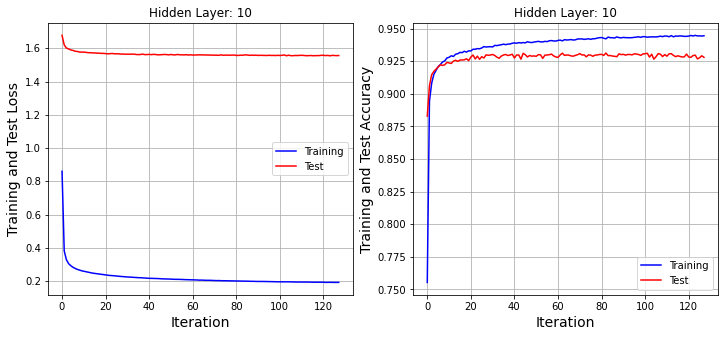

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss1, 'b', label = "Training")
ax[0].plot(range(128), test_loss1, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 10')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc1, 'b', label = "Training")
ax[1].plot(range(128), test_acc1, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 10')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 10.png")

In [12]:
model = BaselineModel(784,100,10)

train_loss2 = np.zeros(128)
test_loss2 = np.zeros(128)
train_acc2 = np.zeros(128)
test_acc2 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss2[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss2[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc2[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc2[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.26769310235977173, 'running_acc': 0.9234374761581421, 'loss': 0.4320841133594513, 'acc': 0.887499988079071, 'val_loss': 1.5742725133895874, 'val_acc': 0.9310999512672424}
Epoch: 1
Training Loss: 0.4320841133594513
Training Accuracy: 0.887499988079071
Test Loss: 1.5742725133895874
Test Accuracy: 0.9310999512672424


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.17782457172870636, 'running_acc': 0.949999988079071, 'loss': 0.2046431005001068, 'acc': 0.9421499967575073, 'val_loss': 1.5436736345291138, 'val_acc': 0.9508000016212463}
Epoch: 2
Training Loss: 0.2046431005001068
Training Accuracy: 0.9421499967575073
Test Loss: 1.5436736345291138
Test Accuracy: 0.9508000016212463


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.14569658041000366, 'running_acc': 0.9585937261581421, 'loss': 0.1534987837076187, 'acc': 0.9557333588600159, 'val_loss': 1.5260227918624878, 'val_acc': 0.960599958896637}
Epoch: 3
Training Loss: 0.1534987837076187
Training Accuracy: 0.9557333588600159
Test Loss: 1.5260227918624878
Test Accuracy: 0.960599958896637


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1248355433344841, 'running_acc': 0.96546870470047, 'loss': 0.12221057713031769, 'acc': 0.9646999835968018, 'val_loss': 1.5192956924438477, 'val_acc': 0.9645999670028687}
Epoch: 4
Training Loss: 0.12221057713031769
Training Accuracy: 0.9646999835968018
Test Loss: 1.5192956924438477
Test Accuracy: 0.9645999670028687


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09233598411083221, 'running_acc': 0.9753124713897705, 'loss': 0.10061651468276978, 'acc': 0.9714500308036804, 'val_loss': 1.5100126266479492, 'val_acc': 0.9692999720573425}
Epoch: 5
Training Loss: 0.10061651468276978
Training Accuracy: 0.9714500308036804
Test Loss: 1.5100126266479492
Test Accuracy: 0.9692999720573425


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.07958512008190155, 'running_acc': 0.9765625, 'loss': 0.08509866148233414, 'acc': 0.9754166603088379, 'val_loss': 1.506774663925171, 'val_acc': 0.9703999757766724}
Epoch: 6
Training Loss: 0.08509866148233414
Training Accuracy: 0.9754166603088379
Test Loss: 1.506774663925171
Test Accuracy: 0.9703999757766724


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.07020529359579086, 'running_acc': 0.9781249761581421, 'loss': 0.07225445657968521, 'acc': 0.979283332824707, 'val_loss': 1.5021820068359375, 'val_acc': 0.9732999801635742}
Epoch: 7
Training Loss: 0.07225445657968521
Training Accuracy: 0.979283332824707
Test Loss: 1.5021820068359375
Test Accuracy: 0.9732999801635742


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.05387948453426361, 'running_acc': 0.9848437309265137, 'loss': 0.06322470307350159, 'acc': 0.9818500280380249, 'val_loss': 1.4990692138671875, 'val_acc': 0.9756999611854553}
Epoch: 8
Training Loss: 0.06322470307350159
Training Accuracy: 0.9818500280380249
Test Loss: 1.4990692138671875
Test Accuracy: 0.9756999611854553


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.055190008133649826, 'running_acc': 0.9834374785423279, 'loss': 0.05446537584066391, 'acc': 0.9845166802406311, 'val_loss': 1.4989209175109863, 'val_acc': 0.973800003528595}
Epoch: 9
Training Loss: 0.05446537584066391
Training Accuracy: 0.9845166802406311
Test Loss: 1.4989209175109863
Test Accuracy: 0.973800003528595


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.05295489728450775, 'running_acc': 0.9845312237739563, 'loss': 0.04815147444605827, 'acc': 0.9860333204269409, 'val_loss': 1.4958977699279785, 'val_acc': 0.9761999845504761}
Epoch: 10
Training Loss: 0.04815147444605827
Training Accuracy: 0.9860333204269409
Test Loss: 1.4958977699279785
Test Accuracy: 0.9761999845504761


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.040980830788612366, 'running_acc': 0.9856249690055847, 'loss': 0.04168595001101494, 'acc': 0.987933337688446, 'val_loss': 1.4940720796585083, 'val_acc': 0.9751999974250793}
Epoch: 11
Training Loss: 0.04168595001101494
Training Accuracy: 0.987933337688446
Test Loss: 1.4940720796585083
Test Accuracy: 0.9751999974250793


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03991743177175522, 'running_acc': 0.9885937571525574, 'loss': 0.03698981925845146, 'acc': 0.9893333315849304, 'val_loss': 1.4925901889801025, 'val_acc': 0.9764999747276306}
Epoch: 12
Training Loss: 0.03698981925845146
Training Accuracy: 0.9893333315849304
Test Loss: 1.4925901889801025
Test Accuracy: 0.9764999747276306


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02835548296570778, 'running_acc': 0.9912499785423279, 'loss': 0.032458189874887466, 'acc': 0.9908166527748108, 'val_loss': 1.491458773612976, 'val_acc': 0.9777999520301819}
Epoch: 13
Training Loss: 0.032458189874887466
Training Accuracy: 0.9908166527748108
Test Loss: 1.491458773612976
Test Accuracy: 0.9777999520301819


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02772015705704689, 'running_acc': 0.9914062023162842, 'loss': 0.02795548550784588, 'acc': 0.9927166700363159, 'val_loss': 1.491186499595642, 'val_acc': 0.9779999852180481}
Epoch: 14
Training Loss: 0.02795548550784588
Training Accuracy: 0.9927166700363159
Test Loss: 1.491186499595642
Test Accuracy: 0.9779999852180481


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.024141106754541397, 'running_acc': 0.9932812452316284, 'loss': 0.02478945069015026, 'acc': 0.9936500191688538, 'val_loss': 1.4893856048583984, 'val_acc': 0.9777999520301819}
Epoch: 15
Training Loss: 0.02478945069015026
Training Accuracy: 0.9936500191688538
Test Loss: 1.4893856048583984
Test Accuracy: 0.9777999520301819


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.026132889091968536, 'running_acc': 0.9921875, 'loss': 0.02122306637465954, 'acc': 0.9949166774749756, 'val_loss': 1.4896880388259888, 'val_acc': 0.9763999581336975}
Epoch: 16
Training Loss: 0.02122306637465954
Training Accuracy: 0.9949166774749756
Test Loss: 1.4896880388259888
Test Accuracy: 0.9763999581336975


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02084556594491005, 'running_acc': 0.9942187070846558, 'loss': 0.01928967982530594, 'acc': 0.9951666593551636, 'val_loss': 1.4890812635421753, 'val_acc': 0.977899968624115}
Epoch: 17
Training Loss: 0.01928967982530594
Training Accuracy: 0.9951666593551636
Test Loss: 1.4890812635421753
Test Accuracy: 0.977899968624115


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.017974836751818657, 'running_acc': 0.9954687356948853, 'loss': 0.01715022511780262, 'acc': 0.9960333704948425, 'val_loss': 1.487928032875061, 'val_acc': 0.9779999852180481}
Epoch: 18
Training Loss: 0.01715022511780262
Training Accuracy: 0.9960333704948425
Test Loss: 1.487928032875061
Test Accuracy: 0.9779999852180481


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01635383628308773, 'running_acc': 0.9954687356948853, 'loss': 0.01551520824432373, 'acc': 0.99631667137146, 'val_loss': 1.4880268573760986, 'val_acc': 0.977400004863739}
Epoch: 19
Training Loss: 0.01551520824432373
Training Accuracy: 0.99631667137146
Test Loss: 1.4880268573760986
Test Accuracy: 0.977400004863739


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013697396032512188, 'running_acc': 0.99671870470047, 'loss': 0.012569842860102654, 'acc': 0.9972666501998901, 'val_loss': 1.4877724647521973, 'val_acc': 0.9776999950408936}
Epoch: 20
Training Loss: 0.012569842860102654
Training Accuracy: 0.9972666501998901
Test Loss: 1.4877724647521973
Test Accuracy: 0.9776999950408936


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013968449085950851, 'running_acc': 0.9957812428474426, 'loss': 0.011259801685810089, 'acc': 0.9978333711624146, 'val_loss': 1.4873526096343994, 'val_acc': 0.9763999581336975}
Epoch: 21
Training Loss: 0.011259801685810089
Training Accuracy: 0.9978333711624146
Test Loss: 1.4873526096343994
Test Accuracy: 0.9763999581336975


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009822120890021324, 'running_acc': 0.9976562261581421, 'loss': 0.010333373211324215, 'acc': 0.9979000091552734, 'val_loss': 1.486914873123169, 'val_acc': 0.9772999882698059}
Epoch: 22
Training Loss: 0.010333373211324215
Training Accuracy: 0.9979000091552734
Test Loss: 1.486914873123169
Test Accuracy: 0.9772999882698059


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010568912141025066, 'running_acc': 0.9971874952316284, 'loss': 0.009214184246957302, 'acc': 0.9982666969299316, 'val_loss': 1.4882385730743408, 'val_acc': 0.9761999845504761}
Epoch: 23
Training Loss: 0.009214184246957302
Training Accuracy: 0.9982666969299316
Test Loss: 1.4882385730743408
Test Accuracy: 0.9761999845504761


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007980193011462688, 'running_acc': 0.9989062547683716, 'loss': 0.008533859625458717, 'acc': 0.9983500242233276, 'val_loss': 1.4887293577194214, 'val_acc': 0.9754999876022339}
Epoch: 24
Training Loss: 0.008533859625458717
Training Accuracy: 0.9983500242233276
Test Loss: 1.4887293577194214
Test Accuracy: 0.9754999876022339


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00843451265245676, 'running_acc': 0.9982812404632568, 'loss': 0.0075745247304439545, 'acc': 0.9986000061035156, 'val_loss': 1.4858061075210571, 'val_acc': 0.9774999618530273}
Epoch: 25
Training Loss: 0.0075745247304439545
Training Accuracy: 0.9986000061035156
Test Loss: 1.4858061075210571
Test Accuracy: 0.9774999618530273


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005533402319997549, 'running_acc': 0.9995312094688416, 'loss': 0.006397271063178778, 'acc': 0.9988833665847778, 'val_loss': 1.485823631286621, 'val_acc': 0.9781000018119812}
Epoch: 26
Training Loss: 0.006397271063178778
Training Accuracy: 0.9988833665847778
Test Loss: 1.485823631286621
Test Accuracy: 0.9781000018119812


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007436094339936972, 'running_acc': 0.9990624785423279, 'loss': 0.005049931351095438, 'acc': 0.9994500279426575, 'val_loss': 1.4881558418273926, 'val_acc': 0.976099967956543}
Epoch: 27
Training Loss: 0.005049931351095438
Training Accuracy: 0.9994500279426575
Test Loss: 1.4881558418273926
Test Accuracy: 0.976099967956543


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007008548825979233, 'running_acc': 0.9984374642372131, 'loss': 0.004691030364483595, 'acc': 0.9993333220481873, 'val_loss': 1.487675666809082, 'val_acc': 0.9752999544143677}
Epoch: 28
Training Loss: 0.004691030364483595
Training Accuracy: 0.9993333220481873
Test Loss: 1.487675666809082
Test Accuracy: 0.9752999544143677


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007447409443557262, 'running_acc': 0.9975000023841858, 'loss': 0.005114175379276276, 'acc': 0.9989833235740662, 'val_loss': 1.4875577688217163, 'val_acc': 0.9763000011444092}
Epoch: 29
Training Loss: 0.005114175379276276
Training Accuracy: 0.9989833235740662
Test Loss: 1.4875577688217163
Test Accuracy: 0.9763000011444092


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0038480600342154503, 'running_acc': 0.9995312094688416, 'loss': 0.004815969150513411, 'acc': 0.9990833401679993, 'val_loss': 1.4867788553237915, 'val_acc': 0.976699948310852}
Epoch: 30
Training Loss: 0.004815969150513411
Training Accuracy: 0.9990833401679993
Test Loss: 1.4867788553237915
Test Accuracy: 0.976699948310852


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005149179603904486, 'running_acc': 0.9990624785423279, 'loss': 0.0038300021551549435, 'acc': 0.9994833469390869, 'val_loss': 1.4863005876541138, 'val_acc': 0.9770999550819397}
Epoch: 31
Training Loss: 0.0038300021551549435
Training Accuracy: 0.9994833469390869
Test Loss: 1.4863005876541138
Test Accuracy: 0.9770999550819397


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003864864818751812, 'running_acc': 0.9993749856948853, 'loss': 0.0033041348215192556, 'acc': 0.999500036239624, 'val_loss': 1.4854233264923096, 'val_acc': 0.977899968624115}
Epoch: 32
Training Loss: 0.0033041348215192556
Training Accuracy: 0.999500036239624
Test Loss: 1.4854233264923096
Test Accuracy: 0.977899968624115


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005719732493162155, 'running_acc': 0.9984374642372131, 'loss': 0.0025650763418525457, 'acc': 0.9996333718299866, 'val_loss': 1.4859862327575684, 'val_acc': 0.9763999581336975}
Epoch: 33
Training Loss: 0.0025650763418525457
Training Accuracy: 0.9996333718299866
Test Loss: 1.4859862327575684
Test Accuracy: 0.9763999581336975


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0030666764359921217, 'running_acc': 0.9993749856948853, 'loss': 0.004233341198414564, 'acc': 0.9990833401679993, 'val_loss': 1.4845260381698608, 'val_acc': 0.9785999655723572}
Epoch: 34
Training Loss: 0.004233341198414564
Training Accuracy: 0.9990833401679993
Test Loss: 1.4845260381698608
Test Accuracy: 0.9785999655723572


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0021332213655114174, 'running_acc': 0.9998437166213989, 'loss': 0.0020003600511699915, 'acc': 0.9998500347137451, 'val_loss': 1.4855170249938965, 'val_acc': 0.9768999814987183}
Epoch: 35
Training Loss: 0.0020003600511699915
Training Accuracy: 0.9998500347137451
Test Loss: 1.4855170249938965
Test Accuracy: 0.9768999814987183


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009312434121966362, 'running_acc': 0.99671870470047, 'loss': 0.0033231417182832956, 'acc': 0.9991999864578247, 'val_loss': 1.4884401559829712, 'val_acc': 0.9749999642372131}
Epoch: 36
Training Loss: 0.0033231417182832956
Training Accuracy: 0.9991999864578247
Test Loss: 1.4884401559829712
Test Accuracy: 0.9749999642372131


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003211837261915207, 'running_acc': 0.9995312094688416, 'loss': 0.0051245177164673805, 'acc': 0.9987500309944153, 'val_loss': 1.4861111640930176, 'val_acc': 0.9770999550819397}
Epoch: 37
Training Loss: 0.0051245177164673805
Training Accuracy: 0.9987500309944153
Test Loss: 1.4861111640930176
Test Accuracy: 0.9770999550819397


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0018562738550826907, 'running_acc': 0.9998437166213989, 'loss': 0.001983219524845481, 'acc': 0.999750018119812, 'val_loss': 1.4846118688583374, 'val_acc': 0.9772999882698059}
Epoch: 38
Training Loss: 0.001983219524845481
Training Accuracy: 0.999750018119812
Test Loss: 1.4846118688583374
Test Accuracy: 0.9772999882698059


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001290351850911975, 'running_acc': 0.9998437166213989, 'loss': 0.0013890991685912013, 'acc': 0.9998166561126709, 'val_loss': 1.4842147827148438, 'val_acc': 0.9783999919891357}
Epoch: 39
Training Loss: 0.0013890991685912013
Training Accuracy: 0.9998166561126709
Test Loss: 1.4842147827148438
Test Accuracy: 0.9783999919891357


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002180499257519841, 'running_acc': 0.9996874928474426, 'loss': 0.0011070813052356243, 'acc': 0.9998666644096375, 'val_loss': 1.4852502346038818, 'val_acc': 0.9765999913215637}
Epoch: 40
Training Loss: 0.0011070813052356243
Training Accuracy: 0.9998666644096375
Test Loss: 1.4852502346038818
Test Accuracy: 0.9765999913215637


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0008912427583709359, 'running_acc': 1.0, 'loss': 0.0008167517371475697, 'acc': 0.9999833703041077, 'val_loss': 1.4843065738677979, 'val_acc': 0.9779999852180481}
Epoch: 41
Training Loss: 0.0008167517371475697
Training Accuracy: 0.9999833703041077
Test Loss: 1.4843065738677979
Test Accuracy: 0.9779999852180481


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0008703783969394863, 'running_acc': 0.9998437166213989, 'loss': 0.0006100843311287463, 'acc': 0.9999833703041077, 'val_loss': 1.4841312170028687, 'val_acc': 0.9781999588012695}
Epoch: 42
Training Loss: 0.0006100843311287463
Training Accuracy: 0.9999833703041077
Test Loss: 1.4841312170028687
Test Accuracy: 0.9781999588012695


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0008222134201787412, 'running_acc': 1.0, 'loss': 0.0005748291150666773, 'acc': 1.0, 'val_loss': 1.4851468801498413, 'val_acc': 0.976099967956543}
Epoch: 43
Training Loss: 0.0005748291150666773
Training Accuracy: 1.0
Test Loss: 1.4851468801498413
Test Accuracy: 0.976099967956543


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005709906108677387, 'running_acc': 0.9982812404632568, 'loss': 0.008021078072488308, 'acc': 0.9973000288009644, 'val_loss': 1.484490156173706, 'val_acc': 0.977899968624115}
Epoch: 44
Training Loss: 0.008021078072488308
Training Accuracy: 0.9973000288009644
Test Loss: 1.484490156173706
Test Accuracy: 0.977899968624115


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0021328649017959833, 'running_acc': 0.9996874928474426, 'loss': 0.0029632949735969305, 'acc': 0.9993000030517578, 'val_loss': 1.4859070777893066, 'val_acc': 0.976099967956543}
Epoch: 45
Training Loss: 0.0029632949735969305
Training Accuracy: 0.9993000030517578
Test Loss: 1.4859070777893066
Test Accuracy: 0.976099967956543


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0007690711063332856, 'running_acc': 1.0, 'loss': 0.0009910428198054433, 'acc': 0.9999666810035706, 'val_loss': 1.4839919805526733, 'val_acc': 0.9781000018119812}
Epoch: 46
Training Loss: 0.0009910428198054433
Training Accuracy: 0.9999666810035706
Test Loss: 1.4839919805526733
Test Accuracy: 0.9781000018119812


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00041374226566404104, 'running_acc': 1.0, 'loss': 0.000440003554103896, 'acc': 1.0, 'val_loss': 1.4835036993026733, 'val_acc': 0.9790999889373779}
Epoch: 47
Training Loss: 0.000440003554103896
Training Accuracy: 1.0
Test Loss: 1.4835036993026733
Test Accuracy: 0.9790999889373779


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00037989713018760085, 'running_acc': 1.0, 'loss': 0.0003649685822892934, 'acc': 1.0, 'val_loss': 1.4843043088912964, 'val_acc': 0.9782999753952026}
Epoch: 48
Training Loss: 0.0003649685822892934
Training Accuracy: 1.0
Test Loss: 1.4843043088912964
Test Accuracy: 0.9782999753952026


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0003146895032841712, 'running_acc': 1.0, 'loss': 0.00033405417343601584, 'acc': 1.0, 'val_loss': 1.483278751373291, 'val_acc': 0.9787999987602234}
Epoch: 49
Training Loss: 0.00033405417343601584
Training Accuracy: 1.0
Test Loss: 1.483278751373291
Test Accuracy: 0.9787999987602234


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00023916737700346857, 'running_acc': 1.0, 'loss': 0.00029401719802990556, 'acc': 1.0, 'val_loss': 1.4840129613876343, 'val_acc': 0.9785999655723572}
Epoch: 50
Training Loss: 0.00029401719802990556
Training Accuracy: 1.0
Test Loss: 1.4840129613876343
Test Accuracy: 0.9785999655723572


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002715761074796319, 'running_acc': 1.0, 'loss': 0.00028014363488182425, 'acc': 1.0, 'val_loss': 1.4833338260650635, 'val_acc': 0.9792999625205994}
Epoch: 51
Training Loss: 0.00028014363488182425
Training Accuracy: 1.0
Test Loss: 1.4833338260650635
Test Accuracy: 0.9792999625205994


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010894005186855793, 'running_acc': 0.9965624809265137, 'loss': 0.00633238535374403, 'acc': 0.9980000257492065, 'val_loss': 1.486921787261963, 'val_acc': 0.9745000004768372}
Epoch: 52
Training Loss: 0.00633238535374403
Training Accuracy: 0.9980000257492065
Test Loss: 1.486921787261963
Test Accuracy: 0.9745000004768372


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002461800118908286, 'running_acc': 0.9993749856948853, 'loss': 0.005924934055656195, 'acc': 0.9980000257492065, 'val_loss': 1.483959436416626, 'val_acc': 0.9783999919891357}
Epoch: 53
Training Loss: 0.005924934055656195
Training Accuracy: 0.9980000257492065
Test Loss: 1.483959436416626
Test Accuracy: 0.9783999919891357


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.000564486428629607, 'running_acc': 1.0, 'loss': 0.0009499752195551991, 'acc': 0.9999333620071411, 'val_loss': 1.4836647510528564, 'val_acc': 0.9781999588012695}
Epoch: 54
Training Loss: 0.0009499752195551991
Training Accuracy: 0.9999333620071411
Test Loss: 1.4836647510528564
Test Accuracy: 0.9781999588012695


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0003128486860077828, 'running_acc': 1.0, 'loss': 0.0003688608994707465, 'acc': 1.0, 'val_loss': 1.4839624166488647, 'val_acc': 0.9783999919891357}
Epoch: 55
Training Loss: 0.0003688608994707465
Training Accuracy: 1.0
Test Loss: 1.4839624166488647
Test Accuracy: 0.9783999919891357


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00024515128461644053, 'running_acc': 1.0, 'loss': 0.00027336858329363167, 'acc': 1.0, 'val_loss': 1.4832955598831177, 'val_acc': 0.9785999655723572}
Epoch: 56
Training Loss: 0.00027336858329363167
Training Accuracy: 1.0
Test Loss: 1.4832955598831177
Test Accuracy: 0.9785999655723572


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002362946979701519, 'running_acc': 1.0, 'loss': 0.00023396909818984568, 'acc': 1.0, 'val_loss': 1.4831547737121582, 'val_acc': 0.9786999821662903}
Epoch: 57
Training Loss: 0.00023396909818984568
Training Accuracy: 1.0
Test Loss: 1.4831547737121582
Test Accuracy: 0.9786999821662903


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00022505433298647404, 'running_acc': 1.0, 'loss': 0.00021433606161735952, 'acc': 1.0, 'val_loss': 1.4830596446990967, 'val_acc': 0.9787999987602234}
Epoch: 58
Training Loss: 0.00021433606161735952
Training Accuracy: 1.0
Test Loss: 1.4830596446990967
Test Accuracy: 0.9787999987602234


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00018828402971848845, 'running_acc': 1.0, 'loss': 0.00019342931045684963, 'acc': 1.0, 'val_loss': 1.4830535650253296, 'val_acc': 0.9788999557495117}
Epoch: 59
Training Loss: 0.00019342931045684963
Training Accuracy: 1.0
Test Loss: 1.4830535650253296
Test Accuracy: 0.9788999557495117


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00019982272351626307, 'running_acc': 1.0, 'loss': 0.00018375641957391053, 'acc': 1.0, 'val_loss': 1.4831956624984741, 'val_acc': 0.9788999557495117}
Epoch: 60
Training Loss: 0.00018375641957391053
Training Accuracy: 1.0
Test Loss: 1.4831956624984741
Test Accuracy: 0.9788999557495117


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00017506831500213593, 'running_acc': 1.0, 'loss': 0.00016574062465224415, 'acc': 1.0, 'val_loss': 1.4831130504608154, 'val_acc': 0.9785999655723572}
Epoch: 61
Training Loss: 0.00016574062465224415
Training Accuracy: 1.0
Test Loss: 1.4831130504608154
Test Accuracy: 0.9785999655723572


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.034782469272613525, 'running_acc': 0.9895312190055847, 'loss': 0.0046263281255960464, 'acc': 0.9986833333969116, 'val_loss': 1.491016149520874, 'val_acc': 0.9709999561309814}
Epoch: 62
Training Loss: 0.0046263281255960464
Training Accuracy: 0.9986833333969116
Test Loss: 1.491016149520874
Test Accuracy: 0.9709999561309814


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00330784497782588, 'running_acc': 0.9992187023162842, 'loss': 0.0067300135269761086, 'acc': 0.9977499842643738, 'val_loss': 1.485650658607483, 'val_acc': 0.976099967956543}
Epoch: 63
Training Loss: 0.0067300135269761086
Training Accuracy: 0.9977499842643738
Test Loss: 1.485650658607483
Test Accuracy: 0.976099967956543


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00035196056705899537, 'running_acc': 1.0, 'loss': 0.0011769657721742988, 'acc': 0.9997667074203491, 'val_loss': 1.4836981296539307, 'val_acc': 0.9779999852180481}
Epoch: 64
Training Loss: 0.0011769657721742988
Training Accuracy: 0.9997667074203491
Test Loss: 1.4836981296539307
Test Accuracy: 0.9779999852180481


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002573258534539491, 'running_acc': 1.0, 'loss': 0.00026323433849029243, 'acc': 1.0, 'val_loss': 1.484035849571228, 'val_acc': 0.9779999852180481}
Epoch: 65
Training Loss: 0.00026323433849029243
Training Accuracy: 1.0
Test Loss: 1.484035849571228
Test Accuracy: 0.9779999852180481


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00017766185919754207, 'running_acc': 1.0, 'loss': 0.00018469415954314172, 'acc': 1.0, 'val_loss': 1.4831713438034058, 'val_acc': 0.9788999557495117}
Epoch: 66
Training Loss: 0.00018469415954314172
Training Accuracy: 1.0
Test Loss: 1.4831713438034058
Test Accuracy: 0.9788999557495117


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0001861900236690417, 'running_acc': 1.0, 'loss': 0.00016041871276684105, 'acc': 1.0, 'val_loss': 1.4832104444503784, 'val_acc': 0.9786999821662903}
Epoch: 67
Training Loss: 0.00016041871276684105
Training Accuracy: 1.0
Test Loss: 1.4832104444503784
Test Accuracy: 0.9786999821662903


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0001257490221178159, 'running_acc': 1.0, 'loss': 0.00014458547229878604, 'acc': 1.0, 'val_loss': 1.4842121601104736, 'val_acc': 0.9783999919891357}
Epoch: 68
Training Loss: 0.00014458547229878604
Training Accuracy: 1.0
Test Loss: 1.4842121601104736
Test Accuracy: 0.9783999919891357


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00012534740380942822, 'running_acc': 1.0, 'loss': 0.00013006139488425106, 'acc': 1.0, 'val_loss': 1.4831047058105469, 'val_acc': 0.9785999655723572}
Epoch: 69
Training Loss: 0.00013006139488425106
Training Accuracy: 1.0
Test Loss: 1.4831047058105469
Test Accuracy: 0.9785999655723572


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00014871468010824174, 'running_acc': 1.0, 'loss': 0.00012140579929109663, 'acc': 1.0, 'val_loss': 1.4832350015640259, 'val_acc': 0.9783999919891357}
Epoch: 70
Training Loss: 0.00012140579929109663
Training Accuracy: 1.0
Test Loss: 1.4832350015640259
Test Accuracy: 0.9783999919891357


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00011142464791191742, 'running_acc': 1.0, 'loss': 0.00011623916361713782, 'acc': 1.0, 'val_loss': 1.4834619760513306, 'val_acc': 0.9779999852180481}
Epoch: 71
Training Loss: 0.00011623916361713782
Training Accuracy: 1.0
Test Loss: 1.4834619760513306
Test Accuracy: 0.9779999852180481


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00011214079859200865, 'running_acc': 1.0, 'loss': 0.00010626537550706416, 'acc': 1.0, 'val_loss': 1.4830340147018433, 'val_acc': 0.9787999987602234}
Epoch: 72
Training Loss: 0.00010626537550706416
Training Accuracy: 1.0
Test Loss: 1.4830340147018433
Test Accuracy: 0.9787999987602234


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.027451032772660255, 'running_acc': 0.9925000071525574, 'loss': 0.00802067294716835, 'acc': 0.9979667067527771, 'val_loss': 1.4875400066375732, 'val_acc': 0.973800003528595}
Epoch: 73
Training Loss: 0.00802067294716835
Training Accuracy: 0.9979667067527771
Test Loss: 1.4875400066375732
Test Accuracy: 0.973800003528595


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0019770977087318897, 'running_acc': 0.9995312094688416, 'loss': 0.004085911903530359, 'acc': 0.9987000226974487, 'val_loss': 1.4858522415161133, 'val_acc': 0.9763999581336975}
Epoch: 74
Training Loss: 0.004085911903530359
Training Accuracy: 0.9987000226974487
Test Loss: 1.4858522415161133
Test Accuracy: 0.9763999581336975


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00034162006340920925, 'running_acc': 1.0, 'loss': 0.0006247778073884547, 'acc': 0.9999333620071411, 'val_loss': 1.4839329719543457, 'val_acc': 0.9774999618530273}
Epoch: 75
Training Loss: 0.0006247778073884547
Training Accuracy: 0.9999333620071411
Test Loss: 1.4839329719543457
Test Accuracy: 0.9774999618530273


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002001092507271096, 'running_acc': 1.0, 'loss': 0.0002017466613324359, 'acc': 1.0, 'val_loss': 1.4840158224105835, 'val_acc': 0.9775999784469604}
Epoch: 76
Training Loss: 0.0002017466613324359
Training Accuracy: 1.0
Test Loss: 1.4840158224105835
Test Accuracy: 0.9775999784469604


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.000151728730998002, 'running_acc': 1.0, 'loss': 0.00014849149738438427, 'acc': 1.0, 'val_loss': 1.4836664199829102, 'val_acc': 0.9781999588012695}
Epoch: 77
Training Loss: 0.00014849149738438427
Training Accuracy: 1.0
Test Loss: 1.4836664199829102
Test Accuracy: 0.9781999588012695


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00013238683459348977, 'running_acc': 1.0, 'loss': 0.0001269951753783971, 'acc': 1.0, 'val_loss': 1.4834580421447754, 'val_acc': 0.9783999919891357}
Epoch: 78
Training Loss: 0.0001269951753783971
Training Accuracy: 1.0
Test Loss: 1.4834580421447754
Test Accuracy: 0.9783999919891357


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0001180985345854424, 'running_acc': 1.0, 'loss': 0.00011151024955324829, 'acc': 1.0, 'val_loss': 1.4834364652633667, 'val_acc': 0.9785999655723572}
Epoch: 79
Training Loss: 0.00011151024955324829
Training Accuracy: 1.0
Test Loss: 1.4834364652633667
Test Accuracy: 0.9785999655723572


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.472545934841037e-05, 'running_acc': 1.0, 'loss': 9.84121797955595e-05, 'acc': 1.0, 'val_loss': 1.4833937883377075, 'val_acc': 0.9781999588012695}
Epoch: 80
Training Loss: 9.84121797955595e-05
Training Accuracy: 1.0
Test Loss: 1.4833937883377075
Test Accuracy: 0.9781999588012695


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.929200364742428e-05, 'running_acc': 1.0, 'loss': 8.954561781138182e-05, 'acc': 1.0, 'val_loss': 1.4832297563552856, 'val_acc': 0.9787999987602234}
Epoch: 81
Training Loss: 8.954561781138182e-05
Training Accuracy: 1.0
Test Loss: 1.4832297563552856
Test Accuracy: 0.9787999987602234


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.426495332969353e-05, 'running_acc': 1.0, 'loss': 8.156241528922692e-05, 'acc': 1.0, 'val_loss': 1.4833221435546875, 'val_acc': 0.9787999987602234}
Epoch: 82
Training Loss: 8.156241528922692e-05
Training Accuracy: 1.0
Test Loss: 1.4833221435546875
Test Accuracy: 0.9787999987602234


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.637729868292809e-05, 'running_acc': 1.0, 'loss': 7.370074308710173e-05, 'acc': 1.0, 'val_loss': 1.4839413166046143, 'val_acc': 0.9785999655723572}
Epoch: 83
Training Loss: 7.370074308710173e-05
Training Accuracy: 1.0
Test Loss: 1.4839413166046143
Test Accuracy: 0.9785999655723572


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.471182470908388e-05, 'running_acc': 1.0, 'loss': 6.782405398553237e-05, 'acc': 1.0, 'val_loss': 1.4832087755203247, 'val_acc': 0.9783999919891357}
Epoch: 84
Training Loss: 6.782405398553237e-05
Training Accuracy: 1.0
Test Loss: 1.4832087755203247
Test Accuracy: 0.9783999919891357


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.0655740526271984e-05, 'running_acc': 1.0, 'loss': 6.204457167768851e-05, 'acc': 1.0, 'val_loss': 1.484049677848816, 'val_acc': 0.9782999753952026}
Epoch: 85
Training Loss: 6.204457167768851e-05
Training Accuracy: 1.0
Test Loss: 1.484049677848816
Test Accuracy: 0.9782999753952026


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.806726742070168e-05, 'running_acc': 1.0, 'loss': 6.400435086106881e-05, 'acc': 1.0, 'val_loss': 1.483458399772644, 'val_acc': 0.9777999520301819}
Epoch: 86
Training Loss: 6.400435086106881e-05
Training Accuracy: 1.0
Test Loss: 1.483458399772644
Test Accuracy: 0.9777999520301819


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.021157365292310715, 'running_acc': 0.9950000047683716, 'loss': 0.0032004560343921185, 'acc': 0.9991999864578247, 'val_loss': 1.492199182510376, 'val_acc': 0.9703999757766724}
Epoch: 87
Training Loss: 0.0032004560343921185
Training Accuracy: 0.9991999864578247
Test Loss: 1.492199182510376
Test Accuracy: 0.9703999757766724


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0037800080608576536, 'running_acc': 0.9992187023162842, 'loss': 0.006918819155544043, 'acc': 0.9977999925613403, 'val_loss': 1.4854573011398315, 'val_acc': 0.9756999611854553}
Epoch: 88
Training Loss: 0.006918819155544043
Training Accuracy: 0.9977999925613403
Test Loss: 1.4854573011398315
Test Accuracy: 0.9756999611854553


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00027950532967224717, 'running_acc': 1.0, 'loss': 0.0006310530588962138, 'acc': 0.9998666644096375, 'val_loss': 1.4837853908538818, 'val_acc': 0.977400004863739}
Epoch: 89
Training Loss: 0.0006310530588962138
Training Accuracy: 0.9998666644096375
Test Loss: 1.4837853908538818
Test Accuracy: 0.977400004863739


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00018801000260282308, 'running_acc': 1.0, 'loss': 0.0001754157419782132, 'acc': 1.0, 'val_loss': 1.4835965633392334, 'val_acc': 0.9771999716758728}
Epoch: 90
Training Loss: 0.0001754157419782132
Training Accuracy: 1.0
Test Loss: 1.4835965633392334
Test Accuracy: 0.9771999716758728


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.129563113674521e-05, 'running_acc': 1.0, 'loss': 0.00010828921949723735, 'acc': 1.0, 'val_loss': 1.4834198951721191, 'val_acc': 0.9776999950408936}
Epoch: 91
Training Loss: 0.00010828921949723735
Training Accuracy: 1.0
Test Loss: 1.4834198951721191
Test Accuracy: 0.9776999950408936


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.180379518307745e-05, 'running_acc': 1.0, 'loss': 8.394844189751893e-05, 'acc': 1.0, 'val_loss': 1.4833790063858032, 'val_acc': 0.977899968624115}
Epoch: 92
Training Loss: 8.394844189751893e-05
Training Accuracy: 1.0
Test Loss: 1.4833790063858032
Test Accuracy: 0.977899968624115


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.25585559848696e-05, 'running_acc': 1.0, 'loss': 7.306844054255635e-05, 'acc': 1.0, 'val_loss': 1.483262062072754, 'val_acc': 0.9781000018119812}
Epoch: 93
Training Loss: 7.306844054255635e-05
Training Accuracy: 1.0
Test Loss: 1.483262062072754
Test Accuracy: 0.9781000018119812


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.907981151016429e-05, 'running_acc': 1.0, 'loss': 6.487349310191348e-05, 'acc': 1.0, 'val_loss': 1.483198881149292, 'val_acc': 0.9779999852180481}
Epoch: 94
Training Loss: 6.487349310191348e-05
Training Accuracy: 1.0
Test Loss: 1.483198881149292
Test Accuracy: 0.9779999852180481


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.045703048584983e-05, 'running_acc': 1.0, 'loss': 5.771934593212791e-05, 'acc': 1.0, 'val_loss': 1.4830641746520996, 'val_acc': 0.9781000018119812}
Epoch: 95
Training Loss: 5.771934593212791e-05
Training Accuracy: 1.0
Test Loss: 1.4830641746520996
Test Accuracy: 0.9781000018119812


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.224106618901715e-05, 'running_acc': 1.0, 'loss': 5.213165422901511e-05, 'acc': 1.0, 'val_loss': 1.4829813241958618, 'val_acc': 0.9781999588012695}
Epoch: 96
Training Loss: 5.213165422901511e-05
Training Accuracy: 1.0
Test Loss: 1.4829813241958618
Test Accuracy: 0.9781999588012695


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.961064041708596e-05, 'running_acc': 1.0, 'loss': 4.761523814522661e-05, 'acc': 1.0, 'val_loss': 1.484483003616333, 'val_acc': 0.9785999655723572}
Epoch: 97
Training Loss: 4.761523814522661e-05
Training Accuracy: 1.0
Test Loss: 1.484483003616333
Test Accuracy: 0.9785999655723572


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.624918074114248e-05, 'running_acc': 1.0, 'loss': 4.313526733312756e-05, 'acc': 1.0, 'val_loss': 1.4828654527664185, 'val_acc': 0.9785999655723572}
Epoch: 98
Training Loss: 4.313526733312756e-05
Training Accuracy: 1.0
Test Loss: 1.4828654527664185
Test Accuracy: 0.9785999655723572


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.025305654271506e-05, 'running_acc': 1.0, 'loss': 3.946667493437417e-05, 'acc': 1.0, 'val_loss': 1.4829270839691162, 'val_acc': 0.9781999588012695}
Epoch: 99
Training Loss: 3.946667493437417e-05
Training Accuracy: 1.0
Test Loss: 1.4829270839691162
Test Accuracy: 0.9781999588012695


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.344703509355895e-05, 'running_acc': 1.0, 'loss': 3.6090008507017046e-05, 'acc': 1.0, 'val_loss': 1.4828497171401978, 'val_acc': 0.9786999821662903}
Epoch: 100
Training Loss: 3.6090008507017046e-05
Training Accuracy: 1.0
Test Loss: 1.4828497171401978
Test Accuracy: 0.9786999821662903


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.8873031624243595e-05, 'running_acc': 1.0, 'loss': 3.308335362817161e-05, 'acc': 1.0, 'val_loss': 1.482638955116272, 'val_acc': 0.9787999987602234}
Epoch: 101
Training Loss: 3.308335362817161e-05
Training Accuracy: 1.0
Test Loss: 1.482638955116272
Test Accuracy: 0.9787999987602234


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.557009404175915e-05, 'running_acc': 1.0, 'loss': 3.2627904147375375e-05, 'acc': 1.0, 'val_loss': 1.4835126399993896, 'val_acc': 0.9787999987602234}
Epoch: 102
Training Loss: 3.2627904147375375e-05
Training Accuracy: 1.0
Test Loss: 1.4835126399993896
Test Accuracy: 0.9787999987602234


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.252700091456063e-05, 'running_acc': 1.0, 'loss': 3.205639950465411e-05, 'acc': 1.0, 'val_loss': 1.4831228256225586, 'val_acc': 0.9781999588012695}
Epoch: 103
Training Loss: 3.205639950465411e-05
Training Accuracy: 1.0
Test Loss: 1.4831228256225586
Test Accuracy: 0.9781999588012695


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.9751015972578898e-05, 'running_acc': 1.0, 'loss': 3.0367740691872314e-05, 'acc': 1.0, 'val_loss': 1.4827061891555786, 'val_acc': 0.9785999655723572}
Epoch: 104
Training Loss: 3.0367740691872314e-05
Training Accuracy: 1.0
Test Loss: 1.4827061891555786
Test Accuracy: 0.9785999655723572


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0031804246827960014, 'running_acc': 0.9985937476158142, 'loss': 0.010900125838816166, 'acc': 0.9968500137329102, 'val_loss': 1.4849773645401, 'val_acc': 0.9764999747276306}
Epoch: 105
Training Loss: 0.010900125838816166
Training Accuracy: 0.9968500137329102
Test Loss: 1.4849773645401
Test Accuracy: 0.9764999747276306


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00020394218154251575, 'running_acc': 1.0, 'loss': 0.0004585179849527776, 'acc': 0.9999833703041077, 'val_loss': 1.4836704730987549, 'val_acc': 0.9771999716758728}
Epoch: 106
Training Loss: 0.0004585179849527776
Training Accuracy: 0.9999833703041077
Test Loss: 1.4836704730987549
Test Accuracy: 0.9771999716758728


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00010377865692134947, 'running_acc': 1.0, 'loss': 0.00010985727567458525, 'acc': 1.0, 'val_loss': 1.4841747283935547, 'val_acc': 0.9771999716758728}
Epoch: 107
Training Loss: 0.00010985727567458525
Training Accuracy: 1.0
Test Loss: 1.4841747283935547
Test Accuracy: 0.9771999716758728


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.238774560391903e-05, 'running_acc': 1.0, 'loss': 7.459575135726482e-05, 'acc': 1.0, 'val_loss': 1.483400583267212, 'val_acc': 0.977400004863739}
Epoch: 108
Training Loss: 7.459575135726482e-05
Training Accuracy: 1.0
Test Loss: 1.483400583267212
Test Accuracy: 0.977400004863739


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.503958138637245e-05, 'running_acc': 1.0, 'loss': 6.208979175426066e-05, 'acc': 1.0, 'val_loss': 1.4832507371902466, 'val_acc': 0.9774999618530273}
Epoch: 109
Training Loss: 6.208979175426066e-05
Training Accuracy: 1.0
Test Loss: 1.4832507371902466
Test Accuracy: 0.9774999618530273


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.5667496781097725e-05, 'running_acc': 1.0, 'loss': 5.362444062484428e-05, 'acc': 1.0, 'val_loss': 1.4832528829574585, 'val_acc': 0.9775999784469604}
Epoch: 110
Training Loss: 5.362444062484428e-05
Training Accuracy: 1.0
Test Loss: 1.4832528829574585
Test Accuracy: 0.9775999784469604


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.691525100497529e-05, 'running_acc': 1.0, 'loss': 4.666212043957785e-05, 'acc': 1.0, 'val_loss': 1.4831366539001465, 'val_acc': 0.9774999618530273}
Epoch: 111
Training Loss: 4.666212043957785e-05
Training Accuracy: 1.0
Test Loss: 1.4831366539001465
Test Accuracy: 0.9774999618530273


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.163511013961397e-05, 'running_acc': 1.0, 'loss': 4.1471208533039317e-05, 'acc': 1.0, 'val_loss': 1.48298978805542, 'val_acc': 0.977899968624115}
Epoch: 112
Training Loss: 4.1471208533039317e-05
Training Accuracy: 1.0
Test Loss: 1.48298978805542
Test Accuracy: 0.977899968624115


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.389853736734949e-05, 'running_acc': 1.0, 'loss': 3.6562149034580216e-05, 'acc': 1.0, 'val_loss': 1.48304283618927, 'val_acc': 0.977899968624115}
Epoch: 113
Training Loss: 3.6562149034580216e-05
Training Accuracy: 1.0
Test Loss: 1.48304283618927
Test Accuracy: 0.977899968624115


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.162751818308607e-05, 'running_acc': 1.0, 'loss': 3.311770342406817e-05, 'acc': 1.0, 'val_loss': 1.4828895330429077, 'val_acc': 0.9782999753952026}
Epoch: 114
Training Loss: 3.311770342406817e-05
Training Accuracy: 1.0
Test Loss: 1.4828895330429077
Test Accuracy: 0.9782999753952026


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.145929440506734e-05, 'running_acc': 1.0, 'loss': 2.9610049750772305e-05, 'acc': 1.0, 'val_loss': 1.4826740026474, 'val_acc': 0.9783999919891357}
Epoch: 115
Training Loss: 2.9610049750772305e-05
Training Accuracy: 1.0
Test Loss: 1.4826740026474
Test Accuracy: 0.9783999919891357


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.7621739718597382e-05, 'running_acc': 1.0, 'loss': 2.6624320526025258e-05, 'acc': 1.0, 'val_loss': 1.4827839136123657, 'val_acc': 0.9785999655723572}
Epoch: 116
Training Loss: 2.6624320526025258e-05
Training Accuracy: 1.0
Test Loss: 1.4827839136123657
Test Accuracy: 0.9785999655723572


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.3931614123284817e-05, 'running_acc': 1.0, 'loss': 2.3998347387532704e-05, 'acc': 1.0, 'val_loss': 1.482685923576355, 'val_acc': 0.9787999987602234}
Epoch: 117
Training Loss: 2.3998347387532704e-05
Training Accuracy: 1.0
Test Loss: 1.482685923576355
Test Accuracy: 0.9787999987602234


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.200324524892494e-05, 'running_acc': 1.0, 'loss': 2.1786114302813075e-05, 'acc': 1.0, 'val_loss': 1.4825644493103027, 'val_acc': 0.9791999459266663}
Epoch: 118
Training Loss: 2.1786114302813075e-05
Training Accuracy: 1.0
Test Loss: 1.4825644493103027
Test Accuracy: 0.9791999459266663


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.1867228497285396e-05, 'running_acc': 1.0, 'loss': 1.9669440007419325e-05, 'acc': 1.0, 'val_loss': 1.4826008081436157, 'val_acc': 0.9787999987602234}
Epoch: 119
Training Loss: 1.9669440007419325e-05
Training Accuracy: 1.0
Test Loss: 1.4826008081436157
Test Accuracy: 0.9787999987602234


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.767641879268922e-05, 'running_acc': 1.0, 'loss': 1.8241615180158988e-05, 'acc': 1.0, 'val_loss': 1.4824717044830322, 'val_acc': 0.9790999889373779}
Epoch: 120
Training Loss: 1.8241615180158988e-05
Training Accuracy: 1.0
Test Loss: 1.4824717044830322
Test Accuracy: 0.9790999889373779


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6688896721461788e-05, 'running_acc': 1.0, 'loss': 1.6698704712325707e-05, 'acc': 1.0, 'val_loss': 1.4823129177093506, 'val_acc': 0.9790999889373779}
Epoch: 121
Training Loss: 1.6698704712325707e-05
Training Accuracy: 1.0
Test Loss: 1.4823129177093506
Test Accuracy: 0.9790999889373779


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6957583284238353e-05, 'running_acc': 1.0, 'loss': 1.5772478946018964e-05, 'acc': 1.0, 'val_loss': 1.4827805757522583, 'val_acc': 0.9788999557495117}
Epoch: 122
Training Loss: 1.5772478946018964e-05
Training Accuracy: 1.0
Test Loss: 1.4827805757522583
Test Accuracy: 0.9788999557495117


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.2997122212254908e-05, 'running_acc': 1.0, 'loss': 1.3760156434727833e-05, 'acc': 1.0, 'val_loss': 1.4822964668273926, 'val_acc': 0.9791999459266663}
Epoch: 123
Training Loss: 1.3760156434727833e-05
Training Accuracy: 1.0
Test Loss: 1.4822964668273926
Test Accuracy: 0.9791999459266663


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010285544209182262, 'running_acc': 0.9975000023841858, 'loss': 0.011354132555425167, 'acc': 0.9973333477973938, 'val_loss': 1.4857765436172485, 'val_acc': 0.9751999974250793}
Epoch: 124
Training Loss: 0.011354132555425167
Training Accuracy: 0.9973333477973938
Test Loss: 1.4857765436172485
Test Accuracy: 0.9751999974250793


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0037990733981132507, 'running_acc': 0.9985937476158142, 'loss': 0.003131358651444316, 'acc': 0.9989166855812073, 'val_loss': 1.486026644706726, 'val_acc': 0.9758999943733215}
Epoch: 125
Training Loss: 0.003131358651444316
Training Accuracy: 0.9989166855812073
Test Loss: 1.486026644706726
Test Accuracy: 0.9758999943733215


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0003028524515684694, 'running_acc': 1.0, 'loss': 0.0008145549218170345, 'acc': 0.9997166991233826, 'val_loss': 1.4820151329040527, 'val_acc': 0.979699969291687}
Epoch: 126
Training Loss: 0.0008145549218170345
Training Accuracy: 0.9997166991233826
Test Loss: 1.4820151329040527
Test Accuracy: 0.979699969291687


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00019349764625076205, 'running_acc': 1.0, 'loss': 0.00014146114699542522, 'acc': 0.9999833703041077, 'val_loss': 1.4822478294372559, 'val_acc': 0.979699969291687}
Epoch: 127
Training Loss: 0.00014146114699542522
Training Accuracy: 0.9999833703041077
Test Loss: 1.4822478294372559
Test Accuracy: 0.979699969291687


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.534412048291415e-05, 'running_acc': 1.0, 'loss': 6.425804895116016e-05, 'acc': 1.0, 'val_loss': 1.4830684661865234, 'val_acc': 0.9792999625205994}
Epoch: 128
Training Loss: 6.425804895116016e-05
Training Accuracy: 1.0
Test Loss: 1.4830684661865234
Test Accuracy: 0.9792999625205994


[{'running_loss': 0.26769310235977173,
  'running_acc': 0.9234374761581421,
  'loss': 0.4320841133594513,
  'acc': 0.887499988079071,
  'val_loss': 1.5742725133895874,
  'val_acc': 0.9310999512672424,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.17782457172870636,
  'running_acc': 0.949999988079071,
  'loss': 0.2046431005001068,
  'acc': 0.9421499967575073,
  'val_loss': 1.5436736345291138,
  'val_acc': 0.9508000016212463,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.14569658041000366,
  'running_acc': 0.9585937261581421,
  'loss': 0.1534987837076187,
  'acc': 0.9557333588600159,
  'val_loss': 1.5260227918624878,
  'val_acc': 0.960599958896637,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.1248355433344841,
  'running_acc': 0.96546870470047,
  'loss': 0.12221057713031769,
  'acc': 0.9646999835968018,
  'val_loss': 1.5192956924438477,
  'val_acc': 0.9645999670028687,
  'train_steps': 469,
  'validation_steps': 79},
 

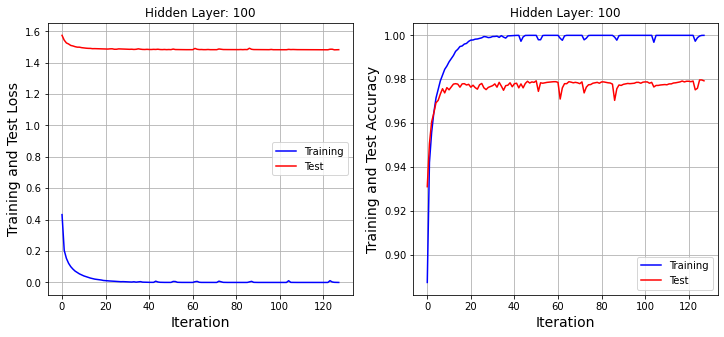

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss2, 'b', label = "Training")
ax[0].plot(range(128), test_loss2, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 100')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc2, 'b', label = "Training")
ax[1].plot(range(128), test_acc2, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 100')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 100.png")

In [15]:
model = BaselineModel(784,200,10)

train_loss3 = np.zeros(128)
test_loss3 = np.zeros(128)
train_acc3 = np.zeros(128)
test_acc3 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss3[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss3[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc3[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc3[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2142525464296341, 'running_acc': 0.9371874928474426, 'loss': 0.3743332624435425, 'acc': 0.9007499814033508, 'val_loss': 1.556296706199646, 'val_acc': 0.9418999552726746}
Epoch: 1
Training Loss: 0.3743332624435425
Training Accuracy: 0.9007499814033508
Test Loss: 1.556296706199646
Test Accuracy: 0.9418999552726746


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1420408934354782, 'running_acc': 0.9590624570846558, 'loss': 0.16731680929660797, 'acc': 0.9518499970436096, 'val_loss': 1.527575135231018, 'val_acc': 0.9602999687194824}
Epoch: 2
Training Loss: 0.16731680929660797
Training Accuracy: 0.9518499970436096
Test Loss: 1.527575135231018
Test Accuracy: 0.9602999687194824


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10057367384433746, 'running_acc': 0.9703124761581421, 'loss': 0.1149306520819664, 'acc': 0.967033326625824, 'val_loss': 1.5105332136154175, 'val_acc': 0.9695999622344971}
Epoch: 3
Training Loss: 0.1149306520819664
Training Accuracy: 0.967033326625824
Test Loss: 1.5105332136154175
Test Accuracy: 0.9695999622344971


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.07673458755016327, 'running_acc': 0.9787499904632568, 'loss': 0.0874229371547699, 'acc': 0.9744166731834412, 'val_loss': 1.504625678062439, 'val_acc': 0.9727999567985535}
Epoch: 4
Training Loss: 0.0874229371547699
Training Accuracy: 0.9744166731834412
Test Loss: 1.504625678062439
Test Accuracy: 0.9727999567985535


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.07373452186584473, 'running_acc': 0.9793750047683716, 'loss': 0.06883037835359573, 'acc': 0.9797833561897278, 'val_loss': 1.4996867179870605, 'val_acc': 0.9738999605178833}
Epoch: 5
Training Loss: 0.06883037835359573
Training Accuracy: 0.9797833561897278
Test Loss: 1.4996867179870605
Test Accuracy: 0.9738999605178833


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.05060116574168205, 'running_acc': 0.984375, 'loss': 0.055320464074611664, 'acc': 0.9840333461761475, 'val_loss': 1.498072862625122, 'val_acc': 0.975600004196167}
Epoch: 6
Training Loss: 0.055320464074611664
Training Accuracy: 0.9840333461761475
Test Loss: 1.498072862625122
Test Accuracy: 0.975600004196167


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.050931189209222794, 'running_acc': 0.985156238079071, 'loss': 0.04551243409514427, 'acc': 0.9868500232696533, 'val_loss': 1.4926340579986572, 'val_acc': 0.9791999459266663}
Epoch: 7
Training Loss: 0.04551243409514427
Training Accuracy: 0.9868500232696533
Test Loss: 1.4926340579986572
Test Accuracy: 0.9791999459266663


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04219513013958931, 'running_acc': 0.9878124594688416, 'loss': 0.037419773638248444, 'acc': 0.9892500042915344, 'val_loss': 1.4910030364990234, 'val_acc': 0.9788999557495117}
Epoch: 8
Training Loss: 0.037419773638248444
Training Accuracy: 0.9892500042915344
Test Loss: 1.4910030364990234
Test Accuracy: 0.9788999557495117


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.033334992825984955, 'running_acc': 0.9912499785423279, 'loss': 0.030070273205637932, 'acc': 0.9918500185012817, 'val_loss': 1.4880461692810059, 'val_acc': 0.979699969291687}
Epoch: 9
Training Loss: 0.030070273205637932
Training Accuracy: 0.9918500185012817
Test Loss: 1.4880461692810059
Test Accuracy: 0.979699969291687


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.024303976446390152, 'running_acc': 0.99281245470047, 'loss': 0.02499731257557869, 'acc': 0.9932833313941956, 'val_loss': 1.4884028434753418, 'val_acc': 0.9786999821662903}
Epoch: 10
Training Loss: 0.02499731257557869
Training Accuracy: 0.9932833313941956
Test Loss: 1.4884028434753418
Test Accuracy: 0.9786999821662903


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.025895453989505768, 'running_acc': 0.9934374690055847, 'loss': 0.02046704664826393, 'acc': 0.9950500130653381, 'val_loss': 1.4866803884506226, 'val_acc': 0.9782999753952026}
Epoch: 11
Training Loss: 0.02046704664826393
Training Accuracy: 0.9950500130653381
Test Loss: 1.4866803884506226
Test Accuracy: 0.9782999753952026


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01924235373735428, 'running_acc': 0.9956249594688416, 'loss': 0.01690501905977726, 'acc': 0.9958500266075134, 'val_loss': 1.4862362146377563, 'val_acc': 0.9803999662399292}
Epoch: 12
Training Loss: 0.01690501905977726
Training Accuracy: 0.9958500266075134
Test Loss: 1.4862362146377563
Test Accuracy: 0.9803999662399292


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0150036895647645, 'running_acc': 0.996874988079071, 'loss': 0.013622998259961605, 'acc': 0.9972333312034607, 'val_loss': 1.488064169883728, 'val_acc': 0.9785999655723572}
Epoch: 13
Training Loss: 0.013622998259961605
Training Accuracy: 0.9972333312034607
Test Loss: 1.488064169883728
Test Accuracy: 0.9785999655723572


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012914170511066914, 'running_acc': 0.996874988079071, 'loss': 0.01158636063337326, 'acc': 0.9976000189781189, 'val_loss': 1.4869078397750854, 'val_acc': 0.9785999655723572}
Epoch: 14
Training Loss: 0.01158636063337326
Training Accuracy: 0.9976000189781189
Test Loss: 1.4869078397750854
Test Accuracy: 0.9785999655723572


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011491862125694752, 'running_acc': 0.9971874952316284, 'loss': 0.009667831473052502, 'acc': 0.998116672039032, 'val_loss': 1.4857231378555298, 'val_acc': 0.9784999489784241}
Epoch: 15
Training Loss: 0.009667831473052502
Training Accuracy: 0.998116672039032
Test Loss: 1.4857231378555298
Test Accuracy: 0.9784999489784241


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009408495388925076, 'running_acc': 0.9978124499320984, 'loss': 0.008591935969889164, 'acc': 0.9983000159263611, 'val_loss': 1.487128734588623, 'val_acc': 0.9764999747276306}
Epoch: 16
Training Loss: 0.008591935969889164
Training Accuracy: 0.9983000159263611
Test Loss: 1.487128734588623
Test Accuracy: 0.9764999747276306


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006753620225936174, 'running_acc': 0.9989062547683716, 'loss': 0.006100036669522524, 'acc': 0.9990500211715698, 'val_loss': 1.484349012374878, 'val_acc': 0.9792999625205994}
Epoch: 17
Training Loss: 0.006100036669522524
Training Accuracy: 0.9990500211715698
Test Loss: 1.484349012374878
Test Accuracy: 0.9792999625205994


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007452537305653095, 'running_acc': 0.9981249570846558, 'loss': 0.006095575634390116, 'acc': 0.9987000226974487, 'val_loss': 1.484965205192566, 'val_acc': 0.9800999760627747}
Epoch: 18
Training Loss: 0.006095575634390116
Training Accuracy: 0.9987000226974487
Test Loss: 1.484965205192566
Test Accuracy: 0.9800999760627747


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005772499367594719, 'running_acc': 0.9992187023162842, 'loss': 0.006976973731070757, 'acc': 0.9985166788101196, 'val_loss': 1.485573649406433, 'val_acc': 0.9794999957084656}
Epoch: 19
Training Loss: 0.006976973731070757
Training Accuracy: 0.9985166788101196
Test Loss: 1.485573649406433
Test Accuracy: 0.9794999957084656


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002836606465280056, 'running_acc': 0.9996874928474426, 'loss': 0.003316528396680951, 'acc': 0.999666690826416, 'val_loss': 1.4840574264526367, 'val_acc': 0.9791999459266663}
Epoch: 20
Training Loss: 0.003316528396680951
Training Accuracy: 0.999666690826416
Test Loss: 1.4840574264526367
Test Accuracy: 0.9791999459266663


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002718826523050666, 'running_acc': 0.9996874928474426, 'loss': 0.0026019057258963585, 'acc': 0.9997667074203491, 'val_loss': 1.4823442697525024, 'val_acc': 0.9801999926567078}
Epoch: 21
Training Loss: 0.0026019057258963585
Training Accuracy: 0.9997667074203491
Test Loss: 1.4823442697525024
Test Accuracy: 0.9801999926567078


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005188769660890102, 'running_acc': 0.9985937476158142, 'loss': 0.0023929837625473738, 'acc': 0.9996833205223083, 'val_loss': 1.483355164527893, 'val_acc': 0.9789999723434448}
Epoch: 22
Training Loss: 0.0023929837625473738
Training Accuracy: 0.9996833205223083
Test Loss: 1.483355164527893
Test Accuracy: 0.9789999723434448


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00485221529379487, 'running_acc': 0.9995312094688416, 'loss': 0.009093673899769783, 'acc': 0.9974833726882935, 'val_loss': 1.4823108911514282, 'val_acc': 0.9806999564170837}
Epoch: 23
Training Loss: 0.009093673899769783
Training Accuracy: 0.9974833726882935
Test Loss: 1.4823108911514282
Test Accuracy: 0.9806999564170837


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0033211340196430683, 'running_acc': 0.9995312094688416, 'loss': 0.0030613720882683992, 'acc': 0.9994000196456909, 'val_loss': 1.4823882579803467, 'val_acc': 0.9800999760627747}
Epoch: 24
Training Loss: 0.0030613720882683992
Training Accuracy: 0.9994000196456909
Test Loss: 1.4823882579803467
Test Accuracy: 0.9800999760627747


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001228749519214034, 'running_acc': 1.0, 'loss': 0.0015021321596577764, 'acc': 0.9998999834060669, 'val_loss': 1.481986403465271, 'val_acc': 0.9803999662399292}
Epoch: 25
Training Loss: 0.0015021321596577764
Training Accuracy: 0.9998999834060669
Test Loss: 1.481986403465271
Test Accuracy: 0.9803999662399292


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0007406994700431824, 'running_acc': 1.0, 'loss': 0.0009428400662727654, 'acc': 0.9999666810035706, 'val_loss': 1.4817184209823608, 'val_acc': 0.9802999496459961}
Epoch: 26
Training Loss: 0.0009428400662727654
Training Accuracy: 0.9999666810035706
Test Loss: 1.4817184209823608
Test Accuracy: 0.9802999496459961


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0006818715482950211, 'running_acc': 1.0, 'loss': 0.000619243539404124, 'acc': 1.0, 'val_loss': 1.481248378753662, 'val_acc': 0.9803999662399292}
Epoch: 27
Training Loss: 0.000619243539404124
Training Accuracy: 1.0
Test Loss: 1.481248378753662
Test Accuracy: 0.9803999662399292


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0005100905545987189, 'running_acc': 1.0, 'loss': 0.0004788834194187075, 'acc': 1.0, 'val_loss': 1.4812464714050293, 'val_acc': 0.9804999828338623}
Epoch: 28
Training Loss: 0.0004788834194187075
Training Accuracy: 1.0
Test Loss: 1.4812464714050293
Test Accuracy: 0.9804999828338623


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00047241951688192785, 'running_acc': 1.0, 'loss': 0.0004267362237442285, 'acc': 1.0, 'val_loss': 1.4811804294586182, 'val_acc': 0.9802999496459961}
Epoch: 29
Training Loss: 0.0004267362237442285
Training Accuracy: 1.0
Test Loss: 1.4811804294586182
Test Accuracy: 0.9802999496459961


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00042465332080610096, 'running_acc': 1.0, 'loss': 0.00038993757334537804, 'acc': 1.0, 'val_loss': 1.4809707403182983, 'val_acc': 0.9806999564170837}
Epoch: 30
Training Loss: 0.00038993757334537804
Training Accuracy: 1.0
Test Loss: 1.4809707403182983
Test Accuracy: 0.9806999564170837


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0005500633269548416, 'running_acc': 1.0, 'loss': 0.0004191157058812678, 'acc': 1.0, 'val_loss': 1.4812225103378296, 'val_acc': 0.9806999564170837}
Epoch: 31
Training Loss: 0.0004191157058812678
Training Accuracy: 1.0
Test Loss: 1.4812225103378296
Test Accuracy: 0.9806999564170837


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007397389970719814, 'running_acc': 0.9981249570846558, 'loss': 0.014760520309209824, 'acc': 0.9952666759490967, 'val_loss': 1.4826031923294067, 'val_acc': 0.979699969291687}
Epoch: 32
Training Loss: 0.014760520309209824
Training Accuracy: 0.9952666759490967
Test Loss: 1.4826031923294067
Test Accuracy: 0.979699969291687


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0020166358444839716, 'running_acc': 0.9996874928474426, 'loss': 0.0022333634551614523, 'acc': 0.9996500015258789, 'val_loss': 1.4820489883422852, 'val_acc': 0.9795999526977539}
Epoch: 33
Training Loss: 0.0022333634551614523
Training Accuracy: 0.9996500015258789
Test Loss: 1.4820489883422852
Test Accuracy: 0.9795999526977539


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0006555098225362599, 'running_acc': 1.0, 'loss': 0.0006386321038007736, 'acc': 1.0, 'val_loss': 1.4821014404296875, 'val_acc': 0.9801999926567078}
Epoch: 34
Training Loss: 0.0006386321038007736
Training Accuracy: 1.0
Test Loss: 1.4821014404296875
Test Accuracy: 0.9801999926567078


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0004183103737886995, 'running_acc': 1.0, 'loss': 0.000338724727043882, 'acc': 1.0, 'val_loss': 1.4811545610427856, 'val_acc': 0.9805999994277954}
Epoch: 35
Training Loss: 0.000338724727043882
Training Accuracy: 1.0
Test Loss: 1.4811545610427856
Test Accuracy: 0.9805999994277954


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00028325256425887346, 'running_acc': 1.0, 'loss': 0.0002682851336430758, 'acc': 1.0, 'val_loss': 1.4809972047805786, 'val_acc': 0.9804999828338623}
Epoch: 36
Training Loss: 0.0002682851336430758
Training Accuracy: 1.0
Test Loss: 1.4809972047805786
Test Accuracy: 0.9804999828338623


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00022651143081020564, 'running_acc': 1.0, 'loss': 0.00023003009846433997, 'acc': 1.0, 'val_loss': 1.4810888767242432, 'val_acc': 0.9800999760627747}
Epoch: 37
Training Loss: 0.00023003009846433997
Training Accuracy: 1.0
Test Loss: 1.4810888767242432
Test Accuracy: 0.9800999760627747


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00022259913384914398, 'running_acc': 1.0, 'loss': 0.0002067807799903676, 'acc': 1.0, 'val_loss': 1.4809635877609253, 'val_acc': 0.9802999496459961}
Epoch: 38
Training Loss: 0.0002067807799903676
Training Accuracy: 1.0
Test Loss: 1.4809635877609253
Test Accuracy: 0.9802999496459961


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00014986142923589796, 'running_acc': 1.0, 'loss': 0.00018110722885467112, 'acc': 1.0, 'val_loss': 1.480896234512329, 'val_acc': 0.9804999828338623}
Epoch: 39
Training Loss: 0.00018110722885467112
Training Accuracy: 1.0
Test Loss: 1.480896234512329
Test Accuracy: 0.9804999828338623


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00016786984633654356, 'running_acc': 1.0, 'loss': 0.0001588501181686297, 'acc': 1.0, 'val_loss': 1.4809892177581787, 'val_acc': 0.9804999828338623}
Epoch: 40
Training Loss: 0.0001588501181686297
Training Accuracy: 1.0
Test Loss: 1.4809892177581787
Test Accuracy: 0.9804999828338623


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0001465530804125592, 'running_acc': 1.0, 'loss': 0.00013996861525811255, 'acc': 1.0, 'val_loss': 1.4805482625961304, 'val_acc': 0.98089998960495}
Epoch: 41
Training Loss: 0.00013996861525811255
Training Accuracy: 1.0
Test Loss: 1.4805482625961304
Test Accuracy: 0.98089998960495


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00014596035180147737, 'running_acc': 1.0, 'loss': 0.00012216225150041282, 'acc': 1.0, 'val_loss': 1.480679988861084, 'val_acc': 0.9804999828338623}
Epoch: 42
Training Loss: 0.00012216225150041282
Training Accuracy: 1.0
Test Loss: 1.480679988861084
Test Accuracy: 0.9804999828338623


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00012551475083455443, 'running_acc': 1.0, 'loss': 0.00010895712330238894, 'acc': 1.0, 'val_loss': 1.4811503887176514, 'val_acc': 0.9807999730110168}
Epoch: 43
Training Loss: 0.00010895712330238894
Training Accuracy: 1.0
Test Loss: 1.4811503887176514
Test Accuracy: 0.9807999730110168


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00010614080383675173, 'running_acc': 1.0, 'loss': 0.00010192055196966976, 'acc': 1.0, 'val_loss': 1.4806543588638306, 'val_acc': 0.9799999594688416}
Epoch: 44
Training Loss: 0.00010192055196966976
Training Accuracy: 1.0
Test Loss: 1.4806543588638306
Test Accuracy: 0.9799999594688416


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007649098988622427, 'running_acc': 0.99671870470047, 'loss': 0.017025696113705635, 'acc': 0.9943000078201294, 'val_loss': 1.4837366342544556, 'val_acc': 0.9785999655723572}
Epoch: 45
Training Loss: 0.017025696113705635
Training Accuracy: 0.9943000078201294
Test Loss: 1.4837366342544556
Test Accuracy: 0.9785999655723572


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0013804510235786438, 'running_acc': 0.9998437166213989, 'loss': 0.0019521461799740791, 'acc': 0.9994333386421204, 'val_loss': 1.4816557168960571, 'val_acc': 0.9793999791145325}
Epoch: 46
Training Loss: 0.0019521461799740791
Training Accuracy: 0.9994333386421204
Test Loss: 1.4816557168960571
Test Accuracy: 0.9793999791145325


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002706404193304479, 'running_acc': 1.0, 'loss': 0.0003415492828935385, 'acc': 0.9999833703041077, 'val_loss': 1.4802701473236084, 'val_acc': 0.9813999533653259}
Epoch: 47
Training Loss: 0.0003415492828935385
Training Accuracy: 0.9999833703041077
Test Loss: 1.4802701473236084
Test Accuracy: 0.9813999533653259


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00015790814359206706, 'running_acc': 1.0, 'loss': 0.00017929681052919477, 'acc': 1.0, 'val_loss': 1.480208396911621, 'val_acc': 0.9817000031471252}
Epoch: 48
Training Loss: 0.00017929681052919477
Training Accuracy: 1.0
Test Loss: 1.480208396911621
Test Accuracy: 0.9817000031471252


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0001555511262267828, 'running_acc': 1.0, 'loss': 0.00014328867837321013, 'acc': 1.0, 'val_loss': 1.480070948600769, 'val_acc': 0.9817000031471252}
Epoch: 49
Training Loss: 0.00014328867837321013
Training Accuracy: 1.0
Test Loss: 1.480070948600769
Test Accuracy: 0.9817000031471252


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0001123494075727649, 'running_acc': 1.0, 'loss': 0.00012079396401531994, 'acc': 1.0, 'val_loss': 1.4805961847305298, 'val_acc': 0.981499969959259}
Epoch: 50
Training Loss: 0.00012079396401531994
Training Accuracy: 1.0
Test Loss: 1.4805961847305298
Test Accuracy: 0.981499969959259


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0001057671761373058, 'running_acc': 1.0, 'loss': 0.00010577400826150551, 'acc': 1.0, 'val_loss': 1.4799582958221436, 'val_acc': 0.9817999601364136}
Epoch: 51
Training Loss: 0.00010577400826150551
Training Accuracy: 1.0
Test Loss: 1.4799582958221436
Test Accuracy: 0.9817999601364136


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00010515350732021034, 'running_acc': 1.0, 'loss': 9.254938049707562e-05, 'acc': 1.0, 'val_loss': 1.4799007177352905, 'val_acc': 0.9822999835014343}
Epoch: 52
Training Loss: 9.254938049707562e-05
Training Accuracy: 1.0
Test Loss: 1.4799007177352905
Test Accuracy: 0.9822999835014343


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.558605284430087e-05, 'running_acc': 1.0, 'loss': 8.083481952780858e-05, 'acc': 1.0, 'val_loss': 1.4798758029937744, 'val_acc': 0.9817999601364136}
Epoch: 53
Training Loss: 8.083481952780858e-05
Training Accuracy: 1.0
Test Loss: 1.4798758029937744
Test Accuracy: 0.9817999601364136


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.469315121648833e-05, 'running_acc': 1.0, 'loss': 7.188312883954495e-05, 'acc': 1.0, 'val_loss': 1.4797906875610352, 'val_acc': 0.9817999601364136}
Epoch: 54
Training Loss: 7.188312883954495e-05
Training Accuracy: 1.0
Test Loss: 1.4797906875610352
Test Accuracy: 0.9817999601364136


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.505549390567467e-05, 'running_acc': 1.0, 'loss': 6.399878475349396e-05, 'acc': 1.0, 'val_loss': 1.4797590970993042, 'val_acc': 0.9817999601364136}
Epoch: 55
Training Loss: 6.399878475349396e-05
Training Accuracy: 1.0
Test Loss: 1.4797590970993042
Test Accuracy: 0.9817999601364136


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.3990057494957e-05, 'running_acc': 1.0, 'loss': 5.800239887321368e-05, 'acc': 1.0, 'val_loss': 1.4798321723937988, 'val_acc': 0.9818999767303467}
Epoch: 56
Training Loss: 5.800239887321368e-05
Training Accuracy: 1.0
Test Loss: 1.4798321723937988
Test Accuracy: 0.9818999767303467


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.498952279798687e-05, 'running_acc': 1.0, 'loss': 5.0243565056007355e-05, 'acc': 1.0, 'val_loss': 1.4806047677993774, 'val_acc': 0.9815999865531921}
Epoch: 57
Training Loss: 5.0243565056007355e-05
Training Accuracy: 1.0
Test Loss: 1.4806047677993774
Test Accuracy: 0.9815999865531921


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.78445399494376e-05, 'running_acc': 1.0, 'loss': 4.698719203588553e-05, 'acc': 1.0, 'val_loss': 1.4797667264938354, 'val_acc': 0.9813999533653259}
Epoch: 58
Training Loss: 4.698719203588553e-05
Training Accuracy: 1.0
Test Loss: 1.4797667264938354
Test Accuracy: 0.9813999533653259


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.6650104195578024e-05, 'running_acc': 1.0, 'loss': 4.042652290081605e-05, 'acc': 1.0, 'val_loss': 1.4798728227615356, 'val_acc': 0.981499969959259}
Epoch: 59
Training Loss: 4.042652290081605e-05
Training Accuracy: 1.0
Test Loss: 1.4798728227615356
Test Accuracy: 0.981499969959259


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0038360434118658304, 'running_acc': 0.9985937476158142, 'loss': 0.015267784707248211, 'acc': 0.9952499866485596, 'val_loss': 1.4818041324615479, 'val_acc': 0.979699969291687}
Epoch: 60
Training Loss: 0.015267784707248211
Training Accuracy: 0.9952499866485596
Test Loss: 1.4818041324615479
Test Accuracy: 0.979699969291687


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0005729592521674931, 'running_acc': 1.0, 'loss': 0.0015922784805297852, 'acc': 0.9995333552360535, 'val_loss': 1.481142520904541, 'val_acc': 0.981499969959259}
Epoch: 61
Training Loss: 0.0015922784805297852
Training Accuracy: 0.9995333552360535
Test Loss: 1.481142520904541
Test Accuracy: 0.981499969959259


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002488258178345859, 'running_acc': 1.0, 'loss': 0.0005321524222381413, 'acc': 0.9999499917030334, 'val_loss': 1.4796279668807983, 'val_acc': 0.9820999503135681}
Epoch: 62
Training Loss: 0.0005321524222381413
Training Accuracy: 0.9999499917030334
Test Loss: 1.4796279668807983
Test Accuracy: 0.9820999503135681


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0001228793989866972, 'running_acc': 1.0, 'loss': 0.00011532134521985427, 'acc': 1.0, 'val_loss': 1.4802732467651367, 'val_acc': 0.9817999601364136}
Epoch: 63
Training Loss: 0.00011532134521985427
Training Accuracy: 1.0
Test Loss: 1.4802732467651367
Test Accuracy: 0.9817999601364136


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.127419667085633e-05, 'running_acc': 1.0, 'loss': 8.405645348830149e-05, 'acc': 1.0, 'val_loss': 1.4795267581939697, 'val_acc': 0.9815999865531921}
Epoch: 64
Training Loss: 8.405645348830149e-05
Training Accuracy: 1.0
Test Loss: 1.4795267581939697
Test Accuracy: 0.9815999865531921


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.449065404012799e-05, 'running_acc': 1.0, 'loss': 7.083591481205076e-05, 'acc': 1.0, 'val_loss': 1.4794942140579224, 'val_acc': 0.9817000031471252}
Epoch: 65
Training Loss: 7.083591481205076e-05
Training Accuracy: 1.0
Test Loss: 1.4794942140579224
Test Accuracy: 0.9817000031471252


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.134029146982357e-05, 'running_acc': 1.0, 'loss': 6.102702536736615e-05, 'acc': 1.0, 'val_loss': 1.479465126991272, 'val_acc': 0.9817000031471252}
Epoch: 66
Training Loss: 6.102702536736615e-05
Training Accuracy: 1.0
Test Loss: 1.479465126991272
Test Accuracy: 0.9817000031471252


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.143219095771201e-05, 'running_acc': 1.0, 'loss': 5.280031473375857e-05, 'acc': 1.0, 'val_loss': 1.479577898979187, 'val_acc': 0.981499969959259}
Epoch: 67
Training Loss: 5.280031473375857e-05
Training Accuracy: 1.0
Test Loss: 1.479577898979187
Test Accuracy: 0.981499969959259


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.21885670220945e-05, 'running_acc': 1.0, 'loss': 4.6575707528973e-05, 'acc': 1.0, 'val_loss': 1.4794493913650513, 'val_acc': 0.9813999533653259}
Epoch: 68
Training Loss: 4.6575707528973e-05
Training Accuracy: 1.0
Test Loss: 1.4794493913650513
Test Accuracy: 0.9813999533653259


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.261942012817599e-05, 'running_acc': 1.0, 'loss': 4.076934783370234e-05, 'acc': 1.0, 'val_loss': 1.4795541763305664, 'val_acc': 0.981499969959259}
Epoch: 69
Training Loss: 4.076934783370234e-05
Training Accuracy: 1.0
Test Loss: 1.4795541763305664
Test Accuracy: 0.981499969959259


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.9983788155950606e-05, 'running_acc': 1.0, 'loss': 3.652897066785954e-05, 'acc': 1.0, 'val_loss': 1.4794210195541382, 'val_acc': 0.9815999865531921}
Epoch: 70
Training Loss: 3.652897066785954e-05
Training Accuracy: 1.0
Test Loss: 1.4794210195541382
Test Accuracy: 0.9815999865531921


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.5943368857260793e-05, 'running_acc': 1.0, 'loss': 3.181504871463403e-05, 'acc': 1.0, 'val_loss': 1.479565143585205, 'val_acc': 0.9813999533653259}
Epoch: 71
Training Loss: 3.181504871463403e-05
Training Accuracy: 1.0
Test Loss: 1.479565143585205
Test Accuracy: 0.9813999533653259


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.739176488830708e-05, 'running_acc': 1.0, 'loss': 2.828436299751047e-05, 'acc': 1.0, 'val_loss': 1.4794325828552246, 'val_acc': 0.9812999963760376}
Epoch: 72
Training Loss: 2.828436299751047e-05
Training Accuracy: 1.0
Test Loss: 1.4794325828552246
Test Accuracy: 0.9812999963760376


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.474704888300039e-05, 'running_acc': 1.0, 'loss': 2.4967848730739206e-05, 'acc': 1.0, 'val_loss': 1.4794799089431763, 'val_acc': 0.9815999865531921}
Epoch: 73
Training Loss: 2.4967848730739206e-05
Training Accuracy: 1.0
Test Loss: 1.4794799089431763
Test Accuracy: 0.9815999865531921


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.2468890165328048e-05, 'running_acc': 1.0, 'loss': 2.2646767320111394e-05, 'acc': 1.0, 'val_loss': 1.4797197580337524, 'val_acc': 0.9807999730110168}
Epoch: 74
Training Loss: 2.2646767320111394e-05
Training Accuracy: 1.0
Test Loss: 1.4797197580337524
Test Accuracy: 0.9807999730110168


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.0769639377249405e-05, 'running_acc': 1.0, 'loss': 1.9779537979047745e-05, 'acc': 1.0, 'val_loss': 1.479354739189148, 'val_acc': 0.9817999601364136}
Epoch: 75
Training Loss: 1.9779537979047745e-05
Training Accuracy: 1.0
Test Loss: 1.479354739189148
Test Accuracy: 0.9817999601364136


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.640988193685189e-05, 'running_acc': 1.0, 'loss': 1.6908630641410127e-05, 'acc': 1.0, 'val_loss': 1.4800527095794678, 'val_acc': 0.9817000031471252}
Epoch: 76
Training Loss: 1.6908630641410127e-05
Training Accuracy: 1.0
Test Loss: 1.4800527095794678
Test Accuracy: 0.9817000031471252


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01856376975774765, 'running_acc': 0.9951562285423279, 'loss': 0.011738726869225502, 'acc': 0.9969000220298767, 'val_loss': 1.488530158996582, 'val_acc': 0.972599983215332}
Epoch: 77
Training Loss: 0.011738726869225502
Training Accuracy: 0.9969000220298767
Test Loss: 1.488530158996582
Test Accuracy: 0.972599983215332


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0010768355568870902, 'running_acc': 0.9996874928474426, 'loss': 0.004746736492961645, 'acc': 0.9983167052268982, 'val_loss': 1.4811793565750122, 'val_acc': 0.9801999926567078}
Epoch: 78
Training Loss: 0.004746736492961645
Training Accuracy: 0.9983167052268982
Test Loss: 1.4811793565750122
Test Accuracy: 0.9801999926567078


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0005800126236863434, 'running_acc': 0.9998437166213989, 'loss': 0.0005008730222471058, 'acc': 0.9998833537101746, 'val_loss': 1.4807660579681396, 'val_acc': 0.9801999926567078}
Epoch: 79
Training Loss: 0.0005008730222471058
Training Accuracy: 0.9998833537101746
Test Loss: 1.4807660579681396
Test Accuracy: 0.9801999926567078


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.546965884510428e-05, 'running_acc': 1.0, 'loss': 0.0001678491971688345, 'acc': 1.0, 'val_loss': 1.4809576272964478, 'val_acc': 0.9804999828338623}
Epoch: 80
Training Loss: 0.0001678491971688345
Training Accuracy: 1.0
Test Loss: 1.4809576272964478
Test Accuracy: 0.9804999828338623


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.720679812133312e-05, 'running_acc': 1.0, 'loss': 6.880327418912202e-05, 'acc': 1.0, 'val_loss': 1.4802887439727783, 'val_acc': 0.9810999631881714}
Epoch: 81
Training Loss: 6.880327418912202e-05
Training Accuracy: 1.0
Test Loss: 1.4802887439727783
Test Accuracy: 0.9810999631881714


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.446577077032998e-05, 'running_acc': 1.0, 'loss': 5.2959607273805887e-05, 'acc': 1.0, 'val_loss': 1.4796192646026611, 'val_acc': 0.9810999631881714}
Epoch: 82
Training Loss: 5.2959607273805887e-05
Training Accuracy: 1.0
Test Loss: 1.4796192646026611
Test Accuracy: 0.9810999631881714


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.536553024081513e-05, 'running_acc': 1.0, 'loss': 4.433894355315715e-05, 'acc': 1.0, 'val_loss': 1.4794856309890747, 'val_acc': 0.9815999865531921}
Epoch: 83
Training Loss: 4.433894355315715e-05
Training Accuracy: 1.0
Test Loss: 1.4794856309890747
Test Accuracy: 0.9815999865531921


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.079085192643106e-05, 'running_acc': 1.0, 'loss': 3.7765479646623135e-05, 'acc': 1.0, 'val_loss': 1.4793380498886108, 'val_acc': 0.9819999933242798}
Epoch: 84
Training Loss: 3.7765479646623135e-05
Training Accuracy: 1.0
Test Loss: 1.4793380498886108
Test Accuracy: 0.9819999933242798


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.1735813536215574e-05, 'running_acc': 1.0, 'loss': 3.255392221035436e-05, 'acc': 1.0, 'val_loss': 1.4799798727035522, 'val_acc': 0.9822999835014343}
Epoch: 85
Training Loss: 3.255392221035436e-05
Training Accuracy: 1.0
Test Loss: 1.4799798727035522
Test Accuracy: 0.9822999835014343


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.089010715484619e-05, 'running_acc': 1.0, 'loss': 2.8357717383187264e-05, 'acc': 1.0, 'val_loss': 1.4799920320510864, 'val_acc': 0.9825999736785889}
Epoch: 86
Training Loss: 2.8357717383187264e-05
Training Accuracy: 1.0
Test Loss: 1.4799920320510864
Test Accuracy: 0.9825999736785889


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.041513471340295e-05, 'running_acc': 1.0, 'loss': 2.4644208679092117e-05, 'acc': 1.0, 'val_loss': 1.4791280031204224, 'val_acc': 0.982699990272522}
Epoch: 87
Training Loss: 2.4644208679092117e-05
Training Accuracy: 1.0
Test Loss: 1.4791280031204224
Test Accuracy: 0.982699990272522


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.1276335246511735e-05, 'running_acc': 1.0, 'loss': 2.1699814169551246e-05, 'acc': 1.0, 'val_loss': 1.4790315628051758, 'val_acc': 0.9827999472618103}
Epoch: 88
Training Loss: 2.1699814169551246e-05
Training Accuracy: 1.0
Test Loss: 1.4790315628051758
Test Accuracy: 0.9827999472618103


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.9403556507313624e-05, 'running_acc': 1.0, 'loss': 1.892400541692041e-05, 'acc': 1.0, 'val_loss': 1.4789743423461914, 'val_acc': 0.982699990272522}
Epoch: 89
Training Loss: 1.892400541692041e-05
Training Accuracy: 1.0
Test Loss: 1.4789743423461914
Test Accuracy: 0.982699990272522


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6474023141199723e-05, 'running_acc': 1.0, 'loss': 1.6731930372770876e-05, 'acc': 1.0, 'val_loss': 1.478898525238037, 'val_acc': 0.9828999638557434}
Epoch: 90
Training Loss: 1.6731930372770876e-05
Training Accuracy: 1.0
Test Loss: 1.478898525238037
Test Accuracy: 0.9828999638557434


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.3844656677974854e-05, 'running_acc': 1.0, 'loss': 1.462525688111782e-05, 'acc': 1.0, 'val_loss': 1.4788222312927246, 'val_acc': 0.982699990272522}
Epoch: 91
Training Loss: 1.462525688111782e-05
Training Accuracy: 1.0
Test Loss: 1.4788222312927246
Test Accuracy: 0.982699990272522


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.2803345271095168e-05, 'running_acc': 1.0, 'loss': 1.2937071005580947e-05, 'acc': 1.0, 'val_loss': 1.479525089263916, 'val_acc': 0.9827999472618103}
Epoch: 92
Training Loss: 1.2937071005580947e-05
Training Accuracy: 1.0
Test Loss: 1.479525089263916
Test Accuracy: 0.9827999472618103


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.0887942153203767e-05, 'running_acc': 1.0, 'loss': 1.1326308595016599e-05, 'acc': 1.0, 'val_loss': 1.4788894653320312, 'val_acc': 0.9825999736785889}
Epoch: 93
Training Loss: 1.1326308595016599e-05
Training Accuracy: 1.0
Test Loss: 1.4788894653320312
Test Accuracy: 0.9825999736785889


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.00459374152706e-05, 'running_acc': 1.0, 'loss': 9.927973223966546e-06, 'acc': 1.0, 'val_loss': 1.478847861289978, 'val_acc': 0.9825999736785889}
Epoch: 94
Training Loss: 9.927973223966546e-06
Training Accuracy: 1.0
Test Loss: 1.478847861289978
Test Accuracy: 0.9825999736785889


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.016023795993533e-06, 'running_acc': 1.0, 'loss': 8.699707905179821e-06, 'acc': 1.0, 'val_loss': 1.4786845445632935, 'val_acc': 0.983299970626831}
Epoch: 95
Training Loss: 8.699707905179821e-06
Training Accuracy: 1.0
Test Loss: 1.4786845445632935
Test Accuracy: 0.983299970626831


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.852540304360446e-06, 'running_acc': 1.0, 'loss': 7.639770956302527e-06, 'acc': 1.0, 'val_loss': 1.478628158569336, 'val_acc': 0.9827999472618103}
Epoch: 96
Training Loss: 7.639770956302527e-06
Training Accuracy: 1.0
Test Loss: 1.478628158569336
Test Accuracy: 0.9827999472618103


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.773772838641889e-06, 'running_acc': 1.0, 'loss': 6.761752047168557e-06, 'acc': 1.0, 'val_loss': 1.4787983894348145, 'val_acc': 0.9829999804496765}
Epoch: 97
Training Loss: 6.761752047168557e-06
Training Accuracy: 1.0
Test Loss: 1.4787983894348145
Test Accuracy: 0.9829999804496765


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.9347861426649615e-06, 'running_acc': 1.0, 'loss': 5.968685400148388e-06, 'acc': 1.0, 'val_loss': 1.478453516960144, 'val_acc': 0.983299970626831}
Epoch: 98
Training Loss: 5.968685400148388e-06
Training Accuracy: 1.0
Test Loss: 1.478453516960144
Test Accuracy: 0.983299970626831


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.081768449599622e-06, 'running_acc': 1.0, 'loss': 5.160377440915909e-06, 'acc': 1.0, 'val_loss': 1.4787938594818115, 'val_acc': 0.9829999804496765}
Epoch: 99
Training Loss: 5.160377440915909e-06
Training Accuracy: 1.0
Test Loss: 1.4787938594818115
Test Accuracy: 0.9829999804496765


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.604366378975101e-06, 'running_acc': 1.0, 'loss': 4.692115908255801e-06, 'acc': 1.0, 'val_loss': 1.4788466691970825, 'val_acc': 0.982699990272522}
Epoch: 100
Training Loss: 4.692115908255801e-06
Training Accuracy: 1.0
Test Loss: 1.4788466691970825
Test Accuracy: 0.982699990272522


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04851742461323738, 'running_acc': 0.989062488079071, 'loss': 0.00662615429610014, 'acc': 0.9985666871070862, 'val_loss': 1.4877606630325317, 'val_acc': 0.973800003528595}
Epoch: 101
Training Loss: 0.00662615429610014
Training Accuracy: 0.9985666871070862
Test Loss: 1.4877606630325317
Test Accuracy: 0.973800003528595


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002760212402790785, 'running_acc': 0.9992187023162842, 'loss': 0.006558385211974382, 'acc': 0.9978166818618774, 'val_loss': 1.4806489944458008, 'val_acc': 0.98089998960495}
Epoch: 102
Training Loss: 0.006558385211974382
Training Accuracy: 0.9978166818618774
Test Loss: 1.4806489944458008
Test Accuracy: 0.98089998960495


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0004702082078438252, 'running_acc': 0.9998437166213989, 'loss': 0.0009422018774785101, 'acc': 0.9997166991233826, 'val_loss': 1.480666160583496, 'val_acc': 0.9809999465942383}
Epoch: 103
Training Loss: 0.0009422018774785101
Training Accuracy: 0.9997166991233826
Test Loss: 1.480666160583496
Test Accuracy: 0.9809999465942383


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.175751332193613e-05, 'running_acc': 1.0, 'loss': 0.0001536263298476115, 'acc': 0.9999833703041077, 'val_loss': 1.4801868200302124, 'val_acc': 0.9810999631881714}
Epoch: 104
Training Loss: 0.0001536263298476115
Training Accuracy: 0.9999833703041077
Test Loss: 1.4801868200302124
Test Accuracy: 0.9810999631881714


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.573974754544906e-05, 'running_acc': 1.0, 'loss': 3.546701555023901e-05, 'acc': 1.0, 'val_loss': 1.4800355434417725, 'val_acc': 0.9813999533653259}
Epoch: 105
Training Loss: 3.546701555023901e-05
Training Accuracy: 1.0
Test Loss: 1.4800355434417725
Test Accuracy: 0.9813999533653259


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.9391629141173325e-05, 'running_acc': 1.0, 'loss': 2.8274322176002897e-05, 'acc': 1.0, 'val_loss': 1.4798334836959839, 'val_acc': 0.981499969959259}
Epoch: 106
Training Loss: 2.8274322176002897e-05
Training Accuracy: 1.0
Test Loss: 1.4798334836959839
Test Accuracy: 0.981499969959259


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.457832670188509e-05, 'running_acc': 1.0, 'loss': 2.3852375306887552e-05, 'acc': 1.0, 'val_loss': 1.4804524183273315, 'val_acc': 0.9817000031471252}
Epoch: 107
Training Loss: 2.3852375306887552e-05
Training Accuracy: 1.0
Test Loss: 1.4804524183273315
Test Accuracy: 0.9817000031471252


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.332571784791071e-05, 'running_acc': 1.0, 'loss': 2.0525794752757065e-05, 'acc': 1.0, 'val_loss': 1.479893445968628, 'val_acc': 0.9815999865531921}
Epoch: 108
Training Loss: 2.0525794752757065e-05
Training Accuracy: 1.0
Test Loss: 1.479893445968628
Test Accuracy: 0.9815999865531921


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.3928565749665722e-05, 'running_acc': 1.0, 'loss': 1.7875188859761693e-05, 'acc': 1.0, 'val_loss': 1.4796957969665527, 'val_acc': 0.9813999533653259}
Epoch: 109
Training Loss: 1.7875188859761693e-05
Training Accuracy: 1.0
Test Loss: 1.4796957969665527
Test Accuracy: 0.9813999533653259


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5227457879518624e-05, 'running_acc': 1.0, 'loss': 1.556723509565927e-05, 'acc': 1.0, 'val_loss': 1.4796757698059082, 'val_acc': 0.981499969959259}
Epoch: 110
Training Loss: 1.556723509565927e-05
Training Accuracy: 1.0
Test Loss: 1.4796757698059082
Test Accuracy: 0.981499969959259


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.23857362268609e-05, 'running_acc': 1.0, 'loss': 1.3643183592648711e-05, 'acc': 1.0, 'val_loss': 1.4802346229553223, 'val_acc': 0.9817000031471252}
Epoch: 111
Training Loss: 1.3643183592648711e-05
Training Accuracy: 1.0
Test Loss: 1.4802346229553223
Test Accuracy: 0.9817000031471252


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.3164766642148606e-05, 'running_acc': 1.0, 'loss': 1.1946987797273323e-05, 'acc': 1.0, 'val_loss': 1.4795817136764526, 'val_acc': 0.9813999533653259}
Epoch: 112
Training Loss: 1.1946987797273323e-05
Training Accuracy: 1.0
Test Loss: 1.4795817136764526
Test Accuracy: 0.9813999533653259


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.0736980584624689e-05, 'running_acc': 1.0, 'loss': 1.0453214599692728e-05, 'acc': 1.0, 'val_loss': 1.4795231819152832, 'val_acc': 0.9818999767303467}
Epoch: 113
Training Loss: 1.0453214599692728e-05
Training Accuracy: 1.0
Test Loss: 1.4795231819152832
Test Accuracy: 0.9818999767303467


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.603526111983228e-06, 'running_acc': 1.0, 'loss': 9.082730684895068e-06, 'acc': 1.0, 'val_loss': 1.4793916940689087, 'val_acc': 0.9819999933242798}
Epoch: 114
Training Loss: 9.082730684895068e-06
Training Accuracy: 1.0
Test Loss: 1.4793916940689087
Test Accuracy: 0.9819999933242798


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.710055797360837e-06, 'running_acc': 1.0, 'loss': 7.994426596269477e-06, 'acc': 1.0, 'val_loss': 1.4795222282409668, 'val_acc': 0.9819999933242798}
Epoch: 115
Training Loss: 7.994426596269477e-06
Training Accuracy: 1.0
Test Loss: 1.4795222282409668
Test Accuracy: 0.9819999933242798


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.640907031396637e-06, 'running_acc': 1.0, 'loss': 6.980332727835048e-06, 'acc': 1.0, 'val_loss': 1.4793418645858765, 'val_acc': 0.9820999503135681}
Epoch: 116
Training Loss: 6.980332727835048e-06
Training Accuracy: 1.0
Test Loss: 1.4793418645858765
Test Accuracy: 0.9820999503135681


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.761443728464656e-06, 'running_acc': 1.0, 'loss': 6.0748084251827095e-06, 'acc': 1.0, 'val_loss': 1.479393482208252, 'val_acc': 0.9819999933242798}
Epoch: 117
Training Loss: 6.0748084251827095e-06
Training Accuracy: 1.0
Test Loss: 1.479393482208252
Test Accuracy: 0.9819999933242798


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.339174549590098e-06, 'running_acc': 1.0, 'loss': 5.2803616199526004e-06, 'acc': 1.0, 'val_loss': 1.4792548418045044, 'val_acc': 0.9824999570846558}
Epoch: 118
Training Loss: 5.2803616199526004e-06
Training Accuracy: 1.0
Test Loss: 1.4792548418045044
Test Accuracy: 0.9824999570846558


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.549676759779686e-06, 'running_acc': 1.0, 'loss': 4.601427008310566e-06, 'acc': 1.0, 'val_loss': 1.4793034791946411, 'val_acc': 0.9821999669075012}
Epoch: 119
Training Loss: 4.601427008310566e-06
Training Accuracy: 1.0
Test Loss: 1.4793034791946411
Test Accuracy: 0.9821999669075012


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.8275925362540875e-06, 'running_acc': 1.0, 'loss': 4.008228643215261e-06, 'acc': 1.0, 'val_loss': 1.4799121618270874, 'val_acc': 0.9822999835014343}
Epoch: 120
Training Loss: 4.008228643215261e-06
Training Accuracy: 1.0
Test Loss: 1.4799121618270874
Test Accuracy: 0.9822999835014343


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.7460711155290483e-06, 'running_acc': 1.0, 'loss': 3.509347607177915e-06, 'acc': 1.0, 'val_loss': 1.4798085689544678, 'val_acc': 0.9821999669075012}
Epoch: 121
Training Loss: 3.509347607177915e-06
Training Accuracy: 1.0
Test Loss: 1.4798085689544678
Test Accuracy: 0.9821999669075012


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.7645708087220555e-06, 'running_acc': 1.0, 'loss': 3.0526184673362877e-06, 'acc': 1.0, 'val_loss': 1.4792975187301636, 'val_acc': 0.9820999503135681}
Epoch: 122
Training Loss: 3.0526184673362877e-06
Training Accuracy: 1.0
Test Loss: 1.4792975187301636
Test Accuracy: 0.9820999503135681


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.7954056349699385e-06, 'running_acc': 1.0, 'loss': 2.6506525045988383e-06, 'acc': 1.0, 'val_loss': 1.4799631834030151, 'val_acc': 0.9820999503135681}
Epoch: 123
Training Loss: 2.6506525045988383e-06
Training Accuracy: 1.0
Test Loss: 1.4799631834030151
Test Accuracy: 0.9820999503135681


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.609202283565537e-06, 'running_acc': 1.0, 'loss': 2.326525191165274e-06, 'acc': 1.0, 'val_loss': 1.4792133569717407, 'val_acc': 0.9820999503135681}
Epoch: 124
Training Loss: 2.326525191165274e-06
Training Accuracy: 1.0
Test Loss: 1.4792133569717407
Test Accuracy: 0.9820999503135681


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0022363571915775537, 'running_acc': 0.9989062547683716, 'loss': 0.012480572797358036, 'acc': 0.996833324432373, 'val_loss': 1.480830430984497, 'val_acc': 0.9804999828338623}
Epoch: 125
Training Loss: 0.012480572797358036
Training Accuracy: 0.996833324432373
Test Loss: 1.480830430984497
Test Accuracy: 0.9804999828338623


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002027663867920637, 'running_acc': 0.9992187023162842, 'loss': 0.0009357021772302687, 'acc': 0.9996500015258789, 'val_loss': 1.4797168970108032, 'val_acc': 0.9820999503135681}
Epoch: 126
Training Loss: 0.0009357021772302687
Training Accuracy: 0.9996500015258789
Test Loss: 1.4797168970108032
Test Accuracy: 0.9820999503135681


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00024652780848555267, 'running_acc': 1.0, 'loss': 0.00041775338468141854, 'acc': 0.9998500347137451, 'val_loss': 1.4796645641326904, 'val_acc': 0.9813999533653259}
Epoch: 127
Training Loss: 0.00041775338468141854
Training Accuracy: 0.9998500347137451
Test Loss: 1.4796645641326904
Test Accuracy: 0.9813999533653259


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.4084001526935026e-05, 'running_acc': 1.0, 'loss': 3.787398964050226e-05, 'acc': 1.0, 'val_loss': 1.479313611984253, 'val_acc': 0.9818999767303467}
Epoch: 128
Training Loss: 3.787398964050226e-05
Training Accuracy: 1.0
Test Loss: 1.479313611984253
Test Accuracy: 0.9818999767303467


[{'running_loss': 0.2142525464296341,
  'running_acc': 0.9371874928474426,
  'loss': 0.3743332624435425,
  'acc': 0.9007499814033508,
  'val_loss': 1.556296706199646,
  'val_acc': 0.9418999552726746,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.1420408934354782,
  'running_acc': 0.9590624570846558,
  'loss': 0.16731680929660797,
  'acc': 0.9518499970436096,
  'val_loss': 1.527575135231018,
  'val_acc': 0.9602999687194824,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.10057367384433746,
  'running_acc': 0.9703124761581421,
  'loss': 0.1149306520819664,
  'acc': 0.967033326625824,
  'val_loss': 1.5105332136154175,
  'val_acc': 0.9695999622344971,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.07673458755016327,
  'running_acc': 0.9787499904632568,
  'loss': 0.0874229371547699,
  'acc': 0.9744166731834412,
  'val_loss': 1.504625678062439,
  'val_acc': 0.9727999567985535,
  'train_steps': 469,
  'validation_steps': 79},
 

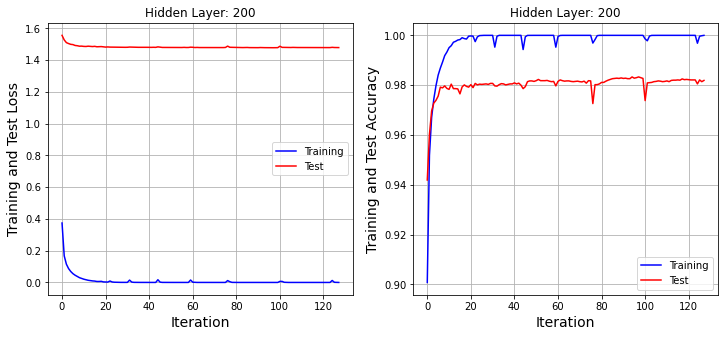

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss3, 'b', label = "Training")
ax[0].plot(range(128), test_loss3, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 200')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc3, 'b', label = "Training")
ax[1].plot(range(128), test_acc3, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 200')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 200.png")

In [22]:
model = BaselineModel(784,400,10)

train_loss4 = np.zeros(128)
test_loss4 = np.zeros(128)
train_acc4 = np.zeros(128)
test_acc4 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.17986954748630524, 'running_acc': 0.9493749737739563, 'loss': 0.32396942377090454, 'acc': 0.9119166731834412, 'val_loss': 1.5408334732055664, 'val_acc': 0.95169997215271}
Epoch: 1
Training Loss: 0.32396942377090454
Training Accuracy: 0.9119166731834412
Test Loss: 1.5408334732055664
Test Accuracy: 0.95169997215271


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11213994026184082, 'running_acc': 0.965624988079071, 'loss': 0.13352055847644806, 'acc': 0.9613500237464905, 'val_loss': 1.5165307521820068, 'val_acc': 0.9672999978065491}
Epoch: 2
Training Loss: 0.13352055847644806
Training Accuracy: 0.9613500237464905
Test Loss: 1.5165307521820068
Test Accuracy: 0.9672999978065491


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08867599070072174, 'running_acc': 0.9737499952316284, 'loss': 0.08969898521900177, 'acc': 0.9736500382423401, 'val_loss': 1.5022807121276855, 'val_acc': 0.9749999642372131}
Epoch: 3
Training Loss: 0.08969898521900177
Training Accuracy: 0.9736500382423401
Test Loss: 1.5022807121276855
Test Accuracy: 0.9749999642372131


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06306175142526627, 'running_acc': 0.9817187190055847, 'loss': 0.06373484432697296, 'acc': 0.980566680431366, 'val_loss': 1.496619462966919, 'val_acc': 0.9756999611854553}
Epoch: 4
Training Loss: 0.06373484432697296
Training Accuracy: 0.980566680431366
Test Loss: 1.496619462966919
Test Accuracy: 0.9756999611854553


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.047738827764987946, 'running_acc': 0.984375, 'loss': 0.04900544509291649, 'acc': 0.9855333566665649, 'val_loss': 1.4943022727966309, 'val_acc': 0.9775999784469604}
Epoch: 5
Training Loss: 0.04900544509291649
Training Accuracy: 0.9855333566665649
Test Loss: 1.4943022727966309
Test Accuracy: 0.9775999784469604


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.034110330045223236, 'running_acc': 0.9903124570846558, 'loss': 0.03755813464522362, 'acc': 0.9891833662986755, 'val_loss': 1.4888635873794556, 'val_acc': 0.9795999526977539}
Epoch: 6
Training Loss: 0.03755813464522362
Training Accuracy: 0.9891833662986755
Test Loss: 1.4888635873794556
Test Accuracy: 0.9795999526977539


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.030428806319832802, 'running_acc': 0.9909374713897705, 'loss': 0.028845425695180893, 'acc': 0.9920166730880737, 'val_loss': 1.4881508350372314, 'val_acc': 0.9795999526977539}
Epoch: 7
Training Loss: 0.028845425695180893
Training Accuracy: 0.9920166730880737
Test Loss: 1.4881508350372314
Test Accuracy: 0.9795999526977539


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.022834209725260735, 'running_acc': 0.9931249618530273, 'loss': 0.022002430632710457, 'acc': 0.9940833449363708, 'val_loss': 1.4861605167388916, 'val_acc': 0.9801999926567078}
Epoch: 8
Training Loss: 0.022002430632710457
Training Accuracy: 0.9940833449363708
Test Loss: 1.4861605167388916
Test Accuracy: 0.9801999926567078


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0171793382614851, 'running_acc': 0.99609375, 'loss': 0.017956426367163658, 'acc': 0.9952666759490967, 'val_loss': 1.484666109085083, 'val_acc': 0.98089998960495}
Epoch: 9
Training Loss: 0.017956426367163658
Training Accuracy: 0.9952666759490967
Test Loss: 1.484666109085083
Test Accuracy: 0.98089998960495


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.017172226682305336, 'running_acc': 0.9953124523162842, 'loss': 0.013849742710590363, 'acc': 0.9967833161354065, 'val_loss': 1.485814094543457, 'val_acc': 0.979699969291687}
Epoch: 10
Training Loss: 0.013849742710590363
Training Accuracy: 0.9967833161354065
Test Loss: 1.485814094543457
Test Accuracy: 0.979699969291687


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012714042328298092, 'running_acc': 0.99671870470047, 'loss': 0.011152400635182858, 'acc': 0.9974166750907898, 'val_loss': 1.485205054283142, 'val_acc': 0.9797999858856201}
Epoch: 11
Training Loss: 0.011152400635182858
Training Accuracy: 0.9974166750907898
Test Loss: 1.485205054283142
Test Accuracy: 0.9797999858856201


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008237315341830254, 'running_acc': 0.9981249570846558, 'loss': 0.009634818881750107, 'acc': 0.9976333379745483, 'val_loss': 1.48184072971344, 'val_acc': 0.9821999669075012}
Epoch: 12
Training Loss: 0.009634818881750107
Training Accuracy: 0.9976333379745483
Test Loss: 1.48184072971344
Test Accuracy: 0.9821999669075012


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007501543965190649, 'running_acc': 0.9989062547683716, 'loss': 0.0074214632622897625, 'acc': 0.9984500408172607, 'val_loss': 1.4828495979309082, 'val_acc': 0.9811999797821045}
Epoch: 13
Training Loss: 0.0074214632622897625
Training Accuracy: 0.9984500408172607
Test Loss: 1.4828495979309082
Test Accuracy: 0.9811999797821045


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004803332965821028, 'running_acc': 0.9993749856948853, 'loss': 0.005380619317293167, 'acc': 0.9990167021751404, 'val_loss': 1.483453631401062, 'val_acc': 0.9805999994277954}
Epoch: 14
Training Loss: 0.005380619317293167
Training Accuracy: 0.9990167021751404
Test Loss: 1.483453631401062
Test Accuracy: 0.9805999994277954


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005888322368264198, 'running_acc': 0.9987499713897705, 'loss': 0.004118527285754681, 'acc': 0.9992833733558655, 'val_loss': 1.4828276634216309, 'val_acc': 0.9801999926567078}
Epoch: 15
Training Loss: 0.004118527285754681
Training Accuracy: 0.9992833733558655
Test Loss: 1.4828276634216309
Test Accuracy: 0.9801999926567078


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00763283995911479, 'running_acc': 0.9981249570846558, 'loss': 0.006530488841235638, 'acc': 0.9982500076293945, 'val_loss': 1.4830960035324097, 'val_acc': 0.9806999564170837}
Epoch: 16
Training Loss: 0.006530488841235638
Training Accuracy: 0.9982500076293945
Test Loss: 1.4830960035324097
Test Accuracy: 0.9806999564170837


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008095940575003624, 'running_acc': 0.9971874952316284, 'loss': 0.007882533594965935, 'acc': 0.9976000189781189, 'val_loss': 1.4815527200698853, 'val_acc': 0.981499969959259}
Epoch: 17
Training Loss: 0.007882533594965935
Training Accuracy: 0.9976000189781189
Test Loss: 1.4815527200698853
Test Accuracy: 0.981499969959259


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0037622905801981688, 'running_acc': 0.9990624785423279, 'loss': 0.004401919431984425, 'acc': 0.9989666938781738, 'val_loss': 1.4815620183944702, 'val_acc': 0.98089998960495}
Epoch: 18
Training Loss: 0.004401919431984425
Training Accuracy: 0.9989666938781738
Test Loss: 1.4815620183944702
Test Accuracy: 0.98089998960495


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0016873220447450876, 'running_acc': 0.9998437166213989, 'loss': 0.0016493896255269647, 'acc': 0.999833345413208, 'val_loss': 1.4802591800689697, 'val_acc': 0.9824999570846558}
Epoch: 19
Training Loss: 0.0016493896255269647
Training Accuracy: 0.999833345413208
Test Loss: 1.4802591800689697
Test Accuracy: 0.9824999570846558


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0029914185870438814, 'running_acc': 0.9992187023162842, 'loss': 0.0013560025254264474, 'acc': 0.9997833371162415, 'val_loss': 1.4797927141189575, 'val_acc': 0.9817999601364136}
Epoch: 20
Training Loss: 0.0013560025254264474
Training Accuracy: 0.9997833371162415
Test Loss: 1.4797927141189575
Test Accuracy: 0.9817999601364136


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0012474333634600043, 'running_acc': 0.9998437166213989, 'loss': 0.0009029107168316841, 'acc': 0.9998833537101746, 'val_loss': 1.480675458908081, 'val_acc': 0.9812999963760376}
Epoch: 21
Training Loss: 0.0009029107168316841
Training Accuracy: 0.9998833537101746
Test Loss: 1.480675458908081
Test Accuracy: 0.9812999963760376


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.018292155116796494, 'running_acc': 0.9940624833106995, 'loss': 0.0041602011770009995, 'acc': 0.9987833499908447, 'val_loss': 1.4846882820129395, 'val_acc': 0.9777999520301819}
Epoch: 22
Training Loss: 0.0041602011770009995
Training Accuracy: 0.9987833499908447
Test Loss: 1.4846882820129395
Test Accuracy: 0.9777999520301819


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005574194248765707, 'running_acc': 0.9985937476158142, 'loss': 0.013445405289530754, 'acc': 0.9955999851226807, 'val_loss': 1.4820947647094727, 'val_acc': 0.9810999631881714}
Epoch: 23
Training Loss: 0.013445405289530754
Training Accuracy: 0.9955999851226807
Test Loss: 1.4820947647094727
Test Accuracy: 0.9810999631881714


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0019517542095854878, 'running_acc': 0.9996874928474426, 'loss': 0.0021773739717900753, 'acc': 0.9995999932289124, 'val_loss': 1.4804251194000244, 'val_acc': 0.9812999963760376}
Epoch: 24
Training Loss: 0.0021773739717900753
Training Accuracy: 0.9995999932289124
Test Loss: 1.4804251194000244
Test Accuracy: 0.9812999963760376


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0005077885580249131, 'running_acc': 1.0, 'loss': 0.0005970019847154617, 'acc': 0.9999833703041077, 'val_loss': 1.4793720245361328, 'val_acc': 0.9821999669075012}
Epoch: 25
Training Loss: 0.0005970019847154617
Training Accuracy: 0.9999833703041077
Test Loss: 1.4793720245361328
Test Accuracy: 0.9821999669075012


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002866737777367234, 'running_acc': 1.0, 'loss': 0.00029249596991576254, 'acc': 1.0, 'val_loss': 1.4791014194488525, 'val_acc': 0.9819999933242798}
Epoch: 26
Training Loss: 0.00029249596991576254
Training Accuracy: 1.0
Test Loss: 1.4791014194488525
Test Accuracy: 0.9819999933242798


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00023783919459674507, 'running_acc': 1.0, 'loss': 0.0002227954682894051, 'acc': 1.0, 'val_loss': 1.4790641069412231, 'val_acc': 0.9821999669075012}
Epoch: 27
Training Loss: 0.0002227954682894051
Training Accuracy: 1.0
Test Loss: 1.4790641069412231
Test Accuracy: 0.9821999669075012


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00019445580255705863, 'running_acc': 1.0, 'loss': 0.0001861325727077201, 'acc': 1.0, 'val_loss': 1.4789764881134033, 'val_acc': 0.982699990272522}
Epoch: 28
Training Loss: 0.0001861325727077201
Training Accuracy: 1.0
Test Loss: 1.4789764881134033
Test Accuracy: 0.982699990272522


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00016765258624218404, 'running_acc': 1.0, 'loss': 0.0001590744941495359, 'acc': 1.0, 'val_loss': 1.4788411855697632, 'val_acc': 0.9822999835014343}
Epoch: 29
Training Loss: 0.0001590744941495359
Training Accuracy: 1.0
Test Loss: 1.4788411855697632
Test Accuracy: 0.9822999835014343


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00016506153042428195, 'running_acc': 1.0, 'loss': 0.0001350773382000625, 'acc': 1.0, 'val_loss': 1.479192852973938, 'val_acc': 0.9818999767303467}
Epoch: 30
Training Loss: 0.0001350773382000625
Training Accuracy: 1.0
Test Loss: 1.479192852973938
Test Accuracy: 0.9818999767303467


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006311481818556786, 'running_acc': 0.9973437190055847, 'loss': 0.016643771901726723, 'acc': 0.9944999814033508, 'val_loss': 1.481479287147522, 'val_acc': 0.9815999865531921}
Epoch: 31
Training Loss: 0.016643771901726723
Training Accuracy: 0.9944999814033508
Test Loss: 1.481479287147522
Test Accuracy: 0.9815999865531921


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0015166840748861432, 'running_acc': 0.9998437166213989, 'loss': 0.0021373869385570288, 'acc': 0.999500036239624, 'val_loss': 1.4800769090652466, 'val_acc': 0.9822999835014343}
Epoch: 32
Training Loss: 0.0021373869385570288
Training Accuracy: 0.999500036239624
Test Loss: 1.4800769090652466
Test Accuracy: 0.9822999835014343


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00038181914715096354, 'running_acc': 1.0, 'loss': 0.00043661403469741344, 'acc': 0.9999833703041077, 'val_loss': 1.4791905879974365, 'val_acc': 0.9821999669075012}
Epoch: 33
Training Loss: 0.00043661403469741344
Training Accuracy: 0.9999833703041077
Test Loss: 1.4791905879974365
Test Accuracy: 0.9821999669075012


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00019264323054812849, 'running_acc': 1.0, 'loss': 0.0002057575766230002, 'acc': 1.0, 'val_loss': 1.4787981510162354, 'val_acc': 0.9829999804496765}
Epoch: 34
Training Loss: 0.0002057575766230002
Training Accuracy: 1.0
Test Loss: 1.4787981510162354
Test Accuracy: 0.9829999804496765


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00017355525051243603, 'running_acc': 1.0, 'loss': 0.00014812445442657918, 'acc': 1.0, 'val_loss': 1.4796462059020996, 'val_acc': 0.9824000000953674}
Epoch: 35
Training Loss: 0.00014812445442657918
Training Accuracy: 1.0
Test Loss: 1.4796462059020996
Test Accuracy: 0.9824000000953674


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00013564842811319977, 'running_acc': 1.0, 'loss': 0.00012329228047747165, 'acc': 1.0, 'val_loss': 1.4786183834075928, 'val_acc': 0.9828999638557434}
Epoch: 36
Training Loss: 0.00012329228047747165
Training Accuracy: 1.0
Test Loss: 1.4786183834075928
Test Accuracy: 0.9828999638557434


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00010066035611089319, 'running_acc': 1.0, 'loss': 0.00010404181375633925, 'acc': 1.0, 'val_loss': 1.4786970615386963, 'val_acc': 0.9828999638557434}
Epoch: 37
Training Loss: 0.00010404181375633925
Training Accuracy: 1.0
Test Loss: 1.4786970615386963
Test Accuracy: 0.9828999638557434


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.025647887028754e-05, 'running_acc': 1.0, 'loss': 8.844566036714241e-05, 'acc': 1.0, 'val_loss': 1.478553295135498, 'val_acc': 0.983299970626831}
Epoch: 38
Training Loss: 8.844566036714241e-05
Training Accuracy: 1.0
Test Loss: 1.478553295135498
Test Accuracy: 0.983299970626831


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.370420644292608e-05, 'running_acc': 1.0, 'loss': 7.677710527786985e-05, 'acc': 1.0, 'val_loss': 1.4785668849945068, 'val_acc': 0.983299970626831}
Epoch: 39
Training Loss: 7.677710527786985e-05
Training Accuracy: 1.0
Test Loss: 1.4785668849945068
Test Accuracy: 0.983299970626831


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00012443294690456241, 'running_acc': 1.0, 'loss': 0.0001046960023813881, 'acc': 1.0, 'val_loss': 1.4805229902267456, 'val_acc': 0.9817999601364136}
Epoch: 40
Training Loss: 0.0001046960023813881
Training Accuracy: 1.0
Test Loss: 1.4805229902267456
Test Accuracy: 0.9817999601364136


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003888712963089347, 'running_acc': 0.9984374642372131, 'loss': 0.019714726135134697, 'acc': 0.9941499829292297, 'val_loss': 1.480065107345581, 'val_acc': 0.9824000000953674}
Epoch: 41
Training Loss: 0.019714726135134697
Training Accuracy: 0.9941499829292297
Test Loss: 1.480065107345581
Test Accuracy: 0.9824000000953674


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0008544554584659636, 'running_acc': 1.0, 'loss': 0.0012384547153487802, 'acc': 0.9998166561126709, 'val_loss': 1.4789777994155884, 'val_acc': 0.9827999472618103}
Epoch: 42
Training Loss: 0.0012384547153487802
Training Accuracy: 0.9998166561126709
Test Loss: 1.4789777994155884
Test Accuracy: 0.9827999472618103


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00017768779071047902, 'running_acc': 1.0, 'loss': 0.0003759275423362851, 'acc': 0.9999499917030334, 'val_loss': 1.478556513786316, 'val_acc': 0.983199954032898}
Epoch: 43
Training Loss: 0.0003759275423362851
Training Accuracy: 0.9999499917030334
Test Loss: 1.478556513786316
Test Accuracy: 0.983199954032898


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00011148532939841971, 'running_acc': 1.0, 'loss': 0.00014028119039721787, 'acc': 1.0, 'val_loss': 1.4782756567001343, 'val_acc': 0.9838999509811401}
Epoch: 44
Training Loss: 0.00014028119039721787
Training Accuracy: 1.0
Test Loss: 1.4782756567001343
Test Accuracy: 0.9838999509811401


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00011242653999943286, 'running_acc': 1.0, 'loss': 0.00010946298425551504, 'acc': 1.0, 'val_loss': 1.4777356386184692, 'val_acc': 0.9835000038146973}
Epoch: 45
Training Loss: 0.00010946298425551504
Training Accuracy: 1.0
Test Loss: 1.4777356386184692
Test Accuracy: 0.9835000038146973


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.556370837846771e-05, 'running_acc': 1.0, 'loss': 9.472374949837103e-05, 'acc': 1.0, 'val_loss': 1.4778269529342651, 'val_acc': 0.9835000038146973}
Epoch: 46
Training Loss: 9.472374949837103e-05
Training Accuracy: 1.0
Test Loss: 1.4778269529342651
Test Accuracy: 0.9835000038146973


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.666419696761295e-05, 'running_acc': 1.0, 'loss': 7.637211820110679e-05, 'acc': 1.0, 'val_loss': 1.4777448177337646, 'val_acc': 0.9836999773979187}
Epoch: 47
Training Loss: 7.637211820110679e-05
Training Accuracy: 1.0
Test Loss: 1.4777448177337646
Test Accuracy: 0.9836999773979187


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.396913133561611e-05, 'running_acc': 1.0, 'loss': 6.482900789706036e-05, 'acc': 1.0, 'val_loss': 1.4779318571090698, 'val_acc': 0.9836999773979187}
Epoch: 48
Training Loss: 6.482900789706036e-05
Training Accuracy: 1.0
Test Loss: 1.4779318571090698
Test Accuracy: 0.9836999773979187


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.060077794245444e-05, 'running_acc': 1.0, 'loss': 5.699907342204824e-05, 'acc': 1.0, 'val_loss': 1.4782135486602783, 'val_acc': 0.9829999804496765}
Epoch: 49
Training Loss: 5.699907342204824e-05
Training Accuracy: 1.0
Test Loss: 1.4782135486602783
Test Accuracy: 0.9829999804496765


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.978881042916328e-05, 'running_acc': 1.0, 'loss': 4.790855018654838e-05, 'acc': 1.0, 'val_loss': 1.4777864217758179, 'val_acc': 0.9839999675750732}
Epoch: 50
Training Loss: 4.790855018654838e-05
Training Accuracy: 1.0
Test Loss: 1.4777864217758179
Test Accuracy: 0.9839999675750732


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.8852111174492165e-05, 'running_acc': 1.0, 'loss': 4.1020746721187606e-05, 'acc': 1.0, 'val_loss': 1.4795055389404297, 'val_acc': 0.9830999970436096}
Epoch: 51
Training Loss: 4.1020746721187606e-05
Training Accuracy: 1.0
Test Loss: 1.4795055389404297
Test Accuracy: 0.9830999970436096


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.897744682035409e-05, 'running_acc': 1.0, 'loss': 3.458810897427611e-05, 'acc': 1.0, 'val_loss': 1.4780603647232056, 'val_acc': 0.983299970626831}
Epoch: 52
Training Loss: 3.458810897427611e-05
Training Accuracy: 1.0
Test Loss: 1.4780603647232056
Test Accuracy: 0.983299970626831


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.3509077184135094e-05, 'running_acc': 1.0, 'loss': 2.9926606657681987e-05, 'acc': 1.0, 'val_loss': 1.4782675504684448, 'val_acc': 0.9833999872207642}
Epoch: 53
Training Loss: 2.9926606657681987e-05
Training Accuracy: 1.0
Test Loss: 1.4782675504684448
Test Accuracy: 0.9833999872207642


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.05075608566403389, 'running_acc': 0.9854687452316284, 'loss': 0.008433360606431961, 'acc': 0.9978166818618774, 'val_loss': 1.4866790771484375, 'val_acc': 0.9747999906539917}
Epoch: 54
Training Loss: 0.008433360606431961
Training Accuracy: 0.9978166818618774
Test Loss: 1.4866790771484375
Test Accuracy: 0.9747999906539917


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003219127655029297, 'running_acc': 0.9987499713897705, 'loss': 0.008762589655816555, 'acc': 0.9970000386238098, 'val_loss': 1.4828529357910156, 'val_acc': 0.9799999594688416}
Epoch: 55
Training Loss: 0.008762589655816555
Training Accuracy: 0.9970000386238098
Test Loss: 1.4828529357910156
Test Accuracy: 0.9799999594688416


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001146369962953031, 'running_acc': 0.9995312094688416, 'loss': 0.001154108322225511, 'acc': 0.9996500015258789, 'val_loss': 1.4795811176300049, 'val_acc': 0.9822999835014343}
Epoch: 56
Training Loss: 0.001154108322225511
Training Accuracy: 0.9996500015258789
Test Loss: 1.4795811176300049
Test Accuracy: 0.9822999835014343


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00038010324351489544, 'running_acc': 0.9998437166213989, 'loss': 0.0002965154708363116, 'acc': 0.9999666810035706, 'val_loss': 1.4791626930236816, 'val_acc': 0.9829999804496765}
Epoch: 57
Training Loss: 0.0002965154708363116
Training Accuracy: 0.9999666810035706
Test Loss: 1.4791626930236816
Test Accuracy: 0.9829999804496765


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.597326475661248e-05, 'running_acc': 1.0, 'loss': 9.224395762430504e-05, 'acc': 1.0, 'val_loss': 1.4785211086273193, 'val_acc': 0.9824999570846558}
Epoch: 58
Training Loss: 9.224395762430504e-05
Training Accuracy: 1.0
Test Loss: 1.4785211086273193
Test Accuracy: 0.9824999570846558


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.433447560993955e-05, 'running_acc': 1.0, 'loss': 6.29405549261719e-05, 'acc': 1.0, 'val_loss': 1.478474497795105, 'val_acc': 0.9822999835014343}
Epoch: 59
Training Loss: 6.29405549261719e-05
Training Accuracy: 1.0
Test Loss: 1.478474497795105
Test Accuracy: 0.9822999835014343


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.3707786719314754e-05, 'running_acc': 1.0, 'loss': 5.177886851015501e-05, 'acc': 1.0, 'val_loss': 1.4784510135650635, 'val_acc': 0.9824999570846558}
Epoch: 60
Training Loss: 5.177886851015501e-05
Training Accuracy: 1.0
Test Loss: 1.4784510135650635
Test Accuracy: 0.9824999570846558


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.8040644944412634e-05, 'running_acc': 1.0, 'loss': 4.364667256595567e-05, 'acc': 1.0, 'val_loss': 1.4784188270568848, 'val_acc': 0.9824999570846558}
Epoch: 61
Training Loss: 4.364667256595567e-05
Training Accuracy: 1.0
Test Loss: 1.4784188270568848
Test Accuracy: 0.9824999570846558


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.7679430533898994e-05, 'running_acc': 1.0, 'loss': 3.769309478229843e-05, 'acc': 1.0, 'val_loss': 1.4783740043640137, 'val_acc': 0.9824000000953674}
Epoch: 62
Training Loss: 3.769309478229843e-05
Training Accuracy: 1.0
Test Loss: 1.4783740043640137
Test Accuracy: 0.9824000000953674


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.460830339463428e-05, 'running_acc': 1.0, 'loss': 3.23497733916156e-05, 'acc': 1.0, 'val_loss': 1.478482723236084, 'val_acc': 0.9824000000953674}
Epoch: 63
Training Loss: 3.23497733916156e-05
Training Accuracy: 1.0
Test Loss: 1.478482723236084
Test Accuracy: 0.9824000000953674


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.9825567253283225e-05, 'running_acc': 1.0, 'loss': 2.780717477435246e-05, 'acc': 1.0, 'val_loss': 1.4783575534820557, 'val_acc': 0.9824999570846558}
Epoch: 64
Training Loss: 2.780717477435246e-05
Training Accuracy: 1.0
Test Loss: 1.4783575534820557
Test Accuracy: 0.9824999570846558


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.151413355022669e-05, 'running_acc': 1.0, 'loss': 2.3901849999674596e-05, 'acc': 1.0, 'val_loss': 1.4782737493515015, 'val_acc': 0.9825999736785889}
Epoch: 65
Training Loss: 2.3901849999674596e-05
Training Accuracy: 1.0
Test Loss: 1.4782737493515015
Test Accuracy: 0.9825999736785889


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.1475638277479447e-05, 'running_acc': 1.0, 'loss': 2.0442003005882725e-05, 'acc': 1.0, 'val_loss': 1.478456735610962, 'val_acc': 0.9824999570846558}
Epoch: 66
Training Loss: 2.0442003005882725e-05
Training Accuracy: 1.0
Test Loss: 1.478456735610962
Test Accuracy: 0.9824999570846558


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.0715890059364028e-05, 'running_acc': 1.0, 'loss': 1.7687892977846786e-05, 'acc': 1.0, 'val_loss': 1.4782296419143677, 'val_acc': 0.9825999736785889}
Epoch: 67
Training Loss: 1.7687892977846786e-05
Training Accuracy: 1.0
Test Loss: 1.4782296419143677
Test Accuracy: 0.9825999736785889


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.663912189542316e-05, 'running_acc': 1.0, 'loss': 1.5294885088223964e-05, 'acc': 1.0, 'val_loss': 1.4783227443695068, 'val_acc': 0.982699990272522}
Epoch: 68
Training Loss: 1.5294885088223964e-05
Training Accuracy: 1.0
Test Loss: 1.4783227443695068
Test Accuracy: 0.982699990272522


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.2736526514345314e-05, 'running_acc': 1.0, 'loss': 1.3133899301465135e-05, 'acc': 1.0, 'val_loss': 1.478139042854309, 'val_acc': 0.982699990272522}
Epoch: 69
Training Loss: 1.3133899301465135e-05
Training Accuracy: 1.0
Test Loss: 1.478139042854309
Test Accuracy: 0.982699990272522


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.2809128747903742e-05, 'running_acc': 1.0, 'loss': 1.1041976904380135e-05, 'acc': 1.0, 'val_loss': 1.4781436920166016, 'val_acc': 0.9828999638557434}
Epoch: 70
Training Loss: 1.1041976904380135e-05
Training Accuracy: 1.0
Test Loss: 1.4781436920166016
Test Accuracy: 0.9828999638557434


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.894586582959164e-06, 'running_acc': 1.0, 'loss': 9.490863703831565e-06, 'acc': 1.0, 'val_loss': 1.4780901670455933, 'val_acc': 0.982699990272522}
Epoch: 71
Training Loss: 9.490863703831565e-06
Training Accuracy: 1.0
Test Loss: 1.4780901670455933
Test Accuracy: 0.982699990272522


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.351057658728678e-06, 'running_acc': 1.0, 'loss': 7.783669389027636e-06, 'acc': 1.0, 'val_loss': 1.478094458580017, 'val_acc': 0.9828999638557434}
Epoch: 72
Training Loss: 7.783669389027636e-06
Training Accuracy: 1.0
Test Loss: 1.478094458580017
Test Accuracy: 0.9828999638557434


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.982694114616606e-06, 'running_acc': 1.0, 'loss': 6.931521056685597e-06, 'acc': 1.0, 'val_loss': 1.4787237644195557, 'val_acc': 0.9830999970436096}
Epoch: 73
Training Loss: 6.931521056685597e-06
Training Accuracy: 1.0
Test Loss: 1.4787237644195557
Test Accuracy: 0.9830999970436096


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004029884934425354, 'running_acc': 0.9987499713897705, 'loss': 0.014724401757121086, 'acc': 0.9957833290100098, 'val_loss': 1.4801788330078125, 'val_acc': 0.9813999533653259}
Epoch: 74
Training Loss: 0.014724401757121086
Training Accuracy: 0.9957833290100098
Test Loss: 1.4801788330078125
Test Accuracy: 0.9813999533653259


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0018114522099494934, 'running_acc': 0.9992187023162842, 'loss': 0.003932858817279339, 'acc': 0.9985666871070862, 'val_loss': 1.4798476696014404, 'val_acc': 0.9822999835014343}
Epoch: 75
Training Loss: 0.003932858817279339
Training Accuracy: 0.9985666871070862
Test Loss: 1.4798476696014404
Test Accuracy: 0.9822999835014343


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0023282337933778763, 'running_acc': 0.9993749856948853, 'loss': 0.0013360055163502693, 'acc': 0.9996333718299866, 'val_loss': 1.4800208806991577, 'val_acc': 0.9818999767303467}
Epoch: 76
Training Loss: 0.0013360055163502693
Training Accuracy: 0.9996333718299866
Test Loss: 1.4800208806991577
Test Accuracy: 0.9818999767303467


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0013145162956789136, 'running_acc': 0.9995312094688416, 'loss': 0.0007689177873544395, 'acc': 0.9997667074203491, 'val_loss': 1.4779280424118042, 'val_acc': 0.983199954032898}
Epoch: 77
Training Loss: 0.0007689177873544395
Training Accuracy: 0.9997667074203491
Test Loss: 1.4779280424118042
Test Accuracy: 0.983199954032898


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.94212901382707e-05, 'running_acc': 1.0, 'loss': 0.00013186736032366753, 'acc': 1.0, 'val_loss': 1.477663516998291, 'val_acc': 0.9838999509811401}
Epoch: 78
Training Loss: 0.00013186736032366753
Training Accuracy: 1.0
Test Loss: 1.477663516998291
Test Accuracy: 0.9838999509811401


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.0289042115327902e-05, 'running_acc': 1.0, 'loss': 5.33677484781947e-05, 'acc': 1.0, 'val_loss': 1.4775757789611816, 'val_acc': 0.9836999773979187}
Epoch: 79
Training Loss: 5.33677484781947e-05
Training Accuracy: 1.0
Test Loss: 1.4775757789611816
Test Accuracy: 0.9836999773979187


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0010935105383396149, 'running_acc': 0.9993749856948853, 'loss': 0.0003792500647250563, 'acc': 0.9998500347137451, 'val_loss': 1.4797568321228027, 'val_acc': 0.9822999835014343}
Epoch: 80
Training Loss: 0.0003792500647250563
Training Accuracy: 0.9998500347137451
Test Loss: 1.4797568321228027
Test Accuracy: 0.9822999835014343


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012858822010457516, 'running_acc': 0.9957812428474426, 'loss': 0.006552418228238821, 'acc': 0.9980000257492065, 'val_loss': 1.4817190170288086, 'val_acc': 0.9806999564170837}
Epoch: 81
Training Loss: 0.006552418228238821
Training Accuracy: 0.9980000257492065
Test Loss: 1.4817190170288086
Test Accuracy: 0.9806999564170837


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0017744075739756227, 'running_acc': 0.9995312094688416, 'loss': 0.0030579075682908297, 'acc': 0.9988499879837036, 'val_loss': 1.4800750017166138, 'val_acc': 0.9817999601364136}
Epoch: 82
Training Loss: 0.0030579075682908297
Training Accuracy: 0.9988499879837036
Test Loss: 1.4800750017166138
Test Accuracy: 0.9817999601364136


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0013941475190222263, 'running_acc': 0.9992187023162842, 'loss': 0.0011381505755707622, 'acc': 0.9996166825294495, 'val_loss': 1.4815319776535034, 'val_acc': 0.9800999760627747}
Epoch: 83
Training Loss: 0.0011381505755707622
Training Accuracy: 0.9996166825294495
Test Loss: 1.4815319776535034
Test Accuracy: 0.9800999760627747


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002546020841691643, 'running_acc': 1.0, 'loss': 0.0012334712082520127, 'acc': 0.9996333718299866, 'val_loss': 1.479459285736084, 'val_acc': 0.9818999767303467}
Epoch: 84
Training Loss: 0.0012334712082520127
Training Accuracy: 0.9996333718299866
Test Loss: 1.479459285736084
Test Accuracy: 0.9818999767303467


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00011086919403169304, 'running_acc': 1.0, 'loss': 0.00012196749594295397, 'acc': 1.0, 'val_loss': 1.4789819717407227, 'val_acc': 0.9818999767303467}
Epoch: 85
Training Loss: 0.00012196749594295397
Training Accuracy: 1.0
Test Loss: 1.4789819717407227
Test Accuracy: 0.9818999767303467


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.679552173707634e-05, 'running_acc': 1.0, 'loss': 4.2296018364140764e-05, 'acc': 1.0, 'val_loss': 1.478277564048767, 'val_acc': 0.9827999472618103}
Epoch: 86
Training Loss: 4.2296018364140764e-05
Training Accuracy: 1.0
Test Loss: 1.478277564048767
Test Accuracy: 0.9827999472618103


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.2335110770654865e-05, 'running_acc': 1.0, 'loss': 2.2186717615113594e-05, 'acc': 1.0, 'val_loss': 1.4782606363296509, 'val_acc': 0.982699990272522}
Epoch: 87
Training Loss: 2.2186717615113594e-05
Training Accuracy: 1.0
Test Loss: 1.4782606363296509
Test Accuracy: 0.982699990272522


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.958982102223672e-05, 'running_acc': 1.0, 'loss': 1.771096322045196e-05, 'acc': 1.0, 'val_loss': 1.4782001972198486, 'val_acc': 0.9827999472618103}
Epoch: 88
Training Loss: 1.771096322045196e-05
Training Accuracy: 1.0
Test Loss: 1.4782001972198486
Test Accuracy: 0.9827999472618103


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.7010386727633886e-05, 'running_acc': 1.0, 'loss': 1.4843985809420701e-05, 'acc': 1.0, 'val_loss': 1.47878098487854, 'val_acc': 0.9827999472618103}
Epoch: 89
Training Loss: 1.4843985809420701e-05
Training Accuracy: 1.0
Test Loss: 1.47878098487854
Test Accuracy: 0.9827999472618103


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.052820425684331e-05, 'running_acc': 1.0, 'loss': 1.2604366020241287e-05, 'acc': 1.0, 'val_loss': 1.4786442518234253, 'val_acc': 0.9830999970436096}
Epoch: 90
Training Loss: 1.2604366020241287e-05
Training Accuracy: 1.0
Test Loss: 1.4786442518234253
Test Accuracy: 0.9830999970436096


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.761952242115512e-06, 'running_acc': 1.0, 'loss': 1.0816841495397966e-05, 'acc': 1.0, 'val_loss': 1.4779744148254395, 'val_acc': 0.9835999608039856}
Epoch: 91
Training Loss: 1.0816841495397966e-05
Training Accuracy: 1.0
Test Loss: 1.4779744148254395
Test Accuracy: 0.9835999608039856


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.488366802339442e-06, 'running_acc': 1.0, 'loss': 9.282600331061985e-06, 'acc': 1.0, 'val_loss': 1.4779001474380493, 'val_acc': 0.9835000038146973}
Epoch: 92
Training Loss: 9.282600331061985e-06
Training Accuracy: 1.0
Test Loss: 1.4779001474380493
Test Accuracy: 0.9835000038146973


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.315333616337739e-06, 'running_acc': 1.0, 'loss': 8.005497875274159e-06, 'acc': 1.0, 'val_loss': 1.4778584241867065, 'val_acc': 0.9836999773979187}
Epoch: 93
Training Loss: 8.005497875274159e-06
Training Accuracy: 1.0
Test Loss: 1.4778584241867065
Test Accuracy: 0.9836999773979187


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.765761099813972e-06, 'running_acc': 1.0, 'loss': 6.847476470284164e-06, 'acc': 1.0, 'val_loss': 1.4780662059783936, 'val_acc': 0.9835999608039856}
Epoch: 94
Training Loss: 6.847476470284164e-06
Training Accuracy: 1.0
Test Loss: 1.4780662059783936
Test Accuracy: 0.9835999608039856


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.619159648835193e-06, 'running_acc': 1.0, 'loss': 5.934180080657825e-06, 'acc': 1.0, 'val_loss': 1.477759599685669, 'val_acc': 0.9838999509811401}
Epoch: 95
Training Loss: 5.934180080657825e-06
Training Accuracy: 1.0
Test Loss: 1.477759599685669
Test Accuracy: 0.9838999509811401


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.000494184059789e-06, 'running_acc': 1.0, 'loss': 5.108438472234411e-06, 'acc': 1.0, 'val_loss': 1.4779741764068604, 'val_acc': 0.9837999939918518}
Epoch: 96
Training Loss: 5.108438472234411e-06
Training Accuracy: 1.0
Test Loss: 1.4779741764068604
Test Accuracy: 0.9837999939918518


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.276746494724648e-06, 'running_acc': 1.0, 'loss': 4.410783731145784e-06, 'acc': 1.0, 'val_loss': 1.4777636528015137, 'val_acc': 0.9837999939918518}
Epoch: 97
Training Loss: 4.410783731145784e-06
Training Accuracy: 1.0
Test Loss: 1.4777636528015137
Test Accuracy: 0.9837999939918518


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.5807181575364666e-06, 'running_acc': 1.0, 'loss': 3.790446726270602e-06, 'acc': 1.0, 'val_loss': 1.477622389793396, 'val_acc': 0.9837999939918518}
Epoch: 98
Training Loss: 3.790446726270602e-06
Training Accuracy: 1.0
Test Loss: 1.477622389793396
Test Accuracy: 0.9837999939918518


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.743942670553224e-06, 'running_acc': 1.0, 'loss': 3.2868674679775722e-06, 'acc': 1.0, 'val_loss': 1.4776062965393066, 'val_acc': 0.9835999608039856}
Epoch: 99
Training Loss: 3.2868674679775722e-06
Training Accuracy: 1.0
Test Loss: 1.4776062965393066
Test Accuracy: 0.9835999608039856


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.7161117941432167e-06, 'running_acc': 1.0, 'loss': 2.852364787031547e-06, 'acc': 1.0, 'val_loss': 1.4775761365890503, 'val_acc': 0.9835999608039856}
Epoch: 100
Training Loss: 2.852364787031547e-06
Training Accuracy: 1.0
Test Loss: 1.4775761365890503
Test Accuracy: 0.9835999608039856


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.6919271931546973e-06, 'running_acc': 1.0, 'loss': 2.4217179088736884e-06, 'acc': 1.0, 'val_loss': 1.477409839630127, 'val_acc': 0.9839999675750732}
Epoch: 101
Training Loss: 2.4217179088736884e-06
Training Accuracy: 1.0
Test Loss: 1.477409839630127
Test Accuracy: 0.9839999675750732


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.1551816189457895e-06, 'running_acc': 1.0, 'loss': 2.069464244414121e-06, 'acc': 1.0, 'val_loss': 1.4775822162628174, 'val_acc': 0.9835000038146973}
Epoch: 102
Training Loss: 2.069464244414121e-06
Training Accuracy: 1.0
Test Loss: 1.4775822162628174
Test Accuracy: 0.9835000038146973


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.7302285186815425e-06, 'running_acc': 1.0, 'loss': 1.7649693972998648e-06, 'acc': 1.0, 'val_loss': 1.4775593280792236, 'val_acc': 0.9836999773979187}
Epoch: 103
Training Loss: 1.7649693972998648e-06
Training Accuracy: 1.0
Test Loss: 1.4775593280792236
Test Accuracy: 0.9836999773979187


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5851563830437954e-06, 'running_acc': 1.0, 'loss': 1.4809070307819638e-06, 'acc': 1.0, 'val_loss': 1.4774693250656128, 'val_acc': 0.9837999939918518}
Epoch: 104
Training Loss: 1.4809070307819638e-06
Training Accuracy: 1.0
Test Loss: 1.4774693250656128
Test Accuracy: 0.9837999939918518


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.356590360046539e-06, 'running_acc': 1.0, 'loss': 1.2419769745974918e-06, 'acc': 1.0, 'val_loss': 1.4774010181427002, 'val_acc': 0.9839999675750732}
Epoch: 105
Training Loss: 1.2419769745974918e-06
Training Accuracy: 1.0
Test Loss: 1.4774010181427002
Test Accuracy: 0.9839999675750732


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.1629745131358504e-06, 'running_acc': 1.0, 'loss': 1.039005610437016e-06, 'acc': 1.0, 'val_loss': 1.4781519174575806, 'val_acc': 0.9840999841690063}
Epoch: 106
Training Loss: 1.039005610437016e-06
Training Accuracy: 1.0
Test Loss: 1.4781519174575806
Test Accuracy: 0.9840999841690063


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.914041475487466e-07, 'running_acc': 1.0, 'loss': 8.923366294766311e-07, 'acc': 1.0, 'val_loss': 1.4773485660552979, 'val_acc': 0.9837999939918518}
Epoch: 107
Training Loss: 8.923366294766311e-07
Training Accuracy: 1.0
Test Loss: 1.4773485660552979
Test Accuracy: 0.9837999939918518


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.73298779677134e-07, 'running_acc': 1.0, 'loss': 7.29969940493902e-07, 'acc': 1.0, 'val_loss': 1.4773197174072266, 'val_acc': 0.9839999675750732}
Epoch: 108
Training Loss: 7.29969940493902e-07
Training Accuracy: 1.0
Test Loss: 1.4773197174072266
Test Accuracy: 0.9839999675750732


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.88385682678927e-07, 'running_acc': 1.0, 'loss': 6.202789677445253e-07, 'acc': 1.0, 'val_loss': 1.4773955345153809, 'val_acc': 0.9839999675750732}
Epoch: 109
Training Loss: 6.202789677445253e-07
Training Accuracy: 1.0
Test Loss: 1.4773955345153809
Test Accuracy: 0.9839999675750732


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.094469202049368e-07, 'running_acc': 1.0, 'loss': 5.136714094078343e-07, 'acc': 1.0, 'val_loss': 1.4779013395309448, 'val_acc': 0.9837999939918518}
Epoch: 110
Training Loss: 5.136714094078343e-07
Training Accuracy: 1.0
Test Loss: 1.4779013395309448
Test Accuracy: 0.9837999939918518


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.951008349962649e-07, 'running_acc': 1.0, 'loss': 4.304987726300169e-07, 'acc': 1.0, 'val_loss': 1.477634072303772, 'val_acc': 0.9837999939918518}
Epoch: 111
Training Loss: 4.304987726300169e-07
Training Accuracy: 1.0
Test Loss: 1.477634072303772
Test Accuracy: 0.9837999939918518


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.7572908695437945e-07, 'running_acc': 1.0, 'loss': 3.68219758684063e-07, 'acc': 1.0, 'val_loss': 1.477311611175537, 'val_acc': 0.9839999675750732}
Epoch: 112
Training Loss: 3.68219758684063e-07
Training Accuracy: 1.0
Test Loss: 1.477311611175537
Test Accuracy: 0.9839999675750732


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.4737786336336285e-07, 'running_acc': 1.0, 'loss': 2.9784965249746165e-07, 'acc': 1.0, 'val_loss': 1.4773602485656738, 'val_acc': 0.9837999939918518}
Epoch: 113
Training Loss: 2.9784965249746165e-07
Training Accuracy: 1.0
Test Loss: 1.4773602485656738
Test Accuracy: 0.9837999939918518


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008154269307851791, 'running_acc': 0.9976562261581421, 'loss': 0.01727684773504734, 'acc': 0.9957166910171509, 'val_loss': 1.480394721031189, 'val_acc': 0.9807999730110168}
Epoch: 114
Training Loss: 0.01727684773504734
Training Accuracy: 0.9957166910171509
Test Loss: 1.480394721031189
Test Accuracy: 0.9807999730110168


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00026155434898100793, 'running_acc': 1.0, 'loss': 0.001356115797534585, 'acc': 0.99958336353302, 'val_loss': 1.47956120967865, 'val_acc': 0.9812999963760376}
Epoch: 115
Training Loss: 0.001356115797534585
Training Accuracy: 0.99958336353302
Test Loss: 1.47956120967865
Test Accuracy: 0.9812999963760376


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.711757330573164e-05, 'running_acc': 1.0, 'loss': 0.00013553813914768398, 'acc': 0.9999833703041077, 'val_loss': 1.479652762413025, 'val_acc': 0.9817999601364136}
Epoch: 116
Training Loss: 0.00013553813914768398
Training Accuracy: 0.9999833703041077
Test Loss: 1.479652762413025
Test Accuracy: 0.9817999601364136


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.7189100364921615e-05, 'running_acc': 1.0, 'loss': 2.6836662073037587e-05, 'acc': 1.0, 'val_loss': 1.4788761138916016, 'val_acc': 0.9824000000953674}
Epoch: 117
Training Loss: 2.6836662073037587e-05
Training Accuracy: 1.0
Test Loss: 1.4788761138916016
Test Accuracy: 0.9824000000953674


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6369529475923628e-05, 'running_acc': 1.0, 'loss': 1.6395681086578406e-05, 'acc': 1.0, 'val_loss': 1.4787182807922363, 'val_acc': 0.9822999835014343}
Epoch: 118
Training Loss: 1.6395681086578406e-05
Training Accuracy: 1.0
Test Loss: 1.4787182807922363
Test Accuracy: 0.9822999835014343


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.291039734496735e-05, 'running_acc': 1.0, 'loss': 1.320902447332628e-05, 'acc': 1.0, 'val_loss': 1.4785611629486084, 'val_acc': 0.9827999472618103}
Epoch: 119
Training Loss: 1.320902447332628e-05
Training Accuracy: 1.0
Test Loss: 1.4785611629486084
Test Accuracy: 0.9827999472618103


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.1127814104838762e-05, 'running_acc': 1.0, 'loss': 1.1076481314375997e-05, 'acc': 1.0, 'val_loss': 1.4792003631591797, 'val_acc': 0.9827999472618103}
Epoch: 120
Training Loss: 1.1076481314375997e-05
Training Accuracy: 1.0
Test Loss: 1.4792003631591797
Test Accuracy: 0.9827999472618103


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.383811629959382e-06, 'running_acc': 1.0, 'loss': 9.323530321125872e-06, 'acc': 1.0, 'val_loss': 1.478399634361267, 'val_acc': 0.9827999472618103}
Epoch: 121
Training Loss: 9.323530321125872e-06
Training Accuracy: 1.0
Test Loss: 1.478399634361267
Test Accuracy: 0.9827999472618103


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.769441824872047e-06, 'running_acc': 1.0, 'loss': 7.937381269584876e-06, 'acc': 1.0, 'val_loss': 1.4784116744995117, 'val_acc': 0.9829999804496765}
Epoch: 122
Training Loss: 7.937381269584876e-06
Training Accuracy: 1.0
Test Loss: 1.4784116744995117
Test Accuracy: 0.9829999804496765


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.612811375816818e-06, 'running_acc': 1.0, 'loss': 6.801304152759258e-06, 'acc': 1.0, 'val_loss': 1.4782917499542236, 'val_acc': 0.9827999472618103}
Epoch: 123
Training Loss: 6.801304152759258e-06
Training Accuracy: 1.0
Test Loss: 1.4782917499542236
Test Accuracy: 0.9827999472618103


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.9384276533382945e-06, 'running_acc': 1.0, 'loss': 5.855332346982323e-06, 'acc': 1.0, 'val_loss': 1.4788423776626587, 'val_acc': 0.9828999638557434}
Epoch: 124
Training Loss: 5.855332346982323e-06
Training Accuracy: 1.0
Test Loss: 1.4788423776626587
Test Accuracy: 0.9828999638557434


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.5708993638982065e-06, 'running_acc': 1.0, 'loss': 5.040666110289749e-06, 'acc': 1.0, 'val_loss': 1.4786449670791626, 'val_acc': 0.982699990272522}
Epoch: 125
Training Loss: 5.040666110289749e-06
Training Accuracy: 1.0
Test Loss: 1.4786449670791626
Test Accuracy: 0.982699990272522


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.1104502795642475e-06, 'running_acc': 1.0, 'loss': 4.313551016821293e-06, 'acc': 1.0, 'val_loss': 1.4780365228652954, 'val_acc': 0.982699990272522}
Epoch: 126
Training Loss: 4.313551016821293e-06
Training Accuracy: 1.0
Test Loss: 1.4780365228652954
Test Accuracy: 0.982699990272522


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.404423179948935e-06, 'running_acc': 1.0, 'loss': 3.700133220263524e-06, 'acc': 1.0, 'val_loss': 1.4779174327850342, 'val_acc': 0.9827999472618103}
Epoch: 127
Training Loss: 3.700133220263524e-06
Training Accuracy: 1.0
Test Loss: 1.4779174327850342
Test Accuracy: 0.9827999472618103


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.202834932380938e-06, 'running_acc': 1.0, 'loss': 3.1631980164092965e-06, 'acc': 1.0, 'val_loss': 1.477871060371399, 'val_acc': 0.9829999804496765}
Epoch: 128
Training Loss: 3.1631980164092965e-06
Training Accuracy: 1.0
Test Loss: 1.477871060371399
Test Accuracy: 0.9829999804496765


[{'running_loss': 0.17986954748630524,
  'running_acc': 0.9493749737739563,
  'loss': 0.32396942377090454,
  'acc': 0.9119166731834412,
  'val_loss': 1.5408334732055664,
  'val_acc': 0.95169997215271,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.11213994026184082,
  'running_acc': 0.965624988079071,
  'loss': 0.13352055847644806,
  'acc': 0.9613500237464905,
  'val_loss': 1.5165307521820068,
  'val_acc': 0.9672999978065491,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.08867599070072174,
  'running_acc': 0.9737499952316284,
  'loss': 0.08969898521900177,
  'acc': 0.9736500382423401,
  'val_loss': 1.5022807121276855,
  'val_acc': 0.9749999642372131,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.06306175142526627,
  'running_acc': 0.9817187190055847,
  'loss': 0.06373484432697296,
  'acc': 0.980566680431366,
  'val_loss': 1.496619462966919,
  'val_acc': 0.9756999611854553,
  'train_steps': 469,
  'validation_steps': 79

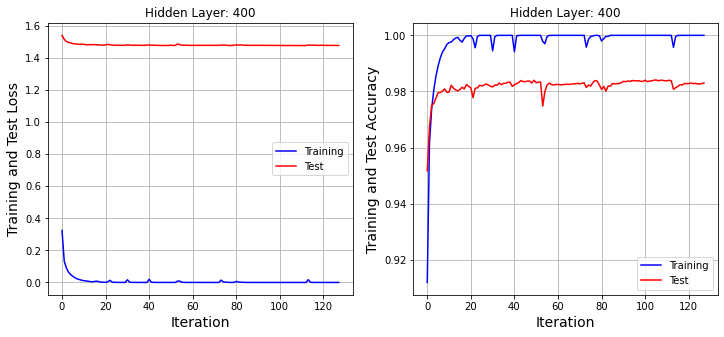

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss4, 'b', label = "Training")
ax[0].plot(range(128), test_loss4, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 400')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc4, 'b', label = "Training")
ax[1].plot(range(128), test_acc4, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 400')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 400.png")

In [24]:
model = BaselineModel(784,1600,10)

train_loss4 = np.zeros(128)
test_loss4 = np.zeros(128)
train_acc4 = np.zeros(128)
test_acc4 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.13152927160263062, 'running_acc': 0.9609375, 'loss': 0.24909678101539612, 'acc': 0.9286666512489319, 'val_loss': 1.516878366470337, 'val_acc': 0.9651999473571777}
Epoch: 1
Training Loss: 0.24909678101539612
Training Accuracy: 0.9286666512489319
Test Loss: 1.516878366470337
Test Accuracy: 0.9651999473571777


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.07389532774686813, 'running_acc': 0.9778124690055847, 'loss': 0.09115223586559296, 'acc': 0.9729499816894531, 'val_loss': 1.497748613357544, 'val_acc': 0.975600004196167}
Epoch: 2
Training Loss: 0.09115223586559296
Training Accuracy: 0.9729499816894531
Test Loss: 1.497748613357544
Test Accuracy: 0.975600004196167


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.05560382083058357, 'running_acc': 0.9823437333106995, 'loss': 0.05674634873867035, 'acc': 0.9830666780471802, 'val_loss': 1.4928545951843262, 'val_acc': 0.9776999950408936}
Epoch: 3
Training Loss: 0.05674634873867035
Training Accuracy: 0.9830666780471802
Test Loss: 1.4928545951843262
Test Accuracy: 0.9776999950408936


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.045074060559272766, 'running_acc': 0.9859374761581421, 'loss': 0.03872514143586159, 'acc': 0.9883333444595337, 'val_loss': 1.4904977083206177, 'val_acc': 0.9785999655723572}
Epoch: 4
Training Loss: 0.03872514143586159
Training Accuracy: 0.9883333444595337
Test Loss: 1.4904977083206177
Test Accuracy: 0.9785999655723572


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.027263974770903587, 'running_acc': 0.9904687404632568, 'loss': 0.02736305631697178, 'acc': 0.9912999868392944, 'val_loss': 1.488401174545288, 'val_acc': 0.9784999489784241}
Epoch: 5
Training Loss: 0.02736305631697178
Training Accuracy: 0.9912999868392944
Test Loss: 1.488401174545288
Test Accuracy: 0.9784999489784241


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02714170329272747, 'running_acc': 0.9918749928474426, 'loss': 0.018815545365214348, 'acc': 0.9942666888237, 'val_loss': 1.4869341850280762, 'val_acc': 0.9791999459266663}
Epoch: 6
Training Loss: 0.018815545365214348
Training Accuracy: 0.9942666888237
Test Loss: 1.4869341850280762
Test Accuracy: 0.9791999459266663


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.014102915301918983, 'running_acc': 0.9959374666213989, 'loss': 0.013636894524097443, 'acc': 0.9959999918937683, 'val_loss': 1.4825727939605713, 'val_acc': 0.9820999503135681}
Epoch: 7
Training Loss: 0.013636894524097443
Training Accuracy: 0.9959999918937683
Test Loss: 1.4825727939605713
Test Accuracy: 0.9820999503135681


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013677718117833138, 'running_acc': 0.99671870470047, 'loss': 0.012627026066184044, 'acc': 0.9961000084877014, 'val_loss': 1.480546236038208, 'val_acc': 0.9835999608039856}
Epoch: 8
Training Loss: 0.012627026066184044
Training Accuracy: 0.9961000084877014
Test Loss: 1.480546236038208
Test Accuracy: 0.9835999608039856


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007604583166539669, 'running_acc': 0.9971874952316284, 'loss': 0.009106285870075226, 'acc': 0.9973999857902527, 'val_loss': 1.4799913167953491, 'val_acc': 0.9836999773979187}
Epoch: 9
Training Loss: 0.009106285870075226
Training Accuracy: 0.9973999857902527
Test Loss: 1.4799913167953491
Test Accuracy: 0.9836999773979187


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011430000886321068, 'running_acc': 0.9959374666213989, 'loss': 0.008293581195175648, 'acc': 0.9975833296775818, 'val_loss': 1.4848511219024658, 'val_acc': 0.9781999588012695}
Epoch: 10
Training Loss: 0.008293581195175648
Training Accuracy: 0.9975833296775818
Test Loss: 1.4848511219024658
Test Accuracy: 0.9781999588012695


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007203300949186087, 'running_acc': 0.9984374642372131, 'loss': 0.008680076338350773, 'acc': 0.9972500205039978, 'val_loss': 1.479997158050537, 'val_acc': 0.9835000038146973}
Epoch: 11
Training Loss: 0.008680076338350773
Training Accuracy: 0.9972500205039978
Test Loss: 1.479997158050537
Test Accuracy: 0.9835000038146973


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0030813461635261774, 'running_acc': 0.9993749856948853, 'loss': 0.004875458311289549, 'acc': 0.9987000226974487, 'val_loss': 1.4791369438171387, 'val_acc': 0.9838999509811401}
Epoch: 12
Training Loss: 0.004875458311289549
Training Accuracy: 0.9987000226974487
Test Loss: 1.4791369438171387
Test Accuracy: 0.9838999509811401


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013187484815716743, 'running_acc': 0.9954687356948853, 'loss': 0.007063463795930147, 'acc': 0.9977499842643738, 'val_loss': 1.4819902181625366, 'val_acc': 0.9812999963760376}
Epoch: 13
Training Loss: 0.007063463795930147
Training Accuracy: 0.9977499842643738
Test Loss: 1.4819902181625366
Test Accuracy: 0.9812999963760376


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009032642468810081, 'running_acc': 0.9971874952316284, 'loss': 0.008831232786178589, 'acc': 0.9970666766166687, 'val_loss': 1.4806568622589111, 'val_acc': 0.9817000031471252}
Epoch: 14
Training Loss: 0.008831232786178589
Training Accuracy: 0.9970666766166687
Test Loss: 1.4806568622589111
Test Accuracy: 0.9817000031471252


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0036518541164696217, 'running_acc': 0.9984374642372131, 'loss': 0.004375389777123928, 'acc': 0.9985833168029785, 'val_loss': 1.4787193536758423, 'val_acc': 0.9830999970436096}
Epoch: 15
Training Loss: 0.004375389777123928
Training Accuracy: 0.9985833168029785
Test Loss: 1.4787193536758423
Test Accuracy: 0.9830999970436096


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.000916214834433049, 'running_acc': 1.0, 'loss': 0.0026332561392337084, 'acc': 0.9993000030517578, 'val_loss': 1.4790347814559937, 'val_acc': 0.9838999509811401}
Epoch: 16
Training Loss: 0.0026332561392337084
Training Accuracy: 0.9993000030517578
Test Loss: 1.4790347814559937
Test Accuracy: 0.9838999509811401


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0015664593083783984, 'running_acc': 0.9995312094688416, 'loss': 0.0018609203398227692, 'acc': 0.999500036239624, 'val_loss': 1.4786150455474854, 'val_acc': 0.9842999577522278}
Epoch: 17
Training Loss: 0.0018609203398227692
Training Accuracy: 0.999500036239624
Test Loss: 1.4786150455474854
Test Accuracy: 0.9842999577522278


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0159583929926157, 'running_acc': 0.9946874976158142, 'loss': 0.006953162141144276, 'acc': 0.9976666569709778, 'val_loss': 1.4844932556152344, 'val_acc': 0.9777999520301819}
Epoch: 18
Training Loss: 0.006953162141144276
Training Accuracy: 0.9976666569709778
Test Loss: 1.4844932556152344
Test Accuracy: 0.9777999520301819


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007347656413912773, 'running_acc': 0.9978124499320984, 'loss': 0.011752517893910408, 'acc': 0.996066689491272, 'val_loss': 1.4797693490982056, 'val_acc': 0.9824999570846558}
Epoch: 19
Training Loss: 0.011752517893910408
Training Accuracy: 0.996066689491272
Test Loss: 1.4797693490982056
Test Accuracy: 0.9824999570846558


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0034965258091688156, 'running_acc': 0.9993749856948853, 'loss': 0.0027838083915412426, 'acc': 0.9991500377655029, 'val_loss': 1.4784740209579468, 'val_acc': 0.983199954032898}
Epoch: 20
Training Loss: 0.0027838083915412426
Training Accuracy: 0.9991500377655029
Test Loss: 1.4784740209579468
Test Accuracy: 0.983199954032898


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0007657104288227856, 'running_acc': 0.9996874928474426, 'loss': 0.0009092203690670431, 'acc': 0.999833345413208, 'val_loss': 1.478001356124878, 'val_acc': 0.9840999841690063}
Epoch: 21
Training Loss: 0.0009092203690670431
Training Accuracy: 0.999833345413208
Test Loss: 1.478001356124878
Test Accuracy: 0.9840999841690063


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0001584919518791139, 'running_acc': 1.0, 'loss': 0.00041904961108230054, 'acc': 0.999916672706604, 'val_loss': 1.4772603511810303, 'val_acc': 0.9847999811172485}
Epoch: 22
Training Loss: 0.00041904961108230054
Training Accuracy: 0.999916672706604
Test Loss: 1.4772603511810303
Test Accuracy: 0.9847999811172485


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.812081457814202e-05, 'running_acc': 1.0, 'loss': 9.031752415467054e-05, 'acc': 1.0, 'val_loss': 1.477097511291504, 'val_acc': 0.9853999614715576}
Epoch: 23
Training Loss: 9.031752415467054e-05
Training Accuracy: 1.0
Test Loss: 1.477097511291504
Test Accuracy: 0.9853999614715576


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.41412882739678e-05, 'running_acc': 1.0, 'loss': 6.12343501416035e-05, 'acc': 1.0, 'val_loss': 1.4762382507324219, 'val_acc': 0.9853999614715576}
Epoch: 24
Training Loss: 6.12343501416035e-05
Training Accuracy: 1.0
Test Loss: 1.4762382507324219
Test Accuracy: 0.9853999614715576


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.760359297506511e-05, 'running_acc': 1.0, 'loss': 4.796254506800324e-05, 'acc': 1.0, 'val_loss': 1.4761505126953125, 'val_acc': 0.9853000044822693}
Epoch: 25
Training Loss: 4.796254506800324e-05
Training Accuracy: 1.0
Test Loss: 1.4761505126953125
Test Accuracy: 0.9853000044822693


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.688952710945159e-05, 'running_acc': 1.0, 'loss': 3.928022488253191e-05, 'acc': 1.0, 'val_loss': 1.4761990308761597, 'val_acc': 0.9855999946594238}
Epoch: 26
Training Loss: 3.928022488253191e-05
Training Accuracy: 1.0
Test Loss: 1.4761990308761597
Test Accuracy: 0.9855999946594238


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.3532916859257966e-05, 'running_acc': 1.0, 'loss': 3.280159580754116e-05, 'acc': 1.0, 'val_loss': 1.4760942459106445, 'val_acc': 0.9855999946594238}
Epoch: 27
Training Loss: 3.280159580754116e-05
Training Accuracy: 1.0
Test Loss: 1.4760942459106445
Test Accuracy: 0.9855999946594238


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.507909812266007e-05, 'running_acc': 1.0, 'loss': 2.708081592572853e-05, 'acc': 1.0, 'val_loss': 1.4761502742767334, 'val_acc': 0.9856999516487122}
Epoch: 28
Training Loss: 2.708081592572853e-05
Training Accuracy: 1.0
Test Loss: 1.4761502742767334
Test Accuracy: 0.9856999516487122


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.2531630747835152e-05, 'running_acc': 1.0, 'loss': 2.304578993062023e-05, 'acc': 1.0, 'val_loss': 1.4760370254516602, 'val_acc': 0.9854999780654907}
Epoch: 29
Training Loss: 2.304578993062023e-05
Training Accuracy: 1.0
Test Loss: 1.4760370254516602
Test Accuracy: 0.9854999780654907


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.861760756582953e-05, 'running_acc': 1.0, 'loss': 1.9565886759664863e-05, 'acc': 1.0, 'val_loss': 1.4762623310089111, 'val_acc': 0.9853000044822693}
Epoch: 30
Training Loss: 1.9565886759664863e-05
Training Accuracy: 1.0
Test Loss: 1.4762623310089111
Test Accuracy: 0.9853000044822693


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.4276619367592502e-05, 'running_acc': 1.0, 'loss': 1.6014128050301224e-05, 'acc': 1.0, 'val_loss': 1.4759563207626343, 'val_acc': 0.98499995470047}
Epoch: 31
Training Loss: 1.6014128050301224e-05
Training Accuracy: 1.0
Test Loss: 1.4759563207626343
Test Accuracy: 0.98499995470047


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.1749282748496626e-05, 'running_acc': 1.0, 'loss': 1.3502735782822128e-05, 'acc': 1.0, 'val_loss': 1.4758493900299072, 'val_acc': 0.9854999780654907}
Epoch: 32
Training Loss: 1.3502735782822128e-05
Training Accuracy: 1.0
Test Loss: 1.4758493900299072
Test Accuracy: 0.9854999780654907


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.868676559359301e-06, 'running_acc': 1.0, 'loss': 1.1141659342683852e-05, 'acc': 1.0, 'val_loss': 1.4759743213653564, 'val_acc': 0.9854999780654907}
Epoch: 33
Training Loss: 1.1141659342683852e-05
Training Accuracy: 1.0
Test Loss: 1.4759743213653564
Test Accuracy: 0.9854999780654907


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.63740478962427e-06, 'running_acc': 1.0, 'loss': 9.720771231513936e-06, 'acc': 1.0, 'val_loss': 1.475981593132019, 'val_acc': 0.9853000044822693}
Epoch: 34
Training Loss: 9.720771231513936e-06
Training Accuracy: 1.0
Test Loss: 1.475981593132019
Test Accuracy: 0.9853000044822693


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011118135415017605, 'running_acc': 0.9953124523162842, 'loss': 0.028621040284633636, 'acc': 0.9921500086784363, 'val_loss': 1.482092261314392, 'val_acc': 0.9797999858856201}
Epoch: 35
Training Loss: 0.028621040284633636
Training Accuracy: 0.9921500086784363
Test Loss: 1.482092261314392
Test Accuracy: 0.9797999858856201


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005069800652563572, 'running_acc': 0.9985937476158142, 'loss': 0.004254411906003952, 'acc': 0.9986833333969116, 'val_loss': 1.4785969257354736, 'val_acc': 0.9838999509811401}
Epoch: 36
Training Loss: 0.004254411906003952
Training Accuracy: 0.9986833333969116
Test Loss: 1.4785969257354736
Test Accuracy: 0.9838999509811401


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003689576406031847, 'running_acc': 0.9995312094688416, 'loss': 0.001352221705019474, 'acc': 0.9997166991233826, 'val_loss': 1.4762918949127197, 'val_acc': 0.9860000014305115}
Epoch: 37
Training Loss: 0.001352221705019474
Training Accuracy: 0.9997166991233826
Test Loss: 1.4762918949127197
Test Accuracy: 0.9860000014305115


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002583875029813498, 'running_acc': 1.0, 'loss': 0.0006608121329918504, 'acc': 0.9998500347137451, 'val_loss': 1.4766334295272827, 'val_acc': 0.9850999712944031}
Epoch: 38
Training Loss: 0.0006608121329918504
Training Accuracy: 0.9998500347137451
Test Loss: 1.4766334295272827
Test Accuracy: 0.9850999712944031


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.449182107346132e-05, 'running_acc': 1.0, 'loss': 0.00020118136308155954, 'acc': 0.9999666810035706, 'val_loss': 1.475939393043518, 'val_acc': 0.9857999682426453}
Epoch: 39
Training Loss: 0.00020118136308155954
Training Accuracy: 0.9999666810035706
Test Loss: 1.475939393043518
Test Accuracy: 0.9857999682426453


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.857315773027949e-05, 'running_acc': 1.0, 'loss': 5.869231608812697e-05, 'acc': 1.0, 'val_loss': 1.4759052991867065, 'val_acc': 0.9857999682426453}
Epoch: 40
Training Loss: 5.869231608812697e-05
Training Accuracy: 1.0
Test Loss: 1.4759052991867065
Test Accuracy: 0.9857999682426453


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.378674566396512e-05, 'running_acc': 1.0, 'loss': 4.423405334819108e-05, 'acc': 1.0, 'val_loss': 1.4758734703063965, 'val_acc': 0.9856999516487122}
Epoch: 41
Training Loss: 4.423405334819108e-05
Training Accuracy: 1.0
Test Loss: 1.4758734703063965
Test Accuracy: 0.9856999516487122


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.4258551750099286e-05, 'running_acc': 1.0, 'loss': 3.597402246668935e-05, 'acc': 1.0, 'val_loss': 1.4765634536743164, 'val_acc': 0.9858999848365784}
Epoch: 42
Training Loss: 3.597402246668935e-05
Training Accuracy: 1.0
Test Loss: 1.4765634536743164
Test Accuracy: 0.9858999848365784


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.8964206649106927e-05, 'running_acc': 1.0, 'loss': 2.95014469884336e-05, 'acc': 1.0, 'val_loss': 1.4760130643844604, 'val_acc': 0.9854999780654907}
Epoch: 43
Training Loss: 2.95014469884336e-05
Training Accuracy: 1.0
Test Loss: 1.4760130643844604
Test Accuracy: 0.9854999780654907


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.5288385586463846e-05, 'running_acc': 1.0, 'loss': 2.450989450153429e-05, 'acc': 1.0, 'val_loss': 1.4759119749069214, 'val_acc': 0.9853999614715576}
Epoch: 44
Training Loss: 2.450989450153429e-05
Training Accuracy: 1.0
Test Loss: 1.4759119749069214
Test Accuracy: 0.9853999614715576


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.160258372896351e-05, 'running_acc': 1.0, 'loss': 2.0229461370036006e-05, 'acc': 1.0, 'val_loss': 1.4759361743927002, 'val_acc': 0.9851999878883362}
Epoch: 45
Training Loss: 2.0229461370036006e-05
Training Accuracy: 1.0
Test Loss: 1.4759361743927002
Test Accuracy: 0.9851999878883362


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.4555640518665314e-05, 'running_acc': 1.0, 'loss': 1.6709338524378836e-05, 'acc': 1.0, 'val_loss': 1.4759217500686646, 'val_acc': 0.9853999614715576}
Epoch: 46
Training Loss: 1.6709338524378836e-05
Training Accuracy: 1.0
Test Loss: 1.4759217500686646
Test Accuracy: 0.9853999614715576


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5105663806025404e-05, 'running_acc': 1.0, 'loss': 1.3816283171763644e-05, 'acc': 1.0, 'val_loss': 1.4758247137069702, 'val_acc': 0.9853999614715576}
Epoch: 47
Training Loss: 1.3816283171763644e-05
Training Accuracy: 1.0
Test Loss: 1.4758247137069702
Test Accuracy: 0.9853999614715576


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.295011770707788e-05, 'running_acc': 1.0, 'loss': 1.1434613952587824e-05, 'acc': 1.0, 'val_loss': 1.4759575128555298, 'val_acc': 0.9851999878883362}
Epoch: 48
Training Loss: 1.1434613952587824e-05
Training Accuracy: 1.0
Test Loss: 1.4759575128555298
Test Accuracy: 0.9851999878883362


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.0529015526117291e-05, 'running_acc': 1.0, 'loss': 9.503831279289443e-06, 'acc': 1.0, 'val_loss': 1.4759809970855713, 'val_acc': 0.9850999712944031}
Epoch: 49
Training Loss: 9.503831279289443e-06
Training Accuracy: 1.0
Test Loss: 1.4759809970855713
Test Accuracy: 0.9850999712944031


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.883595571911428e-06, 'running_acc': 1.0, 'loss': 7.83513405622216e-06, 'acc': 1.0, 'val_loss': 1.4758731126785278, 'val_acc': 0.98499995470047}
Epoch: 50
Training Loss: 7.83513405622216e-06
Training Accuracy: 1.0
Test Loss: 1.4758731126785278
Test Accuracy: 0.98499995470047


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.356733138090931e-06, 'running_acc': 1.0, 'loss': 6.388930160028394e-06, 'acc': 1.0, 'val_loss': 1.4761884212493896, 'val_acc': 0.9853999614715576}
Epoch: 51
Training Loss: 6.388930160028394e-06
Training Accuracy: 1.0
Test Loss: 1.4761884212493896
Test Accuracy: 0.9853999614715576


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.285648967401357e-06, 'running_acc': 1.0, 'loss': 5.305660124577116e-06, 'acc': 1.0, 'val_loss': 1.4759385585784912, 'val_acc': 0.9853000044822693}
Epoch: 52
Training Loss: 5.305660124577116e-06
Training Accuracy: 1.0
Test Loss: 1.4759385585784912
Test Accuracy: 0.9853000044822693


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.043312856083503e-06, 'running_acc': 1.0, 'loss': 4.211262421449646e-06, 'acc': 1.0, 'val_loss': 1.4759806394577026, 'val_acc': 0.9850999712944031}
Epoch: 53
Training Loss: 4.211262421449646e-06
Training Accuracy: 1.0
Test Loss: 1.4759806394577026
Test Accuracy: 0.9850999712944031


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.6625137909140904e-06, 'running_acc': 1.0, 'loss': 3.4091401630576e-06, 'acc': 1.0, 'val_loss': 1.4759198427200317, 'val_acc': 0.9851999878883362}
Epoch: 54
Training Loss: 3.4091401630576e-06
Training Accuracy: 1.0
Test Loss: 1.4759198427200317
Test Accuracy: 0.9851999878883362


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.762298436209676e-06, 'running_acc': 1.0, 'loss': 2.779966507659992e-06, 'acc': 1.0, 'val_loss': 1.4759409427642822, 'val_acc': 0.98499995470047}
Epoch: 55
Training Loss: 2.779966507659992e-06
Training Accuracy: 1.0
Test Loss: 1.4759409427642822
Test Accuracy: 0.98499995470047


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.358244955757982e-06, 'running_acc': 1.0, 'loss': 2.2442591216531582e-06, 'acc': 1.0, 'val_loss': 1.4759074449539185, 'val_acc': 0.9853000044822693}
Epoch: 56
Training Loss: 2.2442591216531582e-06
Training Accuracy: 1.0
Test Loss: 1.4759074449539185
Test Accuracy: 0.9853000044822693


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.7774671050574398e-06, 'running_acc': 1.0, 'loss': 1.8220943047708715e-06, 'acc': 1.0, 'val_loss': 1.4762747287750244, 'val_acc': 0.98499995470047}
Epoch: 57
Training Loss: 1.8220943047708715e-06
Training Accuracy: 1.0
Test Loss: 1.4762747287750244
Test Accuracy: 0.98499995470047


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5215026678561117e-06, 'running_acc': 1.0, 'loss': 1.5175651242316235e-06, 'acc': 1.0, 'val_loss': 1.4766042232513428, 'val_acc': 0.9847999811172485}
Epoch: 58
Training Loss: 1.5175651242316235e-06
Training Accuracy: 1.0
Test Loss: 1.4766042232513428
Test Accuracy: 0.9847999811172485


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03988514468073845, 'running_acc': 0.9898437261581421, 'loss': 0.019904695451259613, 'acc': 0.9958833456039429, 'val_loss': 1.4816956520080566, 'val_acc': 0.9794999957084656}
Epoch: 59
Training Loss: 0.019904695451259613
Training Accuracy: 0.9958833456039429
Test Loss: 1.4816956520080566
Test Accuracy: 0.9794999957084656


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0055504851043224335, 'running_acc': 0.9982812404632568, 'loss': 0.009178919717669487, 'acc': 0.9972833395004272, 'val_loss': 1.4808796644210815, 'val_acc': 0.9804999828338623}
Epoch: 60
Training Loss: 0.009178919717669487
Training Accuracy: 0.9972833395004272
Test Loss: 1.4808796644210815
Test Accuracy: 0.9804999828338623


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0008687603403814137, 'running_acc': 0.9996874928474426, 'loss': 0.002272540470585227, 'acc': 0.9991000294685364, 'val_loss': 1.4777586460113525, 'val_acc': 0.9839999675750732}
Epoch: 61
Training Loss: 0.002272540470585227
Training Accuracy: 0.9991000294685364
Test Loss: 1.4777586460113525
Test Accuracy: 0.9839999675750732


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0009504116023890674, 'running_acc': 0.9995312094688416, 'loss': 0.0007256365497596562, 'acc': 0.9997667074203491, 'val_loss': 1.4769788980484009, 'val_acc': 0.9840999841690063}
Epoch: 62
Training Loss: 0.0007256365497596562
Training Accuracy: 0.9997667074203491
Test Loss: 1.4769788980484009
Test Accuracy: 0.9840999841690063


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001470243209041655, 'running_acc': 0.9996874928474426, 'loss': 0.0007426723605021834, 'acc': 0.9998000264167786, 'val_loss': 1.4774895906448364, 'val_acc': 0.9840999841690063}
Epoch: 63
Training Loss: 0.0007426723605021834
Training Accuracy: 0.9998000264167786
Test Loss: 1.4774895906448364
Test Accuracy: 0.9840999841690063


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00014365506649482995, 'running_acc': 1.0, 'loss': 0.0006533314590342343, 'acc': 0.999833345413208, 'val_loss': 1.4759960174560547, 'val_acc': 0.9853999614715576}
Epoch: 64
Training Loss: 0.0006533314590342343
Training Accuracy: 0.999833345413208
Test Loss: 1.4759960174560547
Test Accuracy: 0.9853999614715576


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.841301415581256e-05, 'running_acc': 1.0, 'loss': 0.00011967305181315169, 'acc': 0.9999833703041077, 'val_loss': 1.4760417938232422, 'val_acc': 0.9850999712944031}
Epoch: 65
Training Loss: 0.00011967305181315169
Training Accuracy: 0.9999833703041077
Test Loss: 1.4760417938232422
Test Accuracy: 0.9850999712944031


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003063798416405916, 'running_acc': 0.9992187023162842, 'loss': 0.000988184241577983, 'acc': 0.999666690826416, 'val_loss': 1.480324149131775, 'val_acc': 0.9818999767303467}
Epoch: 66
Training Loss: 0.000988184241577983
Training Accuracy: 0.999666690826416
Test Loss: 1.480324149131775
Test Accuracy: 0.9818999767303467


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01638399064540863, 'running_acc': 0.9962499737739563, 'loss': 0.014864838682115078, 'acc': 0.9959166646003723, 'val_loss': 1.4801892042160034, 'val_acc': 0.98089998960495}
Epoch: 67
Training Loss: 0.014864838682115078
Training Accuracy: 0.9959166646003723
Test Loss: 1.4801892042160034
Test Accuracy: 0.98089998960495


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001426641014404595, 'running_acc': 0.9995312094688416, 'loss': 0.004891061689704657, 'acc': 0.9985499978065491, 'val_loss': 1.4797486066818237, 'val_acc': 0.9820999503135681}
Epoch: 68
Training Loss: 0.004891061689704657
Training Accuracy: 0.9985499978065491
Test Loss: 1.4797486066818237
Test Accuracy: 0.9820999503135681


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.000879898143466562, 'running_acc': 0.9996874928474426, 'loss': 0.0009407071629539132, 'acc': 0.999666690826416, 'val_loss': 1.4786220788955688, 'val_acc': 0.983199954032898}
Epoch: 69
Training Loss: 0.0009407071629539132
Training Accuracy: 0.999666690826416
Test Loss: 1.4786220788955688
Test Accuracy: 0.983199954032898


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.97401332622394e-05, 'running_acc': 1.0, 'loss': 0.00032053087488748133, 'acc': 0.9999666810035706, 'val_loss': 1.4771333932876587, 'val_acc': 0.9840999841690063}
Epoch: 70
Training Loss: 0.00032053087488748133
Training Accuracy: 0.9999666810035706
Test Loss: 1.4771333932876587
Test Accuracy: 0.9840999841690063


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.682856913655996e-05, 'running_acc': 1.0, 'loss': 6.559865141753107e-05, 'acc': 0.9999833703041077, 'val_loss': 1.4770357608795166, 'val_acc': 0.9840999841690063}
Epoch: 71
Training Loss: 6.559865141753107e-05
Training Accuracy: 0.9999833703041077
Test Loss: 1.4770357608795166
Test Accuracy: 0.9840999841690063


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.0650008082157e-05, 'running_acc': 1.0, 'loss': 1.709556636342313e-05, 'acc': 1.0, 'val_loss': 1.4771366119384766, 'val_acc': 0.9837999939918518}
Epoch: 72
Training Loss: 1.709556636342313e-05
Training Accuracy: 1.0
Test Loss: 1.4771366119384766
Test Accuracy: 0.9837999939918518


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.244528993993299e-05, 'running_acc': 1.0, 'loss': 1.1631414054136258e-05, 'acc': 1.0, 'val_loss': 1.476909875869751, 'val_acc': 0.9843999743461609}
Epoch: 73
Training Loss: 1.1631414054136258e-05
Training Accuracy: 1.0
Test Loss: 1.476909875869751
Test Accuracy: 0.9843999743461609


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.59389274410205e-06, 'running_acc': 1.0, 'loss': 9.232299817085732e-06, 'acc': 1.0, 'val_loss': 1.4781591892242432, 'val_acc': 0.9845999479293823}
Epoch: 74
Training Loss: 9.232299817085732e-06
Training Accuracy: 1.0
Test Loss: 1.4781591892242432
Test Accuracy: 0.9845999479293823


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.799552572076209e-06, 'running_acc': 1.0, 'loss': 7.6185579018783756e-06, 'acc': 1.0, 'val_loss': 1.4774184226989746, 'val_acc': 0.9845999479293823}
Epoch: 75
Training Loss: 7.6185579018783756e-06
Training Accuracy: 1.0
Test Loss: 1.4774184226989746
Test Accuracy: 0.9845999479293823


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.754411515430547e-06, 'running_acc': 1.0, 'loss': 6.43117800791515e-06, 'acc': 1.0, 'val_loss': 1.4767054319381714, 'val_acc': 0.9847999811172485}
Epoch: 76
Training Loss: 6.43117800791515e-06
Training Accuracy: 1.0
Test Loss: 1.4767054319381714
Test Accuracy: 0.9847999811172485


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.026506187277846e-06, 'running_acc': 1.0, 'loss': 5.406961008702638e-06, 'acc': 1.0, 'val_loss': 1.4773259162902832, 'val_acc': 0.9848999977111816}
Epoch: 77
Training Loss: 5.406961008702638e-06
Training Accuracy: 1.0
Test Loss: 1.4773259162902832
Test Accuracy: 0.9848999977111816


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.6977803574700374e-06, 'running_acc': 1.0, 'loss': 4.603894467436476e-06, 'acc': 1.0, 'val_loss': 1.4765594005584717, 'val_acc': 0.98499995470047}
Epoch: 78
Training Loss: 4.603894467436476e-06
Training Accuracy: 1.0
Test Loss: 1.4765594005584717
Test Accuracy: 0.98499995470047


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.966675194533309e-06, 'running_acc': 1.0, 'loss': 3.90643026548787e-06, 'acc': 1.0, 'val_loss': 1.476506233215332, 'val_acc': 0.9848999977111816}
Epoch: 79
Training Loss: 3.90643026548787e-06
Training Accuracy: 1.0
Test Loss: 1.476506233215332
Test Accuracy: 0.9848999977111816


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.0613591661676764e-06, 'running_acc': 1.0, 'loss': 3.311668933747569e-06, 'acc': 1.0, 'val_loss': 1.476378321647644, 'val_acc': 0.98499995470047}
Epoch: 80
Training Loss: 3.311668933747569e-06
Training Accuracy: 1.0
Test Loss: 1.476378321647644
Test Accuracy: 0.98499995470047


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.6372849788458552e-06, 'running_acc': 1.0, 'loss': 2.8059414489689516e-06, 'acc': 1.0, 'val_loss': 1.4763468503952026, 'val_acc': 0.9851999878883362}
Epoch: 81
Training Loss: 2.8059414489689516e-06
Training Accuracy: 1.0
Test Loss: 1.4763468503952026
Test Accuracy: 0.9851999878883362


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.302986104041338e-06, 'running_acc': 1.0, 'loss': 2.3860388864704873e-06, 'acc': 1.0, 'val_loss': 1.476331353187561, 'val_acc': 0.98499995470047}
Epoch: 82
Training Loss: 2.3860388864704873e-06
Training Accuracy: 1.0
Test Loss: 1.476331353187561
Test Accuracy: 0.98499995470047


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.0658485482272226e-06, 'running_acc': 1.0, 'loss': 2.010889602388488e-06, 'acc': 1.0, 'val_loss': 1.476218819618225, 'val_acc': 0.9853000044822693}
Epoch: 83
Training Loss: 2.010889602388488e-06
Training Accuracy: 1.0
Test Loss: 1.476218819618225
Test Accuracy: 0.9853000044822693


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.835014927564771e-06, 'running_acc': 1.0, 'loss': 1.6840737089296454e-06, 'acc': 1.0, 'val_loss': 1.4761457443237305, 'val_acc': 0.9853999614715576}
Epoch: 84
Training Loss: 1.6840737089296454e-06
Training Accuracy: 1.0
Test Loss: 1.4761457443237305
Test Accuracy: 0.9853999614715576


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5411123968078755e-06, 'running_acc': 1.0, 'loss': 1.425070990990207e-06, 'acc': 1.0, 'val_loss': 1.4761325120925903, 'val_acc': 0.9851999878883362}
Epoch: 85
Training Loss: 1.425070990990207e-06
Training Accuracy: 1.0
Test Loss: 1.4761325120925903
Test Accuracy: 0.9851999878883362


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.1914577271454618e-06, 'running_acc': 1.0, 'loss': 1.182455321213638e-06, 'acc': 1.0, 'val_loss': 1.476123571395874, 'val_acc': 0.9847999811172485}
Epoch: 86
Training Loss: 1.182455321213638e-06
Training Accuracy: 1.0
Test Loss: 1.476123571395874
Test Accuracy: 0.9847999811172485


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.466582469030982e-07, 'running_acc': 1.0, 'loss': 9.904995295073604e-07, 'acc': 1.0, 'val_loss': 1.476049780845642, 'val_acc': 0.9853000044822693}
Epoch: 87
Training Loss: 9.904995295073604e-07
Training Accuracy: 1.0
Test Loss: 1.476049780845642
Test Accuracy: 0.9853000044822693


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.179914630090934e-07, 'running_acc': 1.0, 'loss': 8.24225594442396e-07, 'acc': 1.0, 'val_loss': 1.4759536981582642, 'val_acc': 0.9854999780654907}
Epoch: 88
Training Loss: 8.24225594442396e-07
Training Accuracy: 1.0
Test Loss: 1.4759536981582642
Test Accuracy: 0.9854999780654907


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.445013352480601e-07, 'running_acc': 1.0, 'loss': 6.934406542313809e-07, 'acc': 1.0, 'val_loss': 1.4759782552719116, 'val_acc': 0.9853999614715576}
Epoch: 89
Training Loss: 6.934406542313809e-07
Training Accuracy: 1.0
Test Loss: 1.4759782552719116
Test Accuracy: 0.9853999614715576


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.194092634359549e-07, 'running_acc': 1.0, 'loss': 5.653064931721019e-07, 'acc': 1.0, 'val_loss': 1.4759286642074585, 'val_acc': 0.9854999780654907}
Epoch: 90
Training Loss: 5.653064931721019e-07
Training Accuracy: 1.0
Test Loss: 1.4759286642074585
Test Accuracy: 0.9854999780654907


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.611282804489747e-07, 'running_acc': 1.0, 'loss': 4.719654214113689e-07, 'acc': 1.0, 'val_loss': 1.4757879972457886, 'val_acc': 0.9853000044822693}
Epoch: 91
Training Loss: 4.719654214113689e-07
Training Accuracy: 1.0
Test Loss: 1.4757879972457886
Test Accuracy: 0.9853000044822693


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.606782570386713e-07, 'running_acc': 1.0, 'loss': 3.9382626937367604e-07, 'acc': 1.0, 'val_loss': 1.4771479368209839, 'val_acc': 0.9853000044822693}
Epoch: 92
Training Loss: 3.9382626937367604e-07
Training Accuracy: 1.0
Test Loss: 1.4771479368209839
Test Accuracy: 0.9853000044822693


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.1839724101700995e-07, 'running_acc': 1.0, 'loss': 3.211284251847246e-07, 'acc': 1.0, 'val_loss': 1.475783109664917, 'val_acc': 0.9856999516487122}
Epoch: 93
Training Loss: 3.211284251847246e-07
Training Accuracy: 1.0
Test Loss: 1.475783109664917
Test Accuracy: 0.9856999516487122


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.6540624276094604e-07, 'running_acc': 1.0, 'loss': 2.62199250755657e-07, 'acc': 1.0, 'val_loss': 1.4756852388381958, 'val_acc': 0.9856999516487122}
Epoch: 94
Training Loss: 2.62199250755657e-07
Training Accuracy: 1.0
Test Loss: 1.4756852388381958
Test Accuracy: 0.9856999516487122


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.497602338280558e-07, 'running_acc': 1.0, 'loss': 2.1646705761213525e-07, 'acc': 1.0, 'val_loss': 1.4757122993469238, 'val_acc': 0.9854999780654907}
Epoch: 95
Training Loss: 2.1646705761213525e-07
Training Accuracy: 1.0
Test Loss: 1.4757122993469238
Test Accuracy: 0.9854999780654907


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5892030091890774e-07, 'running_acc': 1.0, 'loss': 1.7672181229499984e-07, 'acc': 1.0, 'val_loss': 1.47572660446167, 'val_acc': 0.9851999878883362}
Epoch: 96
Training Loss: 1.7672181229499984e-07
Training Accuracy: 1.0
Test Loss: 1.47572660446167
Test Accuracy: 0.9851999878883362


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6214258380387037e-07, 'running_acc': 1.0, 'loss': 1.4643181600604294e-07, 'acc': 1.0, 'val_loss': 1.4756402969360352, 'val_acc': 0.9853000044822693}
Epoch: 97
Training Loss: 1.4643181600604294e-07
Training Accuracy: 1.0
Test Loss: 1.4756402969360352
Test Accuracy: 0.9853000044822693


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.303288001963665e-07, 'running_acc': 1.0, 'loss': 1.2032508323045477e-07, 'acc': 1.0, 'val_loss': 1.4758416414260864, 'val_acc': 0.9854999780654907}
Epoch: 98
Training Loss: 1.2032508323045477e-07
Training Accuracy: 1.0
Test Loss: 1.4758416414260864
Test Accuracy: 0.9854999780654907


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.1293186474858885e-07, 'running_acc': 1.0, 'loss': 1.0040796638577376e-07, 'acc': 1.0, 'val_loss': 1.4756968021392822, 'val_acc': 0.9856999516487122}
Epoch: 99
Training Loss: 1.0040796638577376e-07
Training Accuracy: 1.0
Test Loss: 1.4756968021392822
Test Accuracy: 0.9856999516487122


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.998421208161744e-08, 'running_acc': 1.0, 'loss': 8.496003545133135e-08, 'acc': 1.0, 'val_loss': 1.4756675958633423, 'val_acc': 0.9855999946594238}
Epoch: 100
Training Loss: 8.496003545133135e-08
Training Accuracy: 1.0
Test Loss: 1.4756675958633423
Test Accuracy: 0.9855999946594238


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.416802733610893e-08, 'running_acc': 1.0, 'loss': 6.651571737847917e-08, 'acc': 1.0, 'val_loss': 1.4763970375061035, 'val_acc': 0.9851999878883362}
Epoch: 101
Training Loss: 6.651571737847917e-08
Training Accuracy: 1.0
Test Loss: 1.4763970375061035
Test Accuracy: 0.9851999878883362


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.6326310726717566e-08, 'running_acc': 1.0, 'loss': 5.517770773622033e-08, 'acc': 1.0, 'val_loss': 1.4756832122802734, 'val_acc': 0.9853000044822693}
Epoch: 102
Training Loss: 5.517770773622033e-08
Training Accuracy: 1.0
Test Loss: 1.4756832122802734
Test Accuracy: 0.9853000044822693


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.278492227172137e-08, 'running_acc': 1.0, 'loss': 4.469553260832981e-08, 'acc': 1.0, 'val_loss': 1.4756830930709839, 'val_acc': 0.9853000044822693}
Epoch: 103
Training Loss: 4.469553260832981e-08
Training Accuracy: 1.0
Test Loss: 1.4756830930709839
Test Accuracy: 0.9853000044822693


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.5762763417324095e-08, 'running_acc': 1.0, 'loss': 3.7657329698959074e-08, 'acc': 1.0, 'val_loss': 1.475731372833252, 'val_acc': 0.9854999780654907}
Epoch: 104
Training Loss: 3.7657329698959074e-08
Training Accuracy: 1.0
Test Loss: 1.475731372833252
Test Accuracy: 0.9854999780654907


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.397462577936494e-08, 'running_acc': 1.0, 'loss': 3.0957370000805895e-08, 'acc': 1.0, 'val_loss': 1.4757171869277954, 'val_acc': 0.9857999682426453}
Epoch: 105
Training Loss: 3.0957370000805895e-08
Training Accuracy: 1.0
Test Loss: 1.4757171869277954
Test Accuracy: 0.9857999682426453


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.4959433631011052e-08, 'running_acc': 1.0, 'loss': 2.5975095852004415e-08, 'acc': 1.0, 'val_loss': 1.4757323265075684, 'val_acc': 0.9854999780654907}
Epoch: 106
Training Loss: 2.5975095852004415e-08
Training Accuracy: 1.0
Test Loss: 1.4757323265075684
Test Accuracy: 0.9854999780654907


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.179294611437399e-08, 'running_acc': 1.0, 'loss': 2.1416445505906267e-08, 'acc': 1.0, 'val_loss': 1.4757405519485474, 'val_acc': 0.9851999878883362}
Epoch: 107
Training Loss: 2.1416445505906267e-08
Training Accuracy: 1.0
Test Loss: 1.4757405519485474
Test Accuracy: 0.9851999878883362


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.8645073041057003e-08, 'running_acc': 1.0, 'loss': 1.8030721804507266e-08, 'acc': 1.0, 'val_loss': 1.4757639169692993, 'val_acc': 0.9851999878883362}
Epoch: 108
Training Loss: 1.8030721804507266e-08
Training Accuracy: 1.0
Test Loss: 1.4757639169692993
Test Accuracy: 0.9851999878883362


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.4193354935798652e-08, 'running_acc': 1.0, 'loss': 1.5234107308970124e-08, 'acc': 1.0, 'val_loss': 1.4757144451141357, 'val_acc': 0.9855999946594238}
Epoch: 109
Training Loss: 1.5234107308970124e-08
Training Accuracy: 1.0
Test Loss: 1.4757144451141357
Test Accuracy: 0.9855999946594238


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.3727693648490913e-08, 'running_acc': 1.0, 'loss': 1.266585414327892e-08, 'acc': 1.0, 'val_loss': 1.47710382938385, 'val_acc': 0.9856999516487122}
Epoch: 110
Training Loss: 1.266585414327892e-08
Training Accuracy: 1.0
Test Loss: 1.47710382938385
Test Accuracy: 0.9856999516487122


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.2181697428559346e-08, 'running_acc': 1.0, 'loss': 1.0568888875184257e-08, 'acc': 1.0, 'val_loss': 1.4756886959075928, 'val_acc': 0.9855999946594238}
Epoch: 111
Training Loss: 1.0568888875184257e-08
Training Accuracy: 1.0
Test Loss: 1.4756886959075928
Test Accuracy: 0.9855999946594238


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.741632389648203e-09, 'running_acc': 1.0, 'loss': 9.023303881861011e-09, 'acc': 1.0, 'val_loss': 1.4756999015808105, 'val_acc': 0.9853000044822693}
Epoch: 112
Training Loss: 9.023303881861011e-09
Training Accuracy: 1.0
Test Loss: 1.4756999015808105
Test Accuracy: 0.9853000044822693


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.232889925352538e-09, 'running_acc': 1.0, 'loss': 7.649156863465123e-09, 'acc': 1.0, 'val_loss': 1.4756600856781006, 'val_acc': 0.9853999614715576}
Epoch: 113
Training Loss: 7.649156863465123e-09
Training Accuracy: 1.0
Test Loss: 1.4756600856781006
Test Accuracy: 0.9853999614715576


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.301568238915479e-09, 'running_acc': 1.0, 'loss': 6.5172720553619e-09, 'acc': 1.0, 'val_loss': 1.4756423234939575, 'val_acc': 0.9855999946594238}
Epoch: 114
Training Loss: 6.5172720553619e-09
Training Accuracy: 1.0
Test Loss: 1.4756423234939575
Test Accuracy: 0.9855999946594238


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.625187871061144e-09, 'running_acc': 1.0, 'loss': 5.60911672664588e-09, 'acc': 1.0, 'val_loss': 1.4757940769195557, 'val_acc': 0.9851999878883362}
Epoch: 115
Training Loss: 5.60911672664588e-09
Training Accuracy: 1.0
Test Loss: 1.4757940769195557
Test Accuracy: 0.9851999878883362


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.749744597631889e-09, 'running_acc': 1.0, 'loss': 4.843935919041087e-09, 'acc': 1.0, 'val_loss': 1.4756600856781006, 'val_acc': 0.9854999780654907}
Epoch: 116
Training Loss: 4.843935919041087e-09
Training Accuracy: 1.0
Test Loss: 1.4756600856781006
Test Accuracy: 0.9854999780654907


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.9360089349193e-09, 'running_acc': 1.0, 'loss': 4.131709641086445e-09, 'acc': 1.0, 'val_loss': 1.4756238460540771, 'val_acc': 0.9853999614715576}
Epoch: 117
Training Loss: 4.131709641086445e-09
Training Accuracy: 1.0
Test Loss: 1.4756238460540771
Test Accuracy: 0.9853999614715576


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.4458931263969816e-09, 'running_acc': 1.0, 'loss': 3.613425336723708e-09, 'acc': 1.0, 'val_loss': 1.4757652282714844, 'val_acc': 0.9855999946594238}
Epoch: 118
Training Loss: 3.613425336723708e-09
Training Accuracy: 1.0
Test Loss: 1.4757652282714844
Test Accuracy: 0.9855999946594238


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.390013825210758e-09, 'running_acc': 1.0, 'loss': 3.198401099524517e-09, 'acc': 1.0, 'val_loss': 1.4757095575332642, 'val_acc': 0.9851999878883362}
Epoch: 119
Training Loss: 3.198401099524517e-09
Training Accuracy: 1.0
Test Loss: 1.4757095575332642
Test Accuracy: 0.9851999878883362


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.3527609577532758e-09, 'running_acc': 1.0, 'loss': 2.7820530323907633e-09, 'acc': 1.0, 'val_loss': 1.475712537765503, 'val_acc': 0.9855999946594238}
Epoch: 120
Training Loss: 2.7820530323907633e-09
Training Accuracy: 1.0
Test Loss: 1.475712537765503
Test Accuracy: 0.9855999946594238


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.30967978076535e-09, 'running_acc': 1.0, 'loss': 2.4259394493242326e-09, 'acc': 1.0, 'val_loss': 1.4763227701187134, 'val_acc': 0.9854999780654907}
Epoch: 121
Training Loss: 2.4259394493242326e-09
Training Accuracy: 1.0
Test Loss: 1.4763227701187134
Test Accuracy: 0.9854999780654907


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.06753592024711e-09, 'running_acc': 1.0, 'loss': 2.2134629684700258e-09, 'acc': 1.0, 'val_loss': 1.4757676124572754, 'val_acc': 0.9855999946594238}
Epoch: 122
Training Loss: 2.2134629684700258e-09
Training Accuracy: 1.0
Test Loss: 1.4757676124572754
Test Accuracy: 0.9855999946594238


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.8998977946438345e-09, 'running_acc': 1.0, 'loss': 1.9798049866182055e-09, 'acc': 1.0, 'val_loss': 1.475733757019043, 'val_acc': 0.9856999516487122}
Epoch: 123
Training Loss: 1.9798049866182055e-09
Training Accuracy: 1.0
Test Loss: 1.475733757019043
Test Accuracy: 0.9856999516487122


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5646217654818884e-09, 'running_acc': 1.0, 'loss': 1.7507805205596583e-09, 'acc': 1.0, 'val_loss': 1.475748062133789, 'val_acc': 0.9857999682426453}
Epoch: 124
Training Loss: 1.7507805205596583e-09
Training Accuracy: 1.0
Test Loss: 1.475748062133789
Test Accuracy: 0.9857999682426453


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.8626449271863521e-09, 'running_acc': 1.0, 'loss': 1.6428872706697462e-09, 'acc': 1.0, 'val_loss': 1.4759292602539062, 'val_acc': 0.9857999682426453}
Epoch: 125
Training Loss: 1.6428872706697462e-09
Training Accuracy: 1.0
Test Loss: 1.4759292602539062
Test Accuracy: 0.9857999682426453


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.527368898024406e-09, 'running_acc': 1.0, 'loss': 1.594567144991288e-09, 'acc': 1.0, 'val_loss': 1.4757765531539917, 'val_acc': 0.9856999516487122}
Epoch: 126
Training Loss: 1.594567144991288e-09
Training Accuracy: 1.0
Test Loss: 1.4757765531539917
Test Accuracy: 0.9856999516487122


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.8253920597288698e-09, 'running_acc': 1.0, 'loss': 1.4588733554532496e-09, 'acc': 1.0, 'val_loss': 1.4758188724517822, 'val_acc': 0.9857999682426453}
Epoch: 127
Training Loss: 1.4588733554532496e-09
Training Accuracy: 1.0
Test Loss: 1.4758188724517822
Test Accuracy: 0.9857999682426453


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6018746329393707e-09, 'running_acc': 1.0, 'loss': 1.4535780357149974e-09, 'acc': 1.0, 'val_loss': 1.4758803844451904, 'val_acc': 0.9855999946594238}
Epoch: 128
Training Loss: 1.4535780357149974e-09
Training Accuracy: 1.0
Test Loss: 1.4758803844451904
Test Accuracy: 0.9855999946594238


[{'running_loss': 0.13152927160263062,
  'running_acc': 0.9609375,
  'loss': 0.24909678101539612,
  'acc': 0.9286666512489319,
  'val_loss': 1.516878366470337,
  'val_acc': 0.9651999473571777,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.07389532774686813,
  'running_acc': 0.9778124690055847,
  'loss': 0.09115223586559296,
  'acc': 0.9729499816894531,
  'val_loss': 1.497748613357544,
  'val_acc': 0.975600004196167,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.05560382083058357,
  'running_acc': 0.9823437333106995,
  'loss': 0.05674634873867035,
  'acc': 0.9830666780471802,
  'val_loss': 1.4928545951843262,
  'val_acc': 0.9776999950408936,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.045074060559272766,
  'running_acc': 0.9859374761581421,
  'loss': 0.03872514143586159,
  'acc': 0.9883333444595337,
  'val_loss': 1.4904977083206177,
  'val_acc': 0.9785999655723572,
  'train_steps': 469,
  'validation_steps': 79},
 {'

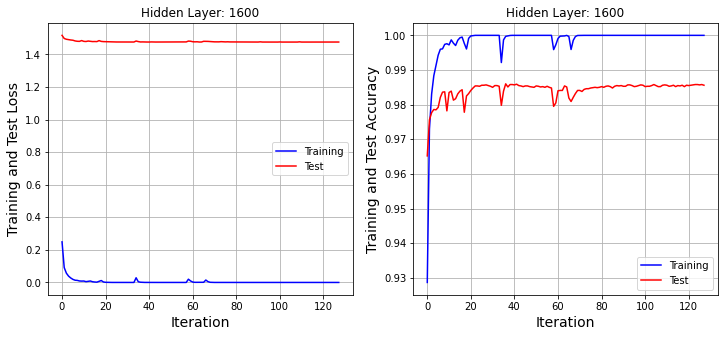

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss4, 'b', label = "Training")
ax[0].plot(range(128), test_loss4, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 1600')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc4, 'b', label = "Training")
ax[1].plot(range(128), test_acc4, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 1600')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 1600.png")

In [27]:
model = BaselineModel(784,3200,10)

train_loss4 = np.zeros(128)
test_loss4 = np.zeros(128)
train_acc4 = np.zeros(128)
test_acc4 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.12606091797351837, 'running_acc': 0.9607812166213989, 'loss': 0.22005237638950348, 'acc': 0.9353333711624146, 'val_loss': 1.5103901624679565, 'val_acc': 0.9681999683380127}
Epoch: 1
Training Loss: 0.22005237638950348
Training Accuracy: 0.9353333711624146
Test Loss: 1.5103901624679565
Test Accuracy: 0.9681999683380127


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06946074217557907, 'running_acc': 0.9798437356948853, 'loss': 0.07728931307792664, 'acc': 0.9761833548545837, 'val_loss': 1.4948668479919434, 'val_acc': 0.9759999513626099}
Epoch: 2
Training Loss: 0.07728931307792664
Training Accuracy: 0.9761833548545837
Test Loss: 1.4948668479919434
Test Accuracy: 0.9759999513626099


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04399820789694786, 'running_acc': 0.9862499833106995, 'loss': 0.048111189156770706, 'acc': 0.9848499894142151, 'val_loss': 1.4883726835250854, 'val_acc': 0.9792999625205994}
Epoch: 3
Training Loss: 0.048111189156770706
Training Accuracy: 0.9848499894142151
Test Loss: 1.4883726835250854
Test Accuracy: 0.9792999625205994


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02855782024562359, 'running_acc': 0.9904687404632568, 'loss': 0.03248833119869232, 'acc': 0.9892666935920715, 'val_loss': 1.4869166612625122, 'val_acc': 0.9794999957084656}
Epoch: 4
Training Loss: 0.03248833119869232
Training Accuracy: 0.9892666935920715
Test Loss: 1.4869166612625122
Test Accuracy: 0.9794999957084656


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02890387549996376, 'running_acc': 0.9914062023162842, 'loss': 0.023102642968297005, 'acc': 0.9927833676338196, 'val_loss': 1.4835044145584106, 'val_acc': 0.9820999503135681}
Epoch: 5
Training Loss: 0.023102642968297005
Training Accuracy: 0.9927833676338196
Test Loss: 1.4835044145584106
Test Accuracy: 0.9820999503135681


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02193768508732319, 'running_acc': 0.9951562285423279, 'loss': 0.016612861305475235, 'acc': 0.9952000379562378, 'val_loss': 1.4826154708862305, 'val_acc': 0.9821999669075012}
Epoch: 6
Training Loss: 0.016612861305475235
Training Accuracy: 0.9952000379562378
Test Loss: 1.4826154708862305
Test Accuracy: 0.9821999669075012


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0209568552672863, 'running_acc': 0.992968738079071, 'loss': 0.013921077363193035, 'acc': 0.9953666925430298, 'val_loss': 1.4839036464691162, 'val_acc': 0.9800999760627747}
Epoch: 7
Training Loss: 0.013921077363193035
Training Accuracy: 0.9953666925430298
Test Loss: 1.4839036464691162
Test Accuracy: 0.9800999760627747


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011738309636712074, 'running_acc': 0.9951562285423279, 'loss': 0.012553928419947624, 'acc': 0.9955999851226807, 'val_loss': 1.485520601272583, 'val_acc': 0.977899968624115}
Epoch: 8
Training Loss: 0.012553928419947624
Training Accuracy: 0.9955999851226807
Test Loss: 1.485520601272583
Test Accuracy: 0.977899968624115


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01614975370466709, 'running_acc': 0.9942187070846558, 'loss': 0.008026977069675922, 'acc': 0.9973999857902527, 'val_loss': 1.4829298257827759, 'val_acc': 0.9807999730110168}
Epoch: 9
Training Loss: 0.008026977069675922
Training Accuracy: 0.9973999857902527
Test Loss: 1.4829298257827759
Test Accuracy: 0.9807999730110168


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013448821380734444, 'running_acc': 0.9951562285423279, 'loss': 0.010335990227758884, 'acc': 0.9965833425521851, 'val_loss': 1.4835927486419678, 'val_acc': 0.9794999957084656}
Epoch: 10
Training Loss: 0.010335990227758884
Training Accuracy: 0.9965833425521851
Test Loss: 1.4835927486419678
Test Accuracy: 0.9794999957084656


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0120999775826931, 'running_acc': 0.99609375, 'loss': 0.009901975281536579, 'acc': 0.9968667030334473, 'val_loss': 1.4801580905914307, 'val_acc': 0.9825999736785889}
Epoch: 11
Training Loss: 0.009901975281536579
Training Accuracy: 0.9968667030334473
Test Loss: 1.4801580905914307
Test Accuracy: 0.9825999736785889


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007119073532521725, 'running_acc': 0.9976562261581421, 'loss': 0.006526832468807697, 'acc': 0.9977333545684814, 'val_loss': 1.4796066284179688, 'val_acc': 0.983199954032898}
Epoch: 12
Training Loss: 0.006526832468807697
Training Accuracy: 0.9977333545684814
Test Loss: 1.4796066284179688
Test Accuracy: 0.983199954032898


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005792043171823025, 'running_acc': 0.9978124499320984, 'loss': 0.005806447006762028, 'acc': 0.9983167052268982, 'val_loss': 1.479422926902771, 'val_acc': 0.982699990272522}
Epoch: 13
Training Loss: 0.005806447006762028
Training Accuracy: 0.9983167052268982
Test Loss: 1.479422926902771
Test Accuracy: 0.982699990272522


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013080247677862644, 'running_acc': 0.9956249594688416, 'loss': 0.01220792904496193, 'acc': 0.9958500266075134, 'val_loss': 1.4810230731964111, 'val_acc': 0.9817000031471252}
Epoch: 14
Training Loss: 0.01220792904496193
Training Accuracy: 0.9958500266075134
Test Loss: 1.4810230731964111
Test Accuracy: 0.9817000031471252


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005130276083946228, 'running_acc': 0.9982812404632568, 'loss': 0.007522366009652615, 'acc': 0.9976500272750854, 'val_loss': 1.4792068004608154, 'val_acc': 0.983199954032898}
Epoch: 15
Training Loss: 0.007522366009652615
Training Accuracy: 0.9976500272750854
Test Loss: 1.4792068004608154
Test Accuracy: 0.983199954032898


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002601353218778968, 'running_acc': 0.9987499713897705, 'loss': 0.002117936033755541, 'acc': 0.9993500113487244, 'val_loss': 1.4763216972351074, 'val_acc': 0.9853999614715576}
Epoch: 16
Training Loss: 0.002117936033755541
Training Accuracy: 0.9993500113487244
Test Loss: 1.4763216972351074
Test Accuracy: 0.9853999614715576


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0004995579365640879, 'running_acc': 0.9998437166213989, 'loss': 0.0007174864294938743, 'acc': 0.9997833371162415, 'val_loss': 1.4769700765609741, 'val_acc': 0.9851999878883362}
Epoch: 17
Training Loss: 0.0007174864294938743
Training Accuracy: 0.9997833371162415
Test Loss: 1.4769700765609741
Test Accuracy: 0.9851999878883362


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00021931779338046908, 'running_acc': 1.0, 'loss': 0.0002548804332036525, 'acc': 1.0, 'val_loss': 1.4766674041748047, 'val_acc': 0.9866999983787537}
Epoch: 18
Training Loss: 0.0002548804332036525
Training Accuracy: 1.0
Test Loss: 1.4766674041748047
Test Accuracy: 0.9866999983787537


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.024860035628080368, 'running_acc': 0.9943749904632568, 'loss': 0.005271059460937977, 'acc': 0.9987000226974487, 'val_loss': 1.484849214553833, 'val_acc': 0.9767999649047852}
Epoch: 19
Training Loss: 0.005271059460937977
Training Accuracy: 0.9987000226974487
Test Loss: 1.484849214553833
Test Accuracy: 0.9767999649047852


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013224611058831215, 'running_acc': 0.9946874976158142, 'loss': 0.019508011639118195, 'acc': 0.9932833313941956, 'val_loss': 1.4831796884536743, 'val_acc': 0.9786999821662903}
Epoch: 20
Training Loss: 0.019508011639118195
Training Accuracy: 0.9932833313941956
Test Loss: 1.4831796884536743
Test Accuracy: 0.9786999821662903


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0034210789017379284, 'running_acc': 0.9985937476158142, 'loss': 0.004434491973370314, 'acc': 0.9984000325202942, 'val_loss': 1.478713035583496, 'val_acc': 0.9828999638557434}
Epoch: 21
Training Loss: 0.004434491973370314
Training Accuracy: 0.9984000325202942
Test Loss: 1.478713035583496
Test Accuracy: 0.9828999638557434


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003929001744836569, 'running_acc': 0.9990624785423279, 'loss': 0.002205534605309367, 'acc': 0.9993333220481873, 'val_loss': 1.4784835577011108, 'val_acc': 0.9838999509811401}
Epoch: 22
Training Loss: 0.002205534605309367
Training Accuracy: 0.9993333220481873
Test Loss: 1.4784835577011108
Test Accuracy: 0.9838999509811401


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0076428744941949844, 'running_acc': 0.9978124499320984, 'loss': 0.00432349368929863, 'acc': 0.9985833168029785, 'val_loss': 1.4788514375686646, 'val_acc': 0.9828999638557434}
Epoch: 23
Training Loss: 0.00432349368929863
Training Accuracy: 0.9985833168029785
Test Loss: 1.4788514375686646
Test Accuracy: 0.9828999638557434


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004490343853831291, 'running_acc': 0.9981249570846558, 'loss': 0.004579394590109587, 'acc': 0.9984833598136902, 'val_loss': 1.477713942527771, 'val_acc': 0.9839999675750732}
Epoch: 24
Training Loss: 0.004579394590109587
Training Accuracy: 0.9984833598136902
Test Loss: 1.477713942527771
Test Accuracy: 0.9839999675750732


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005599238909780979, 'running_acc': 0.9981249570846558, 'loss': 0.0029418470803648233, 'acc': 0.9991166591644287, 'val_loss': 1.4797836542129517, 'val_acc': 0.9818999767303467}
Epoch: 25
Training Loss: 0.0029418470803648233
Training Accuracy: 0.9991166591644287
Test Loss: 1.4797836542129517
Test Accuracy: 0.9818999767303467


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008407550863921642, 'running_acc': 0.9979687333106995, 'loss': 0.006478023249655962, 'acc': 0.9981333613395691, 'val_loss': 1.4781535863876343, 'val_acc': 0.9833999872207642}
Epoch: 26
Training Loss: 0.006478023249655962
Training Accuracy: 0.9981333613395691
Test Loss: 1.4781535863876343
Test Accuracy: 0.9833999872207642


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009744929149746895, 'running_acc': 0.99671870470047, 'loss': 0.005209583323448896, 'acc': 0.9982666969299316, 'val_loss': 1.4791723489761353, 'val_acc': 0.9820999503135681}
Epoch: 27
Training Loss: 0.005209583323448896
Training Accuracy: 0.9982666969299316
Test Loss: 1.4791723489761353
Test Accuracy: 0.9820999503135681


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003895973088219762, 'running_acc': 0.9987499713897705, 'loss': 0.006821668706834316, 'acc': 0.9981499910354614, 'val_loss': 1.477079153060913, 'val_acc': 0.9845999479293823}
Epoch: 28
Training Loss: 0.006821668706834316
Training Accuracy: 0.9981499910354614
Test Loss: 1.477079153060913
Test Accuracy: 0.9845999479293823


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00348553410731256, 'running_acc': 0.9993749856948853, 'loss': 0.0020781655330210924, 'acc': 0.9993667006492615, 'val_loss': 1.4767414331436157, 'val_acc': 0.9853999614715576}
Epoch: 29
Training Loss: 0.0020781655330210924
Training Accuracy: 0.9993667006492615
Test Loss: 1.4767414331436157
Test Accuracy: 0.9853999614715576


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006361551117151976, 'running_acc': 0.9982812404632568, 'loss': 0.0015141922049224377, 'acc': 0.99958336353302, 'val_loss': 1.476829171180725, 'val_acc': 0.9848999977111816}
Epoch: 30
Training Loss: 0.0015141922049224377
Training Accuracy: 0.99958336353302
Test Loss: 1.476829171180725
Test Accuracy: 0.9848999977111816


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009064990095794201, 'running_acc': 0.9971874952316284, 'loss': 0.004176786169409752, 'acc': 0.9987166523933411, 'val_loss': 1.4787565469741821, 'val_acc': 0.9827999472618103}
Epoch: 31
Training Loss: 0.004176786169409752
Training Accuracy: 0.9987166523933411
Test Loss: 1.4787565469741821
Test Accuracy: 0.9827999472618103


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005425316747277975, 'running_acc': 0.9973437190055847, 'loss': 0.006410864647477865, 'acc': 0.9979833364486694, 'val_loss': 1.4800091981887817, 'val_acc': 0.9822999835014343}
Epoch: 32
Training Loss: 0.006410864647477865
Training Accuracy: 0.9979833364486694
Test Loss: 1.4800091981887817
Test Accuracy: 0.9822999835014343


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002394899260252714, 'running_acc': 0.9990624785423279, 'loss': 0.0031276594381779432, 'acc': 0.9990833401679993, 'val_loss': 1.4770548343658447, 'val_acc': 0.9842999577522278}
Epoch: 33
Training Loss: 0.0031276594381779432
Training Accuracy: 0.9990833401679993
Test Loss: 1.4770548343658447
Test Accuracy: 0.9842999577522278


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0062524424865841866, 'running_acc': 0.9982812404632568, 'loss': 0.005025932099670172, 'acc': 0.9986000061035156, 'val_loss': 1.4790153503417969, 'val_acc': 0.9824000000953674}
Epoch: 34
Training Loss: 0.005025932099670172
Training Accuracy: 0.9986000061035156
Test Loss: 1.4790153503417969
Test Accuracy: 0.9824000000953674


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0012094128178432584, 'running_acc': 0.9993749856948853, 'loss': 0.0011315877782180905, 'acc': 0.99958336353302, 'val_loss': 1.4770534038543701, 'val_acc': 0.9839999675750732}
Epoch: 35
Training Loss: 0.0011315877782180905
Training Accuracy: 0.99958336353302
Test Loss: 1.4770534038543701
Test Accuracy: 0.9839999675750732


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012341243214905262, 'running_acc': 0.9965624809265137, 'loss': 0.004431823268532753, 'acc': 0.9988833665847778, 'val_loss': 1.4797556400299072, 'val_acc': 0.9809999465942383}
Epoch: 36
Training Loss: 0.004431823268532753
Training Accuracy: 0.9988833665847778
Test Loss: 1.4797556400299072
Test Accuracy: 0.9809999465942383


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006927426904439926, 'running_acc': 0.9973437190055847, 'loss': 0.005159173160791397, 'acc': 0.9984166622161865, 'val_loss': 1.477393627166748, 'val_acc': 0.9843999743461609}
Epoch: 37
Training Loss: 0.005159173160791397
Training Accuracy: 0.9984166622161865
Test Loss: 1.477393627166748
Test Accuracy: 0.9843999743461609


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0027967446949332952, 'running_acc': 0.9992187023162842, 'loss': 0.0017932876944541931, 'acc': 0.9994166493415833, 'val_loss': 1.477325439453125, 'val_acc': 0.9839999675750732}
Epoch: 38
Training Loss: 0.0017932876944541931
Training Accuracy: 0.9994166493415833
Test Loss: 1.477325439453125
Test Accuracy: 0.9839999675750732


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0025205702986568213, 'running_acc': 0.9992187023162842, 'loss': 0.0035808382090181112, 'acc': 0.9990666508674622, 'val_loss': 1.4788191318511963, 'val_acc': 0.9830999970436096}
Epoch: 39
Training Loss: 0.0035808382090181112
Training Accuracy: 0.9990666508674622
Test Loss: 1.4788191318511963
Test Accuracy: 0.9830999970436096


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00806058757007122, 'running_acc': 0.9982812404632568, 'loss': 0.003929995000362396, 'acc': 0.9989166855812073, 'val_loss': 1.4845869541168213, 'val_acc': 0.976699948310852}
Epoch: 40
Training Loss: 0.003929995000362396
Training Accuracy: 0.9989166855812073
Test Loss: 1.4845869541168213
Test Accuracy: 0.976699948310852


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009114441461861134, 'running_acc': 0.9971874952316284, 'loss': 0.005814059171825647, 'acc': 0.998199999332428, 'val_loss': 1.4801580905914307, 'val_acc': 0.98089998960495}
Epoch: 41
Training Loss: 0.005814059171825647
Training Accuracy: 0.998199999332428
Test Loss: 1.4801580905914307
Test Accuracy: 0.98089998960495


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005769123323261738, 'running_acc': 0.9979687333106995, 'loss': 0.0046261632815003395, 'acc': 0.9986500144004822, 'val_loss': 1.4772945642471313, 'val_acc': 0.9837999939918518}
Epoch: 42
Training Loss: 0.0046261632815003395
Training Accuracy: 0.9986500144004822
Test Loss: 1.4772945642471313
Test Accuracy: 0.9837999939918518


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0018310729647055268, 'running_acc': 0.9996874928474426, 'loss': 0.0014233480906113982, 'acc': 0.9995666742324829, 'val_loss': 1.4776124954223633, 'val_acc': 0.9835000038146973}
Epoch: 43
Training Loss: 0.0014233480906113982
Training Accuracy: 0.9995666742324829
Test Loss: 1.4776124954223633
Test Accuracy: 0.9835000038146973


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004289585165679455, 'running_acc': 0.9995312094688416, 'loss': 0.0033132105600088835, 'acc': 0.9992166757583618, 'val_loss': 1.4765194654464722, 'val_acc': 0.984499990940094}
Epoch: 44
Training Loss: 0.0033132105600088835
Training Accuracy: 0.9992166757583618
Test Loss: 1.4765194654464722
Test Accuracy: 0.984499990940094


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004322654101997614, 'running_acc': 0.9990624785423279, 'loss': 0.0034489494282752275, 'acc': 0.9989666938781738, 'val_loss': 1.4787015914916992, 'val_acc': 0.9824999570846558}
Epoch: 45
Training Loss: 0.0034489494282752275
Training Accuracy: 0.9989666938781738
Test Loss: 1.4787015914916992
Test Accuracy: 0.9824999570846558


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0011449141893535852, 'running_acc': 0.9995312094688416, 'loss': 0.00274969101883471, 'acc': 0.9992166757583618, 'val_loss': 1.4774224758148193, 'val_acc': 0.984499990940094}
Epoch: 46
Training Loss: 0.00274969101883471
Training Accuracy: 0.9992166757583618
Test Loss: 1.4774224758148193
Test Accuracy: 0.984499990940094


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0019632764160633087, 'running_acc': 0.9992187023162842, 'loss': 0.00277060572989285, 'acc': 0.9991166591644287, 'val_loss': 1.479080080986023, 'val_acc': 0.9817999601364136}
Epoch: 47
Training Loss: 0.00277060572989285
Training Accuracy: 0.9991166591644287
Test Loss: 1.479080080986023
Test Accuracy: 0.9817999601364136


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012209379114210606, 'running_acc': 0.9973437190055847, 'loss': 0.006673019379377365, 'acc': 0.9982333183288574, 'val_loss': 1.4780137538909912, 'val_acc': 0.9829999804496765}
Epoch: 48
Training Loss: 0.006673019379377365
Training Accuracy: 0.9982333183288574
Test Loss: 1.4780137538909912
Test Accuracy: 0.9829999804496765


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0009849313646554947, 'running_acc': 0.9998437166213989, 'loss': 0.0019819289445877075, 'acc': 0.9995999932289124, 'val_loss': 1.4802405834197998, 'val_acc': 0.9817999601364136}
Epoch: 49
Training Loss: 0.0019819289445877075
Training Accuracy: 0.9995999932289124
Test Loss: 1.4802405834197998
Test Accuracy: 0.9817999601364136


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.000608807138632983, 'running_acc': 0.9998437166213989, 'loss': 0.0012678930070251226, 'acc': 0.999666690826416, 'val_loss': 1.4760230779647827, 'val_acc': 0.9853999614715576}
Epoch: 50
Training Loss: 0.0012678930070251226
Training Accuracy: 0.999666690826416
Test Loss: 1.4760230779647827
Test Accuracy: 0.9853999614715576


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007910067215561867, 'running_acc': 0.9982812404632568, 'loss': 0.003278261050581932, 'acc': 0.9992499947547913, 'val_loss': 1.4842300415039062, 'val_acc': 0.9764999747276306}
Epoch: 51
Training Loss: 0.003278261050581932
Training Accuracy: 0.9992499947547913
Test Loss: 1.4842300415039062
Test Accuracy: 0.9764999747276306


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009402222000062466, 'running_acc': 0.9975000023841858, 'loss': 0.006488061975687742, 'acc': 0.9983167052268982, 'val_loss': 1.4798675775527954, 'val_acc': 0.9810999631881714}
Epoch: 52
Training Loss: 0.006488061975687742
Training Accuracy: 0.9983167052268982
Test Loss: 1.4798675775527954
Test Accuracy: 0.9810999631881714


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006553645711392164, 'running_acc': 0.9985937476158142, 'loss': 0.00482408469542861, 'acc': 0.9985499978065491, 'val_loss': 1.4789077043533325, 'val_acc': 0.9817000031471252}
Epoch: 53
Training Loss: 0.00482408469542861
Training Accuracy: 0.9985499978065491
Test Loss: 1.4789077043533325
Test Accuracy: 0.9817000031471252


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0006773997447453439, 'running_acc': 0.9998437166213989, 'loss': 0.0029005808755755424, 'acc': 0.9994500279426575, 'val_loss': 1.4766911268234253, 'val_acc': 0.9842999577522278}
Epoch: 54
Training Loss: 0.0029005808755755424
Training Accuracy: 0.9994500279426575
Test Loss: 1.4766911268234253
Test Accuracy: 0.9842999577522278


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0023913404438644648, 'running_acc': 0.9992187023162842, 'loss': 0.0021331701427698135, 'acc': 0.9994166493415833, 'val_loss': 1.4774612188339233, 'val_acc': 0.9837999939918518}
Epoch: 55
Training Loss: 0.0021331701427698135
Training Accuracy: 0.9994166493415833
Test Loss: 1.4774612188339233
Test Accuracy: 0.9837999939918518


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0018327016150578856, 'running_acc': 0.9995312094688416, 'loss': 0.001423072419129312, 'acc': 0.9995499849319458, 'val_loss': 1.4766639471054077, 'val_acc': 0.9853000044822693}
Epoch: 56
Training Loss: 0.001423072419129312
Training Accuracy: 0.9995499849319458
Test Loss: 1.4766639471054077
Test Accuracy: 0.9853000044822693


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0007498913328163326, 'running_acc': 0.9998437166213989, 'loss': 0.0005746217211708426, 'acc': 0.9997833371162415, 'val_loss': 1.4767104387283325, 'val_acc': 0.9843999743461609}
Epoch: 57
Training Loss: 0.0005746217211708426
Training Accuracy: 0.9997833371162415
Test Loss: 1.4767104387283325
Test Accuracy: 0.9843999743461609


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003148185322061181, 'running_acc': 0.9987499713897705, 'loss': 0.004274333827197552, 'acc': 0.9988333582878113, 'val_loss': 1.4778413772583008, 'val_acc': 0.9830999970436096}
Epoch: 58
Training Loss: 0.004274333827197552
Training Accuracy: 0.9988333582878113
Test Loss: 1.4778413772583008
Test Accuracy: 0.9830999970436096


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008132616989314556, 'running_acc': 0.9984374642372131, 'loss': 0.005685174372047186, 'acc': 0.9986166954040527, 'val_loss': 1.4792605638504028, 'val_acc': 0.9817000031471252}
Epoch: 59
Training Loss: 0.005685174372047186
Training Accuracy: 0.9986166954040527
Test Loss: 1.4792605638504028
Test Accuracy: 0.9817000031471252


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0048581333830952644, 'running_acc': 0.9992187023162842, 'loss': 0.0042170267552137375, 'acc': 0.9990000128746033, 'val_loss': 1.477586269378662, 'val_acc': 0.9835000038146973}
Epoch: 60
Training Loss: 0.0042170267552137375
Training Accuracy: 0.9990000128746033
Test Loss: 1.477586269378662
Test Accuracy: 0.9835000038146973


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004061521030962467, 'running_acc': 0.9993749856948853, 'loss': 0.002166016725823283, 'acc': 0.9993166923522949, 'val_loss': 1.4769108295440674, 'val_acc': 0.9843999743461609}
Epoch: 61
Training Loss: 0.002166016725823283
Training Accuracy: 0.9993166923522949
Test Loss: 1.4769108295440674
Test Accuracy: 0.9843999743461609


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002487347461283207, 'running_acc': 0.9995312094688416, 'loss': 0.005478337407112122, 'acc': 0.9988833665847778, 'val_loss': 1.4782205820083618, 'val_acc': 0.983199954032898}
Epoch: 62
Training Loss: 0.005478337407112122
Training Accuracy: 0.9988833665847778
Test Loss: 1.4782205820083618
Test Accuracy: 0.983199954032898


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.000608456670306623, 'running_acc': 0.9996874928474426, 'loss': 0.0007103622774593532, 'acc': 0.9998000264167786, 'val_loss': 1.476526141166687, 'val_acc': 0.984499990940094}
Epoch: 63
Training Loss: 0.0007103622774593532
Training Accuracy: 0.9998000264167786
Test Loss: 1.476526141166687
Test Accuracy: 0.984499990940094


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.115384919918142e-05, 'running_acc': 1.0, 'loss': 8.952425559982657e-05, 'acc': 0.9999666810035706, 'val_loss': 1.477584719657898, 'val_acc': 0.9839999675750732}
Epoch: 64
Training Loss: 8.952425559982657e-05
Training Accuracy: 0.9999666810035706
Test Loss: 1.477584719657898
Test Accuracy: 0.9839999675750732


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0040934146381914616, 'running_acc': 0.9987499713897705, 'loss': 0.0020270957611501217, 'acc': 0.9994333386421204, 'val_loss': 1.478473424911499, 'val_acc': 0.9828999638557434}
Epoch: 65
Training Loss: 0.0020270957611501217
Training Accuracy: 0.9994333386421204
Test Loss: 1.478473424911499
Test Accuracy: 0.9828999638557434


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00569986691698432, 'running_acc': 0.9985937476158142, 'loss': 0.01099520642310381, 'acc': 0.997783362865448, 'val_loss': 1.4807456731796265, 'val_acc': 0.9811999797821045}
Epoch: 66
Training Loss: 0.01099520642310381
Training Accuracy: 0.997783362865448
Test Loss: 1.4807456731796265
Test Accuracy: 0.9811999797821045


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001843804493546486, 'running_acc': 0.9993749856948853, 'loss': 0.00374085851944983, 'acc': 0.9988666772842407, 'val_loss': 1.4768610000610352, 'val_acc': 0.9840999841690063}
Epoch: 67
Training Loss: 0.00374085851944983
Training Accuracy: 0.9988666772842407
Test Loss: 1.4768610000610352
Test Accuracy: 0.9840999841690063


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0004802013863809407, 'running_acc': 0.9996874928474426, 'loss': 0.0021109553053975105, 'acc': 0.999500036239624, 'val_loss': 1.4766637086868286, 'val_acc': 0.9842000007629395}
Epoch: 68
Training Loss: 0.0021109553053975105
Training Accuracy: 0.999500036239624
Test Loss: 1.4766637086868286
Test Accuracy: 0.9842000007629395


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.268745422246866e-05, 'running_acc': 1.0, 'loss': 0.0001036793619277887, 'acc': 0.9999499917030334, 'val_loss': 1.4775404930114746, 'val_acc': 0.9846999645233154}
Epoch: 69
Training Loss: 0.0001036793619277887
Training Accuracy: 0.9999499917030334
Test Loss: 1.4775404930114746
Test Accuracy: 0.9846999645233154


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.600499652151484e-06, 'running_acc': 1.0, 'loss': 2.1283363821567036e-05, 'acc': 1.0, 'val_loss': 1.4761011600494385, 'val_acc': 0.984499990940094}
Epoch: 70
Training Loss: 2.1283363821567036e-05
Training Accuracy: 1.0
Test Loss: 1.4761011600494385
Test Accuracy: 0.984499990940094


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.6431214337208075e-06, 'running_acc': 1.0, 'loss': 4.6279469643195625e-06, 'acc': 1.0, 'val_loss': 1.4760314226150513, 'val_acc': 0.9848999977111816}
Epoch: 71
Training Loss: 4.6279469643195625e-06
Training Accuracy: 1.0
Test Loss: 1.4760314226150513
Test Accuracy: 0.9848999977111816


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.021176899484999e-06, 'running_acc': 1.0, 'loss': 1.6674684957251884e-06, 'acc': 1.0, 'val_loss': 1.476009726524353, 'val_acc': 0.9847999811172485}
Epoch: 72
Training Loss: 1.6674684957251884e-06
Training Accuracy: 1.0
Test Loss: 1.476009726524353
Test Accuracy: 0.9847999811172485


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5813898244232405e-06, 'running_acc': 1.0, 'loss': 1.243545057150186e-06, 'acc': 1.0, 'val_loss': 1.476675271987915, 'val_acc': 0.9845999479293823}
Epoch: 73
Training Loss: 1.243545057150186e-06
Training Accuracy: 1.0
Test Loss: 1.476675271987915
Test Accuracy: 0.9845999479293823


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5413369283123757e-06, 'running_acc': 1.0, 'loss': 9.886916814139113e-07, 'acc': 1.0, 'val_loss': 1.4759652614593506, 'val_acc': 0.9847999811172485}
Epoch: 74
Training Loss: 9.886916814139113e-07
Training Accuracy: 1.0
Test Loss: 1.4759652614593506
Test Accuracy: 0.9847999811172485


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.346042139033671e-07, 'running_acc': 1.0, 'loss': 8.303919116769976e-07, 'acc': 1.0, 'val_loss': 1.4767634868621826, 'val_acc': 0.9848999977111816}
Epoch: 75
Training Loss: 8.303919116769976e-07
Training Accuracy: 1.0
Test Loss: 1.4767634868621826
Test Accuracy: 0.9848999977111816


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.6722968843605486e-07, 'running_acc': 1.0, 'loss': 6.949946964596165e-07, 'acc': 1.0, 'val_loss': 1.4765833616256714, 'val_acc': 0.9847999811172485}
Epoch: 76
Training Loss: 6.949946964596165e-07
Training Accuracy: 1.0
Test Loss: 1.4765833616256714
Test Accuracy: 0.9847999811172485


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.112751182423381e-07, 'running_acc': 1.0, 'loss': 5.939519951425609e-07, 'acc': 1.0, 'val_loss': 1.4762433767318726, 'val_acc': 0.98499995470047}
Epoch: 77
Training Loss: 5.939519951425609e-07
Training Accuracy: 1.0
Test Loss: 1.4762433767318726
Test Accuracy: 0.98499995470047


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.2244187170581426e-07, 'running_acc': 1.0, 'loss': 4.961761419508548e-07, 'acc': 1.0, 'val_loss': 1.4757922887802124, 'val_acc': 0.9853000044822693}
Epoch: 78
Training Loss: 4.961761419508548e-07
Training Accuracy: 1.0
Test Loss: 1.4757922887802124
Test Accuracy: 0.9853000044822693


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.898479571442294e-07, 'running_acc': 1.0, 'loss': 4.1773941461542563e-07, 'acc': 1.0, 'val_loss': 1.4764535427093506, 'val_acc': 0.9850999712944031}
Epoch: 79
Training Loss: 4.1773941461542563e-07
Training Accuracy: 1.0
Test Loss: 1.4764535427093506
Test Accuracy: 0.9850999712944031


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.138818271963828e-07, 'running_acc': 1.0, 'loss': 3.4824253702936403e-07, 'acc': 1.0, 'val_loss': 1.4757112264633179, 'val_acc': 0.9851999878883362}
Epoch: 80
Training Loss: 3.4824253702936403e-07
Training Accuracy: 1.0
Test Loss: 1.4757112264633179
Test Accuracy: 0.9851999878883362


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.508474210571876e-07, 'running_acc': 1.0, 'loss': 2.910033174430282e-07, 'acc': 1.0, 'val_loss': 1.4756782054901123, 'val_acc': 0.9850999712944031}
Epoch: 81
Training Loss: 2.910033174430282e-07
Training Accuracy: 1.0
Test Loss: 1.4756782054901123
Test Accuracy: 0.9850999712944031


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.3848676278248604e-07, 'running_acc': 1.0, 'loss': 2.4338305593119003e-07, 'acc': 1.0, 'val_loss': 1.4756784439086914, 'val_acc': 0.9850999712944031}
Epoch: 82
Training Loss: 2.4338305593119003e-07
Training Accuracy: 1.0
Test Loss: 1.4756784439086914
Test Accuracy: 0.9850999712944031


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.0547948054172593e-07, 'running_acc': 1.0, 'loss': 2.0465375882849912e-07, 'acc': 1.0, 'val_loss': 1.4755868911743164, 'val_acc': 0.9854999780654907}
Epoch: 83
Training Loss: 2.0465375882849912e-07
Training Accuracy: 1.0
Test Loss: 1.4755868911743164
Test Accuracy: 0.9854999780654907


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.1973220043491892e-07, 'running_acc': 1.0, 'loss': 1.718648405812928e-07, 'acc': 1.0, 'val_loss': 1.4755747318267822, 'val_acc': 0.9853999614715576}
Epoch: 84
Training Loss: 1.718648405812928e-07
Training Accuracy: 1.0
Test Loss: 1.4755747318267822
Test Accuracy: 0.9853999614715576


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.4727669395142584e-07, 'running_acc': 1.0, 'loss': 1.4403890702396893e-07, 'acc': 1.0, 'val_loss': 1.4755257368087769, 'val_acc': 0.9854999780654907}
Epoch: 85
Training Loss: 1.4403890702396893e-07
Training Accuracy: 1.0
Test Loss: 1.4755257368087769
Test Accuracy: 0.9854999780654907


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.1537117217130799e-07, 'running_acc': 1.0, 'loss': 1.2256289494416706e-07, 'acc': 1.0, 'val_loss': 1.4761772155761719, 'val_acc': 0.9855999946594238}
Epoch: 86
Training Loss: 1.2256289494416706e-07
Training Accuracy: 1.0
Test Loss: 1.4761772155761719
Test Accuracy: 0.9855999946594238


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.0914910575365866e-07, 'running_acc': 1.0, 'loss': 1.0316382770270138e-07, 'acc': 1.0, 'val_loss': 1.4754559993743896, 'val_acc': 0.9855999946594238}
Epoch: 87
Training Loss: 1.0316382770270138e-07
Training Accuracy: 1.0
Test Loss: 1.4754559993743896
Test Accuracy: 0.9855999946594238


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.860730187938316e-08, 'running_acc': 1.0, 'loss': 8.646870242046134e-08, 'acc': 1.0, 'val_loss': 1.4754149913787842, 'val_acc': 0.9856999516487122}
Epoch: 88
Training Loss: 8.646870242046134e-08
Training Accuracy: 1.0
Test Loss: 1.4754149913787842
Test Accuracy: 0.9856999516487122


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.73899691605584e-08, 'running_acc': 1.0, 'loss': 7.339731666888838e-08, 'acc': 1.0, 'val_loss': 1.475371241569519, 'val_acc': 0.9855999946594238}
Epoch: 89
Training Loss: 7.339731666888838e-08
Training Accuracy: 1.0
Test Loss: 1.475371241569519
Test Accuracy: 0.9855999946594238


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.632378391988823e-08, 'running_acc': 1.0, 'loss': 6.328130552901712e-08, 'acc': 1.0, 'val_loss': 1.475346565246582, 'val_acc': 0.9856999516487122}
Epoch: 90
Training Loss: 6.328130552901712e-08
Training Accuracy: 1.0
Test Loss: 1.475346565246582
Test Accuracy: 0.9856999516487122


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.9099153187626143e-08, 'running_acc': 1.0, 'loss': 5.33049693274279e-08, 'acc': 1.0, 'val_loss': 1.4753601551055908, 'val_acc': 0.9855999946594238}
Epoch: 91
Training Loss: 5.33049693274279e-08
Training Accuracy: 1.0
Test Loss: 1.4753601551055908
Test Accuracy: 0.9855999946594238


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.8074646485929406e-08, 'running_acc': 1.0, 'loss': 4.541756837284083e-08, 'acc': 1.0, 'val_loss': 1.4753530025482178, 'val_acc': 0.9855999946594238}
Epoch: 92
Training Loss: 4.541756837284083e-08
Training Accuracy: 1.0
Test Loss: 1.4753530025482178
Test Accuracy: 0.9855999946594238


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.1238862991122005e-08, 'running_acc': 1.0, 'loss': 3.82291744926988e-08, 'acc': 1.0, 'val_loss': 1.4752823114395142, 'val_acc': 0.9858999848365784}
Epoch: 93
Training Loss: 3.82291744926988e-08
Training Accuracy: 1.0
Test Loss: 1.4752823114395142
Test Accuracy: 0.9858999848365784


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.157178340984501e-08, 'running_acc': 1.0, 'loss': 3.297552098047163e-08, 'acc': 1.0, 'val_loss': 1.4752529859542847, 'val_acc': 0.9860000014305115}
Epoch: 94
Training Loss: 3.297552098047163e-08
Training Accuracy: 1.0
Test Loss: 1.4752529859542847
Test Accuracy: 0.9860000014305115


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.5145663329340096e-08, 'running_acc': 1.0, 'loss': 2.815741773076752e-08, 'acc': 1.0, 'val_loss': 1.4752367734909058, 'val_acc': 0.9860000014305115}
Epoch: 95
Training Loss: 2.815741773076752e-08
Training Accuracy: 1.0
Test Loss: 1.4752367734909058
Test Accuracy: 0.9860000014305115


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.4083966820853675e-08, 'running_acc': 1.0, 'loss': 2.3759625378261262e-08, 'acc': 1.0, 'val_loss': 1.4752529859542847, 'val_acc': 0.9858999848365784}
Epoch: 96
Training Loss: 2.3759625378261262e-08
Training Accuracy: 1.0
Test Loss: 1.4752529859542847
Test Accuracy: 0.9858999848365784


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.0712583648219152e-08, 'running_acc': 1.0, 'loss': 2.034280122131804e-08, 'acc': 1.0, 'val_loss': 1.4758943319320679, 'val_acc': 0.9860000014305115}
Epoch: 97
Training Loss: 2.034280122131804e-08
Training Accuracy: 1.0
Test Loss: 1.4758943319320679
Test Accuracy: 0.9860000014305115


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.743434197010174e-08, 'running_acc': 1.0, 'loss': 1.71430780682158e-08, 'acc': 1.0, 'val_loss': 1.4751741886138916, 'val_acc': 0.9860000014305115}
Epoch: 98
Training Loss: 1.71430780682158e-08
Training Accuracy: 1.0
Test Loss: 1.4751741886138916
Test Accuracy: 0.9860000014305115


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.1548395129068467e-08, 'running_acc': 1.0, 'loss': 1.469728605485443e-08, 'acc': 1.0, 'val_loss': 1.4751728773117065, 'val_acc': 0.9860999584197998}
Epoch: 99
Training Loss: 1.469728605485443e-08
Training Accuracy: 1.0
Test Loss: 1.4751728773117065
Test Accuracy: 0.9860999584197998


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.071077222699842e-09, 'running_acc': 1.0, 'loss': 1.2454700382136252e-08, 'acc': 1.0, 'val_loss': 1.4758477210998535, 'val_acc': 0.9860000014305115}
Epoch: 100
Training Loss: 1.2454700382136252e-08
Training Accuracy: 1.0
Test Loss: 1.4758477210998535
Test Accuracy: 0.9860000014305115


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.0989599452670973e-08, 'running_acc': 1.0, 'loss': 1.0596026278619775e-08, 'acc': 1.0, 'val_loss': 1.4752460718154907, 'val_acc': 0.986299991607666}
Epoch: 101
Training Loss: 1.0596026278619775e-08
Training Accuracy: 1.0
Test Loss: 1.4752460718154907
Test Accuracy: 0.986299991607666


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.679923446663906e-09, 'running_acc': 1.0, 'loss': 8.990869382330402e-09, 'acc': 1.0, 'val_loss': 1.4752088785171509, 'val_acc': 0.9860000014305115}
Epoch: 102
Training Loss: 8.990869382330402e-09
Training Accuracy: 1.0
Test Loss: 1.4752088785171509
Test Accuracy: 0.9860000014305115


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.227060727643675e-09, 'running_acc': 1.0, 'loss': 7.669013868394359e-09, 'acc': 1.0, 'val_loss': 1.4751354455947876, 'val_acc': 0.9860000014305115}
Epoch: 103
Training Loss: 7.669013868394359e-09
Training Accuracy: 1.0
Test Loss: 1.4751354455947876
Test Accuracy: 0.9860000014305115


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.606560549153983e-09, 'running_acc': 1.0, 'loss': 6.50204778906982e-09, 'acc': 1.0, 'val_loss': 1.475149393081665, 'val_acc': 0.9861999750137329}
Epoch: 104
Training Loss: 6.50204778906982e-09
Training Accuracy: 1.0
Test Loss: 1.475149393081665
Test Accuracy: 0.9861999750137329


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.3027097440528905e-09, 'running_acc': 1.0, 'loss': 5.597202257234812e-09, 'acc': 1.0, 'val_loss': 1.475783348083496, 'val_acc': 0.9860999584197998}
Epoch: 105
Training Loss: 5.597202257234812e-09
Training Accuracy: 1.0
Test Loss: 1.475783348083496
Test Accuracy: 0.9860999584197998


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.749744153542679e-09, 'running_acc': 1.0, 'loss': 4.7320716234366955e-09, 'acc': 1.0, 'val_loss': 1.4750620126724243, 'val_acc': 0.9860999584197998}
Epoch: 106
Training Loss: 4.7320716234366955e-09
Training Accuracy: 1.0
Test Loss: 1.4750620126724243
Test Accuracy: 0.9860999584197998


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.526226948797785e-09, 'running_acc': 1.0, 'loss': 4.0694891900727725e-09, 'acc': 1.0, 'val_loss': 1.4757273197174072, 'val_acc': 0.9860999584197998}
Epoch: 107
Training Loss: 4.0694891900727725e-09
Training Accuracy: 1.0
Test Loss: 1.4757273197174072
Test Accuracy: 0.9860999584197998


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.390013825210758e-09, 'running_acc': 1.0, 'loss': 3.4254399317035222e-09, 'acc': 1.0, 'val_loss': 1.4750638008117676, 'val_acc': 0.9860999584197998}
Epoch: 108
Training Loss: 3.4254399317035222e-09
Training Accuracy: 1.0
Test Loss: 1.4750638008117676
Test Accuracy: 0.9860999584197998


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.4773176843240208e-09, 'running_acc': 1.0, 'loss': 2.998501003048659e-09, 'acc': 1.0, 'val_loss': 1.4763879776000977, 'val_acc': 0.9861999750137329}
Epoch: 109
Training Loss: 2.998501003048659e-09
Training Accuracy: 1.0
Test Loss: 1.4763879776000977
Test Accuracy: 0.9861999750137329


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.4214383831377972e-09, 'running_acc': 1.0, 'loss': 2.5219180077584724e-09, 'acc': 1.0, 'val_loss': 1.4750280380249023, 'val_acc': 0.9858999848365784}
Epoch: 110
Training Loss: 2.5219180077584724e-09
Training Accuracy: 1.0
Test Loss: 1.4750280380249023
Test Accuracy: 0.9858999848365784


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.0302830527896276e-09, 'running_acc': 1.0, 'loss': 2.2108153086008997e-09, 'acc': 1.0, 'val_loss': 1.4750150442123413, 'val_acc': 0.9860999584197998}
Epoch: 111
Training Loss: 2.2108153086008997e-09
Training Accuracy: 1.0
Test Loss: 1.4750150442123413
Test Accuracy: 0.9860999584197998


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.844018493457611e-09, 'running_acc': 1.0, 'loss': 1.899712609443327e-09, 'acc': 1.0, 'val_loss': 1.475710153579712, 'val_acc': 0.9860999584197998}
Epoch: 112
Training Loss: 1.899712609443327e-09
Training Accuracy: 1.0
Test Loss: 1.475710153579712
Test Accuracy: 0.9860999584197998


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.3224779049636481e-09, 'running_acc': 1.0, 'loss': 1.6720118622970404e-09, 'acc': 1.0, 'val_loss': 1.4750080108642578, 'val_acc': 0.9860999584197998}
Epoch: 113
Training Loss: 1.6720118622970404e-09
Training Accuracy: 1.0
Test Loss: 1.4750080108642578
Test Accuracy: 0.9860999584197998


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.3969836398786128e-09, 'running_acc': 1.0, 'loss': 1.4390157954125016e-09, 'acc': 1.0, 'val_loss': 1.4750311374664307, 'val_acc': 0.9860999584197998}
Epoch: 114
Training Loss: 1.4390157954125016e-09
Training Accuracy: 1.0
Test Loss: 1.4750311374664307
Test Accuracy: 0.9860999584197998


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.303851471234907e-09, 'running_acc': 1.0, 'loss': 1.2450729336421773e-09, 'acc': 1.0, 'val_loss': 1.475005030632019, 'val_acc': 0.9860000014305115}
Epoch: 115
Training Loss: 1.2450729336421773e-09
Training Accuracy: 1.0
Test Loss: 1.475005030632019
Test Accuracy: 0.9860000014305115


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.940695961356937e-10, 'running_acc': 1.0, 'loss': 1.1040838243658868e-09, 'acc': 1.0, 'val_loss': 1.4756823778152466, 'val_acc': 0.9861999750137329}
Epoch: 116
Training Loss: 1.1040838243658868e-09
Training Accuracy: 1.0
Test Loss: 1.4756823778152466
Test Accuracy: 0.9861999750137329


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.499488973219172e-10, 'running_acc': 1.0, 'loss': 9.174221937691129e-10, 'acc': 1.0, 'val_loss': 1.4757096767425537, 'val_acc': 0.9858999848365784}
Epoch: 117
Training Loss: 9.174221937691129e-10
Training Accuracy: 1.0
Test Loss: 1.4757096767425537
Test Accuracy: 0.9858999848365784


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.009373164696854e-10, 'running_acc': 1.0, 'loss': 8.141625706947764e-10, 'acc': 1.0, 'val_loss': 1.4750508069992065, 'val_acc': 0.9860000014305115}
Epoch: 118
Training Loss: 8.141625706947764e-10
Training Accuracy: 1.0
Test Loss: 1.4750508069992065
Test Accuracy: 0.9860000014305115


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.63684449012203e-10, 'running_acc': 1.0, 'loss': 7.069314023055995e-10, 'acc': 1.0, 'val_loss': 1.4757004976272583, 'val_acc': 0.9858999848365784}
Epoch: 119
Training Loss: 7.069314023055995e-10
Training Accuracy: 1.0
Test Loss: 1.4757004976272583
Test Accuracy: 0.9858999848365784


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.842876655253292e-10, 'running_acc': 1.0, 'loss': 6.056574686219562e-10, 'acc': 1.0, 'val_loss': 1.4750041961669922, 'val_acc': 0.9860000014305115}
Epoch: 120
Training Loss: 6.056574686219562e-10
Training Accuracy: 1.0
Test Loss: 1.4750041961669922
Test Accuracy: 0.9860000014305115


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.960463789200787e-10, 'running_acc': 1.0, 'loss': 5.202697161976744e-10, 'acc': 1.0, 'val_loss': 1.4750055074691772, 'val_acc': 0.9860999584197998}
Epoch: 121
Training Loss: 5.202697161976744e-10
Training Accuracy: 1.0
Test Loss: 1.4750055074691772
Test Accuracy: 0.9860999584197998


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.0978187509921327e-10, 'running_acc': 1.0, 'loss': 4.474584314184682e-10, 'acc': 1.0, 'val_loss': 1.475040078163147, 'val_acc': 0.9860000014305115}
Epoch: 122
Training Loss: 4.474584314184682e-10
Training Accuracy: 1.0
Test Loss: 1.475040078163147
Test Accuracy: 0.9860000014305115


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.725289798861553e-10, 'running_acc': 1.0, 'loss': 3.9119518735475367e-10, 'acc': 1.0, 'val_loss': 1.4756122827529907, 'val_acc': 0.9860000014305115}
Epoch: 123
Training Loss: 3.9119518735475367e-10
Training Accuracy: 1.0
Test Loss: 1.4756122827529907
Test Accuracy: 0.9860000014305115


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.960463789200787e-10, 'running_acc': 1.0, 'loss': 3.5743721871206446e-10, 'acc': 1.0, 'val_loss': 1.4750187397003174, 'val_acc': 0.9860000014305115}
Epoch: 124
Training Loss: 3.5743721871206446e-10
Training Accuracy: 1.0
Test Loss: 1.4750187397003174
Test Accuracy: 0.9860000014305115


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.1664962318878054e-10, 'running_acc': 1.0, 'loss': 3.216934774119551e-10, 'acc': 1.0, 'val_loss': 1.4750275611877441, 'val_acc': 0.9860000014305115}
Epoch: 125
Training Loss: 3.216934774119551e-10
Training Accuracy: 1.0
Test Loss: 1.4750275611877441
Test Accuracy: 0.9860000014305115


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.6566123179658803e-10, 'running_acc': 1.0, 'loss': 2.7999247365073643e-10, 'acc': 1.0, 'val_loss': 1.4750927686691284, 'val_acc': 0.9860000014305115}
Epoch: 126
Training Loss: 2.7999247365073643e-10
Training Accuracy: 1.0
Test Loss: 1.4750927686691284
Test Accuracy: 0.9860000014305115


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.1664962318878054e-10, 'running_acc': 1.0, 'loss': 2.7403518343405153e-10, 'acc': 1.0, 'val_loss': 1.4750653505325317, 'val_acc': 0.9858999848365784}
Epoch: 127
Training Loss: 2.7403518343405153e-10
Training Accuracy: 1.0
Test Loss: 1.4750653505325317
Test Accuracy: 0.9858999848365784


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.2351739903392343e-10, 'running_acc': 1.0, 'loss': 2.641063756581019e-10, 'acc': 1.0, 'val_loss': 1.4750661849975586, 'val_acc': 0.9858999848365784}
Epoch: 128
Training Loss: 2.641063756581019e-10
Training Accuracy: 1.0
Test Loss: 1.4750661849975586
Test Accuracy: 0.9858999848365784


[{'running_loss': 0.12606091797351837,
  'running_acc': 0.9607812166213989,
  'loss': 0.22005237638950348,
  'acc': 0.9353333711624146,
  'val_loss': 1.5103901624679565,
  'val_acc': 0.9681999683380127,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.06946074217557907,
  'running_acc': 0.9798437356948853,
  'loss': 0.07728931307792664,
  'acc': 0.9761833548545837,
  'val_loss': 1.4948668479919434,
  'val_acc': 0.9759999513626099,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.04399820789694786,
  'running_acc': 0.9862499833106995,
  'loss': 0.048111189156770706,
  'acc': 0.9848499894142151,
  'val_loss': 1.4883726835250854,
  'val_acc': 0.9792999625205994,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.02855782024562359,
  'running_acc': 0.9904687404632568,
  'loss': 0.03248833119869232,
  'acc': 0.9892666935920715,
  'val_loss': 1.4869166612625122,
  'val_acc': 0.9794999957084656,
  'train_steps': 469,
  'validation_step

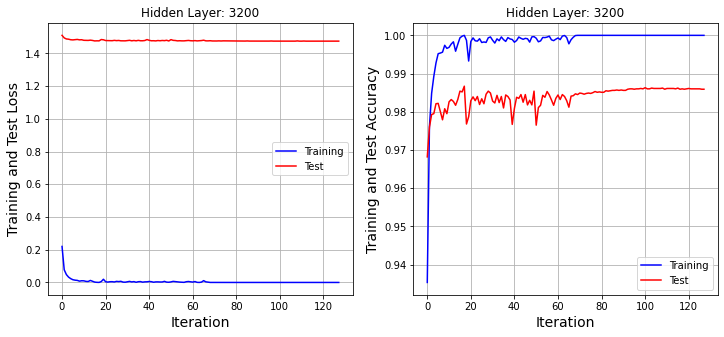

In [28]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss4, 'b', label = "Training")
ax[0].plot(range(128), test_loss4, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 3200')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc4, 'b', label = "Training")
ax[1].plot(range(128), test_acc4, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 3200')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 3200.png")

In [29]:
model = BaselineModel(784,6400,10)

train_loss4 = np.zeros(128)
test_loss4 = np.zeros(128)
train_acc4 = np.zeros(128)
test_acc4 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11408666521310806, 'running_acc': 0.9651562571525574, 'loss': 0.19825540482997894, 'acc': 0.9415500164031982, 'val_loss': 1.5077351331710815, 'val_acc': 0.9702000021934509}
Epoch: 1
Training Loss: 0.19825540482997894
Training Accuracy: 0.9415500164031982
Test Loss: 1.5077351331710815
Test Accuracy: 0.9702000021934509


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06951797008514404, 'running_acc': 0.9782811999320984, 'loss': 0.0708891972899437, 'acc': 0.9785333275794983, 'val_loss': 1.496596336364746, 'val_acc': 0.9727999567985535}
Epoch: 2
Training Loss: 0.0708891972899437
Training Accuracy: 0.9785333275794983
Test Loss: 1.496596336364746
Test Accuracy: 0.9727999567985535


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04189150780439377, 'running_acc': 0.9853124618530273, 'loss': 0.04357209801673889, 'acc': 0.9860333204269409, 'val_loss': 1.4877170324325562, 'val_acc': 0.9802999496459961}
Epoch: 3
Training Loss: 0.04357209801673889
Training Accuracy: 0.9860333204269409
Test Loss: 1.4877170324325562
Test Accuracy: 0.9802999496459961


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.031375687569379807, 'running_acc': 0.9895312190055847, 'loss': 0.028506530448794365, 'acc': 0.9905333518981934, 'val_loss': 1.4888750314712524, 'val_acc': 0.9759999513626099}
Epoch: 4
Training Loss: 0.028506530448794365
Training Accuracy: 0.9905333518981934
Test Loss: 1.4888750314712524
Test Accuracy: 0.9759999513626099


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03030366264283657, 'running_acc': 0.9903124570846558, 'loss': 0.022705767303705215, 'acc': 0.9927166700363159, 'val_loss': 1.486001968383789, 'val_acc': 0.9793999791145325}
Epoch: 5
Training Loss: 0.022705767303705215
Training Accuracy: 0.9927166700363159
Test Loss: 1.486001968383789
Test Accuracy: 0.9793999791145325


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.027059700340032578, 'running_acc': 0.9912499785423279, 'loss': 0.018695345148444176, 'acc': 0.9939166903495789, 'val_loss': 1.4826668500900269, 'val_acc': 0.9811999797821045}
Epoch: 6
Training Loss: 0.018695345148444176
Training Accuracy: 0.9939166903495789
Test Loss: 1.4826668500900269
Test Accuracy: 0.9811999797821045


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01485215313732624, 'running_acc': 0.99609375, 'loss': 0.0136815644800663, 'acc': 0.9955333471298218, 'val_loss': 1.4804331064224243, 'val_acc': 0.9830999970436096}
Epoch: 7
Training Loss: 0.0136815644800663
Training Accuracy: 0.9955333471298218
Test Loss: 1.4804331064224243
Test Accuracy: 0.9830999970436096


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.020786739885807037, 'running_acc': 0.9931249618530273, 'loss': 0.013316131196916103, 'acc': 0.9955999851226807, 'val_loss': 1.4807738065719604, 'val_acc': 0.9820999503135681}
Epoch: 8
Training Loss: 0.013316131196916103
Training Accuracy: 0.9955999851226807
Test Loss: 1.4807738065719604
Test Accuracy: 0.9820999503135681


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.019954364746809006, 'running_acc': 0.9931249618530273, 'loss': 0.012148323468863964, 'acc': 0.9959999918937683, 'val_loss': 1.4832584857940674, 'val_acc': 0.9793999791145325}
Epoch: 9
Training Loss: 0.012148323468863964
Training Accuracy: 0.9959999918937683
Test Loss: 1.4832584857940674
Test Accuracy: 0.9793999791145325


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012176341377198696, 'running_acc': 0.99609375, 'loss': 0.009198523126542568, 'acc': 0.9973500370979309, 'val_loss': 1.4818201065063477, 'val_acc': 0.9805999994277954}
Epoch: 10
Training Loss: 0.009198523126542568
Training Accuracy: 0.9973500370979309
Test Loss: 1.4818201065063477
Test Accuracy: 0.9805999994277954


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012299210764467716, 'running_acc': 0.9965624809265137, 'loss': 0.011413773521780968, 'acc': 0.9963499903678894, 'val_loss': 1.478897213935852, 'val_acc': 0.9835999608039856}
Epoch: 11
Training Loss: 0.011413773521780968
Training Accuracy: 0.9963499903678894
Test Loss: 1.478897213935852
Test Accuracy: 0.9835999608039856


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010565477423369884, 'running_acc': 0.9957812428474426, 'loss': 0.00900246948003769, 'acc': 0.996916651725769, 'val_loss': 1.480171799659729, 'val_acc': 0.9825999736785889}
Epoch: 12
Training Loss: 0.00900246948003769
Training Accuracy: 0.996916651725769
Test Loss: 1.480171799659729
Test Accuracy: 0.9825999736785889


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010495646856725216, 'running_acc': 0.9965624809265137, 'loss': 0.008023741655051708, 'acc': 0.9974499940872192, 'val_loss': 1.4790611267089844, 'val_acc': 0.9827999472618103}
Epoch: 13
Training Loss: 0.008023741655051708
Training Accuracy: 0.9974499940872192
Test Loss: 1.4790611267089844
Test Accuracy: 0.9827999472618103


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012217994779348373, 'running_acc': 0.9965624809265137, 'loss': 0.009157891385257244, 'acc': 0.9969000220298767, 'val_loss': 1.4786434173583984, 'val_acc': 0.9835000038146973}
Epoch: 14
Training Loss: 0.009157891385257244
Training Accuracy: 0.9969000220298767
Test Loss: 1.4786434173583984
Test Accuracy: 0.9835000038146973


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.014779034070670605, 'running_acc': 0.9950000047683716, 'loss': 0.008162110112607479, 'acc': 0.9973333477973938, 'val_loss': 1.4797223806381226, 'val_acc': 0.9820999503135681}
Epoch: 15
Training Loss: 0.008162110112607479
Training Accuracy: 0.9973333477973938
Test Loss: 1.4797223806381226
Test Accuracy: 0.9820999503135681


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012115176767110825, 'running_acc': 0.9964062571525574, 'loss': 0.009630227461457253, 'acc': 0.996916651725769, 'val_loss': 1.4795863628387451, 'val_acc': 0.981499969959259}
Epoch: 16
Training Loss: 0.009630227461457253
Training Accuracy: 0.996916651725769
Test Loss: 1.4795863628387451
Test Accuracy: 0.981499969959259


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005458665546029806, 'running_acc': 0.9971874952316284, 'loss': 0.005327526014298201, 'acc': 0.9980666637420654, 'val_loss': 1.4770066738128662, 'val_acc': 0.9846999645233154}
Epoch: 17
Training Loss: 0.005327526014298201
Training Accuracy: 0.9980666637420654
Test Loss: 1.4770066738128662
Test Accuracy: 0.9846999645233154


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002753968583419919, 'running_acc': 0.9990624785423279, 'loss': 0.0034040454775094986, 'acc': 0.9990000128746033, 'val_loss': 1.47614324092865, 'val_acc': 0.9856999516487122}
Epoch: 18
Training Loss: 0.0034040454775094986
Training Accuracy: 0.9990000128746033
Test Loss: 1.47614324092865
Test Accuracy: 0.9856999516487122


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003901080694049597, 'running_acc': 0.9990624785423279, 'loss': 0.003227315144613385, 'acc': 0.9991166591644287, 'val_loss': 1.4768553972244263, 'val_acc': 0.9850999712944031}
Epoch: 19
Training Loss: 0.003227315144613385
Training Accuracy: 0.9991166591644287
Test Loss: 1.4768553972244263
Test Accuracy: 0.9850999712944031


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.017106974497437477, 'running_acc': 0.9954687356948853, 'loss': 0.012218456715345383, 'acc': 0.996566653251648, 'val_loss': 1.4799543619155884, 'val_acc': 0.9815999865531921}
Epoch: 20
Training Loss: 0.012218456715345383
Training Accuracy: 0.996566653251648
Test Loss: 1.4799543619155884
Test Accuracy: 0.9815999865531921


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0027094241231679916, 'running_acc': 0.9990624785423279, 'loss': 0.004278854932636023, 'acc': 0.9987666606903076, 'val_loss': 1.4768177270889282, 'val_acc': 0.9847999811172485}
Epoch: 21
Training Loss: 0.004278854932636023
Training Accuracy: 0.9987666606903076
Test Loss: 1.4768177270889282
Test Accuracy: 0.9847999811172485


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0025717164389789104, 'running_acc': 0.9992187023162842, 'loss': 0.0030342738609761, 'acc': 0.9991000294685364, 'val_loss': 1.478421926498413, 'val_acc': 0.9825999736785889}
Epoch: 22
Training Loss: 0.0030342738609761
Training Accuracy: 0.9991000294685364
Test Loss: 1.478421926498413
Test Accuracy: 0.9825999736785889


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0169072262942791, 'running_acc': 0.9959374666213989, 'loss': 0.006202797405421734, 'acc': 0.998199999332428, 'val_loss': 1.4832241535186768, 'val_acc': 0.9785999655723572}
Epoch: 23
Training Loss: 0.006202797405421734
Training Accuracy: 0.998199999332428
Test Loss: 1.4832241535186768
Test Accuracy: 0.9785999655723572


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01004954893141985, 'running_acc': 0.99671870470047, 'loss': 0.010403689928352833, 'acc': 0.9969000220298767, 'val_loss': 1.4803954362869263, 'val_acc': 0.98089998960495}
Epoch: 24
Training Loss: 0.010403689928352833
Training Accuracy: 0.9969000220298767
Test Loss: 1.4803954362869263
Test Accuracy: 0.98089998960495


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0034638706129044294, 'running_acc': 0.9993749856948853, 'loss': 0.005447123199701309, 'acc': 0.9984333515167236, 'val_loss': 1.4759918451309204, 'val_acc': 0.9853999614715576}
Epoch: 25
Training Loss: 0.005447123199701309
Training Accuracy: 0.9984333515167236
Test Loss: 1.4759918451309204
Test Accuracy: 0.9853999614715576


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007737295236438513, 'running_acc': 0.9987499713897705, 'loss': 0.0043165674433112144, 'acc': 0.9989500045776367, 'val_loss': 1.4771913290023804, 'val_acc': 0.9842999577522278}
Epoch: 26
Training Loss: 0.0043165674433112144
Training Accuracy: 0.9989500045776367
Test Loss: 1.4771913290023804
Test Accuracy: 0.9842999577522278


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.014105381444096565, 'running_acc': 0.9981249570846558, 'loss': 0.004697742406278849, 'acc': 0.9990333318710327, 'val_loss': 1.4766664505004883, 'val_acc': 0.9854999780654907}
Epoch: 27
Training Loss: 0.004697742406278849
Training Accuracy: 0.9990333318710327
Test Loss: 1.4766664505004883
Test Accuracy: 0.9854999780654907


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007735088467597961, 'running_acc': 0.9990624785423279, 'loss': 0.005519688129425049, 'acc': 0.9987666606903076, 'val_loss': 1.477385401725769, 'val_acc': 0.9838999509811401}
Epoch: 28
Training Loss: 0.005519688129425049
Training Accuracy: 0.9987666606903076
Test Loss: 1.477385401725769
Test Accuracy: 0.9838999509811401


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010414406657218933, 'running_acc': 0.996874988079071, 'loss': 0.006576958112418652, 'acc': 0.9980999827384949, 'val_loss': 1.4815438985824585, 'val_acc': 0.979699969291687}
Epoch: 29
Training Loss: 0.006576958112418652
Training Accuracy: 0.9980999827384949
Test Loss: 1.4815438985824585
Test Accuracy: 0.979699969291687


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0036053971853107214, 'running_acc': 0.9982812404632568, 'loss': 0.005679429043084383, 'acc': 0.9983000159263611, 'val_loss': 1.4778507947921753, 'val_acc': 0.9827999472618103}
Epoch: 30
Training Loss: 0.005679429043084383
Training Accuracy: 0.9983000159263611
Test Loss: 1.4778507947921753
Test Accuracy: 0.9827999472618103


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004477844573557377, 'running_acc': 0.9985937476158142, 'loss': 0.003961808048188686, 'acc': 0.9989666938781738, 'val_loss': 1.4785653352737427, 'val_acc': 0.9821999669075012}
Epoch: 31
Training Loss: 0.003961808048188686
Training Accuracy: 0.9989666938781738
Test Loss: 1.4785653352737427
Test Accuracy: 0.9821999669075012


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0025188843719661236, 'running_acc': 0.9993749856948853, 'loss': 0.006830778904259205, 'acc': 0.99795001745224, 'val_loss': 1.477434754371643, 'val_acc': 0.9838999509811401}
Epoch: 32
Training Loss: 0.006830778904259205
Training Accuracy: 0.99795001745224
Test Loss: 1.477434754371643
Test Accuracy: 0.9838999509811401


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0037405826151371002, 'running_acc': 0.9984374642372131, 'loss': 0.0049773696810007095, 'acc': 0.9986333250999451, 'val_loss': 1.4765478372573853, 'val_acc': 0.984499990940094}
Epoch: 33
Training Loss: 0.0049773696810007095
Training Accuracy: 0.9986333250999451
Test Loss: 1.4765478372573853
Test Accuracy: 0.984499990940094


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003366683376953006, 'running_acc': 0.9985937476158142, 'loss': 0.006209260318428278, 'acc': 0.9983167052268982, 'val_loss': 1.4792473316192627, 'val_acc': 0.9818999767303467}
Epoch: 34
Training Loss: 0.006209260318428278
Training Accuracy: 0.9983167052268982
Test Loss: 1.4792473316192627
Test Accuracy: 0.9818999767303467


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005571150686591864, 'running_acc': 0.9987499713897705, 'loss': 0.0070772310718894005, 'acc': 0.9982166886329651, 'val_loss': 1.4774476289749146, 'val_acc': 0.9838999509811401}
Epoch: 35
Training Loss: 0.0070772310718894005
Training Accuracy: 0.9982166886329651
Test Loss: 1.4774476289749146
Test Accuracy: 0.9838999509811401


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0007949041901156306, 'running_acc': 0.9996874928474426, 'loss': 0.0031738083343952894, 'acc': 0.9991500377655029, 'val_loss': 1.4768317937850952, 'val_acc': 0.9839999675750732}
Epoch: 36
Training Loss: 0.0031738083343952894
Training Accuracy: 0.9991500377655029
Test Loss: 1.4768317937850952
Test Accuracy: 0.9839999675750732


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009737263433635235, 'running_acc': 0.9978124499320984, 'loss': 0.0038087700959295034, 'acc': 0.9991500377655029, 'val_loss': 1.4793099164962769, 'val_acc': 0.9824999570846558}
Epoch: 37
Training Loss: 0.0038087700959295034
Training Accuracy: 0.9991500377655029
Test Loss: 1.4793099164962769
Test Accuracy: 0.9824999570846558


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0039849476888775826, 'running_acc': 0.9985937476158142, 'loss': 0.007439249660819769, 'acc': 0.9981333613395691, 'val_loss': 1.47834312915802, 'val_acc': 0.9833999872207642}
Epoch: 38
Training Loss: 0.007439249660819769
Training Accuracy: 0.9981333613395691
Test Loss: 1.47834312915802
Test Accuracy: 0.9833999872207642


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009915907867252827, 'running_acc': 0.9981249570846558, 'loss': 0.003969705663621426, 'acc': 0.9988999962806702, 'val_loss': 1.4789981842041016, 'val_acc': 0.9822999835014343}
Epoch: 39
Training Loss: 0.003969705663621426
Training Accuracy: 0.9988999962806702
Test Loss: 1.4789981842041016
Test Accuracy: 0.9822999835014343


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006142680067569017, 'running_acc': 0.9981249570846558, 'loss': 0.004452983848750591, 'acc': 0.9986667037010193, 'val_loss': 1.4776135683059692, 'val_acc': 0.9833999872207642}
Epoch: 40
Training Loss: 0.004452983848750591
Training Accuracy: 0.9986667037010193
Test Loss: 1.4776135683059692
Test Accuracy: 0.9833999872207642


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0037188807036727667, 'running_acc': 0.9995312094688416, 'loss': 0.0031328550539910793, 'acc': 0.9990167021751404, 'val_loss': 1.4773350954055786, 'val_acc': 0.9836999773979187}
Epoch: 41
Training Loss: 0.0031328550539910793
Training Accuracy: 0.9990167021751404
Test Loss: 1.4773350954055786
Test Accuracy: 0.9836999773979187


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004615785554051399, 'running_acc': 0.9985937476158142, 'loss': 0.005337538197636604, 'acc': 0.9987666606903076, 'val_loss': 1.4772359132766724, 'val_acc': 0.9837999939918518}
Epoch: 42
Training Loss: 0.005337538197636604
Training Accuracy: 0.9987666606903076
Test Loss: 1.4772359132766724
Test Accuracy: 0.9837999939918518


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0016111438162624836, 'running_acc': 0.9993749856948853, 'loss': 0.006382436957210302, 'acc': 0.9984666705131531, 'val_loss': 1.4789525270462036, 'val_acc': 0.9824999570846558}
Epoch: 43
Training Loss: 0.006382436957210302
Training Accuracy: 0.9984666705131531
Test Loss: 1.4789525270462036
Test Accuracy: 0.9824999570846558


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005689526442438364, 'running_acc': 0.9982812404632568, 'loss': 0.003969703335314989, 'acc': 0.9989333152770996, 'val_loss': 1.4784036874771118, 'val_acc': 0.9830999970436096}
Epoch: 44
Training Loss: 0.003969703335314989
Training Accuracy: 0.9989333152770996
Test Loss: 1.4784036874771118
Test Accuracy: 0.9830999970436096


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0030249888077378273, 'running_acc': 0.9996874928474426, 'loss': 0.003941096365451813, 'acc': 0.9989666938781738, 'val_loss': 1.4794224500656128, 'val_acc': 0.9815999865531921}
Epoch: 45
Training Loss: 0.003941096365451813
Training Accuracy: 0.9989666938781738
Test Loss: 1.4794224500656128
Test Accuracy: 0.9815999865531921


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0019061542116105556, 'running_acc': 0.9993749856948853, 'loss': 0.003592369845137, 'acc': 0.9991333484649658, 'val_loss': 1.4753973484039307, 'val_acc': 0.9858999848365784}
Epoch: 46
Training Loss: 0.003592369845137
Training Accuracy: 0.9991333484649658
Test Loss: 1.4753973484039307
Test Accuracy: 0.9858999848365784


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007674922235310078, 'running_acc': 0.9981249570846558, 'loss': 0.006016584113240242, 'acc': 0.9985833168029785, 'val_loss': 1.4778566360473633, 'val_acc': 0.9836999773979187}
Epoch: 47
Training Loss: 0.006016584113240242
Training Accuracy: 0.9985833168029785
Test Loss: 1.4778566360473633
Test Accuracy: 0.9836999773979187


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0018139599123969674, 'running_acc': 0.9992187023162842, 'loss': 0.002482812851667404, 'acc': 0.9993667006492615, 'val_loss': 1.4758574962615967, 'val_acc': 0.98499995470047}
Epoch: 48
Training Loss: 0.002482812851667404
Training Accuracy: 0.9993667006492615
Test Loss: 1.4758574962615967
Test Accuracy: 0.98499995470047


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0010367520153522491, 'running_acc': 0.9993749856948853, 'loss': 0.0034353320952504873, 'acc': 0.9991833567619324, 'val_loss': 1.4782754182815552, 'val_acc': 0.9835999608039856}
Epoch: 49
Training Loss: 0.0034353320952504873
Training Accuracy: 0.9991833567619324
Test Loss: 1.4782754182815552
Test Accuracy: 0.9835999608039856


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005830522160977125, 'running_acc': 0.9985937476158142, 'loss': 0.005143621005117893, 'acc': 0.9985666871070862, 'val_loss': 1.4781646728515625, 'val_acc': 0.983199954032898}
Epoch: 50
Training Loss: 0.005143621005117893
Training Accuracy: 0.9985666871070862
Test Loss: 1.4781646728515625
Test Accuracy: 0.983199954032898


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007761291228234768, 'running_acc': 0.9989062547683716, 'loss': 0.004732911940664053, 'acc': 0.9989500045776367, 'val_loss': 1.4773039817810059, 'val_acc': 0.9836999773979187}
Epoch: 51
Training Loss: 0.004732911940664053
Training Accuracy: 0.9989500045776367
Test Loss: 1.4773039817810059
Test Accuracy: 0.9836999773979187


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0004495957400649786, 'running_acc': 0.9996874928474426, 'loss': 0.0016812992980703712, 'acc': 0.9994666576385498, 'val_loss': 1.475951075553894, 'val_acc': 0.9848999977111816}
Epoch: 52
Training Loss: 0.0016812992980703712
Training Accuracy: 0.9994666576385498
Test Loss: 1.475951075553894
Test Accuracy: 0.9848999977111816


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009518814273178577, 'running_acc': 0.9982812404632568, 'loss': 0.0063331578858196735, 'acc': 0.9986833333969116, 'val_loss': 1.477843165397644, 'val_acc': 0.9829999804496765}
Epoch: 53
Training Loss: 0.0063331578858196735
Training Accuracy: 0.9986833333969116
Test Loss: 1.477843165397644
Test Accuracy: 0.9829999804496765


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004833963233977556, 'running_acc': 0.9987499713897705, 'loss': 0.0042689586989581585, 'acc': 0.9989333152770996, 'val_loss': 1.4789339303970337, 'val_acc': 0.983199954032898}
Epoch: 54
Training Loss: 0.0042689586989581585
Training Accuracy: 0.9989333152770996
Test Loss: 1.4789339303970337
Test Accuracy: 0.983199954032898


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0026740783359855413, 'running_acc': 0.9996874928474426, 'loss': 0.0027923816815018654, 'acc': 0.9993833303451538, 'val_loss': 1.4781113862991333, 'val_acc': 0.9835999608039856}
Epoch: 55
Training Loss: 0.0027923816815018654
Training Accuracy: 0.9993833303451538
Test Loss: 1.4781113862991333
Test Accuracy: 0.9835999608039856


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00017560143896844238, 'running_acc': 1.0, 'loss': 0.0019494752632454038, 'acc': 0.9995333552360535, 'val_loss': 1.4760578870773315, 'val_acc': 0.9848999977111816}
Epoch: 56
Training Loss: 0.0019494752632454038
Training Accuracy: 0.9995333552360535
Test Loss: 1.4760578870773315
Test Accuracy: 0.9848999977111816


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006930181756615639, 'running_acc': 0.9985937476158142, 'loss': 0.003114133607596159, 'acc': 0.9993833303451538, 'val_loss': 1.479344367980957, 'val_acc': 0.9822999835014343}
Epoch: 57
Training Loss: 0.003114133607596159
Training Accuracy: 0.9993833303451538
Test Loss: 1.479344367980957
Test Accuracy: 0.9822999835014343


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008350001648068428, 'running_acc': 0.9982812404632568, 'loss': 0.010331516154110432, 'acc': 0.9980500340461731, 'val_loss': 1.4779051542282104, 'val_acc': 0.9833999872207642}
Epoch: 58
Training Loss: 0.010331516154110432
Training Accuracy: 0.9980500340461731
Test Loss: 1.4779051542282104
Test Accuracy: 0.9833999872207642


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00781424529850483, 'running_acc': 0.9979687333106995, 'loss': 0.005474952515214682, 'acc': 0.9988166689872742, 'val_loss': 1.4789149761199951, 'val_acc': 0.9820999503135681}
Epoch: 59
Training Loss: 0.005474952515214682
Training Accuracy: 0.9988166689872742
Test Loss: 1.4789149761199951
Test Accuracy: 0.9820999503135681


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004993576090782881, 'running_acc': 0.9987499713897705, 'loss': 0.0030081395525485277, 'acc': 0.9992666840553284, 'val_loss': 1.4788068532943726, 'val_acc': 0.9833999872207642}
Epoch: 60
Training Loss: 0.0030081395525485277
Training Accuracy: 0.9992666840553284
Test Loss: 1.4788068532943726
Test Accuracy: 0.9833999872207642


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002336866920813918, 'running_acc': 0.9995312094688416, 'loss': 0.005191262811422348, 'acc': 0.9991333484649658, 'val_loss': 1.4761958122253418, 'val_acc': 0.9846999645233154}
Epoch: 61
Training Loss: 0.005191262811422348
Training Accuracy: 0.9991333484649658
Test Loss: 1.4761958122253418
Test Accuracy: 0.9846999645233154


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0047206515446305275, 'running_acc': 0.9989062547683716, 'loss': 0.0039118207059800625, 'acc': 0.9992166757583618, 'val_loss': 1.4756879806518555, 'val_acc': 0.9851999878883362}
Epoch: 62
Training Loss: 0.0039118207059800625
Training Accuracy: 0.9992166757583618
Test Loss: 1.4756879806518555
Test Accuracy: 0.9851999878883362


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005574840120971203, 'running_acc': 0.9987499713897705, 'loss': 0.0014971024356782436, 'acc': 0.9996333718299866, 'val_loss': 1.4769768714904785, 'val_acc': 0.9847999811172485}
Epoch: 63
Training Loss: 0.0014971024356782436
Training Accuracy: 0.9996333718299866
Test Loss: 1.4769768714904785
Test Accuracy: 0.9847999811172485


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0014912438346073031, 'running_acc': 0.9996874928474426, 'loss': 0.001931586186401546, 'acc': 0.9995333552360535, 'val_loss': 1.4763884544372559, 'val_acc': 0.9845999479293823}
Epoch: 64
Training Loss: 0.001931586186401546
Training Accuracy: 0.9995333552360535
Test Loss: 1.4763884544372559
Test Accuracy: 0.9845999479293823


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005443199072033167, 'running_acc': 0.9985937476158142, 'loss': 0.004179801791906357, 'acc': 0.9991666674613953, 'val_loss': 1.4786478281021118, 'val_acc': 0.9822999835014343}
Epoch: 65
Training Loss: 0.004179801791906357
Training Accuracy: 0.9991666674613953
Test Loss: 1.4786478281021118
Test Accuracy: 0.9822999835014343


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007624736055731773, 'running_acc': 0.9982812404632568, 'loss': 0.0029322924092411995, 'acc': 0.9992166757583618, 'val_loss': 1.4777826070785522, 'val_acc': 0.9838999509811401}
Epoch: 66
Training Loss: 0.0029322924092411995
Training Accuracy: 0.9992166757583618
Test Loss: 1.4777826070785522
Test Accuracy: 0.9838999509811401


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.020180057734251022, 'running_acc': 0.9979687333106995, 'loss': 0.010855915024876595, 'acc': 0.9982166886329651, 'val_loss': 1.4778121709823608, 'val_acc': 0.9828999638557434}
Epoch: 67
Training Loss: 0.010855915024876595
Training Accuracy: 0.9982166886329651
Test Loss: 1.4778121709823608
Test Accuracy: 0.9828999638557434


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005849276669323444, 'running_acc': 0.9987499713897705, 'loss': 0.004990777466446161, 'acc': 0.9988499879837036, 'val_loss': 1.4773080348968506, 'val_acc': 0.9837999939918518}
Epoch: 68
Training Loss: 0.004990777466446161
Training Accuracy: 0.9988499879837036
Test Loss: 1.4773080348968506
Test Accuracy: 0.9837999939918518


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00015562193584628403, 'running_acc': 1.0, 'loss': 0.001718766987323761, 'acc': 0.9995333552360535, 'val_loss': 1.4758737087249756, 'val_acc': 0.9853000044822693}
Epoch: 69
Training Loss: 0.001718766987323761
Training Accuracy: 0.9995333552360535
Test Loss: 1.4758737087249756
Test Accuracy: 0.9853000044822693


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0015841459389775991, 'running_acc': 0.9993749856948853, 'loss': 0.0014341704081743956, 'acc': 0.9996500015258789, 'val_loss': 1.4785069227218628, 'val_acc': 0.9833999872207642}
Epoch: 70
Training Loss: 0.0014341704081743956
Training Accuracy: 0.9996500015258789
Test Loss: 1.4785069227218628
Test Accuracy: 0.9833999872207642


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0031036417931318283, 'running_acc': 0.9992187023162842, 'loss': 0.005689545068889856, 'acc': 0.9988000392913818, 'val_loss': 1.477499008178711, 'val_acc': 0.9835000038146973}
Epoch: 71
Training Loss: 0.005689545068889856
Training Accuracy: 0.9988000392913818
Test Loss: 1.477499008178711
Test Accuracy: 0.9835000038146973


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00745489401742816, 'running_acc': 0.9990624785423279, 'loss': 0.005060425493866205, 'acc': 0.9991500377655029, 'val_loss': 1.4770816564559937, 'val_acc': 0.9838999509811401}
Epoch: 72
Training Loss: 0.005060425493866205
Training Accuracy: 0.9991500377655029
Test Loss: 1.4770816564559937
Test Accuracy: 0.9838999509811401


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00997196976095438, 'running_acc': 0.9984374642372131, 'loss': 0.0069170184433460236, 'acc': 0.9988666772842407, 'val_loss': 1.476232886314392, 'val_acc': 0.9847999811172485}
Epoch: 73
Training Loss: 0.0069170184433460236
Training Accuracy: 0.9988666772842407
Test Loss: 1.476232886314392
Test Accuracy: 0.9847999811172485


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00048736282042227685, 'running_acc': 0.9996874928474426, 'loss': 0.002630089409649372, 'acc': 0.9994500279426575, 'val_loss': 1.476316213607788, 'val_acc': 0.9851999878883362}
Epoch: 74
Training Loss: 0.002630089409649372
Training Accuracy: 0.9994500279426575
Test Loss: 1.476316213607788
Test Accuracy: 0.9851999878883362


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.000474929460324347, 'running_acc': 0.9998437166213989, 'loss': 0.0015785910654813051, 'acc': 0.999750018119812, 'val_loss': 1.4759770631790161, 'val_acc': 0.984499990940094}
Epoch: 75
Training Loss: 0.0015785910654813051
Training Accuracy: 0.999750018119812
Test Loss: 1.4759770631790161
Test Accuracy: 0.984499990940094


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.45464000524953e-05, 'running_acc': 1.0, 'loss': 2.286944436491467e-05, 'acc': 1.0, 'val_loss': 1.4759527444839478, 'val_acc': 0.9850999712944031}
Epoch: 76
Training Loss: 2.286944436491467e-05
Training Accuracy: 1.0
Test Loss: 1.4759527444839478
Test Accuracy: 0.9850999712944031


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.543986958400637e-07, 'running_acc': 1.0, 'loss': 9.033790888679505e-07, 'acc': 1.0, 'val_loss': 1.4773057699203491, 'val_acc': 0.9850999712944031}
Epoch: 77
Training Loss: 9.033790888679505e-07
Training Accuracy: 1.0
Test Loss: 1.4773057699203491
Test Accuracy: 0.9850999712944031


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.532467758304847e-07, 'running_acc': 1.0, 'loss': 5.721107072531595e-07, 'acc': 1.0, 'val_loss': 1.4759143590927124, 'val_acc': 0.9850999712944031}
Epoch: 78
Training Loss: 5.721107072531595e-07
Training Accuracy: 1.0
Test Loss: 1.4759143590927124
Test Accuracy: 0.9850999712944031


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.883364100460312e-07, 'running_acc': 1.0, 'loss': 4.5124738790036645e-07, 'acc': 1.0, 'val_loss': 1.4758882522583008, 'val_acc': 0.9851999878883362}
Epoch: 79
Training Loss: 4.5124738790036645e-07
Training Accuracy: 1.0
Test Loss: 1.4758882522583008
Test Accuracy: 0.9851999878883362


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.565704045944585e-07, 'running_acc': 1.0, 'loss': 3.6442099826672347e-07, 'acc': 1.0, 'val_loss': 1.4758716821670532, 'val_acc': 0.9851999878883362}
Epoch: 80
Training Loss: 3.6442099826672347e-07
Training Accuracy: 1.0
Test Loss: 1.4758716821670532
Test Accuracy: 0.9851999878883362


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.685058208522605e-07, 'running_acc': 1.0, 'loss': 2.9910975740676804e-07, 'acc': 1.0, 'val_loss': 1.4758574962615967, 'val_acc': 0.9851999878883362}
Epoch: 81
Training Loss: 2.9910975740676804e-07
Training Accuracy: 1.0
Test Loss: 1.4758574962615967
Test Accuracy: 0.9851999878883362


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.4587462260351458e-07, 'running_acc': 1.0, 'loss': 2.473885558629263e-07, 'acc': 1.0, 'val_loss': 1.4758409261703491, 'val_acc': 0.9851999878883362}
Epoch: 82
Training Loss: 2.473885558629263e-07
Training Accuracy: 1.0
Test Loss: 1.4758409261703491
Test Accuracy: 0.9851999878883362


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.642522431046018e-08, 'running_acc': 1.0, 'loss': 2.0534648115244636e-07, 'acc': 1.0, 'val_loss': 1.4759399890899658, 'val_acc': 0.9850999712944031}
Epoch: 83
Training Loss: 2.0534648115244636e-07
Training Accuracy: 1.0
Test Loss: 1.4759399890899658
Test Accuracy: 0.9850999712944031


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.1825651569097317e-07, 'running_acc': 1.0, 'loss': 1.7022183840254002e-07, 'acc': 1.0, 'val_loss': 1.475795865058899, 'val_acc': 0.9850999712944031}
Epoch: 84
Training Loss: 1.7022183840254002e-07
Training Accuracy: 1.0
Test Loss: 1.475795865058899
Test Accuracy: 0.9850999712944031


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.2987752029403055e-07, 'running_acc': 1.0, 'loss': 1.4120335833922582e-07, 'acc': 1.0, 'val_loss': 1.4757659435272217, 'val_acc': 0.9850999712944031}
Epoch: 85
Training Loss: 1.4120335833922582e-07
Training Accuracy: 1.0
Test Loss: 1.4757659435272217
Test Accuracy: 0.9850999712944031


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.83311485102422e-07, 'running_acc': 1.0, 'loss': 1.1723730608537153e-07, 'acc': 1.0, 'val_loss': 1.4757431745529175, 'val_acc': 0.9850999712944031}
Epoch: 86
Training Loss: 1.1723730608537153e-07
Training Accuracy: 1.0
Test Loss: 1.4757431745529175
Test Accuracy: 0.9850999712944031


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.079805897092228e-08, 'running_acc': 1.0, 'loss': 9.67026423381867e-08, 'acc': 1.0, 'val_loss': 1.4757168292999268, 'val_acc': 0.9850999712944031}
Epoch: 87
Training Loss: 9.67026423381867e-08
Training Accuracy: 1.0
Test Loss: 1.4757168292999268
Test Accuracy: 0.9850999712944031


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.692380338790826e-08, 'running_acc': 1.0, 'loss': 8.124372641304944e-08, 'acc': 1.0, 'val_loss': 1.475671648979187, 'val_acc': 0.9853000044822693}
Epoch: 88
Training Loss: 8.124372641304944e-08
Training Accuracy: 1.0
Test Loss: 1.475671648979187
Test Accuracy: 0.9853000044822693


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.059549116978815e-08, 'running_acc': 1.0, 'loss': 6.870882884868479e-08, 'acc': 1.0, 'val_loss': 1.4756556749343872, 'val_acc': 0.9853000044822693}
Epoch: 89
Training Loss: 6.870882884868479e-08
Training Accuracy: 1.0
Test Loss: 1.4756556749343872
Test Accuracy: 0.9853000044822693


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.7887997567386265e-08, 'running_acc': 1.0, 'loss': 5.705016548063213e-08, 'acc': 1.0, 'val_loss': 1.4763199090957642, 'val_acc': 0.9853000044822693}
Epoch: 90
Training Loss: 5.705016548063213e-08
Training Accuracy: 1.0
Test Loss: 1.4763199090957642
Test Accuracy: 0.9853000044822693


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.604658781521721e-08, 'running_acc': 1.0, 'loss': 4.794636510041528e-08, 'acc': 1.0, 'val_loss': 1.4756072759628296, 'val_acc': 0.9854999780654907}
Epoch: 91
Training Loss: 4.794636510041528e-08
Training Accuracy: 1.0
Test Loss: 1.4756072759628296
Test Accuracy: 0.9854999780654907


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.2912655711925254e-08, 'running_acc': 1.0, 'loss': 4.0127943634615804e-08, 'acc': 1.0, 'val_loss': 1.4755820035934448, 'val_acc': 0.9853999614715576}
Epoch: 92
Training Loss: 4.0127943634615804e-08
Training Accuracy: 1.0
Test Loss: 1.4755820035934448
Test Accuracy: 0.9853999614715576


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.006522047461658e-08, 'running_acc': 1.0, 'loss': 3.389474656501079e-08, 'acc': 1.0, 'val_loss': 1.4762216806411743, 'val_acc': 0.9853999614715576}
Epoch: 93
Training Loss: 3.389474656501079e-08
Training Accuracy: 1.0
Test Loss: 1.4762216806411743
Test Accuracy: 0.9853999614715576


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.464492337457159e-08, 'running_acc': 1.0, 'loss': 2.8722583422791104e-08, 'acc': 1.0, 'val_loss': 1.4762324094772339, 'val_acc': 0.9853000044822693}
Epoch: 94
Training Loss: 2.8722583422791104e-08
Training Accuracy: 1.0
Test Loss: 1.4762324094772339
Test Accuracy: 0.9853000044822693


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.7269006608321433e-08, 'running_acc': 1.0, 'loss': 2.4322847735902542e-08, 'acc': 1.0, 'val_loss': 1.475508213043213, 'val_acc': 0.9853000044822693}
Epoch: 95
Training Loss: 2.4322847735902542e-08
Training Accuracy: 1.0
Test Loss: 1.475508213043213
Test Accuracy: 0.9853000044822693


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.84424661600724e-08, 'running_acc': 1.0, 'loss': 2.0976202108613506e-08, 'acc': 1.0, 'val_loss': 1.475502610206604, 'val_acc': 0.9853000044822693}
Epoch: 96
Training Loss: 2.0976202108613506e-08
Training Accuracy: 1.0
Test Loss: 1.475502610206604
Test Accuracy: 0.9853000044822693


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.73784258095111e-08, 'running_acc': 1.0, 'loss': 1.7865863455313047e-08, 'acc': 1.0, 'val_loss': 1.4754587411880493, 'val_acc': 0.9853999614715576}
Epoch: 97
Training Loss: 1.7865863455313047e-08
Training Accuracy: 1.0
Test Loss: 1.4754587411880493
Test Accuracy: 0.9853999614715576


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.2814971306340794e-08, 'running_acc': 1.0, 'loss': 1.5263864838743757e-08, 'acc': 1.0, 'val_loss': 1.475429654121399, 'val_acc': 0.9854999780654907}
Epoch: 98
Training Loss: 1.5263864838743757e-08
Training Accuracy: 1.0
Test Loss: 1.475429654121399
Test Accuracy: 0.9854999780654907


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.3760659802246664e-09, 'running_acc': 1.0, 'loss': 1.2949140426599115e-08, 'acc': 1.0, 'val_loss': 1.4760887622833252, 'val_acc': 0.9854999780654907}
Epoch: 99
Training Loss: 1.2949140426599115e-08
Training Accuracy: 1.0
Test Loss: 1.4760887622833252
Test Accuracy: 0.9854999780654907


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.642663473779066e-09, 'running_acc': 1.0, 'loss': 1.1240725683592245e-08, 'acc': 1.0, 'val_loss': 1.4753681421279907, 'val_acc': 0.9853999614715576}
Epoch: 100
Training Loss: 1.1240725683592245e-08
Training Accuracy: 1.0
Test Loss: 1.4753681421279907
Test Accuracy: 0.9853999614715576


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.167876817476099e-08, 'running_acc': 1.0, 'loss': 9.59387236321163e-09, 'acc': 1.0, 'val_loss': 1.4753371477127075, 'val_acc': 0.9853999614715576}
Epoch: 101
Training Loss: 9.59387236321163e-09
Training Accuracy: 1.0
Test Loss: 1.4753371477127075
Test Accuracy: 0.9853999614715576


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.575131994424055e-09, 'running_acc': 1.0, 'loss': 8.24488033401849e-09, 'acc': 1.0, 'val_loss': 1.475313663482666, 'val_acc': 0.9854999780654907}
Epoch: 102
Training Loss: 8.24488033401849e-09
Training Accuracy: 1.0
Test Loss: 1.475313663482666
Test Accuracy: 0.9854999780654907


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.649640393874279e-09, 'running_acc': 1.0, 'loss': 7.081225383842593e-09, 'acc': 1.0, 'val_loss': 1.4759719371795654, 'val_acc': 0.9854999780654907}
Epoch: 103
Training Loss: 7.081225383842593e-09
Training Accuracy: 1.0
Test Loss: 1.4759719371795654
Test Accuracy: 0.9854999780654907


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.172322931594863e-09, 'running_acc': 1.0, 'loss': 6.163804577852261e-09, 'acc': 1.0, 'val_loss': 1.4752519130706787, 'val_acc': 0.9856999516487122}
Epoch: 104
Training Loss: 6.163804577852261e-09
Training Accuracy: 1.0
Test Loss: 1.4752519130706787
Test Accuracy: 0.9856999516487122


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.9173798366553e-09, 'running_acc': 1.0, 'loss': 5.311251438655518e-09, 'acc': 1.0, 'val_loss': 1.4752219915390015, 'val_acc': 0.9856999516487122}
Epoch: 105
Training Loss: 5.311251438655518e-09
Training Accuracy: 1.0
Test Loss: 1.4752219915390015
Test Accuracy: 0.9856999516487122


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.5075974064445745e-09, 'running_acc': 1.0, 'loss': 4.577181300646771e-09, 'acc': 1.0, 'val_loss': 1.4758905172348022, 'val_acc': 0.9856999516487122}
Epoch: 106
Training Loss: 4.577181300646771e-09
Training Accuracy: 1.0
Test Loss: 1.4758905172348022
Test Accuracy: 0.9856999516487122


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.5203984172227365e-09, 'running_acc': 1.0, 'loss': 3.955638039343512e-09, 'acc': 1.0, 'val_loss': 1.475174903869629, 'val_acc': 0.9857999682426453}
Epoch: 107
Training Loss: 3.955638039343512e-09
Training Accuracy: 1.0
Test Loss: 1.475174903869629
Test Accuracy: 0.9857999682426453


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.650783009234715e-09, 'running_acc': 1.0, 'loss': 3.396977366065812e-09, 'acc': 1.0, 'val_loss': 1.475144863128662, 'val_acc': 0.9856999516487122}
Epoch: 108
Training Loss: 3.396977366065812e-09
Training Accuracy: 1.0
Test Loss: 1.475144863128662
Test Accuracy: 0.9856999516487122


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.793966835668016e-09, 'running_acc': 1.0, 'loss': 2.930323095284848e-09, 'acc': 1.0, 'val_loss': 1.4751081466674805, 'val_acc': 0.9858999848365784}
Epoch: 109
Training Loss: 2.930323095284848e-09
Training Accuracy: 1.0
Test Loss: 1.4751081466674805
Test Accuracy: 0.9858999848365784


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.6135301417772325e-09, 'running_acc': 1.0, 'loss': 2.560971434917292e-09, 'acc': 1.0, 'val_loss': 1.475085735321045, 'val_acc': 0.9857999682426453}
Epoch: 110
Training Loss: 2.560971434917292e-09
Training Accuracy: 1.0
Test Loss: 1.475085735321045
Test Accuracy: 0.9857999682426453


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.5518231971943806e-09, 'running_acc': 1.0, 'loss': 2.2180963732409964e-09, 'acc': 1.0, 'val_loss': 1.4771344661712646, 'val_acc': 0.9857999682426453}
Epoch: 111
Training Loss: 2.2180963732409964e-09
Training Accuracy: 1.0
Test Loss: 1.4771344661712646
Test Accuracy: 0.9857999682426453


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.4528629410648364e-09, 'running_acc': 1.0, 'loss': 1.9195702805063775e-09, 'acc': 1.0, 'val_loss': 1.4750288724899292, 'val_acc': 0.9857999682426453}
Epoch: 112
Training Loss: 1.9195702805063775e-09
Training Accuracy: 1.0
Test Loss: 1.4750288724899292
Test Accuracy: 0.9857999682426453


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.8067656260001286e-09, 'running_acc': 1.0, 'loss': 1.660759196830952e-09, 'acc': 1.0, 'val_loss': 1.4750094413757324, 'val_acc': 0.9858999848365784}
Epoch: 113
Training Loss: 1.660759196830952e-09
Training Accuracy: 1.0
Test Loss: 1.4750094413757324
Test Accuracy: 0.9858999848365784


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.154839890382675e-09, 'running_acc': 1.0, 'loss': 1.4489446309440268e-09, 'acc': 1.0, 'val_loss': 1.4749832153320312, 'val_acc': 0.9860000014305115}
Epoch: 114
Training Loss: 1.4489446309440268e-09
Training Accuracy: 1.0
Test Loss: 1.4749832153320312
Test Accuracy: 0.9860000014305115


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.1175870229251927e-09, 'running_acc': 1.0, 'loss': 1.2470586785440219e-09, 'acc': 1.0, 'val_loss': 1.475645661354065, 'val_acc': 0.9860000014305115}
Epoch: 115
Training Loss: 1.2470586785440219e-09
Training Accuracy: 1.0
Test Loss: 1.475645661354065
Test Accuracy: 0.9860000014305115


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.2107191915688986e-09, 'running_acc': 1.0, 'loss': 1.0564255026324076e-09, 'acc': 1.0, 'val_loss': 1.4749287366867065, 'val_acc': 0.9860000014305115}
Epoch: 116
Training Loss: 1.0564255026324076e-09
Training Accuracy: 1.0
Test Loss: 1.4749287366867065
Test Accuracy: 0.9860000014305115


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.024454632236882e-09, 'running_acc': 1.0, 'loss': 9.200699091493902e-10, 'acc': 1.0, 'val_loss': 1.4749053716659546, 'val_acc': 0.9860000014305115}
Epoch: 117
Training Loss: 9.200699091493902e-10
Training Accuracy: 1.0
Test Loss: 1.4749053716659546
Test Accuracy: 0.9860000014305115


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.078050923148282e-10, 'running_acc': 1.0, 'loss': 8.095291104126545e-10, 'acc': 1.0, 'val_loss': 1.4749202728271484, 'val_acc': 0.9860000014305115}
Epoch: 118
Training Loss: 8.095291104126545e-10
Training Accuracy: 1.0
Test Loss: 1.4749202728271484
Test Accuracy: 0.9860000014305115


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.215405884939628e-10, 'running_acc': 1.0, 'loss': 7.036217719580407e-10, 'acc': 1.0, 'val_loss': 1.4748579263687134, 'val_acc': 0.9860000014305115}
Epoch: 119
Training Loss: 7.036217719580407e-10
Training Accuracy: 1.0
Test Loss: 1.4748579263687134
Test Accuracy: 0.9860000014305115


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.215405884939628e-10, 'running_acc': 1.0, 'loss': 6.056574686219562e-10, 'acc': 1.0, 'val_loss': 1.4748417139053345, 'val_acc': 0.9860999584197998}
Epoch: 120
Training Loss: 6.056574686219562e-10
Training Accuracy: 1.0
Test Loss: 1.4748417139053345
Test Accuracy: 0.9860999584197998


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.774199451913375e-10, 'running_acc': 1.0, 'loss': 5.301984962180484e-10, 'acc': 1.0, 'val_loss': 1.4748345613479614, 'val_acc': 0.9860999584197998}
Epoch: 121
Training Loss: 5.301984962180484e-10
Training Accuracy: 1.0
Test Loss: 1.4748345613479614
Test Accuracy: 0.9860999584197998


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.4703479806784685e-10, 'running_acc': 1.0, 'loss': 4.3289619111597233e-10, 'acc': 1.0, 'val_loss': 1.474820852279663, 'val_acc': 0.9860000014305115}
Epoch: 122
Training Loss: 4.3289619111597233e-10
Training Accuracy: 1.0
Test Loss: 1.474820852279663
Test Accuracy: 0.9860000014305115


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.1664962318878054e-10, 'running_acc': 1.0, 'loss': 3.852378971380688e-10, 'acc': 1.0, 'val_loss': 1.4754958152770996, 'val_acc': 0.9860000014305115}
Epoch: 123
Training Loss: 3.852378971380688e-10
Training Accuracy: 1.0
Test Loss: 1.4754958152770996
Test Accuracy: 0.9860000014305115


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.725289798861553e-10, 'running_acc': 1.0, 'loss': 3.3029845525334167e-10, 'acc': 1.0, 'val_loss': 1.4747958183288574, 'val_acc': 0.9861999750137329}
Epoch: 124
Training Loss: 3.3029845525334167e-10
Training Accuracy: 1.0
Test Loss: 1.4747958183288574
Test Accuracy: 0.9861999750137329


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.539025461574141e-10, 'running_acc': 1.0, 'loss': 2.760209560914717e-10, 'acc': 1.0, 'val_loss': 1.4754679203033447, 'val_acc': 0.9861999750137329}
Epoch: 125
Training Loss: 2.760209560914717e-10
Training Accuracy: 1.0
Test Loss: 1.4754679203033447
Test Accuracy: 0.9861999750137329


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.2351739903392343e-10, 'running_acc': 1.0, 'loss': 2.363057249876732e-10, 'acc': 1.0, 'val_loss': 1.4747850894927979, 'val_acc': 0.9861999750137329}
Epoch: 126
Training Loss: 2.363057249876732e-10
Training Accuracy: 1.0
Test Loss: 1.4747850894927979
Test Accuracy: 0.9861999750137329


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.9802318946003936e-10, 'running_acc': 1.0, 'loss': 2.0453351512461637e-10, 'acc': 1.0, 'val_loss': 1.4747817516326904, 'val_acc': 0.9861999750137329}
Epoch: 127
Training Loss: 2.0453351512461637e-10
Training Accuracy: 1.0
Test Loss: 1.4747817516326904
Test Accuracy: 0.9861999750137329


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.2351739903392343e-10, 'running_acc': 1.0, 'loss': 1.807043681356646e-10, 'acc': 1.0, 'val_loss': 1.4747655391693115, 'val_acc': 0.986299991607666}
Epoch: 128
Training Loss: 1.807043681356646e-10
Training Accuracy: 1.0
Test Loss: 1.4747655391693115
Test Accuracy: 0.986299991607666


[{'running_loss': 0.11408666521310806,
  'running_acc': 0.9651562571525574,
  'loss': 0.19825540482997894,
  'acc': 0.9415500164031982,
  'val_loss': 1.5077351331710815,
  'val_acc': 0.9702000021934509,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.06951797008514404,
  'running_acc': 0.9782811999320984,
  'loss': 0.0708891972899437,
  'acc': 0.9785333275794983,
  'val_loss': 1.496596336364746,
  'val_acc': 0.9727999567985535,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.04189150780439377,
  'running_acc': 0.9853124618530273,
  'loss': 0.04357209801673889,
  'acc': 0.9860333204269409,
  'val_loss': 1.4877170324325562,
  'val_acc': 0.9802999496459961,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.031375687569379807,
  'running_acc': 0.9895312190055847,
  'loss': 0.028506530448794365,
  'acc': 0.9905333518981934,
  'val_loss': 1.4888750314712524,
  'val_acc': 0.9759999513626099,
  'train_steps': 469,
  'validation_steps

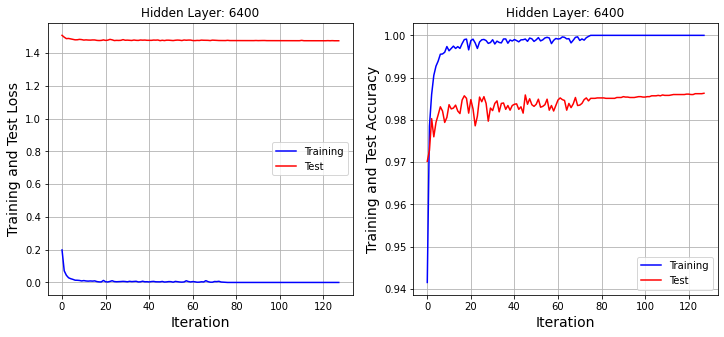

In [30]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss4, 'b', label = "Training")
ax[0].plot(range(128), test_loss4, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 6400')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc4, 'b', label = "Training")
ax[1].plot(range(128), test_acc4, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 6400')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 6400.png")

In [31]:
model = BaselineModel(784,12800,10)

train_loss4 = np.zeros(128)
test_loss4 = np.zeros(128)
train_acc4 = np.zeros(128)
test_acc4 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11045350879430771, 'running_acc': 0.9662500023841858, 'loss': 0.18183533847332, 'acc': 0.9441333413124084, 'val_loss': 1.5017858743667603, 'val_acc': 0.97079998254776}
Epoch: 1
Training Loss: 0.18183533847332
Training Accuracy: 0.9441333413124084
Test Loss: 1.5017858743667603
Test Accuracy: 0.97079998254776


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06215382739901543, 'running_acc': 0.98046875, 'loss': 0.06779300421476364, 'acc': 0.9784666895866394, 'val_loss': 1.493952751159668, 'val_acc': 0.9754999876022339}
Epoch: 2
Training Loss: 0.06779300421476364
Training Accuracy: 0.9784666895866394
Test Loss: 1.493952751159668
Test Accuracy: 0.9754999876022339


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04519890248775482, 'running_acc': 0.9834374785423279, 'loss': 0.04450158029794693, 'acc': 0.9856666922569275, 'val_loss': 1.491709589958191, 'val_acc': 0.9746999740600586}
Epoch: 3
Training Loss: 0.04450158029794693
Training Accuracy: 0.9856666922569275
Test Loss: 1.491709589958191
Test Accuracy: 0.9746999740600586


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.036927152425050735, 'running_acc': 0.9868749976158142, 'loss': 0.03220604732632637, 'acc': 0.9894166588783264, 'val_loss': 1.4849669933319092, 'val_acc': 0.9802999496459961}
Epoch: 4
Training Loss: 0.03220604732632637
Training Accuracy: 0.9894166588783264
Test Loss: 1.4849669933319092
Test Accuracy: 0.9802999496459961


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.025826603174209595, 'running_acc': 0.9918749928474426, 'loss': 0.023302679881453514, 'acc': 0.9927000403404236, 'val_loss': 1.4814634323120117, 'val_acc': 0.9822999835014343}
Epoch: 5
Training Loss: 0.023302679881453514
Training Accuracy: 0.9927000403404236
Test Loss: 1.4814634323120117
Test Accuracy: 0.9822999835014343


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.029141779989004135, 'running_acc': 0.9912499785423279, 'loss': 0.02243146486580372, 'acc': 0.992900013923645, 'val_loss': 1.4839948415756226, 'val_acc': 0.9793999791145325}
Epoch: 6
Training Loss: 0.02243146486580372
Training Accuracy: 0.992900013923645
Test Loss: 1.4839948415756226
Test Accuracy: 0.9793999791145325


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.018842309713363647, 'running_acc': 0.9939061999320984, 'loss': 0.016082076355814934, 'acc': 0.9949666857719421, 'val_loss': 1.4833629131317139, 'val_acc': 0.9790999889373779}
Epoch: 7
Training Loss: 0.016082076355814934
Training Accuracy: 0.9949666857719421
Test Loss: 1.4833629131317139
Test Accuracy: 0.9790999889373779


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.025662222877144814, 'running_acc': 0.9917187094688416, 'loss': 0.01502008643001318, 'acc': 0.9951000213623047, 'val_loss': 1.4823180437088013, 'val_acc': 0.9800999760627747}
Epoch: 8
Training Loss: 0.01502008643001318
Training Accuracy: 0.9951000213623047
Test Loss: 1.4823180437088013
Test Accuracy: 0.9800999760627747


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.014642519876360893, 'running_acc': 0.9940624833106995, 'loss': 0.013496506959199905, 'acc': 0.9956166744232178, 'val_loss': 1.481245756149292, 'val_acc': 0.9819999933242798}
Epoch: 9
Training Loss: 0.013496506959199905
Training Accuracy: 0.9956166744232178
Test Loss: 1.481245756149292
Test Accuracy: 0.9819999933242798


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011800212785601616, 'running_acc': 0.9965624809265137, 'loss': 0.009869968518614769, 'acc': 0.9970166683197021, 'val_loss': 1.481662631034851, 'val_acc': 0.9812999963760376}
Epoch: 10
Training Loss: 0.009869968518614769
Training Accuracy: 0.9970166683197021
Test Loss: 1.481662631034851
Test Accuracy: 0.9812999963760376


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009511776268482208, 'running_acc': 0.996874988079071, 'loss': 0.011968323029577732, 'acc': 0.9959999918937683, 'val_loss': 1.4771283864974976, 'val_acc': 0.9850999712944031}
Epoch: 11
Training Loss: 0.011968323029577732
Training Accuracy: 0.9959999918937683
Test Loss: 1.4771283864974976
Test Accuracy: 0.9850999712944031


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013842452317476273, 'running_acc': 0.9957812428474426, 'loss': 0.010195976123213768, 'acc': 0.9970000386238098, 'val_loss': 1.4828195571899414, 'val_acc': 0.9799000024795532}
Epoch: 12
Training Loss: 0.010195976123213768
Training Accuracy: 0.9970000386238098
Test Loss: 1.4828195571899414
Test Accuracy: 0.9799000024795532


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012843449600040913, 'running_acc': 0.9970312118530273, 'loss': 0.01106855645775795, 'acc': 0.9966333508491516, 'val_loss': 1.4791624546051025, 'val_acc': 0.9824999570846558}
Epoch: 13
Training Loss: 0.01106855645775795
Training Accuracy: 0.9966333508491516
Test Loss: 1.4791624546051025
Test Accuracy: 0.9824999570846558


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01024615578353405, 'running_acc': 0.9965624809265137, 'loss': 0.007824253290891647, 'acc': 0.9975666999816895, 'val_loss': 1.4798692464828491, 'val_acc': 0.9822999835014343}
Epoch: 14
Training Loss: 0.007824253290891647
Training Accuracy: 0.9975666999816895
Test Loss: 1.4798692464828491
Test Accuracy: 0.9822999835014343


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011549361981451511, 'running_acc': 0.9971874952316284, 'loss': 0.010837563313543797, 'acc': 0.996566653251648, 'val_loss': 1.4808740615844727, 'val_acc': 0.9802999496459961}
Epoch: 15
Training Loss: 0.010837563313543797
Training Accuracy: 0.996566653251648
Test Loss: 1.4808740615844727
Test Accuracy: 0.9802999496459961


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008117123506963253, 'running_acc': 0.9971874952316284, 'loss': 0.00597874540835619, 'acc': 0.998116672039032, 'val_loss': 1.4804000854492188, 'val_acc': 0.9806999564170837}
Epoch: 16
Training Loss: 0.00597874540835619
Training Accuracy: 0.998116672039032
Test Loss: 1.4804000854492188
Test Accuracy: 0.9806999564170837


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013108525425195694, 'running_acc': 0.9965624809265137, 'loss': 0.011525987647473812, 'acc': 0.9969666600227356, 'val_loss': 1.4781640768051147, 'val_acc': 0.9835000038146973}
Epoch: 17
Training Loss: 0.011525987647473812
Training Accuracy: 0.9969666600227356
Test Loss: 1.4781640768051147
Test Accuracy: 0.9835000038146973


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.014061758294701576, 'running_acc': 0.9962499737739563, 'loss': 0.010369731113314629, 'acc': 0.9970999956130981, 'val_loss': 1.4788724184036255, 'val_acc': 0.9833999872207642}
Epoch: 18
Training Loss: 0.010369731113314629
Training Accuracy: 0.9970999956130981
Test Loss: 1.4788724184036255
Test Accuracy: 0.9833999872207642


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011292096227407455, 'running_acc': 0.996874988079071, 'loss': 0.005863286554813385, 'acc': 0.9981666803359985, 'val_loss': 1.480667233467102, 'val_acc': 0.98089998960495}
Epoch: 19
Training Loss: 0.005863286554813385
Training Accuracy: 0.9981666803359985
Test Loss: 1.480667233467102
Test Accuracy: 0.98089998960495


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007290102541446686, 'running_acc': 0.9973437190055847, 'loss': 0.00867055356502533, 'acc': 0.9974166750907898, 'val_loss': 1.478826642036438, 'val_acc': 0.9827999472618103}
Epoch: 20
Training Loss: 0.00867055356502533
Training Accuracy: 0.9974166750907898
Test Loss: 1.478826642036438
Test Accuracy: 0.9827999472618103


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005038073752075434, 'running_acc': 0.9982812404632568, 'loss': 0.00794937089085579, 'acc': 0.997700035572052, 'val_loss': 1.4779402017593384, 'val_acc': 0.9837999939918518}
Epoch: 21
Training Loss: 0.00794937089085579
Training Accuracy: 0.997700035572052
Test Loss: 1.4779402017593384
Test Accuracy: 0.9837999939918518


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002918517915531993, 'running_acc': 0.9995312094688416, 'loss': 0.007607939653098583, 'acc': 0.9980500340461731, 'val_loss': 1.4781301021575928, 'val_acc': 0.9830999970436096}
Epoch: 22
Training Loss: 0.007607939653098583
Training Accuracy: 0.9980500340461731
Test Loss: 1.4781301021575928
Test Accuracy: 0.9830999970436096


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008082140237092972, 'running_acc': 0.9978124499320984, 'loss': 0.0064677949994802475, 'acc': 0.9982500076293945, 'val_loss': 1.4783306121826172, 'val_acc': 0.9830999970436096}
Epoch: 23
Training Loss: 0.0064677949994802475
Training Accuracy: 0.9982500076293945
Test Loss: 1.4783306121826172
Test Accuracy: 0.9830999970436096


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009626409970223904, 'running_acc': 0.9975000023841858, 'loss': 0.006527643650770187, 'acc': 0.998199999332428, 'val_loss': 1.478742003440857, 'val_acc': 0.9824000000953674}
Epoch: 24
Training Loss: 0.006527643650770187
Training Accuracy: 0.998199999332428
Test Loss: 1.478742003440857
Test Accuracy: 0.9824000000953674


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008652954362332821, 'running_acc': 0.9981249570846558, 'loss': 0.007987270131707191, 'acc': 0.998116672039032, 'val_loss': 1.478265643119812, 'val_acc': 0.9830999970436096}
Epoch: 25
Training Loss: 0.007987270131707191
Training Accuracy: 0.998116672039032
Test Loss: 1.478265643119812
Test Accuracy: 0.9830999970436096


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005363757722079754, 'running_acc': 0.9984374642372131, 'loss': 0.00629699369892478, 'acc': 0.9982666969299316, 'val_loss': 1.4838659763336182, 'val_acc': 0.9783999919891357}
Epoch: 26
Training Loss: 0.00629699369892478
Training Accuracy: 0.9982666969299316
Test Loss: 1.4838659763336182
Test Accuracy: 0.9783999919891357


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009184534661471844, 'running_acc': 0.996874988079071, 'loss': 0.007559298072010279, 'acc': 0.9978333711624146, 'val_loss': 1.478995680809021, 'val_acc': 0.9821999669075012}
Epoch: 27
Training Loss: 0.007559298072010279
Training Accuracy: 0.9978333711624146
Test Loss: 1.478995680809021
Test Accuracy: 0.9821999669075012


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005038059316575527, 'running_acc': 0.9985937476158142, 'loss': 0.00616870541125536, 'acc': 0.9981666803359985, 'val_loss': 1.4786196947097778, 'val_acc': 0.9824000000953674}
Epoch: 28
Training Loss: 0.00616870541125536
Training Accuracy: 0.9981666803359985
Test Loss: 1.4786196947097778
Test Accuracy: 0.9824000000953674


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003063071984797716, 'running_acc': 0.9989062547683716, 'loss': 0.0035404874943196774, 'acc': 0.9989166855812073, 'val_loss': 1.4792251586914062, 'val_acc': 0.9824000000953674}
Epoch: 29
Training Loss: 0.0035404874943196774
Training Accuracy: 0.9989166855812073
Test Loss: 1.4792251586914062
Test Accuracy: 0.9824000000953674


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03373768553137779, 'running_acc': 0.9950000047683716, 'loss': 0.009354363195598125, 'acc': 0.9980666637420654, 'val_loss': 1.481111764907837, 'val_acc': 0.9804999828338623}
Epoch: 30
Training Loss: 0.009354363195598125
Training Accuracy: 0.9980666637420654
Test Loss: 1.481111764907837
Test Accuracy: 0.9804999828338623


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008358810096979141, 'running_acc': 0.9985937476158142, 'loss': 0.009059551171958447, 'acc': 0.99795001745224, 'val_loss': 1.478607177734375, 'val_acc': 0.9839999675750732}
Epoch: 31
Training Loss: 0.009059551171958447
Training Accuracy: 0.99795001745224
Test Loss: 1.478607177734375
Test Accuracy: 0.9839999675750732


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004542007576674223, 'running_acc': 0.9989062547683716, 'loss': 0.008400218561291695, 'acc': 0.9980833530426025, 'val_loss': 1.477866291999817, 'val_acc': 0.9836999773979187}
Epoch: 32
Training Loss: 0.008400218561291695
Training Accuracy: 0.9980833530426025
Test Loss: 1.477866291999817
Test Accuracy: 0.9836999773979187


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001381237292662263, 'running_acc': 0.9996874928474426, 'loss': 0.0007160849054343998, 'acc': 0.9997667074203491, 'val_loss': 1.4758775234222412, 'val_acc': 0.9858999848365784}
Epoch: 33
Training Loss: 0.0007160849054343998
Training Accuracy: 0.9997667074203491
Test Loss: 1.4758775234222412
Test Accuracy: 0.9858999848365784


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007685696706175804, 'running_acc': 0.9978124499320984, 'loss': 0.003866499289870262, 'acc': 0.9988999962806702, 'val_loss': 1.4784555435180664, 'val_acc': 0.9825999736785889}
Epoch: 34
Training Loss: 0.003866499289870262
Training Accuracy: 0.9988999962806702
Test Loss: 1.4784555435180664
Test Accuracy: 0.9825999736785889


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0046741231344640255, 'running_acc': 0.9985937476158142, 'loss': 0.007444324903190136, 'acc': 0.9984166622161865, 'val_loss': 1.4776850938796997, 'val_acc': 0.983199954032898}
Epoch: 35
Training Loss: 0.007444324903190136
Training Accuracy: 0.9984166622161865
Test Loss: 1.4776850938796997
Test Accuracy: 0.983199954032898


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006702397484332323, 'running_acc': 0.9985937476158142, 'loss': 0.00808301568031311, 'acc': 0.9980500340461731, 'val_loss': 1.478178858757019, 'val_acc': 0.9836999773979187}
Epoch: 36
Training Loss: 0.00808301568031311
Training Accuracy: 0.9980500340461731
Test Loss: 1.478178858757019
Test Accuracy: 0.9836999773979187


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009152906946837902, 'running_acc': 0.9989062547683716, 'loss': 0.010043192654848099, 'acc': 0.9979166984558105, 'val_loss': 1.4761265516281128, 'val_acc': 0.9850999712944031}
Epoch: 37
Training Loss: 0.010043192654848099
Training Accuracy: 0.9979166984558105
Test Loss: 1.4761265516281128
Test Accuracy: 0.9850999712944031


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005524963140487671, 'running_acc': 0.9985937476158142, 'loss': 0.005220511462539434, 'acc': 0.9987166523933411, 'val_loss': 1.478484034538269, 'val_acc': 0.9827999472618103}
Epoch: 38
Training Loss: 0.005220511462539434
Training Accuracy: 0.9987166523933411
Test Loss: 1.478484034538269
Test Accuracy: 0.9827999472618103


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0064555504359304905, 'running_acc': 0.9982812404632568, 'loss': 0.005930722691118717, 'acc': 0.9985833168029785, 'val_loss': 1.4764622449874878, 'val_acc': 0.9853999614715576}
Epoch: 39
Training Loss: 0.005930722691118717
Training Accuracy: 0.9985833168029785
Test Loss: 1.4764622449874878
Test Accuracy: 0.9853999614715576


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007991820573806763, 'running_acc': 0.9979687333106995, 'loss': 0.006896483711898327, 'acc': 0.9984500408172607, 'val_loss': 1.4761344194412231, 'val_acc': 0.98499995470047}
Epoch: 40
Training Loss: 0.006896483711898327
Training Accuracy: 0.9984500408172607
Test Loss: 1.4761344194412231
Test Accuracy: 0.98499995470047


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008742304518818855, 'running_acc': 0.9981249570846558, 'loss': 0.003615243826061487, 'acc': 0.9989166855812073, 'val_loss': 1.4771381616592407, 'val_acc': 0.9839999675750732}
Epoch: 41
Training Loss: 0.003615243826061487
Training Accuracy: 0.9989166855812073
Test Loss: 1.4771381616592407
Test Accuracy: 0.9839999675750732


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00595407048240304, 'running_acc': 0.9985937476158142, 'loss': 0.006845211610198021, 'acc': 0.9985666871070862, 'val_loss': 1.4803369045257568, 'val_acc': 0.9801999926567078}
Epoch: 42
Training Loss: 0.006845211610198021
Training Accuracy: 0.9985666871070862
Test Loss: 1.4803369045257568
Test Accuracy: 0.9801999926567078


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008715295232832432, 'running_acc': 0.9979687333106995, 'loss': 0.009813244454562664, 'acc': 0.9981833696365356, 'val_loss': 1.4777472019195557, 'val_acc': 0.9836999773979187}
Epoch: 43
Training Loss: 0.009813244454562664
Training Accuracy: 0.9981833696365356
Test Loss: 1.4777472019195557
Test Accuracy: 0.9836999773979187


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00239763711579144, 'running_acc': 0.9996874928474426, 'loss': 0.0032035917975008488, 'acc': 0.9992499947547913, 'val_loss': 1.4775898456573486, 'val_acc': 0.983299970626831}
Epoch: 44
Training Loss: 0.0032035917975008488
Training Accuracy: 0.9992499947547913
Test Loss: 1.4775898456573486
Test Accuracy: 0.983299970626831


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007975800894200802, 'running_acc': 0.9984374642372131, 'loss': 0.0077610439620912075, 'acc': 0.9988833665847778, 'val_loss': 1.477813482284546, 'val_acc': 0.9827999472618103}
Epoch: 45
Training Loss: 0.0077610439620912075
Training Accuracy: 0.9988833665847778
Test Loss: 1.477813482284546
Test Accuracy: 0.9827999472618103


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0032709368970245123, 'running_acc': 0.9993749856948853, 'loss': 0.0039027133025228977, 'acc': 0.9994333386421204, 'val_loss': 1.4752777814865112, 'val_acc': 0.9853000044822693}
Epoch: 46
Training Loss: 0.0039027133025228977
Training Accuracy: 0.9994333386421204
Test Loss: 1.4752777814865112
Test Accuracy: 0.9853000044822693


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0036079545971006155, 'running_acc': 0.9989062547683716, 'loss': 0.008538851514458656, 'acc': 0.9986333250999451, 'val_loss': 1.4784507751464844, 'val_acc': 0.9824999570846558}
Epoch: 47
Training Loss: 0.008538851514458656
Training Accuracy: 0.9986333250999451
Test Loss: 1.4784507751464844
Test Accuracy: 0.9824999570846558


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008931204676628113, 'running_acc': 0.9982812404632568, 'loss': 0.006265660747885704, 'acc': 0.9986333250999451, 'val_loss': 1.477007508277893, 'val_acc': 0.9836999773979187}
Epoch: 48
Training Loss: 0.006265660747885704
Training Accuracy: 0.9986333250999451
Test Loss: 1.477007508277893
Test Accuracy: 0.9836999773979187


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002777356654405594, 'running_acc': 0.9992187023162842, 'loss': 0.004517159424722195, 'acc': 0.9989833235740662, 'val_loss': 1.4786417484283447, 'val_acc': 0.9819999933242798}
Epoch: 49
Training Loss: 0.004517159424722195
Training Accuracy: 0.9989833235740662
Test Loss: 1.4786417484283447
Test Accuracy: 0.9819999933242798


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01086374744772911, 'running_acc': 0.9978124499320984, 'loss': 0.006067129783332348, 'acc': 0.9988499879837036, 'val_loss': 1.478380560874939, 'val_acc': 0.9827999472618103}
Epoch: 50
Training Loss: 0.006067129783332348
Training Accuracy: 0.9988499879837036
Test Loss: 1.478380560874939
Test Accuracy: 0.9827999472618103


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0022650870960205793, 'running_acc': 0.9995312094688416, 'loss': 0.0075756860896945, 'acc': 0.9987333416938782, 'val_loss': 1.477743148803711, 'val_acc': 0.983299970626831}
Epoch: 51
Training Loss: 0.0075756860896945
Training Accuracy: 0.9987333416938782
Test Loss: 1.477743148803711
Test Accuracy: 0.983299970626831


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0033905133605003357, 'running_acc': 0.9992187023162842, 'loss': 0.004119388293474913, 'acc': 0.9990500211715698, 'val_loss': 1.4769935607910156, 'val_acc': 0.9835000038146973}
Epoch: 52
Training Loss: 0.004119388293474913
Training Accuracy: 0.9990500211715698
Test Loss: 1.4769935607910156
Test Accuracy: 0.9835000038146973


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0010899851331487298, 'running_acc': 0.9995312094688416, 'loss': 0.004467926453799009, 'acc': 0.9990666508674622, 'val_loss': 1.4759576320648193, 'val_acc': 0.9851999878883362}
Epoch: 53
Training Loss: 0.004467926453799009
Training Accuracy: 0.9990666508674622
Test Loss: 1.4759576320648193
Test Accuracy: 0.9851999878883362


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007026402745395899, 'running_acc': 0.9982812404632568, 'loss': 0.0064614261500537395, 'acc': 0.9984833598136902, 'val_loss': 1.4801948070526123, 'val_acc': 0.9825999736785889}
Epoch: 54
Training Loss: 0.0064614261500537395
Training Accuracy: 0.9984833598136902
Test Loss: 1.4801948070526123
Test Accuracy: 0.9825999736785889


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00558969471603632, 'running_acc': 0.9993749856948853, 'loss': 0.007219159975647926, 'acc': 0.9989166855812073, 'val_loss': 1.476394534111023, 'val_acc': 0.9845999479293823}
Epoch: 55
Training Loss: 0.007219159975647926
Training Accuracy: 0.9989166855812073
Test Loss: 1.476394534111023
Test Accuracy: 0.9845999479293823


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0019503689836710691, 'running_acc': 0.9995312094688416, 'loss': 0.004879658576101065, 'acc': 0.9991999864578247, 'val_loss': 1.4757003784179688, 'val_acc': 0.9855999946594238}
Epoch: 56
Training Loss: 0.004879658576101065
Training Accuracy: 0.9991999864578247
Test Loss: 1.4757003784179688
Test Accuracy: 0.9855999946594238


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0001280432043131441, 'running_acc': 1.0, 'loss': 0.003668377874419093, 'acc': 0.9992499947547913, 'val_loss': 1.4744793176651, 'val_acc': 0.9871999621391296}
Epoch: 57
Training Loss: 0.003668377874419093
Training Accuracy: 0.9992499947547913
Test Loss: 1.4744793176651
Test Accuracy: 0.9871999621391296


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011805408634245396, 'running_acc': 0.9985937476158142, 'loss': 0.00470502907410264, 'acc': 0.9991333484649658, 'val_loss': 1.4772615432739258, 'val_acc': 0.9839999675750732}
Epoch: 58
Training Loss: 0.00470502907410264
Training Accuracy: 0.9991333484649658
Test Loss: 1.4772615432739258
Test Accuracy: 0.9839999675750732


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006121719256043434, 'running_acc': 0.9989062547683716, 'loss': 0.009029465727508068, 'acc': 0.9983500242233276, 'val_loss': 1.4786620140075684, 'val_acc': 0.9820999503135681}
Epoch: 59
Training Loss: 0.009029465727508068
Training Accuracy: 0.9983500242233276
Test Loss: 1.4786620140075684
Test Accuracy: 0.9820999503135681


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005866170860826969, 'running_acc': 0.9984374642372131, 'loss': 0.0036680232733488083, 'acc': 0.9992166757583618, 'val_loss': 1.4784566164016724, 'val_acc': 0.9835999608039856}
Epoch: 60
Training Loss: 0.0036680232733488083
Training Accuracy: 0.9992166757583618
Test Loss: 1.4784566164016724
Test Accuracy: 0.9835999608039856


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010543854907155037, 'running_acc': 0.9979687333106995, 'loss': 0.00481170229613781, 'acc': 0.9991166591644287, 'val_loss': 1.4782443046569824, 'val_acc': 0.9827999472618103}
Epoch: 61
Training Loss: 0.00481170229613781
Training Accuracy: 0.9991166591644287
Test Loss: 1.4782443046569824
Test Accuracy: 0.9827999472618103


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006289325654506683, 'running_acc': 0.9987499713897705, 'loss': 0.006392276845872402, 'acc': 0.9988499879837036, 'val_loss': 1.4772838354110718, 'val_acc': 0.9835000038146973}
Epoch: 62
Training Loss: 0.006392276845872402
Training Accuracy: 0.9988499879837036
Test Loss: 1.4772838354110718
Test Accuracy: 0.9835000038146973


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0042819674126803875, 'running_acc': 0.9989062547683716, 'loss': 0.0065016173757612705, 'acc': 0.9988166689872742, 'val_loss': 1.4777292013168335, 'val_acc': 0.9833999872207642}
Epoch: 63
Training Loss: 0.0065016173757612705
Training Accuracy: 0.9988166689872742
Test Loss: 1.4777292013168335
Test Accuracy: 0.9833999872207642


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008772275410592556, 'running_acc': 0.9985937476158142, 'loss': 0.0056785698980093, 'acc': 0.9991999864578247, 'val_loss': 1.4758126735687256, 'val_acc': 0.98499995470047}
Epoch: 64
Training Loss: 0.0056785698980093
Training Accuracy: 0.9991999864578247
Test Loss: 1.4758126735687256
Test Accuracy: 0.98499995470047


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00764057319611311, 'running_acc': 0.9990624785423279, 'loss': 0.004715657792985439, 'acc': 0.9992166757583618, 'val_loss': 1.478078842163086, 'val_acc': 0.9828999638557434}
Epoch: 65
Training Loss: 0.004715657792985439
Training Accuracy: 0.9992166757583618
Test Loss: 1.478078842163086
Test Accuracy: 0.9828999638557434


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002185316290706396, 'running_acc': 0.9996874928474426, 'loss': 0.0030916330870240927, 'acc': 0.9994666576385498, 'val_loss': 1.4755326509475708, 'val_acc': 0.986299991607666}
Epoch: 66
Training Loss: 0.0030916330870240927
Training Accuracy: 0.9994666576385498
Test Loss: 1.4755326509475708
Test Accuracy: 0.986299991607666


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011473695747554302, 'running_acc': 0.9982812404632568, 'loss': 0.0050138309597969055, 'acc': 0.9991000294685364, 'val_loss': 1.482775330543518, 'val_acc': 0.9795999526977539}
Epoch: 67
Training Loss: 0.0050138309597969055
Training Accuracy: 0.9991000294685364
Test Loss: 1.482775330543518
Test Accuracy: 0.9795999526977539


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011647255159914494, 'running_acc': 0.9984374642372131, 'loss': 0.008133803494274616, 'acc': 0.9986000061035156, 'val_loss': 1.4785537719726562, 'val_acc': 0.9827999472618103}
Epoch: 68
Training Loss: 0.008133803494274616
Training Accuracy: 0.9986000061035156
Test Loss: 1.4785537719726562
Test Accuracy: 0.9827999472618103


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004808585159480572, 'running_acc': 0.9982812404632568, 'loss': 0.005134216044098139, 'acc': 0.9988999962806702, 'val_loss': 1.4770232439041138, 'val_acc': 0.9837999939918518}
Epoch: 69
Training Loss: 0.005134216044098139
Training Accuracy: 0.9988999962806702
Test Loss: 1.4770232439041138
Test Accuracy: 0.9837999939918518


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00445007486268878, 'running_acc': 0.9995312094688416, 'loss': 0.004299820866435766, 'acc': 0.9994000196456909, 'val_loss': 1.4759916067123413, 'val_acc': 0.9850999712944031}
Epoch: 70
Training Loss: 0.004299820866435766
Training Accuracy: 0.9994000196456909
Test Loss: 1.4759916067123413
Test Accuracy: 0.9850999712944031


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0057205576449632645, 'running_acc': 0.9990624785423279, 'loss': 0.004778699018061161, 'acc': 0.9993166923522949, 'val_loss': 1.4772961139678955, 'val_acc': 0.9835999608039856}
Epoch: 71
Training Loss: 0.004778699018061161
Training Accuracy: 0.9993166923522949
Test Loss: 1.4772961139678955
Test Accuracy: 0.9835999608039856


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008625906892120838, 'running_acc': 0.9984374642372131, 'loss': 0.0071218786761164665, 'acc': 0.9989166855812073, 'val_loss': 1.4778525829315186, 'val_acc': 0.9829999804496765}
Epoch: 72
Training Loss: 0.0071218786761164665
Training Accuracy: 0.9989166855812073
Test Loss: 1.4778525829315186
Test Accuracy: 0.9829999804496765


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.375349327456206e-05, 'running_acc': 1.0, 'loss': 0.004924273584038019, 'acc': 0.9991999864578247, 'val_loss': 1.4783596992492676, 'val_acc': 0.9824999570846558}
Epoch: 73
Training Loss: 0.004924273584038019
Training Accuracy: 0.9991999864578247
Test Loss: 1.4783596992492676
Test Accuracy: 0.9824999570846558


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0034667362924665213, 'running_acc': 0.9992187023162842, 'loss': 0.001842714729718864, 'acc': 0.9995999932289124, 'val_loss': 1.4801589250564575, 'val_acc': 0.9805999994277954}
Epoch: 74
Training Loss: 0.001842714729718864
Training Accuracy: 0.9995999932289124
Test Loss: 1.4801589250564575
Test Accuracy: 0.9805999994277954


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006171927787363529, 'running_acc': 0.9995312094688416, 'loss': 0.007424566894769669, 'acc': 0.9988999962806702, 'val_loss': 1.47744882106781, 'val_acc': 0.983299970626831}
Epoch: 75
Training Loss: 0.007424566894769669
Training Accuracy: 0.9988999962806702
Test Loss: 1.47744882106781
Test Accuracy: 0.983299970626831


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006207011174410582, 'running_acc': 0.9987499713897705, 'loss': 0.005714775994420052, 'acc': 0.9991333484649658, 'val_loss': 1.476757526397705, 'val_acc': 0.9842999577522278}
Epoch: 76
Training Loss: 0.005714775994420052
Training Accuracy: 0.9991333484649658
Test Loss: 1.476757526397705
Test Accuracy: 0.9842999577522278


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0001493759627919644, 'running_acc': 1.0, 'loss': 0.0022848681546747684, 'acc': 0.9996333718299866, 'val_loss': 1.4769922494888306, 'val_acc': 0.9836999773979187}
Epoch: 77
Training Loss: 0.0022848681546747684
Training Accuracy: 0.9996333718299866
Test Loss: 1.4769922494888306
Test Accuracy: 0.9836999773979187


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001836159615777433, 'running_acc': 0.9998437166213989, 'loss': 0.0007157365325838327, 'acc': 0.9998666644096375, 'val_loss': 1.4765046834945679, 'val_acc': 0.9842999577522278}
Epoch: 78
Training Loss: 0.0007157365325838327
Training Accuracy: 0.9998666644096375
Test Loss: 1.4765046834945679
Test Accuracy: 0.9842999577522278


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007341795600950718, 'running_acc': 0.9981249570846558, 'loss': 0.002669728361070156, 'acc': 0.9995166659355164, 'val_loss': 1.478672742843628, 'val_acc': 0.9830999970436096}
Epoch: 79
Training Loss: 0.002669728361070156
Training Accuracy: 0.9995166659355164
Test Loss: 1.478672742843628
Test Accuracy: 0.9830999970436096


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010798531584441662, 'running_acc': 0.9978124499320984, 'loss': 0.009677893482148647, 'acc': 0.9985166788101196, 'val_loss': 1.4795323610305786, 'val_acc': 0.9810999631881714}
Epoch: 80
Training Loss: 0.009677893482148647
Training Accuracy: 0.9985166788101196
Test Loss: 1.4795323610305786
Test Accuracy: 0.9810999631881714


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004034864716231823, 'running_acc': 0.9993749856948853, 'loss': 0.00767079321667552, 'acc': 0.9988666772842407, 'val_loss': 1.4766956567764282, 'val_acc': 0.9840999841690063}
Epoch: 81
Training Loss: 0.00767079321667552
Training Accuracy: 0.9988666772842407
Test Loss: 1.4766956567764282
Test Accuracy: 0.9840999841690063


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00516072753816843, 'running_acc': 0.9989062547683716, 'loss': 0.006711614318192005, 'acc': 0.9991500377655029, 'val_loss': 1.4764705896377563, 'val_acc': 0.9842999577522278}
Epoch: 82
Training Loss: 0.006711614318192005
Training Accuracy: 0.9991500377655029
Test Loss: 1.4764705896377563
Test Accuracy: 0.9842999577522278


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001299165771342814, 'running_acc': 0.9996874928474426, 'loss': 0.006523200776427984, 'acc': 0.9994000196456909, 'val_loss': 1.4783152341842651, 'val_acc': 0.9835000038146973}
Epoch: 83
Training Loss: 0.006523200776427984
Training Accuracy: 0.9994000196456909
Test Loss: 1.4783152341842651
Test Accuracy: 0.9835000038146973


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010500098578631878, 'running_acc': 0.9992187023162842, 'loss': 0.0038284887559711933, 'acc': 0.9995166659355164, 'val_loss': 1.479428768157959, 'val_acc': 0.9825999736785889}
Epoch: 84
Training Loss: 0.0038284887559711933
Training Accuracy: 0.9995166659355164
Test Loss: 1.479428768157959
Test Accuracy: 0.9825999736785889


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001700491877272725, 'running_acc': 0.9995312094688416, 'loss': 0.004309020470827818, 'acc': 0.9992333650588989, 'val_loss': 1.4770121574401855, 'val_acc': 0.9836999773979187}
Epoch: 85
Training Loss: 0.004309020470827818
Training Accuracy: 0.9992333650588989
Test Loss: 1.4770121574401855
Test Accuracy: 0.9836999773979187


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0004643033316824585, 'running_acc': 0.9998437166213989, 'loss': 0.004186403471976519, 'acc': 0.9992666840553284, 'val_loss': 1.474908471107483, 'val_acc': 0.9860000014305115}
Epoch: 86
Training Loss: 0.004186403471976519
Training Accuracy: 0.9992666840553284
Test Loss: 1.474908471107483
Test Accuracy: 0.9860000014305115


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010324341244995594, 'running_acc': 0.9985937476158142, 'loss': 0.006053969729691744, 'acc': 0.9991833567619324, 'val_loss': 1.4799913167953491, 'val_acc': 0.9817000031471252}
Epoch: 87
Training Loss: 0.006053969729691744
Training Accuracy: 0.9991833567619324
Test Loss: 1.4799913167953491
Test Accuracy: 0.9817000031471252


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008391207084059715, 'running_acc': 0.9992187023162842, 'loss': 0.009395034052431583, 'acc': 0.9986667037010193, 'val_loss': 1.4783177375793457, 'val_acc': 0.983199954032898}
Epoch: 88
Training Loss: 0.009395034052431583
Training Accuracy: 0.9986667037010193
Test Loss: 1.4783177375793457
Test Accuracy: 0.983199954032898


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0022339627612382174, 'running_acc': 0.9998437166213989, 'loss': 0.0038502959068864584, 'acc': 0.9994666576385498, 'val_loss': 1.4773904085159302, 'val_acc': 0.9835999608039856}
Epoch: 89
Training Loss: 0.0038502959068864584
Training Accuracy: 0.9994666576385498
Test Loss: 1.4773904085159302
Test Accuracy: 0.9835999608039856


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00632609473541379, 'running_acc': 0.9993749856948853, 'loss': 0.006440138444304466, 'acc': 0.9990333318710327, 'val_loss': 1.4769361019134521, 'val_acc': 0.9836999773979187}
Epoch: 90
Training Loss: 0.006440138444304466
Training Accuracy: 0.9990333318710327
Test Loss: 1.4769361019134521
Test Accuracy: 0.9836999773979187


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006078505888581276, 'running_acc': 0.9993749856948853, 'loss': 0.004778142087161541, 'acc': 0.9993500113487244, 'val_loss': 1.476983666419983, 'val_acc': 0.9846999645233154}
Epoch: 91
Training Loss: 0.004778142087161541
Training Accuracy: 0.9993500113487244
Test Loss: 1.476983666419983
Test Accuracy: 0.9846999645233154


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.282670837099431e-05, 'running_acc': 1.0, 'loss': 0.001438321778550744, 'acc': 0.9997333288192749, 'val_loss': 1.4752435684204102, 'val_acc': 0.9857999682426453}
Epoch: 92
Training Loss: 0.001438321778550744
Training Accuracy: 0.9997333288192749
Test Loss: 1.4752435684204102
Test Accuracy: 0.9857999682426453


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0011090785264968872, 'running_acc': 0.9996874928474426, 'loss': 0.0018735452322289348, 'acc': 0.999666690826416, 'val_loss': 1.4772557020187378, 'val_acc': 0.9850999712944031}
Epoch: 93
Training Loss: 0.0018735452322289348
Training Accuracy: 0.999666690826416
Test Loss: 1.4772557020187378
Test Accuracy: 0.9850999712944031


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0012019793502986431, 'running_acc': 0.9995312094688416, 'loss': 0.00029176598764024675, 'acc': 0.9998999834060669, 'val_loss': 1.4755456447601318, 'val_acc': 0.9850999712944031}
Epoch: 94
Training Loss: 0.00029176598764024675
Training Accuracy: 0.9998999834060669
Test Loss: 1.4755456447601318
Test Accuracy: 0.9850999712944031


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0005906454171054065, 'running_acc': 0.9998437166213989, 'loss': 0.0014780594501644373, 'acc': 0.999833345413208, 'val_loss': 1.4748926162719727, 'val_acc': 0.9860999584197998}
Epoch: 95
Training Loss: 0.0014780594501644373
Training Accuracy: 0.999833345413208
Test Loss: 1.4748926162719727
Test Accuracy: 0.9860999584197998


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009764243848621845, 'running_acc': 0.9985937476158142, 'loss': 0.004099688492715359, 'acc': 0.9993000030517578, 'val_loss': 1.47567880153656, 'val_acc': 0.9855999946594238}
Epoch: 96
Training Loss: 0.004099688492715359
Training Accuracy: 0.9993000030517578
Test Loss: 1.47567880153656
Test Accuracy: 0.9855999946594238


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012398769147694111, 'running_acc': 0.9976562261581421, 'loss': 0.013893034309148788, 'acc': 0.99836665391922, 'val_loss': 1.477628469467163, 'val_acc': 0.983299970626831}
Epoch: 97
Training Loss: 0.013893034309148788
Training Accuracy: 0.99836665391922
Test Loss: 1.477628469467163
Test Accuracy: 0.983299970626831


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006932847201824188, 'running_acc': 0.9992187023162842, 'loss': 0.007216936443001032, 'acc': 0.9989833235740662, 'val_loss': 1.4776917695999146, 'val_acc': 0.9830999970436096}
Epoch: 98
Training Loss: 0.007216936443001032
Training Accuracy: 0.9989833235740662
Test Loss: 1.4776917695999146
Test Accuracy: 0.9830999970436096


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003886968595907092, 'running_acc': 0.9987499713897705, 'loss': 0.005250841844826937, 'acc': 0.9991833567619324, 'val_loss': 1.478605031967163, 'val_acc': 0.9827999472618103}
Epoch: 99
Training Loss: 0.005250841844826937
Training Accuracy: 0.9991833567619324
Test Loss: 1.478605031967163
Test Accuracy: 0.9827999472618103


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001398009480908513, 'running_acc': 0.9996874928474426, 'loss': 0.003514155512675643, 'acc': 0.9993333220481873, 'val_loss': 1.4764659404754639, 'val_acc': 0.984499990940094}
Epoch: 100
Training Loss: 0.003514155512675643
Training Accuracy: 0.9993333220481873
Test Loss: 1.4764659404754639
Test Accuracy: 0.984499990940094


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0018105019116774201, 'running_acc': 0.9998437166213989, 'loss': 0.003348421538248658, 'acc': 0.9994500279426575, 'val_loss': 1.4771991968154907, 'val_acc': 0.9843999743461609}
Epoch: 101
Training Loss: 0.003348421538248658
Training Accuracy: 0.9994500279426575
Test Loss: 1.4771991968154907
Test Accuracy: 0.9843999743461609


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010258358903229237, 'running_acc': 0.9987499713897705, 'loss': 0.0022753116209059954, 'acc': 0.9996500015258789, 'val_loss': 1.47676420211792, 'val_acc': 0.9843999743461609}
Epoch: 102
Training Loss: 0.0022753116209059954
Training Accuracy: 0.9996500015258789
Test Loss: 1.47676420211792
Test Accuracy: 0.9843999743461609


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00706385588273406, 'running_acc': 0.9989062547683716, 'loss': 0.007850340567529202, 'acc': 0.9988833665847778, 'val_loss': 1.4787667989730835, 'val_acc': 0.9828999638557434}
Epoch: 103
Training Loss: 0.007850340567529202
Training Accuracy: 0.9988833665847778
Test Loss: 1.4787667989730835
Test Accuracy: 0.9828999638557434


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003537686774507165, 'running_acc': 0.9989062547683716, 'loss': 0.00410425802692771, 'acc': 0.9993000030517578, 'val_loss': 1.4771040678024292, 'val_acc': 0.9835999608039856}
Epoch: 104
Training Loss: 0.00410425802692771
Training Accuracy: 0.9993000030517578
Test Loss: 1.4771040678024292
Test Accuracy: 0.9835999608039856


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003952586092054844, 'running_acc': 0.9993749856948853, 'loss': 0.005975367035716772, 'acc': 0.9991500377655029, 'val_loss': 1.4756344556808472, 'val_acc': 0.9853000044822693}
Epoch: 105
Training Loss: 0.005975367035716772
Training Accuracy: 0.9991500377655029
Test Loss: 1.4756344556808472
Test Accuracy: 0.9853000044822693


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.2136635379865766e-05, 'running_acc': 1.0, 'loss': 0.002643351210281253, 'acc': 0.9996166825294495, 'val_loss': 1.4758193492889404, 'val_acc': 0.9853999614715576}
Epoch: 106
Training Loss: 0.002643351210281253
Training Accuracy: 0.9996166825294495
Test Loss: 1.4758193492889404
Test Accuracy: 0.9853999614715576


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009136774577200413, 'running_acc': 0.9993749856948853, 'loss': 0.003979697823524475, 'acc': 0.9996833205223083, 'val_loss': 1.4788323640823364, 'val_acc': 0.9828999638557434}
Epoch: 107
Training Loss: 0.003979697823524475
Training Accuracy: 0.9996833205223083
Test Loss: 1.4788323640823364
Test Accuracy: 0.9828999638557434


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007036226335912943, 'running_acc': 0.9992187023162842, 'loss': 0.004872632212936878, 'acc': 0.9993500113487244, 'val_loss': 1.4775186777114868, 'val_acc': 0.9830999970436096}
Epoch: 108
Training Loss: 0.004872632212936878
Training Accuracy: 0.9993500113487244
Test Loss: 1.4775186777114868
Test Accuracy: 0.9830999970436096


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0016135228797793388, 'running_acc': 0.9996874928474426, 'loss': 0.00535503588616848, 'acc': 0.9993000030517578, 'val_loss': 1.4760825634002686, 'val_acc': 0.9845999479293823}
Epoch: 109
Training Loss: 0.00535503588616848
Training Accuracy: 0.9993000030517578
Test Loss: 1.4760825634002686
Test Accuracy: 0.9845999479293823


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.000948430853895843, 'running_acc': 0.9995312094688416, 'loss': 0.0025458126328885555, 'acc': 0.9995499849319458, 'val_loss': 1.4770971536636353, 'val_acc': 0.9836999773979187}
Epoch: 110
Training Loss: 0.0025458126328885555
Training Accuracy: 0.9995499849319458
Test Loss: 1.4770971536636353
Test Accuracy: 0.9836999773979187


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00608882587403059, 'running_acc': 0.9993749856948853, 'loss': 0.005023914389312267, 'acc': 0.9992333650588989, 'val_loss': 1.477410078048706, 'val_acc': 0.9840999841690063}
Epoch: 111
Training Loss: 0.005023914389312267
Training Accuracy: 0.9992333650588989
Test Loss: 1.477410078048706
Test Accuracy: 0.9840999841690063


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009518126025795937, 'running_acc': 0.9992187023162842, 'loss': 0.007256537210196257, 'acc': 0.9992166757583618, 'val_loss': 1.4765822887420654, 'val_acc': 0.9845999479293823}
Epoch: 112
Training Loss: 0.007256537210196257
Training Accuracy: 0.9992166757583618
Test Loss: 1.4765822887420654
Test Accuracy: 0.9845999479293823


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.305532588157803e-05, 'running_acc': 1.0, 'loss': 0.003021899377927184, 'acc': 0.9995999932289124, 'val_loss': 1.478285312652588, 'val_acc': 0.9839999675750732}
Epoch: 113
Training Loss: 0.003021899377927184
Training Accuracy: 0.9995999932289124
Test Loss: 1.478285312652588
Test Accuracy: 0.9839999675750732


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00861368142068386, 'running_acc': 0.9995312094688416, 'loss': 0.0019130592700093985, 'acc': 0.9997333288192749, 'val_loss': 1.4773588180541992, 'val_acc': 0.9840999841690063}
Epoch: 114
Training Loss: 0.0019130592700093985
Training Accuracy: 0.9997333288192749
Test Loss: 1.4773588180541992
Test Accuracy: 0.9840999841690063


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003500519087538123, 'running_acc': 0.9993749856948853, 'loss': 0.006006686016917229, 'acc': 0.9992666840553284, 'val_loss': 1.4773136377334595, 'val_acc': 0.9842000007629395}
Epoch: 115
Training Loss: 0.006006686016917229
Training Accuracy: 0.9992666840553284
Test Loss: 1.4773136377334595
Test Accuracy: 0.9842000007629395


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007273219525814056, 'running_acc': 0.9990624785423279, 'loss': 0.0027925746981054544, 'acc': 0.999666690826416, 'val_loss': 1.4765641689300537, 'val_acc': 0.9845999479293823}
Epoch: 116
Training Loss: 0.0027925746981054544
Training Accuracy: 0.999666690826416
Test Loss: 1.4765641689300537
Test Accuracy: 0.9845999479293823


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.017496678978204727, 'running_acc': 0.9981249570846558, 'loss': 0.005519798491150141, 'acc': 0.9992666840553284, 'val_loss': 1.477811574935913, 'val_acc': 0.983199954032898}
Epoch: 117
Training Loss: 0.005519798491150141
Training Accuracy: 0.9992666840553284
Test Loss: 1.477811574935913
Test Accuracy: 0.983199954032898


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003286320250481367, 'running_acc': 0.9990624785423279, 'loss': 0.006643272005021572, 'acc': 0.9992499947547913, 'val_loss': 1.4778711795806885, 'val_acc': 0.9830999970436096}
Epoch: 118
Training Loss: 0.006643272005021572
Training Accuracy: 0.9992499947547913
Test Loss: 1.4778711795806885
Test Accuracy: 0.9830999970436096


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005164279602468014, 'running_acc': 0.9993749856948853, 'loss': 0.0024892867077142, 'acc': 0.9996166825294495, 'val_loss': 1.4764405488967896, 'val_acc': 0.9845999479293823}
Epoch: 119
Training Loss: 0.0024892867077142
Training Accuracy: 0.9996166825294495
Test Loss: 1.4764405488967896
Test Accuracy: 0.9845999479293823


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003096800995990634, 'running_acc': 0.9995312094688416, 'loss': 0.002394464099779725, 'acc': 0.9997333288192749, 'val_loss': 1.4761184453964233, 'val_acc': 0.984499990940094}
Epoch: 120
Training Loss: 0.002394464099779725
Training Accuracy: 0.9997333288192749
Test Loss: 1.4761184453964233
Test Accuracy: 0.984499990940094


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.023541344329714775, 'running_acc': 0.9984374642372131, 'loss': 0.008528843522071838, 'acc': 0.9991500377655029, 'val_loss': 1.4784824848175049, 'val_acc': 0.9824999570846558}
Epoch: 121
Training Loss: 0.008528843522071838
Training Accuracy: 0.9991500377655029
Test Loss: 1.4784824848175049
Test Accuracy: 0.9824999570846558


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007337508257478476, 'running_acc': 0.9993749856948853, 'loss': 0.006786382757127285, 'acc': 0.9992333650588989, 'val_loss': 1.4768660068511963, 'val_acc': 0.9839999675750732}
Epoch: 122
Training Loss: 0.006786382757127285
Training Accuracy: 0.9992333650588989
Test Loss: 1.4768660068511963
Test Accuracy: 0.9839999675750732


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002769788552541286, 'running_acc': 0.9998437166213989, 'loss': 0.00247988966293633, 'acc': 0.999666690826416, 'val_loss': 1.4759289026260376, 'val_acc': 0.98499995470047}
Epoch: 123
Training Loss: 0.00247988966293633
Training Accuracy: 0.999666690826416
Test Loss: 1.4759289026260376
Test Accuracy: 0.98499995470047


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008562752045691013, 'running_acc': 0.9990624785423279, 'loss': 0.004240476060658693, 'acc': 0.9993667006492615, 'val_loss': 1.4772833585739136, 'val_acc': 0.983299970626831}
Epoch: 124
Training Loss: 0.004240476060658693
Training Accuracy: 0.9993667006492615
Test Loss: 1.4772833585739136
Test Accuracy: 0.983299970626831


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0008636293932795525, 'running_acc': 0.9998437166213989, 'loss': 0.004069137386977673, 'acc': 0.9994666576385498, 'val_loss': 1.4776252508163452, 'val_acc': 0.9838999509811401}
Epoch: 125
Training Loss: 0.004069137386977673
Training Accuracy: 0.9994666576385498
Test Loss: 1.4776252508163452
Test Accuracy: 0.9838999509811401


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0006992984563112259, 'running_acc': 0.9995312094688416, 'loss': 0.002019561594352126, 'acc': 0.999666690826416, 'val_loss': 1.47630774974823, 'val_acc': 0.9848999977111816}
Epoch: 126
Training Loss: 0.002019561594352126
Training Accuracy: 0.999666690826416
Test Loss: 1.47630774974823
Test Accuracy: 0.9848999977111816


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0026043057441711426, 'running_acc': 0.9996874928474426, 'loss': 0.003810927737504244, 'acc': 0.9995333552360535, 'val_loss': 1.4779000282287598, 'val_acc': 0.9846999645233154}
Epoch: 127
Training Loss: 0.003810927737504244
Training Accuracy: 0.9995333552360535
Test Loss: 1.4779000282287598
Test Accuracy: 0.9846999645233154


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00042879529064521194, 'running_acc': 0.9998437166213989, 'loss': 0.0020089703612029552, 'acc': 0.9997833371162415, 'val_loss': 1.4767234325408936, 'val_acc': 0.9848999977111816}
Epoch: 128
Training Loss: 0.0020089703612029552
Training Accuracy: 0.9997833371162415
Test Loss: 1.4767234325408936
Test Accuracy: 0.9848999977111816


[{'running_loss': 0.11045350879430771,
  'running_acc': 0.9662500023841858,
  'loss': 0.18183533847332,
  'acc': 0.9441333413124084,
  'val_loss': 1.5017858743667603,
  'val_acc': 0.97079998254776,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.06215382739901543,
  'running_acc': 0.98046875,
  'loss': 0.06779300421476364,
  'acc': 0.9784666895866394,
  'val_loss': 1.493952751159668,
  'val_acc': 0.9754999876022339,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.04519890248775482,
  'running_acc': 0.9834374785423279,
  'loss': 0.04450158029794693,
  'acc': 0.9856666922569275,
  'val_loss': 1.491709589958191,
  'val_acc': 0.9746999740600586,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.036927152425050735,
  'running_acc': 0.9868749976158142,
  'loss': 0.03220604732632637,
  'acc': 0.9894166588783264,
  'val_loss': 1.4849669933319092,
  'val_acc': 0.9802999496459961,
  'train_steps': 469,
  'validation_steps': 79},
 {'run

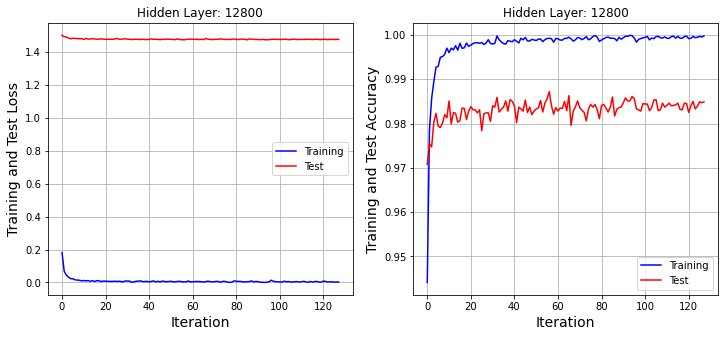

In [32]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss4, 'b', label = "Training")
ax[0].plot(range(128), test_loss4, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 12800')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc4, 'b', label = "Training")
ax[1].plot(range(128), test_acc4, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 12800')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 12800.png")

In [33]:
model = BaselineModel(784,1,10)

train_loss4 = np.zeros(128)
test_loss4 = np.zeros(128)
train_acc4 = np.zeros(128)
test_acc4 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 2.0006415843963623, 'running_acc': 0.2556249797344208, 'loss': 2.1234359741210938, 'acc': 0.23010000586509705, 'val_loss': 2.239865779876709, 'val_acc': 0.24449999630451202}
Epoch: 1
Training Loss: 2.1234359741210938
Training Accuracy: 0.23010000586509705
Test Loss: 2.239865779876709
Test Accuracy: 0.24449999630451202


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.9155722856521606, 'running_acc': 0.26078125834465027, 'loss': 1.9564796686172485, 'acc': 0.2535000145435333, 'val_loss': 2.231553554534912, 'val_acc': 0.2467999905347824}
Epoch: 2
Training Loss: 1.9564796686172485
Training Accuracy: 0.2535000145435333
Test Loss: 2.231553554534912
Test Accuracy: 0.2467999905347824


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.8863438367843628, 'running_acc': 0.2554687559604645, 'loss': 1.8934197425842285, 'acc': 0.25681665539741516, 'val_loss': 2.22519850730896, 'val_acc': 0.2667999863624573}
Epoch: 3
Training Loss: 1.8934197425842285
Training Accuracy: 0.25681665539741516
Test Loss: 2.22519850730896
Test Accuracy: 0.2667999863624573


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.8300331830978394, 'running_acc': 0.27796873450279236, 'loss': 1.8517988920211792, 'acc': 0.27293333411216736, 'val_loss': 2.22121524810791, 'val_acc': 0.281499981880188}
Epoch: 4
Training Loss: 1.8517988920211792
Training Accuracy: 0.27293333411216736
Test Loss: 2.22121524810791
Test Accuracy: 0.281499981880188


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.790336012840271, 'running_acc': 0.3109374940395355, 'loss': 1.815566897392273, 'acc': 0.2942500114440918, 'val_loss': 2.213636636734009, 'val_acc': 0.3206999897956848}
Epoch: 5
Training Loss: 1.815566897392273
Training Accuracy: 0.2942500114440918
Test Loss: 2.213636636734009
Test Accuracy: 0.3206999897956848


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.78006112575531, 'running_acc': 0.3048437535762787, 'loss': 1.7797304391860962, 'acc': 0.3165000081062317, 'val_loss': 2.2076053619384766, 'val_acc': 0.3199000060558319}
Epoch: 6
Training Loss: 1.7797304391860962
Training Accuracy: 0.3165000081062317
Test Loss: 2.2076053619384766
Test Accuracy: 0.3199000060558319


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.7377249002456665, 'running_acc': 0.31640625, 'loss': 1.7505733966827393, 'acc': 0.3187166750431061, 'val_loss': 2.2020626068115234, 'val_acc': 0.32989999651908875}
Epoch: 7
Training Loss: 1.7505733966827393
Training Accuracy: 0.3187166750431061
Test Loss: 2.2020626068115234
Test Accuracy: 0.32989999651908875


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.716676115989685, 'running_acc': 0.3331249952316284, 'loss': 1.7292006015777588, 'acc': 0.3235333263874054, 'val_loss': 2.197679281234741, 'val_acc': 0.33229997754096985}
Epoch: 8
Training Loss: 1.7292006015777588
Training Accuracy: 0.3235333263874054
Test Loss: 2.197679281234741
Test Accuracy: 0.33229997754096985


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.7107380628585815, 'running_acc': 0.34375, 'loss': 1.7121591567993164, 'acc': 0.3357166647911072, 'val_loss': 2.1956257820129395, 'val_acc': 0.337799996137619}
Epoch: 9
Training Loss: 1.7121591567993164
Training Accuracy: 0.3357166647911072
Test Loss: 2.1956257820129395
Test Accuracy: 0.337799996137619


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6884623765945435, 'running_acc': 0.3499999940395355, 'loss': 1.6988072395324707, 'acc': 0.33908334374427795, 'val_loss': 2.191051483154297, 'val_acc': 0.34700000286102295}
Epoch: 10
Training Loss: 1.6988072395324707
Training Accuracy: 0.33908334374427795
Test Loss: 2.191051483154297
Test Accuracy: 0.34700000286102295


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6927143335342407, 'running_acc': 0.3317187428474426, 'loss': 1.6876637935638428, 'acc': 0.34461668133735657, 'val_loss': 2.1877214908599854, 'val_acc': 0.3467999994754791}
Epoch: 11
Training Loss: 1.6876637935638428
Training Accuracy: 0.34461668133735657
Test Loss: 2.1877214908599854
Test Accuracy: 0.3467999994754791


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6841801404953003, 'running_acc': 0.3356249928474426, 'loss': 1.678492546081543, 'acc': 0.34683334827423096, 'val_loss': 2.1856696605682373, 'val_acc': 0.35679998993873596}
Epoch: 12
Training Loss: 1.678492546081543
Training Accuracy: 0.34683334827423096
Test Loss: 2.1856696605682373
Test Accuracy: 0.35679998993873596


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6719917058944702, 'running_acc': 0.3543750047683716, 'loss': 1.6706558465957642, 'acc': 0.3474833369255066, 'val_loss': 2.1837737560272217, 'val_acc': 0.36079999804496765}
Epoch: 13
Training Loss: 1.6706558465957642
Training Accuracy: 0.3474833369255066
Test Loss: 2.1837737560272217
Test Accuracy: 0.36079999804496765


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6572248935699463, 'running_acc': 0.355781227350235, 'loss': 1.6640100479125977, 'acc': 0.3543500006198883, 'val_loss': 2.181457281112671, 'val_acc': 0.3515999913215637}
Epoch: 14
Training Loss: 1.6640100479125977
Training Accuracy: 0.3543500006198883
Test Loss: 2.181457281112671
Test Accuracy: 0.3515999913215637


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6555732488632202, 'running_acc': 0.3540624976158142, 'loss': 1.6584855318069458, 'acc': 0.35358333587646484, 'val_loss': 2.1777162551879883, 'val_acc': 0.36479997634887695}
Epoch: 15
Training Loss: 1.6584855318069458
Training Accuracy: 0.35358333587646484
Test Loss: 2.1777162551879883
Test Accuracy: 0.36479997634887695


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6570690870285034, 'running_acc': 0.35374999046325684, 'loss': 1.6535401344299316, 'acc': 0.3569166660308838, 'val_loss': 2.177617073059082, 'val_acc': 0.3603000044822693}
Epoch: 16
Training Loss: 1.6535401344299316
Training Accuracy: 0.3569166660308838
Test Loss: 2.177617073059082
Test Accuracy: 0.3603000044822693


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.64047110080719, 'running_acc': 0.37062498927116394, 'loss': 1.649185299873352, 'acc': 0.35916668176651, 'val_loss': 2.174713134765625, 'val_acc': 0.3555999994277954}
Epoch: 17
Training Loss: 1.649185299873352
Training Accuracy: 0.35916668176651
Test Loss: 2.174713134765625
Test Accuracy: 0.3555999994277954


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6452231407165527, 'running_acc': 0.3515625, 'loss': 1.6456646919250488, 'acc': 0.35956665873527527, 'val_loss': 2.1730833053588867, 'val_acc': 0.3649999797344208}
Epoch: 18
Training Loss: 1.6456646919250488
Training Accuracy: 0.35956665873527527
Test Loss: 2.1730833053588867
Test Accuracy: 0.3649999797344208


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.650822401046753, 'running_acc': 0.36390623450279236, 'loss': 1.6415371894836426, 'acc': 0.36364999413490295, 'val_loss': 2.1722500324249268, 'val_acc': 0.36890000104904175}
Epoch: 19
Training Loss: 1.6415371894836426
Training Accuracy: 0.36364999413490295
Test Loss: 2.1722500324249268
Test Accuracy: 0.36890000104904175


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6440600156784058, 'running_acc': 0.35203123092651367, 'loss': 1.6386363506317139, 'acc': 0.36465001106262207, 'val_loss': 2.1706249713897705, 'val_acc': 0.3669999837875366}
Epoch: 20
Training Loss: 1.6386363506317139
Training Accuracy: 0.36465001106262207
Test Loss: 2.1706249713897705
Test Accuracy: 0.3669999837875366


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6406220197677612, 'running_acc': 0.3606249988079071, 'loss': 1.635716438293457, 'acc': 0.36596667766571045, 'val_loss': 2.1699585914611816, 'val_acc': 0.3741999864578247}
Epoch: 21
Training Loss: 1.635716438293457
Training Accuracy: 0.36596667766571045
Test Loss: 2.1699585914611816
Test Accuracy: 0.3741999864578247


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6384258270263672, 'running_acc': 0.3773437440395355, 'loss': 1.63323175907135, 'acc': 0.36773332953453064, 'val_loss': 2.1682443618774414, 'val_acc': 0.3726999759674072}
Epoch: 22
Training Loss: 1.63323175907135
Training Accuracy: 0.36773332953453064
Test Loss: 2.1682443618774414
Test Accuracy: 0.3726999759674072


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.639778971672058, 'running_acc': 0.3659375011920929, 'loss': 1.630543828010559, 'acc': 0.37076666951179504, 'val_loss': 2.166926860809326, 'val_acc': 0.3716000020503998}
Epoch: 23
Training Loss: 1.630543828010559
Training Accuracy: 0.37076666951179504
Test Loss: 2.166926860809326
Test Accuracy: 0.3716000020503998


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.639700174331665, 'running_acc': 0.3643749952316284, 'loss': 1.627945065498352, 'acc': 0.37166666984558105, 'val_loss': 2.166126012802124, 'val_acc': 0.3750999867916107}
Epoch: 24
Training Loss: 1.627945065498352
Training Accuracy: 0.37166666984558105
Test Loss: 2.166126012802124
Test Accuracy: 0.3750999867916107


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6257882118225098, 'running_acc': 0.37296873331069946, 'loss': 1.6260489225387573, 'acc': 0.3723166584968567, 'val_loss': 2.164706230163574, 'val_acc': 0.3773999810218811}
Epoch: 25
Training Loss: 1.6260489225387573
Training Accuracy: 0.3723166584968567
Test Loss: 2.164706230163574
Test Accuracy: 0.3773999810218811


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6152746677398682, 'running_acc': 0.3843750059604645, 'loss': 1.6243172883987427, 'acc': 0.3745666742324829, 'val_loss': 2.163498878479004, 'val_acc': 0.3741999864578247}
Epoch: 26
Training Loss: 1.6243172883987427
Training Accuracy: 0.3745666742324829
Test Loss: 2.163498878479004
Test Accuracy: 0.3741999864578247


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.614994764328003, 'running_acc': 0.39109373092651367, 'loss': 1.6219260692596436, 'acc': 0.37726667523384094, 'val_loss': 2.160860300064087, 'val_acc': 0.38099998235702515}
Epoch: 27
Training Loss: 1.6219260692596436
Training Accuracy: 0.37726667523384094
Test Loss: 2.160860300064087
Test Accuracy: 0.38099998235702515


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6113981008529663, 'running_acc': 0.38671875, 'loss': 1.6203794479370117, 'acc': 0.37861666083335876, 'val_loss': 2.161073684692383, 'val_acc': 0.38199999928474426}
Epoch: 28
Training Loss: 1.6203794479370117
Training Accuracy: 0.37861666083335876
Test Loss: 2.161073684692383
Test Accuracy: 0.38199999928474426


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6244771480560303, 'running_acc': 0.379218727350235, 'loss': 1.618275761604309, 'acc': 0.3806000053882599, 'val_loss': 2.1594603061676025, 'val_acc': 0.3806999921798706}
Epoch: 29
Training Loss: 1.618275761604309
Training Accuracy: 0.3806000053882599
Test Loss: 2.1594603061676025
Test Accuracy: 0.3806999921798706


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6117509603500366, 'running_acc': 0.3935937285423279, 'loss': 1.6167019605636597, 'acc': 0.38165000081062317, 'val_loss': 2.1598904132843018, 'val_acc': 0.3814999759197235}
Epoch: 30
Training Loss: 1.6167019605636597
Training Accuracy: 0.38165000081062317
Test Loss: 2.1598904132843018
Test Accuracy: 0.3814999759197235


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6154934167861938, 'running_acc': 0.3765625059604645, 'loss': 1.6153109073638916, 'acc': 0.3815833330154419, 'val_loss': 2.157999038696289, 'val_acc': 0.3869999945163727}
Epoch: 31
Training Loss: 1.6153109073638916
Training Accuracy: 0.3815833330154419
Test Loss: 2.157999038696289
Test Accuracy: 0.3869999945163727


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6113299131393433, 'running_acc': 0.3829687535762787, 'loss': 1.613937258720398, 'acc': 0.38269999623298645, 'val_loss': 2.1569719314575195, 'val_acc': 0.3877999782562256}
Epoch: 32
Training Loss: 1.613937258720398
Training Accuracy: 0.38269999623298645
Test Loss: 2.1569719314575195
Test Accuracy: 0.3877999782562256


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6000405550003052, 'running_acc': 0.38359373807907104, 'loss': 1.6126818656921387, 'acc': 0.3849666714668274, 'val_loss': 2.1544394493103027, 'val_acc': 0.3895999789237976}
Epoch: 33
Training Loss: 1.6126818656921387
Training Accuracy: 0.3849666714668274
Test Loss: 2.1544394493103027
Test Accuracy: 0.3895999789237976


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6254174709320068, 'running_acc': 0.3801562488079071, 'loss': 1.6113542318344116, 'acc': 0.38493335247039795, 'val_loss': 2.1549718379974365, 'val_acc': 0.3937999904155731}
Epoch: 34
Training Loss: 1.6113542318344116
Training Accuracy: 0.38493335247039795
Test Loss: 2.1549718379974365
Test Accuracy: 0.3937999904155731


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6006921529769897, 'running_acc': 0.39281249046325684, 'loss': 1.6099578142166138, 'acc': 0.38476666808128357, 'val_loss': 2.154531478881836, 'val_acc': 0.39069998264312744}
Epoch: 35
Training Loss: 1.6099578142166138
Training Accuracy: 0.38476666808128357
Test Loss: 2.154531478881836
Test Accuracy: 0.39069998264312744


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6005463600158691, 'running_acc': 0.38593748211860657, 'loss': 1.6091371774673462, 'acc': 0.38609999418258667, 'val_loss': 2.1536026000976562, 'val_acc': 0.38599997758865356}
Epoch: 36
Training Loss: 1.6091371774673462
Training Accuracy: 0.38609999418258667
Test Loss: 2.1536026000976562
Test Accuracy: 0.38599997758865356


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5939399003982544, 'running_acc': 0.3970312476158142, 'loss': 1.6080812215805054, 'acc': 0.38831666111946106, 'val_loss': 2.1518895626068115, 'val_acc': 0.3885999917984009}
Epoch: 37
Training Loss: 1.6080812215805054
Training Accuracy: 0.38831666111946106
Test Loss: 2.1518895626068115
Test Accuracy: 0.3885999917984009


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6001802682876587, 'running_acc': 0.3896874785423279, 'loss': 1.6068235635757446, 'acc': 0.3886333405971527, 'val_loss': 2.1521246433258057, 'val_acc': 0.39259999990463257}
Epoch: 38
Training Loss: 1.6068235635757446
Training Accuracy: 0.3886333405971527
Test Loss: 2.1521246433258057
Test Accuracy: 0.39259999990463257


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.597696304321289, 'running_acc': 0.375312477350235, 'loss': 1.605710744857788, 'acc': 0.38920000195503235, 'val_loss': 2.1502845287323, 'val_acc': 0.39419999718666077}
Epoch: 39
Training Loss: 1.605710744857788
Training Accuracy: 0.38920000195503235
Test Loss: 2.1502845287323
Test Accuracy: 0.39419999718666077


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6056830883026123, 'running_acc': 0.38718748092651367, 'loss': 1.6050041913986206, 'acc': 0.38788333535194397, 'val_loss': 2.1508045196533203, 'val_acc': 0.3971000015735626}
Epoch: 40
Training Loss: 1.6050041913986206
Training Accuracy: 0.38788333535194397
Test Loss: 2.1508045196533203
Test Accuracy: 0.3971000015735626


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6141518354415894, 'running_acc': 0.3942187428474426, 'loss': 1.6042735576629639, 'acc': 0.389683336019516, 'val_loss': 2.1500658988952637, 'val_acc': 0.39489999413490295}
Epoch: 41
Training Loss: 1.6042735576629639
Training Accuracy: 0.389683336019516
Test Loss: 2.1500658988952637
Test Accuracy: 0.39489999413490295


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6115981340408325, 'running_acc': 0.3824999928474426, 'loss': 1.6033885478973389, 'acc': 0.3909499943256378, 'val_loss': 2.1480448246002197, 'val_acc': 0.39399999380111694}
Epoch: 42
Training Loss: 1.6033885478973389
Training Accuracy: 0.3909499943256378
Test Loss: 2.1480448246002197
Test Accuracy: 0.39399999380111694


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.592859148979187, 'running_acc': 0.3918749988079071, 'loss': 1.6024692058563232, 'acc': 0.3913666605949402, 'val_loss': 2.1476669311523438, 'val_acc': 0.3953000009059906}
Epoch: 43
Training Loss: 1.6024692058563232
Training Accuracy: 0.3913666605949402
Test Loss: 2.1476669311523438
Test Accuracy: 0.3953000009059906


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.604443073272705, 'running_acc': 0.3934375047683716, 'loss': 1.6015174388885498, 'acc': 0.3933333456516266, 'val_loss': 2.1479694843292236, 'val_acc': 0.39399999380111694}
Epoch: 44
Training Loss: 1.6015174388885498
Training Accuracy: 0.3933333456516266
Test Loss: 2.1479694843292236
Test Accuracy: 0.39399999380111694


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6154730319976807, 'running_acc': 0.3828125, 'loss': 1.6004947423934937, 'acc': 0.39231666922569275, 'val_loss': 2.148169755935669, 'val_acc': 0.39629998803138733}
Epoch: 45
Training Loss: 1.6004947423934937
Training Accuracy: 0.39231666922569275
Test Loss: 2.148169755935669
Test Accuracy: 0.39629998803138733


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6102722883224487, 'running_acc': 0.38234373927116394, 'loss': 1.6001253128051758, 'acc': 0.3934333324432373, 'val_loss': 2.1472527980804443, 'val_acc': 0.3933999836444855}
Epoch: 46
Training Loss: 1.6001253128051758
Training Accuracy: 0.3934333324432373
Test Loss: 2.1472527980804443
Test Accuracy: 0.3933999836444855


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5884051322937012, 'running_acc': 0.40296873450279236, 'loss': 1.599281668663025, 'acc': 0.3928333520889282, 'val_loss': 2.1436753273010254, 'val_acc': 0.39640000462532043}
Epoch: 47
Training Loss: 1.599281668663025
Training Accuracy: 0.3928333520889282
Test Loss: 2.1436753273010254
Test Accuracy: 0.39640000462532043


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.603934645652771, 'running_acc': 0.38999998569488525, 'loss': 1.5987449884414673, 'acc': 0.3944000005722046, 'val_loss': 2.1463077068328857, 'val_acc': 0.3983999788761139}
Epoch: 48
Training Loss: 1.5987449884414673
Training Accuracy: 0.3944000005722046
Test Loss: 2.1463077068328857
Test Accuracy: 0.3983999788761139


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5881626605987549, 'running_acc': 0.39499998092651367, 'loss': 1.5979892015457153, 'acc': 0.3951166570186615, 'val_loss': 2.145554780960083, 'val_acc': 0.3976999819278717}
Epoch: 49
Training Loss: 1.5979892015457153
Training Accuracy: 0.3951166570186615
Test Loss: 2.145554780960083
Test Accuracy: 0.3976999819278717


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5793075561523438, 'running_acc': 0.40718749165534973, 'loss': 1.5974326133728027, 'acc': 0.3943166732788086, 'val_loss': 2.1432056427001953, 'val_acc': 0.3969999849796295}
Epoch: 50
Training Loss: 1.5974326133728027
Training Accuracy: 0.3943166732788086
Test Loss: 2.1432056427001953
Test Accuracy: 0.3969999849796295


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6133419275283813, 'running_acc': 0.3842187523841858, 'loss': 1.5965874195098877, 'acc': 0.39473333954811096, 'val_loss': 2.1439578533172607, 'val_acc': 0.3982999920845032}
Epoch: 51
Training Loss: 1.5965874195098877
Training Accuracy: 0.39473333954811096
Test Loss: 2.1439578533172607
Test Accuracy: 0.3982999920845032


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.577512502670288, 'running_acc': 0.3968749940395355, 'loss': 1.5957696437835693, 'acc': 0.3961166739463806, 'val_loss': 2.1425788402557373, 'val_acc': 0.4001999795436859}
Epoch: 52
Training Loss: 1.5957696437835693
Training Accuracy: 0.3961166739463806
Test Loss: 2.1425788402557373
Test Accuracy: 0.4001999795436859


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5970979928970337, 'running_acc': 0.4009374976158142, 'loss': 1.5953643321990967, 'acc': 0.3971833288669586, 'val_loss': 2.1424202919006348, 'val_acc': 0.4008999764919281}
Epoch: 53
Training Loss: 1.5953643321990967
Training Accuracy: 0.3971833288669586
Test Loss: 2.1424202919006348
Test Accuracy: 0.4008999764919281


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5910125970840454, 'running_acc': 0.39390623569488525, 'loss': 1.594846487045288, 'acc': 0.3960166573524475, 'val_loss': 2.1417510509490967, 'val_acc': 0.3953000009059906}
Epoch: 54
Training Loss: 1.594846487045288
Training Accuracy: 0.3960166573524475
Test Loss: 2.1417510509490967
Test Accuracy: 0.3953000009059906


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.625722050666809, 'running_acc': 0.38359373807907104, 'loss': 1.594098448753357, 'acc': 0.3968833386898041, 'val_loss': 2.142786979675293, 'val_acc': 0.3903999924659729}
Epoch: 55
Training Loss: 1.594098448753357
Training Accuracy: 0.3968833386898041
Test Loss: 2.142786979675293
Test Accuracy: 0.3903999924659729


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5823233127593994, 'running_acc': 0.3999999761581421, 'loss': 1.5932801961898804, 'acc': 0.3956666588783264, 'val_loss': 2.139633893966675, 'val_acc': 0.40139999985694885}
Epoch: 56
Training Loss: 1.5932801961898804
Training Accuracy: 0.3956666588783264
Test Loss: 2.139633893966675
Test Accuracy: 0.40139999985694885


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5978355407714844, 'running_acc': 0.3960937559604645, 'loss': 1.5936038494110107, 'acc': 0.39766666293144226, 'val_loss': 2.1399197578430176, 'val_acc': 0.3999999761581421}
Epoch: 57
Training Loss: 1.5936038494110107
Training Accuracy: 0.39766666293144226
Test Loss: 2.1399197578430176
Test Accuracy: 0.3999999761581421


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5771665573120117, 'running_acc': 0.3998437523841858, 'loss': 1.5929890871047974, 'acc': 0.39426666498184204, 'val_loss': 2.1399238109588623, 'val_acc': 0.3994999825954437}
Epoch: 58
Training Loss: 1.5929890871047974
Training Accuracy: 0.39426666498184204
Test Loss: 2.1399238109588623
Test Accuracy: 0.3994999825954437


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5984057188034058, 'running_acc': 0.3923437297344208, 'loss': 1.5922489166259766, 'acc': 0.39731666445732117, 'val_loss': 2.141080141067505, 'val_acc': 0.400299996137619}
Epoch: 59
Training Loss: 1.5922489166259766
Training Accuracy: 0.39731666445732117
Test Loss: 2.141080141067505
Test Accuracy: 0.400299996137619


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5857197046279907, 'running_acc': 0.3942187428474426, 'loss': 1.591360330581665, 'acc': 0.3971833288669586, 'val_loss': 2.1411516666412354, 'val_acc': 0.39719998836517334}
Epoch: 60
Training Loss: 1.591360330581665
Training Accuracy: 0.3971833288669586
Test Loss: 2.1411516666412354
Test Accuracy: 0.39719998836517334


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5984644889831543, 'running_acc': 0.39406248927116394, 'loss': 1.591439127922058, 'acc': 0.399150013923645, 'val_loss': 2.139824151992798, 'val_acc': 0.39800000190734863}
Epoch: 61
Training Loss: 1.591439127922058
Training Accuracy: 0.399150013923645
Test Loss: 2.139824151992798
Test Accuracy: 0.39800000190734863


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6054569482803345, 'running_acc': 0.3903124928474426, 'loss': 1.5909206867218018, 'acc': 0.3988000154495239, 'val_loss': 2.139044761657715, 'val_acc': 0.39890000224113464}
Epoch: 62
Training Loss: 1.5909206867218018
Training Accuracy: 0.3988000154495239
Test Loss: 2.139044761657715
Test Accuracy: 0.39890000224113464


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6193609237670898, 'running_acc': 0.38890624046325684, 'loss': 1.5911561250686646, 'acc': 0.397350013256073, 'val_loss': 2.138744354248047, 'val_acc': 0.4001999795436859}
Epoch: 63
Training Loss: 1.5911561250686646
Training Accuracy: 0.397350013256073
Test Loss: 2.138744354248047
Test Accuracy: 0.4001999795436859


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5996971130371094, 'running_acc': 0.3931249976158142, 'loss': 1.5899776220321655, 'acc': 0.3961000144481659, 'val_loss': 2.1380491256713867, 'val_acc': 0.4018999934196472}
Epoch: 64
Training Loss: 1.5899776220321655
Training Accuracy: 0.3961000144481659
Test Loss: 2.1380491256713867
Test Accuracy: 0.4018999934196472


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5884263515472412, 'running_acc': 0.40703123807907104, 'loss': 1.5898661613464355, 'acc': 0.3989666700363159, 'val_loss': 2.137450695037842, 'val_acc': 0.40219998359680176}
Epoch: 65
Training Loss: 1.5898661613464355
Training Accuracy: 0.3989666700363159
Test Loss: 2.137450695037842
Test Accuracy: 0.40219998359680176


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5924001932144165, 'running_acc': 0.39515623450279236, 'loss': 1.5894312858581543, 'acc': 0.39871665835380554, 'val_loss': 2.137946844100952, 'val_acc': 0.3967999815940857}
Epoch: 66
Training Loss: 1.5894312858581543
Training Accuracy: 0.39871665835380554
Test Loss: 2.137946844100952
Test Accuracy: 0.3967999815940857


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5857949256896973, 'running_acc': 0.39765623211860657, 'loss': 1.5894662141799927, 'acc': 0.3964333236217499, 'val_loss': 2.136749029159546, 'val_acc': 0.3969999849796295}
Epoch: 67
Training Loss: 1.5894662141799927
Training Accuracy: 0.3964333236217499
Test Loss: 2.136749029159546
Test Accuracy: 0.3969999849796295


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5964093208312988, 'running_acc': 0.3996874988079071, 'loss': 1.5887430906295776, 'acc': 0.399316668510437, 'val_loss': 2.136639356613159, 'val_acc': 0.3994999825954437}
Epoch: 68
Training Loss: 1.5887430906295776
Training Accuracy: 0.399316668510437
Test Loss: 2.136639356613159
Test Accuracy: 0.3994999825954437


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.602835774421692, 'running_acc': 0.40843749046325684, 'loss': 1.5887196063995361, 'acc': 0.3987666666507721, 'val_loss': 2.1381826400756836, 'val_acc': 0.3944999873638153}
Epoch: 69
Training Loss: 1.5887196063995361
Training Accuracy: 0.3987666666507721
Test Loss: 2.1381826400756836
Test Accuracy: 0.3944999873638153


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5958033800125122, 'running_acc': 0.39015623927116394, 'loss': 1.5884102582931519, 'acc': 0.400216668844223, 'val_loss': 2.137077569961548, 'val_acc': 0.3976999819278717}
Epoch: 70
Training Loss: 1.5884102582931519
Training Accuracy: 0.400216668844223
Test Loss: 2.137077569961548
Test Accuracy: 0.3976999819278717


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5758777856826782, 'running_acc': 0.40625, 'loss': 1.5877412557601929, 'acc': 0.3975333273410797, 'val_loss': 2.138279676437378, 'val_acc': 0.3991999924182892}
Epoch: 71
Training Loss: 1.5877412557601929
Training Accuracy: 0.3975333273410797
Test Loss: 2.138279676437378
Test Accuracy: 0.3991999924182892


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6002557277679443, 'running_acc': 0.39937499165534973, 'loss': 1.5874232053756714, 'acc': 0.39746665954589844, 'val_loss': 2.136913537979126, 'val_acc': 0.39989998936653137}
Epoch: 72
Training Loss: 1.5874232053756714
Training Accuracy: 0.39746665954589844
Test Loss: 2.136913537979126
Test Accuracy: 0.39989998936653137


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5787925720214844, 'running_acc': 0.40828123688697815, 'loss': 1.5872597694396973, 'acc': 0.3979499936103821, 'val_loss': 2.1361520290374756, 'val_acc': 0.3982999920845032}
Epoch: 73
Training Loss: 1.5872597694396973
Training Accuracy: 0.3979499936103821
Test Loss: 2.1361520290374756
Test Accuracy: 0.3982999920845032


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.592989444732666, 'running_acc': 0.4012500047683716, 'loss': 1.5873152017593384, 'acc': 0.40041667222976685, 'val_loss': 2.1357507705688477, 'val_acc': 0.3967999815940857}
Epoch: 74
Training Loss: 1.5873152017593384
Training Accuracy: 0.40041667222976685
Test Loss: 2.1357507705688477
Test Accuracy: 0.3967999815940857


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6008135080337524, 'running_acc': 0.39124998450279236, 'loss': 1.587012767791748, 'acc': 0.3981499969959259, 'val_loss': 2.136241912841797, 'val_acc': 0.39800000190734863}
Epoch: 75
Training Loss: 1.587012767791748
Training Accuracy: 0.3981499969959259
Test Loss: 2.136241912841797
Test Accuracy: 0.39800000190734863


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5576531887054443, 'running_acc': 0.4039062261581421, 'loss': 1.5866650342941284, 'acc': 0.39864999055862427, 'val_loss': 2.135535955429077, 'val_acc': 0.4018999934196472}
Epoch: 76
Training Loss: 1.5866650342941284
Training Accuracy: 0.39864999055862427
Test Loss: 2.135535955429077
Test Accuracy: 0.4018999934196472


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5968488454818726, 'running_acc': 0.40562498569488525, 'loss': 1.586650013923645, 'acc': 0.3981333374977112, 'val_loss': 2.1360175609588623, 'val_acc': 0.4008999764919281}
Epoch: 77
Training Loss: 1.586650013923645
Training Accuracy: 0.3981333374977112
Test Loss: 2.1360175609588623
Test Accuracy: 0.4008999764919281


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.61159086227417, 'running_acc': 0.38718748092651367, 'loss': 1.586493730545044, 'acc': 0.39918333292007446, 'val_loss': 2.1357812881469727, 'val_acc': 0.4027999937534332}
Epoch: 78
Training Loss: 1.586493730545044
Training Accuracy: 0.39918333292007446
Test Loss: 2.1357812881469727
Test Accuracy: 0.4027999937534332


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.613572597503662, 'running_acc': 0.394843727350235, 'loss': 1.585943579673767, 'acc': 0.3989333510398865, 'val_loss': 2.1339480876922607, 'val_acc': 0.40289998054504395}
Epoch: 79
Training Loss: 1.585943579673767
Training Accuracy: 0.3989333510398865
Test Loss: 2.1339480876922607
Test Accuracy: 0.40289998054504395


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6055980920791626, 'running_acc': 0.40671873092651367, 'loss': 1.5852571725845337, 'acc': 0.39945000410079956, 'val_loss': 2.1371233463287354, 'val_acc': 0.40219998359680176}
Epoch: 80
Training Loss: 1.5852571725845337
Training Accuracy: 0.39945000410079956
Test Loss: 2.1371233463287354
Test Accuracy: 0.40219998359680176


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5842461585998535, 'running_acc': 0.3999999761581421, 'loss': 1.5855759382247925, 'acc': 0.40016666054725647, 'val_loss': 2.1359972953796387, 'val_acc': 0.4026999771595001}
Epoch: 81
Training Loss: 1.5855759382247925
Training Accuracy: 0.40016666054725647
Test Loss: 2.1359972953796387
Test Accuracy: 0.4026999771595001


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5928590297698975, 'running_acc': 0.406562477350235, 'loss': 1.5851651430130005, 'acc': 0.39936667680740356, 'val_loss': 2.1349170207977295, 'val_acc': 0.39980000257492065}
Epoch: 82
Training Loss: 1.5851651430130005
Training Accuracy: 0.39936667680740356
Test Loss: 2.1349170207977295
Test Accuracy: 0.39980000257492065


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5974334478378296, 'running_acc': 0.402656227350235, 'loss': 1.5853123664855957, 'acc': 0.3995666801929474, 'val_loss': 2.134906530380249, 'val_acc': 0.4027999937534332}
Epoch: 83
Training Loss: 1.5853123664855957
Training Accuracy: 0.3995666801929474
Test Loss: 2.134906530380249
Test Accuracy: 0.4027999937534332


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6014268398284912, 'running_acc': 0.4014062285423279, 'loss': 1.5850937366485596, 'acc': 0.40084999799728394, 'val_loss': 2.134770393371582, 'val_acc': 0.39800000190734863}
Epoch: 84
Training Loss: 1.5850937366485596
Training Accuracy: 0.40084999799728394
Test Loss: 2.134770393371582
Test Accuracy: 0.39800000190734863


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5729690790176392, 'running_acc': 0.4078124761581421, 'loss': 1.5848686695098877, 'acc': 0.3999166786670685, 'val_loss': 2.135493516921997, 'val_acc': 0.40539997816085815}
Epoch: 85
Training Loss: 1.5848686695098877
Training Accuracy: 0.3999166786670685
Test Loss: 2.135493516921997
Test Accuracy: 0.40539997816085815


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5830379724502563, 'running_acc': 0.40625, 'loss': 1.584423542022705, 'acc': 0.40043333172798157, 'val_loss': 2.1337392330169678, 'val_acc': 0.40070000290870667}
Epoch: 86
Training Loss: 1.584423542022705
Training Accuracy: 0.40043333172798157
Test Loss: 2.1337392330169678
Test Accuracy: 0.40070000290870667


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5847132205963135, 'running_acc': 0.40625, 'loss': 1.5843933820724487, 'acc': 0.3987666666507721, 'val_loss': 2.134152889251709, 'val_acc': 0.4032000005245209}
Epoch: 87
Training Loss: 1.5843933820724487
Training Accuracy: 0.3987666666507721
Test Loss: 2.134152889251709
Test Accuracy: 0.4032000005245209


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5694209337234497, 'running_acc': 0.3971875011920929, 'loss': 1.5841339826583862, 'acc': 0.3988499939441681, 'val_loss': 2.1348509788513184, 'val_acc': 0.4023999869823456}
Epoch: 88
Training Loss: 1.5841339826583862
Training Accuracy: 0.3988499939441681
Test Loss: 2.1348509788513184
Test Accuracy: 0.4023999869823456


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5888715982437134, 'running_acc': 0.4035937488079071, 'loss': 1.5838736295700073, 'acc': 0.40058332681655884, 'val_loss': 2.1343061923980713, 'val_acc': 0.3904999792575836}
Epoch: 89
Training Loss: 1.5838736295700073
Training Accuracy: 0.40058332681655884
Test Loss: 2.1343061923980713
Test Accuracy: 0.3904999792575836


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5805412530899048, 'running_acc': 0.40234375, 'loss': 1.5839781761169434, 'acc': 0.3994166851043701, 'val_loss': 2.1343698501586914, 'val_acc': 0.4027999937534332}
Epoch: 90
Training Loss: 1.5839781761169434
Training Accuracy: 0.3994166851043701
Test Loss: 2.1343698501586914
Test Accuracy: 0.4027999937534332


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5818418264389038, 'running_acc': 0.38859373331069946, 'loss': 1.583480954170227, 'acc': 0.39945000410079956, 'val_loss': 2.132904529571533, 'val_acc': 0.3992999792098999}
Epoch: 91
Training Loss: 1.583480954170227
Training Accuracy: 0.39945000410079956
Test Loss: 2.132904529571533
Test Accuracy: 0.3992999792098999


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5791176557540894, 'running_acc': 0.40421873331069946, 'loss': 1.5839875936508179, 'acc': 0.4007333517074585, 'val_loss': 2.1327946186065674, 'val_acc': 0.4027999937534332}
Epoch: 92
Training Loss: 1.5839875936508179
Training Accuracy: 0.4007333517074585
Test Loss: 2.1327946186065674
Test Accuracy: 0.4027999937534332


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.575942039489746, 'running_acc': 0.40187498927116394, 'loss': 1.5839602947235107, 'acc': 0.39986667037010193, 'val_loss': 2.133726119995117, 'val_acc': 0.4026999771595001}
Epoch: 93
Training Loss: 1.5839602947235107
Training Accuracy: 0.39986667037010193
Test Loss: 2.133726119995117
Test Accuracy: 0.4026999771595001


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5699540376663208, 'running_acc': 0.4115625023841858, 'loss': 1.583655834197998, 'acc': 0.40209999680519104, 'val_loss': 2.1328701972961426, 'val_acc': 0.4056999981403351}
Epoch: 94
Training Loss: 1.583655834197998
Training Accuracy: 0.40209999680519104
Test Loss: 2.1328701972961426
Test Accuracy: 0.4056999981403351


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5851370096206665, 'running_acc': 0.3996874988079071, 'loss': 1.5833367109298706, 'acc': 0.40115001797676086, 'val_loss': 2.135352849960327, 'val_acc': 0.40209999680519104}
Epoch: 95
Training Loss: 1.5833367109298706
Training Accuracy: 0.40115001797676086
Test Loss: 2.135352849960327
Test Accuracy: 0.40209999680519104


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5937315225601196, 'running_acc': 0.4037500023841858, 'loss': 1.5830836296081543, 'acc': 0.4020500183105469, 'val_loss': 2.131774663925171, 'val_acc': 0.3962000012397766}
Epoch: 96
Training Loss: 1.5830836296081543
Training Accuracy: 0.4020500183105469
Test Loss: 2.131774663925171
Test Accuracy: 0.3962000012397766


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.566650629043579, 'running_acc': 0.39671874046325684, 'loss': 1.5831364393234253, 'acc': 0.39901667833328247, 'val_loss': 2.134042978286743, 'val_acc': 0.39819997549057007}
Epoch: 97
Training Loss: 1.5831364393234253
Training Accuracy: 0.39901667833328247
Test Loss: 2.134042978286743
Test Accuracy: 0.39819997549057007


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5939021110534668, 'running_acc': 0.394843727350235, 'loss': 1.5826616287231445, 'acc': 0.39996665716171265, 'val_loss': 2.13269305229187, 'val_acc': 0.40139999985694885}
Epoch: 98
Training Loss: 1.5826616287231445
Training Accuracy: 0.39996665716171265
Test Loss: 2.13269305229187
Test Accuracy: 0.40139999985694885


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.578739881515503, 'running_acc': 0.4034374952316284, 'loss': 1.5830684900283813, 'acc': 0.4008333384990692, 'val_loss': 2.132228374481201, 'val_acc': 0.4008999764919281}
Epoch: 99
Training Loss: 1.5830684900283813
Training Accuracy: 0.4008333384990692
Test Loss: 2.132228374481201
Test Accuracy: 0.4008999764919281


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.597224235534668, 'running_acc': 0.3917187452316284, 'loss': 1.5825881958007812, 'acc': 0.40049999952316284, 'val_loss': 2.1333367824554443, 'val_acc': 0.4041999876499176}
Epoch: 100
Training Loss: 1.5825881958007812
Training Accuracy: 0.40049999952316284
Test Loss: 2.1333367824554443
Test Accuracy: 0.4041999876499176


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5592836141586304, 'running_acc': 0.4090625047683716, 'loss': 1.5825574398040771, 'acc': 0.40150001645088196, 'val_loss': 2.1331560611724854, 'val_acc': 0.40449997782707214}
Epoch: 101
Training Loss: 1.5825574398040771
Training Accuracy: 0.40150001645088196
Test Loss: 2.1331560611724854
Test Accuracy: 0.40449997782707214


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5797001123428345, 'running_acc': 0.40234375, 'loss': 1.582595705986023, 'acc': 0.4000166654586792, 'val_loss': 2.1311490535736084, 'val_acc': 0.40289998054504395}
Epoch: 102
Training Loss: 1.582595705986023
Training Accuracy: 0.4000166654586792
Test Loss: 2.1311490535736084
Test Accuracy: 0.40289998054504395


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5624935626983643, 'running_acc': 0.4064062535762787, 'loss': 1.582546591758728, 'acc': 0.40006667375564575, 'val_loss': 2.132014513015747, 'val_acc': 0.4016999900341034}
Epoch: 103
Training Loss: 1.582546591758728
Training Accuracy: 0.40006667375564575
Test Loss: 2.132014513015747
Test Accuracy: 0.4016999900341034


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5972610712051392, 'running_acc': 0.40421873331069946, 'loss': 1.5823057889938354, 'acc': 0.4023166596889496, 'val_loss': 2.1323840618133545, 'val_acc': 0.4059999883174896}
Epoch: 104
Training Loss: 1.5823057889938354
Training Accuracy: 0.4023166596889496
Test Loss: 2.1323840618133545
Test Accuracy: 0.4059999883174896


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5762618780136108, 'running_acc': 0.39546874165534973, 'loss': 1.5819069147109985, 'acc': 0.4014666676521301, 'val_loss': 2.1324992179870605, 'val_acc': 0.4008999764919281}
Epoch: 105
Training Loss: 1.5819069147109985
Training Accuracy: 0.4014666676521301
Test Loss: 2.1324992179870605
Test Accuracy: 0.4008999764919281


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5876983404159546, 'running_acc': 0.3999999761581421, 'loss': 1.5816608667373657, 'acc': 0.40275001525878906, 'val_loss': 2.1328320503234863, 'val_acc': 0.40139999985694885}
Epoch: 106
Training Loss: 1.5816608667373657
Training Accuracy: 0.40275001525878906
Test Loss: 2.1328320503234863
Test Accuracy: 0.40139999985694885


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5929237604141235, 'running_acc': 0.3893750011920929, 'loss': 1.581939935684204, 'acc': 0.40068334341049194, 'val_loss': 2.132297992706299, 'val_acc': 0.4023999869823456}
Epoch: 107
Training Loss: 1.581939935684204
Training Accuracy: 0.40068334341049194
Test Loss: 2.132297992706299
Test Accuracy: 0.4023999869823456


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5891246795654297, 'running_acc': 0.4020312428474426, 'loss': 1.5818535089492798, 'acc': 0.40061667561531067, 'val_loss': 2.132521390914917, 'val_acc': 0.4032999873161316}
Epoch: 108
Training Loss: 1.5818535089492798
Training Accuracy: 0.40061667561531067
Test Loss: 2.132521390914917
Test Accuracy: 0.4032999873161316


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.610302209854126, 'running_acc': 0.40046873688697815, 'loss': 1.581895112991333, 'acc': 0.40346667170524597, 'val_loss': 2.135478973388672, 'val_acc': 0.4032999873161316}
Epoch: 109
Training Loss: 1.581895112991333
Training Accuracy: 0.40346667170524597
Test Loss: 2.135478973388672
Test Accuracy: 0.4032999873161316


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.576171636581421, 'running_acc': 0.4014062285423279, 'loss': 1.581540822982788, 'acc': 0.4002666771411896, 'val_loss': 2.1327288150787354, 'val_acc': 0.40619999170303345}
Epoch: 110
Training Loss: 1.581540822982788
Training Accuracy: 0.4002666771411896
Test Loss: 2.1327288150787354
Test Accuracy: 0.40619999170303345


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6023333072662354, 'running_acc': 0.398749977350235, 'loss': 1.5815778970718384, 'acc': 0.4009000062942505, 'val_loss': 2.13356351852417, 'val_acc': 0.4034999907016754}
Epoch: 111
Training Loss: 1.5815778970718384
Training Accuracy: 0.4009000062942505
Test Loss: 2.13356351852417
Test Accuracy: 0.4034999907016754


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5786571502685547, 'running_acc': 0.39781248569488525, 'loss': 1.5813549757003784, 'acc': 0.4023500084877014, 'val_loss': 2.1317901611328125, 'val_acc': 0.4077000021934509}
Epoch: 112
Training Loss: 1.5813549757003784
Training Accuracy: 0.4023500084877014
Test Loss: 2.1317901611328125
Test Accuracy: 0.4077000021934509


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5785175561904907, 'running_acc': 0.4020312428474426, 'loss': 1.5810900926589966, 'acc': 0.4014333486557007, 'val_loss': 2.1326475143432617, 'val_acc': 0.4007999897003174}
Epoch: 113
Training Loss: 1.5810900926589966
Training Accuracy: 0.4014333486557007
Test Loss: 2.1326475143432617
Test Accuracy: 0.4007999897003174


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5842061042785645, 'running_acc': 0.40156248211860657, 'loss': 1.5811591148376465, 'acc': 0.40256667137145996, 'val_loss': 2.1313884258270264, 'val_acc': 0.4050000011920929}
Epoch: 114
Training Loss: 1.5811591148376465
Training Accuracy: 0.40256667137145996
Test Loss: 2.1313884258270264
Test Accuracy: 0.4050000011920929


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5870522260665894, 'running_acc': 0.40421873331069946, 'loss': 1.5812838077545166, 'acc': 0.4020000100135803, 'val_loss': 2.1313486099243164, 'val_acc': 0.3992999792098999}
Epoch: 115
Training Loss: 1.5812838077545166
Training Accuracy: 0.4020000100135803
Test Loss: 2.1313486099243164
Test Accuracy: 0.3992999792098999


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5774282217025757, 'running_acc': 0.3879687488079071, 'loss': 1.5813674926757812, 'acc': 0.4005666673183441, 'val_loss': 2.1312594413757324, 'val_acc': 0.40199998021125793}
Epoch: 116
Training Loss: 1.5813674926757812
Training Accuracy: 0.4005666673183441
Test Loss: 2.1312594413757324
Test Accuracy: 0.40199998021125793


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.595764398574829, 'running_acc': 0.3931249976158142, 'loss': 1.5812933444976807, 'acc': 0.40115001797676086, 'val_loss': 2.129612922668457, 'val_acc': 0.4043999910354614}
Epoch: 117
Training Loss: 1.5812933444976807
Training Accuracy: 0.40115001797676086
Test Loss: 2.129612922668457
Test Accuracy: 0.4043999910354614


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5982766151428223, 'running_acc': 0.39140623807907104, 'loss': 1.5813050270080566, 'acc': 0.4014166593551636, 'val_loss': 2.130845069885254, 'val_acc': 0.40449997782707214}
Epoch: 118
Training Loss: 1.5813050270080566
Training Accuracy: 0.4014166593551636
Test Loss: 2.130845069885254
Test Accuracy: 0.40449997782707214


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5799585580825806, 'running_acc': 0.41078123450279236, 'loss': 1.580706000328064, 'acc': 0.40361666679382324, 'val_loss': 2.131162166595459, 'val_acc': 0.4041000008583069}
Epoch: 119
Training Loss: 1.580706000328064
Training Accuracy: 0.40361666679382324
Test Loss: 2.131162166595459
Test Accuracy: 0.4041000008583069


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.6006063222885132, 'running_acc': 0.40687498450279236, 'loss': 1.5805763006210327, 'acc': 0.4027000069618225, 'val_loss': 2.132399320602417, 'val_acc': 0.40469998121261597}
Epoch: 120
Training Loss: 1.5805763006210327
Training Accuracy: 0.4027000069618225
Test Loss: 2.132399320602417
Test Accuracy: 0.40469998121261597


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.579409122467041, 'running_acc': 0.40156248211860657, 'loss': 1.5805732011795044, 'acc': 0.4015333354473114, 'val_loss': 2.1318743228912354, 'val_acc': 0.40639999508857727}
Epoch: 121
Training Loss: 1.5805732011795044
Training Accuracy: 0.4015333354473114
Test Loss: 2.1318743228912354
Test Accuracy: 0.40639999508857727


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5808470249176025, 'running_acc': 0.4009374976158142, 'loss': 1.5805928707122803, 'acc': 0.4022333323955536, 'val_loss': 2.132617712020874, 'val_acc': 0.39239999651908875}
Epoch: 122
Training Loss: 1.5805928707122803
Training Accuracy: 0.4022333323955536
Test Loss: 2.132617712020874
Test Accuracy: 0.39239999651908875


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.595872163772583, 'running_acc': 0.3982812464237213, 'loss': 1.5805402994155884, 'acc': 0.401283323764801, 'val_loss': 2.1318130493164062, 'val_acc': 0.40459999442100525}
Epoch: 123
Training Loss: 1.5805402994155884
Training Accuracy: 0.401283323764801
Test Loss: 2.1318130493164062
Test Accuracy: 0.40459999442100525


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5990090370178223, 'running_acc': 0.3971875011920929, 'loss': 1.5805975198745728, 'acc': 0.401283323764801, 'val_loss': 2.132189989089966, 'val_acc': 0.40059998631477356}
Epoch: 124
Training Loss: 1.5805975198745728
Training Accuracy: 0.401283323764801
Test Loss: 2.132189989089966
Test Accuracy: 0.40059998631477356


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.557955026626587, 'running_acc': 0.40312498807907104, 'loss': 1.580498218536377, 'acc': 0.4016166627407074, 'val_loss': 2.1326982975006104, 'val_acc': 0.4025000035762787}
Epoch: 125
Training Loss: 1.580498218536377
Training Accuracy: 0.4016166627407074
Test Loss: 2.1326982975006104
Test Accuracy: 0.4025000035762787


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5688281059265137, 'running_acc': 0.4053124785423279, 'loss': 1.5805253982543945, 'acc': 0.4018999934196472, 'val_loss': 2.1314570903778076, 'val_acc': 0.4057999849319458}
Epoch: 126
Training Loss: 1.5805253982543945
Training Accuracy: 0.4018999934196472
Test Loss: 2.1314570903778076
Test Accuracy: 0.4057999849319458


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5680482387542725, 'running_acc': 0.4020312428474426, 'loss': 1.5802704095840454, 'acc': 0.40150001645088196, 'val_loss': 2.1315040588378906, 'val_acc': 0.3958999812602997}
Epoch: 127
Training Loss: 1.5802704095840454
Training Accuracy: 0.40150001645088196
Test Loss: 2.1315040588378906
Test Accuracy: 0.3958999812602997


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 1.5655590295791626, 'running_acc': 0.4051562547683716, 'loss': 1.5803691148757935, 'acc': 0.4011833369731903, 'val_loss': 2.129117488861084, 'val_acc': 0.407399982213974}
Epoch: 128
Training Loss: 1.5803691148757935
Training Accuracy: 0.4011833369731903
Test Loss: 2.129117488861084
Test Accuracy: 0.407399982213974


[{'running_loss': 2.0006415843963623,
  'running_acc': 0.2556249797344208,
  'loss': 2.1234359741210938,
  'acc': 0.23010000586509705,
  'val_loss': 2.239865779876709,
  'val_acc': 0.24449999630451202,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 1.9155722856521606,
  'running_acc': 0.26078125834465027,
  'loss': 1.9564796686172485,
  'acc': 0.2535000145435333,
  'val_loss': 2.231553554534912,
  'val_acc': 0.2467999905347824,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 1.8863438367843628,
  'running_acc': 0.2554687559604645,
  'loss': 1.8934197425842285,
  'acc': 0.25681665539741516,
  'val_loss': 2.22519850730896,
  'val_acc': 0.2667999863624573,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 1.8300331830978394,
  'running_acc': 0.27796873450279236,
  'loss': 1.8517988920211792,
  'acc': 0.27293333411216736,
  'val_loss': 2.22121524810791,
  'val_acc': 0.281499981880188,
  'train_steps': 469,
  'validation_steps': 79},
 

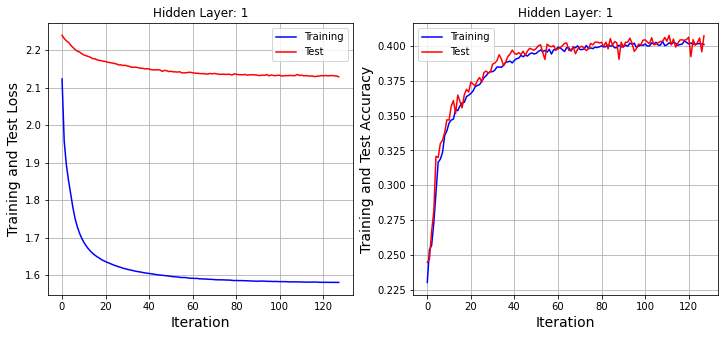

In [34]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss4, 'b', label = "Training")
ax[0].plot(range(128), test_loss4, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 1')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc4, 'b', label = "Training")
ax[1].plot(range(128), test_acc4, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 1')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 1.png")

In [35]:
model = BaselineModel(784,5,10)

train_loss4 = np.zeros(128)
test_loss4 = np.zeros(128)
train_acc4 = np.zeros(128)
test_acc4 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.7399711608886719, 'running_acc': 0.8045312166213989, 'loss': 1.254042387008667, 'acc': 0.6166499853134155, 'val_loss': 1.802873134613037, 'val_acc': 0.8181999921798706}
Epoch: 1
Training Loss: 1.254042387008667
Training Accuracy: 0.6166499853134155
Test Loss: 1.802873134613037
Test Accuracy: 0.8181999921798706


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.566860556602478, 'running_acc': 0.8356249928474426, 'loss': 0.5963077545166016, 'acc': 0.8334000110626221, 'val_loss': 1.7056543827056885, 'val_acc': 0.8486999869346619}
Epoch: 2
Training Loss: 0.5963077545166016
Training Accuracy: 0.8334000110626221
Test Loss: 1.7056543827056885
Test Accuracy: 0.8486999869346619


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.48163944482803345, 'running_acc': 0.8614062070846558, 'loss': 0.5096597075462341, 'acc': 0.8532166481018066, 'val_loss': 1.6797887086868286, 'val_acc': 0.8607999682426453}
Epoch: 3
Training Loss: 0.5096597075462341
Training Accuracy: 0.8532166481018066
Test Loss: 1.6797887086868286
Test Accuracy: 0.8607999682426453


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.47153180837631226, 'running_acc': 0.86328125, 'loss': 0.4732862710952759, 'acc': 0.8636833429336548, 'val_loss': 1.66593337059021, 'val_acc': 0.8682999610900879}
Epoch: 4
Training Loss: 0.4732862710952759
Training Accuracy: 0.8636833429336548
Test Loss: 1.66593337059021
Test Accuracy: 0.8682999610900879


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.4257371127605438, 'running_acc': 0.8829687237739563, 'loss': 0.44961002469062805, 'acc': 0.8709166646003723, 'val_loss': 1.65660560131073, 'val_acc': 0.8739999532699585}
Epoch: 5
Training Loss: 0.44961002469062805
Training Accuracy: 0.8709166646003723
Test Loss: 1.65660560131073
Test Accuracy: 0.8739999532699585


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.4120231866836548, 'running_acc': 0.8807812333106995, 'loss': 0.4335995614528656, 'acc': 0.8758167028427124, 'val_loss': 1.6519603729248047, 'val_acc': 0.8774999976158142}
Epoch: 6
Training Loss: 0.4335995614528656
Training Accuracy: 0.8758167028427124
Test Loss: 1.6519603729248047
Test Accuracy: 0.8774999976158142


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.4128667116165161, 'running_acc': 0.8814062476158142, 'loss': 0.4203663468360901, 'acc': 0.8793500065803528, 'val_loss': 1.6430782079696655, 'val_acc': 0.8837999701499939}
Epoch: 7
Training Loss: 0.4203663468360901
Training Accuracy: 0.8793500065803528
Test Loss: 1.6430782079696655
Test Accuracy: 0.8837999701499939


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.4154249131679535, 'running_acc': 0.879687488079071, 'loss': 0.41047659516334534, 'acc': 0.8820666670799255, 'val_loss': 1.6403782367706299, 'val_acc': 0.8852999806404114}
Epoch: 8
Training Loss: 0.41047659516334534
Training Accuracy: 0.8820666670799255
Test Loss: 1.6403782367706299
Test Accuracy: 0.8852999806404114


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.4069064259529114, 'running_acc': 0.8817187547683716, 'loss': 0.40207144618034363, 'acc': 0.8845833539962769, 'val_loss': 1.6351174116134644, 'val_acc': 0.8886999487876892}
Epoch: 9
Training Loss: 0.40207144618034363
Training Accuracy: 0.8845833539962769
Test Loss: 1.6351174116134644
Test Accuracy: 0.8886999487876892


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.39455920457839966, 'running_acc': 0.887499988079071, 'loss': 0.3950992822647095, 'acc': 0.8869333267211914, 'val_loss': 1.6368111371994019, 'val_acc': 0.8887999653816223}
Epoch: 10
Training Loss: 0.3950992822647095
Training Accuracy: 0.8869333267211914
Test Loss: 1.6368111371994019
Test Accuracy: 0.8887999653816223


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3987636864185333, 'running_acc': 0.8829687237739563, 'loss': 0.3892824053764343, 'acc': 0.8877666592597961, 'val_loss': 1.631150722503662, 'val_acc': 0.8903999924659729}
Epoch: 11
Training Loss: 0.3892824053764343
Training Accuracy: 0.8877666592597961
Test Loss: 1.631150722503662
Test Accuracy: 0.8903999924659729


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.37939906120300293, 'running_acc': 0.8921874761581421, 'loss': 0.38463884592056274, 'acc': 0.8901500105857849, 'val_loss': 1.628091812133789, 'val_acc': 0.8934999704360962}
Epoch: 12
Training Loss: 0.38463884592056274
Training Accuracy: 0.8901500105857849
Test Loss: 1.628091812133789
Test Accuracy: 0.8934999704360962


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3679152727127075, 'running_acc': 0.8934375047683716, 'loss': 0.3802829682826996, 'acc': 0.8903999924659729, 'val_loss': 1.6277070045471191, 'val_acc': 0.8933999538421631}
Epoch: 13
Training Loss: 0.3802829682826996
Training Accuracy: 0.8903999924659729
Test Loss: 1.6277070045471191
Test Accuracy: 0.8933999538421631


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.39380455017089844, 'running_acc': 0.891406238079071, 'loss': 0.3766685128211975, 'acc': 0.8914499878883362, 'val_loss': 1.6262149810791016, 'val_acc': 0.8922999501228333}
Epoch: 14
Training Loss: 0.3766685128211975
Training Accuracy: 0.8914499878883362
Test Loss: 1.6262149810791016
Test Accuracy: 0.8922999501228333


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3884828984737396, 'running_acc': 0.8860937356948853, 'loss': 0.37326374650001526, 'acc': 0.8924166560173035, 'val_loss': 1.623754620552063, 'val_acc': 0.8932999968528748}
Epoch: 15
Training Loss: 0.37326374650001526
Training Accuracy: 0.8924166560173035
Test Loss: 1.623754620552063
Test Accuracy: 0.8932999968528748


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3851366639137268, 'running_acc': 0.8896874785423279, 'loss': 0.3707420229911804, 'acc': 0.8935333490371704, 'val_loss': 1.6245334148406982, 'val_acc': 0.8921999931335449}
Epoch: 16
Training Loss: 0.3707420229911804
Training Accuracy: 0.8935333490371704
Test Loss: 1.6245334148406982
Test Accuracy: 0.8921999931335449


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3741421699523926, 'running_acc': 0.8928124904632568, 'loss': 0.36831963062286377, 'acc': 0.893500030040741, 'val_loss': 1.6213114261627197, 'val_acc': 0.8933999538421631}
Epoch: 17
Training Loss: 0.36831963062286377
Training Accuracy: 0.893500030040741
Test Loss: 1.6213114261627197
Test Accuracy: 0.8933999538421631


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3558749556541443, 'running_acc': 0.9009374976158142, 'loss': 0.3653506636619568, 'acc': 0.8949000239372253, 'val_loss': 1.622751235961914, 'val_acc': 0.8930000066757202}
Epoch: 18
Training Loss: 0.3653506636619568
Training Accuracy: 0.8949000239372253
Test Loss: 1.622751235961914
Test Accuracy: 0.8930000066757202


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.36044979095458984, 'running_acc': 0.8964062333106995, 'loss': 0.3635803759098053, 'acc': 0.8945833444595337, 'val_loss': 1.61966073513031, 'val_acc': 0.8941999673843384}
Epoch: 19
Training Loss: 0.3635803759098053
Training Accuracy: 0.8945833444595337
Test Loss: 1.61966073513031
Test Accuracy: 0.8941999673843384


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3222987949848175, 'running_acc': 0.9085937142372131, 'loss': 0.36170852184295654, 'acc': 0.8957499861717224, 'val_loss': 1.6181023120880127, 'val_acc': 0.8962000012397766}
Epoch: 20
Training Loss: 0.36170852184295654
Training Accuracy: 0.8957499861717224
Test Loss: 1.6181023120880127
Test Accuracy: 0.8962000012397766


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3782637417316437, 'running_acc': 0.8903124928474426, 'loss': 0.3599221408367157, 'acc': 0.8965499997138977, 'val_loss': 1.6187845468521118, 'val_acc': 0.8955999612808228}
Epoch: 21
Training Loss: 0.3599221408367157
Training Accuracy: 0.8965499997138977
Test Loss: 1.6187845468521118
Test Accuracy: 0.8955999612808228


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.36475253105163574, 'running_acc': 0.8996874690055847, 'loss': 0.3584459722042084, 'acc': 0.897100031375885, 'val_loss': 1.6190489530563354, 'val_acc': 0.8946999907493591}
Epoch: 22
Training Loss: 0.3584459722042084
Training Accuracy: 0.897100031375885
Test Loss: 1.6190489530563354
Test Accuracy: 0.8946999907493591


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3741968870162964, 'running_acc': 0.8903124928474426, 'loss': 0.35641756653785706, 'acc': 0.8972499966621399, 'val_loss': 1.6188679933547974, 'val_acc': 0.8925999999046326}
Epoch: 23
Training Loss: 0.35641756653785706
Training Accuracy: 0.8972499966621399
Test Loss: 1.6188679933547974
Test Accuracy: 0.8925999999046326


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3606078624725342, 'running_acc': 0.8967187404632568, 'loss': 0.35536301136016846, 'acc': 0.8977333307266235, 'val_loss': 1.6184861660003662, 'val_acc': 0.8949999809265137}
Epoch: 24
Training Loss: 0.35536301136016846
Training Accuracy: 0.8977333307266235
Test Loss: 1.6184861660003662
Test Accuracy: 0.8949999809265137


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3539716303348541, 'running_acc': 0.8970312476158142, 'loss': 0.3539286255836487, 'acc': 0.8975000381469727, 'val_loss': 1.6171554327011108, 'val_acc': 0.8983999490737915}
Epoch: 25
Training Loss: 0.3539286255836487
Training Accuracy: 0.8975000381469727
Test Loss: 1.6171554327011108
Test Accuracy: 0.8983999490737915


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3714805543422699, 'running_acc': 0.8939062356948853, 'loss': 0.3526398837566376, 'acc': 0.8983666896820068, 'val_loss': 1.6153044700622559, 'val_acc': 0.8974999785423279}
Epoch: 26
Training Loss: 0.3526398837566376
Training Accuracy: 0.8983666896820068
Test Loss: 1.6153044700622559
Test Accuracy: 0.8974999785423279


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3601970672607422, 'running_acc': 0.8954687118530273, 'loss': 0.3520042300224304, 'acc': 0.8980000019073486, 'val_loss': 1.615843653678894, 'val_acc': 0.8971999883651733}
Epoch: 27
Training Loss: 0.3520042300224304
Training Accuracy: 0.8980000019073486
Test Loss: 1.615843653678894
Test Accuracy: 0.8971999883651733


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.35193172097206116, 'running_acc': 0.8989062309265137, 'loss': 0.3505229949951172, 'acc': 0.8995000123977661, 'val_loss': 1.6159477233886719, 'val_acc': 0.8955000042915344}
Epoch: 28
Training Loss: 0.3505229949951172
Training Accuracy: 0.8995000123977661
Test Loss: 1.6159477233886719
Test Accuracy: 0.8955000042915344


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3522743284702301, 'running_acc': 0.8964062333106995, 'loss': 0.3487381637096405, 'acc': 0.8993333578109741, 'val_loss': 1.6162683963775635, 'val_acc': 0.896399974822998}
Epoch: 29
Training Loss: 0.3487381637096405
Training Accuracy: 0.8993333578109741
Test Loss: 1.6162683963775635
Test Accuracy: 0.896399974822998


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33632299304008484, 'running_acc': 0.8989062309265137, 'loss': 0.34886986017227173, 'acc': 0.899399995803833, 'val_loss': 1.612436294555664, 'val_acc': 0.8970999717712402}
Epoch: 30
Training Loss: 0.34886986017227173
Training Accuracy: 0.899399995803833
Test Loss: 1.612436294555664
Test Accuracy: 0.8970999717712402


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3513237535953522, 'running_acc': 0.8957812190055847, 'loss': 0.34751754999160767, 'acc': 0.9003000259399414, 'val_loss': 1.6145122051239014, 'val_acc': 0.8970999717712402}
Epoch: 31
Training Loss: 0.34751754999160767
Training Accuracy: 0.9003000259399414
Test Loss: 1.6145122051239014
Test Accuracy: 0.8970999717712402


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.35179075598716736, 'running_acc': 0.9001562595367432, 'loss': 0.3466135859489441, 'acc': 0.9002333283424377, 'val_loss': 1.6131646633148193, 'val_acc': 0.8977999687194824}
Epoch: 32
Training Loss: 0.3466135859489441
Training Accuracy: 0.9002333283424377
Test Loss: 1.6131646633148193
Test Accuracy: 0.8977999687194824


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33886459469795227, 'running_acc': 0.9018749594688416, 'loss': 0.3459702134132385, 'acc': 0.9005166888237, 'val_loss': 1.6122080087661743, 'val_acc': 0.8971999883651733}
Epoch: 33
Training Loss: 0.3459702134132385
Training Accuracy: 0.9005166888237
Test Loss: 1.6122080087661743
Test Accuracy: 0.8971999883651733


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3419814109802246, 'running_acc': 0.8968749642372131, 'loss': 0.3452027440071106, 'acc': 0.9005166888237, 'val_loss': 1.6134998798370361, 'val_acc': 0.8976999521255493}
Epoch: 34
Training Loss: 0.3452027440071106
Training Accuracy: 0.9005166888237
Test Loss: 1.6134998798370361
Test Accuracy: 0.8976999521255493


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.34494078159332275, 'running_acc': 0.9026562571525574, 'loss': 0.34444403648376465, 'acc': 0.9002833366394043, 'val_loss': 1.613463282585144, 'val_acc': 0.8956999778747559}
Epoch: 35
Training Loss: 0.34444403648376465
Training Accuracy: 0.9002833366394043
Test Loss: 1.613463282585144
Test Accuracy: 0.8956999778747559


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.34540271759033203, 'running_acc': 0.9028124809265137, 'loss': 0.3438401520252228, 'acc': 0.9012333154678345, 'val_loss': 1.6114847660064697, 'val_acc': 0.8994999527931213}
Epoch: 36
Training Loss: 0.3438401520252228
Training Accuracy: 0.9012333154678345
Test Loss: 1.6114847660064697
Test Accuracy: 0.8994999527931213


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3324899971485138, 'running_acc': 0.90296870470047, 'loss': 0.34288328886032104, 'acc': 0.9009833335876465, 'val_loss': 1.610774040222168, 'val_acc': 0.8984999656677246}
Epoch: 37
Training Loss: 0.34288328886032104
Training Accuracy: 0.9009833335876465
Test Loss: 1.610774040222168
Test Accuracy: 0.8984999656677246


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3458022475242615, 'running_acc': 0.8967187404632568, 'loss': 0.34229403734207153, 'acc': 0.9014333486557007, 'val_loss': 1.6112916469573975, 'val_acc': 0.8966999650001526}
Epoch: 38
Training Loss: 0.34229403734207153
Training Accuracy: 0.9014333486557007
Test Loss: 1.6112916469573975
Test Accuracy: 0.8966999650001526


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3350582718849182, 'running_acc': 0.9040625095367432, 'loss': 0.34195253252983093, 'acc': 0.9011666774749756, 'val_loss': 1.612605333328247, 'val_acc': 0.8987999558448792}
Epoch: 39
Training Loss: 0.34195253252983093
Training Accuracy: 0.9011666774749756
Test Loss: 1.612605333328247
Test Accuracy: 0.8987999558448792


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.32739055156707764, 'running_acc': 0.9081249833106995, 'loss': 0.34139484167099, 'acc': 0.9013333320617676, 'val_loss': 1.6109732389450073, 'val_acc': 0.898099958896637}
Epoch: 40
Training Loss: 0.34139484167099
Training Accuracy: 0.9013333320617676
Test Loss: 1.6109732389450073
Test Accuracy: 0.898099958896637


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.37167561054229736, 'running_acc': 0.8965624570846558, 'loss': 0.34024545550346375, 'acc': 0.9021833539009094, 'val_loss': 1.6109743118286133, 'val_acc': 0.8974999785423279}
Epoch: 41
Training Loss: 0.34024545550346375
Training Accuracy: 0.9021833539009094
Test Loss: 1.6109743118286133
Test Accuracy: 0.8974999785423279


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3322065770626068, 'running_acc': 0.9081249833106995, 'loss': 0.3402062654495239, 'acc': 0.9014500379562378, 'val_loss': 1.6109874248504639, 'val_acc': 0.8980000019073486}
Epoch: 42
Training Loss: 0.3402062654495239
Training Accuracy: 0.9014500379562378
Test Loss: 1.6109874248504639
Test Accuracy: 0.8980000019073486


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33940649032592773, 'running_acc': 0.9043749570846558, 'loss': 0.33955588936805725, 'acc': 0.9022166728973389, 'val_loss': 1.6104096174240112, 'val_acc': 0.897599995136261}
Epoch: 43
Training Loss: 0.33955588936805725
Training Accuracy: 0.9022166728973389
Test Loss: 1.6104096174240112
Test Accuracy: 0.897599995136261


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.355241984128952, 'running_acc': 0.8964062333106995, 'loss': 0.3390449583530426, 'acc': 0.9018499851226807, 'val_loss': 1.610316514968872, 'val_acc': 0.8982999920845032}
Epoch: 44
Training Loss: 0.3390449583530426
Training Accuracy: 0.9018499851226807
Test Loss: 1.610316514968872
Test Accuracy: 0.8982999920845032


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3210139870643616, 'running_acc': 0.9053124785423279, 'loss': 0.3385547995567322, 'acc': 0.9026166796684265, 'val_loss': 1.6106847524642944, 'val_acc': 0.8971999883651733}
Epoch: 45
Training Loss: 0.3385547995567322
Training Accuracy: 0.9026166796684265
Test Loss: 1.6106847524642944
Test Accuracy: 0.8971999883651733


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.32748943567276, 'running_acc': 0.9043749570846558, 'loss': 0.33820468187332153, 'acc': 0.902899980545044, 'val_loss': 1.6086788177490234, 'val_acc': 0.8973999619483948}
Epoch: 46
Training Loss: 0.33820468187332153
Training Accuracy: 0.902899980545044
Test Loss: 1.6086788177490234
Test Accuracy: 0.8973999619483948


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33094778656959534, 'running_acc': 0.9051562547683716, 'loss': 0.3375847041606903, 'acc': 0.9020833373069763, 'val_loss': 1.6085965633392334, 'val_acc': 0.8994999527931213}
Epoch: 47
Training Loss: 0.3375847041606903
Training Accuracy: 0.9020833373069763
Test Loss: 1.6085965633392334
Test Accuracy: 0.8994999527931213


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3380432426929474, 'running_acc': 0.9032812118530273, 'loss': 0.3372594714164734, 'acc': 0.9034000039100647, 'val_loss': 1.6103794574737549, 'val_acc': 0.8996999859809875}
Epoch: 48
Training Loss: 0.3372594714164734
Training Accuracy: 0.9034000039100647
Test Loss: 1.6103794574737549
Test Accuracy: 0.8996999859809875


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3247820734977722, 'running_acc': 0.9076562523841858, 'loss': 0.33650410175323486, 'acc': 0.9030333161354065, 'val_loss': 1.6117429733276367, 'val_acc': 0.897599995136261}
Epoch: 49
Training Loss: 0.33650410175323486
Training Accuracy: 0.9030333161354065
Test Loss: 1.6117429733276367
Test Accuracy: 0.897599995136261


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3270007371902466, 'running_acc': 0.90625, 'loss': 0.3367868661880493, 'acc': 0.9035500288009644, 'val_loss': 1.6072325706481934, 'val_acc': 0.8986999988555908}
Epoch: 50
Training Loss: 0.3367868661880493
Training Accuracy: 0.9035500288009644
Test Loss: 1.6072325706481934
Test Accuracy: 0.8986999988555908


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33049651980400085, 'running_acc': 0.9032812118530273, 'loss': 0.33612123131752014, 'acc': 0.9033499956130981, 'val_loss': 1.6073647737503052, 'val_acc': 0.8977999687194824}
Epoch: 51
Training Loss: 0.33612123131752014
Training Accuracy: 0.9033499956130981
Test Loss: 1.6073647737503052
Test Accuracy: 0.8977999687194824


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3418232798576355, 'running_acc': 0.9006249904632568, 'loss': 0.3353087604045868, 'acc': 0.9034667015075684, 'val_loss': 1.6099705696105957, 'val_acc': 0.8986999988555908}
Epoch: 52
Training Loss: 0.3353087604045868
Training Accuracy: 0.9034667015075684
Test Loss: 1.6099705696105957
Test Accuracy: 0.8986999988555908


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3470470607280731, 'running_acc': 0.9034374952316284, 'loss': 0.3346494138240814, 'acc': 0.9033166766166687, 'val_loss': 1.6087325811386108, 'val_acc': 0.8976999521255493}
Epoch: 53
Training Loss: 0.3346494138240814
Training Accuracy: 0.9033166766166687
Test Loss: 1.6087325811386108
Test Accuracy: 0.8976999521255493


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33580073714256287, 'running_acc': 0.903124988079071, 'loss': 0.3342612385749817, 'acc': 0.9034333229064941, 'val_loss': 1.6102315187454224, 'val_acc': 0.899399995803833}
Epoch: 54
Training Loss: 0.3342612385749817
Training Accuracy: 0.9034333229064941
Test Loss: 1.6102315187454224
Test Accuracy: 0.899399995803833


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.355731725692749, 'running_acc': 0.9026562571525574, 'loss': 0.3342653810977936, 'acc': 0.9041000008583069, 'val_loss': 1.6072849035263062, 'val_acc': 0.899899959564209}
Epoch: 55
Training Loss: 0.3342653810977936
Training Accuracy: 0.9041000008583069
Test Loss: 1.6072849035263062
Test Accuracy: 0.899899959564209


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3330921232700348, 'running_acc': 0.8982812166213989, 'loss': 0.33389511704444885, 'acc': 0.9036333560943604, 'val_loss': 1.6069518327713013, 'val_acc': 0.9000999927520752}
Epoch: 56
Training Loss: 0.33389511704444885
Training Accuracy: 0.9036333560943604
Test Loss: 1.6069518327713013
Test Accuracy: 0.9000999927520752


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3349120020866394, 'running_acc': 0.9067187309265137, 'loss': 0.3337254822254181, 'acc': 0.9036666750907898, 'val_loss': 1.607527256011963, 'val_acc': 0.8992999792098999}
Epoch: 57
Training Loss: 0.3337254822254181
Training Accuracy: 0.9036666750907898
Test Loss: 1.607527256011963
Test Accuracy: 0.8992999792098999


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.34632962942123413, 'running_acc': 0.903124988079071, 'loss': 0.3337722420692444, 'acc': 0.9045833349227905, 'val_loss': 1.6074204444885254, 'val_acc': 0.9007999897003174}
Epoch: 58
Training Loss: 0.3337722420692444
Training Accuracy: 0.9045833349227905
Test Loss: 1.6074204444885254
Test Accuracy: 0.9007999897003174


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.34806814789772034, 'running_acc': 0.9034374952316284, 'loss': 0.33263230323791504, 'acc': 0.9043000340461731, 'val_loss': 1.6072468757629395, 'val_acc': 0.8983999490737915}
Epoch: 59
Training Loss: 0.33263230323791504
Training Accuracy: 0.9043000340461731
Test Loss: 1.6072468757629395
Test Accuracy: 0.8983999490737915


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.326612263917923, 'running_acc': 0.9056249856948853, 'loss': 0.33211201429367065, 'acc': 0.9046000242233276, 'val_loss': 1.6066149473190308, 'val_acc': 0.899399995803833}
Epoch: 60
Training Loss: 0.33211201429367065
Training Accuracy: 0.9046000242233276
Test Loss: 1.6066149473190308
Test Accuracy: 0.899399995803833


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.31406569480895996, 'running_acc': 0.9084374904632568, 'loss': 0.3321132957935333, 'acc': 0.9051833152770996, 'val_loss': 1.6066924333572388, 'val_acc': 0.9020999670028687}
Epoch: 61
Training Loss: 0.3321132957935333
Training Accuracy: 0.9051833152770996
Test Loss: 1.6066924333572388
Test Accuracy: 0.9020999670028687


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33300265669822693, 'running_acc': 0.903124988079071, 'loss': 0.33184725046157837, 'acc': 0.9043333530426025, 'val_loss': 1.6059056520462036, 'val_acc': 0.8994999527931213}
Epoch: 62
Training Loss: 0.33184725046157837
Training Accuracy: 0.9043333530426025
Test Loss: 1.6059056520462036
Test Accuracy: 0.8994999527931213


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.31930670142173767, 'running_acc': 0.9106249809265137, 'loss': 0.3313665986061096, 'acc': 0.9052667021751404, 'val_loss': 1.6055980920791626, 'val_acc': 0.8988999724388123}
Epoch: 63
Training Loss: 0.3313665986061096
Training Accuracy: 0.9052667021751404
Test Loss: 1.6055980920791626
Test Accuracy: 0.8988999724388123


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.30776888132095337, 'running_acc': 0.9103124737739563, 'loss': 0.3315596580505371, 'acc': 0.9046833515167236, 'val_loss': 1.6056801080703735, 'val_acc': 0.9007999897003174}
Epoch: 64
Training Loss: 0.3315596580505371
Training Accuracy: 0.9046833515167236
Test Loss: 1.6056801080703735
Test Accuracy: 0.9007999897003174


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3230917155742645, 'running_acc': 0.9039062261581421, 'loss': 0.3312080502510071, 'acc': 0.9046333432197571, 'val_loss': 1.6060446500778198, 'val_acc': 0.8995999693870544}
Epoch: 65
Training Loss: 0.3312080502510071
Training Accuracy: 0.9046333432197571
Test Loss: 1.6060446500778198
Test Accuracy: 0.8995999693870544


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.29776954650878906, 'running_acc': 0.9115625023841858, 'loss': 0.33055204153060913, 'acc': 0.9052500128746033, 'val_loss': 1.6057653427124023, 'val_acc': 0.9009999632835388}
Epoch: 66
Training Loss: 0.33055204153060913
Training Accuracy: 0.9052500128746033
Test Loss: 1.6057653427124023
Test Accuracy: 0.9009999632835388


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3199566602706909, 'running_acc': 0.9054687023162842, 'loss': 0.33014148473739624, 'acc': 0.9051499962806702, 'val_loss': 1.6071103811264038, 'val_acc': 0.9016000032424927}
Epoch: 67
Training Loss: 0.33014148473739624
Training Accuracy: 0.9051499962806702
Test Loss: 1.6071103811264038
Test Accuracy: 0.9016000032424927


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3271338641643524, 'running_acc': 0.9035937190055847, 'loss': 0.3297787606716156, 'acc': 0.9053833484649658, 'val_loss': 1.6062802076339722, 'val_acc': 0.9012999534606934}
Epoch: 68
Training Loss: 0.3297787606716156
Training Accuracy: 0.9053833484649658
Test Loss: 1.6062802076339722
Test Accuracy: 0.9012999534606934


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3505719304084778, 'running_acc': 0.9014062285423279, 'loss': 0.3292050361633301, 'acc': 0.9059333205223083, 'val_loss': 1.6056663990020752, 'val_acc': 0.9003999829292297}
Epoch: 69
Training Loss: 0.3292050361633301
Training Accuracy: 0.9059333205223083
Test Loss: 1.6056663990020752
Test Accuracy: 0.9003999829292297


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3315078914165497, 'running_acc': 0.9039062261581421, 'loss': 0.3298393785953522, 'acc': 0.9057666659355164, 'val_loss': 1.606459617614746, 'val_acc': 0.8991000056266785}
Epoch: 70
Training Loss: 0.3298393785953522
Training Accuracy: 0.9057666659355164
Test Loss: 1.606459617614746
Test Accuracy: 0.8991000056266785


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3130536377429962, 'running_acc': 0.9121874570846558, 'loss': 0.32963231205940247, 'acc': 0.906083345413208, 'val_loss': 1.6049410104751587, 'val_acc': 0.9005999565124512}
Epoch: 71
Training Loss: 0.32963231205940247
Training Accuracy: 0.906083345413208
Test Loss: 1.6049410104751587
Test Accuracy: 0.9005999565124512


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.32382503151893616, 'running_acc': 0.9074999690055847, 'loss': 0.32895728945732117, 'acc': 0.9058666825294495, 'val_loss': 1.6048336029052734, 'val_acc': 0.902999997138977}
Epoch: 72
Training Loss: 0.32895728945732117
Training Accuracy: 0.9058666825294495
Test Loss: 1.6048336029052734
Test Accuracy: 0.902999997138977


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3526826798915863, 'running_acc': 0.8987500071525574, 'loss': 0.32908135652542114, 'acc': 0.9052667021751404, 'val_loss': 1.6070184707641602, 'val_acc': 0.9009000062942505}
Epoch: 73
Training Loss: 0.32908135652542114
Training Accuracy: 0.9052667021751404
Test Loss: 1.6070184707641602
Test Accuracy: 0.9009000062942505


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3367549777030945, 'running_acc': 0.9043749570846558, 'loss': 0.32840386033058167, 'acc': 0.9062166810035706, 'val_loss': 1.6071457862854004, 'val_acc': 0.9021999835968018}
Epoch: 74
Training Loss: 0.32840386033058167
Training Accuracy: 0.9062166810035706
Test Loss: 1.6071457862854004
Test Accuracy: 0.9021999835968018


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3168379068374634, 'running_acc': 0.9082812070846558, 'loss': 0.32811254262924194, 'acc': 0.9063500165939331, 'val_loss': 1.6060844659805298, 'val_acc': 0.9007999897003174}
Epoch: 75
Training Loss: 0.32811254262924194
Training Accuracy: 0.9063500165939331
Test Loss: 1.6060844659805298
Test Accuracy: 0.9007999897003174


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3336201012134552, 'running_acc': 0.9089062213897705, 'loss': 0.32817792892456055, 'acc': 0.9070667028427124, 'val_loss': 1.6052325963974, 'val_acc': 0.9007999897003174}
Epoch: 76
Training Loss: 0.32817792892456055
Training Accuracy: 0.9070667028427124
Test Loss: 1.6052325963974
Test Accuracy: 0.9007999897003174


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.32333654165267944, 'running_acc': 0.8999999761581421, 'loss': 0.32806071639060974, 'acc': 0.906000018119812, 'val_loss': 1.6068154573440552, 'val_acc': 0.9007999897003174}
Epoch: 77
Training Loss: 0.32806071639060974
Training Accuracy: 0.906000018119812
Test Loss: 1.6068154573440552
Test Accuracy: 0.9007999897003174


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3215925097465515, 'running_acc': 0.907031238079071, 'loss': 0.3277978003025055, 'acc': 0.9055500030517578, 'val_loss': 1.605506420135498, 'val_acc': 0.9020999670028687}
Epoch: 78
Training Loss: 0.3277978003025055
Training Accuracy: 0.9055500030517578
Test Loss: 1.605506420135498
Test Accuracy: 0.9020999670028687


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.30697786808013916, 'running_acc': 0.9078124761581421, 'loss': 0.3276134729385376, 'acc': 0.9065666794776917, 'val_loss': 1.6037819385528564, 'val_acc': 0.9009000062942505}
Epoch: 79
Training Loss: 0.3276134729385376
Training Accuracy: 0.9065666794776917
Test Loss: 1.6037819385528564
Test Accuracy: 0.9009000062942505


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.32485708594322205, 'running_acc': 0.9056249856948853, 'loss': 0.32652097940444946, 'acc': 0.906333327293396, 'val_loss': 1.6034464836120605, 'val_acc': 0.9027999639511108}
Epoch: 80
Training Loss: 0.32652097940444946
Training Accuracy: 0.906333327293396
Test Loss: 1.6034464836120605
Test Accuracy: 0.9027999639511108


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3362407088279724, 'running_acc': 0.9049999713897705, 'loss': 0.32688602805137634, 'acc': 0.9068333506584167, 'val_loss': 1.6038661003112793, 'val_acc': 0.9024999737739563}
Epoch: 81
Training Loss: 0.32688602805137634
Training Accuracy: 0.9068333506584167
Test Loss: 1.6038661003112793
Test Accuracy: 0.9024999737739563


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.324710875749588, 'running_acc': 0.9096874594688416, 'loss': 0.3267441689968109, 'acc': 0.9070166945457458, 'val_loss': 1.6036045551300049, 'val_acc': 0.8991000056266785}
Epoch: 82
Training Loss: 0.3267441689968109
Training Accuracy: 0.9070166945457458
Test Loss: 1.6036045551300049
Test Accuracy: 0.8991000056266785


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33325889706611633, 'running_acc': 0.9021874666213989, 'loss': 0.32646992802619934, 'acc': 0.9064500331878662, 'val_loss': 1.604167103767395, 'val_acc': 0.902999997138977}
Epoch: 83
Training Loss: 0.32646992802619934
Training Accuracy: 0.9064500331878662
Test Loss: 1.604167103767395
Test Accuracy: 0.902999997138977


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3412959575653076, 'running_acc': 0.9039062261581421, 'loss': 0.3261069655418396, 'acc': 0.9074500203132629, 'val_loss': 1.6050306558609009, 'val_acc': 0.9006999731063843}
Epoch: 84
Training Loss: 0.3261069655418396
Training Accuracy: 0.9074500203132629
Test Loss: 1.6050306558609009
Test Accuracy: 0.9006999731063843


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.329131156206131, 'running_acc': 0.9043749570846558, 'loss': 0.32611045241355896, 'acc': 0.9063166975975037, 'val_loss': 1.603987693786621, 'val_acc': 0.901699960231781}
Epoch: 85
Training Loss: 0.32611045241355896
Training Accuracy: 0.9063166975975037
Test Loss: 1.603987693786621
Test Accuracy: 0.901699960231781


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.34422144293785095, 'running_acc': 0.9024999737739563, 'loss': 0.3257438540458679, 'acc': 0.9067500233650208, 'val_loss': 1.6055576801300049, 'val_acc': 0.8998000025749207}
Epoch: 86
Training Loss: 0.3257438540458679
Training Accuracy: 0.9067500233650208
Test Loss: 1.6055576801300049
Test Accuracy: 0.8998000025749207


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3338545858860016, 'running_acc': 0.9020312428474426, 'loss': 0.32620373368263245, 'acc': 0.9068833589553833, 'val_loss': 1.6089186668395996, 'val_acc': 0.9002999663352966}
Epoch: 87
Training Loss: 0.32620373368263245
Training Accuracy: 0.9068833589553833
Test Loss: 1.6089186668395996
Test Accuracy: 0.9002999663352966


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3080974221229553, 'running_acc': 0.9073437452316284, 'loss': 0.32538142800331116, 'acc': 0.9072333574295044, 'val_loss': 1.6043846607208252, 'val_acc': 0.9005999565124512}
Epoch: 88
Training Loss: 0.32538142800331116
Training Accuracy: 0.9072333574295044
Test Loss: 1.6043846607208252
Test Accuracy: 0.9005999565124512


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3290249705314636, 'running_acc': 0.9053124785423279, 'loss': 0.32541623711586, 'acc': 0.9065666794776917, 'val_loss': 1.6044209003448486, 'val_acc': 0.9020999670028687}
Epoch: 89
Training Loss: 0.32541623711586
Training Accuracy: 0.9065666794776917
Test Loss: 1.6044209003448486
Test Accuracy: 0.9020999670028687


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3300193250179291, 'running_acc': 0.9060937166213989, 'loss': 0.32531118392944336, 'acc': 0.9076499938964844, 'val_loss': 1.60570228099823, 'val_acc': 0.8974999785423279}
Epoch: 90
Training Loss: 0.32531118392944336
Training Accuracy: 0.9076499938964844
Test Loss: 1.60570228099823
Test Accuracy: 0.8974999785423279


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33034464716911316, 'running_acc': 0.9092187285423279, 'loss': 0.3251907229423523, 'acc': 0.9064666628837585, 'val_loss': 1.6029785871505737, 'val_acc': 0.901699960231781}
Epoch: 91
Training Loss: 0.3251907229423523
Training Accuracy: 0.9064666628837585
Test Loss: 1.6029785871505737
Test Accuracy: 0.901699960231781


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3223823606967926, 'running_acc': 0.9076562523841858, 'loss': 0.3249606192111969, 'acc': 0.9070833325386047, 'val_loss': 1.604014277458191, 'val_acc': 0.9021999835968018}
Epoch: 92
Training Loss: 0.3249606192111969
Training Accuracy: 0.9070833325386047
Test Loss: 1.604014277458191
Test Accuracy: 0.9021999835968018


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3236701488494873, 'running_acc': 0.9095312356948853, 'loss': 0.3244665563106537, 'acc': 0.9066666960716248, 'val_loss': 1.6053719520568848, 'val_acc': 0.899899959564209}
Epoch: 93
Training Loss: 0.3244665563106537
Training Accuracy: 0.9066666960716248
Test Loss: 1.6053719520568848
Test Accuracy: 0.899899959564209


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.32242870330810547, 'running_acc': 0.90625, 'loss': 0.32452112436294556, 'acc': 0.907550036907196, 'val_loss': 1.6039332151412964, 'val_acc': 0.901199996471405}
Epoch: 94
Training Loss: 0.32452112436294556
Training Accuracy: 0.907550036907196
Test Loss: 1.6039332151412964
Test Accuracy: 0.901199996471405


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.30657657980918884, 'running_acc': 0.9104687571525574, 'loss': 0.3241526782512665, 'acc': 0.9068666696548462, 'val_loss': 1.6041232347488403, 'val_acc': 0.9009999632835388}
Epoch: 95
Training Loss: 0.3241526782512665
Training Accuracy: 0.9068666696548462
Test Loss: 1.6041232347488403
Test Accuracy: 0.9009999632835388


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33107638359069824, 'running_acc': 0.9056249856948853, 'loss': 0.3241317570209503, 'acc': 0.907966673374176, 'val_loss': 1.6033167839050293, 'val_acc': 0.9017999768257141}
Epoch: 96
Training Loss: 0.3241317570209503
Training Accuracy: 0.907966673374176
Test Loss: 1.6033167839050293
Test Accuracy: 0.9017999768257141


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33635085821151733, 'running_acc': 0.9015624523162842, 'loss': 0.3240136504173279, 'acc': 0.9072333574295044, 'val_loss': 1.6039783954620361, 'val_acc': 0.8991999626159668}
Epoch: 97
Training Loss: 0.3240136504173279
Training Accuracy: 0.9072333574295044
Test Loss: 1.6039783954620361
Test Accuracy: 0.8991999626159668


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.32501116394996643, 'running_acc': 0.9039062261581421, 'loss': 0.32397279143333435, 'acc': 0.9072666764259338, 'val_loss': 1.6032871007919312, 'val_acc': 0.9012999534606934}
Epoch: 98
Training Loss: 0.32397279143333435
Training Accuracy: 0.9072666764259338
Test Loss: 1.6032871007919312
Test Accuracy: 0.9012999534606934


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3300240933895111, 'running_acc': 0.9037500023841858, 'loss': 0.3238251507282257, 'acc': 0.9073833227157593, 'val_loss': 1.6032755374908447, 'val_acc': 0.9017999768257141}
Epoch: 99
Training Loss: 0.3238251507282257
Training Accuracy: 0.9073833227157593
Test Loss: 1.6032755374908447
Test Accuracy: 0.9017999768257141


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.32480213046073914, 'running_acc': 0.9090625047683716, 'loss': 0.3236512541770935, 'acc': 0.9076833724975586, 'val_loss': 1.6023772954940796, 'val_acc': 0.9019999504089355}
Epoch: 100
Training Loss: 0.3236512541770935
Training Accuracy: 0.9076833724975586
Test Loss: 1.6023772954940796
Test Accuracy: 0.9019999504089355


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3256761133670807, 'running_acc': 0.9059374928474426, 'loss': 0.32350224256515503, 'acc': 0.9070166945457458, 'val_loss': 1.601560115814209, 'val_acc': 0.901199996471405}
Epoch: 101
Training Loss: 0.32350224256515503
Training Accuracy: 0.9070166945457458
Test Loss: 1.601560115814209
Test Accuracy: 0.901199996471405


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.31958523392677307, 'running_acc': 0.91078120470047, 'loss': 0.323885053396225, 'acc': 0.906499981880188, 'val_loss': 1.601934790611267, 'val_acc': 0.9009000062942505}
Epoch: 102
Training Loss: 0.323885053396225
Training Accuracy: 0.906499981880188
Test Loss: 1.601934790611267
Test Accuracy: 0.9009000062942505


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3180278539657593, 'running_acc': 0.9090625047683716, 'loss': 0.323822945356369, 'acc': 0.9076499938964844, 'val_loss': 1.602652907371521, 'val_acc': 0.9012999534606934}
Epoch: 103
Training Loss: 0.323822945356369
Training Accuracy: 0.9076499938964844
Test Loss: 1.602652907371521
Test Accuracy: 0.9012999534606934


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3146696388721466, 'running_acc': 0.9079686999320984, 'loss': 0.3240198791027069, 'acc': 0.9080166816711426, 'val_loss': 1.602677822113037, 'val_acc': 0.9027000069618225}
Epoch: 104
Training Loss: 0.3240198791027069
Training Accuracy: 0.9080166816711426
Test Loss: 1.602677822113037
Test Accuracy: 0.9027000069618225


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.30847227573394775, 'running_acc': 0.9121874570846558, 'loss': 0.3231489956378937, 'acc': 0.9077500104904175, 'val_loss': 1.6030359268188477, 'val_acc': 0.9020999670028687}
Epoch: 105
Training Loss: 0.3231489956378937
Training Accuracy: 0.9077500104904175
Test Loss: 1.6030359268188477
Test Accuracy: 0.9020999670028687


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3335873782634735, 'running_acc': 0.9073437452316284, 'loss': 0.3229563534259796, 'acc': 0.9069166779518127, 'val_loss': 1.603773593902588, 'val_acc': 0.9020999670028687}
Epoch: 106
Training Loss: 0.3229563534259796
Training Accuracy: 0.9069166779518127
Test Loss: 1.603773593902588
Test Accuracy: 0.9020999670028687


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33431583642959595, 'running_acc': 0.9057812094688416, 'loss': 0.3231549561023712, 'acc': 0.9077666997909546, 'val_loss': 1.6031564474105835, 'val_acc': 0.9009999632835388}
Epoch: 107
Training Loss: 0.3231549561023712
Training Accuracy: 0.9077666997909546
Test Loss: 1.6031564474105835
Test Accuracy: 0.9009999632835388


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3473604917526245, 'running_acc': 0.8998437523841858, 'loss': 0.32295042276382446, 'acc': 0.9074000120162964, 'val_loss': 1.603378415107727, 'val_acc': 0.9002999663352966}
Epoch: 108
Training Loss: 0.32295042276382446
Training Accuracy: 0.9074000120162964
Test Loss: 1.603378415107727
Test Accuracy: 0.9002999663352966


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3385222554206848, 'running_acc': 0.9006249904632568, 'loss': 0.32226046919822693, 'acc': 0.9080666899681091, 'val_loss': 1.6057262420654297, 'val_acc': 0.8994999527931213}
Epoch: 109
Training Loss: 0.32226046919822693
Training Accuracy: 0.9080666899681091
Test Loss: 1.6057262420654297
Test Accuracy: 0.8994999527931213


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.31221553683280945, 'running_acc': 0.9078124761581421, 'loss': 0.3228769302368164, 'acc': 0.9076166749000549, 'val_loss': 1.6014610528945923, 'val_acc': 0.902899980545044}
Epoch: 110
Training Loss: 0.3228769302368164
Training Accuracy: 0.9076166749000549
Test Loss: 1.6014610528945923
Test Accuracy: 0.902899980545044


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33314865827560425, 'running_acc': 0.9067187309265137, 'loss': 0.32273921370506287, 'acc': 0.907716691493988, 'val_loss': 1.601931095123291, 'val_acc': 0.9032999873161316}
Epoch: 111
Training Loss: 0.32273921370506287
Training Accuracy: 0.907716691493988
Test Loss: 1.601931095123291
Test Accuracy: 0.9032999873161316


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3320484161376953, 'running_acc': 0.9054687023162842, 'loss': 0.3224624693393707, 'acc': 0.907550036907196, 'val_loss': 1.6035517454147339, 'val_acc': 0.9025999903678894}
Epoch: 112
Training Loss: 0.3224624693393707
Training Accuracy: 0.907550036907196
Test Loss: 1.6035517454147339
Test Accuracy: 0.9025999903678894


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3257082402706146, 'running_acc': 0.910937488079071, 'loss': 0.322225958108902, 'acc': 0.9079000353813171, 'val_loss': 1.6017484664916992, 'val_acc': 0.9025999903678894}
Epoch: 113
Training Loss: 0.322225958108902
Training Accuracy: 0.9079000353813171
Test Loss: 1.6017484664916992
Test Accuracy: 0.9025999903678894


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3310980796813965, 'running_acc': 0.9009374976158142, 'loss': 0.32167404890060425, 'acc': 0.908133327960968, 'val_loss': 1.6038824319839478, 'val_acc': 0.8992999792098999}
Epoch: 114
Training Loss: 0.32167404890060425
Training Accuracy: 0.908133327960968
Test Loss: 1.6038824319839478
Test Accuracy: 0.8992999792098999


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3153556287288666, 'running_acc': 0.9076562523841858, 'loss': 0.3225553035736084, 'acc': 0.9076833724975586, 'val_loss': 1.602893352508545, 'val_acc': 0.9020999670028687}
Epoch: 115
Training Loss: 0.3225553035736084
Training Accuracy: 0.9076833724975586
Test Loss: 1.602893352508545
Test Accuracy: 0.9020999670028687


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3258035480976105, 'running_acc': 0.9093749523162842, 'loss': 0.3218051493167877, 'acc': 0.9078166484832764, 'val_loss': 1.6005538702011108, 'val_acc': 0.9010999798774719}
Epoch: 116
Training Loss: 0.3218051493167877
Training Accuracy: 0.9078166484832764
Test Loss: 1.6005538702011108
Test Accuracy: 0.9010999798774719


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.31519657373428345, 'running_acc': 0.9121874570846558, 'loss': 0.3221185803413391, 'acc': 0.90788334608078, 'val_loss': 1.601391077041626, 'val_acc': 0.9024999737739563}
Epoch: 117
Training Loss: 0.3221185803413391
Training Accuracy: 0.90788334608078
Test Loss: 1.601391077041626
Test Accuracy: 0.9024999737739563


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.35447418689727783, 'running_acc': 0.9054687023162842, 'loss': 0.32212188839912415, 'acc': 0.9072166681289673, 'val_loss': 1.6023694276809692, 'val_acc': 0.902999997138977}
Epoch: 118
Training Loss: 0.32212188839912415
Training Accuracy: 0.9072166681289673
Test Loss: 1.6023694276809692
Test Accuracy: 0.902999997138977


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.317735880613327, 'running_acc': 0.9093749523162842, 'loss': 0.32116085290908813, 'acc': 0.9077500104904175, 'val_loss': 1.603704810142517, 'val_acc': 0.9005999565124512}
Epoch: 119
Training Loss: 0.32116085290908813
Training Accuracy: 0.9077500104904175
Test Loss: 1.603704810142517
Test Accuracy: 0.9005999565124512


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3371146321296692, 'running_acc': 0.9006249904632568, 'loss': 0.32172590494155884, 'acc': 0.9078166484832764, 'val_loss': 1.6039154529571533, 'val_acc': 0.9017999768257141}
Epoch: 120
Training Loss: 0.32172590494155884
Training Accuracy: 0.9078166484832764
Test Loss: 1.6039154529571533
Test Accuracy: 0.9017999768257141


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3261854350566864, 'running_acc': 0.9059374928474426, 'loss': 0.32162582874298096, 'acc': 0.9078500270843506, 'val_loss': 1.6014819145202637, 'val_acc': 0.9012999534606934}
Epoch: 121
Training Loss: 0.32162582874298096
Training Accuracy: 0.9078500270843506
Test Loss: 1.6014819145202637
Test Accuracy: 0.9012999534606934


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3320109248161316, 'running_acc': 0.9053124785423279, 'loss': 0.32203564047813416, 'acc': 0.9075666666030884, 'val_loss': 1.6030571460723877, 'val_acc': 0.9009999632835388}
Epoch: 122
Training Loss: 0.32203564047813416
Training Accuracy: 0.9075666666030884
Test Loss: 1.6030571460723877
Test Accuracy: 0.9009999632835388


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.31654348969459534, 'running_acc': 0.90625, 'loss': 0.3212512731552124, 'acc': 0.9083666801452637, 'val_loss': 1.6042213439941406, 'val_acc': 0.8999999761581421}
Epoch: 123
Training Loss: 0.3212512731552124
Training Accuracy: 0.9083666801452637
Test Loss: 1.6042213439941406
Test Accuracy: 0.8999999761581421


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.33215564489364624, 'running_acc': 0.9065625071525574, 'loss': 0.32128021121025085, 'acc': 0.9081667065620422, 'val_loss': 1.6020370721817017, 'val_acc': 0.9003999829292297}
Epoch: 124
Training Loss: 0.32128021121025085
Training Accuracy: 0.9081667065620422
Test Loss: 1.6020370721817017
Test Accuracy: 0.9003999829292297


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.32356587052345276, 'running_acc': 0.9093749523162842, 'loss': 0.32106393575668335, 'acc': 0.9091333150863647, 'val_loss': 1.6036655902862549, 'val_acc': 0.9017999768257141}
Epoch: 125
Training Loss: 0.32106393575668335
Training Accuracy: 0.9091333150863647
Test Loss: 1.6036655902862549
Test Accuracy: 0.9017999768257141


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.310794472694397, 'running_acc': 0.9093749523162842, 'loss': 0.3209969997406006, 'acc': 0.9076833724975586, 'val_loss': 1.6027415990829468, 'val_acc': 0.9004999995231628}
Epoch: 126
Training Loss: 0.3209969997406006
Training Accuracy: 0.9076833724975586
Test Loss: 1.6027415990829468
Test Accuracy: 0.9004999995231628


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3123655319213867, 'running_acc': 0.9090625047683716, 'loss': 0.3211458623409271, 'acc': 0.9080666899681091, 'val_loss': 1.604046106338501, 'val_acc': 0.9001999497413635}
Epoch: 127
Training Loss: 0.3211458623409271
Training Accuracy: 0.9080666899681091
Test Loss: 1.604046106338501
Test Accuracy: 0.9001999497413635


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.34731894731521606, 'running_acc': 0.8999999761581421, 'loss': 0.32084864377975464, 'acc': 0.9079166650772095, 'val_loss': 1.6029733419418335, 'val_acc': 0.8994999527931213}
Epoch: 128
Training Loss: 0.32084864377975464
Training Accuracy: 0.9079166650772095
Test Loss: 1.6029733419418335
Test Accuracy: 0.8994999527931213


[{'running_loss': 0.7399711608886719,
  'running_acc': 0.8045312166213989,
  'loss': 1.254042387008667,
  'acc': 0.6166499853134155,
  'val_loss': 1.802873134613037,
  'val_acc': 0.8181999921798706,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.566860556602478,
  'running_acc': 0.8356249928474426,
  'loss': 0.5963077545166016,
  'acc': 0.8334000110626221,
  'val_loss': 1.7056543827056885,
  'val_acc': 0.8486999869346619,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.48163944482803345,
  'running_acc': 0.8614062070846558,
  'loss': 0.5096597075462341,
  'acc': 0.8532166481018066,
  'val_loss': 1.6797887086868286,
  'val_acc': 0.8607999682426453,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.47153180837631226,
  'running_acc': 0.86328125,
  'loss': 0.4732862710952759,
  'acc': 0.8636833429336548,
  'val_loss': 1.66593337059021,
  'val_acc': 0.8682999610900879,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_

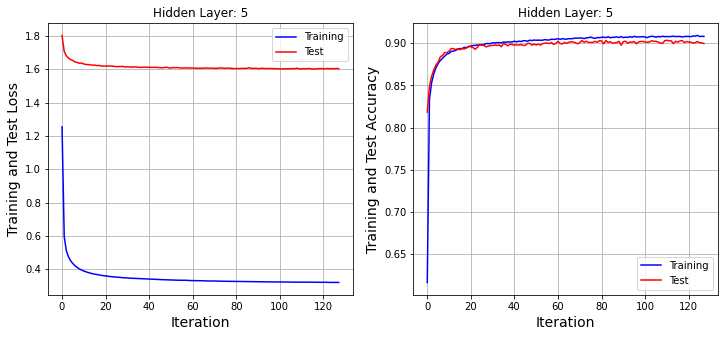

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss4, 'b', label = "Training")
ax[0].plot(range(128), test_loss4, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 5')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc4, 'b', label = "Training")
ax[1].plot(range(128), test_acc4, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 5')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 5.png")

In [38]:
model = BaselineModel(784,8,10)

train_loss4 = np.zeros(128)
test_loss4 = np.zeros(128)
train_acc4 = np.zeros(128)
test_acc4 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.533513069152832, 'running_acc': 0.8559374809265137, 'loss': 0.9954834580421448, 'acc': 0.7239333391189575, 'val_loss': 1.712833285331726, 'val_acc': 0.8664999604225159}
Epoch: 1
Training Loss: 0.9954834580421448
Training Accuracy: 0.7239333391189575
Test Loss: 1.712833285331726
Test Accuracy: 0.8664999604225159


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.39400753378868103, 'running_acc': 0.8854687213897705, 'loss': 0.43918290734291077, 'acc': 0.8772000074386597, 'val_loss': 1.6416105031967163, 'val_acc': 0.8907999992370605}
Epoch: 2
Training Loss: 0.43918290734291077
Training Accuracy: 0.8772000074386597
Test Loss: 1.6416105031967163
Test Accuracy: 0.8907999992370605


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3537931442260742, 'running_acc': 0.8996874690055847, 'loss': 0.3720749020576477, 'acc': 0.8945333361625671, 'val_loss': 1.6216691732406616, 'val_acc': 0.8999999761581421}
Epoch: 3
Training Loss: 0.3720749020576477
Training Accuracy: 0.8945333361625671
Test Loss: 1.6216691732406616
Test Accuracy: 0.8999999761581421


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.34366241097450256, 'running_acc': 0.903124988079071, 'loss': 0.344730943441391, 'acc': 0.9009166955947876, 'val_loss': 1.6087595224380493, 'val_acc': 0.9063999652862549}
Epoch: 4
Training Loss: 0.344730943441391
Training Accuracy: 0.9009166955947876
Test Loss: 1.6087595224380493
Test Accuracy: 0.9063999652862549


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.34390169382095337, 'running_acc': 0.90296870470047, 'loss': 0.32759249210357666, 'acc': 0.906416654586792, 'val_loss': 1.602636694908142, 'val_acc': 0.9084999561309814}
Epoch: 5
Training Loss: 0.32759249210357666
Training Accuracy: 0.906416654586792
Test Loss: 1.602636694908142
Test Accuracy: 0.9084999561309814


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3127020299434662, 'running_acc': 0.9118749499320984, 'loss': 0.3159027695655823, 'acc': 0.9099833369255066, 'val_loss': 1.5971885919570923, 'val_acc': 0.9129999876022339}
Epoch: 6
Training Loss: 0.3159027695655823
Training Accuracy: 0.9099833369255066
Test Loss: 1.5971885919570923
Test Accuracy: 0.9129999876022339


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2955407500267029, 'running_acc': 0.9153124690055847, 'loss': 0.30766114592552185, 'acc': 0.9122499823570251, 'val_loss': 1.5936884880065918, 'val_acc': 0.914199948310852}
Epoch: 7
Training Loss: 0.30766114592552185
Training Accuracy: 0.9122499823570251
Test Loss: 1.5936884880065918
Test Accuracy: 0.914199948310852


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2879406809806824, 'running_acc': 0.9165624976158142, 'loss': 0.29989442229270935, 'acc': 0.9147500395774841, 'val_loss': 1.5894665718078613, 'val_acc': 0.9152999520301819}
Epoch: 8
Training Loss: 0.29989442229270935
Training Accuracy: 0.9147500395774841
Test Loss: 1.5894665718078613
Test Accuracy: 0.9152999520301819


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.31676095724105835, 'running_acc': 0.9135937094688416, 'loss': 0.2946963906288147, 'acc': 0.9165000319480896, 'val_loss': 1.5894896984100342, 'val_acc': 0.915399968624115}
Epoch: 9
Training Loss: 0.2946963906288147
Training Accuracy: 0.9165000319480896
Test Loss: 1.5894896984100342
Test Accuracy: 0.915399968624115


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.28875744342803955, 'running_acc': 0.9156249761581421, 'loss': 0.2897326648235321, 'acc': 0.9175500273704529, 'val_loss': 1.5880584716796875, 'val_acc': 0.9174000024795532}
Epoch: 10
Training Loss: 0.2897326648235321
Training Accuracy: 0.9175500273704529
Test Loss: 1.5880584716796875
Test Accuracy: 0.9174000024795532


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.269511878490448, 'running_acc': 0.9231249690055847, 'loss': 0.28588324785232544, 'acc': 0.9184499979019165, 'val_loss': 1.5858947038650513, 'val_acc': 0.9182999730110168}
Epoch: 11
Training Loss: 0.28588324785232544
Training Accuracy: 0.9184499979019165
Test Loss: 1.5858947038650513
Test Accuracy: 0.9182999730110168


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.28963661193847656, 'running_acc': 0.9165624976158142, 'loss': 0.28270265460014343, 'acc': 0.9197333455085754, 'val_loss': 1.5850824117660522, 'val_acc': 0.9174999594688416}
Epoch: 12
Training Loss: 0.28270265460014343
Training Accuracy: 0.9197333455085754
Test Loss: 1.5850824117660522
Test Accuracy: 0.9174999594688416


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.29706647992134094, 'running_acc': 0.9167187213897705, 'loss': 0.2791343033313751, 'acc': 0.9211666584014893, 'val_loss': 1.5837217569351196, 'val_acc': 0.9188999533653259}
Epoch: 13
Training Loss: 0.2791343033313751
Training Accuracy: 0.9211666584014893
Test Loss: 1.5837217569351196
Test Accuracy: 0.9188999533653259


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.26892557740211487, 'running_acc': 0.9214062094688416, 'loss': 0.27707439661026, 'acc': 0.9216166734695435, 'val_loss': 1.584728479385376, 'val_acc': 0.9187999963760376}
Epoch: 14
Training Loss: 0.27707439661026
Training Accuracy: 0.9216166734695435
Test Loss: 1.584728479385376
Test Accuracy: 0.9187999963760376


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.27418053150177, 'running_acc': 0.9232812523841858, 'loss': 0.27429935336112976, 'acc': 0.9228000044822693, 'val_loss': 1.5815131664276123, 'val_acc': 0.9193999767303467}
Epoch: 15
Training Loss: 0.27429935336112976
Training Accuracy: 0.9228000044822693
Test Loss: 1.5815131664276123
Test Accuracy: 0.9193999767303467


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.26076540350914, 'running_acc': 0.9271875023841858, 'loss': 0.2725762128829956, 'acc': 0.9233500361442566, 'val_loss': 1.5816797018051147, 'val_acc': 0.9199000000953674}
Epoch: 16
Training Loss: 0.2725762128829956
Training Accuracy: 0.9233500361442566
Test Loss: 1.5816797018051147
Test Accuracy: 0.9199000000953674


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2706461250782013, 'running_acc': 0.9270312190055847, 'loss': 0.2700865864753723, 'acc': 0.9243000149726868, 'val_loss': 1.5804694890975952, 'val_acc': 0.920799970626831}
Epoch: 17
Training Loss: 0.2700865864753723
Training Accuracy: 0.9243000149726868
Test Loss: 1.5804694890975952
Test Accuracy: 0.920799970626831


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.28520870208740234, 'running_acc': 0.9242187142372131, 'loss': 0.26925429701805115, 'acc': 0.9245499968528748, 'val_loss': 1.5821938514709473, 'val_acc': 0.9178999662399292}
Epoch: 18
Training Loss: 0.26925429701805115
Training Accuracy: 0.9245499968528748
Test Loss: 1.5821938514709473
Test Accuracy: 0.9178999662399292


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2587255835533142, 'running_acc': 0.9276562333106995, 'loss': 0.26703503727912903, 'acc': 0.9256333708763123, 'val_loss': 1.5794662237167358, 'val_acc': 0.9202999472618103}
Epoch: 19
Training Loss: 0.26703503727912903
Training Accuracy: 0.9256333708763123
Test Loss: 1.5794662237167358
Test Accuracy: 0.9202999472618103


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2676285207271576, 'running_acc': 0.922656238079071, 'loss': 0.26624810695648193, 'acc': 0.92535001039505, 'val_loss': 1.5811675786972046, 'val_acc': 0.9222999811172485}
Epoch: 20
Training Loss: 0.26624810695648193
Training Accuracy: 0.92535001039505
Test Loss: 1.5811675786972046
Test Accuracy: 0.9222999811172485


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2634705603122711, 'running_acc': 0.9242187142372131, 'loss': 0.26471999287605286, 'acc': 0.9258333444595337, 'val_loss': 1.5799442529678345, 'val_acc': 0.9202999472618103}
Epoch: 21
Training Loss: 0.26471999287605286
Training Accuracy: 0.9258333444595337
Test Loss: 1.5799442529678345
Test Accuracy: 0.9202999472618103


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2547055184841156, 'running_acc': 0.93031245470047, 'loss': 0.26344776153564453, 'acc': 0.9262000322341919, 'val_loss': 1.5786575078964233, 'val_acc': 0.92249995470047}
Epoch: 22
Training Loss: 0.26344776153564453
Training Accuracy: 0.9262000322341919
Test Loss: 1.5786575078964233
Test Accuracy: 0.92249995470047


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.267707884311676, 'running_acc': 0.9260937571525574, 'loss': 0.2621564269065857, 'acc': 0.926633358001709, 'val_loss': 1.5775552988052368, 'val_acc': 0.9212999939918518}
Epoch: 23
Training Loss: 0.2621564269065857
Training Accuracy: 0.926633358001709
Test Loss: 1.5775552988052368
Test Accuracy: 0.9212999939918518


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2695532441139221, 'running_acc': 0.92640620470047, 'loss': 0.2607373297214508, 'acc': 0.926883339881897, 'val_loss': 1.5774433612823486, 'val_acc': 0.920799970626831}
Epoch: 24
Training Loss: 0.2607373297214508
Training Accuracy: 0.926883339881897
Test Loss: 1.5774433612823486
Test Accuracy: 0.920799970626831


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.25832033157348633, 'running_acc': 0.9289062023162842, 'loss': 0.2598557472229004, 'acc': 0.9272333383560181, 'val_loss': 1.5759949684143066, 'val_acc': 0.9212999939918518}
Epoch: 25
Training Loss: 0.2598557472229004
Training Accuracy: 0.9272333383560181
Test Loss: 1.5759949684143066
Test Accuracy: 0.9212999939918518


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.262129008769989, 'running_acc': 0.9260937571525574, 'loss': 0.258791446685791, 'acc': 0.9276500344276428, 'val_loss': 1.5764484405517578, 'val_acc': 0.9214999675750732}
Epoch: 26
Training Loss: 0.258791446685791
Training Accuracy: 0.9276500344276428
Test Loss: 1.5764484405517578
Test Accuracy: 0.9214999675750732


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2464451938867569, 'running_acc': 0.9301562309265137, 'loss': 0.25762221217155457, 'acc': 0.9282000064849854, 'val_loss': 1.575846791267395, 'val_acc': 0.9228000044822693}
Epoch: 27
Training Loss: 0.25762221217155457
Training Accuracy: 0.9282000064849854
Test Loss: 1.575846791267395
Test Accuracy: 0.9228000044822693


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.26642537117004395, 'running_acc': 0.9293749928474426, 'loss': 0.25651460886001587, 'acc': 0.9280999898910522, 'val_loss': 1.578866720199585, 'val_acc': 0.920699954032898}
Epoch: 28
Training Loss: 0.25651460886001587
Training Accuracy: 0.9280999898910522
Test Loss: 1.578866720199585
Test Accuracy: 0.920699954032898


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2597464621067047, 'running_acc': 0.9300000071525574, 'loss': 0.2554338872432709, 'acc': 0.9284833669662476, 'val_loss': 1.5759493112564087, 'val_acc': 0.9228000044822693}
Epoch: 29
Training Loss: 0.2554338872432709
Training Accuracy: 0.9284833669662476
Test Loss: 1.5759493112564087
Test Accuracy: 0.9228000044822693


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.25640034675598145, 'running_acc': 0.9290624856948853, 'loss': 0.2550852596759796, 'acc': 0.9283666610717773, 'val_loss': 1.5768405199050903, 'val_acc': 0.9223999977111816}
Epoch: 30
Training Loss: 0.2550852596759796
Training Accuracy: 0.9283666610717773
Test Loss: 1.5768405199050903
Test Accuracy: 0.9223999977111816


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2717144191265106, 'running_acc': 0.9267187118530273, 'loss': 0.2537911832332611, 'acc': 0.9290833473205566, 'val_loss': 1.57438063621521, 'val_acc': 0.921999990940094}
Epoch: 31
Training Loss: 0.2537911832332611
Training Accuracy: 0.9290833473205566
Test Loss: 1.57438063621521
Test Accuracy: 0.921999990940094


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2642574906349182, 'running_acc': 0.9317187070846558, 'loss': 0.25319844484329224, 'acc': 0.9291166663169861, 'val_loss': 1.5757924318313599, 'val_acc': 0.9218999743461609}
Epoch: 32
Training Loss: 0.25319844484329224
Training Accuracy: 0.9291166663169861
Test Loss: 1.5757924318313599
Test Accuracy: 0.9218999743461609


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.261470764875412, 'running_acc': 0.9282812476158142, 'loss': 0.25182458758354187, 'acc': 0.9293166995048523, 'val_loss': 1.576196312904358, 'val_acc': 0.9208999872207642}
Epoch: 33
Training Loss: 0.25182458758354187
Training Accuracy: 0.9293166995048523
Test Loss: 1.576196312904358
Test Accuracy: 0.9208999872207642


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2564235329627991, 'running_acc': 0.9260937571525574, 'loss': 0.2509538233280182, 'acc': 0.9296500086784363, 'val_loss': 1.5757343769073486, 'val_acc': 0.9202999472618103}
Epoch: 34
Training Loss: 0.2509538233280182
Training Accuracy: 0.9296500086784363
Test Loss: 1.5757343769073486
Test Accuracy: 0.9202999472618103


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23928703367710114, 'running_acc': 0.93421870470047, 'loss': 0.2503893971443176, 'acc': 0.9298333525657654, 'val_loss': 1.5744822025299072, 'val_acc': 0.9226999878883362}
Epoch: 35
Training Loss: 0.2503893971443176
Training Accuracy: 0.9298333525657654
Test Loss: 1.5744822025299072
Test Accuracy: 0.9226999878883362


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.257268488407135, 'running_acc': 0.9289062023162842, 'loss': 0.24954482913017273, 'acc': 0.9295833706855774, 'val_loss': 1.5747337341308594, 'val_acc': 0.9221999645233154}
Epoch: 36
Training Loss: 0.24954482913017273
Training Accuracy: 0.9295833706855774
Test Loss: 1.5747337341308594
Test Accuracy: 0.9221999645233154


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2508265972137451, 'running_acc': 0.9295312166213989, 'loss': 0.2487599402666092, 'acc': 0.9307166934013367, 'val_loss': 1.5733542442321777, 'val_acc': 0.9235999584197998}
Epoch: 37
Training Loss: 0.2487599402666092
Training Accuracy: 0.9307166934013367
Test Loss: 1.5733542442321777
Test Accuracy: 0.9235999584197998


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2454921156167984, 'running_acc': 0.9293749928474426, 'loss': 0.2476745992898941, 'acc': 0.9302833676338196, 'val_loss': 1.5753685235977173, 'val_acc': 0.9213999509811401}
Epoch: 38
Training Loss: 0.2476745992898941
Training Accuracy: 0.9302833676338196
Test Loss: 1.5753685235977173
Test Accuracy: 0.9213999509811401


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24616840481758118, 'running_acc': 0.9307812452316284, 'loss': 0.24744588136672974, 'acc': 0.9307667016983032, 'val_loss': 1.573297381401062, 'val_acc': 0.9221999645233154}
Epoch: 39
Training Loss: 0.24744588136672974
Training Accuracy: 0.9307667016983032
Test Loss: 1.573297381401062
Test Accuracy: 0.9221999645233154


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2455795258283615, 'running_acc': 0.93359375, 'loss': 0.24670065939426422, 'acc': 0.9306166768074036, 'val_loss': 1.573575735092163, 'val_acc': 0.9223999977111816}
Epoch: 40
Training Loss: 0.24670065939426422
Training Accuracy: 0.9306166768074036
Test Loss: 1.573575735092163
Test Accuracy: 0.9223999977111816


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24617229402065277, 'running_acc': 0.9318749904632568, 'loss': 0.2458123415708542, 'acc': 0.9307166934013367, 'val_loss': 1.5729529857635498, 'val_acc': 0.9223999977111816}
Epoch: 41
Training Loss: 0.2458123415708542
Training Accuracy: 0.9307166934013367
Test Loss: 1.5729529857635498
Test Accuracy: 0.9223999977111816


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.25059542059898376, 'running_acc': 0.9329687356948853, 'loss': 0.24573326110839844, 'acc': 0.9306333661079407, 'val_loss': 1.574920415878296, 'val_acc': 0.9231999516487122}
Epoch: 42
Training Loss: 0.24573326110839844
Training Accuracy: 0.9306333661079407
Test Loss: 1.574920415878296
Test Accuracy: 0.9231999516487122


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22718779742717743, 'running_acc': 0.9331249594688416, 'loss': 0.24491775035858154, 'acc': 0.9309166669845581, 'val_loss': 1.5720115900039673, 'val_acc': 0.9231999516487122}
Epoch: 43
Training Loss: 0.24491775035858154
Training Accuracy: 0.9309166669845581
Test Loss: 1.5720115900039673
Test Accuracy: 0.9231999516487122


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2448028177022934, 'running_acc': 0.9300000071525574, 'loss': 0.24421826004981995, 'acc': 0.9317666888237, 'val_loss': 1.572584867477417, 'val_acc': 0.9229999780654907}
Epoch: 44
Training Loss: 0.24421826004981995
Training Accuracy: 0.9317666888237
Test Loss: 1.572584867477417
Test Accuracy: 0.9229999780654907


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2414783090353012, 'running_acc': 0.9328124523162842, 'loss': 0.24363966286182404, 'acc': 0.9312000274658203, 'val_loss': 1.5723305940628052, 'val_acc': 0.9228000044822693}
Epoch: 45
Training Loss: 0.24363966286182404
Training Accuracy: 0.9312000274658203
Test Loss: 1.5723305940628052
Test Accuracy: 0.9228000044822693


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2456585019826889, 'running_acc': 0.9315624833106995, 'loss': 0.24272102117538452, 'acc': 0.932033360004425, 'val_loss': 1.5732669830322266, 'val_acc': 0.9200999736785889}
Epoch: 46
Training Loss: 0.24272102117538452
Training Accuracy: 0.932033360004425
Test Loss: 1.5732669830322266
Test Accuracy: 0.9200999736785889


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24832116067409515, 'running_acc': 0.9312499761581421, 'loss': 0.2417801022529602, 'acc': 0.9326666593551636, 'val_loss': 1.5730011463165283, 'val_acc': 0.9225999712944031}
Epoch: 47
Training Loss: 0.2417801022529602
Training Accuracy: 0.9326666593551636
Test Loss: 1.5730011463165283
Test Accuracy: 0.9225999712944031


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2451809048652649, 'running_acc': 0.9320312142372131, 'loss': 0.242001011967659, 'acc': 0.9317666888237, 'val_loss': 1.5736113786697388, 'val_acc': 0.9200999736785889}
Epoch: 48
Training Loss: 0.242001011967659
Training Accuracy: 0.9317666888237
Test Loss: 1.5736113786697388
Test Accuracy: 0.9200999736785889


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22728309035301208, 'running_acc': 0.9346874952316284, 'loss': 0.2412339150905609, 'acc': 0.9320166707038879, 'val_loss': 1.5715163946151733, 'val_acc': 0.924299955368042}
Epoch: 49
Training Loss: 0.2412339150905609
Training Accuracy: 0.9320166707038879
Test Loss: 1.5715163946151733
Test Accuracy: 0.924299955368042


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24239636957645416, 'running_acc': 0.9295312166213989, 'loss': 0.2406821995973587, 'acc': 0.9323999881744385, 'val_loss': 1.5717341899871826, 'val_acc': 0.9229999780654907}
Epoch: 50
Training Loss: 0.2406821995973587
Training Accuracy: 0.9323999881744385
Test Loss: 1.5717341899871826
Test Accuracy: 0.9229999780654907


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2471107691526413, 'running_acc': 0.934374988079071, 'loss': 0.23985494673252106, 'acc': 0.932616651058197, 'val_loss': 1.5739659070968628, 'val_acc': 0.9220999479293823}
Epoch: 51
Training Loss: 0.23985494673252106
Training Accuracy: 0.932616651058197
Test Loss: 1.5739659070968628
Test Accuracy: 0.9220999479293823


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24519231915473938, 'running_acc': 0.9318749904632568, 'loss': 0.2393880933523178, 'acc': 0.9326666593551636, 'val_loss': 1.5701651573181152, 'val_acc': 0.9240999817848206}
Epoch: 52
Training Loss: 0.2393880933523178
Training Accuracy: 0.9326666593551636
Test Loss: 1.5701651573181152
Test Accuracy: 0.9240999817848206


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2352236956357956, 'running_acc': 0.9284374713897705, 'loss': 0.23899126052856445, 'acc': 0.9326500296592712, 'val_loss': 1.5715230703353882, 'val_acc': 0.9246000051498413}
Epoch: 53
Training Loss: 0.23899126052856445
Training Accuracy: 0.9326500296592712
Test Loss: 1.5715230703353882
Test Accuracy: 0.9246000051498413


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2402469366788864, 'running_acc': 0.9306249618530273, 'loss': 0.2384832352399826, 'acc': 0.9332666993141174, 'val_loss': 1.5719188451766968, 'val_acc': 0.9233999848365784}
Epoch: 54
Training Loss: 0.2384832352399826
Training Accuracy: 0.9332666993141174
Test Loss: 1.5719188451766968
Test Accuracy: 0.9233999848365784


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24663810431957245, 'running_acc': 0.9310937523841858, 'loss': 0.23804478347301483, 'acc': 0.9330333471298218, 'val_loss': 1.5711491107940674, 'val_acc': 0.9232999682426453}
Epoch: 55
Training Loss: 0.23804478347301483
Training Accuracy: 0.9330333471298218
Test Loss: 1.5711491107940674
Test Accuracy: 0.9232999682426453


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2577071785926819, 'running_acc': 0.9312499761581421, 'loss': 0.23763787746429443, 'acc': 0.9337166547775269, 'val_loss': 1.5710465908050537, 'val_acc': 0.9240999817848206}
Epoch: 56
Training Loss: 0.23763787746429443
Training Accuracy: 0.9337166547775269
Test Loss: 1.5710465908050537
Test Accuracy: 0.9240999817848206


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23880979418754578, 'running_acc': 0.9306249618530273, 'loss': 0.23667888343334198, 'acc': 0.9334166646003723, 'val_loss': 1.5721445083618164, 'val_acc': 0.9239999651908875}
Epoch: 57
Training Loss: 0.23667888343334198
Training Accuracy: 0.9334166646003723
Test Loss: 1.5721445083618164
Test Accuracy: 0.9239999651908875


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2176312655210495, 'running_acc': 0.938281238079071, 'loss': 0.23672351241111755, 'acc': 0.9332666993141174, 'val_loss': 1.5697370767593384, 'val_acc': 0.9253999590873718}
Epoch: 58
Training Loss: 0.23672351241111755
Training Accuracy: 0.9332666993141174
Test Loss: 1.5697370767593384
Test Accuracy: 0.9253999590873718


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2352631390094757, 'running_acc': 0.93421870470047, 'loss': 0.23651951551437378, 'acc': 0.9335833191871643, 'val_loss': 1.5689159631729126, 'val_acc': 0.9257999658584595}
Epoch: 59
Training Loss: 0.23651951551437378
Training Accuracy: 0.9335833191871643
Test Loss: 1.5689159631729126
Test Accuracy: 0.9257999658584595


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2475825995206833, 'running_acc': 0.9350000023841858, 'loss': 0.23630182445049286, 'acc': 0.9338666796684265, 'val_loss': 1.5708587169647217, 'val_acc': 0.9236999750137329}
Epoch: 60
Training Loss: 0.23630182445049286
Training Accuracy: 0.9338666796684265
Test Loss: 1.5708587169647217
Test Accuracy: 0.9236999750137329


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2571973204612732, 'running_acc': 0.9282812476158142, 'loss': 0.2350538820028305, 'acc': 0.933983325958252, 'val_loss': 1.5698091983795166, 'val_acc': 0.9222999811172485}
Epoch: 61
Training Loss: 0.2350538820028305
Training Accuracy: 0.933983325958252
Test Loss: 1.5698091983795166
Test Accuracy: 0.9222999811172485


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23519721627235413, 'running_acc': 0.9340624809265137, 'loss': 0.23480531573295593, 'acc': 0.9338333606719971, 'val_loss': 1.5699082612991333, 'val_acc': 0.9240999817848206}
Epoch: 62
Training Loss: 0.23480531573295593
Training Accuracy: 0.9338333606719971
Test Loss: 1.5699082612991333
Test Accuracy: 0.9240999817848206


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2240065187215805, 'running_acc': 0.9323437213897705, 'loss': 0.23434816300868988, 'acc': 0.9345000386238098, 'val_loss': 1.5708435773849487, 'val_acc': 0.9235999584197998}
Epoch: 63
Training Loss: 0.23434816300868988
Training Accuracy: 0.9345000386238098
Test Loss: 1.5708435773849487
Test Accuracy: 0.9235999584197998


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2421499341726303, 'running_acc': 0.9315624833106995, 'loss': 0.23359057307243347, 'acc': 0.9345499873161316, 'val_loss': 1.568221092224121, 'val_acc': 0.9239999651908875}
Epoch: 64
Training Loss: 0.23359057307243347
Training Accuracy: 0.9345499873161316
Test Loss: 1.568221092224121
Test Accuracy: 0.9239999651908875


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2408968061208725, 'running_acc': 0.9354687333106995, 'loss': 0.2336481511592865, 'acc': 0.9342833161354065, 'val_loss': 1.570643424987793, 'val_acc': 0.924299955368042}
Epoch: 65
Training Loss: 0.2336481511592865
Training Accuracy: 0.9342833161354065
Test Loss: 1.570643424987793
Test Accuracy: 0.924299955368042


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2236931324005127, 'running_acc': 0.9332812428474426, 'loss': 0.23333775997161865, 'acc': 0.9347333312034607, 'val_loss': 1.568690538406372, 'val_acc': 0.923799991607666}
Epoch: 66
Training Loss: 0.23333775997161865
Training Accuracy: 0.9347333312034607
Test Loss: 1.568690538406372
Test Accuracy: 0.923799991607666


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24269364774227142, 'running_acc': 0.9398437142372131, 'loss': 0.232267826795578, 'acc': 0.9354333281517029, 'val_loss': 1.567793607711792, 'val_acc': 0.9262999892234802}
Epoch: 67
Training Loss: 0.232267826795578
Training Accuracy: 0.9354333281517029
Test Loss: 1.567793607711792
Test Accuracy: 0.9262999892234802


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24692748486995697, 'running_acc': 0.9287499785423279, 'loss': 0.23215100169181824, 'acc': 0.9348833560943604, 'val_loss': 1.5679442882537842, 'val_acc': 0.9253999590873718}
Epoch: 68
Training Loss: 0.23215100169181824
Training Accuracy: 0.9348833560943604
Test Loss: 1.5679442882537842
Test Accuracy: 0.9253999590873718


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23644515872001648, 'running_acc': 0.9339062571525574, 'loss': 0.23238471150398254, 'acc': 0.9351333379745483, 'val_loss': 1.568360447883606, 'val_acc': 0.9241999983787537}
Epoch: 69
Training Loss: 0.23238471150398254
Training Accuracy: 0.9351333379745483
Test Loss: 1.568360447883606
Test Accuracy: 0.9241999983787537


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23744437098503113, 'running_acc': 0.9354687333106995, 'loss': 0.2318270057439804, 'acc': 0.9351333379745483, 'val_loss': 1.5687479972839355, 'val_acc': 0.9230999946594238}
Epoch: 70
Training Loss: 0.2318270057439804
Training Accuracy: 0.9351333379745483
Test Loss: 1.5687479972839355
Test Accuracy: 0.9230999946594238


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2364441454410553, 'running_acc': 0.9329687356948853, 'loss': 0.2310611754655838, 'acc': 0.9358500242233276, 'val_loss': 1.569466471672058, 'val_acc': 0.9218999743461609}
Epoch: 71
Training Loss: 0.2310611754655838
Training Accuracy: 0.9358500242233276
Test Loss: 1.569466471672058
Test Accuracy: 0.9218999743461609


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22620469331741333, 'running_acc': 0.9340624809265137, 'loss': 0.23061321675777435, 'acc': 0.9348666667938232, 'val_loss': 1.5682108402252197, 'val_acc': 0.9261999726295471}
Epoch: 72
Training Loss: 0.23061321675777435
Training Accuracy: 0.9348666667938232
Test Loss: 1.5682108402252197
Test Accuracy: 0.9261999726295471


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21874688565731049, 'running_acc': 0.9387499690055847, 'loss': 0.2306993007659912, 'acc': 0.9355166554450989, 'val_loss': 1.5681036710739136, 'val_acc': 0.9257999658584595}
Epoch: 73
Training Loss: 0.2306993007659912
Training Accuracy: 0.9355166554450989
Test Loss: 1.5681036710739136
Test Accuracy: 0.9257999658584595


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2249496728181839, 'running_acc': 0.9339062571525574, 'loss': 0.22969768941402435, 'acc': 0.9352166652679443, 'val_loss': 1.5682841539382935, 'val_acc': 0.924299955368042}
Epoch: 74
Training Loss: 0.22969768941402435
Training Accuracy: 0.9352166652679443
Test Loss: 1.5682841539382935
Test Accuracy: 0.924299955368042


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23768427968025208, 'running_acc': 0.9351562261581421, 'loss': 0.22986117005348206, 'acc': 0.9354000091552734, 'val_loss': 1.5686677694320679, 'val_acc': 0.9243999719619751}
Epoch: 75
Training Loss: 0.22986117005348206
Training Accuracy: 0.9354000091552734
Test Loss: 1.5686677694320679
Test Accuracy: 0.9243999719619751


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23471015691757202, 'running_acc': 0.9328124523162842, 'loss': 0.2295084446668625, 'acc': 0.9355500340461731, 'val_loss': 1.5680811405181885, 'val_acc': 0.9222999811172485}
Epoch: 76
Training Loss: 0.2295084446668625
Training Accuracy: 0.9355500340461731
Test Loss: 1.5680811405181885
Test Accuracy: 0.9222999811172485


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22359305620193481, 'running_acc': 0.9348437190055847, 'loss': 0.2289811670780182, 'acc': 0.9354833364486694, 'val_loss': 1.5666730403900146, 'val_acc': 0.9251999855041504}
Epoch: 77
Training Loss: 0.2289811670780182
Training Accuracy: 0.9354833364486694
Test Loss: 1.5666730403900146
Test Accuracy: 0.9251999855041504


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23079174757003784, 'running_acc': 0.9356249570846558, 'loss': 0.2283833920955658, 'acc': 0.9366333484649658, 'val_loss': 1.5677006244659424, 'val_acc': 0.9239999651908875}
Epoch: 78
Training Loss: 0.2283833920955658
Training Accuracy: 0.9366333484649658
Test Loss: 1.5677006244659424
Test Accuracy: 0.9239999651908875


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23713918030261993, 'running_acc': 0.9370312094688416, 'loss': 0.22822171449661255, 'acc': 0.9359999895095825, 'val_loss': 1.5667576789855957, 'val_acc': 0.9230999946594238}
Epoch: 79
Training Loss: 0.22822171449661255
Training Accuracy: 0.9359999895095825
Test Loss: 1.5667576789855957
Test Accuracy: 0.9230999946594238


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22792690992355347, 'running_acc': 0.9370312094688416, 'loss': 0.2281838208436966, 'acc': 0.9360833168029785, 'val_loss': 1.566967248916626, 'val_acc': 0.9253999590873718}
Epoch: 80
Training Loss: 0.2281838208436966
Training Accuracy: 0.9360833168029785
Test Loss: 1.566967248916626
Test Accuracy: 0.9253999590873718


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23352563381195068, 'running_acc': 0.9301562309265137, 'loss': 0.2276061773300171, 'acc': 0.9356333613395691, 'val_loss': 1.5679408311843872, 'val_acc': 0.9258999824523926}
Epoch: 81
Training Loss: 0.2276061773300171
Training Accuracy: 0.9356333613395691
Test Loss: 1.5679408311843872
Test Accuracy: 0.9258999824523926


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22822022438049316, 'running_acc': 0.9351562261581421, 'loss': 0.22738750278949738, 'acc': 0.9362833499908447, 'val_loss': 1.5689316987991333, 'val_acc': 0.9254999756813049}
Epoch: 82
Training Loss: 0.22738750278949738
Training Accuracy: 0.9362833499908447
Test Loss: 1.5689316987991333
Test Accuracy: 0.9254999756813049


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2213839292526245, 'running_acc': 0.9365624785423279, 'loss': 0.22748616337776184, 'acc': 0.9354833364486694, 'val_loss': 1.5670174360275269, 'val_acc': 0.9257999658584595}
Epoch: 83
Training Loss: 0.22748616337776184
Training Accuracy: 0.9354833364486694
Test Loss: 1.5670174360275269
Test Accuracy: 0.9257999658584595


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22677874565124512, 'running_acc': 0.9362499713897705, 'loss': 0.2269313782453537, 'acc': 0.9363666772842407, 'val_loss': 1.5685147047042847, 'val_acc': 0.9217999577522278}
Epoch: 84
Training Loss: 0.2269313782453537
Training Accuracy: 0.9363666772842407
Test Loss: 1.5685147047042847
Test Accuracy: 0.9217999577522278


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21414050459861755, 'running_acc': 0.9376562237739563, 'loss': 0.226881742477417, 'acc': 0.9359333515167236, 'val_loss': 1.5696146488189697, 'val_acc': 0.9233999848365784}
Epoch: 85
Training Loss: 0.226881742477417
Training Accuracy: 0.9359333515167236
Test Loss: 1.5696146488189697
Test Accuracy: 0.9233999848365784


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21137891709804535, 'running_acc': 0.9385937452316284, 'loss': 0.22635675966739655, 'acc': 0.9357333183288574, 'val_loss': 1.5677971839904785, 'val_acc': 0.9233999848365784}
Epoch: 86
Training Loss: 0.22635675966739655
Training Accuracy: 0.9357333183288574
Test Loss: 1.5677971839904785
Test Accuracy: 0.9233999848365784


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21867726743221283, 'running_acc': 0.9379687309265137, 'loss': 0.22644442319869995, 'acc': 0.9362666606903076, 'val_loss': 1.5669069290161133, 'val_acc': 0.924299955368042}
Epoch: 87
Training Loss: 0.22644442319869995
Training Accuracy: 0.9362666606903076
Test Loss: 1.5669069290161133
Test Accuracy: 0.924299955368042


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23841147124767303, 'running_acc': 0.9296875, 'loss': 0.22588805854320526, 'acc': 0.9365500211715698, 'val_loss': 1.568369746208191, 'val_acc': 0.9246000051498413}
Epoch: 88
Training Loss: 0.22588805854320526
Training Accuracy: 0.9365500211715698
Test Loss: 1.568369746208191
Test Accuracy: 0.9246000051498413


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22350333631038666, 'running_acc': 0.9417187571525574, 'loss': 0.22581921517848969, 'acc': 0.9364333152770996, 'val_loss': 1.5663676261901855, 'val_acc': 0.9243999719619751}
Epoch: 89
Training Loss: 0.22581921517848969
Training Accuracy: 0.9364333152770996
Test Loss: 1.5663676261901855
Test Accuracy: 0.9243999719619751


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21540603041648865, 'running_acc': 0.9384374618530273, 'loss': 0.2248825877904892, 'acc': 0.9366333484649658, 'val_loss': 1.5660749673843384, 'val_acc': 0.9253000020980835}
Epoch: 90
Training Loss: 0.2248825877904892
Training Accuracy: 0.9366333484649658
Test Loss: 1.5660749673843384
Test Accuracy: 0.9253000020980835


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23795437812805176, 'running_acc': 0.9332812428474426, 'loss': 0.22515414655208588, 'acc': 0.9363000392913818, 'val_loss': 1.5669056177139282, 'val_acc': 0.924299955368042}
Epoch: 91
Training Loss: 0.22515414655208588
Training Accuracy: 0.9363000392913818
Test Loss: 1.5669056177139282
Test Accuracy: 0.924299955368042


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22987224161624908, 'running_acc': 0.9331249594688416, 'loss': 0.22482243180274963, 'acc': 0.9368000030517578, 'val_loss': 1.56643545627594, 'val_acc': 0.9243999719619751}
Epoch: 92
Training Loss: 0.22482243180274963
Training Accuracy: 0.9368000030517578
Test Loss: 1.56643545627594
Test Accuracy: 0.9243999719619751


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23371998965740204, 'running_acc': 0.9334374666213989, 'loss': 0.22468769550323486, 'acc': 0.9369833469390869, 'val_loss': 1.569295048713684, 'val_acc': 0.9235999584197998}
Epoch: 93
Training Loss: 0.22468769550323486
Training Accuracy: 0.9369833469390869
Test Loss: 1.569295048713684
Test Accuracy: 0.9235999584197998


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2219623476266861, 'running_acc': 0.9353124499320984, 'loss': 0.22410248219966888, 'acc': 0.9365333318710327, 'val_loss': 1.5669256448745728, 'val_acc': 0.9243999719619751}
Epoch: 94
Training Loss: 0.22410248219966888
Training Accuracy: 0.9365333318710327
Test Loss: 1.5669256448745728
Test Accuracy: 0.9243999719619751


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21197809278964996, 'running_acc': 0.9384374618530273, 'loss': 0.22403354942798615, 'acc': 0.937000036239624, 'val_loss': 1.5656393766403198, 'val_acc': 0.9246000051498413}
Epoch: 95
Training Loss: 0.22403354942798615
Training Accuracy: 0.937000036239624
Test Loss: 1.5656393766403198
Test Accuracy: 0.9246000051498413


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2399314045906067, 'running_acc': 0.9318749904632568, 'loss': 0.22432278096675873, 'acc': 0.9367333650588989, 'val_loss': 1.567204475402832, 'val_acc': 0.9235999584197998}
Epoch: 96
Training Loss: 0.22432278096675873
Training Accuracy: 0.9367333650588989
Test Loss: 1.567204475402832
Test Accuracy: 0.9235999584197998


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2286926656961441, 'running_acc': 0.9318749904632568, 'loss': 0.22340229153633118, 'acc': 0.9369500279426575, 'val_loss': 1.567869782447815, 'val_acc': 0.9235999584197998}
Epoch: 97
Training Loss: 0.22340229153633118
Training Accuracy: 0.9369500279426575
Test Loss: 1.567869782447815
Test Accuracy: 0.9235999584197998


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22515176236629486, 'running_acc': 0.93359375, 'loss': 0.22346803545951843, 'acc': 0.9362833499908447, 'val_loss': 1.5672461986541748, 'val_acc': 0.9208999872207642}
Epoch: 98
Training Loss: 0.22346803545951843
Training Accuracy: 0.9362833499908447
Test Loss: 1.5672461986541748
Test Accuracy: 0.9208999872207642


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22966481745243073, 'running_acc': 0.9346874952316284, 'loss': 0.22311007976531982, 'acc': 0.9369666576385498, 'val_loss': 1.5657861232757568, 'val_acc': 0.9244999885559082}
Epoch: 99
Training Loss: 0.22311007976531982
Training Accuracy: 0.9369666576385498
Test Loss: 1.5657861232757568
Test Accuracy: 0.9244999885559082


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23456920683383942, 'running_acc': 0.9350000023841858, 'loss': 0.2231164425611496, 'acc': 0.9371500015258789, 'val_loss': 1.5670212507247925, 'val_acc': 0.9235000014305115}
Epoch: 100
Training Loss: 0.2231164425611496
Training Accuracy: 0.9371500015258789
Test Loss: 1.5670212507247925
Test Accuracy: 0.9235000014305115


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21418128907680511, 'running_acc': 0.9360937476158142, 'loss': 0.22212640941143036, 'acc': 0.9370166659355164, 'val_loss': 1.564759612083435, 'val_acc': 0.9246999621391296}
Epoch: 101
Training Loss: 0.22212640941143036
Training Accuracy: 0.9370166659355164
Test Loss: 1.564759612083435
Test Accuracy: 0.9246999621391296


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22179386019706726, 'running_acc': 0.9399999976158142, 'loss': 0.222702294588089, 'acc': 0.9371833205223083, 'val_loss': 1.5677082538604736, 'val_acc': 0.9217000007629395}
Epoch: 102
Training Loss: 0.222702294588089
Training Accuracy: 0.9371833205223083
Test Loss: 1.5677082538604736
Test Accuracy: 0.9217000007629395


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22081735730171204, 'running_acc': 0.9385937452316284, 'loss': 0.22220894694328308, 'acc': 0.9376833438873291, 'val_loss': 1.5651228427886963, 'val_acc': 0.9246999621391296}
Epoch: 103
Training Loss: 0.22220894694328308
Training Accuracy: 0.9376833438873291
Test Loss: 1.5651228427886963
Test Accuracy: 0.9246999621391296


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22375920414924622, 'running_acc': 0.9379687309265137, 'loss': 0.2219277173280716, 'acc': 0.9368667006492615, 'val_loss': 1.5674835443496704, 'val_acc': 0.9250999689102173}
Epoch: 104
Training Loss: 0.2219277173280716
Training Accuracy: 0.9368667006492615
Test Loss: 1.5674835443496704
Test Accuracy: 0.9250999689102173


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23149600625038147, 'running_acc': 0.9357812404632568, 'loss': 0.2217453420162201, 'acc': 0.9367499947547913, 'val_loss': 1.5673778057098389, 'val_acc': 0.9215999841690063}
Epoch: 105
Training Loss: 0.2217453420162201
Training Accuracy: 0.9367499947547913
Test Loss: 1.5673778057098389
Test Accuracy: 0.9215999841690063


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24225406348705292, 'running_acc': 0.93031245470047, 'loss': 0.2218339592218399, 'acc': 0.9370499849319458, 'val_loss': 1.5665626525878906, 'val_acc': 0.9228000044822693}
Epoch: 106
Training Loss: 0.2218339592218399
Training Accuracy: 0.9370499849319458
Test Loss: 1.5665626525878906
Test Accuracy: 0.9228000044822693


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23038409650325775, 'running_acc': 0.9362499713897705, 'loss': 0.22220513224601746, 'acc': 0.9365500211715698, 'val_loss': 1.5661784410476685, 'val_acc': 0.9243999719619751}
Epoch: 107
Training Loss: 0.22220513224601746
Training Accuracy: 0.9365500211715698
Test Loss: 1.5661784410476685
Test Accuracy: 0.9243999719619751


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21148735284805298, 'running_acc': 0.9367187023162842, 'loss': 0.22151555120944977, 'acc': 0.9369166493415833, 'val_loss': 1.565751075744629, 'val_acc': 0.9248999953269958}
Epoch: 108
Training Loss: 0.22151555120944977
Training Accuracy: 0.9369166493415833
Test Loss: 1.565751075744629
Test Accuracy: 0.9248999953269958


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20989203453063965, 'running_acc': 0.9417187571525574, 'loss': 0.22142910957336426, 'acc': 0.9371500015258789, 'val_loss': 1.5659732818603516, 'val_acc': 0.9235999584197998}
Epoch: 109
Training Loss: 0.22142910957336426
Training Accuracy: 0.9371500015258789
Test Loss: 1.5659732818603516
Test Accuracy: 0.9235999584197998


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21908895671367645, 'running_acc': 0.93812495470047, 'loss': 0.22079099714756012, 'acc': 0.9380500316619873, 'val_loss': 1.5665723085403442, 'val_acc': 0.9253000020980835}
Epoch: 110
Training Loss: 0.22079099714756012
Training Accuracy: 0.9380500316619873
Test Loss: 1.5665723085403442
Test Accuracy: 0.9253000020980835


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2247372418642044, 'running_acc': 0.9351562261581421, 'loss': 0.22077544033527374, 'acc': 0.9380000233650208, 'val_loss': 1.5661630630493164, 'val_acc': 0.9250999689102173}
Epoch: 111
Training Loss: 0.22077544033527374
Training Accuracy: 0.9380000233650208
Test Loss: 1.5661630630493164
Test Accuracy: 0.9250999689102173


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22186541557312012, 'running_acc': 0.9387499690055847, 'loss': 0.22051729261875153, 'acc': 0.9373166561126709, 'val_loss': 1.5668607950210571, 'val_acc': 0.9218999743461609}
Epoch: 112
Training Loss: 0.22051729261875153
Training Accuracy: 0.9373166561126709
Test Loss: 1.5668607950210571
Test Accuracy: 0.9218999743461609


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2141301929950714, 'running_acc': 0.9440624713897705, 'loss': 0.22054502367973328, 'acc': 0.9379333257675171, 'val_loss': 1.5649335384368896, 'val_acc': 0.924299955368042}
Epoch: 113
Training Loss: 0.22054502367973328
Training Accuracy: 0.9379333257675171
Test Loss: 1.5649335384368896
Test Accuracy: 0.924299955368042


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22284454107284546, 'running_acc': 0.9385937452316284, 'loss': 0.22040709853172302, 'acc': 0.9375333189964294, 'val_loss': 1.5655114650726318, 'val_acc': 0.9240999817848206}
Epoch: 114
Training Loss: 0.22040709853172302
Training Accuracy: 0.9375333189964294
Test Loss: 1.5655114650726318
Test Accuracy: 0.9240999817848206


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22456520795822144, 'running_acc': 0.9346874952316284, 'loss': 0.22019700706005096, 'acc': 0.9366500377655029, 'val_loss': 1.5649300813674927, 'val_acc': 0.9241999983787537}
Epoch: 115
Training Loss: 0.22019700706005096
Training Accuracy: 0.9366500377655029
Test Loss: 1.5649300813674927
Test Accuracy: 0.9241999983787537


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2341887354850769, 'running_acc': 0.9406249523162842, 'loss': 0.2196493297815323, 'acc': 0.9378166794776917, 'val_loss': 1.5657638311386108, 'val_acc': 0.9258999824523926}
Epoch: 116
Training Loss: 0.2196493297815323
Training Accuracy: 0.9378166794776917
Test Loss: 1.5657638311386108
Test Accuracy: 0.9258999824523926


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2180173397064209, 'running_acc': 0.9367187023162842, 'loss': 0.22003968060016632, 'acc': 0.9367166757583618, 'val_loss': 1.5649076700210571, 'val_acc': 0.9229999780654907}
Epoch: 117
Training Loss: 0.22003968060016632
Training Accuracy: 0.9367166757583618
Test Loss: 1.5649076700210571
Test Accuracy: 0.9229999780654907


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23013246059417725, 'running_acc': 0.9395312070846558, 'loss': 0.21929094195365906, 'acc': 0.9376000165939331, 'val_loss': 1.568165898323059, 'val_acc': 0.923799991607666}
Epoch: 118
Training Loss: 0.21929094195365906
Training Accuracy: 0.9376000165939331
Test Loss: 1.568165898323059
Test Accuracy: 0.923799991607666


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21185079216957092, 'running_acc': 0.9403125047683716, 'loss': 0.21934464573860168, 'acc': 0.9375666975975037, 'val_loss': 1.5644367933273315, 'val_acc': 0.9240999817848206}
Epoch: 119
Training Loss: 0.21934464573860168
Training Accuracy: 0.9375666975975037
Test Loss: 1.5644367933273315
Test Accuracy: 0.9240999817848206


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21964114904403687, 'running_acc': 0.9379687309265137, 'loss': 0.21870477497577667, 'acc': 0.9377333521842957, 'val_loss': 1.5656042098999023, 'val_acc': 0.9256999492645264}
Epoch: 120
Training Loss: 0.21870477497577667
Training Accuracy: 0.9377333521842957
Test Loss: 1.5656042098999023
Test Accuracy: 0.9256999492645264


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2305152267217636, 'running_acc': 0.9340624809265137, 'loss': 0.2189132571220398, 'acc': 0.9373500347137451, 'val_loss': 1.5668036937713623, 'val_acc': 0.9244999885559082}
Epoch: 121
Training Loss: 0.2189132571220398
Training Accuracy: 0.9373500347137451
Test Loss: 1.5668036937713623
Test Accuracy: 0.9244999885559082


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2174208015203476, 'running_acc': 0.9364062547683716, 'loss': 0.21911373734474182, 'acc': 0.9378499984741211, 'val_loss': 1.5647917985916138, 'val_acc': 0.9226999878883362}
Epoch: 122
Training Loss: 0.21911373734474182
Training Accuracy: 0.9378499984741211
Test Loss: 1.5647917985916138
Test Accuracy: 0.9226999878883362


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22926732897758484, 'running_acc': 0.9357812404632568, 'loss': 0.21882517635822296, 'acc': 0.9378833174705505, 'val_loss': 1.564969539642334, 'val_acc': 0.924299955368042}
Epoch: 123
Training Loss: 0.21882517635822296
Training Accuracy: 0.9378833174705505
Test Loss: 1.564969539642334
Test Accuracy: 0.924299955368042


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21230950951576233, 'running_acc': 0.9350000023841858, 'loss': 0.21907414495944977, 'acc': 0.9371166825294495, 'val_loss': 1.5642831325531006, 'val_acc': 0.9239999651908875}
Epoch: 124
Training Loss: 0.21907414495944977
Training Accuracy: 0.9371166825294495
Test Loss: 1.5642831325531006
Test Accuracy: 0.9239999651908875


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21892161667346954, 'running_acc': 0.9345312118530273, 'loss': 0.2187657654285431, 'acc': 0.9380500316619873, 'val_loss': 1.564453363418579, 'val_acc': 0.9253000020980835}
Epoch: 125
Training Loss: 0.2187657654285431
Training Accuracy: 0.9380500316619873
Test Loss: 1.564453363418579
Test Accuracy: 0.9253000020980835


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21754492819309235, 'running_acc': 0.9418749809265137, 'loss': 0.21848255395889282, 'acc': 0.9378499984741211, 'val_loss': 1.5672235488891602, 'val_acc': 0.9220999479293823}
Epoch: 126
Training Loss: 0.21848255395889282
Training Accuracy: 0.9378499984741211
Test Loss: 1.5672235488891602
Test Accuracy: 0.9220999479293823


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23314908146858215, 'running_acc': 0.9364062547683716, 'loss': 0.2182801067829132, 'acc': 0.9380833506584167, 'val_loss': 1.566961646080017, 'val_acc': 0.9214999675750732}
Epoch: 127
Training Loss: 0.2182801067829132
Training Accuracy: 0.9380833506584167
Test Loss: 1.566961646080017
Test Accuracy: 0.9214999675750732


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22000914812088013, 'running_acc': 0.9385937452316284, 'loss': 0.2185487449169159, 'acc': 0.937749981880188, 'val_loss': 1.565563440322876, 'val_acc': 0.9218999743461609}
Epoch: 128
Training Loss: 0.2185487449169159
Training Accuracy: 0.937749981880188
Test Loss: 1.565563440322876
Test Accuracy: 0.9218999743461609


[{'running_loss': 0.533513069152832,
  'running_acc': 0.8559374809265137,
  'loss': 0.9954834580421448,
  'acc': 0.7239333391189575,
  'val_loss': 1.712833285331726,
  'val_acc': 0.8664999604225159,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.39400753378868103,
  'running_acc': 0.8854687213897705,
  'loss': 0.43918290734291077,
  'acc': 0.8772000074386597,
  'val_loss': 1.6416105031967163,
  'val_acc': 0.8907999992370605,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.3537931442260742,
  'running_acc': 0.8996874690055847,
  'loss': 0.3720749020576477,
  'acc': 0.8945333361625671,
  'val_loss': 1.6216691732406616,
  'val_acc': 0.8999999761581421,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.34366241097450256,
  'running_acc': 0.903124988079071,
  'loss': 0.344730943441391,
  'acc': 0.9009166955947876,
  'val_loss': 1.6087595224380493,
  'val_acc': 0.9063999652862549,
  'train_steps': 469,
  'validation_steps': 79},
 

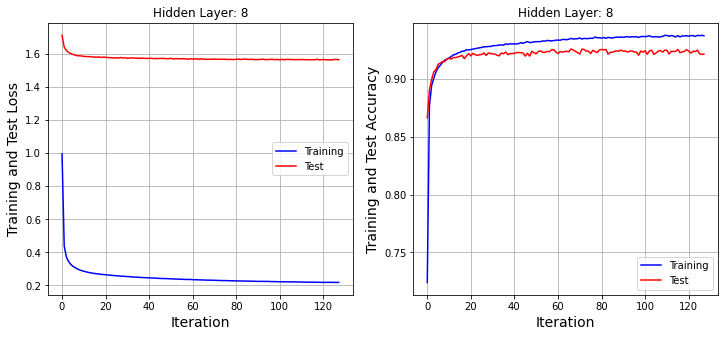

In [39]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss4, 'b', label = "Training")
ax[0].plot(range(128), test_loss4, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 8')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc4, 'b', label = "Training")
ax[1].plot(range(128), test_acc4, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 8')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 8.png")

In [43]:
model = BaselineModel(784,15,10)

train_loss4 = np.zeros(128)
test_loss4 = np.zeros(128)
train_acc4 = np.zeros(128)
test_acc4 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.3698475956916809, 'running_acc': 0.8984375, 'loss': 0.6781753301620483, 'acc': 0.8332000374794006, 'val_loss': 1.629948377609253, 'val_acc': 0.9034000039100647}
Epoch: 1
Training Loss: 0.6781753301620483
Training Accuracy: 0.8332000374794006
Test Loss: 1.629948377609253
Test Accuracy: 0.9034000039100647


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2782909572124481, 'running_acc': 0.9204687476158142, 'loss': 0.32035496830940247, 'acc': 0.9098666906356812, 'val_loss': 1.5936559438705444, 'val_acc': 0.9187999963760376}
Epoch: 2
Training Loss: 0.32035496830940247
Training Accuracy: 0.9098666906356812
Test Loss: 1.5936559438705444
Test Accuracy: 0.9187999963760376


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2799893617630005, 'running_acc': 0.9215624928474426, 'loss': 0.2850039005279541, 'acc': 0.9195666909217834, 'val_loss': 1.5842900276184082, 'val_acc': 0.9235999584197998}
Epoch: 3
Training Loss: 0.2850039005279541
Training Accuracy: 0.9195666909217834
Test Loss: 1.5842900276184082
Test Accuracy: 0.9235999584197998


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.27243009209632874, 'running_acc': 0.9231249690055847, 'loss': 0.2670644521713257, 'acc': 0.9247666597366333, 'val_loss': 1.5765801668167114, 'val_acc': 0.9269999861717224}
Epoch: 4
Training Loss: 0.2670644521713257
Training Accuracy: 0.9247666597366333
Test Loss: 1.5765801668167114
Test Accuracy: 0.9269999861717224


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2506907284259796, 'running_acc': 0.9293749928474426, 'loss': 0.254961758852005, 'acc': 0.9272833466529846, 'val_loss': 1.5713963508605957, 'val_acc': 0.9312999844551086}
Epoch: 5
Training Loss: 0.254961758852005
Training Accuracy: 0.9272833466529846
Test Loss: 1.5713963508605957
Test Accuracy: 0.9312999844551086


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2557145357131958, 'running_acc': 0.9268749952316284, 'loss': 0.24447770416736603, 'acc': 0.9303666949272156, 'val_loss': 1.5663386583328247, 'val_acc': 0.9327999949455261}
Epoch: 6
Training Loss: 0.24447770416736603
Training Accuracy: 0.9303666949272156
Test Loss: 1.5663386583328247
Test Accuracy: 0.9327999949455261


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24810738861560822, 'running_acc': 0.9312499761581421, 'loss': 0.23590804636478424, 'acc': 0.9334333539009094, 'val_loss': 1.5646389722824097, 'val_acc': 0.9335999488830566}
Epoch: 7
Training Loss: 0.23590804636478424
Training Accuracy: 0.9334333539009094
Test Loss: 1.5646389722824097
Test Accuracy: 0.9335999488830566


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.24443840980529785, 'running_acc': 0.9287499785423279, 'loss': 0.22753609716892242, 'acc': 0.9364166855812073, 'val_loss': 1.5611686706542969, 'val_acc': 0.935699999332428}
Epoch: 8
Training Loss: 0.22753609716892242
Training Accuracy: 0.9364166855812073
Test Loss: 1.5611686706542969
Test Accuracy: 0.935699999332428


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22114533185958862, 'running_acc': 0.9370312094688416, 'loss': 0.22023765742778778, 'acc': 0.9381000399589539, 'val_loss': 1.559767246246338, 'val_acc': 0.9351999759674072}
Epoch: 9
Training Loss: 0.22023765742778778
Training Accuracy: 0.9381000399589539
Test Loss: 1.559767246246338
Test Accuracy: 0.9351999759674072


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.21846792101860046, 'running_acc': 0.9379687309265137, 'loss': 0.21333898603916168, 'acc': 0.9399999976158142, 'val_loss': 1.5563747882843018, 'val_acc': 0.9386000037193298}
Epoch: 10
Training Loss: 0.21333898603916168
Training Accuracy: 0.9399999976158142
Test Loss: 1.5563747882843018
Test Accuracy: 0.9386000037193298


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19563844799995422, 'running_acc': 0.9449999928474426, 'loss': 0.20671820640563965, 'acc': 0.9422833323478699, 'val_loss': 1.5543721914291382, 'val_acc': 0.9381999969482422}
Epoch: 11
Training Loss: 0.20671820640563965
Training Accuracy: 0.9422833323478699
Test Loss: 1.5543721914291382
Test Accuracy: 0.9381999969482422


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.20183920860290527, 'running_acc': 0.9429687261581421, 'loss': 0.1999245136976242, 'acc': 0.9432333707809448, 'val_loss': 1.551454782485962, 'val_acc': 0.941100001335144}
Epoch: 12
Training Loss: 0.1999245136976242
Training Accuracy: 0.9432333707809448
Test Loss: 1.551454782485962
Test Accuracy: 0.941100001335144


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.18125289678573608, 'running_acc': 0.9476562142372131, 'loss': 0.19497589766979218, 'acc': 0.9447833299636841, 'val_loss': 1.551345944404602, 'val_acc': 0.939300000667572}
Epoch: 13
Training Loss: 0.19497589766979218
Training Accuracy: 0.9447833299636841
Test Loss: 1.551345944404602
Test Accuracy: 0.939300000667572


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.18743497133255005, 'running_acc': 0.9453125, 'loss': 0.18865211308002472, 'acc': 0.9467000365257263, 'val_loss': 1.550167441368103, 'val_acc': 0.9405999779701233}
Epoch: 14
Training Loss: 0.18865211308002472
Training Accuracy: 0.9467000365257263
Test Loss: 1.550167441368103
Test Accuracy: 0.9405999779701233


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1847718209028244, 'running_acc': 0.9518749713897705, 'loss': 0.18347381055355072, 'acc': 0.947950005531311, 'val_loss': 1.5472462177276611, 'val_acc': 0.9414999485015869}
Epoch: 15
Training Loss: 0.18347381055355072
Training Accuracy: 0.947950005531311
Test Loss: 1.5472462177276611
Test Accuracy: 0.9414999485015869


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.17458531260490417, 'running_acc': 0.9496874809265137, 'loss': 0.17817707359790802, 'acc': 0.9495500326156616, 'val_loss': 1.5449215173721313, 'val_acc': 0.9440999627113342}
Epoch: 16
Training Loss: 0.17817707359790802
Training Accuracy: 0.9495500326156616
Test Loss: 1.5449215173721313
Test Accuracy: 0.9440999627113342


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1719581037759781, 'running_acc': 0.95374995470047, 'loss': 0.17309986054897308, 'acc': 0.9506333470344543, 'val_loss': 1.5452877283096313, 'val_acc': 0.9437999725341797}
Epoch: 17
Training Loss: 0.17309986054897308
Training Accuracy: 0.9506333470344543
Test Loss: 1.5452877283096313
Test Accuracy: 0.9437999725341797


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.16750071942806244, 'running_acc': 0.9521874785423279, 'loss': 0.16910292208194733, 'acc': 0.9518333673477173, 'val_loss': 1.5414456129074097, 'val_acc': 0.9455999732017517}
Epoch: 18
Training Loss: 0.16910292208194733
Training Accuracy: 0.9518333673477173
Test Loss: 1.5414456129074097
Test Accuracy: 0.9455999732017517


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.16971194744110107, 'running_acc': 0.9535937309265137, 'loss': 0.1649223417043686, 'acc': 0.953166663646698, 'val_loss': 1.5401495695114136, 'val_acc': 0.9469999670982361}
Epoch: 19
Training Loss: 0.1649223417043686
Training Accuracy: 0.953166663646698
Test Loss: 1.5401495695114136
Test Accuracy: 0.9469999670982361


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.16148076951503754, 'running_acc': 0.9568749666213989, 'loss': 0.16125217080116272, 'acc': 0.9541500210762024, 'val_loss': 1.5368962287902832, 'val_acc': 0.9477999806404114}
Epoch: 20
Training Loss: 0.16125217080116272
Training Accuracy: 0.9541500210762024
Test Loss: 1.5368962287902832
Test Accuracy: 0.9477999806404114


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.17536887526512146, 'running_acc': 0.9506250023841858, 'loss': 0.15761858224868774, 'acc': 0.9556000232696533, 'val_loss': 1.5392059087753296, 'val_acc': 0.9466999769210815}
Epoch: 21
Training Loss: 0.15761858224868774
Training Accuracy: 0.9556000232696533
Test Loss: 1.5392059087753296
Test Accuracy: 0.9466999769210815


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.15906290709972382, 'running_acc': 0.9573437571525574, 'loss': 0.1540297269821167, 'acc': 0.956166684627533, 'val_loss': 1.5359092950820923, 'val_acc': 0.9483000040054321}
Epoch: 22
Training Loss: 0.1540297269821167
Training Accuracy: 0.956166684627533
Test Loss: 1.5359092950820923
Test Accuracy: 0.9483000040054321


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.14012128114700317, 'running_acc': 0.9590624570846558, 'loss': 0.15168750286102295, 'acc': 0.9564999938011169, 'val_loss': 1.5343579053878784, 'val_acc': 0.9483000040054321}
Epoch: 23
Training Loss: 0.15168750286102295
Training Accuracy: 0.9564999938011169
Test Loss: 1.5343579053878784
Test Accuracy: 0.9483000040054321


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1622014343738556, 'running_acc': 0.953125, 'loss': 0.14874228835105896, 'acc': 0.9577833414077759, 'val_loss': 1.535330891609192, 'val_acc': 0.948199987411499}
Epoch: 24
Training Loss: 0.14874228835105896
Training Accuracy: 0.9577833414077759
Test Loss: 1.535330891609192
Test Accuracy: 0.948199987411499


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.14804475009441376, 'running_acc': 0.9587499499320984, 'loss': 0.14637750387191772, 'acc': 0.958299994468689, 'val_loss': 1.5351625680923462, 'val_acc': 0.9478999972343445}
Epoch: 25
Training Loss: 0.14637750387191772
Training Accuracy: 0.958299994468689
Test Loss: 1.5351625680923462
Test Accuracy: 0.9478999972343445


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.13981737196445465, 'running_acc': 0.9567187428474426, 'loss': 0.1441318690776825, 'acc': 0.9585500359535217, 'val_loss': 1.5324451923370361, 'val_acc': 0.9493999481201172}
Epoch: 26
Training Loss: 0.1441318690776825
Training Accuracy: 0.9585500359535217
Test Loss: 1.5324451923370361
Test Accuracy: 0.9493999481201172


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.15209312736988068, 'running_acc': 0.9564062356948853, 'loss': 0.14227694272994995, 'acc': 0.9594166874885559, 'val_loss': 1.5335705280303955, 'val_acc': 0.9494999647140503}
Epoch: 27
Training Loss: 0.14227694272994995
Training Accuracy: 0.9594166874885559
Test Loss: 1.5335705280303955
Test Accuracy: 0.9494999647140503


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.14501895010471344, 'running_acc': 0.95703125, 'loss': 0.13974954187870026, 'acc': 0.9597166776657104, 'val_loss': 1.531474232673645, 'val_acc': 0.9503999948501587}
Epoch: 28
Training Loss: 0.13974954187870026
Training Accuracy: 0.9597166776657104
Test Loss: 1.531474232673645
Test Accuracy: 0.9503999948501587


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.15640541911125183, 'running_acc': 0.9559375047683716, 'loss': 0.13752566277980804, 'acc': 0.9610333442687988, 'val_loss': 1.5311130285263062, 'val_acc': 0.9491999745368958}
Epoch: 29
Training Loss: 0.13752566277980804
Training Accuracy: 0.9610333442687988
Test Loss: 1.5311130285263062
Test Accuracy: 0.9491999745368958


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.14051871001720428, 'running_acc': 0.9610937237739563, 'loss': 0.13631616532802582, 'acc': 0.9609000086784363, 'val_loss': 1.530436635017395, 'val_acc': 0.9491999745368958}
Epoch: 30
Training Loss: 0.13631616532802582
Training Accuracy: 0.9609000086784363
Test Loss: 1.530436635017395
Test Accuracy: 0.9491999745368958


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.13295415043830872, 'running_acc': 0.9595312476158142, 'loss': 0.13403668999671936, 'acc': 0.961733341217041, 'val_loss': 1.5293630361557007, 'val_acc': 0.9497999548912048}
Epoch: 31
Training Loss: 0.13403668999671936
Training Accuracy: 0.961733341217041
Test Loss: 1.5293630361557007
Test Accuracy: 0.9497999548912048


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.13942332565784454, 'running_acc': 0.9595312476158142, 'loss': 0.13269519805908203, 'acc': 0.961650013923645, 'val_loss': 1.5284578800201416, 'val_acc': 0.9509999752044678}
Epoch: 32
Training Loss: 0.13269519805908203
Training Accuracy: 0.961650013923645
Test Loss: 1.5284578800201416
Test Accuracy: 0.9509999752044678


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.133136585354805, 'running_acc': 0.9645312428474426, 'loss': 0.13108989596366882, 'acc': 0.9625000357627869, 'val_loss': 1.5283187627792358, 'val_acc': 0.9498999714851379}
Epoch: 33
Training Loss: 0.13108989596366882
Training Accuracy: 0.9625000357627869
Test Loss: 1.5283187627792358
Test Accuracy: 0.9498999714851379


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.13358928263187408, 'running_acc': 0.96156245470047, 'loss': 0.12981149554252625, 'acc': 0.9622333645820618, 'val_loss': 1.5273030996322632, 'val_acc': 0.9512999653816223}
Epoch: 34
Training Loss: 0.12981149554252625
Training Accuracy: 0.9622333645820618
Test Loss: 1.5273030996322632
Test Accuracy: 0.9512999653816223


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.12655481696128845, 'running_acc': 0.9624999761581421, 'loss': 0.12773826718330383, 'acc': 0.9630333185195923, 'val_loss': 1.5272372961044312, 'val_acc': 0.9501000046730042}
Epoch: 35
Training Loss: 0.12773826718330383
Training Accuracy: 0.9630333185195923
Test Loss: 1.5272372961044312
Test Accuracy: 0.9501000046730042


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.13419358432292938, 'running_acc': 0.9618749618530273, 'loss': 0.12681110203266144, 'acc': 0.9636499881744385, 'val_loss': 1.528009295463562, 'val_acc': 0.9505999684333801}
Epoch: 36
Training Loss: 0.12681110203266144
Training Accuracy: 0.9636499881744385
Test Loss: 1.528009295463562
Test Accuracy: 0.9505999684333801


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.12666870653629303, 'running_acc': 0.9646874666213989, 'loss': 0.12588898837566376, 'acc': 0.963699996471405, 'val_loss': 1.527611494064331, 'val_acc': 0.9510999917984009}
Epoch: 37
Training Loss: 0.12588898837566376
Training Accuracy: 0.963699996471405
Test Loss: 1.527611494064331
Test Accuracy: 0.9510999917984009


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1182100772857666, 'running_acc': 0.9643749594688416, 'loss': 0.12452120333909988, 'acc': 0.9637500047683716, 'val_loss': 1.5266296863555908, 'val_acc': 0.950499951839447}
Epoch: 38
Training Loss: 0.12452120333909988
Training Accuracy: 0.9637500047683716
Test Loss: 1.5266296863555908
Test Accuracy: 0.950499951839447


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.13225960731506348, 'running_acc': 0.9620312452316284, 'loss': 0.12332472950220108, 'acc': 0.9642166495323181, 'val_loss': 1.5274814367294312, 'val_acc': 0.9517999887466431}
Epoch: 39
Training Loss: 0.12332472950220108
Training Accuracy: 0.9642166495323181
Test Loss: 1.5274814367294312
Test Accuracy: 0.9517999887466431


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11133718490600586, 'running_acc': 0.9668749570846558, 'loss': 0.12228638678789139, 'acc': 0.9647666811943054, 'val_loss': 1.5269380807876587, 'val_acc': 0.9506999850273132}
Epoch: 40
Training Loss: 0.12228638678789139
Training Accuracy: 0.9647666811943054
Test Loss: 1.5269380807876587
Test Accuracy: 0.9506999850273132


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.12201599776744843, 'running_acc': 0.9651562571525574, 'loss': 0.12150950729846954, 'acc': 0.9643833637237549, 'val_loss': 1.525773048400879, 'val_acc': 0.9503999948501587}
Epoch: 41
Training Loss: 0.12150950729846954
Training Accuracy: 0.9643833637237549
Test Loss: 1.525773048400879
Test Accuracy: 0.9503999948501587


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11140447109937668, 'running_acc': 0.9671874642372131, 'loss': 0.11972086131572723, 'acc': 0.9650333523750305, 'val_loss': 1.5268160104751587, 'val_acc': 0.9495999813079834}
Epoch: 42
Training Loss: 0.11972086131572723
Training Accuracy: 0.9650333523750305
Test Loss: 1.5268160104751587
Test Accuracy: 0.9495999813079834


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.12694311141967773, 'running_acc': 0.9646874666213989, 'loss': 0.11906667798757553, 'acc': 0.9650833606719971, 'val_loss': 1.5275707244873047, 'val_acc': 0.9493999481201172}
Epoch: 43
Training Loss: 0.11906667798757553
Training Accuracy: 0.9650833606719971
Test Loss: 1.5275707244873047
Test Accuracy: 0.9493999481201172


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1197306290268898, 'running_acc': 0.9671874642372131, 'loss': 0.11795896291732788, 'acc': 0.9653333425521851, 'val_loss': 1.5261834859848022, 'val_acc': 0.9512999653816223}
Epoch: 44
Training Loss: 0.11795896291732788
Training Accuracy: 0.9653333425521851
Test Loss: 1.5261834859848022
Test Accuracy: 0.9512999653816223


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.12772659957408905, 'running_acc': 0.9649999737739563, 'loss': 0.1168595477938652, 'acc': 0.9654499888420105, 'val_loss': 1.5271594524383545, 'val_acc': 0.9497999548912048}
Epoch: 45
Training Loss: 0.1168595477938652
Training Accuracy: 0.9654499888420105
Test Loss: 1.5271594524383545
Test Accuracy: 0.9497999548912048


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.12418941408395767, 'running_acc': 0.9645312428474426, 'loss': 0.11618321388959885, 'acc': 0.9657666683197021, 'val_loss': 1.525671124458313, 'val_acc': 0.9509999752044678}
Epoch: 46
Training Loss: 0.11618321388959885
Training Accuracy: 0.9657666683197021
Test Loss: 1.525671124458313
Test Accuracy: 0.9509999752044678


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11760947108268738, 'running_acc': 0.9668749570846558, 'loss': 0.1150890663266182, 'acc': 0.9670166969299316, 'val_loss': 1.5258244276046753, 'val_acc': 0.9508000016212463}
Epoch: 47
Training Loss: 0.1150890663266182
Training Accuracy: 0.9670166969299316
Test Loss: 1.5258244276046753
Test Accuracy: 0.9508000016212463


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10828946530818939, 'running_acc': 0.9668749570846558, 'loss': 0.1142638549208641, 'acc': 0.96670001745224, 'val_loss': 1.5243380069732666, 'val_acc': 0.9511999487876892}
Epoch: 48
Training Loss: 0.1142638549208641
Training Accuracy: 0.96670001745224
Test Loss: 1.5243380069732666
Test Accuracy: 0.9511999487876892


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11425183713436127, 'running_acc': 0.9651562571525574, 'loss': 0.11388963460922241, 'acc': 0.9664000272750854, 'val_loss': 1.5258477926254272, 'val_acc': 0.9503999948501587}
Epoch: 49
Training Loss: 0.11388963460922241
Training Accuracy: 0.9664000272750854
Test Loss: 1.5258477926254272
Test Accuracy: 0.9503999948501587


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10702274739742279, 'running_acc': 0.9679687023162842, 'loss': 0.11264529079198837, 'acc': 0.9671833515167236, 'val_loss': 1.5254936218261719, 'val_acc': 0.9508999586105347}
Epoch: 50
Training Loss: 0.11264529079198837
Training Accuracy: 0.9671833515167236
Test Loss: 1.5254936218261719
Test Accuracy: 0.9508999586105347


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.12785516679286957, 'running_acc': 0.96156245470047, 'loss': 0.11226458847522736, 'acc': 0.966783344745636, 'val_loss': 1.5255175828933716, 'val_acc': 0.9505999684333801}
Epoch: 51
Training Loss: 0.11226458847522736
Training Accuracy: 0.966783344745636
Test Loss: 1.5255175828933716
Test Accuracy: 0.9505999684333801


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11875064671039581, 'running_acc': 0.9651562571525574, 'loss': 0.11105069518089294, 'acc': 0.9673666954040527, 'val_loss': 1.527025580406189, 'val_acc': 0.9514999985694885}
Epoch: 52
Training Loss: 0.11105069518089294
Training Accuracy: 0.9673666954040527
Test Loss: 1.527025580406189
Test Accuracy: 0.9514999985694885


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11524754017591476, 'running_acc': 0.9668749570846558, 'loss': 0.1102970540523529, 'acc': 0.9684666991233826, 'val_loss': 1.5250877141952515, 'val_acc': 0.9505999684333801}
Epoch: 53
Training Loss: 0.1102970540523529
Training Accuracy: 0.9684666991233826
Test Loss: 1.5250877141952515
Test Accuracy: 0.9505999684333801


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10414594411849976, 'running_acc': 0.9678124785423279, 'loss': 0.10995235294103622, 'acc': 0.9677667021751404, 'val_loss': 1.5243022441864014, 'val_acc': 0.950499951839447}
Epoch: 54
Training Loss: 0.10995235294103622
Training Accuracy: 0.9677667021751404
Test Loss: 1.5243022441864014
Test Accuracy: 0.950499951839447


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10743939131498337, 'running_acc': 0.9681249856948853, 'loss': 0.10881776362657547, 'acc': 0.968500018119812, 'val_loss': 1.524983286857605, 'val_acc': 0.9508000016212463}
Epoch: 55
Training Loss: 0.10881776362657547
Training Accuracy: 0.968500018119812
Test Loss: 1.524983286857605
Test Accuracy: 0.9508000016212463


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10455909371376038, 'running_acc': 0.9673437476158142, 'loss': 0.10834576189517975, 'acc': 0.9681000113487244, 'val_loss': 1.5238800048828125, 'val_acc': 0.9506999850273132}
Epoch: 56
Training Loss: 0.10834576189517975
Training Accuracy: 0.9681000113487244
Test Loss: 1.5238800048828125
Test Accuracy: 0.9506999850273132


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11277744174003601, 'running_acc': 0.9682812094688416, 'loss': 0.10717208683490753, 'acc': 0.9693000316619873, 'val_loss': 1.5262560844421387, 'val_acc': 0.9502999782562256}
Epoch: 57
Training Loss: 0.10717208683490753
Training Accuracy: 0.9693000316619873
Test Loss: 1.5262560844421387
Test Accuracy: 0.9502999782562256


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11055061966180801, 'running_acc': 0.96546870470047, 'loss': 0.10675131529569626, 'acc': 0.9690333604812622, 'val_loss': 1.524350881576538, 'val_acc': 0.9513999819755554}
Epoch: 58
Training Loss: 0.10675131529569626
Training Accuracy: 0.9690333604812622
Test Loss: 1.524350881576538
Test Accuracy: 0.9513999819755554


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1022493988275528, 'running_acc': 0.9709374904632568, 'loss': 0.10639657080173492, 'acc': 0.9694499969482422, 'val_loss': 1.5238876342773438, 'val_acc': 0.9503999948501587}
Epoch: 59
Training Loss: 0.10639657080173492
Training Accuracy: 0.9694499969482422
Test Loss: 1.5238876342773438
Test Accuracy: 0.9503999948501587


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10966125875711441, 'running_acc': 0.96937495470047, 'loss': 0.10552890598773956, 'acc': 0.9692167043685913, 'val_loss': 1.5235185623168945, 'val_acc': 0.9511999487876892}
Epoch: 60
Training Loss: 0.10552890598773956
Training Accuracy: 0.9692167043685913
Test Loss: 1.5235185623168945
Test Accuracy: 0.9511999487876892


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10326549410820007, 'running_acc': 0.9685937166213989, 'loss': 0.10452717542648315, 'acc': 0.9700166583061218, 'val_loss': 1.5226140022277832, 'val_acc': 0.9491999745368958}
Epoch: 61
Training Loss: 0.10452717542648315
Training Accuracy: 0.9700166583061218
Test Loss: 1.5226140022277832
Test Accuracy: 0.9491999745368958


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0922778844833374, 'running_acc': 0.9704686999320984, 'loss': 0.1045757606625557, 'acc': 0.9699666500091553, 'val_loss': 1.5232548713684082, 'val_acc': 0.9510999917984009}
Epoch: 62
Training Loss: 0.1045757606625557
Training Accuracy: 0.9699666500091553
Test Loss: 1.5232548713684082
Test Accuracy: 0.9510999917984009


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10118910670280457, 'running_acc': 0.9706249833106995, 'loss': 0.10388251394033432, 'acc': 0.969783365726471, 'val_loss': 1.5230132341384888, 'val_acc': 0.9506999850273132}
Epoch: 63
Training Loss: 0.10388251394033432
Training Accuracy: 0.969783365726471
Test Loss: 1.5230132341384888
Test Accuracy: 0.9506999850273132


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09476704150438309, 'running_acc': 0.9706249833106995, 'loss': 0.1027287170290947, 'acc': 0.970133364200592, 'val_loss': 1.5235472917556763, 'val_acc': 0.9508999586105347}
Epoch: 64
Training Loss: 0.1027287170290947
Training Accuracy: 0.970133364200592
Test Loss: 1.5235472917556763
Test Accuracy: 0.9508999586105347


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10924180597066879, 'running_acc': 0.9670312404632568, 'loss': 0.10291943699121475, 'acc': 0.9691833257675171, 'val_loss': 1.522136926651001, 'val_acc': 0.952299952507019}
Epoch: 65
Training Loss: 0.10291943699121475
Training Accuracy: 0.9691833257675171
Test Loss: 1.522136926651001
Test Accuracy: 0.952299952507019


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11429830640554428, 'running_acc': 0.9673437476158142, 'loss': 0.10197905451059341, 'acc': 0.9703333377838135, 'val_loss': 1.5228272676467896, 'val_acc': 0.9510999917984009}
Epoch: 66
Training Loss: 0.10197905451059341
Training Accuracy: 0.9703333377838135
Test Loss: 1.5228272676467896
Test Accuracy: 0.9510999917984009


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10334597527980804, 'running_acc': 0.9685937166213989, 'loss': 0.10135312378406525, 'acc': 0.9703500270843506, 'val_loss': 1.5245205163955688, 'val_acc': 0.9506999850273132}
Epoch: 67
Training Loss: 0.10135312378406525
Training Accuracy: 0.9703500270843506
Test Loss: 1.5245205163955688
Test Accuracy: 0.9506999850273132


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10915929824113846, 'running_acc': 0.9671874642372131, 'loss': 0.10096881538629532, 'acc': 0.9707333445549011, 'val_loss': 1.5234110355377197, 'val_acc': 0.950499951839447}
Epoch: 68
Training Loss: 0.10096881538629532
Training Accuracy: 0.9707333445549011
Test Loss: 1.5234110355377197
Test Accuracy: 0.950499951839447


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10167749971151352, 'running_acc': 0.9684374928474426, 'loss': 0.10045710951089859, 'acc': 0.97038334608078, 'val_loss': 1.5227833986282349, 'val_acc': 0.9515999555587769}
Epoch: 69
Training Loss: 0.10045710951089859
Training Accuracy: 0.97038334608078
Test Loss: 1.5227833986282349
Test Accuracy: 0.9515999555587769


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10919708013534546, 'running_acc': 0.9684374928474426, 'loss': 0.09965532273054123, 'acc': 0.9711666703224182, 'val_loss': 1.5245388746261597, 'val_acc': 0.9512999653816223}
Epoch: 70
Training Loss: 0.09965532273054123
Training Accuracy: 0.9711666703224182
Test Loss: 1.5245388746261597
Test Accuracy: 0.9512999653816223


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10236028581857681, 'running_acc': 0.9696874618530273, 'loss': 0.09993734955787659, 'acc': 0.9709166884422302, 'val_loss': 1.5246814489364624, 'val_acc': 0.9508000016212463}
Epoch: 71
Training Loss: 0.09993734955787659
Training Accuracy: 0.9709166884422302
Test Loss: 1.5246814489364624
Test Accuracy: 0.9508000016212463


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1045706644654274, 'running_acc': 0.9703124761581421, 'loss': 0.09872870147228241, 'acc': 0.971916675567627, 'val_loss': 1.5221070051193237, 'val_acc': 0.9508999586105347}
Epoch: 72
Training Loss: 0.09872870147228241
Training Accuracy: 0.971916675567627
Test Loss: 1.5221070051193237
Test Accuracy: 0.9508999586105347


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09346147626638412, 'running_acc': 0.9721874594688416, 'loss': 0.09774614125490189, 'acc': 0.9714166522026062, 'val_loss': 1.5224705934524536, 'val_acc': 0.9509999752044678}
Epoch: 73
Training Loss: 0.09774614125490189
Training Accuracy: 0.9714166522026062
Test Loss: 1.5224705934524536
Test Accuracy: 0.9509999752044678


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11607903242111206, 'running_acc': 0.9681249856948853, 'loss': 0.09845764935016632, 'acc': 0.9709500074386597, 'val_loss': 1.5231469869613647, 'val_acc': 0.9501999616622925}
Epoch: 74
Training Loss: 0.09845764935016632
Training Accuracy: 0.9709500074386597
Test Loss: 1.5231469869613647
Test Accuracy: 0.9501999616622925


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0915769711136818, 'running_acc': 0.9709374904632568, 'loss': 0.09726719558238983, 'acc': 0.9722999930381775, 'val_loss': 1.5227553844451904, 'val_acc': 0.9511999487876892}
Epoch: 75
Training Loss: 0.09726719558238983
Training Accuracy: 0.9722999930381775
Test Loss: 1.5227553844451904
Test Accuracy: 0.9511999487876892


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10236618667840958, 'running_acc': 0.969531238079071, 'loss': 0.09779280424118042, 'acc': 0.9710167050361633, 'val_loss': 1.5229436159133911, 'val_acc': 0.9517999887466431}
Epoch: 76
Training Loss: 0.09779280424118042
Training Accuracy: 0.9710167050361633
Test Loss: 1.5229436159133911
Test Accuracy: 0.9517999887466431


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10073138028383255, 'running_acc': 0.9712499976158142, 'loss': 0.09627717733383179, 'acc': 0.9719666838645935, 'val_loss': 1.5238003730773926, 'val_acc': 0.949999988079071}
Epoch: 77
Training Loss: 0.09627717733383179
Training Accuracy: 0.9719666838645935
Test Loss: 1.5238003730773926
Test Accuracy: 0.949999988079071


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10901357233524323, 'running_acc': 0.9679687023162842, 'loss': 0.09628556668758392, 'acc': 0.9714833498001099, 'val_loss': 1.5221909284591675, 'val_acc': 0.95169997215271}
Epoch: 78
Training Loss: 0.09628556668758392
Training Accuracy: 0.9714833498001099
Test Loss: 1.5221909284591675
Test Accuracy: 0.95169997215271


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11158745735883713, 'running_acc': 0.9698437452316284, 'loss': 0.09592056274414062, 'acc': 0.9718666672706604, 'val_loss': 1.5224093198776245, 'val_acc': 0.9501000046730042}
Epoch: 79
Training Loss: 0.09592056274414062
Training Accuracy: 0.9718666672706604
Test Loss: 1.5224093198776245
Test Accuracy: 0.9501000046730042


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09136825054883957, 'running_acc': 0.9720312356948853, 'loss': 0.09562332928180695, 'acc': 0.9718000292778015, 'val_loss': 1.5205947160720825, 'val_acc': 0.9513999819755554}
Epoch: 80
Training Loss: 0.09562332928180695
Training Accuracy: 0.9718000292778015
Test Loss: 1.5205947160720825
Test Accuracy: 0.9513999819755554


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09844890236854553, 'running_acc': 0.9707812070846558, 'loss': 0.09442410618066788, 'acc': 0.9726499915122986, 'val_loss': 1.5221903324127197, 'val_acc': 0.950499951839447}
Epoch: 81
Training Loss: 0.09442410618066788
Training Accuracy: 0.9726499915122986
Test Loss: 1.5221903324127197
Test Accuracy: 0.950499951839447


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0884019136428833, 'running_acc': 0.9740625023841858, 'loss': 0.0947439968585968, 'acc': 0.9726333618164062, 'val_loss': 1.5228238105773926, 'val_acc': 0.9503999948501587}
Epoch: 82
Training Loss: 0.0947439968585968
Training Accuracy: 0.9726333618164062
Test Loss: 1.5228238105773926
Test Accuracy: 0.9503999948501587


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09269804507493973, 'running_acc': 0.9728124737739563, 'loss': 0.09395866841077805, 'acc': 0.9723833203315735, 'val_loss': 1.521942377090454, 'val_acc': 0.9501999616622925}
Epoch: 83
Training Loss: 0.09395866841077805
Training Accuracy: 0.9723833203315735
Test Loss: 1.521942377090454
Test Accuracy: 0.9501999616622925


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09476529806852341, 'running_acc': 0.9718749523162842, 'loss': 0.09390202164649963, 'acc': 0.972266674041748, 'val_loss': 1.521955966949463, 'val_acc': 0.9502999782562256}
Epoch: 84
Training Loss: 0.09390202164649963
Training Accuracy: 0.972266674041748
Test Loss: 1.521955966949463
Test Accuracy: 0.9502999782562256


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09658043831586838, 'running_acc': 0.9709374904632568, 'loss': 0.09354060143232346, 'acc': 0.972350001335144, 'val_loss': 1.522538185119629, 'val_acc': 0.9501999616622925}
Epoch: 85
Training Loss: 0.09354060143232346
Training Accuracy: 0.972350001335144
Test Loss: 1.522538185119629
Test Accuracy: 0.9501999616622925


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09496386349201202, 'running_acc': 0.9745312333106995, 'loss': 0.0926889181137085, 'acc': 0.9727666974067688, 'val_loss': 1.521440029144287, 'val_acc': 0.9511999487876892}
Epoch: 86
Training Loss: 0.0926889181137085
Training Accuracy: 0.9727666974067688
Test Loss: 1.521440029144287
Test Accuracy: 0.9511999487876892


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08869370073080063, 'running_acc': 0.9737499952316284, 'loss': 0.09211529791355133, 'acc': 0.9725666642189026, 'val_loss': 1.5218900442123413, 'val_acc': 0.9506999850273132}
Epoch: 87
Training Loss: 0.09211529791355133
Training Accuracy: 0.9725666642189026
Test Loss: 1.5218900442123413
Test Accuracy: 0.9506999850273132


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09725296497344971, 'running_acc': 0.9720312356948853, 'loss': 0.09275481849908829, 'acc': 0.9729833602905273, 'val_loss': 1.5227373838424683, 'val_acc': 0.9491999745368958}
Epoch: 88
Training Loss: 0.09275481849908829
Training Accuracy: 0.9729833602905273
Test Loss: 1.5227373838424683
Test Accuracy: 0.9491999745368958


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0920480415225029, 'running_acc': 0.9743749499320984, 'loss': 0.09218340367078781, 'acc': 0.9732333421707153, 'val_loss': 1.5232808589935303, 'val_acc': 0.9487999677658081}
Epoch: 89
Training Loss: 0.09218340367078781
Training Accuracy: 0.9732333421707153
Test Loss: 1.5232808589935303
Test Accuracy: 0.9487999677658081


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09139098972082138, 'running_acc': 0.9720312356948853, 'loss': 0.09132669121026993, 'acc': 0.9729999899864197, 'val_loss': 1.5216984748840332, 'val_acc': 0.9490999579429626}
Epoch: 90
Training Loss: 0.09132669121026993
Training Accuracy: 0.9729999899864197
Test Loss: 1.5216984748840332
Test Accuracy: 0.9490999579429626


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08490398526191711, 'running_acc': 0.9735937118530273, 'loss': 0.09056810289621353, 'acc': 0.9732666611671448, 'val_loss': 1.52116060256958, 'val_acc': 0.9501000046730042}
Epoch: 91
Training Loss: 0.09056810289621353
Training Accuracy: 0.9732666611671448
Test Loss: 1.52116060256958
Test Accuracy: 0.9501000046730042


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0965735986828804, 'running_acc': 0.9682812094688416, 'loss': 0.09099345654249191, 'acc': 0.9726499915122986, 'val_loss': 1.5220768451690674, 'val_acc': 0.9495999813079834}
Epoch: 92
Training Loss: 0.09099345654249191
Training Accuracy: 0.9726499915122986
Test Loss: 1.5220768451690674
Test Accuracy: 0.9495999813079834


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10100611299276352, 'running_acc': 0.969531238079071, 'loss': 0.0904783084988594, 'acc': 0.973633348941803, 'val_loss': 1.5226069688796997, 'val_acc': 0.9493999481201172}
Epoch: 93
Training Loss: 0.0904783084988594
Training Accuracy: 0.973633348941803
Test Loss: 1.5226069688796997
Test Accuracy: 0.9493999481201172


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09760403633117676, 'running_acc': 0.9710937142372131, 'loss': 0.09049791097640991, 'acc': 0.9733999967575073, 'val_loss': 1.5221290588378906, 'val_acc': 0.948699951171875}
Epoch: 94
Training Loss: 0.09049791097640991
Training Accuracy: 0.9733999967575073
Test Loss: 1.5221290588378906
Test Accuracy: 0.948699951171875


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08667775988578796, 'running_acc': 0.9740625023841858, 'loss': 0.0893467590212822, 'acc': 0.973800003528595, 'val_loss': 1.5210515260696411, 'val_acc': 0.9496999979019165}
Epoch: 95
Training Loss: 0.0893467590212822
Training Accuracy: 0.973800003528595
Test Loss: 1.5210515260696411
Test Accuracy: 0.9496999979019165


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08643680065870285, 'running_acc': 0.9739062190055847, 'loss': 0.0895722433924675, 'acc': 0.9734166860580444, 'val_loss': 1.5219085216522217, 'val_acc': 0.9491999745368958}
Epoch: 96
Training Loss: 0.0895722433924675
Training Accuracy: 0.9734166860580444
Test Loss: 1.5219085216522217
Test Accuracy: 0.9491999745368958


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08724489063024521, 'running_acc': 0.9745312333106995, 'loss': 0.0886596143245697, 'acc': 0.973716676235199, 'val_loss': 1.5219721794128418, 'val_acc': 0.9505999684333801}
Epoch: 97
Training Loss: 0.0886596143245697
Training Accuracy: 0.973716676235199
Test Loss: 1.5219721794128418
Test Accuracy: 0.9505999684333801


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08606348186731339, 'running_acc': 0.9745312333106995, 'loss': 0.08821842074394226, 'acc': 0.9746000170707703, 'val_loss': 1.522735595703125, 'val_acc': 0.9483999609947205}
Epoch: 98
Training Loss: 0.08821842074394226
Training Accuracy: 0.9746000170707703
Test Loss: 1.522735595703125
Test Accuracy: 0.9483999609947205


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08182881027460098, 'running_acc': 0.9764062166213989, 'loss': 0.08803883194923401, 'acc': 0.9744333624839783, 'val_loss': 1.5211340188980103, 'val_acc': 0.9508999586105347}
Epoch: 99
Training Loss: 0.08803883194923401
Training Accuracy: 0.9744333624839783
Test Loss: 1.5211340188980103
Test Accuracy: 0.9508999586105347


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09112416207790375, 'running_acc': 0.9731249809265137, 'loss': 0.08775780349969864, 'acc': 0.9741833209991455, 'val_loss': 1.5209757089614868, 'val_acc': 0.9501000046730042}
Epoch: 100
Training Loss: 0.08775780349969864
Training Accuracy: 0.9741833209991455
Test Loss: 1.5209757089614868
Test Accuracy: 0.9501000046730042


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09159103780984879, 'running_acc': 0.9748437404632568, 'loss': 0.08787190914154053, 'acc': 0.9740999937057495, 'val_loss': 1.5213661193847656, 'val_acc': 0.9498999714851379}
Epoch: 101
Training Loss: 0.08787190914154053
Training Accuracy: 0.9740999937057495
Test Loss: 1.5213661193847656
Test Accuracy: 0.9498999714851379


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08451513946056366, 'running_acc': 0.9749999642372131, 'loss': 0.08657276630401611, 'acc': 0.9743333458900452, 'val_loss': 1.5233936309814453, 'val_acc': 0.9483999609947205}
Epoch: 102
Training Loss: 0.08657276630401611
Training Accuracy: 0.9743333458900452
Test Loss: 1.5233936309814453
Test Accuracy: 0.9483999609947205


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0926503911614418, 'running_acc': 0.9729687571525574, 'loss': 0.08705858141183853, 'acc': 0.9741833209991455, 'val_loss': 1.5216612815856934, 'val_acc': 0.9483999609947205}
Epoch: 103
Training Loss: 0.08705858141183853
Training Accuracy: 0.9741833209991455
Test Loss: 1.5216612815856934
Test Accuracy: 0.9483999609947205


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0895397812128067, 'running_acc': 0.9723437428474426, 'loss': 0.08687379956245422, 'acc': 0.9740999937057495, 'val_loss': 1.5236188173294067, 'val_acc': 0.948699951171875}
Epoch: 104
Training Loss: 0.08687379956245422
Training Accuracy: 0.9740999937057495
Test Loss: 1.5236188173294067
Test Accuracy: 0.948699951171875


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09600830078125, 'running_acc': 0.9729687571525574, 'loss': 0.08600083738565445, 'acc': 0.9744499921798706, 'val_loss': 1.5206775665283203, 'val_acc': 0.9501999616622925}
Epoch: 105
Training Loss: 0.08600083738565445
Training Accuracy: 0.9744499921798706
Test Loss: 1.5206775665283203
Test Accuracy: 0.9501999616622925


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08716551214456558, 'running_acc': 0.9718749523162842, 'loss': 0.085914246737957, 'acc': 0.9740000367164612, 'val_loss': 1.5219234228134155, 'val_acc': 0.9498999714851379}
Epoch: 106
Training Loss: 0.085914246737957
Training Accuracy: 0.9740000367164612
Test Loss: 1.5219234228134155
Test Accuracy: 0.9498999714851379


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09049280732870102, 'running_acc': 0.9723437428474426, 'loss': 0.0855017676949501, 'acc': 0.9753666520118713, 'val_loss': 1.5232517719268799, 'val_acc': 0.948699951171875}
Epoch: 107
Training Loss: 0.0855017676949501
Training Accuracy: 0.9753666520118713
Test Loss: 1.5232517719268799
Test Accuracy: 0.948699951171875


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09731176495552063, 'running_acc': 0.9703124761581421, 'loss': 0.08511348068714142, 'acc': 0.9752500057220459, 'val_loss': 1.5217989683151245, 'val_acc': 0.9490999579429626}
Epoch: 108
Training Loss: 0.08511348068714142
Training Accuracy: 0.9752500057220459
Test Loss: 1.5217989683151245
Test Accuracy: 0.9490999579429626


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08901262283325195, 'running_acc': 0.9742187261581421, 'loss': 0.08533969521522522, 'acc': 0.9751666784286499, 'val_loss': 1.5220708847045898, 'val_acc': 0.948699951171875}
Epoch: 109
Training Loss: 0.08533969521522522
Training Accuracy: 0.9751666784286499
Test Loss: 1.5220708847045898
Test Accuracy: 0.948699951171875


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08905894309282303, 'running_acc': 0.9729687571525574, 'loss': 0.08519863337278366, 'acc': 0.9747000336647034, 'val_loss': 1.5209059715270996, 'val_acc': 0.9495999813079834}
Epoch: 110
Training Loss: 0.08519863337278366
Training Accuracy: 0.9747000336647034
Test Loss: 1.5209059715270996
Test Accuracy: 0.9495999813079834


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08119800686836243, 'running_acc': 0.9749999642372131, 'loss': 0.08476171642541885, 'acc': 0.9748666882514954, 'val_loss': 1.5227866172790527, 'val_acc': 0.9485999941825867}
Epoch: 111
Training Loss: 0.08476171642541885
Training Accuracy: 0.9748666882514954
Test Loss: 1.5227866172790527
Test Accuracy: 0.9485999941825867


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08944464474916458, 'running_acc': 0.973437488079071, 'loss': 0.08416226506233215, 'acc': 0.9749500155448914, 'val_loss': 1.5231870412826538, 'val_acc': 0.9470999836921692}
Epoch: 112
Training Loss: 0.08416226506233215
Training Accuracy: 0.9749500155448914
Test Loss: 1.5231870412826538
Test Accuracy: 0.9470999836921692


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0813988596200943, 'running_acc': 0.9760937094688416, 'loss': 0.0838131234049797, 'acc': 0.9753833413124084, 'val_loss': 1.5214817523956299, 'val_acc': 0.9492999911308289}
Epoch: 113
Training Loss: 0.0838131234049797
Training Accuracy: 0.9753833413124084
Test Loss: 1.5214817523956299
Test Accuracy: 0.9492999911308289


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08104357868432999, 'running_acc': 0.9743749499320984, 'loss': 0.08380153030157089, 'acc': 0.975683331489563, 'val_loss': 1.5209299325942993, 'val_acc': 0.9488999843597412}
Epoch: 114
Training Loss: 0.08380153030157089
Training Accuracy: 0.975683331489563
Test Loss: 1.5209299325942993
Test Accuracy: 0.9488999843597412


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08510081470012665, 'running_acc': 0.9724999666213989, 'loss': 0.08315905928611755, 'acc': 0.9752500057220459, 'val_loss': 1.523449182510376, 'val_acc': 0.9483000040054321}
Epoch: 115
Training Loss: 0.08315905928611755
Training Accuracy: 0.9752500057220459
Test Loss: 1.523449182510376
Test Accuracy: 0.9483000040054321


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08462937921285629, 'running_acc': 0.9753124713897705, 'loss': 0.08273133635520935, 'acc': 0.9761333465576172, 'val_loss': 1.5214227437973022, 'val_acc': 0.9498999714851379}
Epoch: 116
Training Loss: 0.08273133635520935
Training Accuracy: 0.9761333465576172
Test Loss: 1.5214227437973022
Test Accuracy: 0.9498999714851379


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09767965227365494, 'running_acc': 0.9729687571525574, 'loss': 0.0827721506357193, 'acc': 0.9754000306129456, 'val_loss': 1.5220897197723389, 'val_acc': 0.9494999647140503}
Epoch: 117
Training Loss: 0.0827721506357193
Training Accuracy: 0.9754000306129456
Test Loss: 1.5220897197723389
Test Accuracy: 0.9494999647140503


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08926758915185928, 'running_acc': 0.9749999642372131, 'loss': 0.0832197368144989, 'acc': 0.975683331489563, 'val_loss': 1.521012544631958, 'val_acc': 0.948699951171875}
Epoch: 118
Training Loss: 0.0832197368144989
Training Accuracy: 0.975683331489563
Test Loss: 1.521012544631958
Test Accuracy: 0.948699951171875


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09072808176279068, 'running_acc': 0.9723437428474426, 'loss': 0.08191270381212234, 'acc': 0.9763000011444092, 'val_loss': 1.5224130153656006, 'val_acc': 0.9483999609947205}
Epoch: 119
Training Loss: 0.08191270381212234
Training Accuracy: 0.9763000011444092
Test Loss: 1.5224130153656006
Test Accuracy: 0.9483999609947205


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08423233032226562, 'running_acc': 0.9743749499320984, 'loss': 0.08169116079807281, 'acc': 0.975766658782959, 'val_loss': 1.521695613861084, 'val_acc': 0.9498999714851379}
Epoch: 120
Training Loss: 0.08169116079807281
Training Accuracy: 0.975766658782959
Test Loss: 1.521695613861084
Test Accuracy: 0.9498999714851379


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09033578634262085, 'running_acc': 0.9721874594688416, 'loss': 0.08189132809638977, 'acc': 0.975849986076355, 'val_loss': 1.5219773054122925, 'val_acc': 0.9470999836921692}
Epoch: 121
Training Loss: 0.08189132809638977
Training Accuracy: 0.975849986076355
Test Loss: 1.5219773054122925
Test Accuracy: 0.9470999836921692


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08144646137952805, 'running_acc': 0.9762499928474426, 'loss': 0.08109957724809647, 'acc': 0.9764500260353088, 'val_loss': 1.522756814956665, 'val_acc': 0.948699951171875}
Epoch: 122
Training Loss: 0.08109957724809647
Training Accuracy: 0.9764500260353088
Test Loss: 1.522756814956665
Test Accuracy: 0.948699951171875


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08168492466211319, 'running_acc': 0.9743749499320984, 'loss': 0.08144041150808334, 'acc': 0.9758166670799255, 'val_loss': 1.5209954977035522, 'val_acc': 0.9484999775886536}
Epoch: 123
Training Loss: 0.08144041150808334
Training Accuracy: 0.9758166670799255
Test Loss: 1.5209954977035522
Test Accuracy: 0.9484999775886536


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08503225445747375, 'running_acc': 0.973437488079071, 'loss': 0.08094283193349838, 'acc': 0.9751999974250793, 'val_loss': 1.5211739540100098, 'val_acc': 0.9488999843597412}
Epoch: 124
Training Loss: 0.08094283193349838
Training Accuracy: 0.9751999974250793
Test Loss: 1.5211739540100098
Test Accuracy: 0.9488999843597412


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0796702429652214, 'running_acc': 0.9748437404632568, 'loss': 0.08076057583093643, 'acc': 0.975766658782959, 'val_loss': 1.521927833557129, 'val_acc': 0.9472000002861023}
Epoch: 125
Training Loss: 0.08076057583093643
Training Accuracy: 0.975766658782959
Test Loss: 1.521927833557129
Test Accuracy: 0.9472000002861023


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0835680365562439, 'running_acc': 0.9728124737739563, 'loss': 0.08102374523878098, 'acc': 0.9762333631515503, 'val_loss': 1.5215909481048584, 'val_acc': 0.9492999911308289}
Epoch: 126
Training Loss: 0.08102374523878098
Training Accuracy: 0.9762333631515503
Test Loss: 1.5215909481048584
Test Accuracy: 0.9492999911308289


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08015462011098862, 'running_acc': 0.9778124690055847, 'loss': 0.08035139739513397, 'acc': 0.9763333201408386, 'val_loss': 1.5218915939331055, 'val_acc': 0.9484999775886536}
Epoch: 127
Training Loss: 0.08035139739513397
Training Accuracy: 0.9763333201408386
Test Loss: 1.5218915939331055
Test Accuracy: 0.9484999775886536


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09587942808866501, 'running_acc': 0.9721874594688416, 'loss': 0.0801151692867279, 'acc': 0.9760167002677917, 'val_loss': 1.5209559202194214, 'val_acc': 0.9498999714851379}
Epoch: 128
Training Loss: 0.0801151692867279
Training Accuracy: 0.9760167002677917
Test Loss: 1.5209559202194214
Test Accuracy: 0.9498999714851379


[{'running_loss': 0.3698475956916809,
  'running_acc': 0.8984375,
  'loss': 0.6781753301620483,
  'acc': 0.8332000374794006,
  'val_loss': 1.629948377609253,
  'val_acc': 0.9034000039100647,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.2782909572124481,
  'running_acc': 0.9204687476158142,
  'loss': 0.32035496830940247,
  'acc': 0.9098666906356812,
  'val_loss': 1.5936559438705444,
  'val_acc': 0.9187999963760376,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.2799893617630005,
  'running_acc': 0.9215624928474426,
  'loss': 0.2850039005279541,
  'acc': 0.9195666909217834,
  'val_loss': 1.5842900276184082,
  'val_acc': 0.9235999584197998,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.27243009209632874,
  'running_acc': 0.9231249690055847,
  'loss': 0.2670644521713257,
  'acc': 0.9247666597366333,
  'val_loss': 1.5765801668167114,
  'val_acc': 0.9269999861717224,
  'train_steps': 469,
  'validation_steps': 79},
 {'runni

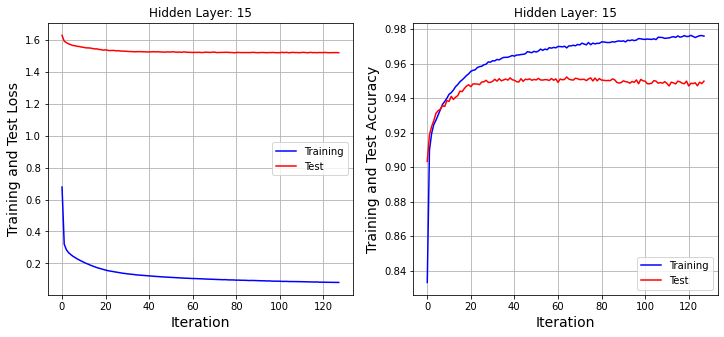

In [44]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss4, 'b', label = "Training")
ax[0].plot(range(128), test_loss4, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 15')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc4, 'b', label = "Training")
ax[1].plot(range(128), test_acc4, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 15')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 15.png")

In [45]:
model = BaselineModel(784,30,10)

train_loss4 = np.zeros(128)
test_loss4 = np.zeros(128)
train_acc4 = np.zeros(128)
test_acc4 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.31036800146102905, 'running_acc': 0.9112499952316284, 'loss': 0.5649504065513611, 'acc': 0.8564500212669373, 'val_loss': 1.6056700944900513, 'val_acc': 0.9152999520301819}
Epoch: 1
Training Loss: 0.5649504065513611
Training Accuracy: 0.8564500212669373
Test Loss: 1.6056700944900513
Test Accuracy: 0.9152999520301819


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2440718412399292, 'running_acc': 0.9329687356948853, 'loss': 0.2780591547489166, 'acc': 0.9204500317573547, 'val_loss': 1.5779169797897339, 'val_acc': 0.9285999536514282}
Epoch: 2
Training Loss: 0.2780591547489166
Training Accuracy: 0.9204500317573547
Test Loss: 1.5779169797897339
Test Accuracy: 0.9285999536514282


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.22064651548862457, 'running_acc': 0.9406249523162842, 'loss': 0.23396508395671844, 'acc': 0.9333166480064392, 'val_loss': 1.560163140296936, 'val_acc': 0.9371999502182007}
Epoch: 3
Training Loss: 0.23396508395671844
Training Accuracy: 0.9333166480064392
Test Loss: 1.560163140296936
Test Accuracy: 0.9371999502182007


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.2003866285085678, 'running_acc': 0.94203120470047, 'loss': 0.2039881944656372, 'acc': 0.9420666694641113, 'val_loss': 1.5555802583694458, 'val_acc': 0.9408999681472778}
Epoch: 4
Training Loss: 0.2039881944656372
Training Accuracy: 0.9420666694641113
Test Loss: 1.5555802583694458
Test Accuracy: 0.9408999681472778


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.17807041108608246, 'running_acc': 0.9509374499320984, 'loss': 0.18258008360862732, 'acc': 0.9483000040054321, 'val_loss': 1.5437620878219604, 'val_acc': 0.9491999745368958}
Epoch: 5
Training Loss: 0.18258008360862732
Training Accuracy: 0.9483000040054321
Test Loss: 1.5437620878219604
Test Accuracy: 0.9491999745368958


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.17126119136810303, 'running_acc': 0.9528124928474426, 'loss': 0.16368135809898376, 'acc': 0.9531833529472351, 'val_loss': 1.5369871854782104, 'val_acc': 0.9530999660491943}
Epoch: 6
Training Loss: 0.16368135809898376
Training Accuracy: 0.9531833529472351
Test Loss: 1.5369871854782104
Test Accuracy: 0.9530999660491943


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1399618536233902, 'running_acc': 0.9595312476158142, 'loss': 0.14879553020000458, 'acc': 0.9574166536331177, 'val_loss': 1.5315866470336914, 'val_acc': 0.9565999507904053}
Epoch: 7
Training Loss: 0.14879553020000458
Training Accuracy: 0.9574166536331177
Test Loss: 1.5315866470336914
Test Accuracy: 0.9565999507904053


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.12830546498298645, 'running_acc': 0.9642187356948853, 'loss': 0.1364714503288269, 'acc': 0.9615333676338196, 'val_loss': 1.5271356105804443, 'val_acc': 0.9577999711036682}
Epoch: 8
Training Loss: 0.1364714503288269
Training Accuracy: 0.9615333676338196
Test Loss: 1.5271356105804443
Test Accuracy: 0.9577999711036682


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11826775223016739, 'running_acc': 0.9657812118530273, 'loss': 0.12523102760314941, 'acc': 0.9641667008399963, 'val_loss': 1.5216318368911743, 'val_acc': 0.960099995136261}
Epoch: 9
Training Loss: 0.12523102760314941
Training Accuracy: 0.9641667008399963
Test Loss: 1.5216318368911743
Test Accuracy: 0.960099995136261


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11157555133104324, 'running_acc': 0.9674999713897705, 'loss': 0.11671774089336395, 'acc': 0.9660666584968567, 'val_loss': 1.5193068981170654, 'val_acc': 0.9609999656677246}
Epoch: 10
Training Loss: 0.11671774089336395
Training Accuracy: 0.9660666584968567
Test Loss: 1.5193068981170654
Test Accuracy: 0.9609999656677246


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11426416039466858, 'running_acc': 0.9653124809265137, 'loss': 0.10876210778951645, 'acc': 0.9687833189964294, 'val_loss': 1.519108533859253, 'val_acc': 0.9613999724388123}
Epoch: 11
Training Loss: 0.10876210778951645
Training Accuracy: 0.9687833189964294
Test Loss: 1.519108533859253
Test Accuracy: 0.9613999724388123


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.11237666755914688, 'running_acc': 0.9684374928474426, 'loss': 0.10199356824159622, 'acc': 0.9702833294868469, 'val_loss': 1.5159212350845337, 'val_acc': 0.9626999497413635}
Epoch: 12
Training Loss: 0.10199356824159622
Training Accuracy: 0.9702833294868469
Test Loss: 1.5159212350845337
Test Accuracy: 0.9626999497413635


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09103307873010635, 'running_acc': 0.9762499928474426, 'loss': 0.09671974927186966, 'acc': 0.972000002861023, 'val_loss': 1.512652039527893, 'val_acc': 0.9645999670028687}
Epoch: 13
Training Loss: 0.09671974927186966
Training Accuracy: 0.972000002861023
Test Loss: 1.512652039527893
Test Accuracy: 0.9645999670028687


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09761723130941391, 'running_acc': 0.9715625047683716, 'loss': 0.09053108841180801, 'acc': 0.9736166596412659, 'val_loss': 1.5111138820648193, 'val_acc': 0.9666000008583069}
Epoch: 14
Training Loss: 0.09053108841180801
Training Accuracy: 0.9736166596412659
Test Loss: 1.5111138820648193
Test Accuracy: 0.9666000008583069


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09068161994218826, 'running_acc': 0.9735937118530273, 'loss': 0.08632179349660873, 'acc': 0.9748833179473877, 'val_loss': 1.5096927881240845, 'val_acc': 0.9652999639511108}
Epoch: 15
Training Loss: 0.08632179349660873
Training Accuracy: 0.9748833179473877
Test Loss: 1.5096927881240845
Test Accuracy: 0.9652999639511108


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08550067991018295, 'running_acc': 0.9729687571525574, 'loss': 0.0821981281042099, 'acc': 0.975683331489563, 'val_loss': 1.5088648796081543, 'val_acc': 0.9651999473571777}
Epoch: 16
Training Loss: 0.0821981281042099
Training Accuracy: 0.975683331489563
Test Loss: 1.5088648796081543
Test Accuracy: 0.9651999473571777


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.07787232100963593, 'running_acc': 0.9781249761581421, 'loss': 0.07783858478069305, 'acc': 0.9768666625022888, 'val_loss': 1.5060237646102905, 'val_acc': 0.9666999578475952}
Epoch: 17
Training Loss: 0.07783858478069305
Training Accuracy: 0.9768666625022888
Test Loss: 1.5060237646102905
Test Accuracy: 0.9666999578475952


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06957588344812393, 'running_acc': 0.98046875, 'loss': 0.07453897595405579, 'acc': 0.9778333306312561, 'val_loss': 1.5052849054336548, 'val_acc': 0.9675999879837036}
Epoch: 18
Training Loss: 0.07453897595405579
Training Accuracy: 0.9778333306312561
Test Loss: 1.5052849054336548
Test Accuracy: 0.9675999879837036


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.07678840309381485, 'running_acc': 0.9779687523841858, 'loss': 0.0716932937502861, 'acc': 0.9790666699409485, 'val_loss': 1.504807710647583, 'val_acc': 0.9678999781608582}
Epoch: 19
Training Loss: 0.0716932937502861
Training Accuracy: 0.9790666699409485
Test Loss: 1.504807710647583
Test Accuracy: 0.9678999781608582


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0751035138964653, 'running_acc': 0.9770312309265137, 'loss': 0.06814564019441605, 'acc': 0.9800000190734863, 'val_loss': 1.5058817863464355, 'val_acc': 0.9684999585151672}
Epoch: 20
Training Loss: 0.06814564019441605
Training Accuracy: 0.9800000190734863
Test Loss: 1.5058817863464355
Test Accuracy: 0.9684999585151672


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06887466460466385, 'running_acc': 0.9789062142372131, 'loss': 0.06587942689657211, 'acc': 0.9805999994277954, 'val_loss': 1.5050898790359497, 'val_acc': 0.9680999517440796}
Epoch: 21
Training Loss: 0.06587942689657211
Training Accuracy: 0.9805999994277954
Test Loss: 1.5050898790359497
Test Accuracy: 0.9680999517440796


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0606485977768898, 'running_acc': 0.9829687476158142, 'loss': 0.06319915503263474, 'acc': 0.9816166758537292, 'val_loss': 1.5031071901321411, 'val_acc': 0.967799961566925}
Epoch: 22
Training Loss: 0.06319915503263474
Training Accuracy: 0.9816166758537292
Test Loss: 1.5031071901321411
Test Accuracy: 0.967799961566925


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.061668384820222855, 'running_acc': 0.9814062118530273, 'loss': 0.061109758913517, 'acc': 0.9821333289146423, 'val_loss': 1.5036579370498657, 'val_acc': 0.9674999713897705}
Epoch: 23
Training Loss: 0.061109758913517
Training Accuracy: 0.9821333289146423
Test Loss: 1.5036579370498657
Test Accuracy: 0.9674999713897705


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06155557557940483, 'running_acc': 0.9826562404632568, 'loss': 0.05814307555556297, 'acc': 0.9830166697502136, 'val_loss': 1.5026456117630005, 'val_acc': 0.9695000052452087}
Epoch: 24
Training Loss: 0.05814307555556297
Training Accuracy: 0.9830166697502136
Test Loss: 1.5026456117630005
Test Accuracy: 0.9695000052452087


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06039618328213692, 'running_acc': 0.9824999570846558, 'loss': 0.056361567229032516, 'acc': 0.9837833642959595, 'val_loss': 1.50344979763031, 'val_acc': 0.9669999480247498}
Epoch: 25
Training Loss: 0.056361567229032516
Training Accuracy: 0.9837833642959595
Test Loss: 1.50344979763031
Test Accuracy: 0.9669999480247498


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.057235464453697205, 'running_acc': 0.9834374785423279, 'loss': 0.05427571386098862, 'acc': 0.9839500188827515, 'val_loss': 1.501357913017273, 'val_acc': 0.9679999947547913}
Epoch: 26
Training Loss: 0.05427571386098862
Training Accuracy: 0.9839500188827515
Test Loss: 1.501357913017273
Test Accuracy: 0.9679999947547913


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.057322632521390915, 'running_acc': 0.9832812547683716, 'loss': 0.05221100151538849, 'acc': 0.9849666953086853, 'val_loss': 1.500542163848877, 'val_acc': 0.968999981880188}
Epoch: 27
Training Loss: 0.05221100151538849
Training Accuracy: 0.9849666953086853
Test Loss: 1.500542163848877
Test Accuracy: 0.968999981880188


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.052622728049755096, 'running_acc': 0.9842187166213989, 'loss': 0.050586357712745667, 'acc': 0.9854333400726318, 'val_loss': 1.5009418725967407, 'val_acc': 0.9697999954223633}
Epoch: 28
Training Loss: 0.050586357712745667
Training Accuracy: 0.9854333400726318
Test Loss: 1.5009418725967407
Test Accuracy: 0.9697999954223633


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.05160295218229294, 'running_acc': 0.9859374761581421, 'loss': 0.04903888702392578, 'acc': 0.9862833619117737, 'val_loss': 1.4999579191207886, 'val_acc': 0.9695999622344971}
Epoch: 29
Training Loss: 0.04903888702392578
Training Accuracy: 0.9862833619117737
Test Loss: 1.4999579191207886
Test Accuracy: 0.9695999622344971


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04624662920832634, 'running_acc': 0.9862499833106995, 'loss': 0.046977680176496506, 'acc': 0.9860666990280151, 'val_loss': 1.5010203123092651, 'val_acc': 0.9677000045776367}
Epoch: 30
Training Loss: 0.046977680176496506
Training Accuracy: 0.9860666990280151
Test Loss: 1.5010203123092651
Test Accuracy: 0.9677000045776367


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.05226963013410568, 'running_acc': 0.9832812547683716, 'loss': 0.0456017330288887, 'acc': 0.9868167042732239, 'val_loss': 1.499540090560913, 'val_acc': 0.9695999622344971}
Epoch: 31
Training Loss: 0.0456017330288887
Training Accuracy: 0.9868167042732239
Test Loss: 1.499540090560913
Test Accuracy: 0.9695999622344971


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04959598928689957, 'running_acc': 0.9859374761581421, 'loss': 0.04442741349339485, 'acc': 0.987500011920929, 'val_loss': 1.4990285634994507, 'val_acc': 0.968999981880188}
Epoch: 32
Training Loss: 0.04442741349339485
Training Accuracy: 0.987500011920929
Test Loss: 1.4990285634994507
Test Accuracy: 0.968999981880188


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04454880952835083, 'running_acc': 0.9876562356948853, 'loss': 0.042873263359069824, 'acc': 0.987766683101654, 'val_loss': 1.499416470527649, 'val_acc': 0.9698999524116516}
Epoch: 33
Training Loss: 0.042873263359069824
Training Accuracy: 0.987766683101654
Test Loss: 1.499416470527649
Test Accuracy: 0.9698999524116516


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.042263805866241455, 'running_acc': 0.9874999523162842, 'loss': 0.04139696806669235, 'acc': 0.9886333346366882, 'val_loss': 1.4980881214141846, 'val_acc': 0.9686999917030334}
Epoch: 34
Training Loss: 0.04139696806669235
Training Accuracy: 0.9886333346366882
Test Loss: 1.4980881214141846
Test Accuracy: 0.9686999917030334


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03723817318677902, 'running_acc': 0.98828125, 'loss': 0.03985689580440521, 'acc': 0.9885333180427551, 'val_loss': 1.4979225397109985, 'val_acc': 0.9692999720573425}
Epoch: 35
Training Loss: 0.03985689580440521
Training Accuracy: 0.9885333180427551
Test Loss: 1.4979225397109985
Test Accuracy: 0.9692999720573425


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.042402271181344986, 'running_acc': 0.9884374737739563, 'loss': 0.03881428390741348, 'acc': 0.9889000058174133, 'val_loss': 1.498769998550415, 'val_acc': 0.9686999917030334}
Epoch: 36
Training Loss: 0.03881428390741348
Training Accuracy: 0.9889000058174133
Test Loss: 1.498769998550415
Test Accuracy: 0.9686999917030334


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.036695290356874466, 'running_acc': 0.9901562333106995, 'loss': 0.03753373399376869, 'acc': 0.9894000291824341, 'val_loss': 1.4982038736343384, 'val_acc': 0.9699999690055847}
Epoch: 37
Training Loss: 0.03753373399376869
Training Accuracy: 0.9894000291824341
Test Loss: 1.4982038736343384
Test Accuracy: 0.9699999690055847


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.045549459755420685, 'running_acc': 0.9881249666213989, 'loss': 0.03634036332368851, 'acc': 0.9900500178337097, 'val_loss': 1.497127890586853, 'val_acc': 0.9700999855995178}
Epoch: 38
Training Loss: 0.03634036332368851
Training Accuracy: 0.9900500178337097
Test Loss: 1.497127890586853
Test Accuracy: 0.9700999855995178


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0466374047100544, 'running_acc': 0.9864062070846558, 'loss': 0.035759031772613525, 'acc': 0.9901000261306763, 'val_loss': 1.499657154083252, 'val_acc': 0.9666000008583069}
Epoch: 39
Training Loss: 0.035759031772613525
Training Accuracy: 0.9901000261306763
Test Loss: 1.499657154083252
Test Accuracy: 0.9666000008583069


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04049107804894447, 'running_acc': 0.9884374737739563, 'loss': 0.034082066267728806, 'acc': 0.9903333187103271, 'val_loss': 1.4974771738052368, 'val_acc': 0.9682999849319458}
Epoch: 40
Training Loss: 0.034082066267728806
Training Accuracy: 0.9903333187103271
Test Loss: 1.4974771738052368
Test Accuracy: 0.9682999849319458


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04259289801120758, 'running_acc': 0.9881249666213989, 'loss': 0.03297335281968117, 'acc': 0.9909833669662476, 'val_loss': 1.4970077276229858, 'val_acc': 0.9698999524116516}
Epoch: 41
Training Loss: 0.03297335281968117
Training Accuracy: 0.9909833669662476
Test Loss: 1.4970077276229858
Test Accuracy: 0.9698999524116516


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03232375904917717, 'running_acc': 0.9899999499320984, 'loss': 0.03191009908914566, 'acc': 0.9911666512489319, 'val_loss': 1.498028039932251, 'val_acc': 0.9682999849319458}
Epoch: 42
Training Loss: 0.03191009908914566
Training Accuracy: 0.9911666512489319
Test Loss: 1.498028039932251
Test Accuracy: 0.9682999849319458


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03609956428408623, 'running_acc': 0.9898437261581421, 'loss': 0.030920227989554405, 'acc': 0.9918166995048523, 'val_loss': 1.4974045753479004, 'val_acc': 0.9696999788284302}
Epoch: 43
Training Loss: 0.030920227989554405
Training Accuracy: 0.9918166995048523
Test Loss: 1.4974045753479004
Test Accuracy: 0.9696999788284302


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04038494825363159, 'running_acc': 0.98828125, 'loss': 0.0302767064422369, 'acc': 0.9916000366210938, 'val_loss': 1.4985681772232056, 'val_acc': 0.9680999517440796}
Epoch: 44
Training Loss: 0.0302767064422369
Training Accuracy: 0.9916000366210938
Test Loss: 1.4985681772232056
Test Accuracy: 0.9680999517440796


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.029214195907115936, 'running_acc': 0.9914062023162842, 'loss': 0.029910694807767868, 'acc': 0.9918333292007446, 'val_loss': 1.4979416131973267, 'val_acc': 0.9674999713897705}
Epoch: 45
Training Loss: 0.029910694807767868
Training Accuracy: 0.9918333292007446
Test Loss: 1.4979416131973267
Test Accuracy: 0.9674999713897705


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0303500909358263, 'running_acc': 0.9918749928474426, 'loss': 0.02870720438659191, 'acc': 0.9924333691596985, 'val_loss': 1.4980673789978027, 'val_acc': 0.9687999486923218}
Epoch: 46
Training Loss: 0.02870720438659191
Training Accuracy: 0.9924333691596985
Test Loss: 1.4980673789978027
Test Accuracy: 0.9687999486923218


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02966904081404209, 'running_acc': 0.9909374713897705, 'loss': 0.0274062342941761, 'acc': 0.9927833676338196, 'val_loss': 1.4972645044326782, 'val_acc': 0.9697999954223633}
Epoch: 47
Training Loss: 0.0274062342941761
Training Accuracy: 0.9927833676338196
Test Loss: 1.4972645044326782
Test Accuracy: 0.9697999954223633


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.028246011584997177, 'running_acc': 0.9931249618530273, 'loss': 0.02692488767206669, 'acc': 0.9930000305175781, 'val_loss': 1.4972010850906372, 'val_acc': 0.9682999849319458}
Epoch: 48
Training Loss: 0.02692488767206669
Training Accuracy: 0.9930000305175781
Test Loss: 1.4972010850906372
Test Accuracy: 0.9682999849319458


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.026208439841866493, 'running_acc': 0.99281245470047, 'loss': 0.025604400783777237, 'acc': 0.9930333495140076, 'val_loss': 1.4972749948501587, 'val_acc': 0.9682999849319458}
Epoch: 49
Training Loss: 0.025604400783777237
Training Accuracy: 0.9930333495140076
Test Loss: 1.4972749948501587
Test Accuracy: 0.9682999849319458


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.025558466091752052, 'running_acc': 0.9926562309265137, 'loss': 0.02491571009159088, 'acc': 0.993316650390625, 'val_loss': 1.4966809749603271, 'val_acc': 0.9680999517440796}
Epoch: 50
Training Loss: 0.02491571009159088
Training Accuracy: 0.993316650390625
Test Loss: 1.4966809749603271
Test Accuracy: 0.9680999517440796


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02577189914882183, 'running_acc': 0.992968738079071, 'loss': 0.02485383115708828, 'acc': 0.9934833645820618, 'val_loss': 1.4966754913330078, 'val_acc': 0.9678999781608582}
Epoch: 51
Training Loss: 0.02485383115708828
Training Accuracy: 0.9934833645820618
Test Loss: 1.4966754913330078
Test Accuracy: 0.9678999781608582


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.024210123345255852, 'running_acc': 0.9943749904632568, 'loss': 0.023312227800488472, 'acc': 0.994100034236908, 'val_loss': 1.4962270259857178, 'val_acc': 0.9682999849319458}
Epoch: 52
Training Loss: 0.023312227800488472
Training Accuracy: 0.994100034236908
Test Loss: 1.4962270259857178
Test Accuracy: 0.9682999849319458


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.021782858297228813, 'running_acc': 0.9932812452316284, 'loss': 0.02285531349480152, 'acc': 0.9940666556358337, 'val_loss': 1.4984314441680908, 'val_acc': 0.9680999517440796}
Epoch: 53
Training Loss: 0.02285531349480152
Training Accuracy: 0.9940666556358337
Test Loss: 1.4984314441680908
Test Accuracy: 0.9680999517440796


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.025342117995023727, 'running_acc': 0.9935937523841858, 'loss': 0.02176733687520027, 'acc': 0.9949666857719421, 'val_loss': 1.496082067489624, 'val_acc': 0.9681999683380127}
Epoch: 54
Training Loss: 0.02176733687520027
Training Accuracy: 0.9949666857719421
Test Loss: 1.496082067489624
Test Accuracy: 0.9681999683380127


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.022953102365136147, 'running_acc': 0.9932812452316284, 'loss': 0.021913686767220497, 'acc': 0.9939833283424377, 'val_loss': 1.4966278076171875, 'val_acc': 0.9673999547958374}
Epoch: 55
Training Loss: 0.021913686767220497
Training Accuracy: 0.9939833283424377
Test Loss: 1.4966278076171875
Test Accuracy: 0.9673999547958374


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0226970836520195, 'running_acc': 0.992968738079071, 'loss': 0.021467361599206924, 'acc': 0.9944833517074585, 'val_loss': 1.4966117143630981, 'val_acc': 0.9679999947547913}
Epoch: 56
Training Loss: 0.021467361599206924
Training Accuracy: 0.9944833517074585
Test Loss: 1.4966117143630981
Test Accuracy: 0.9679999947547913


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02335358038544655, 'running_acc': 0.992968738079071, 'loss': 0.020100723952054977, 'acc': 0.995033323764801, 'val_loss': 1.497298002243042, 'val_acc': 0.967799961566925}
Epoch: 57
Training Loss: 0.020100723952054977
Training Accuracy: 0.995033323764801
Test Loss: 1.497298002243042
Test Accuracy: 0.967799961566925


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02241705171763897, 'running_acc': 0.9942187070846558, 'loss': 0.01956934481859207, 'acc': 0.9950833320617676, 'val_loss': 1.4968762397766113, 'val_acc': 0.9674999713897705}
Epoch: 58
Training Loss: 0.01956934481859207
Training Accuracy: 0.9950833320617676
Test Loss: 1.4968762397766113
Test Accuracy: 0.9674999713897705


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.021878346800804138, 'running_acc': 0.9948437213897705, 'loss': 0.01894466020166874, 'acc': 0.9953833222389221, 'val_loss': 1.4981780052185059, 'val_acc': 0.9669999480247498}
Epoch: 59
Training Loss: 0.01894466020166874
Training Accuracy: 0.9953833222389221
Test Loss: 1.4981780052185059
Test Accuracy: 0.9669999480247498


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01734764128923416, 'running_acc': 0.9946874976158142, 'loss': 0.01841391995549202, 'acc': 0.9953833222389221, 'val_loss': 1.4986203908920288, 'val_acc': 0.9666000008583069}
Epoch: 60
Training Loss: 0.01841391995549202
Training Accuracy: 0.9953833222389221
Test Loss: 1.4986203908920288
Test Accuracy: 0.9666000008583069


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02149195224046707, 'running_acc': 0.9945312142372131, 'loss': 0.017782161012291908, 'acc': 0.9956833720207214, 'val_loss': 1.4960378408432007, 'val_acc': 0.967799961566925}
Epoch: 61
Training Loss: 0.017782161012291908
Training Accuracy: 0.9956833720207214
Test Loss: 1.4960378408432007
Test Accuracy: 0.967799961566925


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.020649483427405357, 'running_acc': 0.9957812428474426, 'loss': 0.01729203574359417, 'acc': 0.9958166480064392, 'val_loss': 1.495613932609558, 'val_acc': 0.9681999683380127}
Epoch: 62
Training Loss: 0.01729203574359417
Training Accuracy: 0.9958166480064392
Test Loss: 1.495613932609558
Test Accuracy: 0.9681999683380127


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.018210826441645622, 'running_acc': 0.9946874976158142, 'loss': 0.017539573833346367, 'acc': 0.9955166578292847, 'val_loss': 1.4959614276885986, 'val_acc': 0.9681999683380127}
Epoch: 63
Training Loss: 0.017539573833346367
Training Accuracy: 0.9955166578292847
Test Loss: 1.4959614276885986
Test Accuracy: 0.9681999683380127


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.014744684100151062, 'running_acc': 0.99671870470047, 'loss': 0.016255071386694908, 'acc': 0.996483325958252, 'val_loss': 1.497778296470642, 'val_acc': 0.967799961566925}
Epoch: 64
Training Loss: 0.016255071386694908
Training Accuracy: 0.996483325958252
Test Loss: 1.497778296470642
Test Accuracy: 0.967799961566925


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.015451583079993725, 'running_acc': 0.9964062571525574, 'loss': 0.01586177758872509, 'acc': 0.9963333606719971, 'val_loss': 1.496392846107483, 'val_acc': 0.967199981212616}
Epoch: 65
Training Loss: 0.01586177758872509
Training Accuracy: 0.9963333606719971
Test Loss: 1.496392846107483
Test Accuracy: 0.967199981212616


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.018623236566781998, 'running_acc': 0.9943749904632568, 'loss': 0.015247331000864506, 'acc': 0.9965833425521851, 'val_loss': 1.4965393543243408, 'val_acc': 0.9695000052452087}
Epoch: 66
Training Loss: 0.015247331000864506
Training Accuracy: 0.9965833425521851
Test Loss: 1.4965393543243408
Test Accuracy: 0.9695000052452087


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.017855016514658928, 'running_acc': 0.9964062571525574, 'loss': 0.014723019674420357, 'acc': 0.9968833327293396, 'val_loss': 1.4970321655273438, 'val_acc': 0.9674999713897705}
Epoch: 67
Training Loss: 0.014723019674420357
Training Accuracy: 0.9968833327293396
Test Loss: 1.4970321655273438
Test Accuracy: 0.9674999713897705


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01763150840997696, 'running_acc': 0.9956249594688416, 'loss': 0.014319484122097492, 'acc': 0.996916651725769, 'val_loss': 1.4961352348327637, 'val_acc': 0.9681999683380127}
Epoch: 68
Training Loss: 0.014319484122097492
Training Accuracy: 0.996916651725769
Test Loss: 1.4961352348327637
Test Accuracy: 0.9681999683380127


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.016742020845413208, 'running_acc': 0.99671870470047, 'loss': 0.013917133212089539, 'acc': 0.9971833229064941, 'val_loss': 1.4963628053665161, 'val_acc': 0.9673999547958374}
Epoch: 69
Training Loss: 0.013917133212089539
Training Accuracy: 0.9971833229064941
Test Loss: 1.4963628053665161
Test Accuracy: 0.9673999547958374


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012489031068980694, 'running_acc': 0.9976562261581421, 'loss': 0.013437537476420403, 'acc': 0.9971500039100647, 'val_loss': 1.4954177141189575, 'val_acc': 0.9687999486923218}
Epoch: 70
Training Loss: 0.013437537476420403
Training Accuracy: 0.9971500039100647
Test Loss: 1.4954177141189575
Test Accuracy: 0.9687999486923218


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010850878432393074, 'running_acc': 0.9978124499320984, 'loss': 0.013342444784939289, 'acc': 0.9972333312034607, 'val_loss': 1.4967162609100342, 'val_acc': 0.9687999486923218}
Epoch: 71
Training Loss: 0.013342444784939289
Training Accuracy: 0.9972333312034607
Test Loss: 1.4967162609100342
Test Accuracy: 0.9687999486923218


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.014326830394566059, 'running_acc': 0.9970312118530273, 'loss': 0.012854770757257938, 'acc': 0.9971166849136353, 'val_loss': 1.496212363243103, 'val_acc': 0.9680999517440796}
Epoch: 72
Training Loss: 0.012854770757257938
Training Accuracy: 0.9971166849136353
Test Loss: 1.496212363243103
Test Accuracy: 0.9680999517440796


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009230160154402256, 'running_acc': 0.9989062547683716, 'loss': 0.011886723339557648, 'acc': 0.9979000091552734, 'val_loss': 1.4951751232147217, 'val_acc': 0.9684999585151672}
Epoch: 73
Training Loss: 0.011886723339557648
Training Accuracy: 0.9979000091552734
Test Loss: 1.4951751232147217
Test Accuracy: 0.9684999585151672


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013444790616631508, 'running_acc': 0.9965624809265137, 'loss': 0.012023722752928734, 'acc': 0.9976166486740112, 'val_loss': 1.4958869218826294, 'val_acc': 0.9666000008583069}
Epoch: 74
Training Loss: 0.012023722752928734
Training Accuracy: 0.9976166486740112
Test Loss: 1.4958869218826294
Test Accuracy: 0.9666000008583069


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012362715788185596, 'running_acc': 0.9971874952316284, 'loss': 0.01173344999551773, 'acc': 0.9976000189781189, 'val_loss': 1.4956461191177368, 'val_acc': 0.9670999646186829}
Epoch: 75
Training Loss: 0.01173344999551773
Training Accuracy: 0.9976000189781189
Test Loss: 1.4956461191177368
Test Accuracy: 0.9670999646186829


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01218793448060751, 'running_acc': 0.996874988079071, 'loss': 0.011706758290529251, 'acc': 0.9974499940872192, 'val_loss': 1.4962800741195679, 'val_acc': 0.9660999774932861}
Epoch: 76
Training Loss: 0.011706758290529251
Training Accuracy: 0.9974499940872192
Test Loss: 1.4962800741195679
Test Accuracy: 0.9660999774932861


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012397006154060364, 'running_acc': 0.9978124499320984, 'loss': 0.010777152143418789, 'acc': 0.9979333281517029, 'val_loss': 1.4962078332901, 'val_acc': 0.9669999480247498}
Epoch: 77
Training Loss: 0.010777152143418789
Training Accuracy: 0.9979333281517029
Test Loss: 1.4962078332901
Test Accuracy: 0.9669999480247498


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01184909325093031, 'running_acc': 0.996874988079071, 'loss': 0.011075375601649284, 'acc': 0.997866690158844, 'val_loss': 1.4957863092422485, 'val_acc': 0.965999960899353}
Epoch: 78
Training Loss: 0.011075375601649284
Training Accuracy: 0.997866690158844
Test Loss: 1.4957863092422485
Test Accuracy: 0.965999960899353


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011416517198085785, 'running_acc': 0.9981249570846558, 'loss': 0.010052770376205444, 'acc': 0.9980666637420654, 'val_loss': 1.496181845664978, 'val_acc': 0.9670999646186829}
Epoch: 79
Training Loss: 0.010052770376205444
Training Accuracy: 0.9980666637420654
Test Loss: 1.496181845664978
Test Accuracy: 0.9670999646186829


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011035946197807789, 'running_acc': 0.9979687333106995, 'loss': 0.009983439929783344, 'acc': 0.998199999332428, 'val_loss': 1.4963209629058838, 'val_acc': 0.9662999510765076}
Epoch: 80
Training Loss: 0.009983439929783344
Training Accuracy: 0.998199999332428
Test Loss: 1.4963209629058838
Test Accuracy: 0.9662999510765076


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01036904752254486, 'running_acc': 0.9979687333106995, 'loss': 0.009878233075141907, 'acc': 0.9980500340461731, 'val_loss': 1.4954216480255127, 'val_acc': 0.967799961566925}
Epoch: 81
Training Loss: 0.009878233075141907
Training Accuracy: 0.9980500340461731
Test Loss: 1.4954216480255127
Test Accuracy: 0.967799961566925


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012700915336608887, 'running_acc': 0.9965624809265137, 'loss': 0.009290195070207119, 'acc': 0.9982166886329651, 'val_loss': 1.4962095022201538, 'val_acc': 0.9672999978065491}
Epoch: 82
Training Loss: 0.009290195070207119
Training Accuracy: 0.9982166886329651
Test Loss: 1.4962095022201538
Test Accuracy: 0.9672999978065491


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008137398399412632, 'running_acc': 0.9981249570846558, 'loss': 0.00962409470230341, 'acc': 0.9979000091552734, 'val_loss': 1.4960802793502808, 'val_acc': 0.9682999849319458}
Epoch: 83
Training Loss: 0.00962409470230341
Training Accuracy: 0.9979000091552734
Test Loss: 1.4960802793502808
Test Accuracy: 0.9682999849319458


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011697264388203621, 'running_acc': 0.9982812404632568, 'loss': 0.008456132374703884, 'acc': 0.9988333582878113, 'val_loss': 1.4956917762756348, 'val_acc': 0.9682999849319458}
Epoch: 84
Training Loss: 0.008456132374703884
Training Accuracy: 0.9988333582878113
Test Loss: 1.4956917762756348
Test Accuracy: 0.9682999849319458


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008519144728779793, 'running_acc': 0.9975000023841858, 'loss': 0.008473692461848259, 'acc': 0.9985333681106567, 'val_loss': 1.4965726137161255, 'val_acc': 0.9662999510765076}
Epoch: 85
Training Loss: 0.008473692461848259
Training Accuracy: 0.9985333681106567
Test Loss: 1.4965726137161255
Test Accuracy: 0.9662999510765076


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009826580993831158, 'running_acc': 0.9978124499320984, 'loss': 0.008495605550706387, 'acc': 0.9984333515167236, 'val_loss': 1.4953269958496094, 'val_acc': 0.9669999480247498}
Epoch: 86
Training Loss: 0.008495605550706387
Training Accuracy: 0.9984333515167236
Test Loss: 1.4953269958496094
Test Accuracy: 0.9669999480247498


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010432634502649307, 'running_acc': 0.9978124499320984, 'loss': 0.008291838690638542, 'acc': 0.9984333515167236, 'val_loss': 1.496391773223877, 'val_acc': 0.9677000045776367}
Epoch: 87
Training Loss: 0.008291838690638542
Training Accuracy: 0.9984333515167236
Test Loss: 1.496391773223877
Test Accuracy: 0.9677000045776367


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008412634953856468, 'running_acc': 0.9984374642372131, 'loss': 0.007614101283252239, 'acc': 0.9987833499908447, 'val_loss': 1.4955027103424072, 'val_acc': 0.9668999910354614}
Epoch: 88
Training Loss: 0.007614101283252239
Training Accuracy: 0.9987833499908447
Test Loss: 1.4955027103424072
Test Accuracy: 0.9668999910354614


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009358150884509087, 'running_acc': 0.9975000023841858, 'loss': 0.0076394882053136826, 'acc': 0.9988166689872742, 'val_loss': 1.4969227313995361, 'val_acc': 0.9660999774932861}
Epoch: 89
Training Loss: 0.0076394882053136826
Training Accuracy: 0.9988166689872742
Test Loss: 1.4969227313995361
Test Accuracy: 0.9660999774932861


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008872125297784805, 'running_acc': 0.9992187023162842, 'loss': 0.007182026747614145, 'acc': 0.9989333152770996, 'val_loss': 1.4971375465393066, 'val_acc': 0.9657999873161316}
Epoch: 90
Training Loss: 0.007182026747614145
Training Accuracy: 0.9989333152770996
Test Loss: 1.4971375465393066
Test Accuracy: 0.9657999873161316


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009831896051764488, 'running_acc': 0.9984374642372131, 'loss': 0.007487044204026461, 'acc': 0.9987000226974487, 'val_loss': 1.4970111846923828, 'val_acc': 0.9661999940872192}
Epoch: 91
Training Loss: 0.007487044204026461
Training Accuracy: 0.9987000226974487
Test Loss: 1.4970111846923828
Test Accuracy: 0.9661999940872192


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007494780700653791, 'running_acc': 0.9981249570846558, 'loss': 0.006869728211313486, 'acc': 0.9987666606903076, 'val_loss': 1.4957711696624756, 'val_acc': 0.9666000008583069}
Epoch: 92
Training Loss: 0.006869728211313486
Training Accuracy: 0.9987666606903076
Test Loss: 1.4957711696624756
Test Accuracy: 0.9666000008583069


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007494882680475712, 'running_acc': 0.9989062547683716, 'loss': 0.006542691960930824, 'acc': 0.9989333152770996, 'val_loss': 1.4964349269866943, 'val_acc': 0.9667999744415283}
Epoch: 93
Training Loss: 0.006542691960930824
Training Accuracy: 0.9989333152770996
Test Loss: 1.4964349269866943
Test Accuracy: 0.9667999744415283


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006100567989051342, 'running_acc': 0.9990624785423279, 'loss': 0.0062308525666594505, 'acc': 0.9990666508674622, 'val_loss': 1.4953562021255493, 'val_acc': 0.9678999781608582}
Epoch: 94
Training Loss: 0.0062308525666594505
Training Accuracy: 0.9990666508674622
Test Loss: 1.4953562021255493
Test Accuracy: 0.9678999781608582


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009152260608971119, 'running_acc': 0.9981249570846558, 'loss': 0.006609172094613314, 'acc': 0.9989166855812073, 'val_loss': 1.496684193611145, 'val_acc': 0.9659000039100647}
Epoch: 95
Training Loss: 0.006609172094613314
Training Accuracy: 0.9989166855812073
Test Loss: 1.496684193611145
Test Accuracy: 0.9659000039100647


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007502558641135693, 'running_acc': 0.9984374642372131, 'loss': 0.006337280850857496, 'acc': 0.9988000392913818, 'val_loss': 1.4970943927764893, 'val_acc': 0.9648000001907349}
Epoch: 96
Training Loss: 0.006337280850857496
Training Accuracy: 0.9988000392913818
Test Loss: 1.4970943927764893
Test Accuracy: 0.9648000001907349


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008290281519293785, 'running_acc': 0.9982812404632568, 'loss': 0.005888515617698431, 'acc': 0.9991500377655029, 'val_loss': 1.4965453147888184, 'val_acc': 0.9656999707221985}
Epoch: 97
Training Loss: 0.005888515617698431
Training Accuracy: 0.9991500377655029
Test Loss: 1.4965453147888184
Test Accuracy: 0.9656999707221985


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007412285543978214, 'running_acc': 0.9982812404632568, 'loss': 0.005926846992224455, 'acc': 0.9990167021751404, 'val_loss': 1.4970543384552002, 'val_acc': 0.9651999473571777}
Epoch: 98
Training Loss: 0.005926846992224455
Training Accuracy: 0.9990167021751404
Test Loss: 1.4970543384552002
Test Accuracy: 0.9651999473571777


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0048064012080430984, 'running_acc': 0.9992187023162842, 'loss': 0.00743372505530715, 'acc': 0.99836665391922, 'val_loss': 1.4961899518966675, 'val_acc': 0.9662999510765076}
Epoch: 99
Training Loss: 0.00743372505530715
Training Accuracy: 0.99836665391922
Test Loss: 1.4961899518966675
Test Accuracy: 0.9662999510765076


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004557475447654724, 'running_acc': 0.9992187023162842, 'loss': 0.00495324470102787, 'acc': 0.9993500113487244, 'val_loss': 1.4961628913879395, 'val_acc': 0.9669999480247498}
Epoch: 100
Training Loss: 0.00495324470102787
Training Accuracy: 0.9993500113487244
Test Loss: 1.4961628913879395
Test Accuracy: 0.9669999480247498


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00517655722796917, 'running_acc': 0.9993749856948853, 'loss': 0.004734436981379986, 'acc': 0.9994333386421204, 'val_loss': 1.4964889287948608, 'val_acc': 0.9666999578475952}
Epoch: 101
Training Loss: 0.004734436981379986
Training Accuracy: 0.9994333386421204
Test Loss: 1.4964889287948608
Test Accuracy: 0.9666999578475952


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00482590077444911, 'running_acc': 0.9992187023162842, 'loss': 0.0047423881478607655, 'acc': 0.9993833303451538, 'val_loss': 1.496319055557251, 'val_acc': 0.967199981212616}
Epoch: 102
Training Loss: 0.0047423881478607655
Training Accuracy: 0.9993833303451538
Test Loss: 1.496319055557251
Test Accuracy: 0.967199981212616


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006362680811434984, 'running_acc': 0.9987499713897705, 'loss': 0.005042034666985273, 'acc': 0.9992333650588989, 'val_loss': 1.4952218532562256, 'val_acc': 0.9668999910354614}
Epoch: 103
Training Loss: 0.005042034666985273
Training Accuracy: 0.9992333650588989
Test Loss: 1.4952218532562256
Test Accuracy: 0.9668999910354614


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00817693118005991, 'running_acc': 0.9979687333106995, 'loss': 0.00610093679279089, 'acc': 0.9988166689872742, 'val_loss': 1.4951705932617188, 'val_acc': 0.9667999744415283}
Epoch: 104
Training Loss: 0.00610093679279089
Training Accuracy: 0.9988166689872742
Test Loss: 1.4951705932617188
Test Accuracy: 0.9667999744415283


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005393384024500847, 'running_acc': 0.9990624785423279, 'loss': 0.004973337519913912, 'acc': 0.9992499947547913, 'val_loss': 1.4959203004837036, 'val_acc': 0.9662999510765076}
Epoch: 105
Training Loss: 0.004973337519913912
Training Accuracy: 0.9992499947547913
Test Loss: 1.4959203004837036
Test Accuracy: 0.9662999510765076


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006734844297170639, 'running_acc': 0.9987499713897705, 'loss': 0.004635059740394354, 'acc': 0.9993333220481873, 'val_loss': 1.4965667724609375, 'val_acc': 0.9663999676704407}
Epoch: 106
Training Loss: 0.004635059740394354
Training Accuracy: 0.9993333220481873
Test Loss: 1.4965667724609375
Test Accuracy: 0.9663999676704407


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0036333694588392973, 'running_acc': 0.9995312094688416, 'loss': 0.004322007764130831, 'acc': 0.999500036239624, 'val_loss': 1.4954826831817627, 'val_acc': 0.9662999510765076}
Epoch: 107
Training Loss: 0.004322007764130831
Training Accuracy: 0.999500036239624
Test Loss: 1.4954826831817627
Test Accuracy: 0.9662999510765076


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003987525124102831, 'running_acc': 0.9998437166213989, 'loss': 0.003820582292973995, 'acc': 0.9995666742324829, 'val_loss': 1.4959090948104858, 'val_acc': 0.9666999578475952}
Epoch: 108
Training Loss: 0.003820582292973995
Training Accuracy: 0.9995666742324829
Test Loss: 1.4959090948104858
Test Accuracy: 0.9666999578475952


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007290698122233152, 'running_acc': 0.9978124499320984, 'loss': 0.004508872516453266, 'acc': 0.9992333650588989, 'val_loss': 1.495603084564209, 'val_acc': 0.9660999774932861}
Epoch: 109
Training Loss: 0.004508872516453266
Training Accuracy: 0.9992333650588989
Test Loss: 1.495603084564209
Test Accuracy: 0.9660999774932861


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00672151567414403, 'running_acc': 0.9982812404632568, 'loss': 0.0045405784621834755, 'acc': 0.9992833733558655, 'val_loss': 1.4958114624023438, 'val_acc': 0.9673999547958374}
Epoch: 110
Training Loss: 0.0045405784621834755
Training Accuracy: 0.9992833733558655
Test Loss: 1.4958114624023438
Test Accuracy: 0.9673999547958374


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004839891567826271, 'running_acc': 0.9989062547683716, 'loss': 0.003638357622548938, 'acc': 0.9996166825294495, 'val_loss': 1.4985466003417969, 'val_acc': 0.9638999700546265}
Epoch: 111
Training Loss: 0.003638357622548938
Training Accuracy: 0.9996166825294495
Test Loss: 1.4985466003417969
Test Accuracy: 0.9638999700546265


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005007883999496698, 'running_acc': 0.9990624785423279, 'loss': 0.003594868117943406, 'acc': 0.9995666742324829, 'val_loss': 1.4952585697174072, 'val_acc': 0.9666000008583069}
Epoch: 112
Training Loss: 0.003594868117943406
Training Accuracy: 0.9995666742324829
Test Loss: 1.4952585697174072
Test Accuracy: 0.9666000008583069


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005912031978368759, 'running_acc': 0.9985937476158142, 'loss': 0.0034134541638195515, 'acc': 0.9995666742324829, 'val_loss': 1.496283769607544, 'val_acc': 0.9662999510765076}
Epoch: 113
Training Loss: 0.0034134541638195515
Training Accuracy: 0.9995666742324829
Test Loss: 1.496283769607544
Test Accuracy: 0.9662999510765076


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005637543275952339, 'running_acc': 0.9984374642372131, 'loss': 0.005062513053417206, 'acc': 0.9990000128746033, 'val_loss': 1.4956977367401123, 'val_acc': 0.9667999744415283}
Epoch: 114
Training Loss: 0.005062513053417206
Training Accuracy: 0.9990000128746033
Test Loss: 1.4956977367401123
Test Accuracy: 0.9667999744415283


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004065752495080233, 'running_acc': 0.9996874928474426, 'loss': 0.0036424240097403526, 'acc': 0.9995499849319458, 'val_loss': 1.495649814605713, 'val_acc': 0.9659000039100647}
Epoch: 115
Training Loss: 0.0036424240097403526
Training Accuracy: 0.9995499849319458
Test Loss: 1.495649814605713
Test Accuracy: 0.9659000039100647


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0038958510849624872, 'running_acc': 0.9990624785423279, 'loss': 0.0031319051049649715, 'acc': 0.9997000098228455, 'val_loss': 1.4953280687332153, 'val_acc': 0.9667999744415283}
Epoch: 116
Training Loss: 0.0031319051049649715
Training Accuracy: 0.9997000098228455
Test Loss: 1.4953280687332153
Test Accuracy: 0.9667999744415283


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003198973834514618, 'running_acc': 0.9995312094688416, 'loss': 0.0027539741713553667, 'acc': 0.9997833371162415, 'val_loss': 1.495995044708252, 'val_acc': 0.9660999774932861}
Epoch: 117
Training Loss: 0.0027539741713553667
Training Accuracy: 0.9997833371162415
Test Loss: 1.495995044708252
Test Accuracy: 0.9660999774932861


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0037725609727203846, 'running_acc': 0.9993749856948853, 'loss': 0.0025909373071044683, 'acc': 0.9998500347137451, 'val_loss': 1.4958083629608154, 'val_acc': 0.9659000039100647}
Epoch: 118
Training Loss: 0.0025909373071044683
Training Accuracy: 0.9998500347137451
Test Loss: 1.4958083629608154
Test Accuracy: 0.9659000039100647


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005030779633671045, 'running_acc': 0.9989062547683716, 'loss': 0.006273828446865082, 'acc': 0.9983333349227905, 'val_loss': 1.4967914819717407, 'val_acc': 0.9655999541282654}
Epoch: 119
Training Loss: 0.006273828446865082
Training Accuracy: 0.9983333349227905
Test Loss: 1.4967914819717407
Test Accuracy: 0.9655999541282654


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002146083163097501, 'running_acc': 0.9998437166213989, 'loss': 0.003226136788725853, 'acc': 0.9995499849319458, 'val_loss': 1.4957071542739868, 'val_acc': 0.9656999707221985}
Epoch: 120
Training Loss: 0.003226136788725853
Training Accuracy: 0.9995499849319458
Test Loss: 1.4957071542739868
Test Accuracy: 0.9656999707221985


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002464748453348875, 'running_acc': 0.9996874928474426, 'loss': 0.002043682150542736, 'acc': 0.9999333620071411, 'val_loss': 1.4968193769454956, 'val_acc': 0.9664999842643738}
Epoch: 121
Training Loss: 0.002043682150542736
Training Accuracy: 0.9999333620071411
Test Loss: 1.4968193769454956
Test Accuracy: 0.9664999842643738


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0028187453281134367, 'running_acc': 0.9998437166213989, 'loss': 0.0022400920279324055, 'acc': 0.9999333620071411, 'val_loss': 1.495362639427185, 'val_acc': 0.9666999578475952}
Epoch: 122
Training Loss: 0.0022400920279324055
Training Accuracy: 0.9999333620071411
Test Loss: 1.495362639427185
Test Accuracy: 0.9666999578475952


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006290434394031763, 'running_acc': 0.9975000023841858, 'loss': 0.0033899734262377024, 'acc': 0.9993667006492615, 'val_loss': 1.4984140396118164, 'val_acc': 0.9645999670028687}
Epoch: 123
Training Loss: 0.0033899734262377024
Training Accuracy: 0.9993667006492615
Test Loss: 1.4984140396118164
Test Accuracy: 0.9645999670028687


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0034468555822968483, 'running_acc': 0.9995312094688416, 'loss': 0.007003461010754108, 'acc': 0.997866690158844, 'val_loss': 1.496679663658142, 'val_acc': 0.9670999646186829}
Epoch: 124
Training Loss: 0.007003461010754108
Training Accuracy: 0.997866690158844
Test Loss: 1.496679663658142
Test Accuracy: 0.9670999646186829


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0019283482106402516, 'running_acc': 1.0, 'loss': 0.0021055659744888544, 'acc': 0.9998833537101746, 'val_loss': 1.4954102039337158, 'val_acc': 0.965999960899353}
Epoch: 125
Training Loss: 0.0021055659744888544
Training Accuracy: 0.9998833537101746
Test Loss: 1.4954102039337158
Test Accuracy: 0.965999960899353


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0017157712718471885, 'running_acc': 1.0, 'loss': 0.0017133407527580857, 'acc': 0.9999333620071411, 'val_loss': 1.495475172996521, 'val_acc': 0.965999960899353}
Epoch: 126
Training Loss: 0.0017133407527580857
Training Accuracy: 0.9999333620071411
Test Loss: 1.495475172996521
Test Accuracy: 0.965999960899353


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0016310769133269787, 'running_acc': 1.0, 'loss': 0.0014949302421882749, 'acc': 1.0, 'val_loss': 1.4956532716751099, 'val_acc': 0.9656999707221985}
Epoch: 127
Training Loss: 0.0014949302421882749
Training Accuracy: 1.0
Test Loss: 1.4956532716751099
Test Accuracy: 0.9656999707221985


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013186689466238022, 'running_acc': 0.99671870470047, 'loss': 0.0032905421685427427, 'acc': 0.9994666576385498, 'val_loss': 1.4985454082489014, 'val_acc': 0.963699996471405}
Epoch: 128
Training Loss: 0.0032905421685427427
Training Accuracy: 0.9994666576385498
Test Loss: 1.4985454082489014
Test Accuracy: 0.963699996471405


[{'running_loss': 0.31036800146102905,
  'running_acc': 0.9112499952316284,
  'loss': 0.5649504065513611,
  'acc': 0.8564500212669373,
  'val_loss': 1.6056700944900513,
  'val_acc': 0.9152999520301819,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.2440718412399292,
  'running_acc': 0.9329687356948853,
  'loss': 0.2780591547489166,
  'acc': 0.9204500317573547,
  'val_loss': 1.5779169797897339,
  'val_acc': 0.9285999536514282,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.22064651548862457,
  'running_acc': 0.9406249523162842,
  'loss': 0.23396508395671844,
  'acc': 0.9333166480064392,
  'val_loss': 1.560163140296936,
  'val_acc': 0.9371999502182007,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.2003866285085678,
  'running_acc': 0.94203120470047,
  'loss': 0.2039881944656372,
  'acc': 0.9420666694641113,
  'val_loss': 1.5555802583694458,
  'val_acc': 0.9408999681472778,
  'train_steps': 469,
  'validation_steps': 79},


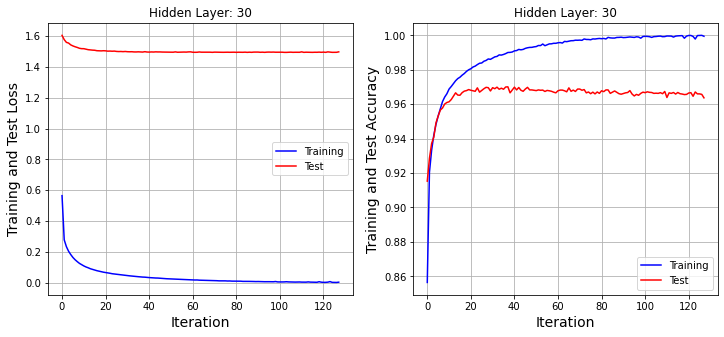

In [47]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss4, 'b', label = "Training")
ax[0].plot(range(128), test_loss4, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 30')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc4, 'b', label = "Training")
ax[1].plot(range(128), test_acc4, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 30')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 30.png")

In [48]:
model = BaselineModel(784,50,10)

train_loss4 = np.zeros(128)
test_loss4 = np.zeros(128)
train_acc4 = np.zeros(128)
test_acc4 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.31228601932525635, 'running_acc': 0.9084374904632568, 'loss': 0.5244327783584595, 'acc': 0.8672166466712952, 'val_loss': 1.5956038236618042, 'val_acc': 0.9210000038146973}
Epoch: 1
Training Loss: 0.5244327783584595
Training Accuracy: 0.8672166466712952
Test Loss: 1.5956038236618042
Test Accuracy: 0.9210000038146973


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.23011912405490875, 'running_acc': 0.9334374666213989, 'loss': 0.2553494870662689, 'acc': 0.9280499815940857, 'val_loss': 1.5650184154510498, 'val_acc': 0.9387999773025513}
Epoch: 2
Training Loss: 0.2553494870662689
Training Accuracy: 0.9280499815940857
Test Loss: 1.5650184154510498
Test Accuracy: 0.9387999773025513


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.19923175871372223, 'running_acc': 0.9484374523162842, 'loss': 0.20017726719379425, 'acc': 0.9433000087738037, 'val_loss': 1.5470786094665527, 'val_acc': 0.9484999775886536}
Epoch: 3
Training Loss: 0.20017726719379425
Training Accuracy: 0.9433000087738037
Test Loss: 1.5470786094665527
Test Accuracy: 0.9484999775886536


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1412363201379776, 'running_acc': 0.95703125, 'loss': 0.1674695760011673, 'acc': 0.9532833695411682, 'val_loss': 1.5351611375808716, 'val_acc': 0.9528999924659729}
Epoch: 4
Training Loss: 0.1674695760011673
Training Accuracy: 0.9532833695411682
Test Loss: 1.5351611375808716
Test Accuracy: 0.9528999924659729


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.14223633706569672, 'running_acc': 0.9564062356948853, 'loss': 0.14487972855567932, 'acc': 0.9589833617210388, 'val_loss': 1.5299190282821655, 'val_acc': 0.9587999582290649}
Epoch: 5
Training Loss: 0.14487972855567932
Training Accuracy: 0.9589833617210388
Test Loss: 1.5299190282821655
Test Accuracy: 0.9587999582290649


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.12168671190738678, 'running_acc': 0.9651562571525574, 'loss': 0.12641121447086334, 'acc': 0.9638833403587341, 'val_loss': 1.520938754081726, 'val_acc': 0.9611999988555908}
Epoch: 6
Training Loss: 0.12641121447086334
Training Accuracy: 0.9638833403587341
Test Loss: 1.520938754081726
Test Accuracy: 0.9611999988555908


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09896857291460037, 'running_acc': 0.9729687571525574, 'loss': 0.11254416406154633, 'acc': 0.9678666591644287, 'val_loss': 1.5168169736862183, 'val_acc': 0.9645999670028687}
Epoch: 7
Training Loss: 0.11254416406154633
Training Accuracy: 0.9678666591644287
Test Loss: 1.5168169736862183
Test Accuracy: 0.9645999670028687


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10530737787485123, 'running_acc': 0.9685937166213989, 'loss': 0.10119149833917618, 'acc': 0.970633327960968, 'val_loss': 1.5130575895309448, 'val_acc': 0.9664999842643738}
Epoch: 8
Training Loss: 0.10119149833917618
Training Accuracy: 0.970633327960968
Test Loss: 1.5130575895309448
Test Accuracy: 0.9664999842643738


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08584487438201904, 'running_acc': 0.9748437404632568, 'loss': 0.09226975589990616, 'acc': 0.973383367061615, 'val_loss': 1.5096547603607178, 'val_acc': 0.9685999751091003}
Epoch: 9
Training Loss: 0.09226975589990616
Training Accuracy: 0.973383367061615
Test Loss: 1.5096547603607178
Test Accuracy: 0.9685999751091003


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08698637038469315, 'running_acc': 0.9735937118530273, 'loss': 0.08381910622119904, 'acc': 0.9754500389099121, 'val_loss': 1.5082169771194458, 'val_acc': 0.9690999984741211}
Epoch: 10
Training Loss: 0.08381910622119904
Training Accuracy: 0.9754500389099121
Test Loss: 1.5082169771194458
Test Accuracy: 0.9690999984741211


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.07781823724508286, 'running_acc': 0.9765625, 'loss': 0.07810250669717789, 'acc': 0.9772000312805176, 'val_loss': 1.5053797960281372, 'val_acc': 0.9706999659538269}
Epoch: 11
Training Loss: 0.07810250669717789
Training Accuracy: 0.9772000312805176
Test Loss: 1.5053797960281372
Test Accuracy: 0.9706999659538269


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06842499226331711, 'running_acc': 0.9799999594688416, 'loss': 0.0717632994055748, 'acc': 0.9786999821662903, 'val_loss': 1.5036355257034302, 'val_acc': 0.9709999561309814}
Epoch: 12
Training Loss: 0.0717632994055748
Training Accuracy: 0.9786999821662903
Test Loss: 1.5036355257034302
Test Accuracy: 0.9709999561309814


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06491342186927795, 'running_acc': 0.9817187190055847, 'loss': 0.06730537861585617, 'acc': 0.9801833629608154, 'val_loss': 1.5035537481307983, 'val_acc': 0.9695999622344971}
Epoch: 13
Training Loss: 0.06730537861585617
Training Accuracy: 0.9801833629608154
Test Loss: 1.5035537481307983
Test Accuracy: 0.9695999622344971


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0645163506269455, 'running_acc': 0.9806249737739563, 'loss': 0.061869051307439804, 'acc': 0.9815833568572998, 'val_loss': 1.5008658170700073, 'val_acc': 0.9714999794960022}
Epoch: 14
Training Loss: 0.061869051307439804
Training Accuracy: 0.9815833568572998
Test Loss: 1.5008658170700073
Test Accuracy: 0.9714999794960022


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06450335681438446, 'running_acc': 0.9806249737739563, 'loss': 0.0586928091943264, 'acc': 0.982616662979126, 'val_loss': 1.5017520189285278, 'val_acc': 0.9695000052452087}
Epoch: 15
Training Loss: 0.0586928091943264
Training Accuracy: 0.982616662979126
Test Loss: 1.5017520189285278
Test Accuracy: 0.9695000052452087


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06406532973051071, 'running_acc': 0.9806249737739563, 'loss': 0.05503217503428459, 'acc': 0.9835166931152344, 'val_loss': 1.5002349615097046, 'val_acc': 0.9715999960899353}
Epoch: 16
Training Loss: 0.05503217503428459
Training Accuracy: 0.9835166931152344
Test Loss: 1.5002349615097046
Test Accuracy: 0.9715999960899353


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.05610165372490883, 'running_acc': 0.9848437309265137, 'loss': 0.05191206559538841, 'acc': 0.9846000075340271, 'val_loss': 1.4990971088409424, 'val_acc': 0.9711999893188477}
Epoch: 17
Training Loss: 0.05191206559538841
Training Accuracy: 0.9846000075340271
Test Loss: 1.4990971088409424
Test Accuracy: 0.9711999893188477


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.05166928097605705, 'running_acc': 0.9837499856948853, 'loss': 0.048493918031454086, 'acc': 0.9861167073249817, 'val_loss': 1.4986106157302856, 'val_acc': 0.9705999493598938}
Epoch: 18
Training Loss: 0.048493918031454086
Training Accuracy: 0.9861167073249817
Test Loss: 1.4986106157302856
Test Accuracy: 0.9705999493598938


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04387441650032997, 'running_acc': 0.9868749976158142, 'loss': 0.04529605060815811, 'acc': 0.9868500232696533, 'val_loss': 1.4994893074035645, 'val_acc': 0.9714999794960022}
Epoch: 19
Training Loss: 0.04529605060815811
Training Accuracy: 0.9868500232696533
Test Loss: 1.4994893074035645
Test Accuracy: 0.9714999794960022


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04073468968272209, 'running_acc': 0.9892187118530273, 'loss': 0.04285035282373428, 'acc': 0.9873166680335999, 'val_loss': 1.4957919120788574, 'val_acc': 0.9728999733924866}
Epoch: 20
Training Loss: 0.04285035282373428
Training Accuracy: 0.9873166680335999
Test Loss: 1.4957919120788574
Test Accuracy: 0.9728999733924866


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04048514366149902, 'running_acc': 0.9876562356948853, 'loss': 0.040615350008010864, 'acc': 0.9882166981697083, 'val_loss': 1.4967937469482422, 'val_acc': 0.9720999598503113}
Epoch: 21
Training Loss: 0.040615350008010864
Training Accuracy: 0.9882166981697083
Test Loss: 1.4967937469482422
Test Accuracy: 0.9720999598503113


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03869166597723961, 'running_acc': 0.9904687404632568, 'loss': 0.03776422515511513, 'acc': 0.9890833497047424, 'val_loss': 1.4950122833251953, 'val_acc': 0.9726999998092651}
Epoch: 22
Training Loss: 0.03776422515511513
Training Accuracy: 0.9890833497047424
Test Loss: 1.4950122833251953
Test Accuracy: 0.9726999998092651


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03834466263651848, 'running_acc': 0.9893749952316284, 'loss': 0.035338662564754486, 'acc': 0.9898000359535217, 'val_loss': 1.498034954071045, 'val_acc': 0.9705999493598938}
Epoch: 23
Training Loss: 0.035338662564754486
Training Accuracy: 0.9898000359535217
Test Loss: 1.498034954071045
Test Accuracy: 0.9705999493598938


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03116963803768158, 'running_acc': 0.9907812476158142, 'loss': 0.034248121082782745, 'acc': 0.9901666641235352, 'val_loss': 1.4961832761764526, 'val_acc': 0.9711999893188477}
Epoch: 24
Training Loss: 0.034248121082782745
Training Accuracy: 0.9901666641235352
Test Loss: 1.4961832761764526
Test Accuracy: 0.9711999893188477


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03240911290049553, 'running_acc': 0.9901562333106995, 'loss': 0.03235072270035744, 'acc': 0.9911666512489319, 'val_loss': 1.4967694282531738, 'val_acc': 0.9717999696731567}
Epoch: 25
Training Loss: 0.03235072270035744
Training Accuracy: 0.9911666512489319
Test Loss: 1.4967694282531738
Test Accuracy: 0.9717999696731567


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03138956427574158, 'running_acc': 0.9915624856948853, 'loss': 0.030196042731404305, 'acc': 0.9918500185012817, 'val_loss': 1.4944872856140137, 'val_acc': 0.9731999635696411}
Epoch: 26
Training Loss: 0.030196042731404305
Training Accuracy: 0.9918500185012817
Test Loss: 1.4944872856140137
Test Accuracy: 0.9731999635696411


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.029410114511847496, 'running_acc': 0.9921875, 'loss': 0.02873430773615837, 'acc': 0.9919999837875366, 'val_loss': 1.4956203699111938, 'val_acc': 0.972000002861023}
Epoch: 27
Training Loss: 0.02873430773615837
Training Accuracy: 0.9919999837875366
Test Loss: 1.4956203699111938
Test Accuracy: 0.972000002861023


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.025560200214385986, 'running_acc': 0.9926562309265137, 'loss': 0.02642751857638359, 'acc': 0.9930000305175781, 'val_loss': 1.495224952697754, 'val_acc': 0.9716999530792236}
Epoch: 28
Training Loss: 0.02642751857638359
Training Accuracy: 0.9930000305175781
Test Loss: 1.495224952697754
Test Accuracy: 0.9716999530792236


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.029923979192972183, 'running_acc': 0.9915624856948853, 'loss': 0.025294816121459007, 'acc': 0.9931333661079407, 'val_loss': 1.4949206113815308, 'val_acc': 0.9706999659538269}
Epoch: 29
Training Loss: 0.025294816121459007
Training Accuracy: 0.9931333661079407
Test Loss: 1.4949206113815308
Test Accuracy: 0.9706999659538269


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0294028390198946, 'running_acc': 0.9907812476158142, 'loss': 0.02380920946598053, 'acc': 0.9935666918754578, 'val_loss': 1.4949312210083008, 'val_acc': 0.9711999893188477}
Epoch: 30
Training Loss: 0.02380920946598053
Training Accuracy: 0.9935666918754578
Test Loss: 1.4949312210083008
Test Accuracy: 0.9711999893188477


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02940008044242859, 'running_acc': 0.9912499785423279, 'loss': 0.02275785803794861, 'acc': 0.9940833449363708, 'val_loss': 1.495021104812622, 'val_acc': 0.971299946308136}
Epoch: 31
Training Loss: 0.02275785803794861
Training Accuracy: 0.9940833449363708
Test Loss: 1.495021104812622
Test Accuracy: 0.971299946308136


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02376517653465271, 'running_acc': 0.9940624833106995, 'loss': 0.02108575589954853, 'acc': 0.994533360004425, 'val_loss': 1.495301365852356, 'val_acc': 0.9717999696731567}
Epoch: 32
Training Loss: 0.02108575589954853
Training Accuracy: 0.994533360004425
Test Loss: 1.495301365852356
Test Accuracy: 0.9717999696731567


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02156355418264866, 'running_acc': 0.9932812452316284, 'loss': 0.02030445821583271, 'acc': 0.9947500228881836, 'val_loss': 1.4942702054977417, 'val_acc': 0.9723999500274658}
Epoch: 33
Training Loss: 0.02030445821583271
Training Accuracy: 0.9947500228881836
Test Loss: 1.4942702054977417
Test Accuracy: 0.9723999500274658


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.020607180893421173, 'running_acc': 0.9945312142372131, 'loss': 0.01934921368956566, 'acc': 0.9952166676521301, 'val_loss': 1.4932056665420532, 'val_acc': 0.9724999666213989}
Epoch: 34
Training Loss: 0.01934921368956566
Training Accuracy: 0.9952166676521301
Test Loss: 1.4932056665420532
Test Accuracy: 0.9724999666213989


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.016847645863890648, 'running_acc': 0.9965624809265137, 'loss': 0.018239609897136688, 'acc': 0.9955666661262512, 'val_loss': 1.4931650161743164, 'val_acc': 0.9722999930381775}
Epoch: 35
Training Loss: 0.018239609897136688
Training Accuracy: 0.9955666661262512
Test Loss: 1.4931650161743164
Test Accuracy: 0.9722999930381775


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.019354337826371193, 'running_acc': 0.9948437213897705, 'loss': 0.016696065664291382, 'acc': 0.99631667137146, 'val_loss': 1.4962799549102783, 'val_acc': 0.9708999991416931}
Epoch: 36
Training Loss: 0.016696065664291382
Training Accuracy: 0.99631667137146
Test Loss: 1.4962799549102783
Test Accuracy: 0.9708999991416931


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.019505897536873817, 'running_acc': 0.9954687356948853, 'loss': 0.016190778464078903, 'acc': 0.9962833523750305, 'val_loss': 1.4938913583755493, 'val_acc': 0.971299946308136}
Epoch: 37
Training Loss: 0.016190778464078903
Training Accuracy: 0.9962833523750305
Test Loss: 1.4938913583755493
Test Accuracy: 0.971299946308136


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01825505681335926, 'running_acc': 0.9939061999320984, 'loss': 0.015624922700226307, 'acc': 0.9961833357810974, 'val_loss': 1.494708776473999, 'val_acc': 0.9708999991416931}
Epoch: 38
Training Loss: 0.015624922700226307
Training Accuracy: 0.9961833357810974
Test Loss: 1.494708776473999
Test Accuracy: 0.9708999991416931


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.015916040167212486, 'running_acc': 0.996874988079071, 'loss': 0.014111340045928955, 'acc': 0.9969333410263062, 'val_loss': 1.492681622505188, 'val_acc': 0.9708999991416931}
Epoch: 39
Training Loss: 0.014111340045928955
Training Accuracy: 0.9969333410263062
Test Loss: 1.492681622505188
Test Accuracy: 0.9708999991416931


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.014759707264602184, 'running_acc': 0.996874988079071, 'loss': 0.012873671017587185, 'acc': 0.9975000023841858, 'val_loss': 1.4930026531219482, 'val_acc': 0.971299946308136}
Epoch: 40
Training Loss: 0.012873671017587185
Training Accuracy: 0.9975000023841858
Test Loss: 1.4930026531219482
Test Accuracy: 0.971299946308136


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.015702834352850914, 'running_acc': 0.9956249594688416, 'loss': 0.012532275170087814, 'acc': 0.9973000288009644, 'val_loss': 1.493274450302124, 'val_acc': 0.9711999893188477}
Epoch: 41
Training Loss: 0.012532275170087814
Training Accuracy: 0.9973000288009644
Test Loss: 1.493274450302124
Test Accuracy: 0.9711999893188477


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011471250094473362, 'running_acc': 0.9982812404632568, 'loss': 0.01214009989053011, 'acc': 0.9973833560943604, 'val_loss': 1.4937485456466675, 'val_acc': 0.9705999493598938}
Epoch: 42
Training Loss: 0.01214009989053011
Training Accuracy: 0.9973833560943604
Test Loss: 1.4937485456466675
Test Accuracy: 0.9705999493598938


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011811831034719944, 'running_acc': 0.9971874952316284, 'loss': 0.011068742722272873, 'acc': 0.9980166554450989, 'val_loss': 1.4926836490631104, 'val_acc': 0.9710999727249146}
Epoch: 43
Training Loss: 0.011068742722272873
Training Accuracy: 0.9980166554450989
Test Loss: 1.4926836490631104
Test Accuracy: 0.9710999727249146


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012781522236764431, 'running_acc': 0.9970312118530273, 'loss': 0.010866166092455387, 'acc': 0.9976833462715149, 'val_loss': 1.4939994812011719, 'val_acc': 0.9710999727249146}
Epoch: 44
Training Loss: 0.010866166092455387
Training Accuracy: 0.9976833462715149
Test Loss: 1.4939994812011719
Test Accuracy: 0.9710999727249146


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.014184045605361462, 'running_acc': 0.99671870470047, 'loss': 0.010536890476942062, 'acc': 0.9979333281517029, 'val_loss': 1.4939173460006714, 'val_acc': 0.9700999855995178}
Epoch: 45
Training Loss: 0.010536890476942062
Training Accuracy: 0.9979333281517029
Test Loss: 1.4939173460006714
Test Accuracy: 0.9700999855995178


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01131594367325306, 'running_acc': 0.9965624809265137, 'loss': 0.009854812175035477, 'acc': 0.9978166818618774, 'val_loss': 1.493392825126648, 'val_acc': 0.9702999591827393}
Epoch: 46
Training Loss: 0.009854812175035477
Training Accuracy: 0.9978166818618774
Test Loss: 1.493392825126648
Test Accuracy: 0.9702999591827393


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011060281656682491, 'running_acc': 0.996874988079071, 'loss': 0.008814678527414799, 'acc': 0.9983167052268982, 'val_loss': 1.492674708366394, 'val_acc': 0.9705999493598938}
Epoch: 47
Training Loss: 0.008814678527414799
Training Accuracy: 0.9983167052268982
Test Loss: 1.492674708366394
Test Accuracy: 0.9705999493598938


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008694592863321304, 'running_acc': 0.9987499713897705, 'loss': 0.008381408639252186, 'acc': 0.9987000226974487, 'val_loss': 1.4927109479904175, 'val_acc': 0.9699999690055847}
Epoch: 48
Training Loss: 0.008381408639252186
Training Accuracy: 0.9987000226974487
Test Loss: 1.4927109479904175
Test Accuracy: 0.9699999690055847


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009853808209300041, 'running_acc': 0.9978124499320984, 'loss': 0.0074469042010605335, 'acc': 0.9988999962806702, 'val_loss': 1.4924559593200684, 'val_acc': 0.9706999659538269}
Epoch: 49
Training Loss: 0.0074469042010605335
Training Accuracy: 0.9988999962806702
Test Loss: 1.4924559593200684
Test Accuracy: 0.9706999659538269


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01053603645414114, 'running_acc': 0.9976562261581421, 'loss': 0.008162586018443108, 'acc': 0.9986333250999451, 'val_loss': 1.49323570728302, 'val_acc': 0.9706999659538269}
Epoch: 50
Training Loss: 0.008162586018443108
Training Accuracy: 0.9986333250999451
Test Loss: 1.49323570728302
Test Accuracy: 0.9706999659538269


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008248226717114449, 'running_acc': 0.9989062547683716, 'loss': 0.00853187870234251, 'acc': 0.9981499910354614, 'val_loss': 1.4922128915786743, 'val_acc': 0.9706999659538269}
Epoch: 51
Training Loss: 0.00853187870234251
Training Accuracy: 0.9981499910354614
Test Loss: 1.4922128915786743
Test Accuracy: 0.9706999659538269


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006560137029737234, 'running_acc': 0.9993749856948853, 'loss': 0.0061692604795098305, 'acc': 0.9992499947547913, 'val_loss': 1.4920642375946045, 'val_acc': 0.97079998254776}
Epoch: 52
Training Loss: 0.0061692604795098305
Training Accuracy: 0.9992499947547913
Test Loss: 1.4920642375946045
Test Accuracy: 0.97079998254776


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007104269694536924, 'running_acc': 0.9987499713897705, 'loss': 0.006141006946563721, 'acc': 0.9990500211715698, 'val_loss': 1.492180347442627, 'val_acc': 0.9709999561309814}
Epoch: 53
Training Loss: 0.006141006946563721
Training Accuracy: 0.9990500211715698
Test Loss: 1.492180347442627
Test Accuracy: 0.9709999561309814


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008535382337868214, 'running_acc': 0.9984374642372131, 'loss': 0.006206579506397247, 'acc': 0.9990333318710327, 'val_loss': 1.4934567213058472, 'val_acc': 0.9698999524116516}
Epoch: 54
Training Loss: 0.006206579506397247
Training Accuracy: 0.9990333318710327
Test Loss: 1.4934567213058472
Test Accuracy: 0.9698999524116516


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009058387950062752, 'running_acc': 0.9978124499320984, 'loss': 0.006634972989559174, 'acc': 0.9988166689872742, 'val_loss': 1.4932758808135986, 'val_acc': 0.9706999659538269}
Epoch: 55
Training Loss: 0.006634972989559174
Training Accuracy: 0.9988166689872742
Test Loss: 1.4932758808135986
Test Accuracy: 0.9706999659538269


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00735280429944396, 'running_acc': 0.9990624785423279, 'loss': 0.006326630711555481, 'acc': 0.9989333152770996, 'val_loss': 1.4923787117004395, 'val_acc': 0.97079998254776}
Epoch: 56
Training Loss: 0.006326630711555481
Training Accuracy: 0.9989333152770996
Test Loss: 1.4923787117004395
Test Accuracy: 0.97079998254776


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006146786734461784, 'running_acc': 0.9989062547683716, 'loss': 0.004474296234548092, 'acc': 0.9995666742324829, 'val_loss': 1.4923619031906128, 'val_acc': 0.9713999629020691}
Epoch: 57
Training Loss: 0.004474296234548092
Training Accuracy: 0.9995666742324829
Test Loss: 1.4923619031906128
Test Accuracy: 0.9713999629020691


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005388172809034586, 'running_acc': 0.9993749856948853, 'loss': 0.004552813712507486, 'acc': 0.9995166659355164, 'val_loss': 1.4920998811721802, 'val_acc': 0.9705999493598938}
Epoch: 58
Training Loss: 0.004552813712507486
Training Accuracy: 0.9995166659355164
Test Loss: 1.4920998811721802
Test Accuracy: 0.9705999493598938


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007211422082036734, 'running_acc': 0.9982812404632568, 'loss': 0.0047953007742762566, 'acc': 0.9992333650588989, 'val_loss': 1.491895079612732, 'val_acc': 0.9706999659538269}
Epoch: 59
Training Loss: 0.0047953007742762566
Training Accuracy: 0.9992333650588989
Test Loss: 1.491895079612732
Test Accuracy: 0.9706999659538269


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006985355634242296, 'running_acc': 0.9984374642372131, 'loss': 0.004547471180558205, 'acc': 0.9993833303451538, 'val_loss': 1.4919183254241943, 'val_acc': 0.9698999524116516}
Epoch: 60
Training Loss: 0.004547471180558205
Training Accuracy: 0.9993833303451538
Test Loss: 1.4919183254241943
Test Accuracy: 0.9698999524116516


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0037083872593939304, 'running_acc': 0.9998437166213989, 'loss': 0.0036736854817718267, 'acc': 0.9996833205223083, 'val_loss': 1.4925520420074463, 'val_acc': 0.97079998254776}
Epoch: 61
Training Loss: 0.0036736854817718267
Training Accuracy: 0.9996833205223083
Test Loss: 1.4925520420074463
Test Accuracy: 0.97079998254776


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003922107629477978, 'running_acc': 0.9995312094688416, 'loss': 0.004877976141870022, 'acc': 0.9991000294685364, 'val_loss': 1.494023084640503, 'val_acc': 0.9696999788284302}
Epoch: 62
Training Loss: 0.004877976141870022
Training Accuracy: 0.9991000294685364
Test Loss: 1.494023084640503
Test Accuracy: 0.9696999788284302


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004819856956601143, 'running_acc': 0.9992187023162842, 'loss': 0.004420583602041006, 'acc': 0.9993333220481873, 'val_loss': 1.493215560913086, 'val_acc': 0.9695999622344971}
Epoch: 63
Training Loss: 0.004420583602041006
Training Accuracy: 0.9993333220481873
Test Loss: 1.493215560913086
Test Accuracy: 0.9695999622344971


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002835015533491969, 'running_acc': 1.0, 'loss': 0.0030930107459425926, 'acc': 0.9998000264167786, 'val_loss': 1.4913253784179688, 'val_acc': 0.9708999991416931}
Epoch: 64
Training Loss: 0.0030930107459425926
Training Accuracy: 0.9998000264167786
Test Loss: 1.4913253784179688
Test Accuracy: 0.9708999991416931


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008903959766030312, 'running_acc': 0.99671870470047, 'loss': 0.005138478707522154, 'acc': 0.9986166954040527, 'val_loss': 1.4932467937469482, 'val_acc': 0.9697999954223633}
Epoch: 65
Training Loss: 0.005138478707522154
Training Accuracy: 0.9986166954040527
Test Loss: 1.4932467937469482
Test Accuracy: 0.9697999954223633


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004197276663035154, 'running_acc': 0.9996874928474426, 'loss': 0.00423982460051775, 'acc': 0.9992833733558655, 'val_loss': 1.4921146631240845, 'val_acc': 0.9699999690055847}
Epoch: 66
Training Loss: 0.00423982460051775
Training Accuracy: 0.9992833733558655
Test Loss: 1.4921146631240845
Test Accuracy: 0.9699999690055847


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004342404194176197, 'running_acc': 0.9995312094688416, 'loss': 0.0024822335690259933, 'acc': 0.9998500347137451, 'val_loss': 1.492174506187439, 'val_acc': 0.9700999855995178}
Epoch: 67
Training Loss: 0.0024822335690259933
Training Accuracy: 0.9998500347137451
Test Loss: 1.492174506187439
Test Accuracy: 0.9700999855995178


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0018472321098670363, 'running_acc': 1.0, 'loss': 0.0020908177830278873, 'acc': 0.9998999834060669, 'val_loss': 1.4911516904830933, 'val_acc': 0.971299946308136}
Epoch: 68
Training Loss: 0.0020908177830278873
Training Accuracy: 0.9998999834060669
Test Loss: 1.4911516904830933
Test Accuracy: 0.971299946308136


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010541738010942936, 'running_acc': 0.9959374666213989, 'loss': 0.0050832051783800125, 'acc': 0.9987166523933411, 'val_loss': 1.4928182363510132, 'val_acc': 0.9695000052452087}
Epoch: 69
Training Loss: 0.0050832051783800125
Training Accuracy: 0.9987166523933411
Test Loss: 1.4928182363510132
Test Accuracy: 0.9695000052452087


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003566683968529105, 'running_acc': 0.9992187023162842, 'loss': 0.0037584134843200445, 'acc': 0.9992833733558655, 'val_loss': 1.4920531511306763, 'val_acc': 0.9702999591827393}
Epoch: 70
Training Loss: 0.0037584134843200445
Training Accuracy: 0.9992833733558655
Test Loss: 1.4920531511306763
Test Accuracy: 0.9702999591827393


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0019702804274857044, 'running_acc': 0.9998437166213989, 'loss': 0.0016959280474111438, 'acc': 0.9999499917030334, 'val_loss': 1.4915962219238281, 'val_acc': 0.9709999561309814}
Epoch: 71
Training Loss: 0.0016959280474111438
Training Accuracy: 0.9999499917030334
Test Loss: 1.4915962219238281
Test Accuracy: 0.9709999561309814


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0016974946483969688, 'running_acc': 1.0, 'loss': 0.0015802859561517835, 'acc': 0.9999666810035706, 'val_loss': 1.491441011428833, 'val_acc': 0.9708999991416931}
Epoch: 72
Training Loss: 0.0015802859561517835
Training Accuracy: 0.9999666810035706
Test Loss: 1.491441011428833
Test Accuracy: 0.9708999991416931


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003486152272671461, 'running_acc': 0.9992187023162842, 'loss': 0.002788516227155924, 'acc': 0.9995166659355164, 'val_loss': 1.4923821687698364, 'val_acc': 0.9702000021934509}
Epoch: 73
Training Loss: 0.002788516227155924
Training Accuracy: 0.9995166659355164
Test Loss: 1.4923821687698364
Test Accuracy: 0.9702000021934509


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012275894172489643, 'running_acc': 0.9970312118530273, 'loss': 0.0038406059611588717, 'acc': 0.9993333220481873, 'val_loss': 1.4943208694458008, 'val_acc': 0.9679999947547913}
Epoch: 74
Training Loss: 0.0038406059611588717
Training Accuracy: 0.9993333220481873
Test Loss: 1.4943208694458008
Test Accuracy: 0.9679999947547913


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0020283646881580353, 'running_acc': 1.0, 'loss': 0.003161345375701785, 'acc': 0.9994666576385498, 'val_loss': 1.4917494058609009, 'val_acc': 0.9714999794960022}
Epoch: 75
Training Loss: 0.003161345375701785
Training Accuracy: 0.9994666576385498
Test Loss: 1.4917494058609009
Test Accuracy: 0.9714999794960022


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0010787766659632325, 'running_acc': 1.0, 'loss': 0.0013887992827221751, 'acc': 0.9999666810035706, 'val_loss': 1.4917479753494263, 'val_acc': 0.9711999893188477}
Epoch: 76
Training Loss: 0.0013887992827221751
Training Accuracy: 0.9999666810035706
Test Loss: 1.4917479753494263
Test Accuracy: 0.9711999893188477


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0028235202189534903, 'running_acc': 0.9996874928474426, 'loss': 0.0014430196024477482, 'acc': 0.9999333620071411, 'val_loss': 1.4929879903793335, 'val_acc': 0.9700999855995178}
Epoch: 77
Training Loss: 0.0014430196024477482
Training Accuracy: 0.9999333620071411
Test Loss: 1.4929879903793335
Test Accuracy: 0.9700999855995178


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0026924998965114355, 'running_acc': 0.9996874928474426, 'loss': 0.0058042448945343494, 'acc': 0.9983500242233276, 'val_loss': 1.4915140867233276, 'val_acc': 0.9702000021934509}
Epoch: 78
Training Loss: 0.0058042448945343494
Training Accuracy: 0.9983500242233276
Test Loss: 1.4915140867233276
Test Accuracy: 0.9702000021934509


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0014098183019086719, 'running_acc': 0.9998437166213989, 'loss': 0.0014458062360063195, 'acc': 0.9999333620071411, 'val_loss': 1.4915248155593872, 'val_acc': 0.9702999591827393}
Epoch: 79
Training Loss: 0.0014458062360063195
Training Accuracy: 0.9999333620071411
Test Loss: 1.4915248155593872
Test Accuracy: 0.9702999591827393


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001157144084572792, 'running_acc': 1.0, 'loss': 0.0010140789672732353, 'acc': 1.0, 'val_loss': 1.4913133382797241, 'val_acc': 0.9703999757766724}
Epoch: 80
Training Loss: 0.0010140789672732353
Training Accuracy: 1.0
Test Loss: 1.4913133382797241
Test Accuracy: 0.9703999757766724


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0010014241561293602, 'running_acc': 1.0, 'loss': 0.0010026288218796253, 'acc': 0.9999666810035706, 'val_loss': 1.4914909601211548, 'val_acc': 0.97079998254776}
Epoch: 81
Training Loss: 0.0010026288218796253
Training Accuracy: 0.9999666810035706
Test Loss: 1.4914909601211548
Test Accuracy: 0.97079998254776


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0014670626260340214, 'running_acc': 1.0, 'loss': 0.0009606168605387211, 'acc': 1.0, 'val_loss': 1.4918400049209595, 'val_acc': 0.9693999886512756}
Epoch: 82
Training Loss: 0.0009606168605387211
Training Accuracy: 1.0
Test Loss: 1.4918400049209595
Test Accuracy: 0.9693999886512756


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.003667977871373296, 'running_acc': 0.9992187023162842, 'loss': 0.001616011024452746, 'acc': 0.9998666644096375, 'val_loss': 1.4932032823562622, 'val_acc': 0.9680999517440796}
Epoch: 83
Training Loss: 0.001616011024452746
Training Accuracy: 0.9998666644096375
Test Loss: 1.4932032823562622
Test Accuracy: 0.9680999517440796


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0018331196624785662, 'running_acc': 1.0, 'loss': 0.008238225243985653, 'acc': 0.9976500272750854, 'val_loss': 1.4905608892440796, 'val_acc': 0.9711999893188477}
Epoch: 84
Training Loss: 0.008238225243985653
Training Accuracy: 0.9976500272750854
Test Loss: 1.4905608892440796
Test Accuracy: 0.9711999893188477


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0010207918239757419, 'running_acc': 1.0, 'loss': 0.0010935816681012511, 'acc': 0.9999833703041077, 'val_loss': 1.4904403686523438, 'val_acc': 0.9716999530792236}
Epoch: 85
Training Loss: 0.0010935816681012511
Training Accuracy: 0.9999833703041077
Test Loss: 1.4904403686523438
Test Accuracy: 0.9716999530792236


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0007629141910001636, 'running_acc': 1.0, 'loss': 0.0008042322588153183, 'acc': 1.0, 'val_loss': 1.4903839826583862, 'val_acc': 0.9708999991416931}
Epoch: 86
Training Loss: 0.0008042322588153183
Training Accuracy: 1.0
Test Loss: 1.4903839826583862
Test Accuracy: 0.9708999991416931


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0007026856765151024, 'running_acc': 1.0, 'loss': 0.0007504472741857171, 'acc': 1.0, 'val_loss': 1.4903883934020996, 'val_acc': 0.9714999794960022}
Epoch: 87
Training Loss: 0.0007504472741857171
Training Accuracy: 1.0
Test Loss: 1.4903883934020996
Test Accuracy: 0.9714999794960022


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0007447528187185526, 'running_acc': 1.0, 'loss': 0.0006524715572595596, 'acc': 1.0, 'val_loss': 1.4906902313232422, 'val_acc': 0.9708999991416931}
Epoch: 88
Training Loss: 0.0006524715572595596
Training Accuracy: 1.0
Test Loss: 1.4906902313232422
Test Accuracy: 0.9708999991416931


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0007029288681223989, 'running_acc': 1.0, 'loss': 0.0006985446671023965, 'acc': 1.0, 'val_loss': 1.4901400804519653, 'val_acc': 0.9718999862670898}
Epoch: 89
Training Loss: 0.0006985446671023965
Training Accuracy: 1.0
Test Loss: 1.4901400804519653
Test Accuracy: 0.9718999862670898


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0044203647412359715, 'running_acc': 0.9987499713897705, 'loss': 0.008876700885593891, 'acc': 0.9973999857902527, 'val_loss': 1.4918584823608398, 'val_acc': 0.9695999622344971}
Epoch: 90
Training Loss: 0.008876700885593891
Training Accuracy: 0.9973999857902527
Test Loss: 1.4918584823608398
Test Accuracy: 0.9695999622344971


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001188956550322473, 'running_acc': 1.0, 'loss': 0.0017373983282595873, 'acc': 0.9997833371162415, 'val_loss': 1.4906280040740967, 'val_acc': 0.9710999727249146}
Epoch: 91
Training Loss: 0.0017373983282595873
Training Accuracy: 0.9997833371162415
Test Loss: 1.4906280040740967
Test Accuracy: 0.9710999727249146


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0005929848994128406, 'running_acc': 1.0, 'loss': 0.0006834480445832014, 'acc': 1.0, 'val_loss': 1.491172432899475, 'val_acc': 0.97079998254776}
Epoch: 92
Training Loss: 0.0006834480445832014
Training Accuracy: 1.0
Test Loss: 1.491172432899475
Test Accuracy: 0.97079998254776


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0006004296010360122, 'running_acc': 1.0, 'loss': 0.0005673817358911037, 'acc': 1.0, 'val_loss': 1.4904733896255493, 'val_acc': 0.971299946308136}
Epoch: 93
Training Loss: 0.0005673817358911037
Training Accuracy: 1.0
Test Loss: 1.4904733896255493
Test Accuracy: 0.971299946308136


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0005625530029647052, 'running_acc': 1.0, 'loss': 0.0005197961581870914, 'acc': 1.0, 'val_loss': 1.4902245998382568, 'val_acc': 0.9713999629020691}
Epoch: 94
Training Loss: 0.0005197961581870914
Training Accuracy: 1.0
Test Loss: 1.4902245998382568
Test Accuracy: 0.9713999629020691


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0005290471017360687, 'running_acc': 1.0, 'loss': 0.0004895090241916478, 'acc': 1.0, 'val_loss': 1.4906690120697021, 'val_acc': 0.9706999659538269}
Epoch: 95
Training Loss: 0.0004895090241916478
Training Accuracy: 1.0
Test Loss: 1.4906690120697021
Test Accuracy: 0.9706999659538269


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0005915138171985745, 'running_acc': 1.0, 'loss': 0.0005036400980316103, 'acc': 1.0, 'val_loss': 1.4914112091064453, 'val_acc': 0.9695999622344971}
Epoch: 96
Training Loss: 0.0005036400980316103
Training Accuracy: 1.0
Test Loss: 1.4914112091064453
Test Accuracy: 0.9695999622344971


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0066730366088449955, 'running_acc': 0.9978124499320984, 'loss': 0.008086046203970909, 'acc': 0.9974833726882935, 'val_loss': 1.4919856786727905, 'val_acc': 0.9700999855995178}
Epoch: 97
Training Loss: 0.008086046203970909
Training Accuracy: 0.9974833726882935
Test Loss: 1.4919856786727905
Test Accuracy: 0.9700999855995178


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0022621117532253265, 'running_acc': 0.9993749856948853, 'loss': 0.002430913271382451, 'acc': 0.9995333552360535, 'val_loss': 1.491563320159912, 'val_acc': 0.9699999690055847}
Epoch: 98
Training Loss: 0.002430913271382451
Training Accuracy: 0.9995333552360535
Test Loss: 1.491563320159912
Test Accuracy: 0.9699999690055847


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0006512463442049921, 'running_acc': 1.0, 'loss': 0.00073741574306041, 'acc': 1.0, 'val_loss': 1.4908959865570068, 'val_acc': 0.9702999591827393}
Epoch: 99
Training Loss: 0.00073741574306041
Training Accuracy: 1.0
Test Loss: 1.4908959865570068
Test Accuracy: 0.9702999591827393


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0004502357041928917, 'running_acc': 1.0, 'loss': 0.0005111204227432609, 'acc': 1.0, 'val_loss': 1.4904918670654297, 'val_acc': 0.9705999493598938}
Epoch: 100
Training Loss: 0.0005111204227432609
Training Accuracy: 1.0
Test Loss: 1.4904918670654297
Test Accuracy: 0.9705999493598938


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0004655962693504989, 'running_acc': 1.0, 'loss': 0.00044881869689561427, 'acc': 1.0, 'val_loss': 1.4904489517211914, 'val_acc': 0.9703999757766724}
Epoch: 101
Training Loss: 0.00044881869689561427
Training Accuracy: 1.0
Test Loss: 1.4904489517211914
Test Accuracy: 0.9703999757766724


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00046974795986898243, 'running_acc': 1.0, 'loss': 0.0004158839292358607, 'acc': 1.0, 'val_loss': 1.490875244140625, 'val_acc': 0.9709999561309814}
Epoch: 102
Training Loss: 0.0004158839292358607
Training Accuracy: 1.0
Test Loss: 1.490875244140625
Test Accuracy: 0.9709999561309814


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0004448509425856173, 'running_acc': 1.0, 'loss': 0.00040232212631963193, 'acc': 1.0, 'val_loss': 1.4907619953155518, 'val_acc': 0.9700999855995178}
Epoch: 103
Training Loss: 0.00040232212631963193
Training Accuracy: 1.0
Test Loss: 1.4907619953155518
Test Accuracy: 0.9700999855995178


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0003891864325851202, 'running_acc': 1.0, 'loss': 0.00038432542351074517, 'acc': 1.0, 'val_loss': 1.4902440309524536, 'val_acc': 0.97079998254776}
Epoch: 104
Training Loss: 0.00038432542351074517
Training Accuracy: 1.0
Test Loss: 1.4902440309524536
Test Accuracy: 0.97079998254776


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006744852289557457, 'running_acc': 0.9981249570846558, 'loss': 0.0012572151608765125, 'acc': 0.9997333288192749, 'val_loss': 1.5015897750854492, 'val_acc': 0.9595999717712402}
Epoch: 105
Training Loss: 0.0012572151608765125
Training Accuracy: 0.9997333288192749
Test Loss: 1.5015897750854492
Test Accuracy: 0.9595999717712402


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002874993020668626, 'running_acc': 0.9987499713897705, 'loss': 0.009773431345820427, 'acc': 0.9965833425521851, 'val_loss': 1.49127197265625, 'val_acc': 0.9697999954223633}
Epoch: 106
Training Loss: 0.009773431345820427
Training Accuracy: 0.9965833425521851
Test Loss: 1.49127197265625
Test Accuracy: 0.9697999954223633


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0007723115850239992, 'running_acc': 1.0, 'loss': 0.0007722822483628988, 'acc': 0.9999833703041077, 'val_loss': 1.490736722946167, 'val_acc': 0.9714999794960022}
Epoch: 107
Training Loss: 0.0007722822483628988
Training Accuracy: 0.9999833703041077
Test Loss: 1.490736722946167
Test Accuracy: 0.9714999794960022


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00041297031566500664, 'running_acc': 1.0, 'loss': 0.00045278947800397873, 'acc': 1.0, 'val_loss': 1.4910085201263428, 'val_acc': 0.9714999794960022}
Epoch: 108
Training Loss: 0.00045278947800397873
Training Accuracy: 1.0
Test Loss: 1.4910085201263428
Test Accuracy: 0.9714999794960022


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0003860195283778012, 'running_acc': 1.0, 'loss': 0.000376120995497331, 'acc': 1.0, 'val_loss': 1.4904192686080933, 'val_acc': 0.9716999530792236}
Epoch: 109
Training Loss: 0.000376120995497331
Training Accuracy: 1.0
Test Loss: 1.4904192686080933
Test Accuracy: 0.9716999530792236


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0004064961685799062, 'running_acc': 1.0, 'loss': 0.00034493449493311346, 'acc': 1.0, 'val_loss': 1.4907348155975342, 'val_acc': 0.971299946308136}
Epoch: 110
Training Loss: 0.00034493449493311346
Training Accuracy: 1.0
Test Loss: 1.4907348155975342
Test Accuracy: 0.971299946308136


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0003324745630379766, 'running_acc': 1.0, 'loss': 0.0003183226508554071, 'acc': 1.0, 'val_loss': 1.4918326139450073, 'val_acc': 0.9702000021934509}
Epoch: 111
Training Loss: 0.0003183226508554071
Training Accuracy: 1.0
Test Loss: 1.4918326139450073
Test Accuracy: 0.9702000021934509


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0003120577021036297, 'running_acc': 1.0, 'loss': 0.0003288935113232583, 'acc': 1.0, 'val_loss': 1.4903618097305298, 'val_acc': 0.9704999923706055}
Epoch: 112
Training Loss: 0.0003288935113232583
Training Accuracy: 1.0
Test Loss: 1.4903618097305298
Test Accuracy: 0.9704999923706055


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00037267731386236846, 'running_acc': 1.0, 'loss': 0.0003138633619528264, 'acc': 1.0, 'val_loss': 1.4904191493988037, 'val_acc': 0.9710999727249146}
Epoch: 113
Training Loss: 0.0003138633619528264
Training Accuracy: 1.0
Test Loss: 1.4904191493988037
Test Accuracy: 0.9710999727249146


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008651289157569408, 'running_acc': 0.9962499737739563, 'loss': 0.007649839855730534, 'acc': 0.9976166486740112, 'val_loss': 1.4920181035995483, 'val_acc': 0.9695000052452087}
Epoch: 114
Training Loss: 0.007649839855730534
Training Accuracy: 0.9976166486740112
Test Loss: 1.4920181035995483
Test Accuracy: 0.9695000052452087


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002058367943391204, 'running_acc': 0.9990624785423279, 'loss': 0.0023640994913876057, 'acc': 0.9993000030517578, 'val_loss': 1.4912408590316772, 'val_acc': 0.9706999659538269}
Epoch: 115
Training Loss: 0.0023640994913876057
Training Accuracy: 0.9993000030517578
Test Loss: 1.4912408590316772
Test Accuracy: 0.9706999659538269


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0004655815428122878, 'running_acc': 1.0, 'loss': 0.0005205713678151369, 'acc': 1.0, 'val_loss': 1.490026831626892, 'val_acc': 0.9717999696731567}
Epoch: 116
Training Loss: 0.0005205713678151369
Training Accuracy: 1.0
Test Loss: 1.490026831626892
Test Accuracy: 0.9717999696731567


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00034422753378748894, 'running_acc': 1.0, 'loss': 0.0003297999792266637, 'acc': 1.0, 'val_loss': 1.4899108409881592, 'val_acc': 0.971299946308136}
Epoch: 117
Training Loss: 0.0003297999792266637
Training Accuracy: 1.0
Test Loss: 1.4899108409881592
Test Accuracy: 0.971299946308136


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00031173715251497924, 'running_acc': 1.0, 'loss': 0.00028981236391700804, 'acc': 1.0, 'val_loss': 1.4899239540100098, 'val_acc': 0.9717999696731567}
Epoch: 118
Training Loss: 0.00028981236391700804
Training Accuracy: 1.0
Test Loss: 1.4899239540100098
Test Accuracy: 0.9717999696731567


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0003047447244171053, 'running_acc': 1.0, 'loss': 0.00026590662309899926, 'acc': 1.0, 'val_loss': 1.4897822141647339, 'val_acc': 0.9717999696731567}
Epoch: 119
Training Loss: 0.00026590662309899926
Training Accuracy: 1.0
Test Loss: 1.4897822141647339
Test Accuracy: 0.9717999696731567


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00020634016254916787, 'running_acc': 1.0, 'loss': 0.00025023255147971213, 'acc': 1.0, 'val_loss': 1.490670919418335, 'val_acc': 0.9714999794960022}
Epoch: 120
Training Loss: 0.00025023255147971213
Training Accuracy: 1.0
Test Loss: 1.490670919418335
Test Accuracy: 0.9714999794960022


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00022046537196729332, 'running_acc': 1.0, 'loss': 0.00023667875211685896, 'acc': 1.0, 'val_loss': 1.4913229942321777, 'val_acc': 0.971299946308136}
Epoch: 121
Training Loss: 0.00023667875211685896
Training Accuracy: 1.0
Test Loss: 1.4913229942321777
Test Accuracy: 0.971299946308136


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002630868402775377, 'running_acc': 1.0, 'loss': 0.00023119484831113368, 'acc': 1.0, 'val_loss': 1.4903454780578613, 'val_acc': 0.9708999991416931}
Epoch: 122
Training Loss: 0.00023119484831113368
Training Accuracy: 1.0
Test Loss: 1.4903454780578613
Test Accuracy: 0.9708999991416931


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.016800295561552048, 'running_acc': 0.9931249618530273, 'loss': 0.00229995371773839, 'acc': 0.9991166591644287, 'val_loss': 1.498478651046753, 'val_acc': 0.9629999995231628}
Epoch: 123
Training Loss: 0.00229995371773839
Training Accuracy: 0.9991166591644287
Test Loss: 1.498478651046753
Test Accuracy: 0.9629999995231628


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0030066680628806353, 'running_acc': 0.9990624785423279, 'loss': 0.008197639137506485, 'acc': 0.9972833395004272, 'val_loss': 1.4925246238708496, 'val_acc': 0.9697999954223633}
Epoch: 124
Training Loss: 0.008197639137506485
Training Accuracy: 0.9972833395004272
Test Loss: 1.4925246238708496
Test Accuracy: 0.9697999954223633


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0008033079211600125, 'running_acc': 0.9998437166213989, 'loss': 0.0009330051252618432, 'acc': 0.999833345413208, 'val_loss': 1.490838885307312, 'val_acc': 0.9709999561309814}
Epoch: 125
Training Loss: 0.0009330051252618432
Training Accuracy: 0.999833345413208
Test Loss: 1.490838885307312
Test Accuracy: 0.9709999561309814


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00030579499434679747, 'running_acc': 1.0, 'loss': 0.0003392084618099034, 'acc': 1.0, 'val_loss': 1.489960789680481, 'val_acc': 0.9711999893188477}
Epoch: 126
Training Loss: 0.0003392084618099034
Training Accuracy: 1.0
Test Loss: 1.489960789680481
Test Accuracy: 0.9711999893188477


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002556630061008036, 'running_acc': 1.0, 'loss': 0.00026639411225914955, 'acc': 1.0, 'val_loss': 1.4901963472366333, 'val_acc': 0.9708999991416931}
Epoch: 127
Training Loss: 0.00026639411225914955
Training Accuracy: 1.0
Test Loss: 1.4901963472366333
Test Accuracy: 0.9708999991416931


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00025533122243359685, 'running_acc': 1.0, 'loss': 0.0002372838935116306, 'acc': 1.0, 'val_loss': 1.4910155534744263, 'val_acc': 0.9703999757766724}
Epoch: 128
Training Loss: 0.0002372838935116306
Training Accuracy: 1.0
Test Loss: 1.4910155534744263
Test Accuracy: 0.9703999757766724


[{'running_loss': 0.31228601932525635,
  'running_acc': 0.9084374904632568,
  'loss': 0.5244327783584595,
  'acc': 0.8672166466712952,
  'val_loss': 1.5956038236618042,
  'val_acc': 0.9210000038146973,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.23011912405490875,
  'running_acc': 0.9334374666213989,
  'loss': 0.2553494870662689,
  'acc': 0.9280499815940857,
  'val_loss': 1.5650184154510498,
  'val_acc': 0.9387999773025513,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.19923175871372223,
  'running_acc': 0.9484374523162842,
  'loss': 0.20017726719379425,
  'acc': 0.9433000087738037,
  'val_loss': 1.5470786094665527,
  'val_acc': 0.9484999775886536,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.1412363201379776,
  'running_acc': 0.95703125,
  'loss': 0.1674695760011673,
  'acc': 0.9532833695411682,
  'val_loss': 1.5351611375808716,
  'val_acc': 0.9528999924659729,
  'train_steps': 469,
  'validation_steps': 79},
 {'r

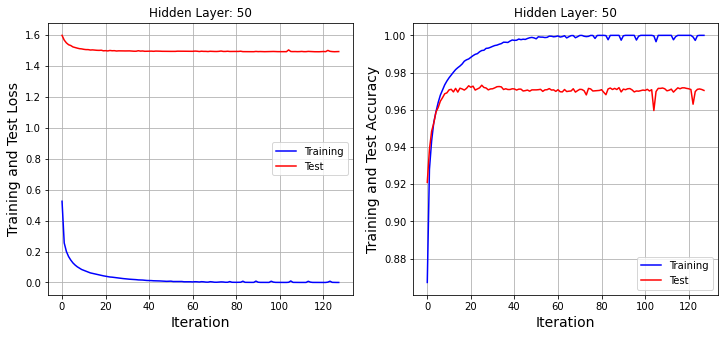

In [49]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss4, 'b', label = "Training")
ax[0].plot(range(128), test_loss4, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 50')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc4, 'b', label = "Training")
ax[1].plot(range(128), test_acc4, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 50')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 50.png")

In [53]:
model = BaselineModel(784,75,10)

train_loss4 = np.zeros(128)
test_loss4 = np.zeros(128)
train_acc4 = np.zeros(128)
test_acc4 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.28500914573669434, 'running_acc': 0.9234374761581421, 'loss': 0.4653610289096832, 'acc': 0.881850004196167, 'val_loss': 1.5841935873031616, 'val_acc': 0.927299976348877}
Epoch: 1
Training Loss: 0.4653610289096832
Training Accuracy: 0.881850004196167
Test Loss: 1.5841935873031616
Test Accuracy: 0.927299976348877


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.1915266215801239, 'running_acc': 0.94593745470047, 'loss': 0.22824931144714355, 'acc': 0.9359999895095825, 'val_loss': 1.5532640218734741, 'val_acc': 0.9458999633789062}
Epoch: 2
Training Loss: 0.22824931144714355
Training Accuracy: 0.9359999895095825
Test Loss: 1.5532640218734741
Test Accuracy: 0.9458999633789062


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.13844646513462067, 'running_acc': 0.957812488079071, 'loss': 0.17585943639278412, 'acc': 0.9501166939735413, 'val_loss': 1.5366088151931763, 'val_acc': 0.9540999531745911}
Epoch: 3
Training Loss: 0.17585943639278412
Training Accuracy: 0.9501166939735413
Test Loss: 1.5366088151931763
Test Accuracy: 0.9540999531745911


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.13138779997825623, 'running_acc': 0.9637500047683716, 'loss': 0.14236746728420258, 'acc': 0.9594666957855225, 'val_loss': 1.525467872619629, 'val_acc': 0.960099995136261}
Epoch: 4
Training Loss: 0.14236746728420258
Training Accuracy: 0.9594666957855225
Test Loss: 1.525467872619629
Test Accuracy: 0.960099995136261


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0960301086306572, 'running_acc': 0.9707812070846558, 'loss': 0.11735112220048904, 'acc': 0.9665833711624146, 'val_loss': 1.517901062965393, 'val_acc': 0.965399980545044}
Epoch: 5
Training Loss: 0.11735112220048904
Training Accuracy: 0.9665833711624146
Test Loss: 1.517901062965393
Test Accuracy: 0.965399980545044


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.10419005155563354, 'running_acc': 0.9685937166213989, 'loss': 0.09956110268831253, 'acc': 0.9716166853904724, 'val_loss': 1.5119411945343018, 'val_acc': 0.968999981880188}
Epoch: 6
Training Loss: 0.09956110268831253
Training Accuracy: 0.9716166853904724
Test Loss: 1.5119411945343018
Test Accuracy: 0.968999981880188


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.08489937335252762, 'running_acc': 0.9749999642372131, 'loss': 0.08527587354183197, 'acc': 0.9755499958992004, 'val_loss': 1.5059353113174438, 'val_acc': 0.9713999629020691}
Epoch: 7
Training Loss: 0.08527587354183197
Training Accuracy: 0.9755499958992004
Test Loss: 1.5059353113174438
Test Accuracy: 0.9713999629020691


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.07471770793199539, 'running_acc': 0.97718745470047, 'loss': 0.07523350417613983, 'acc': 0.978516697883606, 'val_loss': 1.5034362077713013, 'val_acc': 0.9711999893188477}
Epoch: 8
Training Loss: 0.07523350417613983
Training Accuracy: 0.978516697883606
Test Loss: 1.5034362077713013
Test Accuracy: 0.9711999893188477


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06147442385554314, 'running_acc': 0.9824999570846558, 'loss': 0.06698654592037201, 'acc': 0.9805999994277954, 'val_loss': 1.5012048482894897, 'val_acc': 0.9749999642372131}
Epoch: 9
Training Loss: 0.06698654592037201
Training Accuracy: 0.9805999994277954
Test Loss: 1.5012048482894897
Test Accuracy: 0.9749999642372131


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.06262945383787155, 'running_acc': 0.981249988079071, 'loss': 0.0597243532538414, 'acc': 0.9830666780471802, 'val_loss': 1.4986770153045654, 'val_acc': 0.9749999642372131}
Epoch: 10
Training Loss: 0.0597243532538414
Training Accuracy: 0.9830666780471802
Test Loss: 1.4986770153045654
Test Accuracy: 0.9749999642372131


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.05491289496421814, 'running_acc': 0.9848437309265137, 'loss': 0.05198733136057854, 'acc': 0.9852833151817322, 'val_loss': 1.4979374408721924, 'val_acc': 0.9732999801635742}
Epoch: 11
Training Loss: 0.05198733136057854
Training Accuracy: 0.9852833151817322
Test Loss: 1.4979374408721924
Test Accuracy: 0.9732999801635742


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.05445851385593414, 'running_acc': 0.9845312237739563, 'loss': 0.04755052551627159, 'acc': 0.9866666793823242, 'val_loss': 1.4963486194610596, 'val_acc': 0.9754999876022339}
Epoch: 12
Training Loss: 0.04755052551627159
Training Accuracy: 0.9866666793823242
Test Loss: 1.4963486194610596
Test Accuracy: 0.9754999876022339


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04958684369921684, 'running_acc': 0.9854687452316284, 'loss': 0.04249618947505951, 'acc': 0.987766683101654, 'val_loss': 1.496970534324646, 'val_acc': 0.9741999506950378}
Epoch: 13
Training Loss: 0.04249618947505951
Training Accuracy: 0.987766683101654
Test Loss: 1.496970534324646
Test Accuracy: 0.9741999506950378


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03662810102105141, 'running_acc': 0.9903124570846558, 'loss': 0.037774115800857544, 'acc': 0.9895666837692261, 'val_loss': 1.4939637184143066, 'val_acc': 0.9761999845504761}
Epoch: 14
Training Loss: 0.037774115800857544
Training Accuracy: 0.9895666837692261
Test Loss: 1.4939637184143066
Test Accuracy: 0.9761999845504761


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.04297177866101265, 'running_acc': 0.9879687428474426, 'loss': 0.03446830064058304, 'acc': 0.9905166625976562, 'val_loss': 1.493403673171997, 'val_acc': 0.9752999544143677}
Epoch: 15
Training Loss: 0.03446830064058304
Training Accuracy: 0.9905166625976562
Test Loss: 1.493403673171997
Test Accuracy: 0.9752999544143677


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.030936283990740776, 'running_acc': 0.9921875, 'loss': 0.03031136468052864, 'acc': 0.9918000102043152, 'val_loss': 1.491079568862915, 'val_acc': 0.9772999882698059}
Epoch: 16
Training Loss: 0.03031136468052864
Training Accuracy: 0.9918000102043152
Test Loss: 1.491079568862915
Test Accuracy: 0.9772999882698059


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02429283782839775, 'running_acc': 0.9943749904632568, 'loss': 0.02728915400803089, 'acc': 0.9934333562850952, 'val_loss': 1.4911991357803345, 'val_acc': 0.9756999611854553}
Epoch: 17
Training Loss: 0.02728915400803089
Training Accuracy: 0.9934333562850952
Test Loss: 1.4911991357803345
Test Accuracy: 0.9756999611854553


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03001452423632145, 'running_acc': 0.9910937547683716, 'loss': 0.0247486662119627, 'acc': 0.9938666820526123, 'val_loss': 1.4913995265960693, 'val_acc': 0.9754999876022339}
Epoch: 18
Training Loss: 0.0247486662119627
Training Accuracy: 0.9938666820526123
Test Loss: 1.4913995265960693
Test Accuracy: 0.9754999876022339


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02168508805334568, 'running_acc': 0.9942187070846558, 'loss': 0.0232409480959177, 'acc': 0.9941333532333374, 'val_loss': 1.4902819395065308, 'val_acc': 0.9759999513626099}
Epoch: 19
Training Loss: 0.0232409480959177
Training Accuracy: 0.9941333532333374
Test Loss: 1.4902819395065308
Test Accuracy: 0.9759999513626099


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.020559612661600113, 'running_acc': 0.9950000047683716, 'loss': 0.02048363722860813, 'acc': 0.9948000311851501, 'val_loss': 1.4901355504989624, 'val_acc': 0.9759999513626099}
Epoch: 20
Training Loss: 0.02048363722860813
Training Accuracy: 0.9948000311851501
Test Loss: 1.4901355504989624
Test Accuracy: 0.9759999513626099


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.020287854596972466, 'running_acc': 0.9954687356948853, 'loss': 0.018239565193653107, 'acc': 0.9957833290100098, 'val_loss': 1.4894599914550781, 'val_acc': 0.9763000011444092}
Epoch: 21
Training Loss: 0.018239565193653107
Training Accuracy: 0.9957833290100098
Test Loss: 1.4894599914550781
Test Accuracy: 0.9763000011444092


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.017423931509256363, 'running_acc': 0.9953124523162842, 'loss': 0.016331618651747704, 'acc': 0.9966333508491516, 'val_loss': 1.4891915321350098, 'val_acc': 0.976699948310852}
Epoch: 22
Training Loss: 0.016331618651747704
Training Accuracy: 0.9966333508491516
Test Loss: 1.4891915321350098
Test Accuracy: 0.976699948310852


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01824713870882988, 'running_acc': 0.9946874976158142, 'loss': 0.014792210422456264, 'acc': 0.9967833161354065, 'val_loss': 1.4878976345062256, 'val_acc': 0.9763999581336975}
Epoch: 23
Training Loss: 0.014792210422456264
Training Accuracy: 0.9967833161354065
Test Loss: 1.4878976345062256
Test Accuracy: 0.9763999581336975


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.016491377726197243, 'running_acc': 0.9956249594688416, 'loss': 0.013240194879472256, 'acc': 0.9972333312034607, 'val_loss': 1.488631010055542, 'val_acc': 0.976099967956543}
Epoch: 24
Training Loss: 0.013240194879472256
Training Accuracy: 0.9972333312034607
Test Loss: 1.488631010055542
Test Accuracy: 0.976099967956543


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01352638565003872, 'running_acc': 0.9973437190055847, 'loss': 0.011818750761449337, 'acc': 0.9977499842643738, 'val_loss': 1.4879504442214966, 'val_acc': 0.9763999581336975}
Epoch: 25
Training Loss: 0.011818750761449337
Training Accuracy: 0.9977499842643738
Test Loss: 1.4879504442214966
Test Accuracy: 0.9763999581336975


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.014384433627128601, 'running_acc': 0.9962499737739563, 'loss': 0.010990331880748272, 'acc': 0.9979333281517029, 'val_loss': 1.4878356456756592, 'val_acc': 0.9763000011444092}
Epoch: 26
Training Loss: 0.010990331880748272
Training Accuracy: 0.9979333281517029
Test Loss: 1.4878356456756592
Test Accuracy: 0.9763000011444092


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009689297527074814, 'running_acc': 0.9985937476158142, 'loss': 0.009438549168407917, 'acc': 0.9985333681106567, 'val_loss': 1.4874365329742432, 'val_acc': 0.9757999777793884}
Epoch: 27
Training Loss: 0.009438549168407917
Training Accuracy: 0.9985333681106567
Test Loss: 1.4874365329742432
Test Accuracy: 0.9757999777793884


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01110182423144579, 'running_acc': 0.9973437190055847, 'loss': 0.008818159811198711, 'acc': 0.9983167052268982, 'val_loss': 1.4896292686462402, 'val_acc': 0.974399983882904}
Epoch: 28
Training Loss: 0.008818159811198711
Training Accuracy: 0.9983167052268982
Test Loss: 1.4896292686462402
Test Accuracy: 0.974399983882904


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009987641125917435, 'running_acc': 0.9976562261581421, 'loss': 0.007874500006437302, 'acc': 0.9986000061035156, 'val_loss': 1.4879438877105713, 'val_acc': 0.9757999777793884}
Epoch: 29
Training Loss: 0.007874500006437302
Training Accuracy: 0.9986000061035156
Test Loss: 1.4879438877105713
Test Accuracy: 0.9757999777793884


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0072936019860208035, 'running_acc': 0.9990624785423279, 'loss': 0.007326505612581968, 'acc': 0.9989166855812073, 'val_loss': 1.4867547750473022, 'val_acc': 0.9763999581336975}
Epoch: 30
Training Loss: 0.007326505612581968
Training Accuracy: 0.9989166855812073
Test Loss: 1.4867547750473022
Test Accuracy: 0.9763999581336975


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006579408422112465, 'running_acc': 0.9992187023162842, 'loss': 0.00590421911329031, 'acc': 0.9991999864578247, 'val_loss': 1.4869297742843628, 'val_acc': 0.9763000011444092}
Epoch: 31
Training Loss: 0.00590421911329031
Training Accuracy: 0.9991999864578247
Test Loss: 1.4869297742843628
Test Accuracy: 0.9763000011444092


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006398418452590704, 'running_acc': 0.9992187023162842, 'loss': 0.005355915054678917, 'acc': 0.9994833469390869, 'val_loss': 1.4863179922103882, 'val_acc': 0.9775999784469604}
Epoch: 32
Training Loss: 0.005355915054678917
Training Accuracy: 0.9994833469390869
Test Loss: 1.4863179922103882
Test Accuracy: 0.9775999784469604


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006888241041451693, 'running_acc': 0.9984374642372131, 'loss': 0.005251054652035236, 'acc': 0.9993500113487244, 'val_loss': 1.489325761795044, 'val_acc': 0.9740999937057495}
Epoch: 33
Training Loss: 0.005251054652035236
Training Accuracy: 0.9993500113487244
Test Loss: 1.489325761795044
Test Accuracy: 0.9740999937057495


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01430024579167366, 'running_acc': 0.9956249594688416, 'loss': 0.006458468735218048, 'acc': 0.9988000392913818, 'val_loss': 1.487557053565979, 'val_acc': 0.9763000011444092}
Epoch: 34
Training Loss: 0.006458468735218048
Training Accuracy: 0.9988000392913818
Test Loss: 1.487557053565979
Test Accuracy: 0.9763000011444092


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.004052781034260988, 'running_acc': 1.0, 'loss': 0.00492521608248353, 'acc': 0.9992666840553284, 'val_loss': 1.4884648323059082, 'val_acc': 0.9749999642372131}
Epoch: 35
Training Loss: 0.00492521608248353
Training Accuracy: 0.9992666840553284
Test Loss: 1.4884648323059082
Test Accuracy: 0.9749999642372131


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0033345373813062906, 'running_acc': 0.9996874928474426, 'loss': 0.0030434068758040667, 'acc': 0.9997833371162415, 'val_loss': 1.4863840341567993, 'val_acc': 0.9765999913215637}
Epoch: 36
Training Loss: 0.0030434068758040667
Training Accuracy: 0.9997833371162415
Test Loss: 1.4863840341567993
Test Accuracy: 0.9765999913215637


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005879061296582222, 'running_acc': 0.9989062547683716, 'loss': 0.002881840569898486, 'acc': 0.9997667074203491, 'val_loss': 1.4878671169281006, 'val_acc': 0.9754999876022339}
Epoch: 37
Training Loss: 0.002881840569898486
Training Accuracy: 0.9997667074203491
Test Loss: 1.4878671169281006
Test Accuracy: 0.9754999876022339


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0039619458839297295, 'running_acc': 0.9995312094688416, 'loss': 0.0029640195425599813, 'acc': 0.9997667074203491, 'val_loss': 1.4874486923217773, 'val_acc': 0.9749999642372131}
Epoch: 38
Training Loss: 0.0029640195425599813
Training Accuracy: 0.9997667074203491
Test Loss: 1.4874486923217773
Test Accuracy: 0.9749999642372131


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0056849513202905655, 'running_acc': 0.9984374642372131, 'loss': 0.002789244521409273, 'acc': 0.999666690826416, 'val_loss': 1.4886661767959595, 'val_acc': 0.9752999544143677}
Epoch: 39
Training Loss: 0.002789244521409273
Training Accuracy: 0.999666690826416
Test Loss: 1.4886661767959595
Test Accuracy: 0.9752999544143677


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008644426241517067, 'running_acc': 0.996874988079071, 'loss': 0.005402756854891777, 'acc': 0.9986833333969116, 'val_loss': 1.488162636756897, 'val_acc': 0.974299967288971}
Epoch: 40
Training Loss: 0.005402756854891777
Training Accuracy: 0.9986833333969116
Test Loss: 1.488162636756897
Test Accuracy: 0.974299967288971


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0019064988009631634, 'running_acc': 1.0, 'loss': 0.0033381774555891752, 'acc': 0.9994666576385498, 'val_loss': 1.4859427213668823, 'val_acc': 0.9759999513626099}
Epoch: 41
Training Loss: 0.0033381774555891752
Training Accuracy: 0.9994666576385498
Test Loss: 1.4859427213668823
Test Accuracy: 0.9759999513626099


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0017420391086488962, 'running_acc': 1.0, 'loss': 0.0014081746339797974, 'acc': 1.0, 'val_loss': 1.4850987195968628, 'val_acc': 0.9767999649047852}
Epoch: 42
Training Loss: 0.0014081746339797974
Training Accuracy: 1.0
Test Loss: 1.4850987195968628
Test Accuracy: 0.9767999649047852


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0014477357035502791, 'running_acc': 1.0, 'loss': 0.0012902304297313094, 'acc': 0.9999833703041077, 'val_loss': 1.4862220287322998, 'val_acc': 0.9763000011444092}
Epoch: 43
Training Loss: 0.0012902304297313094
Training Accuracy: 0.9999833703041077
Test Loss: 1.4862220287322998
Test Accuracy: 0.9763000011444092


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0014965684385970235, 'running_acc': 0.9998437166213989, 'loss': 0.0010993577307090163, 'acc': 0.9999833703041077, 'val_loss': 1.4858555793762207, 'val_acc': 0.976099967956543}
Epoch: 44
Training Loss: 0.0010993577307090163
Training Accuracy: 0.9999833703041077
Test Loss: 1.4858555793762207
Test Accuracy: 0.976099967956543


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007661004085093737, 'running_acc': 0.9982812404632568, 'loss': 0.00797305814921856, 'acc': 0.9974333643913269, 'val_loss': 1.4878437519073486, 'val_acc': 0.974299967288971}
Epoch: 45
Training Loss: 0.00797305814921856
Training Accuracy: 0.9974333643913269
Test Loss: 1.4878437519073486
Test Accuracy: 0.974299967288971


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.002372562186792493, 'running_acc': 0.9996874928474426, 'loss': 0.0034349742345511913, 'acc': 0.9992666840553284, 'val_loss': 1.4868528842926025, 'val_acc': 0.9764999747276306}
Epoch: 46
Training Loss: 0.0034349742345511913
Training Accuracy: 0.9992666840553284
Test Loss: 1.4868528842926025
Test Accuracy: 0.9764999747276306


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001048562815412879, 'running_acc': 1.0, 'loss': 0.0013157001230865717, 'acc': 0.9999333620071411, 'val_loss': 1.485234260559082, 'val_acc': 0.9763999581336975}
Epoch: 47
Training Loss: 0.0013157001230865717
Training Accuracy: 0.9999333620071411
Test Loss: 1.485234260559082
Test Accuracy: 0.9763999581336975


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.000922244624234736, 'running_acc': 1.0, 'loss': 0.0007707756012678146, 'acc': 1.0, 'val_loss': 1.4853737354278564, 'val_acc': 0.9764999747276306}
Epoch: 48
Training Loss: 0.0007707756012678146
Training Accuracy: 1.0
Test Loss: 1.4853737354278564
Test Accuracy: 0.9764999747276306


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0006695256452076137, 'running_acc': 1.0, 'loss': 0.0006584834773093462, 'acc': 1.0, 'val_loss': 1.4846458435058594, 'val_acc': 0.9771999716758728}
Epoch: 49
Training Loss: 0.0006584834773093462
Training Accuracy: 1.0
Test Loss: 1.4846458435058594
Test Accuracy: 0.9771999716758728


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0008626641356386244, 'running_acc': 1.0, 'loss': 0.0006578516331501305, 'acc': 1.0, 'val_loss': 1.4854778051376343, 'val_acc': 0.9767999649047852}
Epoch: 50
Training Loss: 0.0006578516331501305
Training Accuracy: 1.0
Test Loss: 1.4854778051376343
Test Accuracy: 0.9767999649047852


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0007385471253655851, 'running_acc': 1.0, 'loss': 0.0006644745590165257, 'acc': 1.0, 'val_loss': 1.4847142696380615, 'val_acc': 0.9770999550819397}
Epoch: 51
Training Loss: 0.0006644745590165257
Training Accuracy: 1.0
Test Loss: 1.4847142696380615
Test Accuracy: 0.9770999550819397


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.015823516994714737, 'running_acc': 0.9942187070846558, 'loss': 0.003229217603802681, 'acc': 0.9991500377655029, 'val_loss': 1.4982123374938965, 'val_acc': 0.9645999670028687}
Epoch: 52
Training Loss: 0.003229217603802681
Training Accuracy: 0.9991500377655029
Test Loss: 1.4982123374938965
Test Accuracy: 0.9645999670028687


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.001980110537260771, 'running_acc': 0.9998437166213989, 'loss': 0.008211852051317692, 'acc': 0.9972833395004272, 'val_loss': 1.4872565269470215, 'val_acc': 0.9764999747276306}
Epoch: 53
Training Loss: 0.008211852051317692
Training Accuracy: 0.9972833395004272
Test Loss: 1.4872565269470215
Test Accuracy: 0.9764999747276306


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0007144581177271903, 'running_acc': 1.0, 'loss': 0.0008489493629895151, 'acc': 1.0, 'val_loss': 1.4852837324142456, 'val_acc': 0.9764999747276306}
Epoch: 54
Training Loss: 0.0008489493629895151
Training Accuracy: 1.0
Test Loss: 1.4852837324142456
Test Accuracy: 0.9764999747276306


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0005494391662068665, 'running_acc': 1.0, 'loss': 0.0005539138219319284, 'acc': 1.0, 'val_loss': 1.4851725101470947, 'val_acc': 0.976699948310852}
Epoch: 55
Training Loss: 0.0005539138219319284
Training Accuracy: 1.0
Test Loss: 1.4851725101470947
Test Accuracy: 0.976699948310852


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0005004485719837248, 'running_acc': 1.0, 'loss': 0.0004569567972794175, 'acc': 1.0, 'val_loss': 1.4857956171035767, 'val_acc': 0.9763000011444092}
Epoch: 56
Training Loss: 0.0004569567972794175
Training Accuracy: 1.0
Test Loss: 1.4857956171035767
Test Accuracy: 0.9763000011444092


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00044644344598054886, 'running_acc': 1.0, 'loss': 0.00041998454253189266, 'acc': 1.0, 'val_loss': 1.4847071170806885, 'val_acc': 0.9767999649047852}
Epoch: 57
Training Loss: 0.00041998454253189266
Training Accuracy: 1.0
Test Loss: 1.4847071170806885
Test Accuracy: 0.9767999649047852


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.000377884425688535, 'running_acc': 1.0, 'loss': 0.0003911221865564585, 'acc': 1.0, 'val_loss': 1.4848215579986572, 'val_acc': 0.976099967956543}
Epoch: 58
Training Loss: 0.0003911221865564585
Training Accuracy: 1.0
Test Loss: 1.4848215579986572
Test Accuracy: 0.976099967956543


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.000366971711628139, 'running_acc': 1.0, 'loss': 0.00036420393735170364, 'acc': 1.0, 'val_loss': 1.485376000404358, 'val_acc': 0.9764999747276306}
Epoch: 59
Training Loss: 0.00036420393735170364
Training Accuracy: 1.0
Test Loss: 1.485376000404358
Test Accuracy: 0.9764999747276306


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01472330093383789, 'running_acc': 0.9948437213897705, 'loss': 0.0023972811177372932, 'acc': 0.9992666840553284, 'val_loss': 1.4905331134796143, 'val_acc': 0.9713999629020691}
Epoch: 60
Training Loss: 0.0023972811177372932
Training Accuracy: 0.9992666840553284
Test Loss: 1.4905331134796143
Test Accuracy: 0.9713999629020691


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0020122264977544546, 'running_acc': 0.9995312094688416, 'loss': 0.0090851541608572, 'acc': 0.9968667030334473, 'val_loss': 1.4857982397079468, 'val_acc': 0.9754999876022339}
Epoch: 61
Training Loss: 0.0090851541608572
Training Accuracy: 0.9968667030334473
Test Loss: 1.4857982397079468
Test Accuracy: 0.9754999876022339


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0006420480785891414, 'running_acc': 1.0, 'loss': 0.0009350651525892317, 'acc': 0.9998999834060669, 'val_loss': 1.4846014976501465, 'val_acc': 0.977400004863739}
Epoch: 62
Training Loss: 0.0009350651525892317
Training Accuracy: 0.9998999834060669
Test Loss: 1.4846014976501465
Test Accuracy: 0.977400004863739


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00041353722917847335, 'running_acc': 1.0, 'loss': 0.0004359548620413989, 'acc': 1.0, 'val_loss': 1.485373854637146, 'val_acc': 0.976099967956543}
Epoch: 63
Training Loss: 0.0004359548620413989
Training Accuracy: 1.0
Test Loss: 1.485373854637146
Test Accuracy: 0.976099967956543


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002828803553711623, 'running_acc': 1.0, 'loss': 0.0003402876609470695, 'acc': 1.0, 'val_loss': 1.484649419784546, 'val_acc': 0.9767999649047852}
Epoch: 64
Training Loss: 0.0003402876609470695
Training Accuracy: 1.0
Test Loss: 1.484649419784546
Test Accuracy: 0.9767999649047852


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0003397270629648119, 'running_acc': 1.0, 'loss': 0.0003044343611691147, 'acc': 1.0, 'val_loss': 1.484907865524292, 'val_acc': 0.9764999747276306}
Epoch: 65
Training Loss: 0.0003044343611691147
Training Accuracy: 1.0
Test Loss: 1.484907865524292
Test Accuracy: 0.9764999747276306


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002822857932187617, 'running_acc': 1.0, 'loss': 0.00028607877902686596, 'acc': 1.0, 'val_loss': 1.4846211671829224, 'val_acc': 0.9765999913215637}
Epoch: 66
Training Loss: 0.00028607877902686596
Training Accuracy: 1.0
Test Loss: 1.4846211671829224
Test Accuracy: 0.9765999913215637


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00024958697031252086, 'running_acc': 1.0, 'loss': 0.00026307892403565347, 'acc': 1.0, 'val_loss': 1.4846736192703247, 'val_acc': 0.9767999649047852}
Epoch: 67
Training Loss: 0.00026307892403565347
Training Accuracy: 1.0
Test Loss: 1.4846736192703247
Test Accuracy: 0.9767999649047852


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00023456921917386353, 'running_acc': 1.0, 'loss': 0.00024196483718696982, 'acc': 1.0, 'val_loss': 1.484373688697815, 'val_acc': 0.9767999649047852}
Epoch: 68
Training Loss: 0.00024196483718696982
Training Accuracy: 1.0
Test Loss: 1.484373688697815
Test Accuracy: 0.9767999649047852


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00023814704036340117, 'running_acc': 1.0, 'loss': 0.0002267098898300901, 'acc': 1.0, 'val_loss': 1.4848641157150269, 'val_acc': 0.9757999777793884}
Epoch: 69
Training Loss: 0.0002267098898300901
Training Accuracy: 1.0
Test Loss: 1.4848641157150269
Test Accuracy: 0.9757999777793884


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00023198068083729595, 'running_acc': 1.0, 'loss': 0.0002112741640303284, 'acc': 1.0, 'val_loss': 1.4853500127792358, 'val_acc': 0.9771999716758728}
Epoch: 70
Training Loss: 0.0002112741640303284
Training Accuracy: 1.0
Test Loss: 1.4853500127792358
Test Accuracy: 0.9771999716758728


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

70/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010620282962918282, 'running_acc': 0.9959374666213989, 'loss': 0.009065954945981503, 'acc': 0.9970166683197021, 'val_loss': 1.4882701635360718, 'val_acc': 0.9741999506950378}
Epoch: 71
Training Loss: 0.009065954945981503
Training Accuracy: 0.9970166683197021
Test Loss: 1.4882701635360718
Test Accuracy: 0.9741999506950378


71/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

71/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0013646906008943915, 'running_acc': 0.9998437166213989, 'loss': 0.0033262690994888544, 'acc': 0.9990333318710327, 'val_loss': 1.4854629039764404, 'val_acc': 0.9763999581336975}
Epoch: 72
Training Loss: 0.0033262690994888544
Training Accuracy: 0.9990333318710327
Test Loss: 1.4854629039764404
Test Accuracy: 0.9763999581336975


72/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

72/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0005030180909670889, 'running_acc': 1.0, 'loss': 0.0007009416585788131, 'acc': 0.9999499917030334, 'val_loss': 1.4856276512145996, 'val_acc': 0.9754999876022339}
Epoch: 73
Training Loss: 0.0007009416585788131
Training Accuracy: 0.9999499917030334
Test Loss: 1.4856276512145996
Test Accuracy: 0.9754999876022339


73/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

73/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002565388276707381, 'running_acc': 1.0, 'loss': 0.00028537545586004853, 'acc': 1.0, 'val_loss': 1.4843024015426636, 'val_acc': 0.9769999980926514}
Epoch: 74
Training Loss: 0.00028537545586004853
Training Accuracy: 1.0
Test Loss: 1.4843024015426636
Test Accuracy: 0.9769999980926514


74/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

74/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00022440074826590717, 'running_acc': 1.0, 'loss': 0.00022473459830507636, 'acc': 1.0, 'val_loss': 1.48434579372406, 'val_acc': 0.9772999882698059}
Epoch: 75
Training Loss: 0.00022473459830507636
Training Accuracy: 1.0
Test Loss: 1.48434579372406
Test Accuracy: 0.9772999882698059


75/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

75/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00020829937420785427, 'running_acc': 1.0, 'loss': 0.0001974746846826747, 'acc': 1.0, 'val_loss': 1.4846981763839722, 'val_acc': 0.9770999550819397}
Epoch: 76
Training Loss: 0.0001974746846826747
Training Accuracy: 1.0
Test Loss: 1.4846981763839722
Test Accuracy: 0.9770999550819397


76/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

76/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00018130629905499518, 'running_acc': 1.0, 'loss': 0.00018151236872654408, 'acc': 1.0, 'val_loss': 1.4844709634780884, 'val_acc': 0.9774999618530273}
Epoch: 77
Training Loss: 0.00018151236872654408
Training Accuracy: 1.0
Test Loss: 1.4844709634780884
Test Accuracy: 0.9774999618530273


77/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

77/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00018320999515708536, 'running_acc': 1.0, 'loss': 0.0001652724458836019, 'acc': 1.0, 'val_loss': 1.4847606420516968, 'val_acc': 0.9768999814987183}
Epoch: 78
Training Loss: 0.0001652724458836019
Training Accuracy: 1.0
Test Loss: 1.4847606420516968
Test Accuracy: 0.9768999814987183


78/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

78/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00017178995767608285, 'running_acc': 1.0, 'loss': 0.00015160466136876494, 'acc': 1.0, 'val_loss': 1.4841831922531128, 'val_acc': 0.9771999716758728}
Epoch: 79
Training Loss: 0.00015160466136876494
Training Accuracy: 1.0
Test Loss: 1.4841831922531128
Test Accuracy: 0.9771999716758728


79/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

79/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00013487719115801156, 'running_acc': 1.0, 'loss': 0.00014010179438628256, 'acc': 1.0, 'val_loss': 1.4842703342437744, 'val_acc': 0.9771999716758728}
Epoch: 80
Training Loss: 0.00014010179438628256
Training Accuracy: 1.0
Test Loss: 1.4842703342437744
Test Accuracy: 0.9771999716758728


80/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

80/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0001559228840051219, 'running_acc': 1.0, 'loss': 0.00013021647464483976, 'acc': 1.0, 'val_loss': 1.4843087196350098, 'val_acc': 0.9767999649047852}
Epoch: 81
Training Loss: 0.00013021647464483976
Training Accuracy: 1.0
Test Loss: 1.4843087196350098
Test Accuracy: 0.9767999649047852


81/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

81/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00013630258035846055, 'running_acc': 1.0, 'loss': 0.00012267561396583915, 'acc': 1.0, 'val_loss': 1.4842299222946167, 'val_acc': 0.9769999980926514}
Epoch: 82
Training Loss: 0.00012267561396583915
Training Accuracy: 1.0
Test Loss: 1.4842299222946167
Test Accuracy: 0.9769999980926514


82/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

82/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.015351729467511177, 'running_acc': 0.9948437213897705, 'loss': 0.008023173548281193, 'acc': 0.9974833726882935, 'val_loss': 1.4889235496520996, 'val_acc': 0.9732999801635742}
Epoch: 83
Training Loss: 0.008023173548281193
Training Accuracy: 0.9974833726882935
Test Loss: 1.4889235496520996
Test Accuracy: 0.9732999801635742


83/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

83/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0015730056911706924, 'running_acc': 0.9995312094688416, 'loss': 0.0028953987639397383, 'acc': 0.9990333318710327, 'val_loss': 1.4852758646011353, 'val_acc': 0.9759999513626099}
Epoch: 84
Training Loss: 0.0028953987639397383
Training Accuracy: 0.9990333318710327
Test Loss: 1.4852758646011353
Test Accuracy: 0.9759999513626099


84/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

84/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00020885709091089666, 'running_acc': 1.0, 'loss': 0.00042329999268986285, 'acc': 0.9999833703041077, 'val_loss': 1.4856722354888916, 'val_acc': 0.9768999814987183}
Epoch: 85
Training Loss: 0.00042329999268986285
Training Accuracy: 0.9999833703041077
Test Loss: 1.4856722354888916
Test Accuracy: 0.9768999814987183


85/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

85/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00018994745914824307, 'running_acc': 1.0, 'loss': 0.0002012097684200853, 'acc': 1.0, 'val_loss': 1.4841750860214233, 'val_acc': 0.9771999716758728}
Epoch: 86
Training Loss: 0.0002012097684200853
Training Accuracy: 1.0
Test Loss: 1.4841750860214233
Test Accuracy: 0.9771999716758728


86/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

86/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00015141967742238194, 'running_acc': 1.0, 'loss': 0.00016240327386185527, 'acc': 1.0, 'val_loss': 1.4839919805526733, 'val_acc': 0.9771999716758728}
Epoch: 87
Training Loss: 0.00016240327386185527
Training Accuracy: 1.0
Test Loss: 1.4839919805526733
Test Accuracy: 0.9771999716758728


87/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

87/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0001253721711691469, 'running_acc': 1.0, 'loss': 0.00014488896704278886, 'acc': 1.0, 'val_loss': 1.4839913845062256, 'val_acc': 0.9775999784469604}
Epoch: 88
Training Loss: 0.00014488896704278886
Training Accuracy: 1.0
Test Loss: 1.4839913845062256
Test Accuracy: 0.9775999784469604


88/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

88/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00014709943206980824, 'running_acc': 1.0, 'loss': 0.00012933409016113728, 'acc': 1.0, 'val_loss': 1.4839048385620117, 'val_acc': 0.9774999618530273}
Epoch: 89
Training Loss: 0.00012933409016113728
Training Accuracy: 1.0
Test Loss: 1.4839048385620117
Test Accuracy: 0.9774999618530273


89/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

89/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00012094239355064929, 'running_acc': 1.0, 'loss': 0.00011774301674449816, 'acc': 1.0, 'val_loss': 1.4839166402816772, 'val_acc': 0.9779999852180481}
Epoch: 90
Training Loss: 0.00011774301674449816
Training Accuracy: 1.0
Test Loss: 1.4839166402816772
Test Accuracy: 0.9779999852180481


90/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

90/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.925891597755253e-05, 'running_acc': 1.0, 'loss': 0.00010799541632877663, 'acc': 1.0, 'val_loss': 1.484635591506958, 'val_acc': 0.977400004863739}
Epoch: 91
Training Loss: 0.00010799541632877663
Training Accuracy: 1.0
Test Loss: 1.484635591506958
Test Accuracy: 0.977400004863739


91/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

91/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.51028341660276e-05, 'running_acc': 1.0, 'loss': 9.899684664560482e-05, 'acc': 1.0, 'val_loss': 1.483970284461975, 'val_acc': 0.9769999980926514}
Epoch: 92
Training Loss: 9.899684664560482e-05
Training Accuracy: 1.0
Test Loss: 1.483970284461975
Test Accuracy: 0.9769999980926514


92/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

92/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 9.299170051235706e-05, 'running_acc': 1.0, 'loss': 9.104616765398532e-05, 'acc': 1.0, 'val_loss': 1.4837803840637207, 'val_acc': 0.9775999784469604}
Epoch: 93
Training Loss: 9.104616765398532e-05
Training Accuracy: 1.0
Test Loss: 1.4837803840637207
Test Accuracy: 0.9775999784469604


93/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

93/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.465196151519194e-05, 'running_acc': 1.0, 'loss': 8.412422175751999e-05, 'acc': 1.0, 'val_loss': 1.4840551614761353, 'val_acc': 0.9770999550819397}
Epoch: 94
Training Loss: 8.412422175751999e-05
Training Accuracy: 1.0
Test Loss: 1.4840551614761353
Test Accuracy: 0.9770999550819397


94/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

94/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00010734690295066684, 'running_acc': 1.0, 'loss': 8.063617133302614e-05, 'acc': 1.0, 'val_loss': 1.4836572408676147, 'val_acc': 0.977899968624115}
Epoch: 95
Training Loss: 8.063617133302614e-05
Training Accuracy: 1.0
Test Loss: 1.4836572408676147
Test Accuracy: 0.977899968624115


95/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

95/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00011358015035511926, 'running_acc': 1.0, 'loss': 8.578620327170938e-05, 'acc': 1.0, 'val_loss': 1.4845072031021118, 'val_acc': 0.9763000011444092}
Epoch: 96
Training Loss: 8.578620327170938e-05
Training Accuracy: 1.0
Test Loss: 1.4845072031021118
Test Accuracy: 0.9763000011444092


96/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

96/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02046717330813408, 'running_acc': 0.9950000047683716, 'loss': 0.0035450835712254047, 'acc': 0.9991500377655029, 'val_loss': 1.4964959621429443, 'val_acc': 0.964199960231781}
Epoch: 97
Training Loss: 0.0035450835712254047
Training Accuracy: 0.9991500377655029
Test Loss: 1.4964959621429443
Test Accuracy: 0.964199960231781


97/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

97/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0043333787471055984, 'running_acc': 0.9979687333106995, 'loss': 0.009477237239480019, 'acc': 0.9968667030334473, 'val_loss': 1.4851340055465698, 'val_acc': 0.976099967956543}
Epoch: 98
Training Loss: 0.009477237239480019
Training Accuracy: 0.9968667030334473
Test Loss: 1.4851340055465698
Test Accuracy: 0.976099967956543


98/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

98/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0002889193419832736, 'running_acc': 1.0, 'loss': 0.0008543795556761324, 'acc': 0.9998500347137451, 'val_loss': 1.485053539276123, 'val_acc': 0.9772999882698059}
Epoch: 99
Training Loss: 0.0008543795556761324
Training Accuracy: 0.9998500347137451
Test Loss: 1.485053539276123
Test Accuracy: 0.9772999882698059


99/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

99/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00015746615827083588, 'running_acc': 1.0, 'loss': 0.00019359284488018602, 'acc': 1.0, 'val_loss': 1.4848840236663818, 'val_acc': 0.9770999550819397}
Epoch: 100
Training Loss: 0.00019359284488018602
Training Accuracy: 1.0
Test Loss: 1.4848840236663818
Test Accuracy: 0.9770999550819397


100/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

100/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00010635438957251608, 'running_acc': 1.0, 'loss': 0.00011888465814990923, 'acc': 1.0, 'val_loss': 1.4841134548187256, 'val_acc': 0.9770999550819397}
Epoch: 101
Training Loss: 0.00011888465814990923
Training Accuracy: 1.0
Test Loss: 1.4841134548187256
Test Accuracy: 0.9770999550819397


101/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

101/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00010856145672732964, 'running_acc': 1.0, 'loss': 0.0001018044858938083, 'acc': 1.0, 'val_loss': 1.4841363430023193, 'val_acc': 0.9770999550819397}
Epoch: 102
Training Loss: 0.0001018044858938083
Training Accuracy: 1.0
Test Loss: 1.4841363430023193
Test Accuracy: 0.9770999550819397


102/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

102/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.668738882988691e-05, 'running_acc': 1.0, 'loss': 9.012676309794188e-05, 'acc': 1.0, 'val_loss': 1.4846532344818115, 'val_acc': 0.9772999882698059}
Epoch: 103
Training Loss: 9.012676309794188e-05
Training Accuracy: 1.0
Test Loss: 1.4846532344818115
Test Accuracy: 0.9772999882698059


103/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

103/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.672761759953573e-05, 'running_acc': 1.0, 'loss': 8.128425542963669e-05, 'acc': 1.0, 'val_loss': 1.4847819805145264, 'val_acc': 0.9764999747276306}
Epoch: 104
Training Loss: 8.128425542963669e-05
Training Accuracy: 1.0
Test Loss: 1.4847819805145264
Test Accuracy: 0.9764999747276306


104/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

104/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.510317275067791e-05, 'running_acc': 1.0, 'loss': 7.392732368316501e-05, 'acc': 1.0, 'val_loss': 1.4839073419570923, 'val_acc': 0.9770999550819397}
Epoch: 105
Training Loss: 7.392732368316501e-05
Training Accuracy: 1.0
Test Loss: 1.4839073419570923
Test Accuracy: 0.9770999550819397


105/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

105/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.399619062198326e-05, 'running_acc': 1.0, 'loss': 6.733814370818436e-05, 'acc': 1.0, 'val_loss': 1.48392915725708, 'val_acc': 0.977400004863739}
Epoch: 106
Training Loss: 6.733814370818436e-05
Training Accuracy: 1.0
Test Loss: 1.48392915725708
Test Accuracy: 0.977400004863739


106/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

106/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.223774107638747e-05, 'running_acc': 1.0, 'loss': 6.152012792881578e-05, 'acc': 1.0, 'val_loss': 1.4839783906936646, 'val_acc': 0.9770999550819397}
Epoch: 107
Training Loss: 6.152012792881578e-05
Training Accuracy: 1.0
Test Loss: 1.4839783906936646
Test Accuracy: 0.9770999550819397


107/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

107/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.249804235063493e-05, 'running_acc': 1.0, 'loss': 5.6735880207270384e-05, 'acc': 1.0, 'val_loss': 1.483993411064148, 'val_acc': 0.9770999550819397}
Epoch: 108
Training Loss: 5.6735880207270384e-05
Training Accuracy: 1.0
Test Loss: 1.483993411064148
Test Accuracy: 0.9770999550819397


108/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

108/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.305516242515296e-05, 'running_acc': 1.0, 'loss': 5.239276651991531e-05, 'acc': 1.0, 'val_loss': 1.4841870069503784, 'val_acc': 0.9765999913215637}
Epoch: 109
Training Loss: 5.239276651991531e-05
Training Accuracy: 1.0
Test Loss: 1.4841870069503784
Test Accuracy: 0.9765999913215637


109/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

109/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.321979213273153e-05, 'running_acc': 1.0, 'loss': 4.94135711051058e-05, 'acc': 1.0, 'val_loss': 1.4840105772018433, 'val_acc': 0.9772999882698059}
Epoch: 110
Training Loss: 4.94135711051058e-05
Training Accuracy: 1.0
Test Loss: 1.4840105772018433
Test Accuracy: 0.9772999882698059


110/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

110/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.0896662287414074e-05, 'running_acc': 1.0, 'loss': 4.524618634604849e-05, 'acc': 1.0, 'val_loss': 1.4839129447937012, 'val_acc': 0.9772999882698059}
Epoch: 111
Training Loss: 4.524618634604849e-05
Training Accuracy: 1.0
Test Loss: 1.4839129447937012
Test Accuracy: 0.9772999882698059


111/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

111/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.457146133063361e-05, 'running_acc': 1.0, 'loss': 4.278147025615908e-05, 'acc': 1.0, 'val_loss': 1.4844987392425537, 'val_acc': 0.9767999649047852}
Epoch: 112
Training Loss: 4.278147025615908e-05
Training Accuracy: 1.0
Test Loss: 1.4844987392425537
Test Accuracy: 0.9767999649047852


112/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

112/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02958172932267189, 'running_acc': 0.9920312166213989, 'loss': 0.007663899101316929, 'acc': 0.9980666637420654, 'val_loss': 1.4938175678253174, 'val_acc': 0.9673999547958374}
Epoch: 113
Training Loss: 0.007663899101316929
Training Accuracy: 0.9980666637420654
Test Loss: 1.4938175678253174
Test Accuracy: 0.9673999547958374


113/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

113/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0008311888668686152, 'running_acc': 0.9998437166213989, 'loss': 0.004416017327457666, 'acc': 0.9983833432197571, 'val_loss': 1.486336588859558, 'val_acc': 0.9754999876022339}
Epoch: 114
Training Loss: 0.004416017327457666
Training Accuracy: 0.9983833432197571
Test Loss: 1.486336588859558
Test Accuracy: 0.9754999876022339


114/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

114/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0006485885824076831, 'running_acc': 0.9998437166213989, 'loss': 0.0004173274210188538, 'acc': 0.9999499917030334, 'val_loss': 1.486032247543335, 'val_acc': 0.9752999544143677}
Epoch: 115
Training Loss: 0.0004173274210188538
Training Accuracy: 0.9999499917030334
Test Loss: 1.486032247543335
Test Accuracy: 0.9752999544143677


115/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

115/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00013321252481546253, 'running_acc': 1.0, 'loss': 0.00024127359210979193, 'acc': 0.9999666810035706, 'val_loss': 1.485540747642517, 'val_acc': 0.9761999845504761}
Epoch: 116
Training Loss: 0.00024127359210979193
Training Accuracy: 0.9999666810035706
Test Loss: 1.485540747642517
Test Accuracy: 0.9761999845504761


116/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

116/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 7.879828626755625e-05, 'running_acc': 1.0, 'loss': 9.400532871950418e-05, 'acc': 1.0, 'val_loss': 1.4846887588500977, 'val_acc': 0.9764999747276306}
Epoch: 117
Training Loss: 9.400532871950418e-05
Training Accuracy: 1.0
Test Loss: 1.4846887588500977
Test Accuracy: 0.9764999747276306


117/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

117/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 8.041026740102097e-05, 'running_acc': 1.0, 'loss': 7.92734426795505e-05, 'acc': 1.0, 'val_loss': 1.4859652519226074, 'val_acc': 0.9761999845504761}
Epoch: 118
Training Loss: 7.92734426795505e-05
Training Accuracy: 1.0
Test Loss: 1.4859652519226074
Test Accuracy: 0.9761999845504761


118/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

118/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 6.689066503895447e-05, 'running_acc': 1.0, 'loss': 6.867285264888778e-05, 'acc': 1.0, 'val_loss': 1.4845564365386963, 'val_acc': 0.976699948310852}
Epoch: 119
Training Loss: 6.867285264888778e-05
Training Accuracy: 1.0
Test Loss: 1.4845564365386963
Test Accuracy: 0.976699948310852


119/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

119/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.749370757257566e-05, 'running_acc': 1.0, 'loss': 6.159442273201421e-05, 'acc': 1.0, 'val_loss': 1.4847129583358765, 'val_acc': 0.9763000011444092}
Epoch: 120
Training Loss: 6.159442273201421e-05
Training Accuracy: 1.0
Test Loss: 1.4847129583358765
Test Accuracy: 0.9763000011444092


120/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

120/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.66990056540817e-05, 'running_acc': 1.0, 'loss': 5.545198655454442e-05, 'acc': 1.0, 'val_loss': 1.4855762720108032, 'val_acc': 0.9764999747276306}
Epoch: 121
Training Loss: 5.545198655454442e-05
Training Accuracy: 1.0
Test Loss: 1.4855762720108032
Test Accuracy: 0.9764999747276306


121/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

121/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 5.1614413678180426e-05, 'running_acc': 1.0, 'loss': 5.0019029004033655e-05, 'acc': 1.0, 'val_loss': 1.4850796461105347, 'val_acc': 0.9764999747276306}
Epoch: 122
Training Loss: 5.0019029004033655e-05
Training Accuracy: 1.0
Test Loss: 1.4850796461105347
Test Accuracy: 0.9764999747276306


122/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

122/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.4629210606217384e-05, 'running_acc': 1.0, 'loss': 4.493323285714723e-05, 'acc': 1.0, 'val_loss': 1.4844228029251099, 'val_acc': 0.9764999747276306}
Epoch: 123
Training Loss: 4.493323285714723e-05
Training Accuracy: 1.0
Test Loss: 1.4844228029251099
Test Accuracy: 0.9764999747276306


123/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

123/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.7631743907695636e-05, 'running_acc': 1.0, 'loss': 4.155915667070076e-05, 'acc': 1.0, 'val_loss': 1.484619379043579, 'val_acc': 0.976099967956543}
Epoch: 124
Training Loss: 4.155915667070076e-05
Training Accuracy: 1.0
Test Loss: 1.484619379043579
Test Accuracy: 0.976099967956543


124/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

124/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.695713894558139e-05, 'running_acc': 1.0, 'loss': 3.768852911889553e-05, 'acc': 1.0, 'val_loss': 1.4843403100967407, 'val_acc': 0.976699948310852}
Epoch: 125
Training Loss: 3.768852911889553e-05
Training Accuracy: 1.0
Test Loss: 1.4843403100967407
Test Accuracy: 0.976699948310852


125/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

125/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 4.442519275471568e-05, 'running_acc': 1.0, 'loss': 3.492398536764085e-05, 'acc': 1.0, 'val_loss': 1.4846875667572021, 'val_acc': 0.9765999913215637}
Epoch: 126
Training Loss: 3.492398536764085e-05
Training Accuracy: 1.0
Test Loss: 1.4846875667572021
Test Accuracy: 0.9765999913215637


126/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

126/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.840981298708357e-05, 'running_acc': 1.0, 'loss': 3.20592153002508e-05, 'acc': 1.0, 'val_loss': 1.484515905380249, 'val_acc': 0.9768999814987183}
Epoch: 127
Training Loss: 3.20592153002508e-05
Training Accuracy: 1.0
Test Loss: 1.484515905380249
Test Accuracy: 0.9768999814987183


127/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

127/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 3.246069172746502e-05, 'running_acc': 1.0, 'loss': 2.979291275551077e-05, 'acc': 1.0, 'val_loss': 1.485219955444336, 'val_acc': 0.976699948310852}
Epoch: 128
Training Loss: 2.979291275551077e-05
Training Accuracy: 1.0
Test Loss: 1.485219955444336
Test Accuracy: 0.976699948310852


[{'running_loss': 0.28500914573669434,
  'running_acc': 0.9234374761581421,
  'loss': 0.4653610289096832,
  'acc': 0.881850004196167,
  'val_loss': 1.5841935873031616,
  'val_acc': 0.927299976348877,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.1915266215801239,
  'running_acc': 0.94593745470047,
  'loss': 0.22824931144714355,
  'acc': 0.9359999895095825,
  'val_loss': 1.5532640218734741,
  'val_acc': 0.9458999633789062,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.13844646513462067,
  'running_acc': 0.957812488079071,
  'loss': 0.17585943639278412,
  'acc': 0.9501166939735413,
  'val_loss': 1.5366088151931763,
  'val_acc': 0.9540999531745911,
  'train_steps': 469,
  'validation_steps': 79},
 {'running_loss': 0.13138779997825623,
  'running_acc': 0.9637500047683716,
  'loss': 0.14236746728420258,
  'acc': 0.9594666957855225,
  'val_loss': 1.525467872619629,
  'val_acc': 0.960099995136261,
  'train_steps': 469,
  'validation_steps': 79},
 

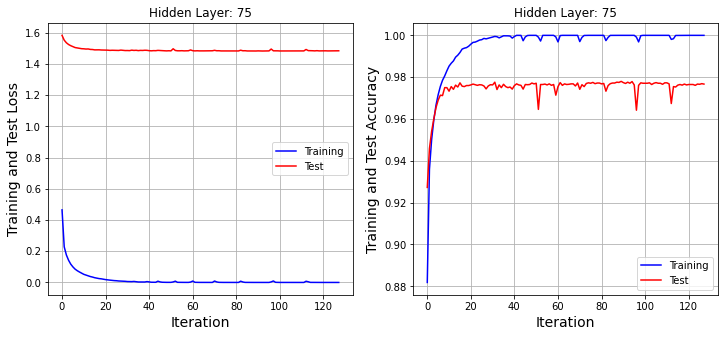

In [54]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss4, 'b', label = "Training")
ax[0].plot(range(128), test_loss4, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 75')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc4, 'b', label = "Training")
ax[1].plot(range(128), test_acc4, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 75')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 75.png")

In [ ]:
import torchbearer
from torchbearer import callbacks
model = BaselineModel(784,250000,10)

train_loss4 = np.zeros(128)
test_loss4 = np.zeros(128)
train_acc4 = np.zeros(128)
test_acc4 = np.zeros(128)

@callbacks.on_end_epoch
def print_metrics(state):
    print(state[torchbearer.state.METRICS])
    print("Epoch:",state[torchbearer.state.EPOCH]+1)
    print("Training Loss:",state[torchbearer.state.METRICS]['loss'])
    print("Training Accuracy:",state[torchbearer.state.METRICS]['acc'])
    print("Test Loss:",state[torchbearer.state.METRICS]['val_loss'])
    print("Test Accuracy:",state[torchbearer.state.METRICS]['val_acc'])

@callbacks.on_end_epoch
def store(state):
    train_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['loss']
    test_loss4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_loss']
    train_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['acc']
    test_acc4[state[torchbearer.state.EPOCH]]=state[torchbearer.state.METRICS]['val_acc']

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss','accuracy'],
                         callbacks=[print_metrics,store])
trial.with_generators(train_generator=trainloader,val_generator=testloader,test_generator=testloader).cuda()
trial.run(epochs=128)

0/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

0/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.12200888246297836, 'running_acc': 0.96546870470047, 'loss': 0.2482183426618576, 'acc': 0.9410833716392517, 'val_loss': 1.5048850774765015, 'val_acc': 0.967199981212616}
Epoch: 1
Training Loss: 0.2482183426618576
Training Accuracy: 0.9410833716392517
Test Loss: 1.5048850774765015
Test Accuracy: 0.967199981212616


1/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

1/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.09145005792379379, 'running_acc': 0.9737499952316284, 'loss': 0.08425898104906082, 'acc': 0.975433349609375, 'val_loss': 1.4952689409255981, 'val_acc': 0.971299946308136}
Epoch: 2
Training Loss: 0.08425898104906082
Training Accuracy: 0.975433349609375
Test Loss: 1.4952689409255981
Test Accuracy: 0.971299946308136


2/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

2/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.054106976836919785, 'running_acc': 0.9856249690055847, 'loss': 0.059062544256448746, 'acc': 0.9833000302314758, 'val_loss': 1.4865127801895142, 'val_acc': 0.9783999919891357}
Epoch: 3
Training Loss: 0.059062544256448746
Training Accuracy: 0.9833000302314758
Test Loss: 1.4865127801895142
Test Accuracy: 0.9783999919891357


3/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

3/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.05149572342634201, 'running_acc': 0.9854687452316284, 'loss': 0.045175351202487946, 'acc': 0.9866333603858948, 'val_loss': 1.4891204833984375, 'val_acc': 0.9734999537467957}
Epoch: 4
Training Loss: 0.045175351202487946
Training Accuracy: 0.9866333603858948
Test Loss: 1.4891204833984375
Test Accuracy: 0.9734999537467957


4/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

4/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.053688324987888336, 'running_acc': 0.9857812523841858, 'loss': 0.037197332829236984, 'acc': 0.9891833662986755, 'val_loss': 1.4863417148590088, 'val_acc': 0.976699948310852}
Epoch: 5
Training Loss: 0.037197332829236984
Training Accuracy: 0.9891833662986755
Test Loss: 1.4863417148590088
Test Accuracy: 0.976699948310852


5/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

5/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03954555466771126, 'running_acc': 0.9879687428474426, 'loss': 0.03401453047990799, 'acc': 0.9901000261306763, 'val_loss': 1.4839130640029907, 'val_acc': 0.9781999588012695}
Epoch: 6
Training Loss: 0.03401453047990799
Training Accuracy: 0.9901000261306763
Test Loss: 1.4839130640029907
Test Accuracy: 0.9781999588012695


6/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

6/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03753780201077461, 'running_acc': 0.9893749952316284, 'loss': 0.02806408517062664, 'acc': 0.9921333193778992, 'val_loss': 1.4830942153930664, 'val_acc': 0.9787999987602234}
Epoch: 7
Training Loss: 0.02806408517062664
Training Accuracy: 0.9921333193778992
Test Loss: 1.4830942153930664
Test Accuracy: 0.9787999987602234


7/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

7/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.020964298397302628, 'running_acc': 0.9934374690055847, 'loss': 0.024594582617282867, 'acc': 0.9927166700363159, 'val_loss': 1.4792749881744385, 'val_acc': 0.9828999638557434}
Epoch: 8
Training Loss: 0.024594582617282867
Training Accuracy: 0.9927166700363159
Test Loss: 1.4792749881744385
Test Accuracy: 0.9828999638557434


8/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

8/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.029449813067913055, 'running_acc': 0.9925000071525574, 'loss': 0.022463586181402206, 'acc': 0.9934166669845581, 'val_loss': 1.481401801109314, 'val_acc': 0.9801999926567078}
Epoch: 9
Training Loss: 0.022463586181402206
Training Accuracy: 0.9934166669845581
Test Loss: 1.481401801109314
Test Accuracy: 0.9801999926567078


9/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

9/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02334369346499443, 'running_acc': 0.9935937523841858, 'loss': 0.024320174008607864, 'acc': 0.9935500025749207, 'val_loss': 1.4784173965454102, 'val_acc': 0.983199954032898}
Epoch: 10
Training Loss: 0.024320174008607864
Training Accuracy: 0.9935500025749207
Test Loss: 1.4784173965454102
Test Accuracy: 0.983199954032898


10/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

10/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.024303317070007324, 'running_acc': 0.9951562285423279, 'loss': 0.019290506839752197, 'acc': 0.9952833652496338, 'val_loss': 1.4795526266098022, 'val_acc': 0.9824000000953674}
Epoch: 11
Training Loss: 0.019290506839752197
Training Accuracy: 0.9952833652496338
Test Loss: 1.4795526266098022
Test Accuracy: 0.9824000000953674


11/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

11/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.03023848682641983, 'running_acc': 0.9935937523841858, 'loss': 0.0280760508030653, 'acc': 0.9938333630561829, 'val_loss': 1.4801613092422485, 'val_acc': 0.9812999963760376}
Epoch: 12
Training Loss: 0.0280760508030653
Training Accuracy: 0.9938333630561829
Test Loss: 1.4801613092422485
Test Accuracy: 0.9812999963760376


12/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

12/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.029265983030200005, 'running_acc': 0.9942187070846558, 'loss': 0.026416156440973282, 'acc': 0.9946333169937134, 'val_loss': 1.4806523323059082, 'val_acc': 0.9802999496459961}
Epoch: 13
Training Loss: 0.026416156440973282
Training Accuracy: 0.9946333169937134
Test Loss: 1.4806523323059082
Test Accuracy: 0.9802999496459961


13/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

13/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.023896748200058937, 'running_acc': 0.9950000047683716, 'loss': 0.02529417723417282, 'acc': 0.9947167038917542, 'val_loss': 1.4787652492523193, 'val_acc': 0.9819999933242798}
Epoch: 14
Training Loss: 0.02529417723417282
Training Accuracy: 0.9947167038917542
Test Loss: 1.4787652492523193
Test Accuracy: 0.9819999933242798


14/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

14/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.030009359121322632, 'running_acc': 0.9940624833106995, 'loss': 0.020947933197021484, 'acc': 0.995983362197876, 'val_loss': 1.4824203252792358, 'val_acc': 0.9799000024795532}
Epoch: 15
Training Loss: 0.020947933197021484
Training Accuracy: 0.995983362197876
Test Loss: 1.4824203252792358
Test Accuracy: 0.9799000024795532


15/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

15/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010803420096635818, 'running_acc': 0.9975000023841858, 'loss': 0.012737472541630268, 'acc': 0.9968833327293396, 'val_loss': 1.4776718616485596, 'val_acc': 0.9837999939918518}
Epoch: 16
Training Loss: 0.012737472541630268
Training Accuracy: 0.9968833327293396
Test Loss: 1.4776718616485596
Test Accuracy: 0.9837999939918518


16/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

16/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.014561417512595654, 'running_acc': 0.9956249594688416, 'loss': 0.02107623964548111, 'acc': 0.9955333471298218, 'val_loss': 1.4828435182571411, 'val_acc': 0.9781000018119812}
Epoch: 17
Training Loss: 0.02107623964548111
Training Accuracy: 0.9955333471298218
Test Loss: 1.4828435182571411
Test Accuracy: 0.9781000018119812


17/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

17/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010124174878001213, 'running_acc': 0.9970312118530273, 'loss': 0.017913788557052612, 'acc': 0.9964666962623596, 'val_loss': 1.4785122871398926, 'val_acc': 0.9830999970436096}
Epoch: 18
Training Loss: 0.017913788557052612
Training Accuracy: 0.9964666962623596
Test Loss: 1.4785122871398926
Test Accuracy: 0.9830999970436096


18/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

18/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013419339433312416, 'running_acc': 0.99671870470047, 'loss': 0.01307150349020958, 'acc': 0.9974833726882935, 'val_loss': 1.4790023565292358, 'val_acc': 0.9818999767303467}
Epoch: 19
Training Loss: 0.01307150349020958
Training Accuracy: 0.9974833726882935
Test Loss: 1.4790023565292358
Test Accuracy: 0.9818999767303467


19/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

19/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.030152684077620506, 'running_acc': 0.9950000047683716, 'loss': 0.018231825903058052, 'acc': 0.9964500069618225, 'val_loss': 1.4802231788635254, 'val_acc': 0.9822999835014343}
Epoch: 20
Training Loss: 0.018231825903058052
Training Accuracy: 0.9964500069618225
Test Loss: 1.4802231788635254
Test Accuracy: 0.9822999835014343


20/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

20/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.026309333741664886, 'running_acc': 0.9951562285423279, 'loss': 0.019916383549571037, 'acc': 0.9964333176612854, 'val_loss': 1.4789292812347412, 'val_acc': 0.9822999835014343}
Epoch: 21
Training Loss: 0.019916383549571037
Training Accuracy: 0.9964333176612854
Test Loss: 1.4789292812347412
Test Accuracy: 0.9822999835014343


21/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

21/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.021171996369957924, 'running_acc': 0.9954687356948853, 'loss': 0.01821144111454487, 'acc': 0.9964166879653931, 'val_loss': 1.4805102348327637, 'val_acc': 0.9802999496459961}
Epoch: 22
Training Loss: 0.01821144111454487
Training Accuracy: 0.9964166879653931
Test Loss: 1.4805102348327637
Test Accuracy: 0.9802999496459961


22/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

22/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.018894758075475693, 'running_acc': 0.9973437190055847, 'loss': 0.012516176328063011, 'acc': 0.9975500106811523, 'val_loss': 1.4799424409866333, 'val_acc': 0.9811999797821045}
Epoch: 23
Training Loss: 0.012516176328063011
Training Accuracy: 0.9975500106811523
Test Loss: 1.4799424409866333
Test Accuracy: 0.9811999797821045


23/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

23/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.020098060369491577, 'running_acc': 0.9971874952316284, 'loss': 0.022414496168494225, 'acc': 0.9966833591461182, 'val_loss': 1.4819681644439697, 'val_acc': 0.9799000024795532}
Epoch: 24
Training Loss: 0.022414496168494225
Training Accuracy: 0.9966833591461182
Test Loss: 1.4819681644439697
Test Accuracy: 0.9799000024795532


24/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

24/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009398899041116238, 'running_acc': 0.9979687333106995, 'loss': 0.014576626010239124, 'acc': 0.9971833229064941, 'val_loss': 1.479731559753418, 'val_acc': 0.9817999601364136}
Epoch: 25
Training Loss: 0.014576626010239124
Training Accuracy: 0.9971833229064941
Test Loss: 1.479731559753418
Test Accuracy: 0.9817999601364136


25/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

25/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.010547780431807041, 'running_acc': 0.9981249570846558, 'loss': 0.010210475884377956, 'acc': 0.9982166886329651, 'val_loss': 1.4779183864593506, 'val_acc': 0.9828999638557434}
Epoch: 26
Training Loss: 0.010210475884377956
Training Accuracy: 0.9982166886329651
Test Loss: 1.4779183864593506
Test Accuracy: 0.9828999638557434


26/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

26/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01885727234184742, 'running_acc': 0.9971874952316284, 'loss': 0.015004799701273441, 'acc': 0.9974166750907898, 'val_loss': 1.4808381795883179, 'val_acc': 0.9803999662399292}
Epoch: 27
Training Loss: 0.015004799701273441
Training Accuracy: 0.9974166750907898
Test Loss: 1.4808381795883179
Test Accuracy: 0.9803999662399292


27/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

27/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.014393787831068039, 'running_acc': 0.9973437190055847, 'loss': 0.01573915407061577, 'acc': 0.9971500039100647, 'val_loss': 1.4792497158050537, 'val_acc': 0.9812999963760376}
Epoch: 28
Training Loss: 0.01573915407061577
Training Accuracy: 0.9971500039100647
Test Loss: 1.4792497158050537
Test Accuracy: 0.9812999963760376


28/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

28/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011602146551012993, 'running_acc': 0.9973437190055847, 'loss': 0.010980951599776745, 'acc': 0.9981666803359985, 'val_loss': 1.4788565635681152, 'val_acc': 0.9819999933242798}
Epoch: 29
Training Loss: 0.010980951599776745
Training Accuracy: 0.9981666803359985
Test Loss: 1.4788565635681152
Test Accuracy: 0.9819999933242798


29/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

29/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011868832632899284, 'running_acc': 0.9978124499320984, 'loss': 0.012270146049559116, 'acc': 0.9978333711624146, 'val_loss': 1.4788539409637451, 'val_acc': 0.9818999767303467}
Epoch: 30
Training Loss: 0.012270146049559116
Training Accuracy: 0.9978333711624146
Test Loss: 1.4788539409637451
Test Accuracy: 0.9818999767303467


30/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

30/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013441309332847595, 'running_acc': 0.9978124499320984, 'loss': 0.020815161988139153, 'acc': 0.9970833659172058, 'val_loss': 1.476981520652771, 'val_acc': 0.9840999841690063}
Epoch: 31
Training Loss: 0.020815161988139153
Training Accuracy: 0.9970833659172058
Test Loss: 1.476981520652771
Test Accuracy: 0.9840999841690063


31/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

31/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02824668399989605, 'running_acc': 0.9981249570846558, 'loss': 0.016172464936971664, 'acc': 0.9981333613395691, 'val_loss': 1.4775110483169556, 'val_acc': 0.9835000038146973}
Epoch: 32
Training Loss: 0.016172464936971664
Training Accuracy: 0.9981333613395691
Test Loss: 1.4775110483169556
Test Accuracy: 0.9835000038146973


32/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

32/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.016597595065832138, 'running_acc': 0.9978124499320984, 'loss': 0.010105189867317677, 'acc': 0.9980999827384949, 'val_loss': 1.4794420003890991, 'val_acc': 0.9822999835014343}
Epoch: 33
Training Loss: 0.010105189867317677
Training Accuracy: 0.9980999827384949
Test Loss: 1.4794420003890991
Test Accuracy: 0.9822999835014343


33/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

33/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.015673188492655754, 'running_acc': 0.996874988079071, 'loss': 0.013353190384805202, 'acc': 0.9978166818618774, 'val_loss': 1.4787988662719727, 'val_acc': 0.9824000000953674}
Epoch: 34
Training Loss: 0.013353190384805202
Training Accuracy: 0.9978166818618774
Test Loss: 1.4787988662719727
Test Accuracy: 0.9824000000953674


34/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

34/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.019625384360551834, 'running_acc': 0.9971874952316284, 'loss': 0.014526674523949623, 'acc': 0.9980500340461731, 'val_loss': 1.4777836799621582, 'val_acc': 0.983299970626831}
Epoch: 35
Training Loss: 0.014526674523949623
Training Accuracy: 0.9980500340461731
Test Loss: 1.4777836799621582
Test Accuracy: 0.983299970626831


35/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

35/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.031665343791246414, 'running_acc': 0.9959374666213989, 'loss': 0.02284865640103817, 'acc': 0.9969666600227356, 'val_loss': 1.4789341688156128, 'val_acc': 0.9818999767303467}
Epoch: 36
Training Loss: 0.02284865640103817
Training Accuracy: 0.9969666600227356
Test Loss: 1.4789341688156128
Test Accuracy: 0.9818999767303467


36/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

36/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.029441634193062782, 'running_acc': 0.996874988079071, 'loss': 0.020246706902980804, 'acc': 0.9971833229064941, 'val_loss': 1.4781197309494019, 'val_acc': 0.982699990272522}
Epoch: 37
Training Loss: 0.020246706902980804
Training Accuracy: 0.9971833229064941
Test Loss: 1.4781197309494019
Test Accuracy: 0.982699990272522


37/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

37/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.005638903938233852, 'running_acc': 0.9990624785423279, 'loss': 0.011157608591020107, 'acc': 0.99836665391922, 'val_loss': 1.4777470827102661, 'val_acc': 0.9835999608039856}
Epoch: 38
Training Loss: 0.011157608591020107
Training Accuracy: 0.99836665391922
Test Loss: 1.4777470827102661
Test Accuracy: 0.9835999608039856


38/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

38/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.015621257945895195, 'running_acc': 0.9984374642372131, 'loss': 0.007106262259185314, 'acc': 0.9990333318710327, 'val_loss': 1.4793609380722046, 'val_acc': 0.981499969959259}
Epoch: 39
Training Loss: 0.007106262259185314
Training Accuracy: 0.9990333318710327
Test Loss: 1.4793609380722046
Test Accuracy: 0.981499969959259


39/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

39/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0074058035388588905, 'running_acc': 0.9984374642372131, 'loss': 0.014897200278937817, 'acc': 0.998283326625824, 'val_loss': 1.477447509765625, 'val_acc': 0.9835000038146973}
Epoch: 40
Training Loss: 0.014897200278937817
Training Accuracy: 0.998283326625824
Test Loss: 1.477447509765625
Test Accuracy: 0.9835000038146973


40/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

40/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007744758389890194, 'running_acc': 0.9989062547683716, 'loss': 0.011561166495084763, 'acc': 0.9984666705131531, 'val_loss': 1.4768203496932983, 'val_acc': 0.9840999841690063}
Epoch: 41
Training Loss: 0.011561166495084763
Training Accuracy: 0.9984666705131531
Test Loss: 1.4768203496932983
Test Accuracy: 0.9840999841690063


41/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

41/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01198914460837841, 'running_acc': 0.9984374642372131, 'loss': 0.011339294724166393, 'acc': 0.9985499978065491, 'val_loss': 1.4784655570983887, 'val_acc': 0.9822999835014343}
Epoch: 42
Training Loss: 0.011339294724166393
Training Accuracy: 0.9985499978065491
Test Loss: 1.4784655570983887
Test Accuracy: 0.9822999835014343


42/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

42/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0092010498046875, 'running_acc': 0.9981249570846558, 'loss': 0.01506106834858656, 'acc': 0.9980500340461731, 'val_loss': 1.4782475233078003, 'val_acc': 0.9838999509811401}
Epoch: 43
Training Loss: 0.01506106834858656
Training Accuracy: 0.9980500340461731
Test Loss: 1.4782475233078003
Test Accuracy: 0.9838999509811401


43/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

43/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02214406616985798, 'running_acc': 0.9973437190055847, 'loss': 0.014972873963415623, 'acc': 0.9981833696365356, 'val_loss': 1.4776278734207153, 'val_acc': 0.9835000038146973}
Epoch: 44
Training Loss: 0.014972873963415623
Training Accuracy: 0.9981833696365356
Test Loss: 1.4776278734207153
Test Accuracy: 0.9835000038146973


44/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

44/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007360754068940878, 'running_acc': 0.9987499713897705, 'loss': 0.012487608008086681, 'acc': 0.9987166523933411, 'val_loss': 1.4765534400939941, 'val_acc': 0.9846999645233154}
Epoch: 45
Training Loss: 0.012487608008086681
Training Accuracy: 0.9987166523933411
Test Loss: 1.4765534400939941
Test Accuracy: 0.9846999645233154


45/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

45/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02502916194498539, 'running_acc': 0.996874988079071, 'loss': 0.011669936589896679, 'acc': 0.9987333416938782, 'val_loss': 1.4778743982315063, 'val_acc': 0.9829999804496765}
Epoch: 46
Training Loss: 0.011669936589896679
Training Accuracy: 0.9987333416938782
Test Loss: 1.4778743982315063
Test Accuracy: 0.9829999804496765


46/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

46/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.014500929974019527, 'running_acc': 0.9978124499320984, 'loss': 0.01565396599471569, 'acc': 0.9982333183288574, 'val_loss': 1.47870934009552, 'val_acc': 0.9824000000953674}
Epoch: 47
Training Loss: 0.01565396599471569
Training Accuracy: 0.9982333183288574
Test Loss: 1.47870934009552
Test Accuracy: 0.9824000000953674


47/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

47/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00830465741455555, 'running_acc': 0.9985937476158142, 'loss': 0.017937902361154556, 'acc': 0.998033344745636, 'val_loss': 1.4787572622299194, 'val_acc': 0.9822999835014343}
Epoch: 48
Training Loss: 0.017937902361154556
Training Accuracy: 0.998033344745636
Test Loss: 1.4787572622299194
Test Accuracy: 0.9822999835014343


48/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

48/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009466264396905899, 'running_acc': 0.9992187023162842, 'loss': 0.010720017366111279, 'acc': 0.9989333152770996, 'val_loss': 1.4766813516616821, 'val_acc': 0.9842000007629395}
Epoch: 49
Training Loss: 0.010720017366111279
Training Accuracy: 0.9989333152770996
Test Loss: 1.4766813516616821
Test Accuracy: 0.9842000007629395


49/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

49/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.008041933178901672, 'running_acc': 0.9989062547683716, 'loss': 0.012558030895888805, 'acc': 0.9990833401679993, 'val_loss': 1.4782006740570068, 'val_acc': 0.9828999638557434}
Epoch: 50
Training Loss: 0.012558030895888805
Training Accuracy: 0.9990833401679993
Test Loss: 1.4782006740570068
Test Accuracy: 0.9828999638557434


50/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

50/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.013110339641571045, 'running_acc': 0.9982812404632568, 'loss': 0.01536589302122593, 'acc': 0.9980000257492065, 'val_loss': 1.4764385223388672, 'val_acc': 0.9845999479293823}
Epoch: 51
Training Loss: 0.01536589302122593
Training Accuracy: 0.9980000257492065
Test Loss: 1.4764385223388672
Test Accuracy: 0.9845999479293823


51/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

51/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006804559845477343, 'running_acc': 0.9982812404632568, 'loss': 0.011644463986158371, 'acc': 0.9984500408172607, 'val_loss': 1.4776395559310913, 'val_acc': 0.9836999773979187}
Epoch: 52
Training Loss: 0.011644463986158371
Training Accuracy: 0.9984500408172607
Test Loss: 1.4776395559310913
Test Accuracy: 0.9836999773979187


52/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

52/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.007563750725239515, 'running_acc': 0.9984374642372131, 'loss': 0.014893471263349056, 'acc': 0.9983500242233276, 'val_loss': 1.4772722721099854, 'val_acc': 0.9835999608039856}
Epoch: 53
Training Loss: 0.014893471263349056
Training Accuracy: 0.9983500242233276
Test Loss: 1.4772722721099854
Test Accuracy: 0.9835999608039856


53/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

53/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.015832150354981422, 'running_acc': 0.9990624785423279, 'loss': 0.00707915797829628, 'acc': 0.9991833567619324, 'val_loss': 1.4773564338684082, 'val_acc': 0.9833999872207642}
Epoch: 54
Training Loss: 0.00707915797829628
Training Accuracy: 0.9991833567619324
Test Loss: 1.4773564338684082
Test Accuracy: 0.9833999872207642


54/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

54/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006545695476233959, 'running_acc': 0.9992187023162842, 'loss': 0.01017844770103693, 'acc': 0.9986667037010193, 'val_loss': 1.4776798486709595, 'val_acc': 0.9833999872207642}
Epoch: 55
Training Loss: 0.01017844770103693
Training Accuracy: 0.9986667037010193
Test Loss: 1.4776798486709595
Test Accuracy: 0.9833999872207642


55/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

55/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.015452389605343342, 'running_acc': 0.9978124499320984, 'loss': 0.011043514125049114, 'acc': 0.9987000226974487, 'val_loss': 1.4800162315368652, 'val_acc': 0.9817000031471252}
Epoch: 56
Training Loss: 0.011043514125049114
Training Accuracy: 0.9987000226974487
Test Loss: 1.4800162315368652
Test Accuracy: 0.9817000031471252


56/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

56/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.02837437018752098, 'running_acc': 0.9975000023841858, 'loss': 0.0180430319160223, 'acc': 0.9984666705131531, 'val_loss': 1.4777863025665283, 'val_acc': 0.9829999804496765}
Epoch: 57
Training Loss: 0.0180430319160223
Training Accuracy: 0.9984666705131531
Test Loss: 1.4777863025665283
Test Accuracy: 0.9829999804496765


57/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

57/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.011232146061956882, 'running_acc': 0.9990624785423279, 'loss': 0.013769733719527721, 'acc': 0.9986500144004822, 'val_loss': 1.4782376289367676, 'val_acc': 0.9847999811172485}
Epoch: 58
Training Loss: 0.013769733719527721
Training Accuracy: 0.9986500144004822
Test Loss: 1.4782376289367676
Test Accuracy: 0.9847999811172485


58/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

58/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.012956570833921432, 'running_acc': 0.9987499713897705, 'loss': 0.00908716768026352, 'acc': 0.9990000128746033, 'val_loss': 1.4781264066696167, 'val_acc': 0.9824999570846558}
Epoch: 59
Training Loss: 0.00908716768026352
Training Accuracy: 0.9990000128746033
Test Loss: 1.4781264066696167
Test Accuracy: 0.9824999570846558


59/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

59/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.00442980881780386, 'running_acc': 0.9995312094688416, 'loss': 0.0022526602260768414, 'acc': 0.999666690826416, 'val_loss': 1.475809931755066, 'val_acc': 0.9853000044822693}
Epoch: 60
Training Loss: 0.0022526602260768414
Training Accuracy: 0.999666690826416
Test Loss: 1.475809931755066
Test Accuracy: 0.9853000044822693


60/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

60/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0015768117737025023, 'running_acc': 0.9998437166213989, 'loss': 0.004958835896104574, 'acc': 0.9994500279426575, 'val_loss': 1.476771593093872, 'val_acc': 0.9839999675750732}
Epoch: 61
Training Loss: 0.004958835896104574
Training Accuracy: 0.9994500279426575
Test Loss: 1.476771593093872
Test Accuracy: 0.9839999675750732


61/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

61/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.021180253475904465, 'running_acc': 0.9976562261581421, 'loss': 0.024696076288819313, 'acc': 0.9978500008583069, 'val_loss': 1.4781054258346558, 'val_acc': 0.9828999638557434}
Epoch: 62
Training Loss: 0.024696076288819313
Training Accuracy: 0.9978500008583069
Test Loss: 1.4781054258346558
Test Accuracy: 0.9828999638557434


62/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

62/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009985880926251411, 'running_acc': 0.9992187023162842, 'loss': 0.013867988251149654, 'acc': 0.9984333515167236, 'val_loss': 1.4757672548294067, 'val_acc': 0.9851999878883362}
Epoch: 63
Training Loss: 0.013867988251149654
Training Accuracy: 0.9984333515167236
Test Loss: 1.4757672548294067
Test Accuracy: 0.9851999878883362


63/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

63/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.016069546341896057, 'running_acc': 0.9984374642372131, 'loss': 0.006316852755844593, 'acc': 0.9993667006492615, 'val_loss': 1.4764719009399414, 'val_acc': 0.9842999577522278}
Epoch: 64
Training Loss: 0.006316852755844593
Training Accuracy: 0.9993667006492615
Test Loss: 1.4764719009399414
Test Accuracy: 0.9842999577522278


64/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

64/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006723793223500252, 'running_acc': 0.9990624785423279, 'loss': 0.009359322488307953, 'acc': 0.9988999962806702, 'val_loss': 1.476755142211914, 'val_acc': 0.9842999577522278}
Epoch: 65
Training Loss: 0.009359322488307953
Training Accuracy: 0.9988999962806702
Test Loss: 1.476755142211914
Test Accuracy: 0.9842999577522278


65/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

65/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.0008136291871778667, 'running_acc': 0.9998437166213989, 'loss': 0.006393830291926861, 'acc': 0.9995333552360535, 'val_loss': 1.4737861156463623, 'val_acc': 0.9870999455451965}
Epoch: 66
Training Loss: 0.006393830291926861
Training Accuracy: 0.9995333552360535
Test Loss: 1.4737861156463623
Test Accuracy: 0.9870999455451965


66/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

66/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.006378029007464647, 'running_acc': 0.9993749856948853, 'loss': 0.0031145098619163036, 'acc': 0.9997333288192749, 'val_loss': 1.4752721786499023, 'val_acc': 0.9857999682426453}
Epoch: 67
Training Loss: 0.0031145098619163036
Training Accuracy: 0.9997333288192749
Test Loss: 1.4752721786499023
Test Accuracy: 0.9857999682426453


67/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

67/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.020576192066073418, 'running_acc': 0.9981249570846558, 'loss': 0.0160045325756073, 'acc': 0.9984999895095825, 'val_loss': 1.4787110090255737, 'val_acc': 0.9820999503135681}
Epoch: 68
Training Loss: 0.0160045325756073
Training Accuracy: 0.9984999895095825
Test Loss: 1.4787110090255737
Test Accuracy: 0.9820999503135681


68/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

68/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.009009068831801414, 'running_acc': 0.9990624785423279, 'loss': 0.014681888744235039, 'acc': 0.9986166954040527, 'val_loss': 1.4775826930999756, 'val_acc': 0.9839999675750732}
Epoch: 69
Training Loss: 0.014681888744235039
Training Accuracy: 0.9986166954040527
Test Loss: 1.4775826930999756
Test Accuracy: 0.9839999675750732


69/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

69/128(v):   0%|          | 0/79 [00:00<?, ?it/s]

{'running_loss': 0.01049818005412817, 'running_acc': 0.9990624785423279, 'loss': 0.00819793064147234, 'acc': 0.9992333650588989, 'val_loss': 1.4764500856399536, 'val_acc': 0.984499990940094}
Epoch: 70
Training Loss: 0.00819793064147234
Training Accuracy: 0.9992333650588989
Test Loss: 1.4764500856399536
Test Accuracy: 0.984499990940094


70/128(t):   0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(12,5))
ax[0].plot(range(128), train_loss4, 'b', label = "Training")
ax[0].plot(range(128), test_loss4, 'r', label = "Test")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Hidden Layer: 250000')
ax[0].set_ylabel('Training and Test Loss', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[1].plot(range(128), train_acc4, 'b', label = "Training")
ax[1].plot(range(128), test_acc4, 'r', label = "Test")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Hidden Layer: 250000')
ax[1].set_ylabel('Training and Test Accuracy', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
plt.savefig("Hidden Layer 250000.png")